# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/104rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/105rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/106rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/104rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/105rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/106rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 1
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.293727        0.194581  0.048480  0.313913  0.020562   
       1.0    0.333536        0.171747  0.070192  0.180314  0.139365   
       2.0    0.343232        0.157705  0.080789  0.157392  0.158956   
       3.0    0.333336        0.122947  0.081882  0.175901  0.177138   
       4.0    0.363617        0.092956  0.059599  0.167290  0.192817   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193505  0.011086  0.039593  0.049208  0.000000  
       1.0   0.202415  0.007107  0.035726  0.050288  0.003560  
       2.0   0.211427  0.003947  0.033763  0.050603  0.009407  
       3.0   0.238444  0.003387  0.032626  0.042090  0.013236  
       4.0   0.257795  0.003136  0.030226  0.039466  0.018940

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.296320        0.193866  0.048183  0.300890  0.021006   
       1.0    0.344790        0.199164  0.078132  0.192169  0.125116   
       2.0    0.301002        0.150348  0.091824  0.147356  0.163511   
       3.0    0.338341        0.133759  0.071049  0.167393  0.187553   
       4.0    0.340866        0.098007  0.059706  0.170556  0.214851   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.198719  0.009233  0.040941  0.048612  0.000000  
       1.0   0.218268  0.006485  0.037186  0.051108  0.003652  
       2.0   0.234329  0.004528  0.036280  0.049137  0.008989  
       3.0   0.244358  0.003043  0.032156  0.044702  0.013161  
       4.0   0.255087  0.003204  0.032948  0.038953  0.017783

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.332474        0.190093  0.051128  0.309979  0.018826   
       1.0    0.294351        0.175773  0.081932  0.165364  0.136618   
       2.0    0.293450        0.141348  0.086734  0.157629  0.169188   
       3.0    0.326522        0.126004  0.070873  0.167072  0.184869   
       4.0    0.374547        0.097307  0.066908  0.148716  0.199483   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193980  0.010127  0.040358  0.053954  0.000000  
       1.0   0.178858  0.007344  0.037662  0.047698  0.003537  
       2.0   0.212574  0.004135  0.034983  0.047914  0.008546  
       3.0   0.213774  0.003456  0.032478  0.044626  0.013480  
       4.0   0.249741  0.003332  0.029009  0.040221  0.017255

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.307507        0.192847  0.049264  0.308261  0.020131   
         1.0    0.294101        0.179772  0.090419  0.179818  0.135471   
         2.0    0.249249        0.145090  0.079351  0.180161  0.178106   
         3.0    0.233213        0.119765  0.053445  0.200648  0.221888   
         4.0    0.223661        0.086107  0.035868  0.185039  0.257185   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.195401  0.010149  0.040297  0.050591  0.000000  
         1.0   0.199769  0.007104  0.036825  0.050980  0.002385  
         2.0   0.219918  0.004586  0.034717  0.052404  0.006087  
         3.0   0.238093  0.003851  0.031841  0.048562  0.009186  
         4.0   0.270810  0.004495  0.029659  0.045870  0.012684

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   6.095775e+01  3.830916e+01      36.424600  5.920951e+01   
         1.0   6.064973e+06  4.704415e+06  489577.707599  3.127680e+06   
         2.0   6.463595e+06  5.314221e+06  565679.735798  3.908362e+06   
         3.0   6.813118e+06  6.069053e+06  665139.036533  4.173070e+06   
         4.0   6.686558e+06  6.183024e+06  666152.820916  4.266762e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         1.0   9.623617e+05  5.473993e+06  3.671077e+06  8.548772e+05   
         2.0   1.181081e+06  6.858261e+06  4.030116e+06  1.019154e+06   
         3.0   1.364701e+06  7.843633e+06  4.246695e+06  1.093725e+06   
         4.0   1.398452e+06  8.429853e+06  4.223874e+06  1.083648e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.699840  
         1.0      397429.724236  
         2.0      500991.916444  
         3.0      517776.170084  
         4.0      581057.926930

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


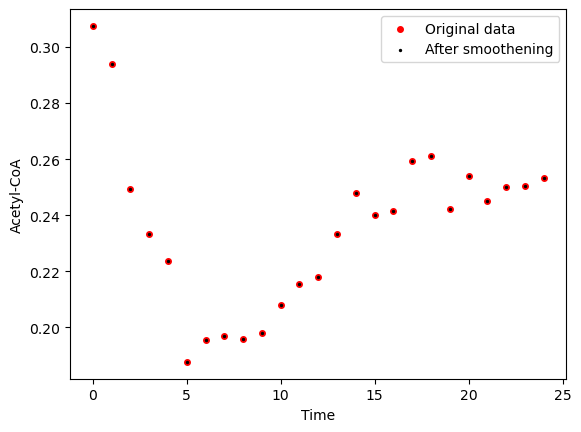

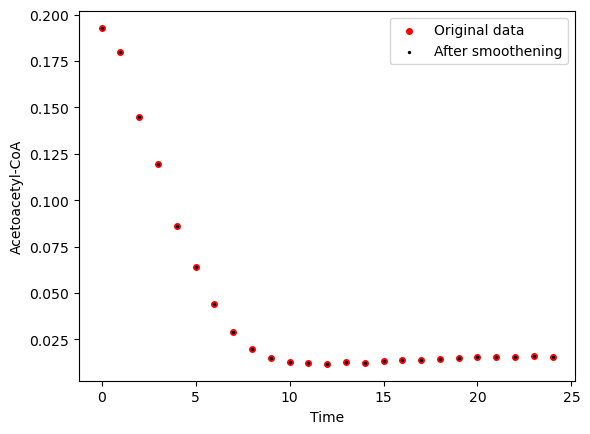

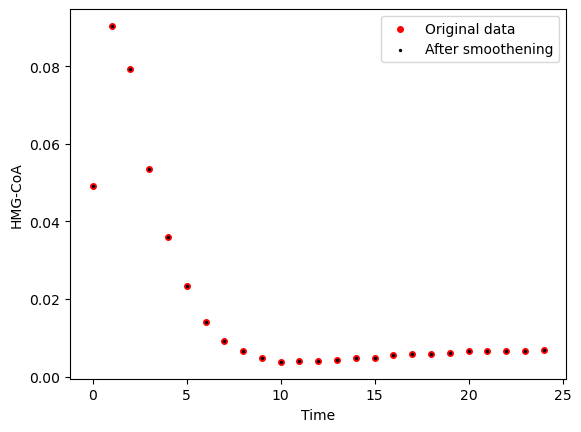

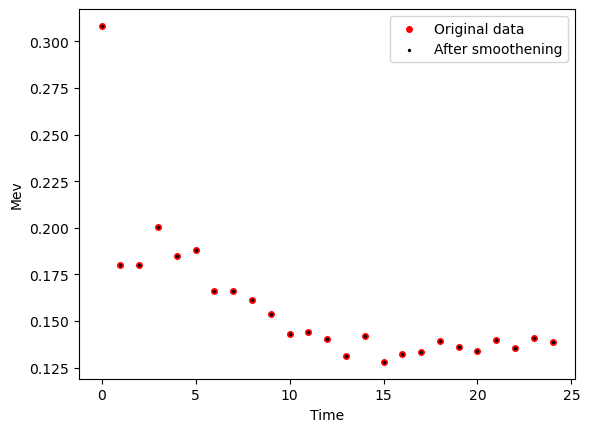

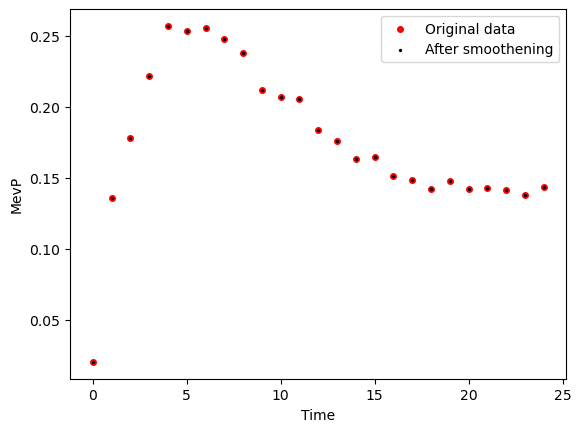

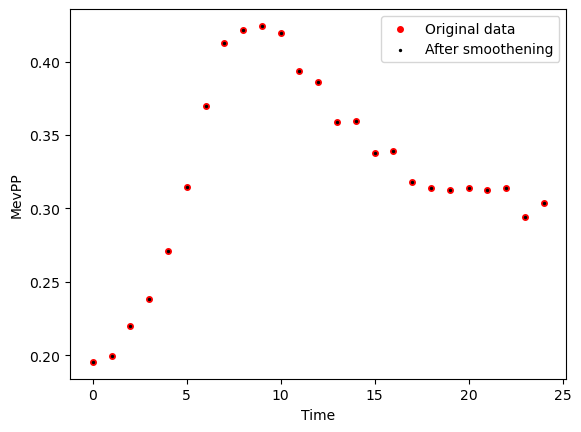

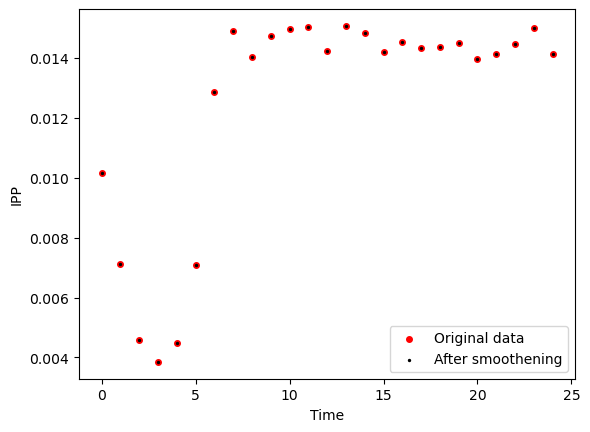

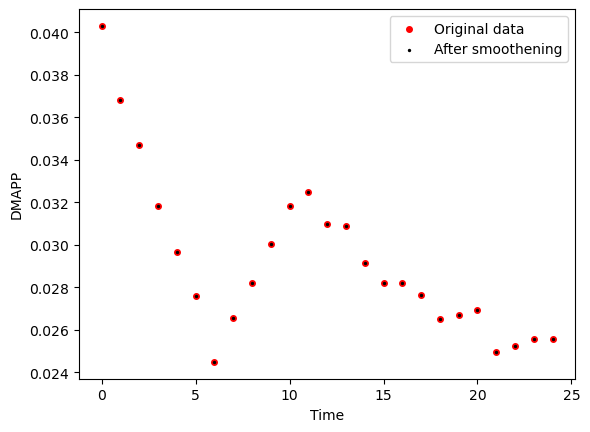

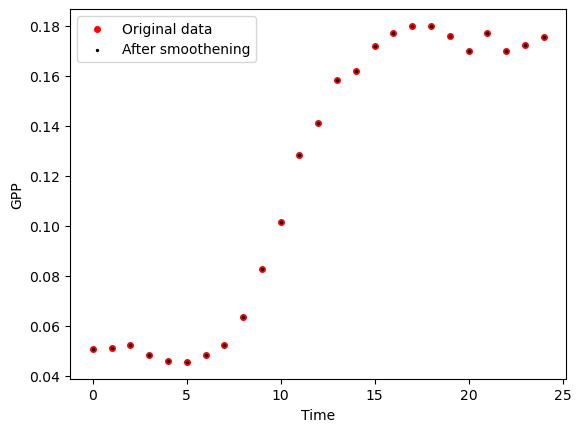

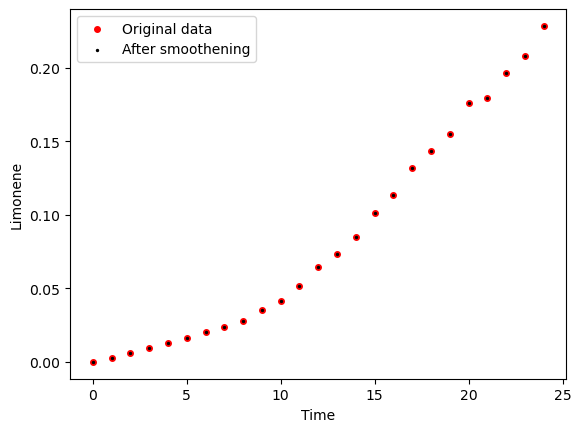

Strain Strain 2


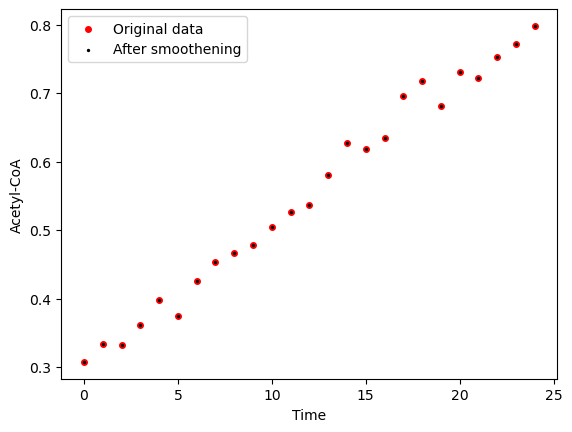

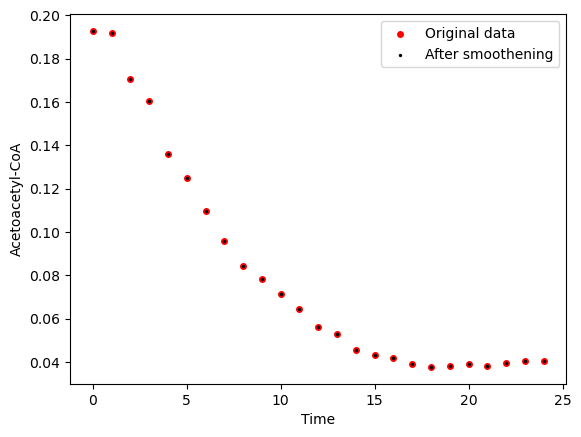

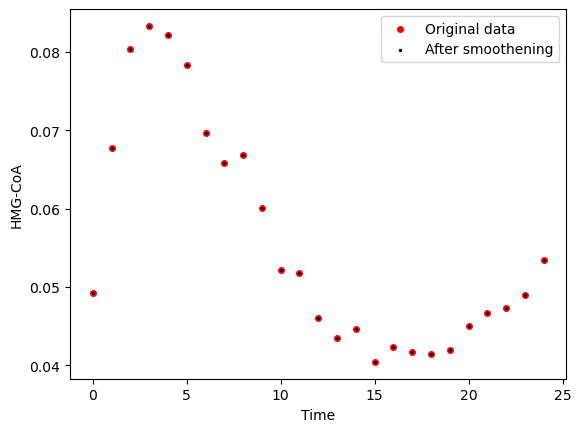

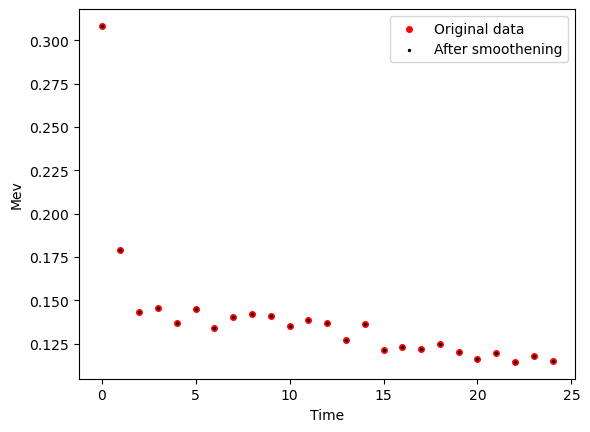

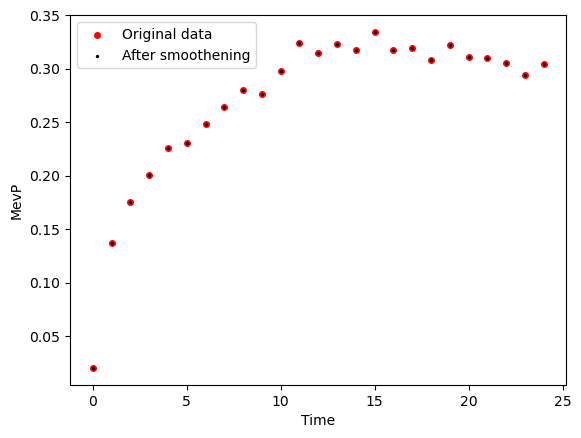

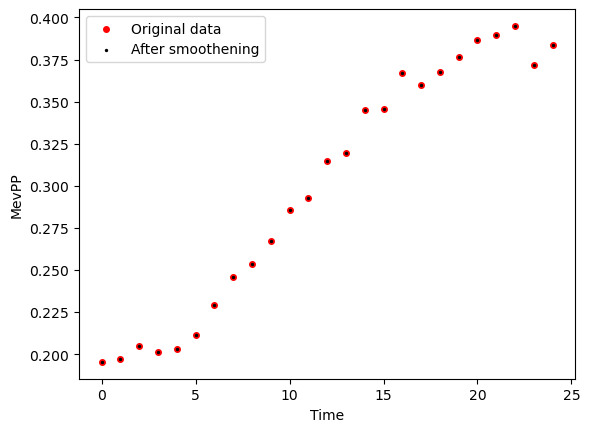

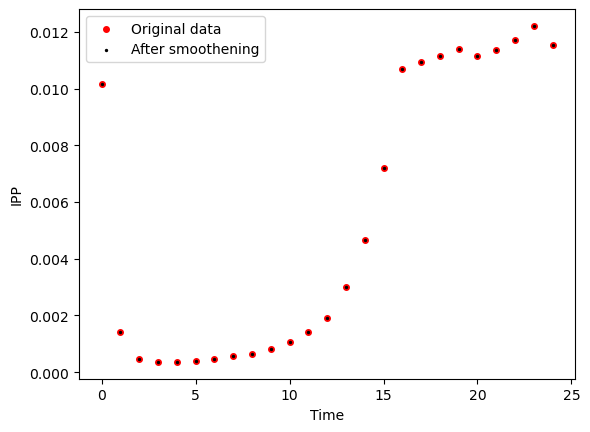

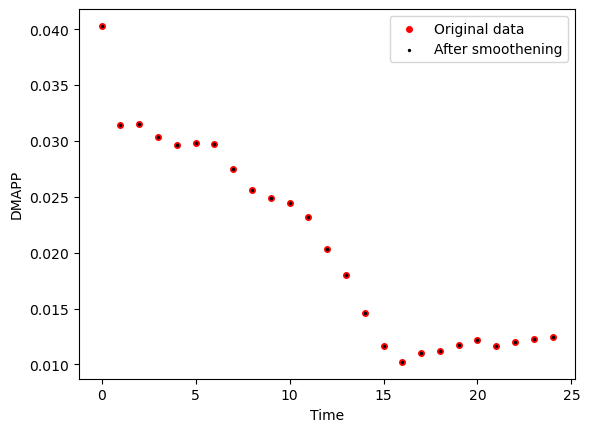

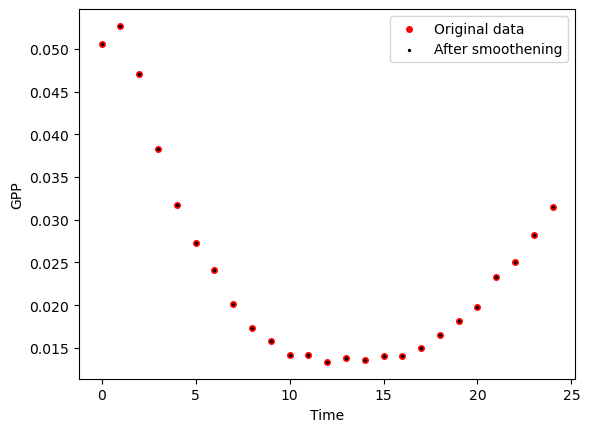

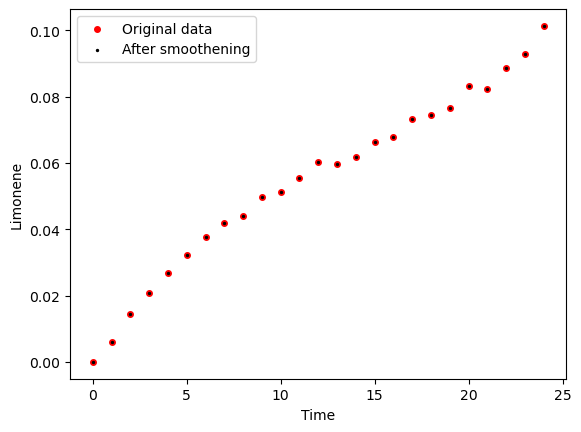

Strain Strain 3


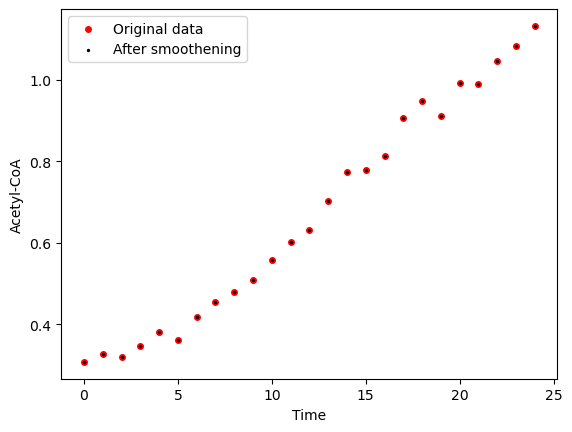

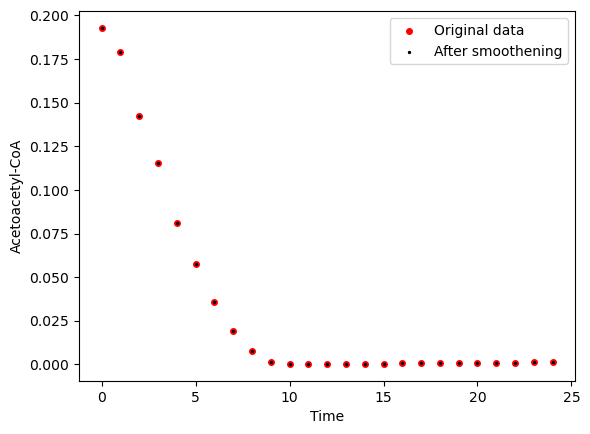

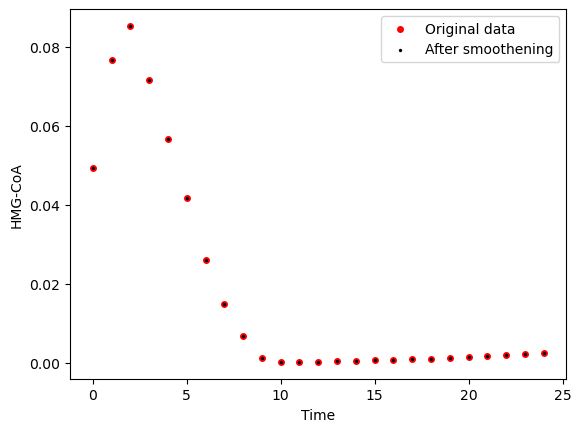

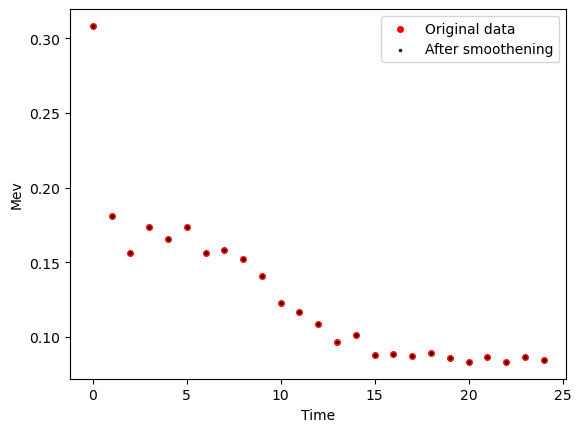

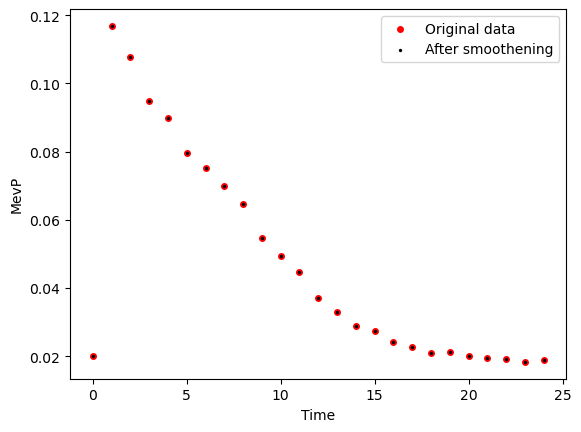

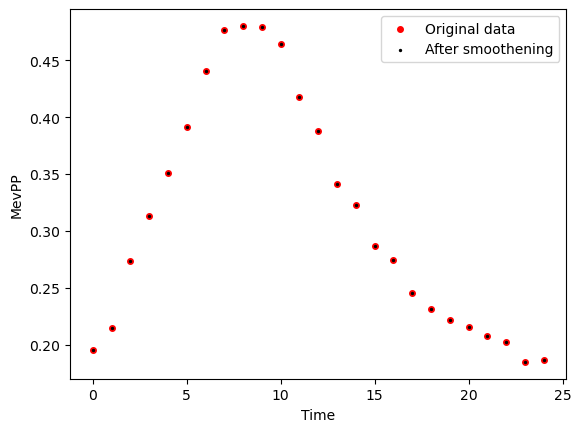

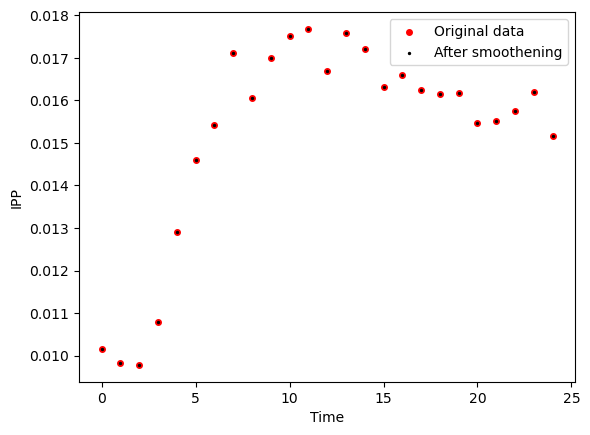

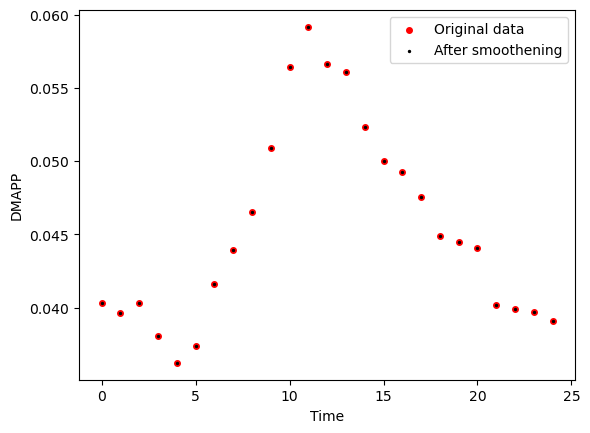

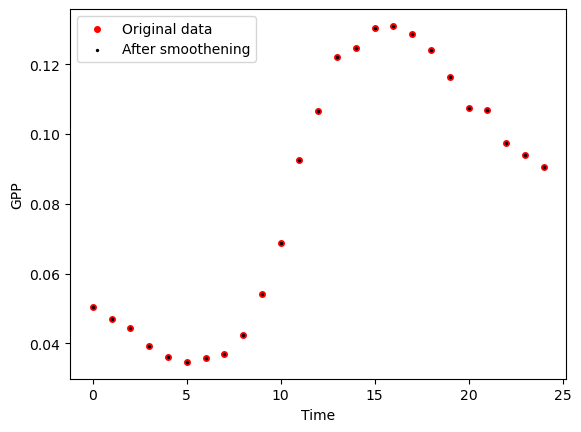

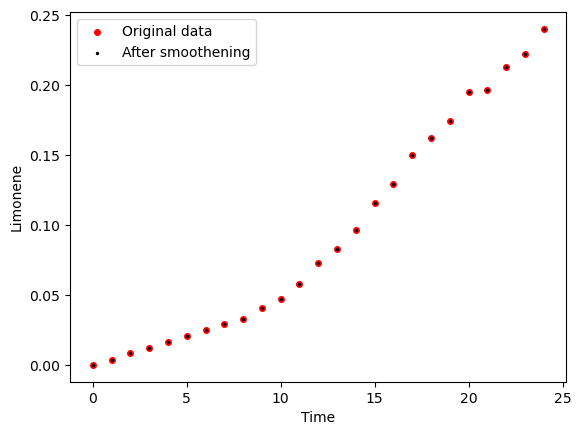

Strain WT


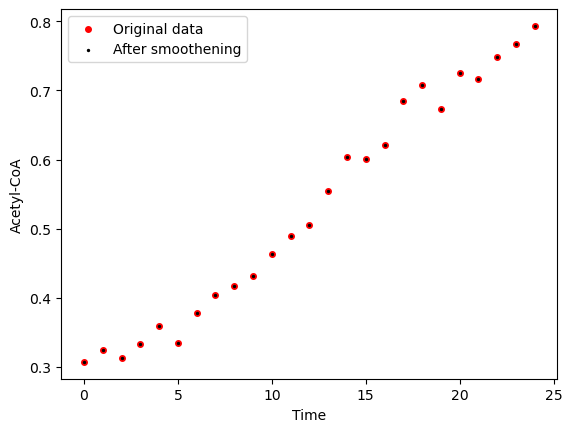

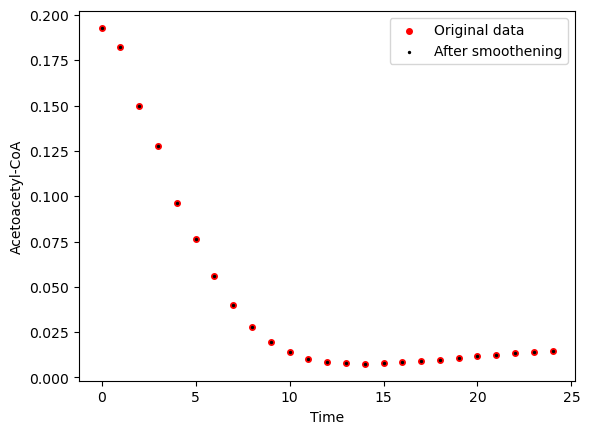

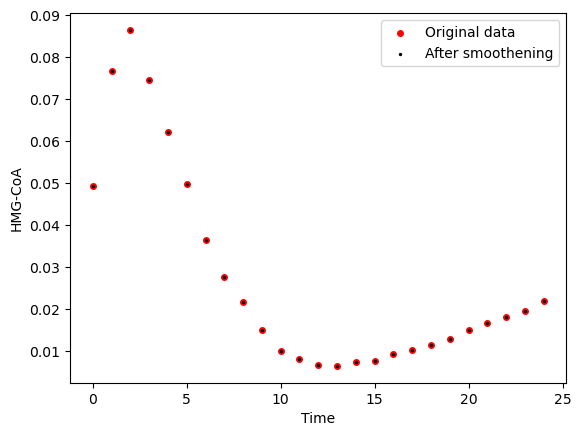

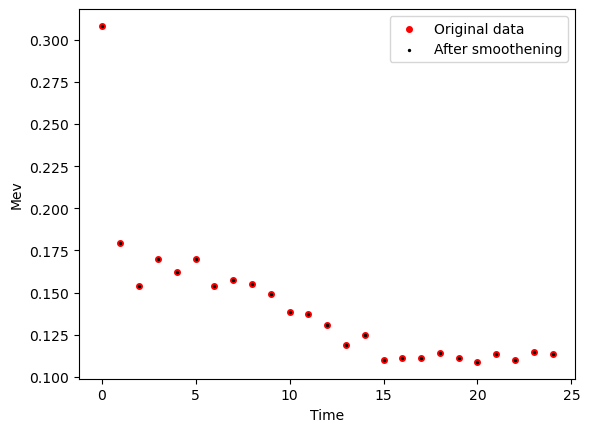

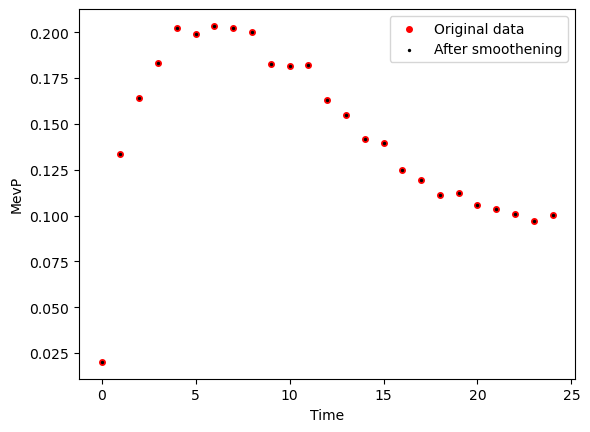

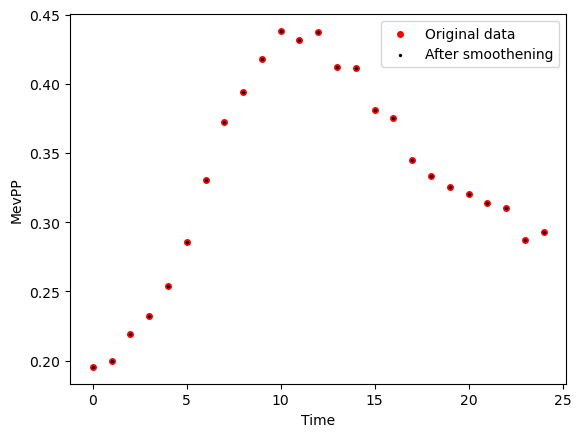

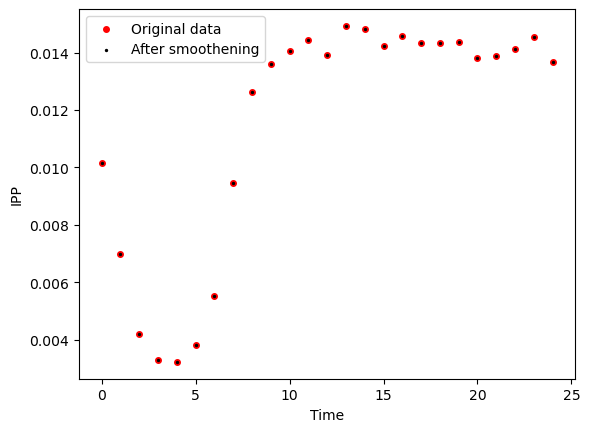

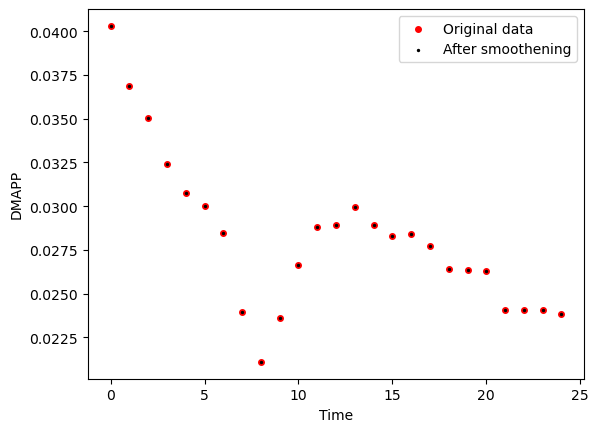

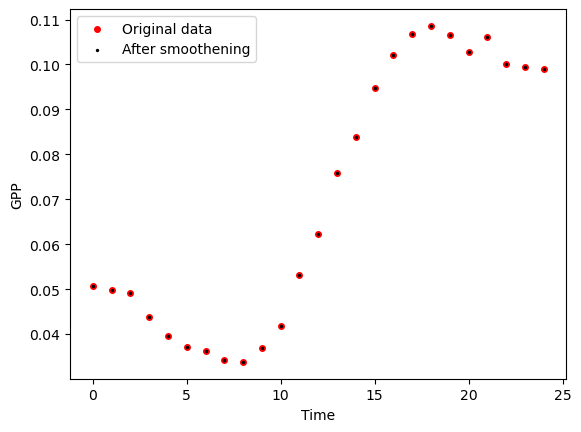

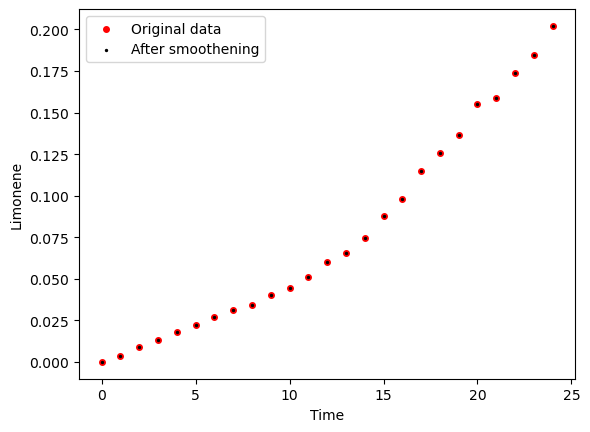

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


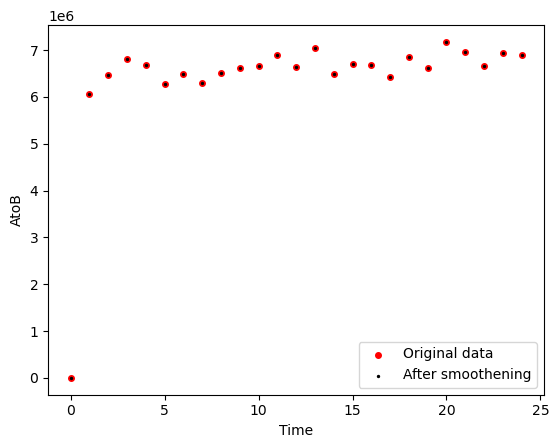

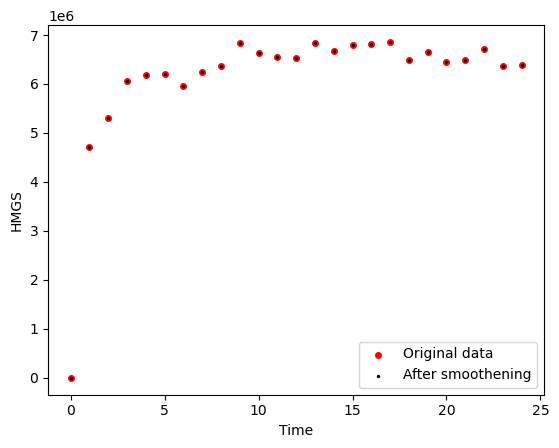

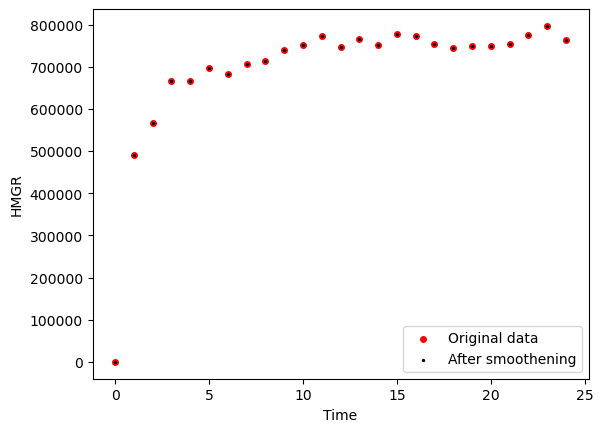

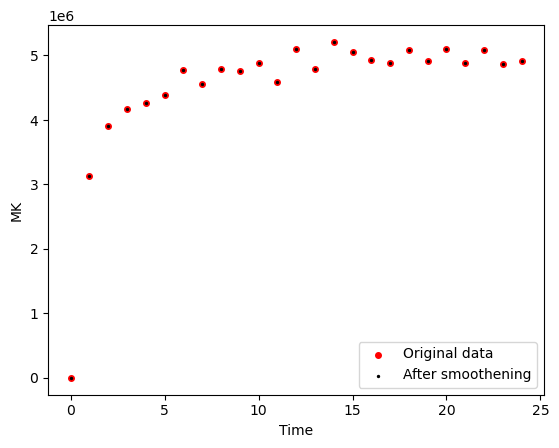

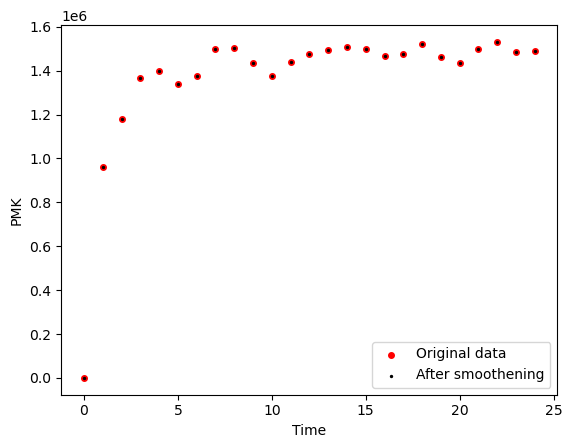

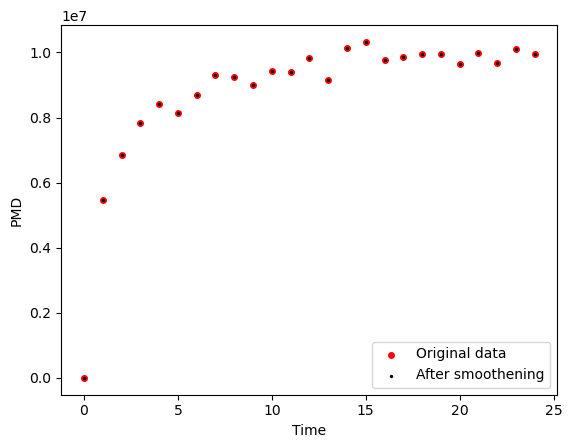

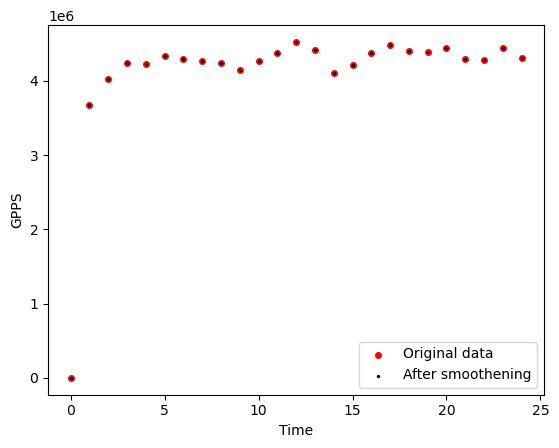

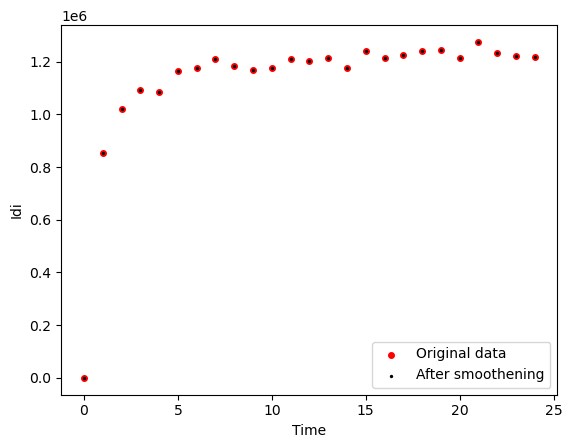

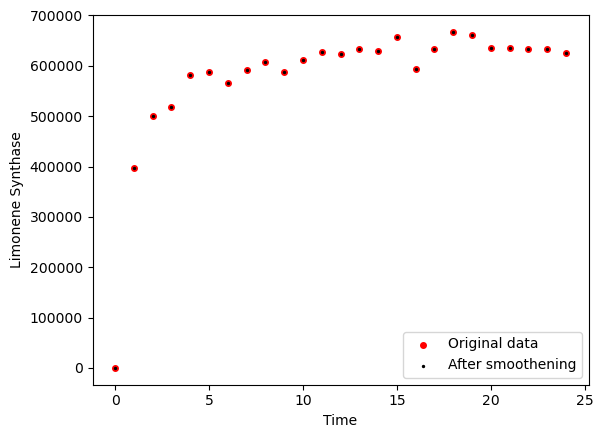

Strain Strain 2


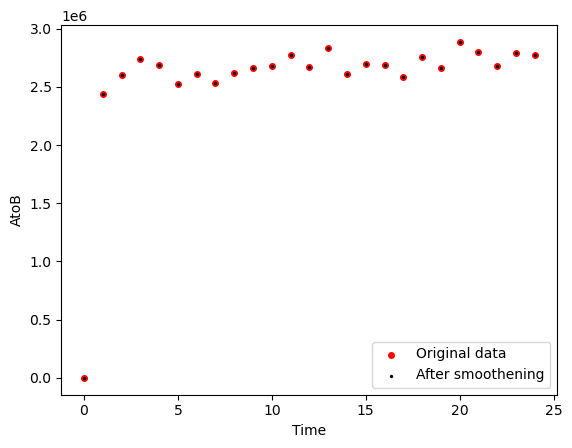

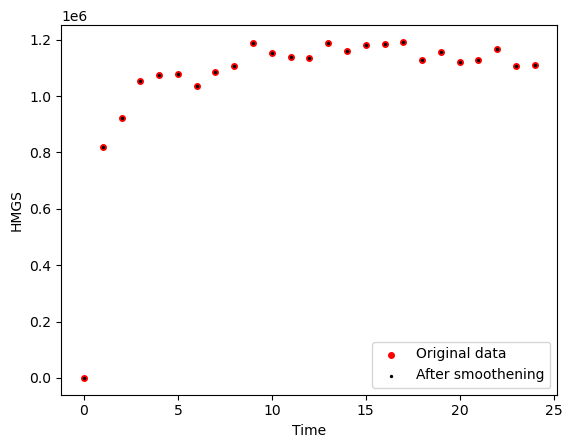

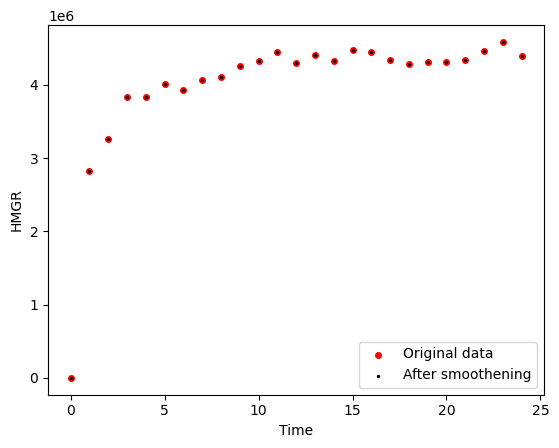

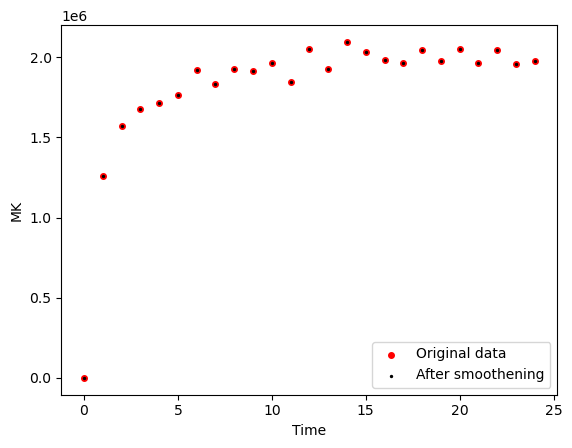

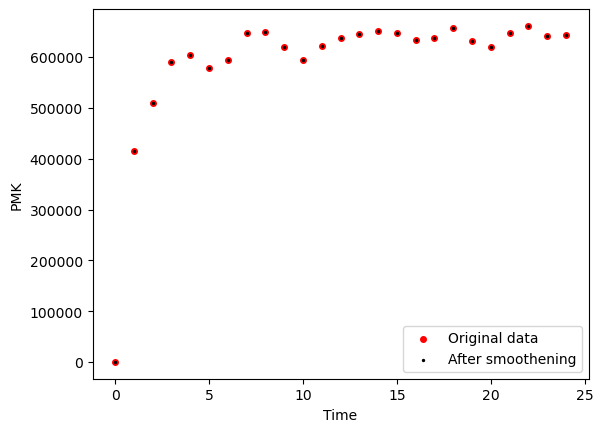

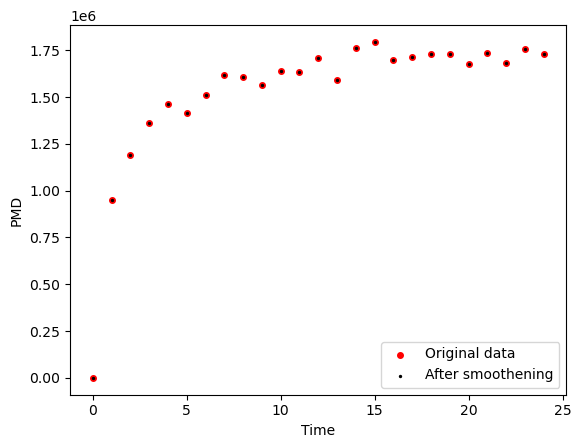

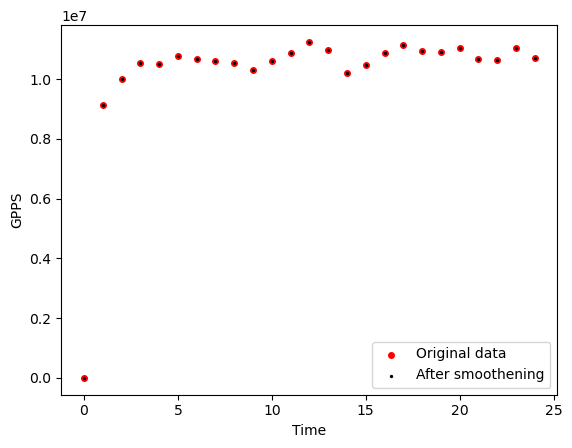

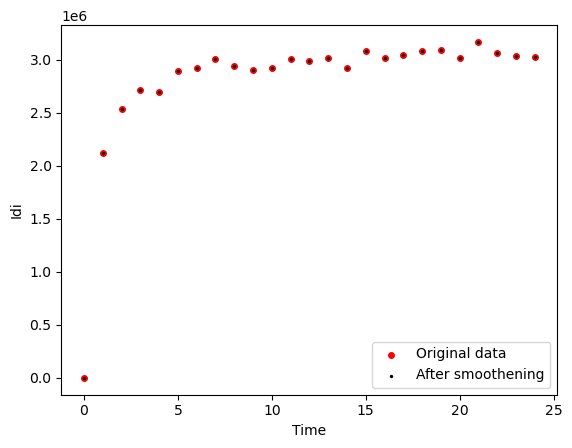

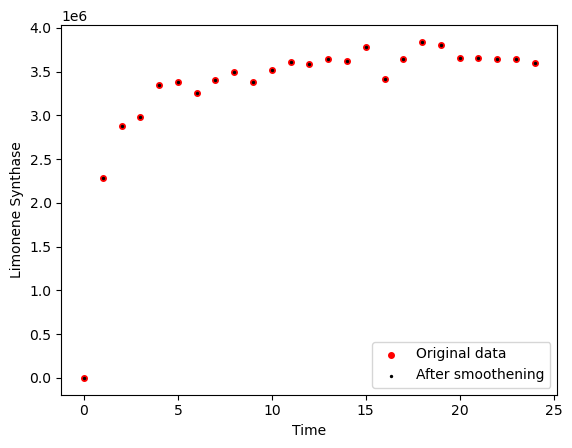

Strain Strain 3


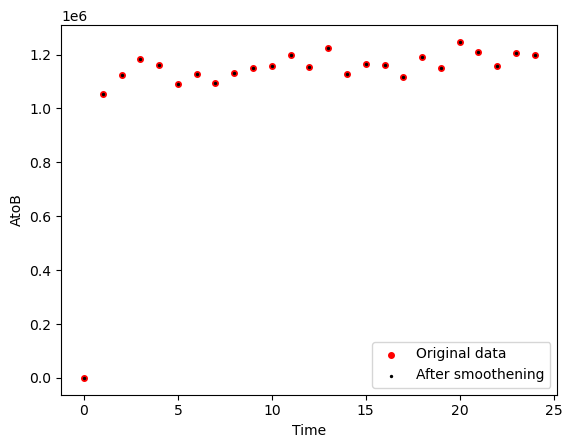

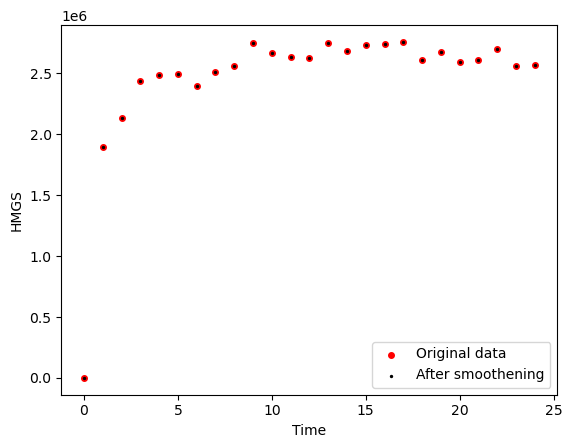

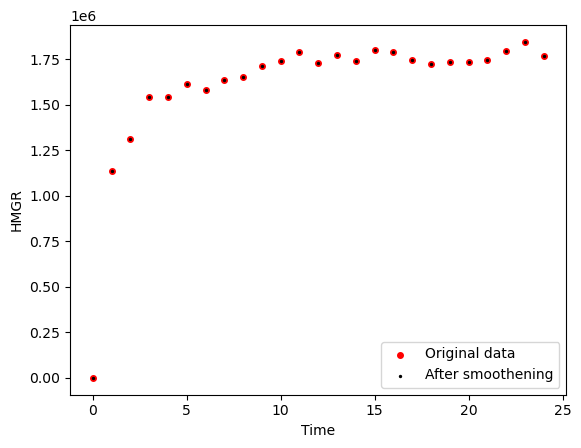

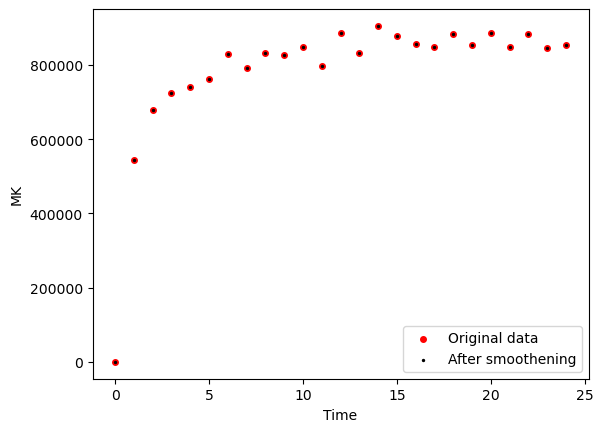

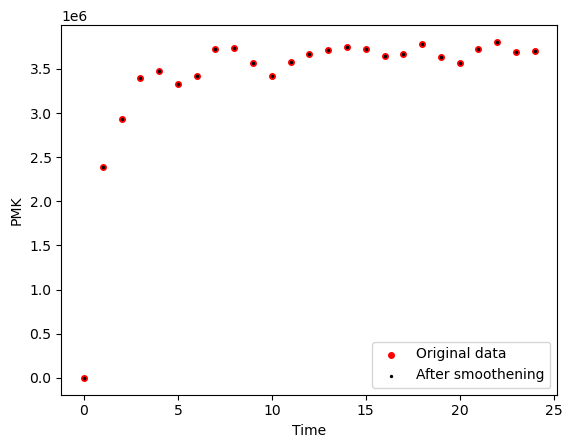

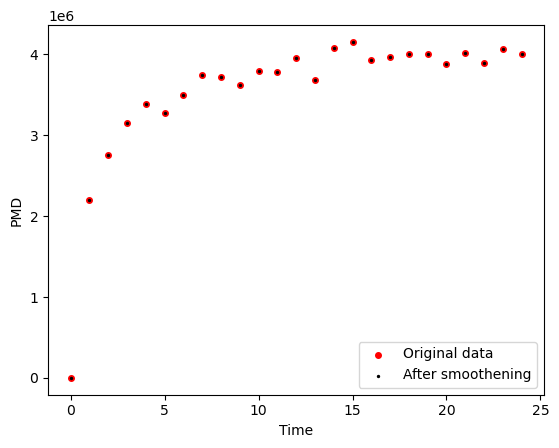

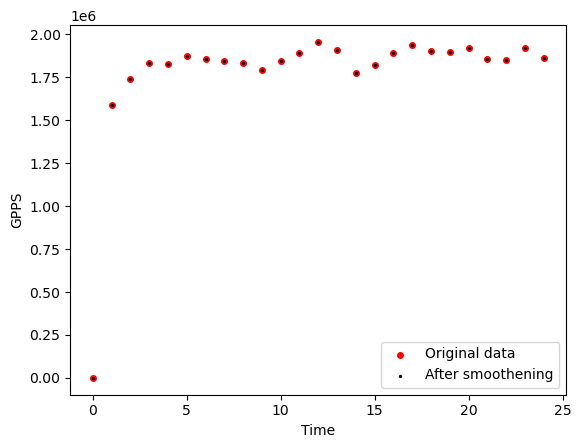

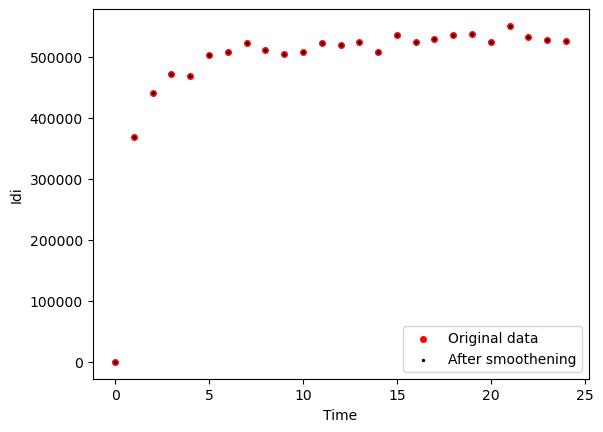

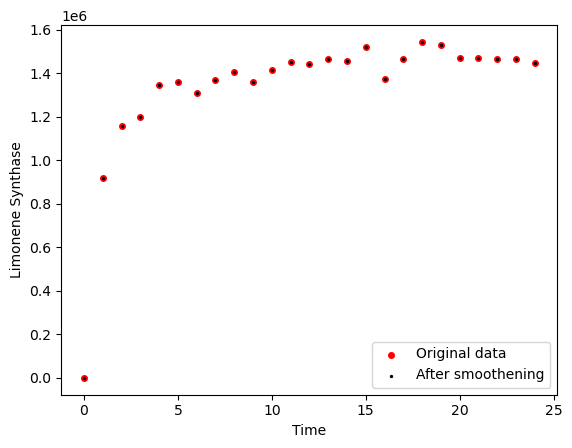

Strain WT


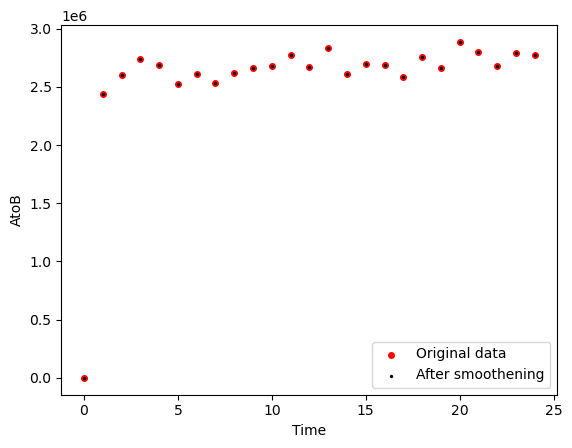

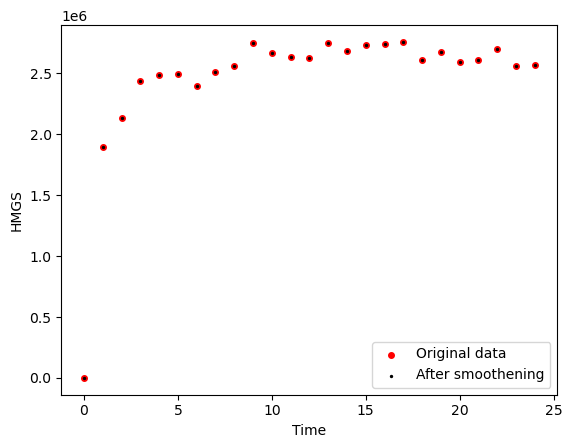

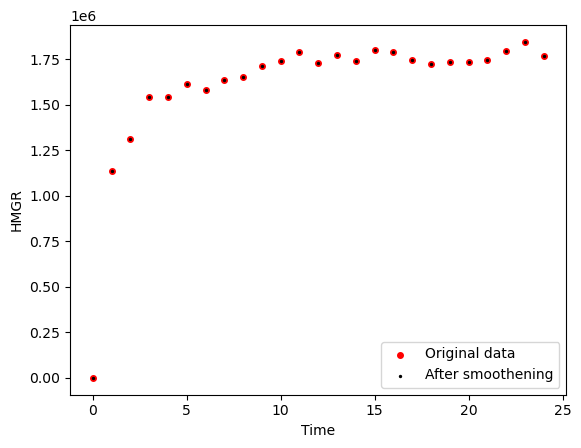

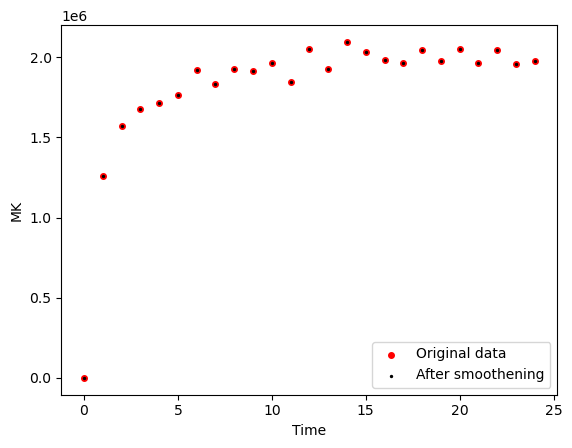

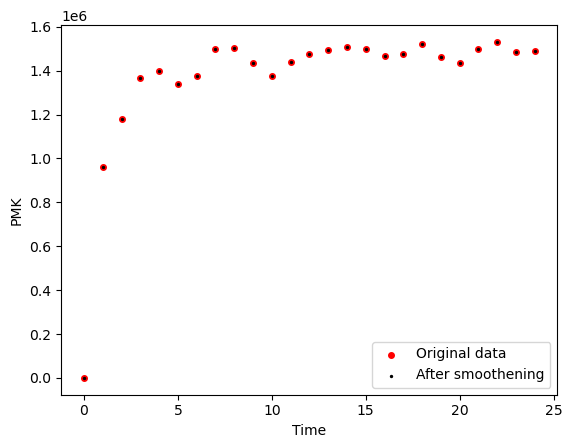

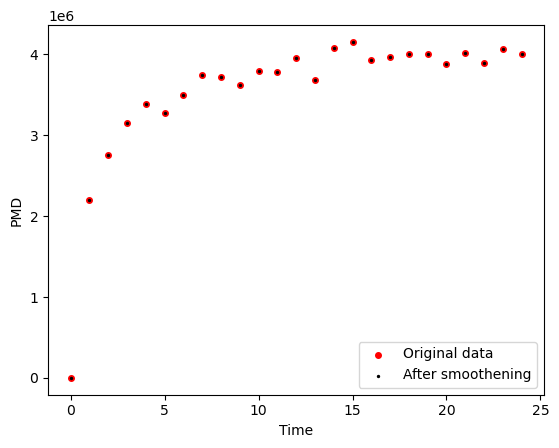

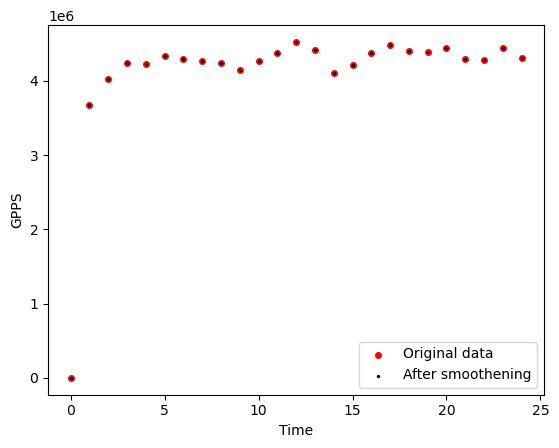

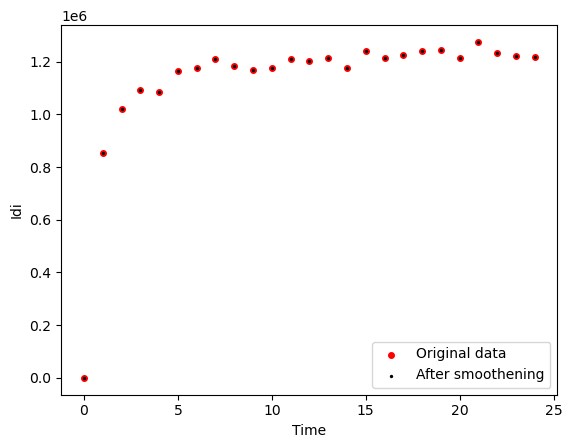

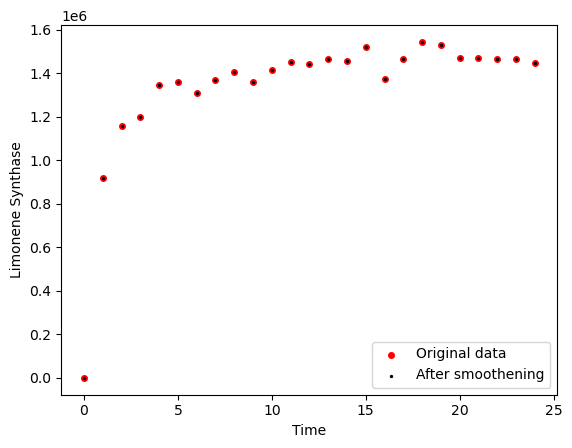

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.307507        0.192847  0.049264  0.308261  0.020131   
         1.0    0.294101        0.179772  0.090419  0.179818  0.135471   
         2.0    0.249249        0.145090  0.079351  0.180161  0.178106   
         3.0    0.233213        0.119765  0.053445  0.200648  0.221888   
         4.0    0.223661        0.086107  0.035868  0.185039  0.257185   
...                  ...             ...       ...       ...       ...   
WT       20.0   0.724430        0.011918  0.014979  0.108839  0.105822   
         21.0   0.716441        0.012377  0.016685  0.113624  0.103722   
         22.0   0.748202        0.013356  0.017908  0.110194  0.101094   
         23.0   0.766917        0.014266  0.019396  0.115010  0.096844   
         24.0   0.793155        0.014646  0.021948  0.113436  0.100114   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.195401  0.010149  0.040297  0.050591  0.000000  ...   
         1.0   0.199769  0.007104  0.036825  0.050980  0.002385  ...   
         2.0   0.219918  0.004586  0.034717  0.052404  0.006087  ...   
         3.0   0.238093  0.003851  0.031841  0.048562  0.009186  ...   
         4.0   0.270810  0.004495  0.029659  0.045870  0.012684  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       20.0  0.320696  0.013797  0.026296  0.102768  0.154889  ...   
         21.0  0.313723  0.013883  0.024085  0.106092  0.158629  ...   
         22.0  0.310550  0.014123  0.024058  0.100079  0.174093  ...   
         23.0  0.287211  0.014564  0.024051  0.099509  0.184427  ...   
         24.0  0.293085  0.013663  0.023812  0.098880  0.202135  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.033293       -0.018260  0.031424 -0.092793  0.101463   
         1.0    -0.028076       -0.022804  0.012524 -0.057677  0.078758   
         2.0    -0.022858       -0.027349 -0.006377 -0.022561  0.056052   
         3.0    -0.023834       -0.029026 -0.017764  0.002105  0.031562   
         4.0    -0.015284       -0.025807 -0.016059 -0.004123  0.018642   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.012288        0.000869  0.001680 -0.000608 -0.002827   
         21.0    0.021021        0.000838  0.001608  0.000889 -0.003547   
         22.0    0.018793        0.000734  0.001665  0.001058 -0.001829   
         23.0    0.026708        0.000702  0.001945  0.000419 -0.000527   
         24.0    0.034623        0.000669  0.002224 -0.000220  0.000776   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.003279 -0.004073 -0.003144  0.002079  0.002753  
         1.0   0.011097 -0.002765 -0.002885  0.000446  0.002985  
         2.0   0.018914 -0.001456 -0.002626 -0.001186  0.003217  
         3.0   0.028039 -0.000009 -0.002350 -0.001727  0.003402  
         4.0   0.037615  0.001979 -0.002469 -0.001062  0.003502  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.005650 -0.000091 -0.000704 -0.001752  0.011955  
         21.0 -0.008613  0.000069 -0.000686 -0.001690  0.011545  
         22.0 -0.008173  0.000041 -0.000500 -0.001436  0.012029  
         23.0 -0.007384 -0.000212  0.000066 -0.001788  0.015287  
         24.0 -0.006594 -0.000465  0.000633 -0.002140  0.018545

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

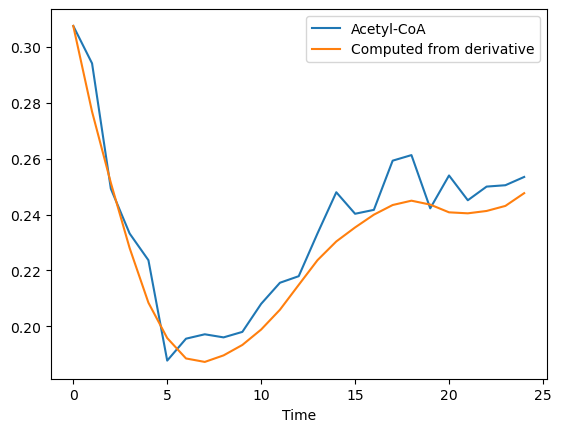

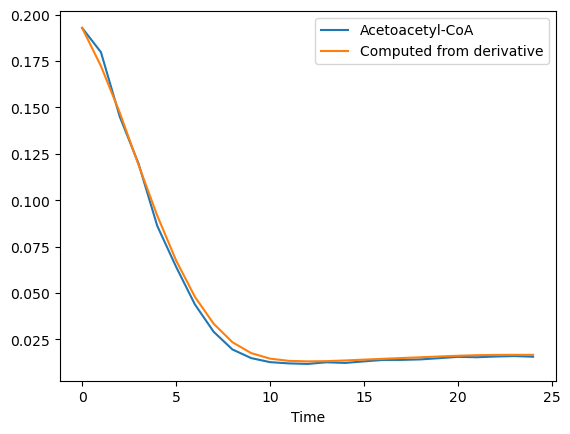

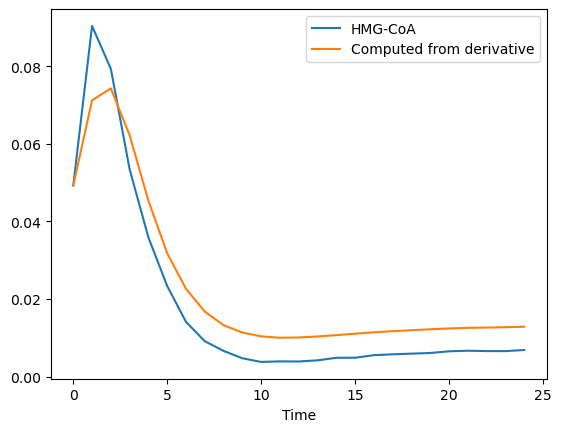

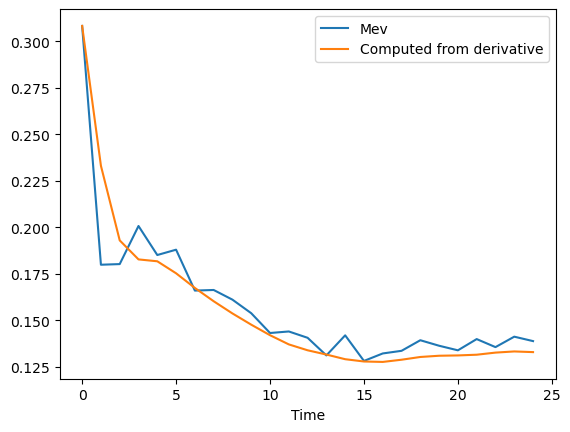

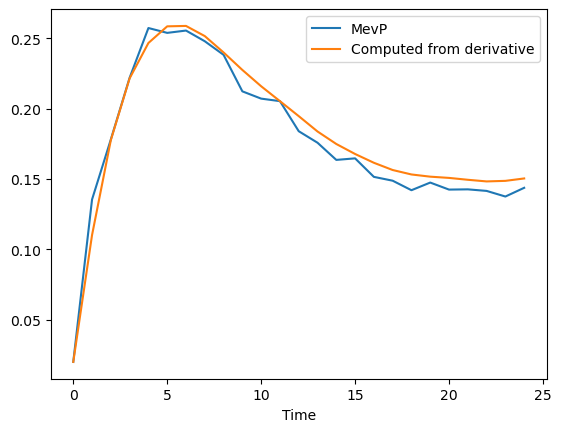

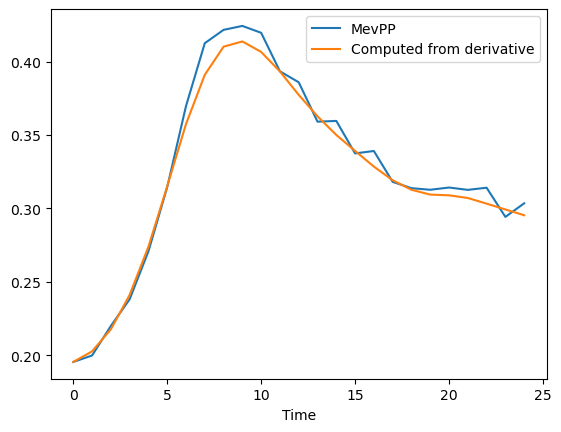

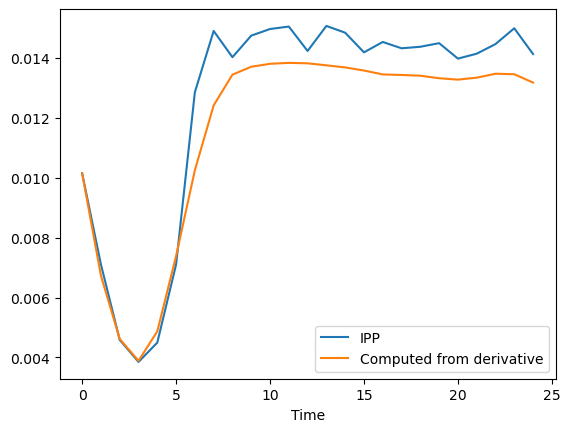

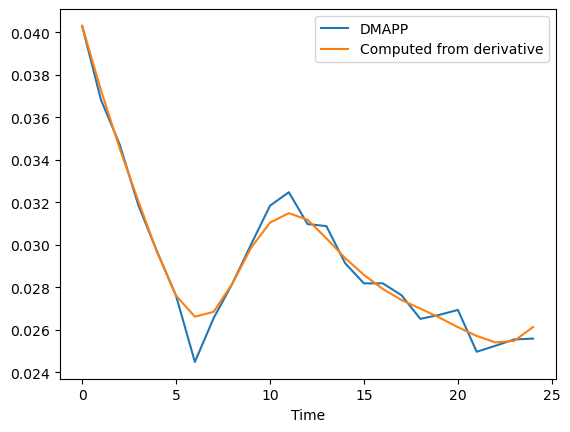

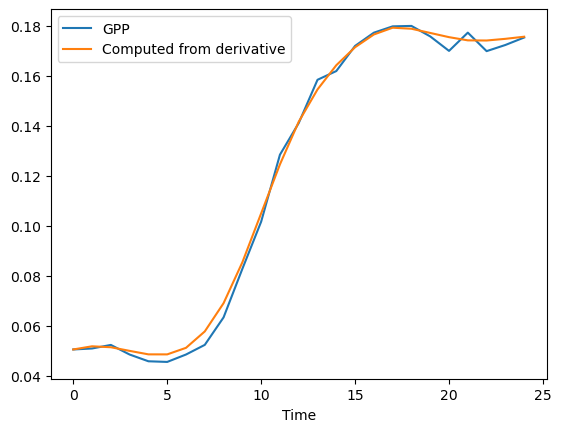

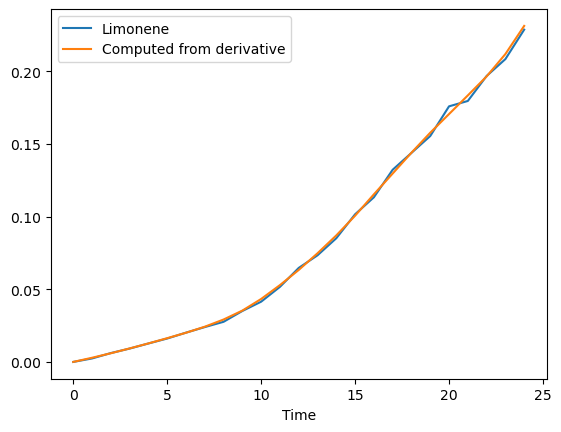

'Time profile from derivative vs. actual profile for Strain 2'

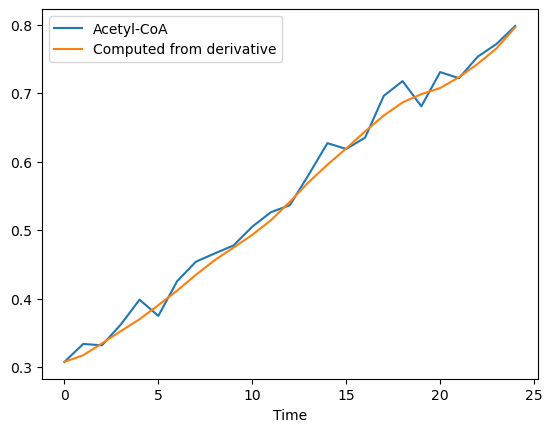

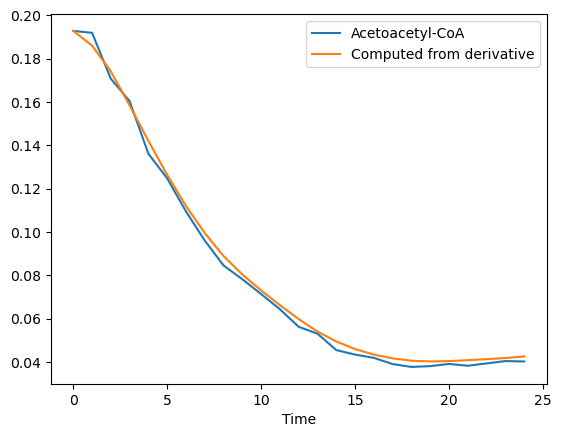

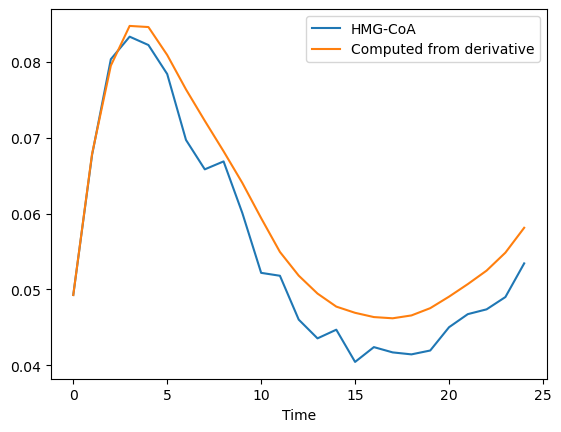

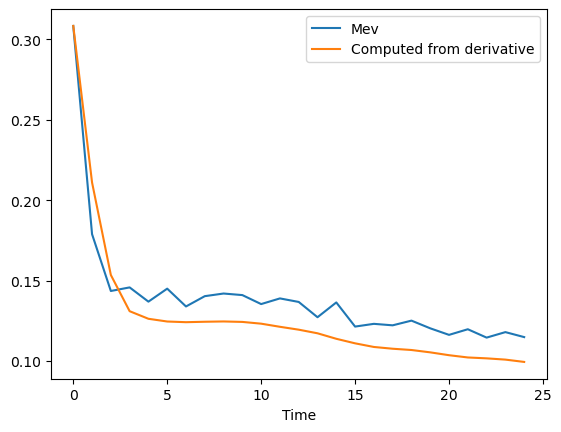

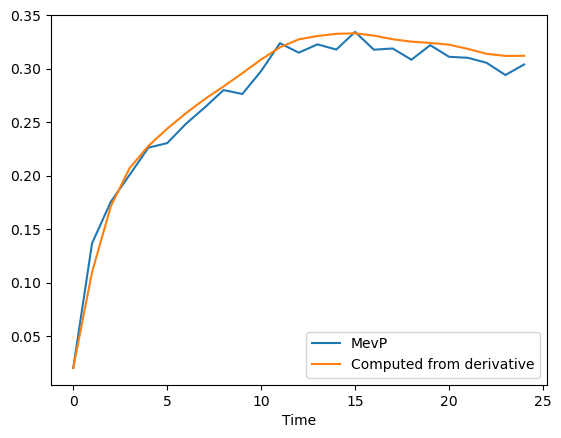

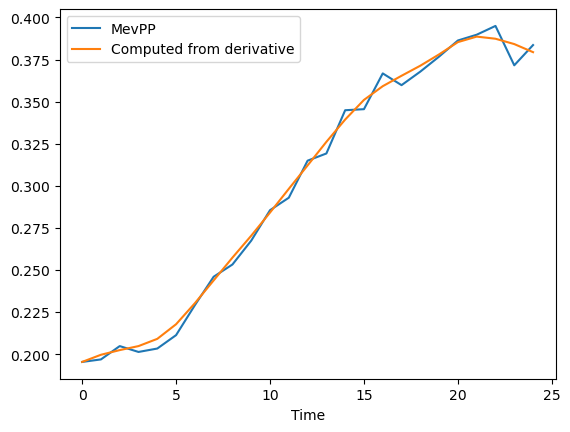

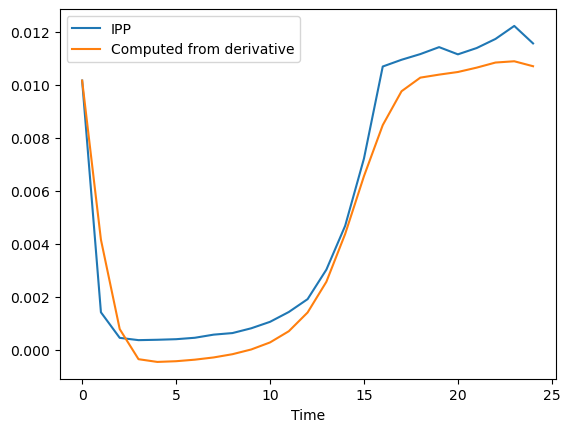

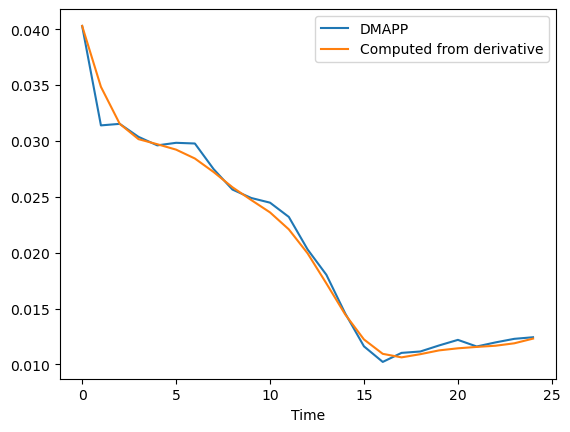

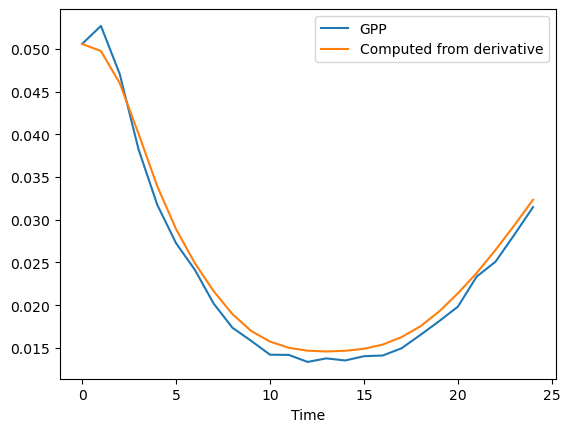

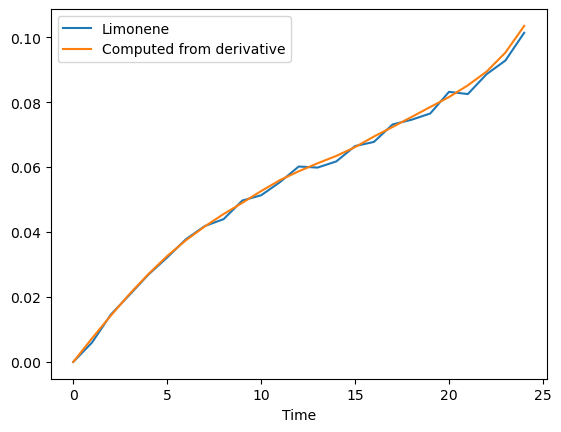

'Time profile from derivative vs. actual profile for Strain 3'

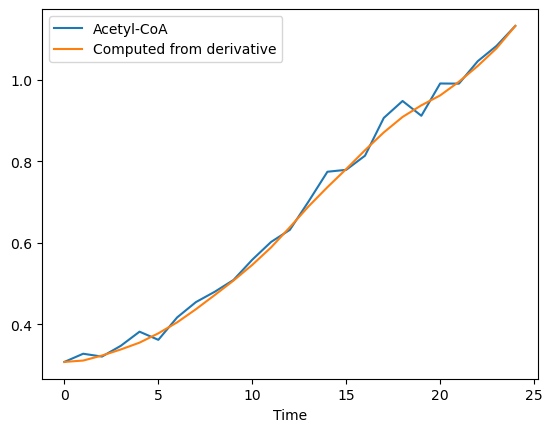

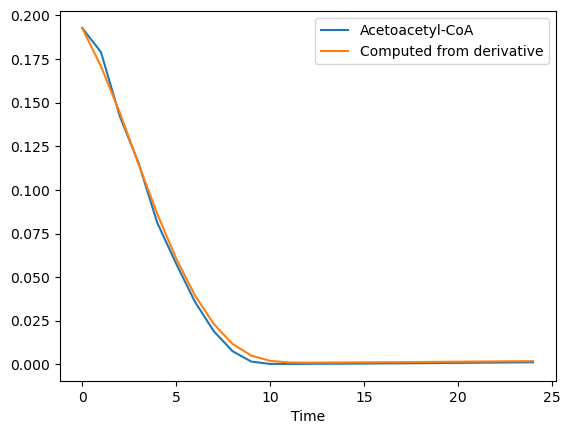

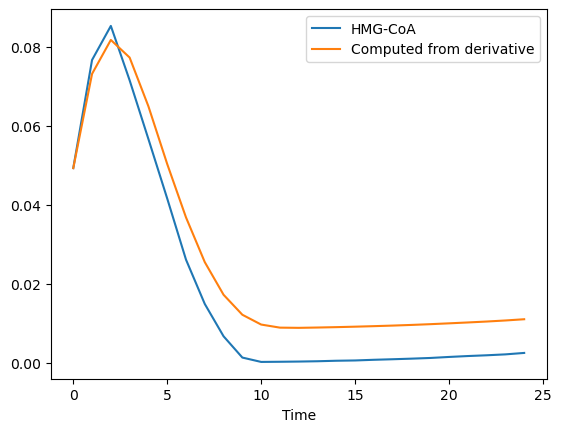

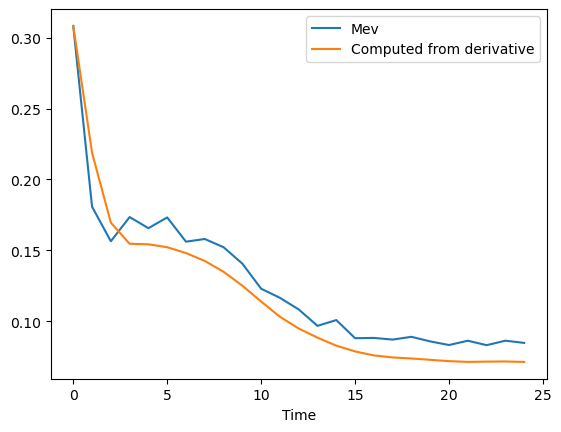

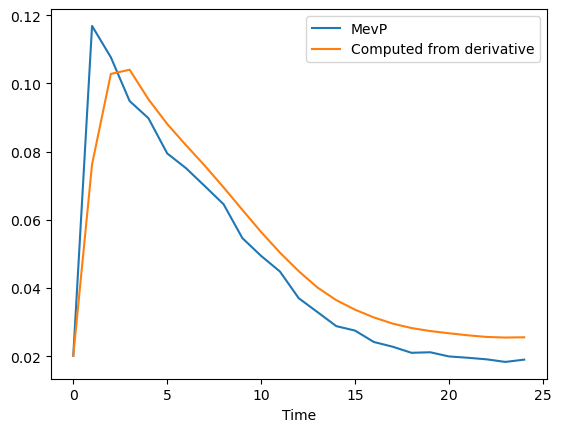

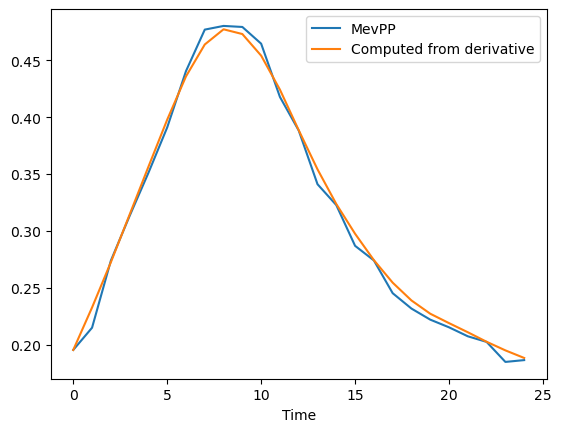

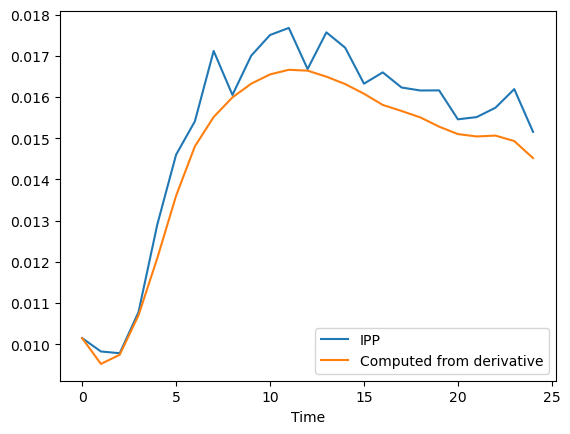

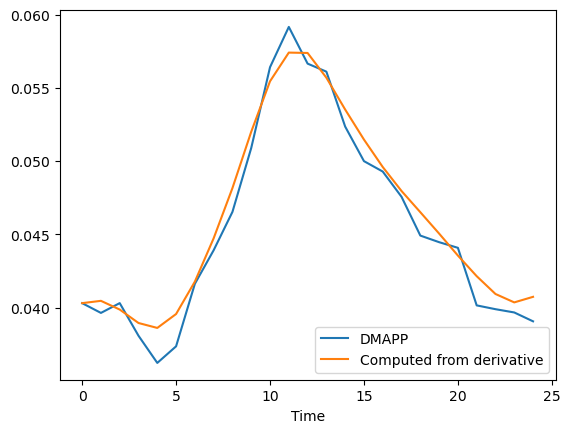

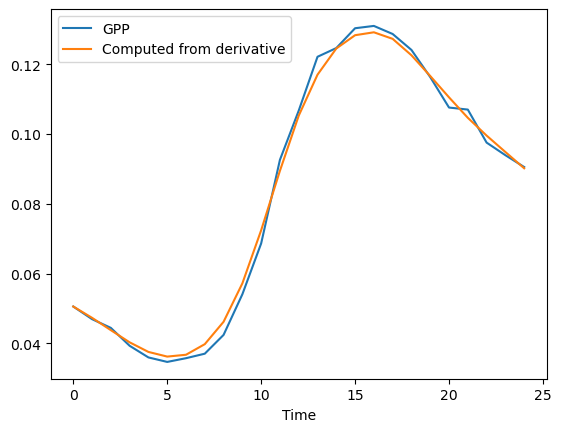

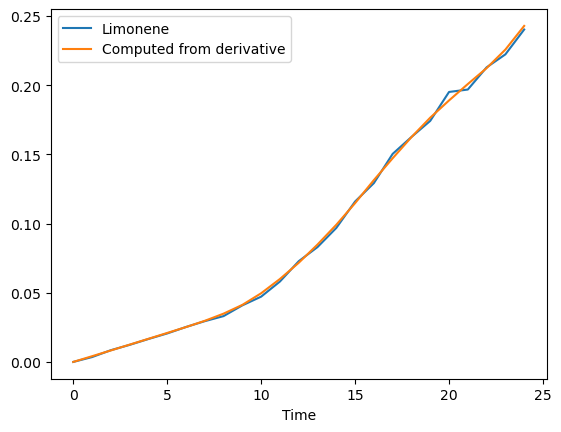

'Time profile from derivative vs. actual profile for WT'

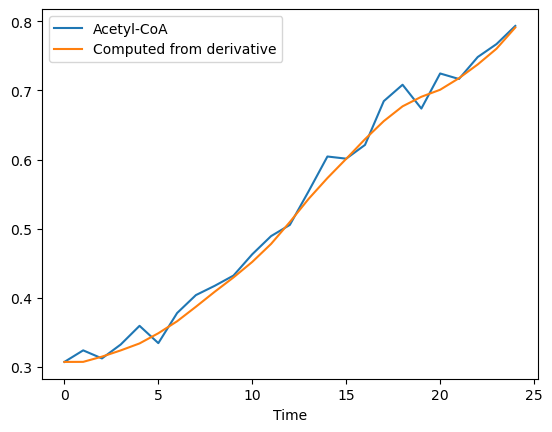

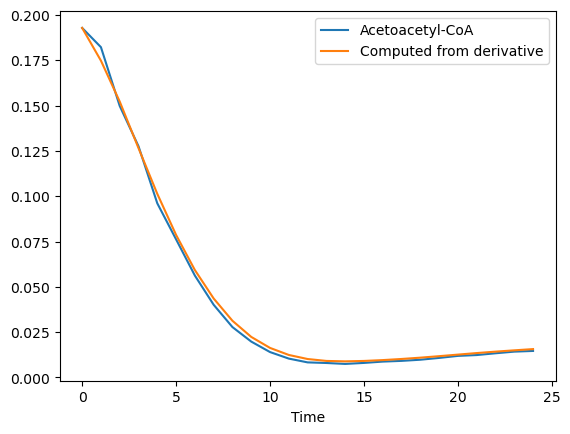

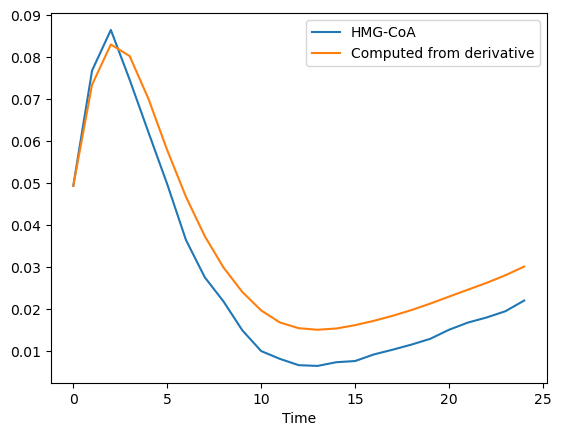

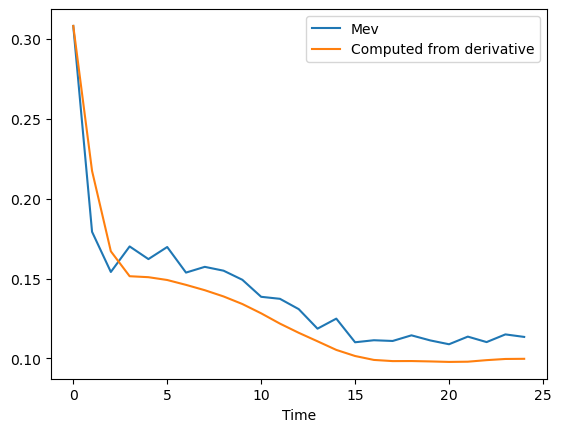

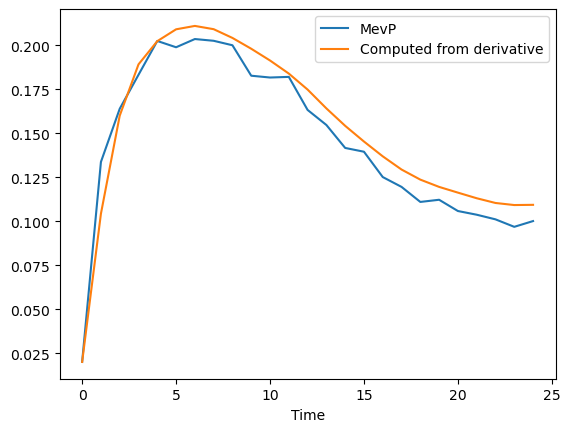

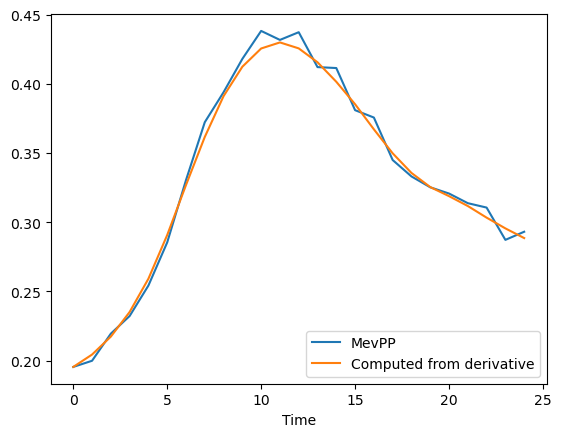

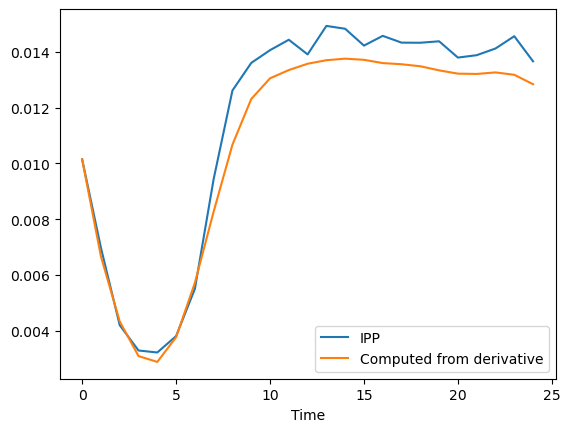

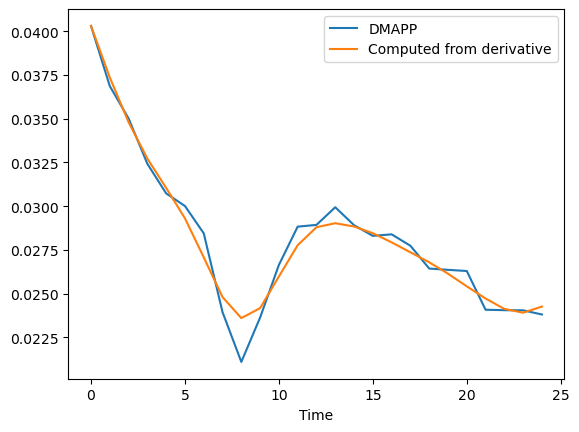

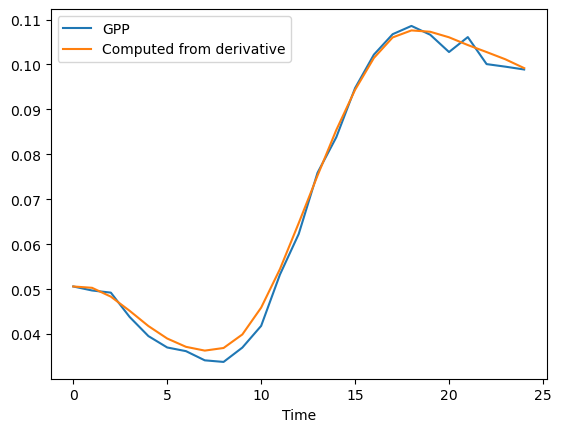

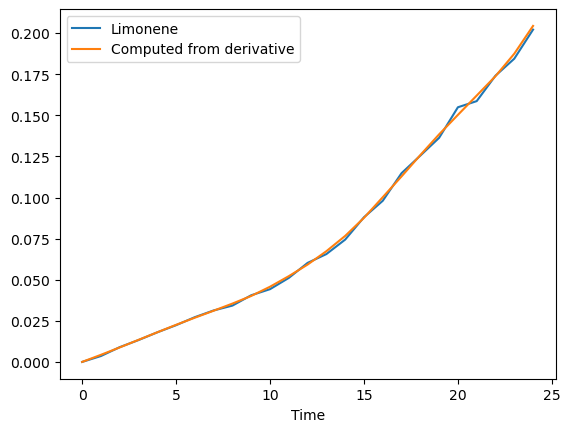

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   6.095775e+01  3.830916e+01  3.642460e+01  5.920951e+01   
         1.0   6.064973e+06  4.704415e+06  4.895777e+05  3.127680e+06   
         2.0   6.463595e+06  5.314221e+06  5.656797e+05  3.908362e+06   
         3.0   6.813118e+06  6.069053e+06  6.651390e+05  4.173070e+06   
         4.0   6.686558e+06  6.183024e+06  6.661528e+05  4.266762e+06   
...                     ...           ...           ...           ...   
WT       20.0  2.885928e+06  2.592689e+06  1.736417e+06  2.051069e+06   
         21.0  2.798157e+06  2.609578e+06  1.746109e+06  1.963228e+06   
         22.0  2.679987e+06  2.700517e+06  1.791940e+06  2.043982e+06   
         23.0  2.791560e+06  2.558419e+06  1.844035e+06  1.958944e+06   
         24.0  2.769951e+06  2.567887e+06  1.768697e+06  1.976778e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         1.0   9.623617e+05  5.473993e+06  3.671077e+06  8.548772e+05   
         2.0   1.181081e+06  6.858261e+06  4.030116e+06  1.019154e+06   
         3.0   1.364701e+06  7.843633e+06  4.246695e+06  1.093725e+06   
         4.0   1.398452e+06  8.429853e+06  4.223874e+06  1.083648e+06   
...                     ...           ...           ...           ...   
WT       20.0  1.436741e+06  3.886053e+06  4.438392e+06  1.212416e+06   
         21.0  1.497351e+06  4.014105e+06  4.288977e+06  1.274257e+06   
         22.0  1.530939e+06  3.896574e+06  4.279964e+06  1.231384e+06   
         23.0  1.484768e+06  4.071536e+06  4.436833e+06  1.222453e+06   
         24.0  1.488798e+06  4.001470e+06  4.306011e+06  1.217507e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.069984e+01   0.307507        0.192847  0.049264   
         1.0       3.974297e+05   0.294101        0.179772  0.090419   
         2.0       5.009919e+05   0.249249        0.145090  0.079351   
         3.0       5.177762e+05   0.233213        0.119765  0.053445   
         4.0       5.810579e+05   0.223661        0.086107  0.035868   
...                         ...        ...             ...       ...   
WT       20.0      1.471488e+06   0.724430        0.011918  0.014979   
         21.0      1.469987e+06   0.716441        0.012377  0.016685   
         22.0      1.466745e+06   0.748202        0.013356  0.017908   
         23.0      1.464867e+06   0.766917        0.014266  0.019396   
         24.0      1.447661e+06   0.793155        0.014646  0.021948   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.308261  0.020131  0.195401  0.010149  0.040297  0.050591   
         1.0   0.179818  0.135471  0.199769  0.007104  0.036825  0.050980   
         2.0   0.180161  0.178106  0.219918  0.004586  0.034717  0.052404   
         3.0   0.200648  0.221888  0.238093  0.003851  0.031841  0.048562   
         4.0   0.185039  0.257185  0.270810  0.004495  0.029659  0.045870   
...                 ...       ...       ...       ...       ...       ...   
WT       20.0  0.108839  0.105822  0.320696  0.013797  0.026296  0.102768   
         21.0  0.113624  0.103722  0.313723  0.013883  0.024085  0.106092   
         22.0  0.110194  0.101094  0.310550  0.014123  0.024058  0.100079   
         23.0  0.115010  0.096844  0.287

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.033293       -0.018260  0.031424 -0.092793  0.101463   
         1.0    -0.028076       -0.022804  0.012524 -0.057677  0.078758   
         2.0    -0.022858       -0.027349 -0.006377 -0.022561  0.056052   
         3.0    -0.023834       -0.029026 -0.017764  0.002105  0.031562   
         4.0    -0.015284       -0.025807 -0.016059 -0.004123  0.018642   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.012288        0.000869  0.001680 -0.000608 -0.002827   
         21.0    0.021021        0.000838  0.001608  0.000889 -0.003547   
         22.0    0.018793        0.000734  0.001665  0.001058 -0.001829   
         23.0    0.026708        0.000702  0.001945  0.000419 -0.000527   
         24.0    0.034623        0.000669  0.002224 -0.000220  0.000776   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.003279 -0.004073 -0.003144  0.002079  0.002753  
         1.0   0.011097 -0.002765 -0.002885  0.000446  0.002985  
         2.0   0.018914 -0.001456 -0.002626 -0.001186  0.003217  
         3.0   0.028039 -0.000009 -0.002350 -0.001727  0.003402  
         4.0   0.037615  0.001979 -0.002469 -0.001062  0.003502  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.005650 -0.000091 -0.000704 -0.001752  0.011955  
         21.0 -0.008613  0.000069 -0.000686 -0.001690  0.011545  
         22.0 -0.008173  0.000041 -0.000500 -0.001436  0.012029  
         23.0 -0.007384 -0.000212  0.000066 -0.001788  0.015287  
         24.0 -0.006594 -0.000465  0.000633 -0.002140  0.018545  

[100 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 3.308010E+180 | 1.721320E+108
     2 |       74 | 3.318301E+117 | 2.897973E+106
     3 |      138 | 5.771474E+105 |  8.137154E+86
     4 |      202 |  1.060419E+96 |  1.285283E+78
     5 |      266 |  7.731933E+84 |  1.045214E+72
     6 |      330 |  1.796475E+74 |  1.843437E+61
     7 |      394 |  1.380195E+71 |  2.437022E+54
     8 |      458 |  5.473011E+62 |  8.239008E+43
     9 |      522 |  6.417984E+55 |  1.751208E+37
    10 |      586 |  3.253641E+45 |  3.794849E+36
    11 |      650 |  1.172648E+45 |  2.654729E+26
    12 |      714 |  7.327066E+36 |  2.654729E+26
    13 |      778 |  5.832363E+32 |  3.986736E+18
    14 |      842 |  5.653469E+27 |  3.986736E+18
    15 |      906 |  1.442288E+24 |  1.411261E+09
    16 |      970 |  2.347507E+19 |  1.411261E+09
    17 |     1034 |  1.295461E+20 |  1.411261E+09
    18 |     1098 |  4.383669E+21 |  1.411261E+09
    19 |     1162 |  5.575

   163 |    10378 |  2.019306E+01 |  1.904412E+01
   164 |    10442 |  1.992019E+01 |  1.904412E+01
   165 |    10506 |  1.963727E+01 |  1.882112E+01
   166 |    10570 |  2.021269E+01 |  1.882112E+01
   167 |    10634 |  1.980692E+01 |  1.573897E+01
   168 |    10698 |  1.865555E+01 |  1.573897E+01
   169 |    10762 |  1.904716E+01 |  1.573897E+01
   170 |    10826 |  1.927283E+01 |  1.573897E+01
   171 |    10890 |  1.960250E+01 |  1.573897E+01
   172 |    10954 |  1.940769E+01 |  1.573897E+01
   173 |    11018 |  1.863417E+01 |  1.573897E+01
   174 |    11082 |  1.840320E+01 |  1.573897E+01
   175 |    11146 |  1.784488E+01 |  1.573897E+01
   176 |    11210 |  1.724320E+01 |  1.573897E+01
   177 |    11274 |  1.652260E+01 |  1.573897E+01
   178 |    11338 |  1.666291E+01 |  1.573897E+01
   179 |    11402 |  1.682875E+01 |  1.565808E+01
   180 |    11466 |  1.645228E+01 |  1.545635E+01
   181 |    11530 |  1.615378E+01 |  1.525096E+01
   182 |    11594 |  1.623406E+01 |  1.525096E+01


   327 |    20874 |  1.379839E+01 |  1.352460E+01
   328 |    20938 |  1.379825E+01 |  1.352460E+01
   329 |    21002 |  1.376583E+01 |  1.352460E+01
   330 |    21066 |  1.384134E+01 |  1.352460E+01
   331 |    21130 |  1.385251E+01 |  1.352460E+01
   332 |    21194 |  1.378918E+01 |  1.352460E+01
   333 |    21258 |  1.376071E+01 |  1.352460E+01
   334 |    21322 |  1.365193E+01 |  1.347749E+01
   335 |    21386 |  1.368851E+01 |  1.347749E+01
   336 |    21450 |  1.367346E+01 |  1.347479E+01
   337 |    21514 |  1.367102E+01 |  1.343348E+01
   338 |    21578 |  1.372375E+01 |  1.343348E+01
   339 |    21642 |  1.366846E+01 |  1.340080E+01
   340 |    21706 |  1.360237E+01 |  1.335293E+01
   341 |    21770 |  1.371091E+01 |  1.335293E+01
   342 |    21834 |  1.374038E+01 |  1.335293E+01
   343 |    21898 |  1.372326E+01 |  1.335293E+01
   344 |    21962 |  1.367869E+01 |  1.335293E+01
   345 |    22026 |  1.358161E+01 |  1.335293E+01
   346 |    22090 |  1.360453E+01 |  1.335293E+01


   491 |    31370 |  1.174135E+01 |  1.171985E+01
   492 |    31434 |  1.173919E+01 |  1.171985E+01
   493 |    31498 |  1.173830E+01 |  1.171985E+01
   494 |    31562 |  1.173555E+01 |  1.171940E+01
   495 |    31626 |  1.172585E+01 |  1.171645E+01
   496 |    31690 |  1.172621E+01 |  1.171645E+01
   497 |    31754 |  1.172928E+01 |  1.171645E+01
   498 |    31818 |  1.172510E+01 |  1.170675E+01
   499 |    31882 |  1.172428E+01 |  1.170675E+01
   500 |    31946 |  1.171984E+01 |  1.170675E+01
   501 |    32010 |  1.171569E+01 |  1.170675E+01
   502 |    32074 |  1.171505E+01 |  1.169332E+01
   503 |    32138 |  1.171295E+01 |  1.169332E+01
   504 |    32202 |  1.170934E+01 |  1.169332E+01
   505 |    32266 |  1.170840E+01 |  1.169332E+01
   506 |    32330 |  1.170938E+01 |  1.169332E+01
   507 |    32394 |  1.171224E+01 |  1.169332E+01
   508 |    32458 |  1.170844E+01 |  1.169332E+01
   509 |    32522 |  1.171207E+01 |  1.169332E+01
   510 |    32586 |  1.170979E+01 |  1.169332E+01


   655 |    41866 |  1.156464E+01 |  1.156241E+01
   656 |    41930 |  1.156160E+01 |  1.155875E+01
   657 |    41994 |  1.155980E+01 |  1.155663E+01
   658 |    42058 |  1.155788E+01 |  1.155581E+01
   659 |    42122 |  1.155767E+01 |  1.155502E+01
   660 |    42186 |  1.155617E+01 |  1.155266E+01
   661 |    42250 |  1.155412E+01 |  1.155171E+01
   662 |    42314 |  1.155147E+01 |  1.154822E+01
   663 |    42378 |  1.154985E+01 |  1.154772E+01
   664 |    42442 |  1.154835E+01 |  1.154498E+01
   665 |    42506 |  1.154790E+01 |  1.154498E+01
   666 |    42570 |  1.154627E+01 |  1.154397E+01
   667 |    42634 |  1.154407E+01 |  1.154149E+01
   668 |    42698 |  1.154255E+01 |  1.153979E+01
   669 |    42762 |  1.153853E+01 |  1.153429E+01
   670 |    42826 |  1.153675E+01 |  1.153308E+01
   671 |    42890 |  1.153434E+01 |  1.153078E+01
   672 |    42954 |  1.153337E+01 |  1.153078E+01
   673 |    43018 |  1.153245E+01 |  1.152918E+01
   674 |    43082 |  1.152977E+01 |  1.152596E+01


   819 |    52362 |  1.131888E+01 |  1.131463E+01
   820 |    52426 |  1.131540E+01 |  1.130614E+01
   821 |    52490 |  1.131060E+01 |  1.130570E+01
   822 |    52554 |  1.130656E+01 |  1.130143E+01
   823 |    52618 |  1.130358E+01 |  1.129853E+01
   824 |    52682 |  1.129913E+01 |  1.129262E+01
   825 |    52746 |  1.129474E+01 |  1.128865E+01
   826 |    52810 |  1.129143E+01 |  1.128643E+01
   827 |    52874 |  1.128945E+01 |  1.128406E+01
   828 |    52938 |  1.128785E+01 |  1.127630E+01
   829 |    53002 |  1.128615E+01 |  1.127630E+01
   830 |    53066 |  1.128317E+01 |  1.127239E+01
   831 |    53130 |  1.128010E+01 |  1.126546E+01
   832 |    53194 |  1.127804E+01 |  1.126546E+01
   833 |    53258 |  1.127547E+01 |  1.126546E+01
   834 |    53322 |  1.127329E+01 |  1.126295E+01
   835 |    53386 |  1.126954E+01 |  1.126255E+01
   836 |    53450 |  1.127029E+01 |  1.125921E+01
   837 |    53514 |  1.126973E+01 |  1.125921E+01
   838 |    53578 |  1.126632E+01 |  1.125647E+01


   983 |    62858 |  1.097198E+01 |  1.096916E+01
   984 |    62922 |  1.097019E+01 |  1.096713E+01
   985 |    62986 |  1.096657E+01 |  1.095985E+01
   986 |    63050 |  1.096585E+01 |  1.095985E+01
   987 |    63114 |  1.096305E+01 |  1.095910E+01
   988 |    63178 |  1.096071E+01 |  1.095426E+01
   989 |    63242 |  1.095991E+01 |  1.095410E+01
   990 |    63306 |  1.095794E+01 |  1.095232E+01
   991 |    63370 |  1.095450E+01 |  1.094829E+01
   992 |    63434 |  1.095076E+01 |  1.094632E+01
   993 |    63498 |  1.094540E+01 |  1.094221E+01
   994 |    63562 |  1.094227E+01 |  1.093488E+01
   995 |    63626 |  1.093660E+01 |  1.093401E+01
   996 |    63690 |  1.093259E+01 |  1.092834E+01
   997 |    63754 |  1.092920E+01 |  1.092279E+01
   998 |    63818 |  1.092624E+01 |  1.092279E+01
   999 |    63882 |  1.092630E+01 |  1.092175E+01
  1000 |    63946 |  1.092270E+01 |  1.091330E+01
  1001 |    64010 |  1.091978E+01 |  1.091282E+01
  1002 |    64074 |  1.091778E+01 |  1.090837E+01


  1147 |    73354 |  1.051366E+01 |  1.050976E+01
  1148 |    73418 |  1.051171E+01 |  1.050906E+01
  1149 |    73482 |  1.051060E+01 |  1.050817E+01
  1150 |    73546 |  1.050764E+01 |  1.050449E+01
  1151 |    73610 |  1.050544E+01 |  1.050262E+01
  1152 |    73674 |  1.050441E+01 |  1.050206E+01
  1153 |    73738 |  1.050419E+01 |  1.050063E+01
  1154 |    73802 |  1.050138E+01 |  1.049871E+01
  1155 |    73866 |  1.050048E+01 |  1.049619E+01
  1156 |    73930 |  1.049825E+01 |  1.049465E+01
  1157 |    73994 |  1.049655E+01 |  1.049442E+01
  1158 |    74058 |  1.049610E+01 |  1.049438E+01
  1159 |    74122 |  1.049497E+01 |  1.049397E+01
  1160 |    74186 |  1.049369E+01 |  1.049278E+01
  1161 |    74250 |  1.049229E+01 |  1.049112E+01
  1162 |    74314 |  1.049144E+01 |  1.049027E+01
  1163 |    74378 |  1.049084E+01 |  1.048972E+01
  1164 |    74442 |  1.049037E+01 |  1.048926E+01
  1165 |    74506 |  1.048971E+01 |  1.048695E+01
  1166 |    74570 |  1.048934E+01 |  1.048687E+01


  1311 |    83850 |  1.038865E+01 |  1.038671E+01
  1312 |    83914 |  1.038832E+01 |  1.038671E+01
  1313 |    83978 |  1.038716E+01 |  1.038538E+01
  1314 |    84042 |  1.038562E+01 |  1.038287E+01
  1315 |    84106 |  1.038334E+01 |  1.038072E+01
  1316 |    84170 |  1.038232E+01 |  1.037983E+01
  1317 |    84234 |  1.038054E+01 |  1.037919E+01
  1318 |    84298 |  1.038012E+01 |  1.037893E+01
  1319 |    84362 |  1.037872E+01 |  1.037718E+01
  1320 |    84426 |  1.037705E+01 |  1.037563E+01
  1321 |    84490 |  1.037614E+01 |  1.037434E+01
  1322 |    84554 |  1.037538E+01 |  1.037403E+01
  1323 |    84618 |  1.037386E+01 |  1.037086E+01
  1324 |    84682 |  1.037244E+01 |  1.037086E+01
  1325 |    84746 |  1.037189E+01 |  1.037066E+01
  1326 |    84810 |  1.036971E+01 |  1.036554E+01
  1327 |    84874 |  1.036701E+01 |  1.036236E+01
  1328 |    84938 |  1.036372E+01 |  1.036136E+01
  1329 |    85002 |  1.036069E+01 |  1.035749E+01
  1330 |    85066 |  1.035816E+01 |  1.035285E+01


  1475 |    94346 |  1.023360E+01 |  1.023281E+01
  1476 |    94410 |  1.023365E+01 |  1.023281E+01
  1477 |    94474 |  1.023343E+01 |  1.023247E+01
  1478 |    94538 |  1.023308E+01 |  1.023247E+01
  1479 |    94602 |  1.023284E+01 |  1.023247E+01
  1480 |    94666 |  1.023220E+01 |  1.023199E+01
  1481 |    94730 |  1.023207E+01 |  1.023103E+01
  1482 |    94794 |  1.023156E+01 |  1.023049E+01
  1483 |    94858 |  1.023071E+01 |  1.022981E+01
  1484 |    94922 |  1.023061E+01 |  1.022981E+01
  1485 |    94986 |  1.023022E+01 |  1.022974E+01
  1486 |    95050 |  1.022995E+01 |  1.022934E+01
  1487 |    95114 |  1.022966E+01 |  1.022922E+01
  1488 |    95178 |  1.022893E+01 |  1.022845E+01
  1489 |    95242 |  1.022895E+01 |  1.022825E+01
  1490 |    95306 |  1.022848E+01 |  1.022785E+01
  1491 |    95370 |  1.022838E+01 |  1.022785E+01
  1492 |    95434 |  1.022804E+01 |  1.022764E+01
  1493 |    95498 |  1.022744E+01 |  1.022615E+01
  1494 |    95562 |  1.022712E+01 |  1.022615E+01


  1639 |   104842 |  1.005859E+01 |  1.005543E+01
  1640 |   104906 |  1.005730E+01 |  1.005543E+01
  1641 |   104970 |  1.005720E+01 |  1.005383E+01
  1642 |   105034 |  1.005606E+01 |  1.005383E+01
  1643 |   105098 |  1.005606E+01 |  1.005383E+01
  1644 |   105162 |  1.005565E+01 |  1.005383E+01
  1645 |   105226 |  1.005541E+01 |  1.005247E+01
  1646 |   105290 |  1.005432E+01 |  1.005229E+01
  1647 |   105354 |  1.005302E+01 |  1.004999E+01
  1648 |   105418 |  1.005176E+01 |  1.004923E+01
  1649 |   105482 |  1.004961E+01 |  1.004550E+01
  1650 |   105546 |  1.004703E+01 |  1.004550E+01
  1651 |   105610 |  1.004576E+01 |  1.004294E+01
  1652 |   105674 |  1.004520E+01 |  1.004285E+01
  1653 |   105738 |  1.004382E+01 |  1.004195E+01
  1654 |   105802 |  1.004234E+01 |  1.003942E+01
  1655 |   105866 |  1.004127E+01 |  1.003939E+01
  1656 |   105930 |  1.004065E+01 |  1.003939E+01
  1657 |   105994 |  1.004071E+01 |  1.003901E+01
  1658 |   106058 |  1.003929E+01 |  1.003715E+01


  1803 |   115338 |  9.8690024881 |  9.8659765806
  1804 |   115402 |  9.8680370879 |  9.8659765806
  1805 |   115466 |  9.8663618447 |  9.8641860926
  1806 |   115530 |  9.8622681030 |  9.8609391999
  1807 |   115594 |  9.8610831884 |  9.8579886865
  1808 |   115658 |  9.8593941408 |  9.8579886865
  1809 |   115722 |  9.8573558114 |  9.8541832726
  1810 |   115786 |  9.8548553465 |  9.8525530761
  1811 |   115850 |  9.8537125528 |  9.8503489336
  1812 |   115914 |  9.8520213216 |  9.8492825561
  1813 |   115978 |  9.8507270502 |  9.8486880379
  1814 |   116042 |  9.8503410314 |  9.8483419450
  1815 |   116106 |  9.8488043350 |  9.8445063864
  1816 |   116170 |  9.8467503138 |  9.8421658779
  1817 |   116234 |  9.8435283755 |  9.8413774759
  1818 |   116298 |  9.8427095572 |  9.8392745405
  1819 |   116362 |  9.8415573494 |  9.8392745405
  1820 |   116426 |  9.8405452508 |  9.8376712090
  1821 |   116490 |  9.8398552182 |  9.8370917547
  1822 |   116554 |  9.8386328694 |  9.8365461559


  1967 |   125834 |  9.5742491394 |  9.5729966427
  1968 |   125898 |  9.5728707577 |  9.5700057252
  1969 |   125962 |  9.5710265640 |  9.5695490716
  1970 |   126026 |  9.5705217757 |  9.5689999961
  1971 |   126090 |  9.5695537821 |  9.5671305546
  1972 |   126154 |  9.5687513706 |  9.5668729174
  1973 |   126218 |  9.5689788925 |  9.5668729174
  1974 |   126282 |  9.5687512989 |  9.5653843966
  1975 |   126346 |  9.5674882229 |  9.5641129533
  1976 |   126410 |  9.5660610895 |  9.5637275878
  1977 |   126474 |  9.5648048401 |  9.5614965347
  1978 |   126538 |  9.5634180257 |  9.5608439265
  1979 |   126602 |  9.5626900161 |  9.5608293577
  1980 |   126666 |  9.5604925976 |  9.5584363811
  1981 |   126730 |  9.5601131515 |  9.5582257522
  1982 |   126794 |  9.5596342411 |  9.5564168948
  1983 |   126858 |  9.5584066938 |  9.5547692369
  1984 |   126922 |  9.5565118467 |  9.5544566499
  1985 |   126986 |  9.5540403654 |  9.5512687989
  1986 |   127050 |  9.5520773973 |  9.5504668073


  2131 |   136330 |  9.3534750708 |  9.3517521142
  2132 |   136394 |  9.3531374314 |  9.3516505421
  2133 |   136458 |  9.3530170219 |  9.3515855467
  2134 |   136522 |  9.3520874347 |  9.3505235522
  2135 |   136586 |  9.3501652608 |  9.3486825150
  2136 |   136650 |  9.3491103170 |  9.3469097039
  2137 |   136714 |  9.3490599893 |  9.3463295977
  2138 |   136778 |  9.3482796789 |  9.3437616517
  2139 |   136842 |  9.3479055150 |  9.3437616517
  2140 |   136906 |  9.3471456487 |  9.3437616517
  2141 |   136970 |  9.3457919383 |  9.3428527694
  2142 |   137034 |  9.3441014785 |  9.3409325522
  2143 |   137098 |  9.3445441928 |  9.3409325522
  2144 |   137162 |  9.3420495614 |  9.3405743526
  2145 |   137226 |  9.3402135319 |  9.3370485801
  2146 |   137290 |  9.3383113204 |  9.3363914429
  2147 |   137354 |  9.3382093981 |  9.3349817792
  2148 |   137418 |  9.3375666919 |  9.3348403787
  2149 |   137482 |  9.3378196683 |  9.3348403787
  2150 |   137546 |  9.3368632522 |  9.3345423393


  2295 |   146826 |  9.2438502573 |  9.2429700290
  2296 |   146890 |  9.2433286316 |  9.2428096810
  2297 |   146954 |  9.2430742492 |  9.2421575757
  2298 |   147018 |  9.2425185840 |  9.2411693021
  2299 |   147082 |  9.2423092475 |  9.2411693021
  2300 |   147146 |  9.2416119472 |  9.2406320931
  2301 |   147210 |  9.2412426259 |  9.2399664167
  2302 |   147274 |  9.2404869345 |  9.2394099819
  2303 |   147338 |  9.2403054074 |  9.2394099819
  2304 |   147402 |  9.2397297387 |  9.2389306784
  2305 |   147466 |  9.2394677775 |  9.2386627523
  2306 |   147530 |  9.2393239446 |  9.2386627523
  2307 |   147594 |  9.2389006580 |  9.2384566880
  2308 |   147658 |  9.2390457885 |  9.2377196015
  2309 |   147722 |  9.2388579024 |  9.2377196015
  2310 |   147786 |  9.2383604056 |  9.2371761342
  2311 |   147850 |  9.2382462396 |  9.2371761342
  2312 |   147914 |  9.2374007989 |  9.2361585359
  2313 |   147978 |  9.2369299615 |  9.2351713837
  2314 |   148042 |  9.2361040277 |  9.2351713837


  2459 |   157322 |  9.1658727057 |  9.1652325964
  2460 |   157386 |  9.1654508705 |  9.1643966522
  2461 |   157450 |  9.1646703726 |  9.1636973432
  2462 |   157514 |  9.1646397217 |  9.1636973432
  2463 |   157578 |  9.1639967487 |  9.1634112883
  2464 |   157642 |  9.1639186974 |  9.1629450977
  2465 |   157706 |  9.1636125068 |  9.1624681096
  2466 |   157770 |  9.1631855016 |  9.1617849307
  2467 |   157834 |  9.1632552929 |  9.1617849307
  2468 |   157898 |  9.1622549015 |  9.1612898911
  2469 |   157962 |  9.1616617547 |  9.1599691277
  2470 |   158026 |  9.1611299592 |  9.1599691277
  2471 |   158090 |  9.1606598948 |  9.1599691277
  2472 |   158154 |  9.1604129961 |  9.1594041726
  2473 |   158218 |  9.1603987809 |  9.1594041726
  2474 |   158282 |  9.1596284652 |  9.1586919744
  2475 |   158346 |  9.1589898527 |  9.1578384944
  2476 |   158410 |  9.1586140556 |  9.1577722464
  2477 |   158474 |  9.1583347204 |  9.1577722464
  2478 |   158538 |  9.1578528909 |  9.1573621611


  2623 |   167818 |  9.1114950083 |  9.1112322120
  2624 |   167882 |  9.1111357625 |  9.1109980131
  2625 |   167946 |  9.1109809155 |  9.1107622956
  2626 |   168010 |  9.1109635183 |  9.1107381982
  2627 |   168074 |  9.1106763717 |  9.1101653871
  2628 |   168138 |  9.1103684543 |  9.1100618600
  2629 |   168202 |  9.1101181776 |  9.1095279222
  2630 |   168266 |  9.1097300468 |  9.1093449891
  2631 |   168330 |  9.1094387143 |  9.1092896912
  2632 |   168394 |  9.1093014191 |  9.1086270956
  2633 |   168458 |  9.1088298333 |  9.1083665239
  2634 |   168522 |  9.1085845431 |  9.1081608796
  2635 |   168586 |  9.1082300387 |  9.1079360438
  2636 |   168650 |  9.1080785297 |  9.1078153558
  2637 |   168714 |  9.1078883952 |  9.1075069261
  2638 |   168778 |  9.1076514936 |  9.1073167624
  2639 |   168842 |  9.1076979202 |  9.1073167624
  2640 |   168906 |  9.1074167652 |  9.1068161440
  2641 |   168970 |  9.1071739843 |  9.1065137085
  2642 |   169034 |  9.1063391500 |  9.1057325717


  2787 |   178314 |  9.0337240126 |  9.0330788911
  2788 |   178378 |  9.0328399902 |  9.0317008562
  2789 |   178442 |  9.0321200843 |  9.0312453373
  2790 |   178506 |  9.0316867498 |  9.0309734293
  2791 |   178570 |  9.0311287558 |  9.0306125362
  2792 |   178634 |  9.0309128659 |  9.0298353326
  2793 |   178698 |  9.0306664364 |  9.0298353326
  2794 |   178762 |  9.0304321373 |  9.0294240129
  2795 |   178826 |  9.0299518536 |  9.0286948522
  2796 |   178890 |  9.0292487948 |  9.0280985167
  2797 |   178954 |  9.0287102703 |  9.0275702666
  2798 |   179018 |  9.0282950560 |  9.0271842148
  2799 |   179082 |  9.0273994413 |  9.0255312770
  2800 |   179146 |  9.0268690395 |  9.0255312770
  2801 |   179210 |  9.0269315540 |  9.0255312770
  2802 |   179274 |  9.0267159144 |  9.0255312770
  2803 |   179338 |  9.0262748135 |  9.0253850114
  2804 |   179402 |  9.0258212435 |  9.0246653715
  2805 |   179466 |  9.0252966770 |  9.0243277758
  2806 |   179530 |  9.0244424442 |  9.0237645199


  2951 |   188810 |  8.9771259697 |  8.9766227902
  2952 |   188874 |  8.9765270504 |  8.9759745025
  2953 |   188938 |  8.9759506505 |  8.9744411143
  2954 |   189002 |  8.9746896301 |  8.9735483991
  2955 |   189066 |  8.9739538461 |  8.9729561058
  2956 |   189130 |  8.9735080524 |  8.9728390425
  2957 |   189194 |  8.9729824530 |  8.9721111492
  2958 |   189258 |  8.9721001005 |  8.9715277720
  2959 |   189322 |  8.9715787755 |  8.9708004255
  2960 |   189386 |  8.9707207574 |  8.9701480630
  2961 |   189450 |  8.9702280062 |  8.9690745920
  2962 |   189514 |  8.9695504585 |  8.9690745920
  2963 |   189578 |  8.9691703661 |  8.9683821713
  2964 |   189642 |  8.9688548223 |  8.9683821713
  2965 |   189706 |  8.9684451481 |  8.9678295596
  2966 |   189770 |  8.9680397799 |  8.9676607567
  2967 |   189834 |  8.9676007117 |  8.9670025992
  2968 |   189898 |  8.9672638688 |  8.9666479969
  2969 |   189962 |  8.9668083035 |  8.9660136097
  2970 |   190026 |  8.9663187017 |  8.9655736188


  3115 |   199306 |  8.9131274084 |  8.9121724467
  3116 |   199370 |  8.9130582551 |  8.9119880695
  3117 |   199434 |  8.9131272628 |  8.9119880695
  3118 |   199498 |  8.9131514088 |  8.9119396259
  3119 |   199562 |  8.9127641297 |  8.9119396259
  3120 |   199626 |  8.9128843385 |  8.9119396259
  3121 |   199690 |  8.9128939351 |  8.9119396259
  3122 |   199754 |  8.9123972127 |  8.9115497737
  3123 |   199818 |  8.9118869211 |  8.9108877754
  3124 |   199882 |  8.9117001663 |  8.9105182106
  3125 |   199946 |  8.9112677097 |  8.9095026736
  3126 |   200010 |  8.9104462962 |  8.9088507220
  3127 |   200074 |  8.9092762294 |  8.9083270931
  3128 |   200138 |  8.9087325005 |  8.9083270931
  3129 |   200202 |  8.9088154302 |  8.9079878186
  3130 |   200266 |  8.9083915939 |  8.9079878186
  3131 |   200330 |  8.9081946855 |  8.9071698346
  3132 |   200394 |  8.9073355972 |  8.9064705429
  3133 |   200458 |  8.9070931242 |  8.9064705429
  3134 |   200522 |  8.9069633398 |  8.9062160606


  3279 |   209802 |  8.8514275776 |  8.8504405530
  3280 |   209866 |  8.8503510983 |  8.8490076827
  3281 |   209930 |  8.8495506764 |  8.8487565287
  3282 |   209994 |  8.8489451547 |  8.8483141040
  3283 |   210058 |  8.8487482172 |  8.8483141040
  3284 |   210122 |  8.8486701009 |  8.8480608274
  3285 |   210186 |  8.8480536208 |  8.8476468370
  3286 |   210250 |  8.8479254857 |  8.8475171368
  3287 |   210314 |  8.8478555461 |  8.8475171368
  3288 |   210378 |  8.8474718616 |  8.8469911124
  3289 |   210442 |  8.8470685225 |  8.8462167759
  3290 |   210506 |  8.8463503607 |  8.8458508415
  3291 |   210570 |  8.8462034363 |  8.8458508415
  3292 |   210634 |  8.8458505633 |  8.8452422073
  3293 |   210698 |  8.8454820012 |  8.8451513672
  3294 |   210762 |  8.8452624825 |  8.8447854424
  3295 |   210826 |  8.8449265538 |  8.8438485173
  3296 |   210890 |  8.8446858971 |  8.8436984698
  3297 |   210954 |  8.8440796685 |  8.8433230623
  3298 |   211018 |  8.8437492405 |  8.8428540456


  3443 |   220298 |  8.7704988376 |  8.7699521665
  3444 |   220362 |  8.7704516750 |  8.7697174778
  3445 |   220426 |  8.7698110395 |  8.7689337726
  3446 |   220490 |  8.7691493532 |  8.7681386744
  3447 |   220554 |  8.7687639584 |  8.7681386744
  3448 |   220618 |  8.7681491544 |  8.7675636280
  3449 |   220682 |  8.7680014526 |  8.7674206561
  3450 |   220746 |  8.7679823386 |  8.7674206561
  3451 |   220810 |  8.7678633246 |  8.7672556810
  3452 |   220874 |  8.7678573298 |  8.7668898582
  3453 |   220938 |  8.7674823920 |  8.7666384276
  3454 |   221002 |  8.7672549825 |  8.7666384276
  3455 |   221066 |  8.7668344008 |  8.7659387245
  3456 |   221130 |  8.7661971181 |  8.7658161843
  3457 |   221194 |  8.7661475840 |  8.7649292350
  3458 |   221258 |  8.7654687617 |  8.7641091818
  3459 |   221322 |  8.7645673963 |  8.7635565458
  3460 |   221386 |  8.7638998929 |  8.7631679702
  3461 |   221450 |  8.7634710790 |  8.7625429647
  3462 |   221514 |  8.7633126498 |  8.7625259125


  3607 |   230794 |  8.6716727025 |  8.6709242177
  3608 |   230858 |  8.6710749097 |  8.6679502792
  3609 |   230922 |  8.6705539799 |  8.6679502792
  3610 |   230986 |  8.6691651239 |  8.6671728241
  3611 |   231050 |  8.6691381426 |  8.6663725486
  3612 |   231114 |  8.6679791069 |  8.6634524643
  3613 |   231178 |  8.6671372037 |  8.6634524643
  3614 |   231242 |  8.6653282501 |  8.6630969427
  3615 |   231306 |  8.6649024094 |  8.6630969427
  3616 |   231370 |  8.6639207837 |  8.6618058310
  3617 |   231434 |  8.6625789475 |  8.6593420928
  3618 |   231498 |  8.6608393161 |  8.6577845886
  3619 |   231562 |  8.6593545981 |  8.6577725386
  3620 |   231626 |  8.6599047296 |  8.6577725386
  3621 |   231690 |  8.6599781556 |  8.6577725386
  3622 |   231754 |  8.6593870722 |  8.6566735828
  3623 |   231818 |  8.6591793741 |  8.6566735828
  3624 |   231882 |  8.6578021776 |  8.6551812275
  3625 |   231946 |  8.6572326767 |  8.6549734652
  3626 |   232010 |  8.6557984209 |  8.6544331690


  3771 |   241290 |  8.6012739328 |  8.5993384634
  3772 |   241354 |  8.6018444208 |  8.5993384634
  3773 |   241418 |  8.6015592817 |  8.5993384634
  3774 |   241482 |  8.6001850222 |  8.5979639335
  3775 |   241546 |  8.5988898403 |  8.5974167000
  3776 |   241610 |  8.5983856780 |  8.5964818284
  3777 |   241674 |  8.5985518945 |  8.5959499078
  3778 |   241738 |  8.5980364513 |  8.5959499078
  3779 |   241802 |  8.5977502469 |  8.5959499078
  3780 |   241866 |  8.5977912325 |  8.5959499078
  3781 |   241930 |  8.5971150254 |  8.5958331845
  3782 |   241994 |  8.5971070033 |  8.5958331845
  3783 |   242058 |  8.5970363910 |  8.5958331845
  3784 |   242122 |  8.5961704530 |  8.5956557351
  3785 |   242186 |  8.5956230230 |  8.5943950374
  3786 |   242250 |  8.5955015632 |  8.5943950374
  3787 |   242314 |  8.5956614511 |  8.5943950374
  3788 |   242378 |  8.5953419224 |  8.5943950374
  3789 |   242442 |  8.5957687557 |  8.5943950374
  3790 |   242506 |  8.5948743905 |  8.5930149303


  3935 |   251786 |  8.3663356744 |  8.3634466705
  3936 |   251850 |  8.3633332443 |  8.3606978316
  3937 |   251914 |  8.3654047311 |  8.3606978316
  3938 |   251978 |  8.3634677855 |  8.3587616297
  3939 |   252042 |  8.3611407208 |  8.3587616297
  3940 |   252106 |  8.3607251810 |  8.3577100154
  3941 |   252170 |  8.3594874243 |  8.3577100154
  3942 |   252234 |  8.3597827977 |  8.3577100154
  3943 |   252298 |  8.3577549223 |  8.3551496891
  3944 |   252362 |  8.3561625912 |  8.3541236365
  3945 |   252426 |  8.3553652278 |  8.3517046495
  3946 |   252490 |  8.3540062826 |  8.3514468506
  3947 |   252554 |  8.3521277563 |  8.3501821068
  3948 |   252618 |  8.3521585584 |  8.3469222430
  3949 |   252682 |  8.3512387644 |  8.3469222430
  3950 |   252746 |  8.3506338210 |  8.3469222430
  3951 |   252810 |  8.3483752353 |  8.3463688278
  3952 |   252874 |  8.3476088418 |  8.3447213453
  3953 |   252938 |  8.3452373646 |  8.3415818905
  3954 |   253002 |  8.3427528747 |  8.3388561996


  4099 |   262282 |  8.2302430922 |  8.2280027477
  4100 |   262346 |  8.2292030452 |  8.2280027477
  4101 |   262410 |  8.2282528860 |  8.2268722522
  4102 |   262474 |  8.2280407011 |  8.2268298971
  4103 |   262538 |  8.2274190561 |  8.2249420126
  4104 |   262602 |  8.2253840049 |  8.2240777327
  4105 |   262666 |  8.2260334979 |  8.2232850550
  4106 |   262730 |  8.2249809238 |  8.2232850550
  4107 |   262794 |  8.2240435890 |  8.2220305440
  4108 |   262858 |  8.2239262730 |  8.2218777535
  4109 |   262922 |  8.2225123774 |  8.2197559007
  4110 |   262986 |  8.2220302044 |  8.2197559007
  4111 |   263050 |  8.2204530488 |  8.2184638779
  4112 |   263114 |  8.2193563750 |  8.2176732139
  4113 |   263178 |  8.2188013698 |  8.2168981054
  4114 |   263242 |  8.2170796858 |  8.2159588074
  4115 |   263306 |  8.2171345000 |  8.2134044047
  4116 |   263370 |  8.2160606503 |  8.2128707997
  4117 |   263434 |  8.2148298296 |  8.2128707997
  4118 |   263498 |  8.2146872432 |  8.2128707997


  4263 |   272778 |  8.1288272164 |  8.1275819861
  4264 |   272842 |  8.1281169538 |  8.1261356997
  4265 |   272906 |  8.1268452963 |  8.1260191223
  4266 |   272970 |  8.1263158991 |  8.1238553012
  4267 |   273034 |  8.1251777842 |  8.1235587265
  4268 |   273098 |  8.1242880978 |  8.1234551915
  4269 |   273162 |  8.1237953361 |  8.1206110856
  4270 |   273226 |  8.1222738093 |  8.1206110856
  4271 |   273290 |  8.1213553048 |  8.1203259866
  4272 |   273354 |  8.1207617356 |  8.1197257707
  4273 |   273418 |  8.1203390126 |  8.1188112538
  4274 |   273482 |  8.1204833394 |  8.1187661195
  4275 |   273546 |  8.1200417636 |  8.1178836793
  4276 |   273610 |  8.1195208689 |  8.1178836793
  4277 |   273674 |  8.1188886608 |  8.1173089298
  4278 |   273738 |  8.1178544806 |  8.1160751848
  4279 |   273802 |  8.1173413010 |  8.1160740521
  4280 |   273866 |  8.1164311489 |  8.1149873406
  4281 |   273930 |  8.1155492163 |  8.1141785605
  4282 |   273994 |  8.1146761900 |  8.1133185403


  4427 |   283274 |  8.0510981408 |  8.0507584388
  4428 |   283338 |  8.0509307598 |  8.0504926865
  4429 |   283402 |  8.0507002229 |  8.0503546775
  4430 |   283466 |  8.0505525341 |  8.0503113763
  4431 |   283530 |  8.0502252854 |  8.0499044649
  4432 |   283594 |  8.0499665169 |  8.0495831150
  4433 |   283658 |  8.0499427564 |  8.0495831150
  4434 |   283722 |  8.0496664334 |  8.0491929171
  4435 |   283786 |  8.0493351704 |  8.0489130475
  4436 |   283850 |  8.0491593396 |  8.0486609497
  4437 |   283914 |  8.0488068683 |  8.0483577425
  4438 |   283978 |  8.0483495332 |  8.0476440173
  4439 |   284042 |  8.0477392070 |  8.0472717138
  4440 |   284106 |  8.0473729050 |  8.0470517076
  4441 |   284170 |  8.0472095054 |  8.0468382243
  4442 |   284234 |  8.0468993109 |  8.0465182219
  4443 |   284298 |  8.0464722084 |  8.0459367979
  4444 |   284362 |  8.0461961045 |  8.0457412903
  4445 |   284426 |  8.0457230205 |  8.0454044082
  4446 |   284490 |  8.0453939190 |  8.0448115052


  4591 |   293770 |  7.9831189691 |  7.9823807472
  4592 |   293834 |  7.9830152816 |  7.9819529546
  4593 |   293898 |  7.9824573995 |  7.9819529546
  4594 |   293962 |  7.9823666908 |  7.9819529546
  4595 |   294026 |  7.9824002509 |  7.9819099012
  4596 |   294090 |  7.9822631487 |  7.9818563700
  4597 |   294154 |  7.9821665694 |  7.9816125626
  4598 |   294218 |  7.9822070577 |  7.9816125626
  4599 |   294282 |  7.9821784260 |  7.9815406985
  4600 |   294346 |  7.9819477877 |  7.9814370438
  4601 |   294410 |  7.9817067043 |  7.9812583634
  4602 |   294474 |  7.9817870054 |  7.9812583634
  4603 |   294538 |  7.9815790073 |  7.9811478647
  4604 |   294602 |  7.9814673839 |  7.9808535800
  4605 |   294666 |  7.9810847241 |  7.9803655707
  4606 |   294730 |  7.9808853629 |  7.9800737725
  4607 |   294794 |  7.9802502895 |  7.9794026240
  4608 |   294858 |  7.9801835899 |  7.9794026240
  4609 |   294922 |  7.9800528430 |  7.9788147327
  4610 |   294986 |  7.9797306704 |  7.9788147327


  4755 |   304266 |  7.9463035816 |  7.9457815403
  4756 |   304330 |  7.9460777153 |  7.9454987464
  4757 |   304394 |  7.9458363501 |  7.9452567239
  4758 |   304458 |  7.9455349345 |  7.9448407018
  4759 |   304522 |  7.9449559502 |  7.9445488703
  4760 |   304586 |  7.9446569377 |  7.9443079429
  4761 |   304650 |  7.9444562148 |  7.9439716418
  4762 |   304714 |  7.9444328314 |  7.9437894578
  4763 |   304778 |  7.9440269024 |  7.9435955350
  4764 |   304842 |  7.9434076595 |  7.9426986704
  4765 |   304906 |  7.9431075742 |  7.9424301575
  4766 |   304970 |  7.9429070302 |  7.9424294957
  4767 |   305034 |  7.9427028309 |  7.9421510921
  4768 |   305098 |  7.9424526411 |  7.9418258272
  4769 |   305162 |  7.9419681229 |  7.9413124082
  4770 |   305226 |  7.9417026671 |  7.9413124082
  4771 |   305290 |  7.9413624640 |  7.9410352861
  4772 |   305354 |  7.9413887393 |  7.9410119917
  4773 |   305418 |  7.9413112636 |  7.9409713096
  4774 |   305482 |  7.9409485991 |  7.9407965041


  4919 |   314762 |  7.9056113757 |  7.9047524364
  4920 |   314826 |  7.9051347044 |  7.9045459478
  4921 |   314890 |  7.9050053298 |  7.9042255963
  4922 |   314954 |  7.9044069268 |  7.9038637366
  4923 |   315018 |  7.9044947151 |  7.9038192462
  4924 |   315082 |  7.9042962998 |  7.9032346111
  4925 |   315146 |  7.9036740032 |  7.9029326167
  4926 |   315210 |  7.9033282388 |  7.9023659332
  4927 |   315274 |  7.9032006164 |  7.9023659332
  4928 |   315338 |  7.9027501656 |  7.9017522039
  4929 |   315402 |  7.9023717268 |  7.9017522039
  4930 |   315466 |  7.9021945623 |  7.9017522039
  4931 |   315530 |  7.9019459133 |  7.9016792350
  4932 |   315594 |  7.9016128514 |  7.9010411961
  4933 |   315658 |  7.9012331806 |  7.9009302747
  4934 |   315722 |  7.9013243052 |  7.9008885625
  4935 |   315786 |  7.9010057200 |  7.8999997683
  4936 |   315850 |  7.9009056373 |  7.8999997683
  4937 |   315914 |  7.9005166077 |  7.8994344094
  4938 |   315978 |  7.9000862127 |  7.8991389499


  5083 |   325258 |  7.8510253695 |  7.8505346505
  5084 |   325322 |  7.8512253458 |  7.8505346505
  5085 |   325386 |  7.8511621758 |  7.8505346505
  5086 |   325450 |  7.8506160024 |  7.8500504523
  5087 |   325514 |  7.8502601015 |  7.8496722678
  5088 |   325578 |  7.8500140670 |  7.8490970337
  5089 |   325642 |  7.8495227725 |  7.8490048506
  5090 |   325706 |  7.8495967738 |  7.8490048506
  5091 |   325770 |  7.8494904679 |  7.8490048506
  5092 |   325834 |  7.8494089770 |  7.8488541099
  5093 |   325898 |  7.8491641070 |  7.8486843740
  5094 |   325962 |  7.8488518196 |  7.8478630259
  5095 |   326026 |  7.8485502360 |  7.8474007786
  5096 |   326090 |  7.8481331886 |  7.8474007786
  5097 |   326154 |  7.8479657078 |  7.8474007786
  5098 |   326218 |  7.8480885382 |  7.8474007786
  5099 |   326282 |  7.8480808385 |  7.8474007786
  5100 |   326346 |  7.8479661637 |  7.8469091742
  5101 |   326410 |  7.8472045256 |  7.8467261231
  5102 |   326474 |  7.8469247697 |  7.8464848326


  5247 |   335754 |  7.8067515709 |  7.8058268043
  5248 |   335818 |  7.8060532355 |  7.8056617093
  5249 |   335882 |  7.8055589027 |  7.8047879781
  5250 |   335946 |  7.8054017014 |  7.8047879781
  5251 |   336010 |  7.8050041709 |  7.8043446251
  5252 |   336074 |  7.8049008396 |  7.8043446251
  5253 |   336138 |  7.8045010094 |  7.8038609809
  5254 |   336202 |  7.8040600678 |  7.8033330576
  5255 |   336266 |  7.8037122966 |  7.8032360375
  5256 |   336330 |  7.8035033201 |  7.8032142120
  5257 |   336394 |  7.8032253698 |  7.8027752965
  5258 |   336458 |  7.8032400934 |  7.8027752965
  5259 |   336522 |  7.8030597940 |  7.8027093318
  5260 |   336586 |  7.8027613343 |  7.8021581296
  5261 |   336650 |  7.8025744717 |  7.8020953554
  5262 |   336714 |  7.8023391307 |  7.8019794440
  5263 |   336778 |  7.8021047874 |  7.8017331793
  5264 |   336842 |  7.8019435842 |  7.8015119719
  5265 |   336906 |  7.8015191076 |  7.8011512193
  5266 |   336970 |  7.8009922726 |  7.8003605199


  5411 |   346250 |  7.7750461812 |  7.7747069233
  5412 |   346314 |  7.7746522555 |  7.7741366509
  5413 |   346378 |  7.7741480009 |  7.7736711451
  5414 |   346442 |  7.7740492399 |  7.7736711451
  5415 |   346506 |  7.7738515926 |  7.7736711451
  5416 |   346570 |  7.7738103425 |  7.7733946371
  5417 |   346634 |  7.7735737544 |  7.7726273662
  5418 |   346698 |  7.7729385295 |  7.7725716413
  5419 |   346762 |  7.7726268701 |  7.7722815883
  5420 |   346826 |  7.7725502089 |  7.7718170882
  5421 |   346890 |  7.7723646749 |  7.7718170882
  5422 |   346954 |  7.7720984710 |  7.7716995072
  5423 |   347018 |  7.7719294112 |  7.7716995072
  5424 |   347082 |  7.7715134286 |  7.7710781677
  5425 |   347146 |  7.7712586553 |  7.7710719173
  5426 |   347210 |  7.7710462491 |  7.7706811844
  5427 |   347274 |  7.7706267060 |  7.7701944331
  5428 |   347338 |  7.7702781728 |  7.7700873001
  5429 |   347402 |  7.7702138516 |  7.7700126135
  5430 |   347466 |  7.7701036180 |  7.7696988106


  5575 |   356746 |  7.7455023622 |  7.7452692524
  5576 |   356810 |  7.7453980778 |  7.7452480819
  5577 |   356874 |  7.7453821567 |  7.7452480819
  5578 |   356938 |  7.7452140693 |  7.7450311762
  5579 |   357002 |  7.7450584546 |  7.7449387773
  5580 |   357066 |  7.7449575609 |  7.7448243982
  5581 |   357130 |  7.7448041002 |  7.7446432821
  5582 |   357194 |  7.7446608126 |  7.7444259436
  5583 |   357258 |  7.7444577523 |  7.7443082863
  5584 |   357322 |  7.7442922184 |  7.7440401497
  5585 |   357386 |  7.7442002659 |  7.7438791411
  5586 |   357450 |  7.7439894010 |  7.7438677957
  5587 |   357514 |  7.7438106275 |  7.7436374946
  5588 |   357578 |  7.7436588973 |  7.7435018060
  5589 |   357642 |  7.7435895259 |  7.7434190413
  5590 |   357706 |  7.7436128708 |  7.7434190413
  5591 |   357770 |  7.7435233618 |  7.7434032003
  5592 |   357834 |  7.7434259256 |  7.7432199112
  5593 |   357898 |  7.7433209837 |  7.7431861199
  5594 |   357962 |  7.7432264486 |  7.7430540068


  5739 |   367242 |  7.7255208443 |  7.7250997807
  5740 |   367306 |  7.7250517521 |  7.7246564328
  5741 |   367370 |  7.7249349980 |  7.7240211099
  5742 |   367434 |  7.7248408906 |  7.7240211099
  5743 |   367498 |  7.7245466800 |  7.7238914126
  5744 |   367562 |  7.7242298809 |  7.7234770749
  5745 |   367626 |  7.7240919780 |  7.7234770749
  5746 |   367690 |  7.7236864199 |  7.7232057849
  5747 |   367754 |  7.7233418101 |  7.7225620009
  5748 |   367818 |  7.7232320654 |  7.7225620009
  5749 |   367882 |  7.7228527700 |  7.7222827869
  5750 |   367946 |  7.7225152034 |  7.7217379177
  5751 |   368010 |  7.7220444566 |  7.7214999042
  5752 |   368074 |  7.7215008509 |  7.7209289944
  5753 |   368138 |  7.7212194485 |  7.7208212612
  5754 |   368202 |  7.7209159825 |  7.7204814231
  5755 |   368266 |  7.7208749502 |  7.7202898355
  5756 |   368330 |  7.7205472314 |  7.7192710560
  5757 |   368394 |  7.7199217962 |  7.7192047273
  5758 |   368458 |  7.7194077520 |  7.7187344332


  5903 |   377738 |  7.6829507667 |  7.6824243439
  5904 |   377802 |  7.6818590043 |  7.6812902318
  5905 |   377866 |  7.6814710981 |  7.6804067183
  5906 |   377930 |  7.6807611512 |  7.6803320257
  5907 |   377994 |  7.6805889772 |  7.6797880978
  5908 |   378058 |  7.6803756865 |  7.6797880978
  5909 |   378122 |  7.6799992436 |  7.6793590899
  5910 |   378186 |  7.6797603228 |  7.6793590899
  5911 |   378250 |  7.6794169978 |  7.6790169887
  5912 |   378314 |  7.6790555222 |  7.6785463789
  5913 |   378378 |  7.6787893983 |  7.6782211416
  5914 |   378442 |  7.6783901259 |  7.6781060491
  5915 |   378506 |  7.6779739513 |  7.6775684451
  5916 |   378570 |  7.6776537842 |  7.6769243154
  5917 |   378634 |  7.6774340685 |  7.6769243154
  5918 |   378698 |  7.6769275400 |  7.6763218966
  5919 |   378762 |  7.6767250696 |  7.6763218966
  5920 |   378826 |  7.6764750579 |  7.6759330066
  5921 |   378890 |  7.6759015095 |  7.6751845107
  5922 |   378954 |  7.6755170678 |  7.6749174643


  6067 |   388234 |  7.5892700132 |  7.5880462655
  6068 |   388298 |  7.5888910310 |  7.5878020278
  6069 |   388362 |  7.5887338728 |  7.5870484826
  6070 |   388426 |  7.5881863345 |  7.5870484826
  6071 |   388490 |  7.5875937198 |  7.5870484826
  6072 |   388554 |  7.5870279217 |  7.5862822412
  6073 |   388618 |  7.5862992906 |  7.5854219633
  6074 |   388682 |  7.5862028697 |  7.5850691326
  6075 |   388746 |  7.5853471831 |  7.5843594152
  6076 |   388810 |  7.5844361528 |  7.5837373254
  6077 |   388874 |  7.5845954961 |  7.5832145464
  6078 |   388938 |  7.5840207549 |  7.5815706708
  6079 |   389002 |  7.5831070537 |  7.5811509710
  6080 |   389066 |  7.5822308527 |  7.5810294333
  6081 |   389130 |  7.5819117129 |  7.5810294333
  6082 |   389194 |  7.5815488145 |  7.5807648978
  6083 |   389258 |  7.5814740226 |  7.5807646226
  6084 |   389322 |  7.5807626573 |  7.5798120821
  6085 |   389386 |  7.5803488735 |  7.5795427756
  6086 |   389450 |  7.5797882139 |  7.5792276749


  6231 |   398730 |  7.5248234492 |  7.5244241114
  6232 |   398794 |  7.5245315293 |  7.5243354392
  6233 |   398858 |  7.5243281050 |  7.5238931726
  6234 |   398922 |  7.5241349917 |  7.5238869587
  6235 |   398986 |  7.5239558430 |  7.5237772632
  6236 |   399050 |  7.5237810418 |  7.5235380775
  6237 |   399114 |  7.5236039126 |  7.5233527113
  6238 |   399178 |  7.5234153969 |  7.5232171874
  6239 |   399242 |  7.5232745271 |  7.5230921752
  6240 |   399306 |  7.5231496255 |  7.5228674572
  6241 |   399370 |  7.5229296505 |  7.5226983803
  6242 |   399434 |  7.5227813068 |  7.5224798277
  6243 |   399498 |  7.5226553484 |  7.5224798277
  6244 |   399562 |  7.5225566619 |  7.5223385002
  6245 |   399626 |  7.5222705295 |  7.5219859017
  6246 |   399690 |  7.5220978380 |  7.5219818597
  6247 |   399754 |  7.5218546672 |  7.5217176648
  6248 |   399818 |  7.5217542419 |  7.5214978653
  6249 |   399882 |  7.5214574380 |  7.5210018592
  6250 |   399946 |  7.5213338934 |  7.5210018592


  6395 |   409226 |  7.4506121597 |  7.4487604258
  6396 |   409290 |  7.4493713219 |  7.4472332759
  6397 |   409354 |  7.4479728598 |  7.4469600975
  6398 |   409418 |  7.4469444255 |  7.4461690997
  6399 |   409482 |  7.4468256651 |  7.4453919595
  6400 |   409546 |  7.4463231902 |  7.4450479690
  6401 |   409610 |  7.4456292785 |  7.4444292013
  6402 |   409674 |  7.4450044498 |  7.4444292013
  6403 |   409738 |  7.4448008711 |  7.4437096098
  6404 |   409802 |  7.4441632183 |  7.4435659913
  6405 |   409866 |  7.4433402309 |  7.4419615837
  6406 |   409930 |  7.4425660629 |  7.4413643403
  6407 |   409994 |  7.4417275580 |  7.4406295862
  6408 |   410058 |  7.4413179690 |  7.4403170637
  6409 |   410122 |  7.4408181420 |  7.4399803833
  6410 |   410186 |  7.4395721040 |  7.4380219920
  6411 |   410250 |  7.4392505389 |  7.4380219920
  6412 |   410314 |  7.4386247563 |  7.4380219920
  6413 |   410378 |  7.4375416280 |  7.4364334094
  6414 |   410442 |  7.4370701361 |  7.4361646813


  6559 |   419722 |  7.3853904078 |  7.3846243718
  6560 |   419786 |  7.3853856991 |  7.3846243718
  6561 |   419850 |  7.3853954579 |  7.3846243718
  6562 |   419914 |  7.3852281519 |  7.3845266525
  6563 |   419978 |  7.3851560924 |  7.3845266525
  6564 |   420042 |  7.3848693436 |  7.3844573583
  6565 |   420106 |  7.3845660624 |  7.3842182564
  6566 |   420170 |  7.3843293361 |  7.3838242942
  6567 |   420234 |  7.3840438533 |  7.3835849593
  6568 |   420298 |  7.3841283294 |  7.3832816340
  6569 |   420362 |  7.3840992338 |  7.3831646535
  6570 |   420426 |  7.3835999681 |  7.3831014924
  6571 |   420490 |  7.3833562485 |  7.3830358390
  6572 |   420554 |  7.3831497084 |  7.3828553596
  6573 |   420618 |  7.3831070564 |  7.3823951840
  6574 |   420682 |  7.3827570741 |  7.3823408515
  6575 |   420746 |  7.3827087920 |  7.3823408515
  6576 |   420810 |  7.3827176183 |  7.3821978894
  6577 |   420874 |  7.3823624071 |  7.3819339381
  6578 |   420938 |  7.3824007297 |  7.3819339381


  6723 |   430218 |  7.3588669938 |  7.3586478199
  6724 |   430282 |  7.3586503770 |  7.3581776809
  6725 |   430346 |  7.3583272985 |  7.3579032072
  6726 |   430410 |  7.3581826180 |  7.3579032072
  6727 |   430474 |  7.3581221295 |  7.3577397903
  6728 |   430538 |  7.3580816194 |  7.3577397903
  6729 |   430602 |  7.3578431532 |  7.3574009860
  6730 |   430666 |  7.3575659927 |  7.3570919405
  6731 |   430730 |  7.3570784050 |  7.3565337658
  6732 |   430794 |  7.3568421752 |  7.3565337658
  6733 |   430858 |  7.3563914351 |  7.3559131665
  6734 |   430922 |  7.3561599721 |  7.3557995021
  6735 |   430986 |  7.3560007202 |  7.3557995021
  6736 |   431050 |  7.3558712482 |  7.3556279148
  6737 |   431114 |  7.3556049390 |  7.3555003800
  6738 |   431178 |  7.3554585843 |  7.3550234367
  6739 |   431242 |  7.3552749484 |  7.3549944061
  6740 |   431306 |  7.3551616741 |  7.3545128898
  6741 |   431370 |  7.3548596645 |  7.3545128898
  6742 |   431434 |  7.3547098761 |  7.3544576896


  6887 |   440714 |  7.3341426697 |  7.3339199234
  6888 |   440778 |  7.3340093834 |  7.3337494145
  6889 |   440842 |  7.3338124807 |  7.3337084535
  6890 |   440906 |  7.3336819836 |  7.3335164340
  6891 |   440970 |  7.3334469067 |  7.3332881754
  6892 |   441034 |  7.3333199359 |  7.3331268081
  6893 |   441098 |  7.3332106088 |  7.3330559175
  6894 |   441162 |  7.3330369709 |  7.3329016665
  6895 |   441226 |  7.3329554859 |  7.3328715598
  6896 |   441290 |  7.3328778984 |  7.3327012110
  6897 |   441354 |  7.3327682784 |  7.3325938323
  6898 |   441418 |  7.3327079309 |  7.3324522833
  6899 |   441482 |  7.3325674549 |  7.3323971060
  6900 |   441546 |  7.3324777617 |  7.3323270436
  6901 |   441610 |  7.3323742201 |  7.3321947044
  6902 |   441674 |  7.3322678549 |  7.3320149279
  6903 |   441738 |  7.3321864074 |  7.3320149279
  6904 |   441802 |  7.3321447522 |  7.3320127630
  6905 |   441866 |  7.3320301400 |  7.3318452623
  6906 |   441930 |  7.3319615975 |  7.3317069059


  7051 |   451210 |  7.3151449236 |  7.3149033357
  7052 |   451274 |  7.3150554697 |  7.3148981437
  7053 |   451338 |  7.3150843258 |  7.3148981437
  7054 |   451402 |  7.3150646711 |  7.3148981437
  7055 |   451466 |  7.3150577247 |  7.3148981437
  7056 |   451530 |  7.3150257407 |  7.3148589782
  7057 |   451594 |  7.3148427844 |  7.3146123703
  7058 |   451658 |  7.3146467317 |  7.3141402527
  7059 |   451722 |  7.3143874484 |  7.3141402527
  7060 |   451786 |  7.3142881187 |  7.3140051621
  7061 |   451850 |  7.3141325035 |  7.3137977692
  7062 |   451914 |  7.3140330302 |  7.3137977692
  7063 |   451978 |  7.3139398630 |  7.3137426066
  7064 |   452042 |  7.3140040014 |  7.3137426066
  7065 |   452106 |  7.3139360431 |  7.3137426066
  7066 |   452170 |  7.3137044140 |  7.3135318525
  7067 |   452234 |  7.3135693452 |  7.3133486708
  7068 |   452298 |  7.3134778625 |  7.3133486708
  7069 |   452362 |  7.3134569740 |  7.3130365579
  7070 |   452426 |  7.3132770068 |  7.3130365579


  7215 |   461706 |  7.2987808251 |  7.2982513804
  7216 |   461770 |  7.2984730687 |  7.2980708548
  7217 |   461834 |  7.2985697998 |  7.2980708548
  7218 |   461898 |  7.2985015893 |  7.2978291360
  7219 |   461962 |  7.2984375085 |  7.2978291360
  7220 |   462026 |  7.2984126814 |  7.2977572766
  7221 |   462090 |  7.2982714883 |  7.2977107311
  7222 |   462154 |  7.2979161025 |  7.2973487033
  7223 |   462218 |  7.2978393291 |  7.2973487033
  7224 |   462282 |  7.2979205671 |  7.2973487033
  7225 |   462346 |  7.2977579159 |  7.2969856499
  7226 |   462410 |  7.2976519200 |  7.2969856499
  7227 |   462474 |  7.2974809635 |  7.2969856499
  7228 |   462538 |  7.2973446491 |  7.2967745156
  7229 |   462602 |  7.2972579104 |  7.2967745156
  7230 |   462666 |  7.2972023055 |  7.2967745156
  7231 |   462730 |  7.2971415666 |  7.2967425866
  7232 |   462794 |  7.2969959898 |  7.2966065937
  7233 |   462858 |  7.2967924727 |  7.2963384251
  7234 |   462922 |  7.2967186666 |  7.2961853746


  7379 |   472202 |  7.2824728216 |  7.2821816981
  7380 |   472266 |  7.2823087260 |  7.2821586666
  7381 |   472330 |  7.2822193754 |  7.2819942641
  7382 |   472394 |  7.2821052855 |  7.2819597598
  7383 |   472458 |  7.2819761534 |  7.2818582187
  7384 |   472522 |  7.2818941370 |  7.2817964380
  7385 |   472586 |  7.2818754080 |  7.2817778196
  7386 |   472650 |  7.2818081382 |  7.2817350024
  7387 |   472714 |  7.2817999169 |  7.2816287375
  7388 |   472778 |  7.2817110346 |  7.2815627300
  7389 |   472842 |  7.2816353812 |  7.2815000874
  7390 |   472906 |  7.2815337824 |  7.2813441612
  7391 |   472970 |  7.2814411596 |  7.2813068564
  7392 |   473034 |  7.2813329103 |  7.2811852691
  7393 |   473098 |  7.2811894723 |  7.2808120451
  7394 |   473162 |  7.2809180582 |  7.2807431844
  7395 |   473226 |  7.2807810808 |  7.2804878015
  7396 |   473290 |  7.2806923751 |  7.2804878015
  7397 |   473354 |  7.2805935809 |  7.2804522455
  7398 |   473418 |  7.2805466951 |  7.2803741527


  7543 |   482698 |  7.2577234867 |  7.2574238793
  7544 |   482762 |  7.2576265860 |  7.2574238793
  7545 |   482826 |  7.2575490134 |  7.2573411563
  7546 |   482890 |  7.2574632047 |  7.2570193566
  7547 |   482954 |  7.2572686549 |  7.2570193566
  7548 |   483018 |  7.2571838161 |  7.2570193566
  7549 |   483082 |  7.2571218096 |  7.2569687214
  7550 |   483146 |  7.2570604785 |  7.2568810229
  7551 |   483210 |  7.2568813283 |  7.2565533843
  7552 |   483274 |  7.2565769961 |  7.2563650495
  7553 |   483338 |  7.2563896551 |  7.2561976196
  7554 |   483402 |  7.2562338681 |  7.2561537216
  7555 |   483466 |  7.2561401039 |  7.2559574011
  7556 |   483530 |  7.2560962124 |  7.2559423428
  7557 |   483594 |  7.2559660991 |  7.2556982301
  7558 |   483658 |  7.2558887892 |  7.2556982301
  7559 |   483722 |  7.2558691300 |  7.2556982301
  7560 |   483786 |  7.2558883213 |  7.2556982301
  7561 |   483850 |  7.2558162169 |  7.2555154137
  7562 |   483914 |  7.2556221711 |  7.2554448403


  7707 |   493194 |  7.2405314393 |  7.2403335499
  7708 |   493258 |  7.2403225564 |  7.2401219263
  7709 |   493322 |  7.2402455306 |  7.2400481605
  7710 |   493386 |  7.2402216550 |  7.2399977125
  7711 |   493450 |  7.2400321039 |  7.2397956235
  7712 |   493514 |  7.2398586022 |  7.2397551732
  7713 |   493578 |  7.2396777981 |  7.2394844024
  7714 |   493642 |  7.2395699080 |  7.2394196664
  7715 |   493706 |  7.2395170012 |  7.2393620515
  7716 |   493770 |  7.2394932160 |  7.2393128938
  7717 |   493834 |  7.2392889721 |  7.2392077172
  7718 |   493898 |  7.2391374099 |  7.2389076601
  7719 |   493962 |  7.2389729377 |  7.2386297525
  7720 |   494026 |  7.2387123694 |  7.2383705735
  7721 |   494090 |  7.2385233880 |  7.2383064157
  7722 |   494154 |  7.2382982597 |  7.2379077686
  7723 |   494218 |  7.2381034455 |  7.2378603058
  7724 |   494282 |  7.2378615409 |  7.2374437017
  7725 |   494346 |  7.2374234214 |  7.2369772352
  7726 |   494410 |  7.2371018238 |  7.2369772352


  7871 |   503690 |  7.2237350084 |  7.2236263727
  7872 |   503754 |  7.2235871315 |  7.2234384710
  7873 |   503818 |  7.2235231547 |  7.2233966135
  7874 |   503882 |  7.2234363418 |  7.2232846157
  7875 |   503946 |  7.2233433764 |  7.2232791705
  7876 |   504010 |  7.2232375970 |  7.2231090692
  7877 |   504074 |  7.2231009539 |  7.2228601485
  7878 |   504138 |  7.2229509978 |  7.2228277352
  7879 |   504202 |  7.2228343652 |  7.2227196477
  7880 |   504266 |  7.2226850234 |  7.2225627494
  7881 |   504330 |  7.2225872294 |  7.2224795479
  7882 |   504394 |  7.2225457845 |  7.2224297286
  7883 |   504458 |  7.2224378548 |  7.2223292513
  7884 |   504522 |  7.2223325120 |  7.2222231386
  7885 |   504586 |  7.2221952750 |  7.2221576902
  7886 |   504650 |  7.2221193463 |  7.2220610296
  7887 |   504714 |  7.2219627343 |  7.2218086231
  7888 |   504778 |  7.2218198971 |  7.2217107405
  7889 |   504842 |  7.2217347833 |  7.2215605814
  7890 |   504906 |  7.2215822235 |  7.2212534198


  8035 |   514186 |  7.1347146199 |  7.1318373202
  8036 |   514250 |  7.1327254106 |  7.1295630732
  8037 |   514314 |  7.1308275521 |  7.1269771081
  8038 |   514378 |  7.1280576676 |  7.1262441302
  8039 |   514442 |  7.1277288159 |  7.1259234559
  8040 |   514506 |  7.1269016179 |  7.1250179884
  8041 |   514570 |  7.1260046784 |  7.1242680646
  8042 |   514634 |  7.1253369316 |  7.1227692955
  8043 |   514698 |  7.1247314014 |  7.1227692955
  8044 |   514762 |  7.1236892529 |  7.1223300817
  8045 |   514826 |  7.1217369726 |  7.1198391549
  8046 |   514890 |  7.1225046861 |  7.1194423236
  8047 |   514954 |  7.1208091747 |  7.1188470621
  8048 |   515018 |  7.1196977938 |  7.1166793049
  8049 |   515082 |  7.1174795000 |  7.1140546233
  8050 |   515146 |  7.1156189648 |  7.1137013818
  8051 |   515210 |  7.1152253327 |  7.1102757416
  8052 |   515274 |  7.1130182524 |  7.1097275900
  8053 |   515338 |  7.1121990282 |  7.1097275900
  8054 |   515402 |  7.1110531757 |  7.1092107764


  8199 |   524682 |  7.0125955229 |  7.0118555289
  8200 |   524746 |  7.0126132745 |  7.0118555289
  8201 |   524810 |  7.0123839128 |  7.0118555289
  8202 |   524874 |  7.0124547228 |  7.0118555289
  8203 |   524938 |  7.0121377972 |  7.0114827113
  8204 |   525002 |  7.0115787097 |  7.0114032338
  8205 |   525066 |  7.0114562100 |  7.0108927596
  8206 |   525130 |  7.0112447504 |  7.0105587163
  8207 |   525194 |  7.0111627167 |  7.0104723292
  8208 |   525258 |  7.0108428996 |  7.0099686759
  8209 |   525322 |  7.0103966982 |  7.0099686759
  8210 |   525386 |  7.0101548228 |  7.0097506537
  8211 |   525450 |  7.0098398668 |  7.0092239717
  8212 |   525514 |  7.0096794654 |  7.0092239717
  8213 |   525578 |  7.0096540076 |  7.0092239717
  8214 |   525642 |  7.0094613783 |  7.0089625097
  8215 |   525706 |  7.0092242256 |  7.0083310221
  8216 |   525770 |  7.0089746975 |  7.0081558808
  8217 |   525834 |  7.0087701177 |  7.0081558808
  8218 |   525898 |  7.0085901778 |  7.0081558808


  8363 |   535178 |  6.9669499512 |  6.9665630053
  8364 |   535242 |  6.9668102132 |  6.9662385360
  8365 |   535306 |  6.9665452030 |  6.9662385360
  8366 |   535370 |  6.9664620207 |  6.9659409442
  8367 |   535434 |  6.9660216699 |  6.9653106124
  8368 |   535498 |  6.9657787216 |  6.9646063306
  8369 |   535562 |  6.9653073997 |  6.9646063306
  8370 |   535626 |  6.9648915132 |  6.9644935644
  8371 |   535690 |  6.9647494156 |  6.9641500898
  8372 |   535754 |  6.9642955032 |  6.9636733755
  8373 |   535818 |  6.9640458741 |  6.9633516315
  8374 |   535882 |  6.9639962522 |  6.9633516315
  8375 |   535946 |  6.9636452285 |  6.9633170016
  8376 |   536010 |  6.9634494479 |  6.9625937322
  8377 |   536074 |  6.9628814609 |  6.9625275182
  8378 |   536138 |  6.9625071609 |  6.9618241458
  8379 |   536202 |  6.9620633239 |  6.9614197918
  8380 |   536266 |  6.9617871450 |  6.9614197918
  8381 |   536330 |  6.9617641022 |  6.9613857852
  8382 |   536394 |  6.9615499955 |  6.9611589166


  8527 |   545674 |  6.9237030381 |  6.9232943558
  8528 |   545738 |  6.9233699799 |  6.9228555958
  8529 |   545802 |  6.9230143467 |  6.9223240923
  8530 |   545866 |  6.9226713432 |  6.9220822754
  8531 |   545930 |  6.9222578633 |  6.9219409542
  8532 |   545994 |  6.9220735505 |  6.9213978981
  8533 |   546058 |  6.9217124107 |  6.9213978981
  8534 |   546122 |  6.9215955962 |  6.9213978981
  8535 |   546186 |  6.9215076992 |  6.9213584943
  8536 |   546250 |  6.9213483841 |  6.9212022262
  8537 |   546314 |  6.9212318074 |  6.9209132598
  8538 |   546378 |  6.9210378341 |  6.9206891521
  8539 |   546442 |  6.9206577301 |  6.9203366225
  8540 |   546506 |  6.9202295424 |  6.9198931022
  8541 |   546570 |  6.9199943022 |  6.9195973044
  8542 |   546634 |  6.9194905475 |  6.9191382511
  8543 |   546698 |  6.9190725504 |  6.9183262557
  8544 |   546762 |  6.9184121053 |  6.9179967103
  8545 |   546826 |  6.9179953177 |  6.9177067984
  8546 |   546890 |  6.9177442191 |  6.9170835528


  8691 |   556170 |  6.8630522537 |  6.8625065249
  8692 |   556234 |  6.8627558062 |  6.8619339302
  8693 |   556298 |  6.8624701034 |  6.8619339302
  8694 |   556362 |  6.8621919455 |  6.8617249786
  8695 |   556426 |  6.8618832036 |  6.8611385802
  8696 |   556490 |  6.8615953151 |  6.8611385802
  8697 |   556554 |  6.8610064716 |  6.8603603753
  8698 |   556618 |  6.8607059504 |  6.8603515389
  8699 |   556682 |  6.8603854976 |  6.8595735023
  8700 |   556746 |  6.8598585308 |  6.8592181352
  8701 |   556810 |  6.8596877391 |  6.8589812469
  8702 |   556874 |  6.8592925730 |  6.8586613258
  8703 |   556938 |  6.8588505402 |  6.8583472882
  8704 |   557002 |  6.8583635635 |  6.8578120053
  8705 |   557066 |  6.8582186826 |  6.8576171887
  8706 |   557130 |  6.8574874112 |  6.8566928642
  8707 |   557194 |  6.8570599746 |  6.8566928642
  8708 |   557258 |  6.8568766619 |  6.8561449352
  8709 |   557322 |  6.8563231808 |  6.8557031744
  8710 |   557386 |  6.8560246604 |  6.8556546872


  8855 |   566666 |  6.8086813572 |  6.8074927920
  8856 |   566730 |  6.8079761696 |  6.8070543603
  8857 |   566794 |  6.8071900239 |  6.8067916540
  8858 |   566858 |  6.8067788611 |  6.8063616490
  8859 |   566922 |  6.8064402839 |  6.8056835032
  8860 |   566986 |  6.8060645175 |  6.8053412279
  8861 |   567050 |  6.8054881792 |  6.8052648835
  8862 |   567114 |  6.8053328961 |  6.8045456851
  8863 |   567178 |  6.8051717704 |  6.8045456851
  8864 |   567242 |  6.8048327113 |  6.8042420606
  8865 |   567306 |  6.8043672079 |  6.8035532093
  8866 |   567370 |  6.8037415130 |  6.8033352444
  8867 |   567434 |  6.8036207489 |  6.8032214456
  8868 |   567498 |  6.8033658276 |  6.8030509817
  8869 |   567562 |  6.8030968636 |  6.8027203725
  8870 |   567626 |  6.8029163061 |  6.8025450783
  8871 |   567690 |  6.8028536839 |  6.8023194790
  8872 |   567754 |  6.8023449032 |  6.8021371533
  8873 |   567818 |  6.8021968130 |  6.8017292578
  8874 |   567882 |  6.8018534570 |  6.8010516146


  9019 |   577162 |  6.7500282700 |  6.7491404649
  9020 |   577226 |  6.7496168105 |  6.7491404649
  9021 |   577290 |  6.7492939934 |  6.7486468656
  9022 |   577354 |  6.7489225320 |  6.7473559292
  9023 |   577418 |  6.7480049564 |  6.7473559292
  9024 |   577482 |  6.7475035594 |  6.7468470237
  9025 |   577546 |  6.7472256355 |  6.7461044476
  9026 |   577610 |  6.7472616501 |  6.7461044476
  9027 |   577674 |  6.7475756549 |  6.7461044476
  9028 |   577738 |  6.7472145817 |  6.7461044476
  9029 |   577802 |  6.7467969699 |  6.7461044476
  9030 |   577866 |  6.7469321415 |  6.7457934367
  9031 |   577930 |  6.7460536920 |  6.7445597936
  9032 |   577994 |  6.7459359828 |  6.7445597936
  9033 |   578058 |  6.7456243027 |  6.7442339360
  9034 |   578122 |  6.7455980063 |  6.7442339360
  9035 |   578186 |  6.7453003102 |  6.7442339360
  9036 |   578250 |  6.7455072271 |  6.7438275320
  9037 |   578314 |  6.7450330329 |  6.7438275320
  9038 |   578378 |  6.7447242889 |  6.7428435748


  9183 |   587658 |  6.7027411149 |  6.7022509990
  9184 |   587722 |  6.7026012352 |  6.7022509990
  9185 |   587786 |  6.7025560938 |  6.7022509990
  9186 |   587850 |  6.7024133596 |  6.7019332717
  9187 |   587914 |  6.7021505814 |  6.7019332717
  9188 |   587978 |  6.7020916970 |  6.7017749667
  9189 |   588042 |  6.7019454716 |  6.7017749667
  9190 |   588106 |  6.7019288202 |  6.7017721176
  9191 |   588170 |  6.7017955725 |  6.7012590064
  9192 |   588234 |  6.7015659864 |  6.7012590064
  9193 |   588298 |  6.7014329279 |  6.7010562486
  9194 |   588362 |  6.7013848803 |  6.7008062075
  9195 |   588426 |  6.7011521923 |  6.7008062075
  9196 |   588490 |  6.7010257999 |  6.7006243339
  9197 |   588554 |  6.7008344245 |  6.7005803690
  9198 |   588618 |  6.7006380853 |  6.7003470246
  9199 |   588682 |  6.7004104300 |  6.7002422896
  9200 |   588746 |  6.7002156342 |  6.7001028277
  9201 |   588810 |  6.7001842466 |  6.6999388999
  9202 |   588874 |  6.6999124243 |  6.6995777565


  9347 |   598154 |  6.6806229185 |  6.6803548604
  9348 |   598218 |  6.6805844075 |  6.6802730996
  9349 |   598282 |  6.6805324133 |  6.6802730996
  9350 |   598346 |  6.6802683233 |  6.6801358490
  9351 |   598410 |  6.6801648166 |  6.6798300438
  9352 |   598474 |  6.6799316990 |  6.6797597850
  9353 |   598538 |  6.6798294311 |  6.6794845949
  9354 |   598602 |  6.6797020646 |  6.6794845949
  9355 |   598666 |  6.6795793348 |  6.6793848317
  9356 |   598730 |  6.6795964435 |  6.6791980555
  9357 |   598794 |  6.6794780562 |  6.6791980555
  9358 |   598858 |  6.6794619515 |  6.6791980555
  9359 |   598922 |  6.6793962564 |  6.6791980555
  9360 |   598986 |  6.6792595185 |  6.6789408962
  9361 |   599050 |  6.6790644095 |  6.6787922950
  9362 |   599114 |  6.6789572399 |  6.6787643372
  9363 |   599178 |  6.6788320960 |  6.6786074410
  9364 |   599242 |  6.6787147287 |  6.6783811321
  9365 |   599306 |  6.6785683744 |  6.6783811321
  9366 |   599370 |  6.6784986074 |  6.6781548345


  9511 |   608650 |  6.6481344448 |  6.6477291091
  9512 |   608714 |  6.6479798565 |  6.6477291091
  9513 |   608778 |  6.6478575448 |  6.6474009370
  9514 |   608842 |  6.6476279969 |  6.6473697038
  9515 |   608906 |  6.6474827384 |  6.6473697038
  9516 |   608970 |  6.6474160121 |  6.6473106362
  9517 |   609034 |  6.6473888725 |  6.6471738290
  9518 |   609098 |  6.6473576113 |  6.6470519764
  9519 |   609162 |  6.6470578603 |  6.6467912552
  9520 |   609226 |  6.6469785998 |  6.6467912552
  9521 |   609290 |  6.6468368260 |  6.6465843847
  9522 |   609354 |  6.6468030910 |  6.6465843847
  9523 |   609418 |  6.6468110006 |  6.6465757556
  9524 |   609482 |  6.6465291056 |  6.6459483985
  9525 |   609546 |  6.6462763839 |  6.6459483985
  9526 |   609610 |  6.6461020866 |  6.6457765796
  9527 |   609674 |  6.6458535181 |  6.6457179268
  9528 |   609738 |  6.6457575261 |  6.6456073381
  9529 |   609802 |  6.6457222130 |  6.6455107928
  9530 |   609866 |  6.6455022205 |  6.6453305008


  9675 |   619146 |  6.6205695689 |  6.6204630041
  9676 |   619210 |  6.6204783885 |  6.6203592506
  9677 |   619274 |  6.6204149151 |  6.6201658247
  9678 |   619338 |  6.6203654942 |  6.6201471457
  9679 |   619402 |  6.6203562051 |  6.6201471457
  9680 |   619466 |  6.6202590878 |  6.6200692224
  9681 |   619530 |  6.6202087529 |  6.6199855141
  9682 |   619594 |  6.6200480263 |  6.6197477157
  9683 |   619658 |  6.6199192974 |  6.6197477157
  9684 |   619722 |  6.6198871491 |  6.6196543420
  9685 |   619786 |  6.6197326345 |  6.6196257868
  9686 |   619850 |  6.6196997951 |  6.6195847020
  9687 |   619914 |  6.6196777867 |  6.6194704019
  9688 |   619978 |  6.6195886297 |  6.6193147226
  9689 |   620042 |  6.6194579204 |  6.6191756583
  9690 |   620106 |  6.6193345807 |  6.6190381922
  9691 |   620170 |  6.6192852318 |  6.6190381922
  9692 |   620234 |  6.6191533899 |  6.6188637708
  9693 |   620298 |  6.6190196828 |  6.6188637708
  9694 |   620362 |  6.6189997119 |  6.6186721025


  9839 |   629642 |  6.5935830321 |  6.5933750230
  9840 |   629706 |  6.5934502408 |  6.5933750230
  9841 |   629770 |  6.5934104939 |  6.5933310968
  9842 |   629834 |  6.5932841360 |  6.5931627328
  9843 |   629898 |  6.5932318901 |  6.5931165926
  9844 |   629962 |  6.5931725681 |  6.5930460886
  9845 |   630026 |  6.5931314876 |  6.5930076438
  9846 |   630090 |  6.5931006383 |  6.5930076438
  9847 |   630154 |  6.5930797810 |  6.5930076438
  9848 |   630218 |  6.5930054301 |  6.5928291420
  9849 |   630282 |  6.5929218478 |  6.5927873620
  9850 |   630346 |  6.5929025803 |  6.5927873620
  9851 |   630410 |  6.5929043067 |  6.5927873620
  9852 |   630474 |  6.5927978498 |  6.5927467049
  9853 |   630538 |  6.5927544546 |  6.5926828403
  9854 |   630602 |  6.5926899248 |  6.5923527664
  9855 |   630666 |  6.5926148215 |  6.5922926809
  9856 |   630730 |  6.5924366157 |  6.5922450637
  9857 |   630794 |  6.5922832303 |  6.5920628487
  9858 |   630858 |  6.5921403945 |  6.5918175343


 10003 |   640138 |  6.5784101387 |  6.5782165116
 10004 |   640202 |  6.5783619818 |  6.5781234758
 10005 |   640266 |  6.5782148482 |  6.5780270400
 10006 |   640330 |  6.5780724043 |  6.5777949528
 10007 |   640394 |  6.5779914038 |  6.5777949528
 10008 |   640458 |  6.5779376386 |  6.5776741223
 10009 |   640522 |  6.5777042467 |  6.5774501688
 10010 |   640586 |  6.5776479685 |  6.5774501688
 10011 |   640650 |  6.5775612824 |  6.5774501688
 10012 |   640714 |  6.5775664308 |  6.5772625901
 10013 |   640778 |  6.5776568130 |  6.5772625901
 10014 |   640842 |  6.5775702094 |  6.5772625901
 10015 |   640906 |  6.5774388685 |  6.5772625901
 10016 |   640970 |  6.5774680069 |  6.5772625901
 10017 |   641034 |  6.5773888589 |  6.5771714684
 10018 |   641098 |  6.5773256752 |  6.5770999222
 10019 |   641162 |  6.5771831790 |  6.5768925562
 10020 |   641226 |  6.5770493438 |  6.5768925562
 10021 |   641290 |  6.5769044673 |  6.5767475283
 10022 |   641354 |  6.5767950087 |  6.5766981926


 10167 |   650634 |  6.5484077748 |  6.5479647432
 10168 |   650698 |  6.5485142589 |  6.5478183348
 10169 |   650762 |  6.5482684311 |  6.5477680097
 10170 |   650826 |  6.5481522761 |  6.5477332438
 10171 |   650890 |  6.5478239640 |  6.5473188610
 10172 |   650954 |  6.5474122125 |  6.5471679093
 10173 |   651018 |  6.5471096773 |  6.5465217174
 10174 |   651082 |  6.5468511960 |  6.5463851261
 10175 |   651146 |  6.5466256702 |  6.5461783744
 10176 |   651210 |  6.5463031479 |  6.5458578429
 10177 |   651274 |  6.5459390606 |  6.5455474123
 10178 |   651338 |  6.5457384936 |  6.5454794535
 10179 |   651402 |  6.5457035385 |  6.5452393924
 10180 |   651466 |  6.5455461062 |  6.5452274414
 10181 |   651530 |  6.5453649475 |  6.5449546311
 10182 |   651594 |  6.5452311440 |  6.5446476282
 10183 |   651658 |  6.5451098140 |  6.5445519246
 10184 |   651722 |  6.5447866278 |  6.5444607682
 10185 |   651786 |  6.5447774015 |  6.5444607682
 10186 |   651850 |  6.5445095691 |  6.5439326839


 10331 |   661130 |  6.5202911638 |  6.5198154752
 10332 |   661194 |  6.5200670264 |  6.5198154752
 10333 |   661258 |  6.5199341917 |  6.5196639779
 10334 |   661322 |  6.5197649557 |  6.5195501750
 10335 |   661386 |  6.5196766491 |  6.5193259555
 10336 |   661450 |  6.5196004919 |  6.5193040292
 10337 |   661514 |  6.5193568999 |  6.5190135433
 10338 |   661578 |  6.5190671622 |  6.5187174501
 10339 |   661642 |  6.5189487465 |  6.5187044385
 10340 |   661706 |  6.5187185753 |  6.5184807270
 10341 |   661770 |  6.5186977549 |  6.5184807270
 10342 |   661834 |  6.5185451967 |  6.5182315888
 10343 |   661898 |  6.5183982423 |  6.5181840791
 10344 |   661962 |  6.5182642007 |  6.5180636874
 10345 |   662026 |  6.5182029785 |  6.5180636874
 10346 |   662090 |  6.5180396285 |  6.5177642088
 10347 |   662154 |  6.5180449923 |  6.5177642088
 10348 |   662218 |  6.5179096320 |  6.5175638435
 10349 |   662282 |  6.5175689690 |  6.5170832634
 10350 |   662346 |  6.5172987717 |  6.5169715354


 10495 |   671626 |  6.4897433185 |  6.4894240741
 10496 |   671690 |  6.4897171823 |  6.4894240741
 10497 |   671754 |  6.4896092241 |  6.4894240741
 10498 |   671818 |  6.4896088092 |  6.4890807121
 10499 |   671882 |  6.4895357165 |  6.4890807121
 10500 |   671946 |  6.4893028887 |  6.4889314364
 10501 |   672010 |  6.4890724044 |  6.4888274405
 10502 |   672074 |  6.4889713735 |  6.4888274405
 10503 |   672138 |  6.4889272537 |  6.4888036140
 10504 |   672202 |  6.4889395400 |  6.4887393029
 10505 |   672266 |  6.4888684604 |  6.4886460879
 10506 |   672330 |  6.4887347930 |  6.4885611889
 10507 |   672394 |  6.4886511296 |  6.4883544540
 10508 |   672458 |  6.4885692597 |  6.4883544540
 10509 |   672522 |  6.4884534979 |  6.4882268319
 10510 |   672586 |  6.4884002037 |  6.4881731133
 10511 |   672650 |  6.4883016347 |  6.4881731133
 10512 |   672714 |  6.4882222769 |  6.4880020783
 10513 |   672778 |  6.4881631929 |  6.4879139990
 10514 |   672842 |  6.4880476768 |  6.4877735489


 10659 |   682122 |  6.4643104437 |  6.4639421934
 10660 |   682186 |  6.4640830640 |  6.4637514488
 10661 |   682250 |  6.4638615843 |  6.4636598829
 10662 |   682314 |  6.4638008173 |  6.4636052570
 10663 |   682378 |  6.4636646385 |  6.4634190306
 10664 |   682442 |  6.4634862855 |  6.4633476486
 10665 |   682506 |  6.4632571849 |  6.4630753994
 10666 |   682570 |  6.4631335383 |  6.4628712030
 10667 |   682634 |  6.4629094950 |  6.4626168338
 10668 |   682698 |  6.4628119048 |  6.4626019172
 10669 |   682762 |  6.4626819194 |  6.4621882220
 10670 |   682826 |  6.4624539549 |  6.4621463211
 10671 |   682890 |  6.4623561397 |  6.4621225012
 10672 |   682954 |  6.4623072532 |  6.4618501301
 10673 |   683018 |  6.4621351617 |  6.4616904753
 10674 |   683082 |  6.4618631021 |  6.4616093305
 10675 |   683146 |  6.4617532132 |  6.4615343592
 10676 |   683210 |  6.4616385144 |  6.4614104796
 10677 |   683274 |  6.4615630067 |  6.4612193913
 10678 |   683338 |  6.4613735039 |  6.4610784652


 10823 |   692618 |  6.4391526144 |  6.4386838644
 10824 |   692682 |  6.4389099583 |  6.4384453368
 10825 |   692746 |  6.4388638614 |  6.4382532215
 10826 |   692810 |  6.4385176691 |  6.4381282326
 10827 |   692874 |  6.4383542636 |  6.4380019564
 10828 |   692938 |  6.4379838613 |  6.4372477846
 10829 |   693002 |  6.4378102693 |  6.4372477846
 10830 |   693066 |  6.4377011647 |  6.4372477846
 10831 |   693130 |  6.4376041369 |  6.4371845393
 10832 |   693194 |  6.4369776540 |  6.4362206108
 10833 |   693258 |  6.4365958143 |  6.4360724647
 10834 |   693322 |  6.4362149784 |  6.4359717754
 10835 |   693386 |  6.4357095947 |  6.4351277652
 10836 |   693450 |  6.4352849717 |  6.4350373778
 10837 |   693514 |  6.4352822467 |  6.4347863895
 10838 |   693578 |  6.4350772924 |  6.4343280206
 10839 |   693642 |  6.4347587527 |  6.4340188444
 10840 |   693706 |  6.4346582401 |  6.4340188444
 10841 |   693770 |  6.4342058911 |  6.4336322236
 10842 |   693834 |  6.4339339418 |  6.4336322236


 10987 |   703114 |  6.3957234422 |  6.3951633175
 10988 |   703178 |  6.3955304763 |  6.3951633175
 10989 |   703242 |  6.3953164150 |  6.3951471457
 10990 |   703306 |  6.3951158923 |  6.3946665761
 10991 |   703370 |  6.3945711058 |  6.3941137896
 10992 |   703434 |  6.3942158137 |  6.3940684838
 10993 |   703498 |  6.3941329282 |  6.3939393684
 10994 |   703562 |  6.3942395089 |  6.3934152674
 10995 |   703626 |  6.3938023858 |  6.3932462600
 10996 |   703690 |  6.3934275842 |  6.3930890176
 10997 |   703754 |  6.3931677299 |  6.3929813191
 10998 |   703818 |  6.3931742732 |  6.3929364634
 10999 |   703882 |  6.3929972402 |  6.3926334128
 11000 |   703946 |  6.3929504451 |  6.3926334128
 11001 |   704010 |  6.3926272206 |  6.3922066588
 11002 |   704074 |  6.3921489067 |  6.3914187275
 11003 |   704138 |  6.3920006334 |  6.3914187275
 11004 |   704202 |  6.3914692269 |  6.3908011768
 11005 |   704266 |  6.3910924125 |  6.3903632457
 11006 |   704330 |  6.3908194525 |  6.3903546672


 11151 |   713610 |  6.3603888052 |  6.3599011975
 11152 |   713674 |  6.3602301506 |  6.3599011975
 11153 |   713738 |  6.3601632058 |  6.3597965824
 11154 |   713802 |  6.3599208588 |  6.3595776244
 11155 |   713866 |  6.3597106712 |  6.3592750416
 11156 |   713930 |  6.3594198671 |  6.3588887644
 11157 |   713994 |  6.3592728366 |  6.3587312065
 11158 |   714058 |  6.3591975648 |  6.3587312065
 11159 |   714122 |  6.3590303489 |  6.3587312065
 11160 |   714186 |  6.3587523433 |  6.3585019201
 11161 |   714250 |  6.3585014904 |  6.3579195448
 11162 |   714314 |  6.3583247801 |  6.3578251326
 11163 |   714378 |  6.3582394116 |  6.3577529209
 11164 |   714442 |  6.3581598246 |  6.3577529209
 11165 |   714506 |  6.3579207481 |  6.3573282738
 11166 |   714570 |  6.3576526654 |  6.3573282738
 11167 |   714634 |  6.3574063150 |  6.3571140766
 11168 |   714698 |  6.3572319572 |  6.3566502128
 11169 |   714762 |  6.3571760378 |  6.3565036829
 11170 |   714826 |  6.3569557780 |  6.3565036829


 11315 |   724106 |  6.3422998926 |  6.3421454169
 11316 |   724170 |  6.3421992256 |  6.3420141340
 11317 |   724234 |  6.3420537103 |  6.3418631103
 11318 |   724298 |  6.3420177838 |  6.3418443610
 11319 |   724362 |  6.3419591997 |  6.3418193077
 11320 |   724426 |  6.3418810593 |  6.3417796746
 11321 |   724490 |  6.3417971837 |  6.3417054343
 11322 |   724554 |  6.3416686320 |  6.3414993872
 11323 |   724618 |  6.3415156086 |  6.3414200746
 11324 |   724682 |  6.3414094962 |  6.3413151871
 11325 |   724746 |  6.3413638376 |  6.3412836987
 11326 |   724810 |  6.3412843981 |  6.3411834961
 11327 |   724874 |  6.3411806621 |  6.3410885209
 11328 |   724938 |  6.3411847205 |  6.3410885209
 11329 |   725002 |  6.3411320611 |  6.3409794723
 11330 |   725066 |  6.3410647291 |  6.3409726287
 11331 |   725130 |  6.3410393068 |  6.3408713600
 11332 |   725194 |  6.3409620272 |  6.3408371201
 11333 |   725258 |  6.3409365082 |  6.3407491319
 11334 |   725322 |  6.3408894211 |  6.3407378974


 11479 |   734602 |  6.3273121718 |  6.3270030344
 11480 |   734666 |  6.3271463932 |  6.3268609802
 11481 |   734730 |  6.3270131292 |  6.3268609802
 11482 |   734794 |  6.3268851059 |  6.3268095995
 11483 |   734858 |  6.3268721611 |  6.3266390456
 11484 |   734922 |  6.3267149865 |  6.3266167921
 11485 |   734986 |  6.3265601008 |  6.3262517427
 11486 |   735050 |  6.3262576893 |  6.3258456055
 11487 |   735114 |  6.3260522453 |  6.3257017324
 11488 |   735178 |  6.3259979913 |  6.3257017324
 11489 |   735242 |  6.3258098438 |  6.3256475473
 11490 |   735306 |  6.3256691218 |  6.3255119348
 11491 |   735370 |  6.3255098309 |  6.3253121472
 11492 |   735434 |  6.3253577171 |  6.3249998606
 11493 |   735498 |  6.3251640041 |  6.3248327954
 11494 |   735562 |  6.3249203396 |  6.3245740271
 11495 |   735626 |  6.3247604522 |  6.3245076290
 11496 |   735690 |  6.3246932052 |  6.3244600644
 11497 |   735754 |  6.3246094676 |  6.3244600644
 11498 |   735818 |  6.3245532132 |  6.3242757494


 11643 |   745098 |  6.3116041651 |  6.3113836857
 11644 |   745162 |  6.3115278723 |  6.3111812819
 11645 |   745226 |  6.3112827842 |  6.3110439314
 11646 |   745290 |  6.3110765324 |  6.3105366290
 11647 |   745354 |  6.3107392562 |  6.3104586562
 11648 |   745418 |  6.3106119826 |  6.3104586562
 11649 |   745482 |  6.3106079879 |  6.3104586562
 11650 |   745546 |  6.3105428403 |  6.3104108901
 11651 |   745610 |  6.3104951123 |  6.3101785373
 11652 |   745674 |  6.3103522964 |  6.3100952605
 11653 |   745738 |  6.3102308919 |  6.3100216141
 11654 |   745802 |  6.3101234409 |  6.3097709382
 11655 |   745866 |  6.3098888138 |  6.3097479681
 11656 |   745930 |  6.3098911952 |  6.3096202606
 11657 |   745994 |  6.3097884882 |  6.3096202606
 11658 |   746058 |  6.3097595116 |  6.3095416940
 11659 |   746122 |  6.3095617389 |  6.3093778482
 11660 |   746186 |  6.3094598234 |  6.3090785482
 11661 |   746250 |  6.3092500752 |  6.3090579737
 11662 |   746314 |  6.3090919927 |  6.3090147222


 11807 |   755594 |  6.2890423676 |  6.2887669899
 11808 |   755658 |  6.2889025264 |  6.2886317602
 11809 |   755722 |  6.2888941498 |  6.2886317602
 11810 |   755786 |  6.2888592322 |  6.2884873735
 11811 |   755850 |  6.2886396373 |  6.2881570921
 11812 |   755914 |  6.2883702474 |  6.2880616115
 11813 |   755978 |  6.2880627901 |  6.2875992942
 11814 |   756042 |  6.2876488774 |  6.2873006216
 11815 |   756106 |  6.2874556397 |  6.2870402684
 11816 |   756170 |  6.2873304248 |  6.2868743930
 11817 |   756234 |  6.2869703412 |  6.2867076505
 11818 |   756298 |  6.2867854534 |  6.2865123235
 11819 |   756362 |  6.2865715654 |  6.2861367257
 11820 |   756426 |  6.2864451032 |  6.2859463572
 11821 |   756490 |  6.2862068920 |  6.2859428849
 11822 |   756554 |  6.2860391143 |  6.2858380581
 11823 |   756618 |  6.2859101461 |  6.2855247029
 11824 |   756682 |  6.2855581775 |  6.2850358660
 11825 |   756746 |  6.2849747288 |  6.2846949975
 11826 |   756810 |  6.2848162556 |  6.2841605812


 11971 |   766090 |  6.2379675757 |  6.2370830852
 11972 |   766154 |  6.2377741890 |  6.2370830852
 11973 |   766218 |  6.2370864306 |  6.2365696878
 11974 |   766282 |  6.2368103753 |  6.2360354499
 11975 |   766346 |  6.2362223263 |  6.2355001173
 11976 |   766410 |  6.2355585304 |  6.2348934168
 11977 |   766474 |  6.2351864032 |  6.2346757143
 11978 |   766538 |  6.2347028581 |  6.2331551139
 11979 |   766602 |  6.2340337114 |  6.2331551139
 11980 |   766666 |  6.2336242465 |  6.2327988497
 11981 |   766730 |  6.2329992422 |  6.2325254830
 11982 |   766794 |  6.2325599682 |  6.2321812979
 11983 |   766858 |  6.2323543064 |  6.2315183867
 11984 |   766922 |  6.2314526143 |  6.2309096236
 11985 |   766986 |  6.2311830786 |  6.2304728431
 11986 |   767050 |  6.2306685349 |  6.2296577604
 11987 |   767114 |  6.2300837309 |  6.2292580743
 11988 |   767178 |  6.2296818621 |  6.2289077241
 11989 |   767242 |  6.2290413092 |  6.2286410773
 11990 |   767306 |  6.2288464235 |  6.2281723953


 12135 |   776586 |  6.1691430382 |  6.1678083658
 12136 |   776650 |  6.1679772822 |  6.1670379579
 12137 |   776714 |  6.1673425989 |  6.1660520197
 12138 |   776778 |  6.1671152620 |  6.1660520197
 12139 |   776842 |  6.1668803405 |  6.1654263841
 12140 |   776906 |  6.1664276850 |  6.1648113098
 12141 |   776970 |  6.1654666632 |  6.1642367790
 12142 |   777034 |  6.1644553961 |  6.1628401818
 12143 |   777098 |  6.1637737659 |  6.1628401818
 12144 |   777162 |  6.1636336956 |  6.1627067863
 12145 |   777226 |  6.1632672728 |  6.1626445946
 12146 |   777290 |  6.1629162198 |  6.1614143985
 12147 |   777354 |  6.1619816706 |  6.1602702449
 12148 |   777418 |  6.1612065997 |  6.1602702449
 12149 |   777482 |  6.1601980169 |  6.1592168192
 12150 |   777546 |  6.1601845075 |  6.1592168192
 12151 |   777610 |  6.1601325777 |  6.1592168192
 12152 |   777674 |  6.1603157311 |  6.1592168192
 12153 |   777738 |  6.1600308338 |  6.1592168192
 12154 |   777802 |  6.1594566298 |  6.1587829726


 12299 |   787082 |  6.1338098401 |  6.1333402140
 12300 |   787146 |  6.1335635839 |  6.1333185756
 12301 |   787210 |  6.1333582007 |  6.1329207086
 12302 |   787274 |  6.1330070945 |  6.1328513915
 12303 |   787338 |  6.1329138017 |  6.1326326811
 12304 |   787402 |  6.1328982928 |  6.1326326811
 12305 |   787466 |  6.1325954383 |  6.1322484714
 12306 |   787530 |  6.1322794800 |  6.1315932405
 12307 |   787594 |  6.1316749107 |  6.1311709922
 12308 |   787658 |  6.1314935883 |  6.1311709922
 12309 |   787722 |  6.1311017946 |  6.1306133932
 12310 |   787786 |  6.1306656693 |  6.1301710643
 12311 |   787850 |  6.1304061499 |  6.1301175376
 12312 |   787914 |  6.1297440767 |  6.1288128507
 12313 |   787978 |  6.1290864123 |  6.1288128507
 12314 |   788042 |  6.1288565626 |  6.1285537934
 12315 |   788106 |  6.1286298271 |  6.1283123168
 12316 |   788170 |  6.1283216643 |  6.1279481438
 12317 |   788234 |  6.1279949534 |  6.1276055865
 12318 |   788298 |  6.1276803012 |  6.1272266055


 12463 |   797578 |  6.0987038699 |  6.0985221017
 12464 |   797642 |  6.0986475209 |  6.0984915194
 12465 |   797706 |  6.0985809064 |  6.0983963591
 12466 |   797770 |  6.0985934453 |  6.0983604898
 12467 |   797834 |  6.0984936834 |  6.0983374407
 12468 |   797898 |  6.0983435530 |  6.0981927464
 12469 |   797962 |  6.0983071876 |  6.0981285691
 12470 |   798026 |  6.0983478612 |  6.0981285691
 12471 |   798090 |  6.0983456086 |  6.0981285691
 12472 |   798154 |  6.0982204153 |  6.0980330386
 12473 |   798218 |  6.0981265445 |  6.0979690895
 12474 |   798282 |  6.0980142260 |  6.0978266093
 12475 |   798346 |  6.0979179915 |  6.0975834746
 12476 |   798410 |  6.0978113940 |  6.0975834746
 12477 |   798474 |  6.0977315332 |  6.0975834746
 12478 |   798538 |  6.0977093136 |  6.0975068885
 12479 |   798602 |  6.0975482690 |  6.0974272014
 12480 |   798666 |  6.0974658850 |  6.0973667901
 12481 |   798730 |  6.0973791253 |  6.0970908868
 12482 |   798794 |  6.0973254232 |  6.0970176370


 12627 |   808074 |  6.0772377413 |  6.0770899540
 12628 |   808138 |  6.0771135101 |  6.0769002499
 12629 |   808202 |  6.0768843057 |  6.0766880885
 12630 |   808266 |  6.0767787048 |  6.0766880885
 12631 |   808330 |  6.0767982120 |  6.0765527851
 12632 |   808394 |  6.0767456935 |  6.0765527851
 12633 |   808458 |  6.0767385126 |  6.0765527851
 12634 |   808522 |  6.0766703138 |  6.0764993604
 12635 |   808586 |  6.0766331643 |  6.0764993604
 12636 |   808650 |  6.0765483994 |  6.0762986853
 12637 |   808714 |  6.0764364466 |  6.0762948227
 12638 |   808778 |  6.0762448907 |  6.0760295457
 12639 |   808842 |  6.0760915262 |  6.0758043311
 12640 |   808906 |  6.0760068663 |  6.0758043311
 12641 |   808970 |  6.0759905958 |  6.0757934480
 12642 |   809034 |  6.0758311087 |  6.0754449573
 12643 |   809098 |  6.0756644561 |  6.0751386149
 12644 |   809162 |  6.0753859634 |  6.0750890843
 12645 |   809226 |  6.0751567198 |  6.0750084717
 12646 |   809290 |  6.0749660963 |  6.0748143316


 12791 |   818570 |  6.0539414588 |  6.0531484683
 12792 |   818634 |  6.0536801549 |  6.0531484683
 12793 |   818698 |  6.0534424259 |  6.0526441366
 12794 |   818762 |  6.0528346359 |  6.0518119665
 12795 |   818826 |  6.0522978810 |  6.0512408334
 12796 |   818890 |  6.0512910250 |  6.0509084185
 12797 |   818954 |  6.0510384199 |  6.0501179382
 12798 |   819018 |  6.0502374760 |  6.0496177447
 12799 |   819082 |  6.0500437771 |  6.0489127018
 12800 |   819146 |  6.0497168714 |  6.0488163897
 12801 |   819210 |  6.0493641765 |  6.0480414536
 12802 |   819274 |  6.0485784663 |  6.0470438864
 12803 |   819338 |  6.0471597566 |  6.0452817908
 12804 |   819402 |  6.0465134392 |  6.0445400162
 12805 |   819466 |  6.0443852345 |  6.0415700300
 12806 |   819530 |  6.0428938516 |  6.0406042156
 12807 |   819594 |  6.0410401720 |  6.0381281077
 12808 |   819658 |  6.0392340081 |  6.0371836373
 12809 |   819722 |  6.0379960811 |  6.0361129739
 12810 |   819786 |  6.0376370099 |  6.0356990426


 12955 |   829066 |  5.9923009574 |  5.9919405751
 12956 |   829130 |  5.9920067959 |  5.9916521392
 12957 |   829194 |  5.9918139311 |  5.9916476064
 12958 |   829258 |  5.9916511874 |  5.9915074089
 12959 |   829322 |  5.9915321460 |  5.9914194945
 12960 |   829386 |  5.9914238177 |  5.9911472710
 12961 |   829450 |  5.9912789911 |  5.9910345373
 12962 |   829514 |  5.9911183793 |  5.9908717564
 12963 |   829578 |  5.9909594252 |  5.9906424536
 12964 |   829642 |  5.9907291886 |  5.9905273450
 12965 |   829706 |  5.9906339759 |  5.9901352893
 12966 |   829770 |  5.9904326260 |  5.9900762619
 12967 |   829834 |  5.9903381525 |  5.9900762619
 12968 |   829898 |  5.9902552553 |  5.9899749182
 12969 |   829962 |  5.9901006072 |  5.9899356999
 12970 |   830026 |  5.9899525455 |  5.9897508007
 12971 |   830090 |  5.9897961556 |  5.9896080327
 12972 |   830154 |  5.9896193328 |  5.9892464620
 12973 |   830218 |  5.9893521401 |  5.9891622047
 12974 |   830282 |  5.9892367497 |  5.9890646658


 13119 |   839562 |  5.9735098730 |  5.9732942557
 13120 |   839626 |  5.9733206049 |  5.9730883722
 13121 |   839690 |  5.9732013821 |  5.9730497832
 13122 |   839754 |  5.9731159903 |  5.9729712560
 13123 |   839818 |  5.9730691029 |  5.9729712560
 13124 |   839882 |  5.9728934906 |  5.9726657436
 13125 |   839946 |  5.9727831963 |  5.9725477805
 13126 |   840010 |  5.9726724223 |  5.9725477805
 13127 |   840074 |  5.9726064769 |  5.9725084091
 13128 |   840138 |  5.9724503722 |  5.9722466767
 13129 |   840202 |  5.9723128187 |  5.9721852465
 13130 |   840266 |  5.9721627188 |  5.9720512993
 13131 |   840330 |  5.9720367403 |  5.9718918368
 13132 |   840394 |  5.9718839503 |  5.9718110663
 13133 |   840458 |  5.9717946876 |  5.9716620649
 13134 |   840522 |  5.9716441234 |  5.9714630548
 13135 |   840586 |  5.9715511469 |  5.9713762322
 13136 |   840650 |  5.9714830834 |  5.9712479322
 13137 |   840714 |  5.9713122626 |  5.9710953156
 13138 |   840778 |  5.9711974897 |  5.9709998385


 13283 |   850058 |  5.9513345108 |  5.9510943532
 13284 |   850122 |  5.9510988049 |  5.9507814971
 13285 |   850186 |  5.9508660117 |  5.9505662040
 13286 |   850250 |  5.9506960502 |  5.9504743366
 13287 |   850314 |  5.9505924636 |  5.9503217697
 13288 |   850378 |  5.9504448369 |  5.9501641691
 13289 |   850442 |  5.9503213286 |  5.9501593548
 13290 |   850506 |  5.9502541427 |  5.9500933753
 13291 |   850570 |  5.9501553153 |  5.9499720869
 13292 |   850634 |  5.9500392485 |  5.9497049202
 13293 |   850698 |  5.9498940822 |  5.9496130446
 13294 |   850762 |  5.9498021830 |  5.9495571850
 13295 |   850826 |  5.9496383403 |  5.9493778350
 13296 |   850890 |  5.9494574898 |  5.9492837842
 13297 |   850954 |  5.9494398382 |  5.9492601562
 13298 |   851018 |  5.9493955572 |  5.9492060977
 13299 |   851082 |  5.9492921534 |  5.9490391492
 13300 |   851146 |  5.9491424889 |  5.9490094572
 13301 |   851210 |  5.9489295007 |  5.9487224153
 13302 |   851274 |  5.9487765702 |  5.9483041391


 13447 |   860554 |  5.9319806422 |  5.9318104177
 13448 |   860618 |  5.9319268703 |  5.9317463649
 13449 |   860682 |  5.9318520481 |  5.9317248484
 13450 |   860746 |  5.9317845211 |  5.9316987443
 13451 |   860810 |  5.9316697332 |  5.9315628766
 13452 |   860874 |  5.9316828340 |  5.9315628766
 13453 |   860938 |  5.9316147484 |  5.9314379601
 13454 |   861002 |  5.9315881143 |  5.9313933642
 13455 |   861066 |  5.9315336805 |  5.9313651315
 13456 |   861130 |  5.9314711391 |  5.9313553009
 13457 |   861194 |  5.9314203904 |  5.9312006301
 13458 |   861258 |  5.9313678079 |  5.9312006301
 13459 |   861322 |  5.9312892445 |  5.9308963063
 13460 |   861386 |  5.9311876728 |  5.9308963063
 13461 |   861450 |  5.9311058724 |  5.9308963063
 13462 |   861514 |  5.9310472950 |  5.9308215570
 13463 |   861578 |  5.9309635905 |  5.9307425900
 13464 |   861642 |  5.9308808803 |  5.9306796108
 13465 |   861706 |  5.9308690251 |  5.9306796108
 13466 |   861770 |  5.9308829495 |  5.9306796108


 13611 |   871050 |  5.9170134813 |  5.9167778160
 13612 |   871114 |  5.9169227866 |  5.9167778160
 13613 |   871178 |  5.9168362235 |  5.9165808566
 13614 |   871242 |  5.9166967920 |  5.9163325340
 13615 |   871306 |  5.9166036791 |  5.9163324092
 13616 |   871370 |  5.9164597267 |  5.9161634029
 13617 |   871434 |  5.9164021430 |  5.9161471760
 13618 |   871498 |  5.9162952075 |  5.9161110703
 13619 |   871562 |  5.9163000248 |  5.9161110703
 13620 |   871626 |  5.9162871391 |  5.9161110703
 13621 |   871690 |  5.9162847743 |  5.9160885332
 13622 |   871754 |  5.9161615161 |  5.9158782869
 13623 |   871818 |  5.9159866699 |  5.9157986414
 13624 |   871882 |  5.9158038502 |  5.9155722269
 13625 |   871946 |  5.9157573793 |  5.9155722269
 13626 |   872010 |  5.9157800401 |  5.9155606125
 13627 |   872074 |  5.9156640233 |  5.9153309505
 13628 |   872138 |  5.9154293670 |  5.9151662194
 13629 |   872202 |  5.9152206309 |  5.9150530675
 13630 |   872266 |  5.9150663724 |  5.9147763457


 13775 |   881546 |  5.9076576240 |  5.9074449677
 13776 |   881610 |  5.9075727837 |  5.9072646264
 13777 |   881674 |  5.9074354856 |  5.9072537303
 13778 |   881738 |  5.9072592052 |  5.9070513613
 13779 |   881802 |  5.9072270395 |  5.9070513613
 13780 |   881866 |  5.9072157893 |  5.9070513613
 13781 |   881930 |  5.9071274190 |  5.9070097889
 13782 |   881994 |  5.9070281237 |  5.9067855106
 13783 |   882058 |  5.9069209197 |  5.9067384628
 13784 |   882122 |  5.9068901785 |  5.9067022326
 13785 |   882186 |  5.9068501521 |  5.9067022326
 13786 |   882250 |  5.9068345468 |  5.9066328377
 13787 |   882314 |  5.9067082704 |  5.9064705334
 13788 |   882378 |  5.9065258759 |  5.9064437104
 13789 |   882442 |  5.9064820158 |  5.9063892061
 13790 |   882506 |  5.9064345841 |  5.9063172044
 13791 |   882570 |  5.9063758112 |  5.9062755566
 13792 |   882634 |  5.9063528607 |  5.9062755566
 13793 |   882698 |  5.9063492453 |  5.9062499521
 13794 |   882762 |  5.9062553621 |  5.9059191519


 13939 |   892042 |  5.8839871764 |  5.8838338502
 13940 |   892106 |  5.8838760484 |  5.8837177723
 13941 |   892170 |  5.8837113589 |  5.8834714977
 13942 |   892234 |  5.8834807215 |  5.8832228510
 13943 |   892298 |  5.8832754362 |  5.8830821271
 13944 |   892362 |  5.8831632502 |  5.8829120395
 13945 |   892426 |  5.8829268252 |  5.8828052880
 13946 |   892490 |  5.8828053955 |  5.8826316774
 13947 |   892554 |  5.8826232954 |  5.8825454410
 13948 |   892618 |  5.8825314077 |  5.8823731888
 13949 |   892682 |  5.8823830437 |  5.8822979526
 13950 |   892746 |  5.8823225808 |  5.8822709213
 13951 |   892810 |  5.8821347848 |  5.8819601708
 13952 |   892874 |  5.8819974809 |  5.8817204028
 13953 |   892938 |  5.8818932270 |  5.8816710647
 13954 |   893002 |  5.8818017872 |  5.8816710647
 13955 |   893066 |  5.8816275701 |  5.8813489089
 13956 |   893130 |  5.8815702242 |  5.8813489089
 13957 |   893194 |  5.8814286957 |  5.8812659355
 13958 |   893258 |  5.8813380358 |  5.8811886557


 14103 |   902538 |  5.8688585889 |  5.8687124347
 14104 |   902602 |  5.8687707942 |  5.8687113305
 14105 |   902666 |  5.8687275139 |  5.8687074739
 14106 |   902730 |  5.8687142707 |  5.8686535789
 14107 |   902794 |  5.8686602411 |  5.8686076478
 14108 |   902858 |  5.8686503753 |  5.8685665527
 14109 |   902922 |  5.8686564150 |  5.8685521579
 14110 |   902986 |  5.8686589146 |  5.8685041785
 14111 |   903050 |  5.8686050873 |  5.8685041785
 14112 |   903114 |  5.8685128213 |  5.8684022151
 14113 |   903178 |  5.8685119684 |  5.8684022151
 14114 |   903242 |  5.8684896103 |  5.8683916803
 14115 |   903306 |  5.8684402960 |  5.8683278464
 14116 |   903370 |  5.8683948707 |  5.8682970109
 14117 |   903434 |  5.8683043775 |  5.8682089127
 14118 |   903498 |  5.8682442083 |  5.8681491624
 14119 |   903562 |  5.8682386029 |  5.8681463996
 14120 |   903626 |  5.8682316344 |  5.8681463996
 14121 |   903690 |  5.8681856231 |  5.8681162279
 14122 |   903754 |  5.8680789483 |  5.8679327283


 14267 |   913034 |  5.8601542836 |  5.8599938351
 14268 |   913098 |  5.8600945368 |  5.8599938351
 14269 |   913162 |  5.8600312723 |  5.8599459527
 14270 |   913226 |  5.8599878772 |  5.8599015449
 14271 |   913290 |  5.8599537391 |  5.8598927812
 14272 |   913354 |  5.8599313636 |  5.8598653958
 14273 |   913418 |  5.8599129979 |  5.8598296643
 14274 |   913482 |  5.8598541108 |  5.8597539155
 14275 |   913546 |  5.8598082588 |  5.8597143269
 14276 |   913610 |  5.8597847426 |  5.8596716211
 14277 |   913674 |  5.8597424410 |  5.8596055559
 14278 |   913738 |  5.8596193799 |  5.8594871722
 14279 |   913802 |  5.8595617212 |  5.8594871722
 14280 |   913866 |  5.8595509488 |  5.8594824201
 14281 |   913930 |  5.8595148403 |  5.8594661585
 14282 |   913994 |  5.8594943056 |  5.8593417457
 14283 |   914058 |  5.8593995506 |  5.8593417457
 14284 |   914122 |  5.8592925579 |  5.8591820958
 14285 |   914186 |  5.8591718195 |  5.8590173978
 14286 |   914250 |  5.8591097675 |  5.8590173978


 14431 |   923530 |  5.8482493524 |  5.8480852034
 14432 |   923594 |  5.8482692404 |  5.8479699968
 14433 |   923658 |  5.8483091915 |  5.8479699968
 14434 |   923722 |  5.8482163333 |  5.8479699968
 14435 |   923786 |  5.8481845198 |  5.8479553457
 14436 |   923850 |  5.8480395946 |  5.8478011453
 14437 |   923914 |  5.8477919204 |  5.8476695006
 14438 |   923978 |  5.8474972187 |  5.8471124835
 14439 |   924042 |  5.8472626994 |  5.8470282091
 14440 |   924106 |  5.8471765144 |  5.8469977666
 14441 |   924170 |  5.8470561814 |  5.8468516451
 14442 |   924234 |  5.8468490483 |  5.8466178404
 14443 |   924298 |  5.8467250841 |  5.8465156502
 14444 |   924362 |  5.8466314856 |  5.8464299748
 14445 |   924426 |  5.8464924484 |  5.8463463728
 14446 |   924490 |  5.8464138625 |  5.8462583851
 14447 |   924554 |  5.8463206369 |  5.8461133909
 14448 |   924618 |  5.8462514122 |  5.8461133909
 14449 |   924682 |  5.8461481459 |  5.8460438213
 14450 |   924746 |  5.8460891052 |  5.8457762690


 14595 |   934026 |  5.8350816861 |  5.8349398537
 14596 |   934090 |  5.8350611826 |  5.8349398537
 14597 |   934154 |  5.8349916955 |  5.8348883589
 14598 |   934218 |  5.8349736992 |  5.8348883589
 14599 |   934282 |  5.8348956444 |  5.8348333706
 14600 |   934346 |  5.8348559999 |  5.8347813232
 14601 |   934410 |  5.8348210882 |  5.8347758362
 14602 |   934474 |  5.8347785673 |  5.8346969978
 14603 |   934538 |  5.8347570495 |  5.8346818845
 14604 |   934602 |  5.8347110187 |  5.8346629739
 14605 |   934666 |  5.8346801696 |  5.8345942385
 14606 |   934730 |  5.8346509886 |  5.8345942385
 14607 |   934794 |  5.8346404582 |  5.8345897324
 14608 |   934858 |  5.8345982692 |  5.8345105177
 14609 |   934922 |  5.8345234299 |  5.8344391235
 14610 |   934986 |  5.8344905519 |  5.8344118167
 14611 |   935050 |  5.8344527329 |  5.8343706042
 14612 |   935114 |  5.8343930132 |  5.8343400672
 14613 |   935178 |  5.8343448328 |  5.8342758982
 14614 |   935242 |  5.8343213359 |  5.8342708564


 14759 |   944522 |  5.8265983657 |  5.8265367609
 14760 |   944586 |  5.8265347805 |  5.8264933340
 14761 |   944650 |  5.8265558742 |  5.8264933340
 14762 |   944714 |  5.8265060408 |  5.8264210001
 14763 |   944778 |  5.8264697360 |  5.8263570994
 14764 |   944842 |  5.8263911798 |  5.8263308803
 14765 |   944906 |  5.8263398467 |  5.8261945593
 14766 |   944970 |  5.8262380997 |  5.8261713692
 14767 |   945034 |  5.8262040175 |  5.8261490427
 14768 |   945098 |  5.8261528485 |  5.8261030906
 14769 |   945162 |  5.8260679350 |  5.8259237279
 14770 |   945226 |  5.8260118663 |  5.8259153793
 14771 |   945290 |  5.8259431350 |  5.8258097041
 14772 |   945354 |  5.8258712477 |  5.8258097041
 14773 |   945418 |  5.8257791009 |  5.8256734204
 14774 |   945482 |  5.8257264941 |  5.8255771431
 14775 |   945546 |  5.8256320904 |  5.8255103345
 14776 |   945610 |  5.8255467364 |  5.8254568057
 14777 |   945674 |  5.8255063894 |  5.8254488430
 14778 |   945738 |  5.8255083199 |  5.8254488430


 14923 |   955018 |  5.8138139081 |  5.8136496079
 14924 |   955082 |  5.8137681804 |  5.8136259427
 14925 |   955146 |  5.8136957397 |  5.8135960698
 14926 |   955210 |  5.8136645932 |  5.8135508964
 14927 |   955274 |  5.8135265107 |  5.8133820597
 14928 |   955338 |  5.8134672299 |  5.8133392974
 14929 |   955402 |  5.8133840338 |  5.8132970017
 14930 |   955466 |  5.8133989596 |  5.8131911167
 14931 |   955530 |  5.8132590231 |  5.8129349880
 14932 |   955594 |  5.8131247168 |  5.8128606509
 14933 |   955658 |  5.8129706174 |  5.8127782286
 14934 |   955722 |  5.8130787388 |  5.8127782286
 14935 |   955786 |  5.8129709825 |  5.8127782286
 14936 |   955850 |  5.8128703891 |  5.8127689618
 14937 |   955914 |  5.8127395009 |  5.8125796409
 14938 |   955978 |  5.8125885751 |  5.8123491406
 14939 |   956042 |  5.8124896692 |  5.8122438019
 14940 |   956106 |  5.8123679634 |  5.8121736780
 14941 |   956170 |  5.8122210496 |  5.8120919213
 14942 |   956234 |  5.8121907832 |  5.8120919213


 15087 |   965514 |  5.8056067335 |  5.8054772864
 15088 |   965578 |  5.8055516558 |  5.8054772864
 15089 |   965642 |  5.8055341439 |  5.8054627850
 15090 |   965706 |  5.8055147963 |  5.8054557026
 15091 |   965770 |  5.8055023475 |  5.8054320240
 15092 |   965834 |  5.8054785682 |  5.8053291036
 15093 |   965898 |  5.8054806108 |  5.8053291036
 15094 |   965962 |  5.8054699960 |  5.8053291036
 15095 |   966026 |  5.8054564756 |  5.8053291036
 15096 |   966090 |  5.8053926721 |  5.8053291036
 15097 |   966154 |  5.8053515508 |  5.8052209117
 15098 |   966218 |  5.8053062616 |  5.8051809502
 15099 |   966282 |  5.8052729691 |  5.8051809502
 15100 |   966346 |  5.8052215439 |  5.8051454390
 15101 |   966410 |  5.8052334135 |  5.8051247439
 15102 |   966474 |  5.8052136765 |  5.8051008400
 15103 |   966538 |  5.8051295477 |  5.8049843594
 15104 |   966602 |  5.8050660083 |  5.8049843594
 15105 |   966666 |  5.8050363507 |  5.8048793320
 15106 |   966730 |  5.8049910564 |  5.8048793320


 15251 |   976010 |  5.7984858214 |  5.7984024450
 15252 |   976074 |  5.7984687686 |  5.7983815161
 15253 |   976138 |  5.7983932142 |  5.7981915655
 15254 |   976202 |  5.7982964335 |  5.7981566519
 15255 |   976266 |  5.7982072764 |  5.7981298309
 15256 |   976330 |  5.7981771867 |  5.7981039842
 15257 |   976394 |  5.7981114492 |  5.7979867531
 15258 |   976458 |  5.7979942749 |  5.7978179273
 15259 |   976522 |  5.7978567908 |  5.7977507325
 15260 |   976586 |  5.7977749561 |  5.7976346290
 15261 |   976650 |  5.7976683344 |  5.7975632474
 15262 |   976714 |  5.7976468856 |  5.7975590943
 15263 |   976778 |  5.7975653701 |  5.7974334911
 15264 |   976842 |  5.7974918179 |  5.7974334911
 15265 |   976906 |  5.7974595862 |  5.7973543052
 15266 |   976970 |  5.7973751969 |  5.7972802765
 15267 |   977034 |  5.7972760082 |  5.7971283840
 15268 |   977098 |  5.7971735831 |  5.7971283840
 15269 |   977162 |  5.7971304413 |  5.7970422596
 15270 |   977226 |  5.7970683836 |  5.7969820622


 15415 |   986506 |  5.7892053488 |  5.7889838165
 15416 |   986570 |  5.7891165377 |  5.7889042983
 15417 |   986634 |  5.7890471143 |  5.7888713405
 15418 |   986698 |  5.7889685480 |  5.7888713405
 15419 |   986762 |  5.7889809979 |  5.7888713405
 15420 |   986826 |  5.7889493709 |  5.7888687831
 15421 |   986890 |  5.7888968963 |  5.7888588415
 15422 |   986954 |  5.7889031951 |  5.7888403398
 15423 |   987018 |  5.7888802281 |  5.7887029196
 15424 |   987082 |  5.7887455682 |  5.7885721784
 15425 |   987146 |  5.7886460557 |  5.7884766132
 15426 |   987210 |  5.7885702529 |  5.7884766132
 15427 |   987274 |  5.7885581654 |  5.7884642360
 15428 |   987338 |  5.7885723498 |  5.7883349268
 15429 |   987402 |  5.7884577349 |  5.7881295192
 15430 |   987466 |  5.7883074780 |  5.7880871563
 15431 |   987530 |  5.7882289233 |  5.7880138327
 15432 |   987594 |  5.7880546405 |  5.7879356526
 15433 |   987658 |  5.7879989253 |  5.7878461300
 15434 |   987722 |  5.7879229265 |  5.7877594522


 15579 |   997002 |  5.7823183372 |  5.7822656915
 15580 |   997066 |  5.7822760303 |  5.7822427385
 15581 |   997130 |  5.7822606475 |  5.7822141094
 15582 |   997194 |  5.7822413457 |  5.7822078741
 15583 |   997258 |  5.7822123023 |  5.7821815760
 15584 |   997322 |  5.7821819466 |  5.7821424739
 15585 |   997386 |  5.7821759786 |  5.7821372539
 15586 |   997450 |  5.7821685912 |  5.7820798800
 15587 |   997514 |  5.7821601053 |  5.7820798800
 15588 |   997578 |  5.7821386572 |  5.7820798800
 15589 |   997642 |  5.7820842791 |  5.7820348031
 15590 |   997706 |  5.7820655414 |  5.7820063035
 15591 |   997770 |  5.7820307281 |  5.7819144985
 15592 |   997834 |  5.7819466988 |  5.7818804672
 15593 |   997898 |  5.7819272701 |  5.7818804672
 15594 |   997962 |  5.7819107140 |  5.7818589270
 15595 |   998026 |  5.7818828908 |  5.7818589270
 15596 |   998090 |  5.7818767485 |  5.7818356008
 15597 |   998154 |  5.7818593312 |  5.7818288102
 15598 |   998218 |  5.7818276105 |  5.7817735471


 15743 |  1007498 |  5.7751509697 |  5.7750679457
 15744 |  1007562 |  5.7750899034 |  5.7750171945
 15745 |  1007626 |  5.7749722147 |  5.7748572797
 15746 |  1007690 |  5.7747899088 |  5.7745409687
 15747 |  1007754 |  5.7746842044 |  5.7745409687
 15748 |  1007818 |  5.7745710588 |  5.7744741244
 15749 |  1007882 |  5.7744602596 |  5.7743527111
 15750 |  1007946 |  5.7744493304 |  5.7743181455
 15751 |  1008010 |  5.7743752897 |  5.7742500786
 15752 |  1008074 |  5.7742836812 |  5.7740593247
 15753 |  1008138 |  5.7741550554 |  5.7739914836
 15754 |  1008202 |  5.7739723980 |  5.7738831179
 15755 |  1008266 |  5.7739379984 |  5.7738165641
 15756 |  1008330 |  5.7738961215 |  5.7737014512
 15757 |  1008394 |  5.7738720756 |  5.7737014512
 15758 |  1008458 |  5.7737799148 |  5.7736058064
 15759 |  1008522 |  5.7736806912 |  5.7735749820
 15760 |  1008586 |  5.7735909545 |  5.7735086715
 15761 |  1008650 |  5.7735336447 |  5.7734030051
 15762 |  1008714 |  5.7735031098 |  5.7734030051


 15907 |  1017994 |  5.7676900111 |  5.7676185105
 15908 |  1018058 |  5.7676615729 |  5.7676185105
 15909 |  1018122 |  5.7676466432 |  5.7675886828
 15910 |  1018186 |  5.7676127334 |  5.7674878127
 15911 |  1018250 |  5.7675525408 |  5.7674866183
 15912 |  1018314 |  5.7675314455 |  5.7674866183
 15913 |  1018378 |  5.7674986422 |  5.7674663463
 15914 |  1018442 |  5.7674786243 |  5.7674079465
 15915 |  1018506 |  5.7674414928 |  5.7673926507
 15916 |  1018570 |  5.7674105138 |  5.7673436449
 15917 |  1018634 |  5.7673918679 |  5.7673436449
 15918 |  1018698 |  5.7673674744 |  5.7673434066
 15919 |  1018762 |  5.7673497390 |  5.7672795692
 15920 |  1018826 |  5.7673123546 |  5.7672770370
 15921 |  1018890 |  5.7672850639 |  5.7672512244
 15922 |  1018954 |  5.7672827729 |  5.7672512244
 15923 |  1019018 |  5.7672474384 |  5.7672038835
 15924 |  1019082 |  5.7672395520 |  5.7672038835
 15925 |  1019146 |  5.7672264434 |  5.7671936518
 15926 |  1019210 |  5.7672080261 |  5.7671099879


 16071 |  1028490 |  5.7591249646 |  5.7589267068
 16072 |  1028554 |  5.7590320181 |  5.7588914123
 16073 |  1028618 |  5.7589908304 |  5.7588914123
 16074 |  1028682 |  5.7589142798 |  5.7588558520
 16075 |  1028746 |  5.7588589935 |  5.7587395683
 16076 |  1028810 |  5.7587587956 |  5.7586906070
 16077 |  1028874 |  5.7587845829 |  5.7586906070
 16078 |  1028938 |  5.7587345230 |  5.7586075840
 16079 |  1029002 |  5.7586697720 |  5.7585463544
 16080 |  1029066 |  5.7586304702 |  5.7585112790
 16081 |  1029130 |  5.7586040849 |  5.7585112790
 16082 |  1029194 |  5.7585285010 |  5.7584668530
 16083 |  1029258 |  5.7585234292 |  5.7584433842
 16084 |  1029322 |  5.7585222704 |  5.7584433842
 16085 |  1029386 |  5.7584939252 |  5.7584425169
 16086 |  1029450 |  5.7584034906 |  5.7582888570
 16087 |  1029514 |  5.7583288754 |  5.7581792991
 16088 |  1029578 |  5.7582393095 |  5.7581555294
 16089 |  1029642 |  5.7582087075 |  5.7580792185
 16090 |  1029706 |  5.7581488607 |  5.7580792185


 16235 |  1038986 |  5.7481461328 |  5.7480460081
 16236 |  1039050 |  5.7480824182 |  5.7480067423
 16237 |  1039114 |  5.7480530647 |  5.7480021138
 16238 |  1039178 |  5.7480445280 |  5.7479368521
 16239 |  1039242 |  5.7479841896 |  5.7478902673
 16240 |  1039306 |  5.7479326550 |  5.7478518226
 16241 |  1039370 |  5.7478864860 |  5.7477598306
 16242 |  1039434 |  5.7477928673 |  5.7477358058
 16243 |  1039498 |  5.7477329896 |  5.7476075986
 16244 |  1039562 |  5.7476957717 |  5.7476075986
 16245 |  1039626 |  5.7476453295 |  5.7474689794
 16246 |  1039690 |  5.7476160353 |  5.7474689794
 16247 |  1039754 |  5.7475823896 |  5.7474313463
 16248 |  1039818 |  5.7474869174 |  5.7472659292
 16249 |  1039882 |  5.7474384725 |  5.7472307066
 16250 |  1039946 |  5.7473631546 |  5.7472307066
 16251 |  1040010 |  5.7472858268 |  5.7471745751
 16252 |  1040074 |  5.7472879299 |  5.7471745751
 16253 |  1040138 |  5.7471883477 |  5.7469834133
 16254 |  1040202 |  5.7470892029 |  5.7467684570


 16399 |  1049482 |  5.7280175304 |  5.7275690432
 16400 |  1049546 |  5.7278242466 |  5.7275690432
 16401 |  1049610 |  5.7276557096 |  5.7273024033
 16402 |  1049674 |  5.7276106506 |  5.7272233458
 16403 |  1049738 |  5.7273543707 |  5.7264266418
 16404 |  1049802 |  5.7269491164 |  5.7264266418
 16405 |  1049866 |  5.7266186730 |  5.7262326080
 16406 |  1049930 |  5.7264438436 |  5.7258592302
 16407 |  1049994 |  5.7260477493 |  5.7255757078
 16408 |  1050058 |  5.7258275894 |  5.7255113137
 16409 |  1050122 |  5.7255902308 |  5.7252192565
 16410 |  1050186 |  5.7253740827 |  5.7250134580
 16411 |  1050250 |  5.7251760407 |  5.7247164828
 16412 |  1050314 |  5.7250737338 |  5.7246767642
 16413 |  1050378 |  5.7249395647 |  5.7245751753
 16414 |  1050442 |  5.7248058195 |  5.7245493552
 16415 |  1050506 |  5.7248250055 |  5.7245493552
 16416 |  1050570 |  5.7247415732 |  5.7245493552
 16417 |  1050634 |  5.7245433725 |  5.7243494649
 16418 |  1050698 |  5.7244714644 |  5.7242677376


 16563 |  1059978 |  5.7118327826 |  5.7113921696
 16564 |  1060042 |  5.7117720667 |  5.7113921696
 16565 |  1060106 |  5.7117651604 |  5.7113921696
 16566 |  1060170 |  5.7117006411 |  5.7113921696
 16567 |  1060234 |  5.7117097599 |  5.7111824570
 16568 |  1060298 |  5.7115324527 |  5.7111824570
 16569 |  1060362 |  5.7115600779 |  5.7111824570
 16570 |  1060426 |  5.7114547910 |  5.7111824570
 16571 |  1060490 |  5.7113951480 |  5.7110604429
 16572 |  1060554 |  5.7112050606 |  5.7110187444
 16573 |  1060618 |  5.7111917927 |  5.7110187444
 16574 |  1060682 |  5.7110858615 |  5.7109344707
 16575 |  1060746 |  5.7110759524 |  5.7108927810
 16576 |  1060810 |  5.7109072265 |  5.7107719096
 16577 |  1060874 |  5.7108362850 |  5.7106773605
 16578 |  1060938 |  5.7108223372 |  5.7106773605
 16579 |  1061002 |  5.7107598729 |  5.7105668935
 16580 |  1061066 |  5.7107273024 |  5.7105668935
 16581 |  1061130 |  5.7107052878 |  5.7105321877
 16582 |  1061194 |  5.7106333633 |  5.7105321877


 16727 |  1070474 |  5.6997424616 |  5.6994915610
 16728 |  1070538 |  5.6996661120 |  5.6994915610
 16729 |  1070602 |  5.6996180899 |  5.6994915610
 16730 |  1070666 |  5.6994183327 |  5.6991344896
 16731 |  1070730 |  5.6992877035 |  5.6990987211
 16732 |  1070794 |  5.6991085510 |  5.6986561171
 16733 |  1070858 |  5.6989906100 |  5.6986561171
 16734 |  1070922 |  5.6988867312 |  5.6986191563
 16735 |  1070986 |  5.6987300994 |  5.6986191563
 16736 |  1071050 |  5.6986930032 |  5.6984470754
 16737 |  1071114 |  5.6984604947 |  5.6983230865
 16738 |  1071178 |  5.6983609812 |  5.6981901489
 16739 |  1071242 |  5.6981961538 |  5.6981181505
 16740 |  1071306 |  5.6981492906 |  5.6980351072
 16741 |  1071370 |  5.6980623735 |  5.6979238956
 16742 |  1071434 |  5.6980252567 |  5.6978520099
 16743 |  1071498 |  5.6979599628 |  5.6978520099
 16744 |  1071562 |  5.6979585848 |  5.6978083325
 16745 |  1071626 |  5.6979591645 |  5.6977881878
 16746 |  1071690 |  5.6978437204 |  5.6976832177


 16891 |  1080970 |  5.6809870186 |  5.6808441193
 16892 |  1081034 |  5.6808429897 |  5.6806415179
 16893 |  1081098 |  5.6808191293 |  5.6806415179
 16894 |  1081162 |  5.6806088152 |  5.6804194021
 16895 |  1081226 |  5.6805093161 |  5.6803055335
 16896 |  1081290 |  5.6804551671 |  5.6802628065
 16897 |  1081354 |  5.6802213495 |  5.6799441087
 16898 |  1081418 |  5.6800519895 |  5.6798546042
 16899 |  1081482 |  5.6799049990 |  5.6796430224
 16900 |  1081546 |  5.6797573028 |  5.6795941583
 16901 |  1081610 |  5.6798095393 |  5.6795941583
 16902 |  1081674 |  5.6797979252 |  5.6794927656
 16903 |  1081738 |  5.6795880878 |  5.6792014884
 16904 |  1081802 |  5.6793955768 |  5.6792014884
 16905 |  1081866 |  5.6792858603 |  5.6791308612
 16906 |  1081930 |  5.6792638412 |  5.6790951598
 16907 |  1081994 |  5.6791567084 |  5.6788746450
 16908 |  1082058 |  5.6789084741 |  5.6785212042
 16909 |  1082122 |  5.6787347170 |  5.6785212042
 16910 |  1082186 |  5.6787512697 |  5.6785212042


 17055 |  1091466 |  5.6647384549 |  5.6646499999
 17056 |  1091530 |  5.6646942670 |  5.6645042538
 17057 |  1091594 |  5.6646032174 |  5.6642484588
 17058 |  1091658 |  5.6643673409 |  5.6642484588
 17059 |  1091722 |  5.6642807682 |  5.6641199182
 17060 |  1091786 |  5.6640283266 |  5.6638002665
 17061 |  1091850 |  5.6639891316 |  5.6637406789
 17062 |  1091914 |  5.6638451734 |  5.6635819059
 17063 |  1091978 |  5.6636359849 |  5.6634579454
 17064 |  1092042 |  5.6635510647 |  5.6633345495
 17065 |  1092106 |  5.6634541021 |  5.6633345495
 17066 |  1092170 |  5.6633679764 |  5.6631963265
 17067 |  1092234 |  5.6632415576 |  5.6630554236
 17068 |  1092298 |  5.6632425801 |  5.6630369538
 17069 |  1092362 |  5.6628704121 |  5.6626525574
 17070 |  1092426 |  5.6626972104 |  5.6624784960
 17071 |  1092490 |  5.6627767944 |  5.6624784960
 17072 |  1092554 |  5.6625358738 |  5.6621041908
 17073 |  1092618 |  5.6623102536 |  5.6620737387
 17074 |  1092682 |  5.6621561886 |  5.6620514374


 17219 |  1101962 |  5.6450271126 |  5.6446873198
 17220 |  1102026 |  5.6448527433 |  5.6445066596
 17221 |  1102090 |  5.6446484810 |  5.6442895744
 17222 |  1102154 |  5.6444873032 |  5.6442858012
 17223 |  1102218 |  5.6444216965 |  5.6442556470
 17224 |  1102282 |  5.6443961031 |  5.6441183034
 17225 |  1102346 |  5.6443890165 |  5.6441183034
 17226 |  1102410 |  5.6442351257 |  5.6437241316
 17227 |  1102474 |  5.6440282691 |  5.6437241316
 17228 |  1102538 |  5.6438814559 |  5.6435783681
 17229 |  1102602 |  5.6436817389 |  5.6434942772
 17230 |  1102666 |  5.6435864645 |  5.6434276144
 17231 |  1102730 |  5.6435835340 |  5.6434276144
 17232 |  1102794 |  5.6433519912 |  5.6430236532
 17233 |  1102858 |  5.6432339804 |  5.6429071004
 17234 |  1102922 |  5.6430935052 |  5.6428151767
 17235 |  1102986 |  5.6428777285 |  5.6425801722
 17236 |  1103050 |  5.6427496061 |  5.6424221402
 17237 |  1103114 |  5.6427706344 |  5.6424221402
 17238 |  1103178 |  5.6424875953 |  5.6422520429


 17383 |  1112458 |  5.6254821643 |  5.6251938645
 17384 |  1112522 |  5.6253658932 |  5.6250728425
 17385 |  1112586 |  5.6250838159 |  5.6247633364
 17386 |  1112650 |  5.6248354011 |  5.6246287335
 17387 |  1112714 |  5.6247536477 |  5.6243749506
 17388 |  1112778 |  5.6245485548 |  5.6243738732
 17389 |  1112842 |  5.6244908136 |  5.6243297458
 17390 |  1112906 |  5.6244603763 |  5.6243297458
 17391 |  1112970 |  5.6243953916 |  5.6242015960
 17392 |  1113034 |  5.6242179823 |  5.6241135593
 17393 |  1113098 |  5.6241389342 |  5.6240169864
 17394 |  1113162 |  5.6240244031 |  5.6237213578
 17395 |  1113226 |  5.6239399029 |  5.6237213578
 17396 |  1113290 |  5.6237906235 |  5.6235241941
 17397 |  1113354 |  5.6236134400 |  5.6235060137
 17398 |  1113418 |  5.6235811914 |  5.6233610172
 17399 |  1113482 |  5.6235082988 |  5.6232864116
 17400 |  1113546 |  5.6233345867 |  5.6231335582
 17401 |  1113610 |  5.6232352361 |  5.6229443593
 17402 |  1113674 |  5.6229887671 |  5.6226916854


 17547 |  1122954 |  5.6121504168 |  5.6120354846
 17548 |  1123018 |  5.6121066173 |  5.6120354846
 17549 |  1123082 |  5.6120631938 |  5.6119670090
 17550 |  1123146 |  5.6120126500 |  5.6119670090
 17551 |  1123210 |  5.6119718785 |  5.6119178084
 17552 |  1123274 |  5.6119344531 |  5.6118661933
 17553 |  1123338 |  5.6119121047 |  5.6118440629
 17554 |  1123402 |  5.6118659960 |  5.6117703166
 17555 |  1123466 |  5.6118002735 |  5.6117155579
 17556 |  1123530 |  5.6117431313 |  5.6116556032
 17557 |  1123594 |  5.6116740440 |  5.6115311487
 17558 |  1123658 |  5.6115888277 |  5.6115057458
 17559 |  1123722 |  5.6115373138 |  5.6114925979
 17560 |  1123786 |  5.6114555322 |  5.6113428706
 17561 |  1123850 |  5.6113775433 |  5.6113062346
 17562 |  1123914 |  5.6113290758 |  5.6112507463
 17563 |  1123978 |  5.6112078127 |  5.6111674299
 17564 |  1124042 |  5.6111197441 |  5.6110475834
 17565 |  1124106 |  5.6111018731 |  5.6110475834
 17566 |  1124170 |  5.6110588126 |  5.6110199816


 17711 |  1133450 |  5.6018632666 |  5.6015772942
 17712 |  1133514 |  5.6017225998 |  5.6015686684
 17713 |  1133578 |  5.6016440181 |  5.6015173523
 17714 |  1133642 |  5.6014998282 |  5.6013247865
 17715 |  1133706 |  5.6013704155 |  5.6011128250
 17716 |  1133770 |  5.6013392588 |  5.6011128250
 17717 |  1133834 |  5.6012042276 |  5.6009976909
 17718 |  1133898 |  5.6011202321 |  5.6009403754
 17719 |  1133962 |  5.6008979431 |  5.6007863130
 17720 |  1134026 |  5.6008298204 |  5.6005973830
 17721 |  1134090 |  5.6006845321 |  5.6004578001
 17722 |  1134154 |  5.6005706290 |  5.6004578001
 17723 |  1134218 |  5.6004828965 |  5.6003351497
 17724 |  1134282 |  5.6003676286 |  5.6001445826
 17725 |  1134346 |  5.6003454489 |  5.6000228756
 17726 |  1134410 |  5.6002701733 |  5.6000098409
 17727 |  1134474 |  5.6001211011 |  5.5999125464
 17728 |  1134538 |  5.6000659761 |  5.5999009664
 17729 |  1134602 |  5.5999750403 |  5.5996758384
 17730 |  1134666 |  5.5998891892 |  5.5996758384


 17875 |  1143946 |  5.5852701695 |  5.5849962142
 17876 |  1144010 |  5.5851762424 |  5.5849962142
 17877 |  1144074 |  5.5851022081 |  5.5849606021
 17878 |  1144138 |  5.5849976588 |  5.5848397856
 17879 |  1144202 |  5.5849471109 |  5.5848114243
 17880 |  1144266 |  5.5849867096 |  5.5846202773
 17881 |  1144330 |  5.5849661452 |  5.5846202773
 17882 |  1144394 |  5.5849864723 |  5.5846202773
 17883 |  1144458 |  5.5849781266 |  5.5846202773
 17884 |  1144522 |  5.5848855148 |  5.5846202773
 17885 |  1144586 |  5.5848031751 |  5.5845099269
 17886 |  1144650 |  5.5846758071 |  5.5844683112
 17887 |  1144714 |  5.5846720496 |  5.5844338993
 17888 |  1144778 |  5.5845203679 |  5.5843378619
 17889 |  1144842 |  5.5845723837 |  5.5843378619
 17890 |  1144906 |  5.5845409843 |  5.5843378619
 17891 |  1144970 |  5.5844093152 |  5.5842139836
 17892 |  1145034 |  5.5842835365 |  5.5840135207
 17893 |  1145098 |  5.5842708900 |  5.5840135207
 17894 |  1145162 |  5.5842562428 |  5.5840135207


 18039 |  1154442 |  5.5733903336 |  5.5732832414
 18040 |  1154506 |  5.5733833550 |  5.5732814204
 18041 |  1154570 |  5.5733041252 |  5.5730951547
 18042 |  1154634 |  5.5732116512 |  5.5730323247
 18043 |  1154698 |  5.5731584450 |  5.5730321808
 18044 |  1154762 |  5.5730730609 |  5.5728279786
 18045 |  1154826 |  5.5729978975 |  5.5728279786
 18046 |  1154890 |  5.5729733962 |  5.5728089106
 18047 |  1154954 |  5.5729000732 |  5.5727166918
 18048 |  1155018 |  5.5729371664 |  5.5727166918
 18049 |  1155082 |  5.5727722486 |  5.5725985085
 18050 |  1155146 |  5.5727641157 |  5.5725985085
 18051 |  1155210 |  5.5727713451 |  5.5725985085
 18052 |  1155274 |  5.5727701000 |  5.5725985085
 18053 |  1155338 |  5.5727898201 |  5.5725529450
 18054 |  1155402 |  5.5727443351 |  5.5725529450
 18055 |  1155466 |  5.5727206804 |  5.5725529450
 18056 |  1155530 |  5.5726641385 |  5.5724354539
 18057 |  1155594 |  5.5724909606 |  5.5723493995
 18058 |  1155658 |  5.5724908385 |  5.5723493995


 18203 |  1164938 |  5.5684479663 |  5.5684056758
 18204 |  1165002 |  5.5684269593 |  5.5684023581
 18205 |  1165066 |  5.5684088469 |  5.5683546719
 18206 |  1165130 |  5.5683862846 |  5.5683066232
 18207 |  1165194 |  5.5683419120 |  5.5683066232
 18208 |  1165258 |  5.5683261369 |  5.5683039563
 18209 |  1165322 |  5.5683187995 |  5.5682683210
 18210 |  1165386 |  5.5682745811 |  5.5682095223
 18211 |  1165450 |  5.5682364562 |  5.5681717193
 18212 |  1165514 |  5.5681969756 |  5.5681503532
 18213 |  1165578 |  5.5681598885 |  5.5681351734
 18214 |  1165642 |  5.5681441153 |  5.5681132886
 18215 |  1165706 |  5.5681190873 |  5.5680961985
 18216 |  1165770 |  5.5680894575 |  5.5680653174
 18217 |  1165834 |  5.5680677697 |  5.5680179867
 18218 |  1165898 |  5.5680478323 |  5.5680008489
 18219 |  1165962 |  5.5680155292 |  5.5679548598
 18220 |  1166026 |  5.5679742664 |  5.5679089153
 18221 |  1166090 |  5.5679349032 |  5.5678730369
 18222 |  1166154 |  5.5679147480 |  5.5678722831


 18367 |  1175434 |  5.5632673266 |  5.5631040368
 18368 |  1175498 |  5.5631445040 |  5.5629150334
 18369 |  1175562 |  5.5629781160 |  5.5628626067
 18370 |  1175626 |  5.5629297812 |  5.5627981640
 18371 |  1175690 |  5.5628107370 |  5.5627223369
 18372 |  1175754 |  5.5627478017 |  5.5627104064
 18373 |  1175818 |  5.5626767599 |  5.5625875020
 18374 |  1175882 |  5.5625813196 |  5.5624901974
 18375 |  1175946 |  5.5625436770 |  5.5624082241
 18376 |  1176010 |  5.5624597686 |  5.5623322663
 18377 |  1176074 |  5.5623821440 |  5.5623322663
 18378 |  1176138 |  5.5623598222 |  5.5622300509
 18379 |  1176202 |  5.5623297923 |  5.5622300509
 18380 |  1176266 |  5.5622855809 |  5.5621975079
 18381 |  1176330 |  5.5622547109 |  5.5621975079
 18382 |  1176394 |  5.5622204592 |  5.5621918574
 18383 |  1176458 |  5.5621657291 |  5.5620633523
 18384 |  1176522 |  5.5620883719 |  5.5620590783
 18385 |  1176586 |  5.5620615826 |  5.5618841788
 18386 |  1176650 |  5.5620077702 |  5.5618841788


 18531 |  1185930 |  5.5472986425 |  5.5471361613
 18532 |  1185994 |  5.5472531238 |  5.5470716899
 18533 |  1186058 |  5.5471427475 |  5.5469967711
 18534 |  1186122 |  5.5470685914 |  5.5469605758
 18535 |  1186186 |  5.5469830233 |  5.5468827242
 18536 |  1186250 |  5.5469587124 |  5.5468827242
 18537 |  1186314 |  5.5469337491 |  5.5468308257
 18538 |  1186378 |  5.5468758807 |  5.5468026715
 18539 |  1186442 |  5.5468096462 |  5.5467147019
 18540 |  1186506 |  5.5467791656 |  5.5465791823
 18541 |  1186570 |  5.5467115591 |  5.5465791823
 18542 |  1186634 |  5.5466552167 |  5.5465635479
 18543 |  1186698 |  5.5466026290 |  5.5465442381
 18544 |  1186762 |  5.5465931597 |  5.5464103209
 18545 |  1186826 |  5.5464915628 |  5.5463625135
 18546 |  1186890 |  5.5463862800 |  5.5463185166
 18547 |  1186954 |  5.5463874617 |  5.5462774344
 18548 |  1187018 |  5.5463287218 |  5.5462152909
 18549 |  1187082 |  5.5463253821 |  5.5462152909
 18550 |  1187146 |  5.5463140541 |  5.5461708722


 18695 |  1196426 |  5.5378376575 |  5.5376999686
 18696 |  1196490 |  5.5378003535 |  5.5376999686
 18697 |  1196554 |  5.5377128092 |  5.5375554249
 18698 |  1196618 |  5.5376631108 |  5.5375554249
 18699 |  1196682 |  5.5375801319 |  5.5374279917
 18700 |  1196746 |  5.5374520825 |  5.5372937658
 18701 |  1196810 |  5.5373522501 |  5.5372023157
 18702 |  1196874 |  5.5372790747 |  5.5371516098
 18703 |  1196938 |  5.5372222290 |  5.5371363615
 18704 |  1197002 |  5.5371766207 |  5.5371166743
 18705 |  1197066 |  5.5370538909 |  5.5369458698
 18706 |  1197130 |  5.5369636510 |  5.5368181601
 18707 |  1197194 |  5.5368371458 |  5.5366347957
 18708 |  1197258 |  5.5367747224 |  5.5364809872
 18709 |  1197322 |  5.5366424105 |  5.5364103050
 18710 |  1197386 |  5.5364737509 |  5.5363457942
 18711 |  1197450 |  5.5363913176 |  5.5361824562
 18712 |  1197514 |  5.5362926349 |  5.5361824562
 18713 |  1197578 |  5.5360957809 |  5.5359512834
 18714 |  1197642 |  5.5360695674 |  5.5359256540


 18859 |  1206922 |  5.5260379011 |  5.5259387433
 18860 |  1206986 |  5.5260217746 |  5.5258755945
 18861 |  1207050 |  5.5259560133 |  5.5258438036
 18862 |  1207114 |  5.5258820583 |  5.5257913203
 18863 |  1207178 |  5.5258337663 |  5.5257913203
 18864 |  1207242 |  5.5257777530 |  5.5257343625
 18865 |  1207306 |  5.5256954651 |  5.5255765347
 18866 |  1207370 |  5.5256358559 |  5.5255537680
 18867 |  1207434 |  5.5256063708 |  5.5255537680
 18868 |  1207498 |  5.5255809583 |  5.5254916542
 18869 |  1207562 |  5.5255359000 |  5.5254606277
 18870 |  1207626 |  5.5254535015 |  5.5253209893
 18871 |  1207690 |  5.5253552190 |  5.5253192507
 18872 |  1207754 |  5.5253053976 |  5.5252546725
 18873 |  1207818 |  5.5252762241 |  5.5252546725
 18874 |  1207882 |  5.5252163921 |  5.5251271651
 18875 |  1207946 |  5.5251830741 |  5.5250446007
 18876 |  1208010 |  5.5250915974 |  5.5249453194
 18877 |  1208074 |  5.5250138607 |  5.5248771634
 18878 |  1208138 |  5.5249269753 |  5.5248437709


 19023 |  1217418 |  5.5095638348 |  5.5093887774
 19024 |  1217482 |  5.5094686173 |  5.5093253051
 19025 |  1217546 |  5.5094068294 |  5.5093059931
 19026 |  1217610 |  5.5093202025 |  5.5091248021
 19027 |  1217674 |  5.5093070130 |  5.5089399459
 19028 |  1217738 |  5.5091841043 |  5.5089164840
 19029 |  1217802 |  5.5090372021 |  5.5087920410
 19030 |  1217866 |  5.5087936689 |  5.5085255510
 19031 |  1217930 |  5.5086960879 |  5.5082319742
 19032 |  1217994 |  5.5083430075 |  5.5081434584
 19033 |  1218058 |  5.5083147517 |  5.5081434584
 19034 |  1218122 |  5.5082691593 |  5.5080391752
 19035 |  1218186 |  5.5081945367 |  5.5080104056
 19036 |  1218250 |  5.5081447361 |  5.5079964807
 19037 |  1218314 |  5.5080375939 |  5.5078947728
 19038 |  1218378 |  5.5080271314 |  5.5078268778
 19039 |  1218442 |  5.5078852223 |  5.5074540203
 19040 |  1218506 |  5.5077323932 |  5.5074540203
 19041 |  1218570 |  5.5076184724 |  5.5074540203
 19042 |  1218634 |  5.5074629685 |  5.5072721042


 19187 |  1227914 |  5.4991663146 |  5.4990755222
 19188 |  1227978 |  5.4991287895 |  5.4990364545
 19189 |  1228042 |  5.4990813902 |  5.4989646690
 19190 |  1228106 |  5.4990740511 |  5.4989306396
 19191 |  1228170 |  5.4990178307 |  5.4989306396
 19192 |  1228234 |  5.4989967498 |  5.4988768856
 19193 |  1228298 |  5.4989764735 |  5.4988768856
 19194 |  1228362 |  5.4989586922 |  5.4988403281
 19195 |  1228426 |  5.4989467819 |  5.4988332918
 19196 |  1228490 |  5.4988824673 |  5.4986884119
 19197 |  1228554 |  5.4988075070 |  5.4986884119
 19198 |  1228618 |  5.4987477969 |  5.4986161548
 19199 |  1228682 |  5.4987030305 |  5.4986161548
 19200 |  1228746 |  5.4986955548 |  5.4986161548
 19201 |  1228810 |  5.4986801865 |  5.4986161548
 19202 |  1228874 |  5.4986442724 |  5.4985876858
 19203 |  1228938 |  5.4986012869 |  5.4985378988
 19204 |  1229002 |  5.4985402551 |  5.4984752284
 19205 |  1229066 |  5.4984691859 |  5.4983870970
 19206 |  1229130 |  5.4984242480 |  5.4983163533


 19351 |  1238410 |  5.4910643403 |  5.4909399836
 19352 |  1238474 |  5.4910050154 |  5.4908934039
 19353 |  1238538 |  5.4909197828 |  5.4908375764
 19354 |  1238602 |  5.4909269207 |  5.4908375764
 19355 |  1238666 |  5.4909127331 |  5.4907452448
 19356 |  1238730 |  5.4908361403 |  5.4907452448
 19357 |  1238794 |  5.4907966293 |  5.4907285546
 19358 |  1238858 |  5.4907395708 |  5.4906063838
 19359 |  1238922 |  5.4907114822 |  5.4906063838
 19360 |  1238986 |  5.4906578800 |  5.4905575646
 19361 |  1239050 |  5.4906254903 |  5.4905432497
 19362 |  1239114 |  5.4906149245 |  5.4905094034
 19363 |  1239178 |  5.4906251665 |  5.4905094034
 19364 |  1239242 |  5.4905614158 |  5.4903504267
 19365 |  1239306 |  5.4904530197 |  5.4903290251
 19366 |  1239370 |  5.4904705164 |  5.4903290251
 19367 |  1239434 |  5.4903609743 |  5.4902520001
 19368 |  1239498 |  5.4902613745 |  5.4901858374
 19369 |  1239562 |  5.4902035951 |  5.4901078546
 19370 |  1239626 |  5.4901494249 |  5.4900526607


 19515 |  1248906 |  5.4847903822 |  5.4846230571
 19516 |  1248970 |  5.4846961077 |  5.4844186970
 19517 |  1249034 |  5.4845590176 |  5.4843410107
 19518 |  1249098 |  5.4844345687 |  5.4843378758
 19519 |  1249162 |  5.4843558399 |  5.4842170190
 19520 |  1249226 |  5.4842746761 |  5.4842004892
 19521 |  1249290 |  5.4842378557 |  5.4841276440
 19522 |  1249354 |  5.4842121568 |  5.4840305470
 19523 |  1249418 |  5.4841615637 |  5.4840305470
 19524 |  1249482 |  5.4841032174 |  5.4838498288
 19525 |  1249546 |  5.4840335897 |  5.4838150228
 19526 |  1249610 |  5.4839914958 |  5.4838150228
 19527 |  1249674 |  5.4839745427 |  5.4838150228
 19528 |  1249738 |  5.4839252183 |  5.4837894230
 19529 |  1249802 |  5.4839019085 |  5.4837846213
 19530 |  1249866 |  5.4838936929 |  5.4837846213
 19531 |  1249930 |  5.4838246995 |  5.4837556717
 19532 |  1249994 |  5.4837646890 |  5.4837176327
 19533 |  1250058 |  5.4837313449 |  5.4836335273
 19534 |  1250122 |  5.4837262184 |  5.4835960238


 19679 |  1259402 |  5.4747281368 |  5.4745478737
 19680 |  1259466 |  5.4746127398 |  5.4745313842
 19681 |  1259530 |  5.4745467272 |  5.4744533975
 19682 |  1259594 |  5.4744511814 |  5.4743797345
 19683 |  1259658 |  5.4744268385 |  5.4743536743
 19684 |  1259722 |  5.4743433528 |  5.4742545911
 19685 |  1259786 |  5.4742684854 |  5.4741951566
 19686 |  1259850 |  5.4742407054 |  5.4741778735
 19687 |  1259914 |  5.4742412929 |  5.4741778735
 19688 |  1259978 |  5.4741786887 |  5.4740965791
 19689 |  1260042 |  5.4741286534 |  5.4739863221
 19690 |  1260106 |  5.4740687336 |  5.4739863221
 19691 |  1260170 |  5.4740564158 |  5.4739863221
 19692 |  1260234 |  5.4739974161 |  5.4738869591
 19693 |  1260298 |  5.4739668285 |  5.4738102132
 19694 |  1260362 |  5.4739230305 |  5.4738102132
 19695 |  1260426 |  5.4738443594 |  5.4737153092
 19696 |  1260490 |  5.4737266609 |  5.4736308915
 19697 |  1260554 |  5.4736275603 |  5.4735559937
 19698 |  1260618 |  5.4736026577 |  5.4735268618


 19843 |  1269898 |  5.4639804554 |  5.4639143700
 19844 |  1269962 |  5.4639690276 |  5.4638980010
 19845 |  1270026 |  5.4638949207 |  5.4637934560
 19846 |  1270090 |  5.4638757053 |  5.4637215611
 19847 |  1270154 |  5.4638182122 |  5.4637215611
 19848 |  1270218 |  5.4637972995 |  5.4636769566
 19849 |  1270282 |  5.4637554814 |  5.4635984175
 19850 |  1270346 |  5.4637006548 |  5.4635979619
 19851 |  1270410 |  5.4636111861 |  5.4635068914
 19852 |  1270474 |  5.4635878335 |  5.4635068914
 19853 |  1270538 |  5.4635739688 |  5.4635068914
 19854 |  1270602 |  5.4635613093 |  5.4635067959
 19855 |  1270666 |  5.4635644185 |  5.4634553330
 19856 |  1270730 |  5.4635423915 |  5.4634553330
 19857 |  1270794 |  5.4634904804 |  5.4633972439
 19858 |  1270858 |  5.4634354495 |  5.4633780524
 19859 |  1270922 |  5.4634247020 |  5.4633384013
 19860 |  1270986 |  5.4634078156 |  5.4633235969
 19861 |  1271050 |  5.4633912402 |  5.4633054991
 19862 |  1271114 |  5.4633418071 |  5.4632968155


 20007 |  1280394 |  5.4553076305 |  5.4551601157
 20008 |  1280458 |  5.4552441780 |  5.4551601157
 20009 |  1280522 |  5.4552213910 |  5.4550854858
 20010 |  1280586 |  5.4551756060 |  5.4550667199
 20011 |  1280650 |  5.4551048886 |  5.4549981595
 20012 |  1280714 |  5.4550807204 |  5.4549980273
 20013 |  1280778 |  5.4550446608 |  5.4549418987
 20014 |  1280842 |  5.4549930478 |  5.4549376008
 20015 |  1280906 |  5.4550278669 |  5.4549376008
 20016 |  1280970 |  5.4549917607 |  5.4548692284
 20017 |  1281034 |  5.4549212008 |  5.4548522060
 20018 |  1281098 |  5.4548779604 |  5.4548293114
 20019 |  1281162 |  5.4548627592 |  5.4547902261
 20020 |  1281226 |  5.4547558777 |  5.4546410367
 20021 |  1281290 |  5.4547182550 |  5.4546342270
 20022 |  1281354 |  5.4546534188 |  5.4545520687
 20023 |  1281418 |  5.4545969361 |  5.4544787174
 20024 |  1281482 |  5.4545466956 |  5.4544787174
 20025 |  1281546 |  5.4545727076 |  5.4544787174
 20026 |  1281610 |  5.4545523863 |  5.4544549241


 20171 |  1290890 |  5.4464030953 |  5.4462131682
 20172 |  1290954 |  5.4463610423 |  5.4462131682
 20173 |  1291018 |  5.4463478485 |  5.4461179156
 20174 |  1291082 |  5.4463054659 |  5.4461179156
 20175 |  1291146 |  5.4462287448 |  5.4461179156
 20176 |  1291210 |  5.4462145351 |  5.4460976752
 20177 |  1291274 |  5.4461564249 |  5.4459916961
 20178 |  1291338 |  5.4460937713 |  5.4459623771
 20179 |  1291402 |  5.4460459783 |  5.4458646238
 20180 |  1291466 |  5.4459549367 |  5.4457863830
 20181 |  1291530 |  5.4459089030 |  5.4457531387
 20182 |  1291594 |  5.4458230509 |  5.4457531387
 20183 |  1291658 |  5.4458268259 |  5.4457063222
 20184 |  1291722 |  5.4457504715 |  5.4456714998
 20185 |  1291786 |  5.4457227800 |  5.4455917104
 20186 |  1291850 |  5.4457079828 |  5.4455917104
 20187 |  1291914 |  5.4457129023 |  5.4455917104
 20188 |  1291978 |  5.4456503625 |  5.4455880718
 20189 |  1292042 |  5.4456483170 |  5.4455880718
 20190 |  1292106 |  5.4456358170 |  5.4455740509


 20335 |  1301386 |  5.4393653705 |  5.4392867619
 20336 |  1301450 |  5.4393411483 |  5.4392867619
 20337 |  1301514 |  5.4393416040 |  5.4392819250
 20338 |  1301578 |  5.4393285937 |  5.4392602472
 20339 |  1301642 |  5.4393185741 |  5.4392602472
 20340 |  1301706 |  5.4393054839 |  5.4392040993
 20341 |  1301770 |  5.4392912634 |  5.4392015213
 20342 |  1301834 |  5.4392833828 |  5.4392015213
 20343 |  1301898 |  5.4392248198 |  5.4391857061
 20344 |  1301962 |  5.4392390282 |  5.4391857061
 20345 |  1302026 |  5.4391989294 |  5.4391075523
 20346 |  1302090 |  5.4391713110 |  5.4391075523
 20347 |  1302154 |  5.4390780631 |  5.4389602104
 20348 |  1302218 |  5.4390628825 |  5.4389204682
 20349 |  1302282 |  5.4389969228 |  5.4389111151
 20350 |  1302346 |  5.4389338491 |  5.4388341704
 20351 |  1302410 |  5.4388777462 |  5.4387649853
 20352 |  1302474 |  5.4388128254 |  5.4387649853
 20353 |  1302538 |  5.4387941347 |  5.4387642516
 20354 |  1302602 |  5.4387755449 |  5.4386296806


 20499 |  1311882 |  5.4316410651 |  5.4315327272
 20500 |  1311946 |  5.4316204309 |  5.4315028788
 20501 |  1312010 |  5.4316092944 |  5.4315028788
 20502 |  1312074 |  5.4315326010 |  5.4314679574
 20503 |  1312138 |  5.4314815403 |  5.4313951699
 20504 |  1312202 |  5.4314372833 |  5.4313951699
 20505 |  1312266 |  5.4314240235 |  5.4313568964
 20506 |  1312330 |  5.4314317566 |  5.4313568964
 20507 |  1312394 |  5.4314008813 |  5.4312876499
 20508 |  1312458 |  5.4313621271 |  5.4312876499
 20509 |  1312522 |  5.4313481962 |  5.4312620870
 20510 |  1312586 |  5.4312979630 |  5.4311907361
 20511 |  1312650 |  5.4312696239 |  5.4311525864
 20512 |  1312714 |  5.4312031038 |  5.4311477471
 20513 |  1312778 |  5.4311371938 |  5.4310795229
 20514 |  1312842 |  5.4311189556 |  5.4310722774
 20515 |  1312906 |  5.4310769703 |  5.4310428472
 20516 |  1312970 |  5.4310475665 |  5.4309893601
 20517 |  1313034 |  5.4310419968 |  5.4309500589
 20518 |  1313098 |  5.4310523997 |  5.4309500589


 20663 |  1322378 |  5.4271237822 |  5.4270630840
 20664 |  1322442 |  5.4270724401 |  5.4270285841
 20665 |  1322506 |  5.4270103533 |  5.4269088640
 20666 |  1322570 |  5.4269267968 |  5.4268625699
 20667 |  1322634 |  5.4268684597 |  5.4268299637
 20668 |  1322698 |  5.4268433424 |  5.4267969294
 20669 |  1322762 |  5.4268018391 |  5.4267844556
 20670 |  1322826 |  5.4267764950 |  5.4267075666
 20671 |  1322890 |  5.4267351249 |  5.4266764663
 20672 |  1322954 |  5.4266840367 |  5.4266567090
 20673 |  1323018 |  5.4266612914 |  5.4266320706
 20674 |  1323082 |  5.4266223917 |  5.4265530483
 20675 |  1323146 |  5.4265713694 |  5.4265481522
 20676 |  1323210 |  5.4265277539 |  5.4264245558
 20677 |  1323274 |  5.4264679058 |  5.4264245558
 20678 |  1323338 |  5.4264516203 |  5.4264245558
 20679 |  1323402 |  5.4264324557 |  5.4263823535
 20680 |  1323466 |  5.4264030293 |  5.4263758317
 20681 |  1323530 |  5.4263750294 |  5.4263383763
 20682 |  1323594 |  5.4263440810 |  5.4263065173


 20827 |  1332874 |  5.4173452038 |  5.4172683242
 20828 |  1332938 |  5.4172351532 |  5.4171188646
 20829 |  1333002 |  5.4171579599 |  5.4170607604
 20830 |  1333066 |  5.4170527386 |  5.4169488968
 20831 |  1333130 |  5.4169938585 |  5.4169158112
 20832 |  1333194 |  5.4169551407 |  5.4168569842
 20833 |  1333258 |  5.4169115471 |  5.4168468197
 20834 |  1333322 |  5.4168635855 |  5.4167592097
 20835 |  1333386 |  5.4168035444 |  5.4167208920
 20836 |  1333450 |  5.4167472257 |  5.4166503376
 20837 |  1333514 |  5.4167148538 |  5.4165698395
 20838 |  1333578 |  5.4166230740 |  5.4165698395
 20839 |  1333642 |  5.4165635228 |  5.4164188189
 20840 |  1333706 |  5.4164589049 |  5.4164051124
 20841 |  1333770 |  5.4164120031 |  5.4163333842
 20842 |  1333834 |  5.4163825170 |  5.4162879597
 20843 |  1333898 |  5.4163607125 |  5.4161790520
 20844 |  1333962 |  5.4162923687 |  5.4161790520
 20845 |  1334026 |  5.4162251346 |  5.4160948572
 20846 |  1334090 |  5.4161486997 |  5.4160861300


 20991 |  1343370 |  5.4113357451 |  5.4113216738
 20992 |  1343434 |  5.4113215102 |  5.4112673406
 20993 |  1343498 |  5.4113093646 |  5.4112589441
 20994 |  1343562 |  5.4112841310 |  5.4112274228
 20995 |  1343626 |  5.4112249627 |  5.4111943476
 20996 |  1343690 |  5.4111856386 |  5.4111564784
 20997 |  1343754 |  5.4111752877 |  5.4111380842
 20998 |  1343818 |  5.4111705851 |  5.4111380842
 20999 |  1343882 |  5.4111408100 |  5.4110913056
 21000 |  1343946 |  5.4111385868 |  5.4110913056
 21001 |  1344010 |  5.4111063303 |  5.4110723869
 21002 |  1344074 |  5.4110870493 |  5.4110529528
 21003 |  1344138 |  5.4110583996 |  5.4110226928
 21004 |  1344202 |  5.4110305735 |  5.4110030734
 21005 |  1344266 |  5.4110154409 |  5.4109935826
 21006 |  1344330 |  5.4109994472 |  5.4109558963
 21007 |  1344394 |  5.4109845158 |  5.4109460769
 21008 |  1344458 |  5.4109651618 |  5.4109117126
 21009 |  1344522 |  5.4109291610 |  5.4109101887
 21010 |  1344586 |  5.4109045420 |  5.4108438793


 21155 |  1353866 |  5.4064727340 |  5.4064487862
 21156 |  1353930 |  5.4064399094 |  5.4064085807
 21157 |  1353994 |  5.4064220224 |  5.4064008609
 21158 |  1354058 |  5.4064144279 |  5.4063837599
 21159 |  1354122 |  5.4063964177 |  5.4063679219
 21160 |  1354186 |  5.4063789074 |  5.4063541116
 21161 |  1354250 |  5.4063535159 |  5.4063030070
 21162 |  1354314 |  5.4063294884 |  5.4062876057
 21163 |  1354378 |  5.4062936136 |  5.4062332938
 21164 |  1354442 |  5.4062472291 |  5.4061965022
 21165 |  1354506 |  5.4062182739 |  5.4061721157
 21166 |  1354570 |  5.4061942931 |  5.4061703667
 21167 |  1354634 |  5.4061612030 |  5.4061245580
 21168 |  1354698 |  5.4061453365 |  5.4061114731
 21169 |  1354762 |  5.4061090104 |  5.4060699020
 21170 |  1354826 |  5.4060825944 |  5.4060227335
 21171 |  1354890 |  5.4060704914 |  5.4060227335
 21172 |  1354954 |  5.4060592337 |  5.4060227335
 21173 |  1355018 |  5.4060431309 |  5.4060203429
 21174 |  1355082 |  5.4060146956 |  5.4059786676


 21319 |  1364362 |  5.4002505364 |  5.4001286444
 21320 |  1364426 |  5.4002245718 |  5.4001286444
 21321 |  1364490 |  5.4001550135 |  5.4000140506
 21322 |  1364554 |  5.4000772198 |  5.3999306321
 21323 |  1364618 |  5.3999461651 |  5.3998656197
 21324 |  1364682 |  5.3999561731 |  5.3998238642
 21325 |  1364746 |  5.3998495586 |  5.3996524456
 21326 |  1364810 |  5.3997744590 |  5.3996320727
 21327 |  1364874 |  5.3997035334 |  5.3995303295
 21328 |  1364938 |  5.3996237848 |  5.3994886967
 21329 |  1365002 |  5.3995556979 |  5.3994508090
 21330 |  1365066 |  5.3994883133 |  5.3993674727
 21331 |  1365130 |  5.3993926834 |  5.3992902376
 21332 |  1365194 |  5.3993939534 |  5.3992902376
 21333 |  1365258 |  5.3993161344 |  5.3991360807
 21334 |  1365322 |  5.3992851142 |  5.3991360807
 21335 |  1365386 |  5.3992657573 |  5.3991094057
 21336 |  1365450 |  5.3991459987 |  5.3989758460
 21337 |  1365514 |  5.3990649486 |  5.3989357023
 21338 |  1365578 |  5.3990086706 |  5.3989357023


 21483 |  1374858 |  5.3885085717 |  5.3884107910
 21484 |  1374922 |  5.3884855883 |  5.3883637219
 21485 |  1374986 |  5.3884606938 |  5.3883637219
 21486 |  1375050 |  5.3883974356 |  5.3883060691
 21487 |  1375114 |  5.3882509600 |  5.3881421715
 21488 |  1375178 |  5.3881892392 |  5.3881062780
 21489 |  1375242 |  5.3881566961 |  5.3879549875
 21490 |  1375306 |  5.3880639002 |  5.3879141874
 21491 |  1375370 |  5.3879440768 |  5.3878685693
 21492 |  1375434 |  5.3879034388 |  5.3878302558
 21493 |  1375498 |  5.3878777605 |  5.3877755040
 21494 |  1375562 |  5.3877982901 |  5.3876785563
 21495 |  1375626 |  5.3877430424 |  5.3876536385
 21496 |  1375690 |  5.3877049036 |  5.3875854313
 21497 |  1375754 |  5.3876516815 |  5.3875766021
 21498 |  1375818 |  5.3875805331 |  5.3874239592
 21499 |  1375882 |  5.3875414893 |  5.3874239592
 21500 |  1375946 |  5.3874318644 |  5.3873481700
 21501 |  1376010 |  5.3873652718 |  5.3872551335
 21502 |  1376074 |  5.3872880283 |  5.3872187353


 21647 |  1385354 |  5.3764274132 |  5.3763071234
 21648 |  1385418 |  5.3763734736 |  5.3762571128
 21649 |  1385482 |  5.3763099763 |  5.3762496377
 21650 |  1385546 |  5.3762952383 |  5.3761902269
 21651 |  1385610 |  5.3762285039 |  5.3761519074
 21652 |  1385674 |  5.3761941166 |  5.3761354812
 21653 |  1385738 |  5.3761676599 |  5.3760942767
 21654 |  1385802 |  5.3761504269 |  5.3760907724
 21655 |  1385866 |  5.3761515280 |  5.3760907724
 21656 |  1385930 |  5.3761117273 |  5.3759825034
 21657 |  1385994 |  5.3760097438 |  5.3759293347
 21658 |  1386058 |  5.3759593866 |  5.3758787122
 21659 |  1386122 |  5.3758946779 |  5.3758094552
 21660 |  1386186 |  5.3758590916 |  5.3757866702
 21661 |  1386250 |  5.3758557835 |  5.3757866702
 21662 |  1386314 |  5.3758296179 |  5.3756587173
 21663 |  1386378 |  5.3758124962 |  5.3756587173
 21664 |  1386442 |  5.3757975873 |  5.3756587173
 21665 |  1386506 |  5.3757505870 |  5.3756587173
 21666 |  1386570 |  5.3757175738 |  5.3756458531


 21811 |  1395850 |  5.3695223528 |  5.3694028904
 21812 |  1395914 |  5.3695482317 |  5.3694028904
 21813 |  1395978 |  5.3695520035 |  5.3694028904
 21814 |  1396042 |  5.3695232506 |  5.3694028904
 21815 |  1396106 |  5.3694536470 |  5.3692933153
 21816 |  1396170 |  5.3693809014 |  5.3692770858
 21817 |  1396234 |  5.3693333552 |  5.3692045727
 21818 |  1396298 |  5.3692471496 |  5.3691658352
 21819 |  1396362 |  5.3692203194 |  5.3691045434
 21820 |  1396426 |  5.3691757349 |  5.3691045434
 21821 |  1396490 |  5.3691533978 |  5.3691045434
 21822 |  1396554 |  5.3691307360 |  5.3690918923
 21823 |  1396618 |  5.3691028290 |  5.3689908757
 21824 |  1396682 |  5.3690472699 |  5.3689908757
 21825 |  1396746 |  5.3689911865 |  5.3689364970
 21826 |  1396810 |  5.3689629813 |  5.3688969325
 21827 |  1396874 |  5.3689329558 |  5.3688969325
 21828 |  1396938 |  5.3689121362 |  5.3688884691
 21829 |  1397002 |  5.3689147399 |  5.3688566757
 21830 |  1397066 |  5.3689013655 |  5.3688566757


 21975 |  1406346 |  5.3643994144 |  5.3643297325
 21976 |  1406410 |  5.3643730951 |  5.3643181219
 21977 |  1406474 |  5.3643376207 |  5.3642643249
 21978 |  1406538 |  5.3643215021 |  5.3642643249
 21979 |  1406602 |  5.3642701141 |  5.3642020604
 21980 |  1406666 |  5.3641989482 |  5.3641366668
 21981 |  1406730 |  5.3641440819 |  5.3640960126
 21982 |  1406794 |  5.3641135911 |  5.3640640378
 21983 |  1406858 |  5.3640891171 |  5.3639916295
 21984 |  1406922 |  5.3640231161 |  5.3639698296
 21985 |  1406986 |  5.3639798052 |  5.3638502604
 21986 |  1407050 |  5.3639180197 |  5.3638046354
 21987 |  1407114 |  5.3638435578 |  5.3638033566
 21988 |  1407178 |  5.3638018501 |  5.3637531415
 21989 |  1407242 |  5.3637600144 |  5.3636677407
 21990 |  1407306 |  5.3637630081 |  5.3636677407
 21991 |  1407370 |  5.3637152258 |  5.3636677407
 21992 |  1407434 |  5.3636921470 |  5.3636251523
 21993 |  1407498 |  5.3636131976 |  5.3635317481
 21994 |  1407562 |  5.3635395285 |  5.3634289980


 22139 |  1416842 |  5.3588732569 |  5.3588554063
 22140 |  1416906 |  5.3588693396 |  5.3588538886
 22141 |  1416970 |  5.3588540106 |  5.3588330648
 22142 |  1417034 |  5.3588450030 |  5.3588269379
 22143 |  1417098 |  5.3588341121 |  5.3588158542
 22144 |  1417162 |  5.3588126348 |  5.3587557886
 22145 |  1417226 |  5.3587749507 |  5.3587322082
 22146 |  1417290 |  5.3587334533 |  5.3586906275
 22147 |  1417354 |  5.3587005023 |  5.3586546040
 22148 |  1417418 |  5.3586738211 |  5.3586450029
 22149 |  1417482 |  5.3586593136 |  5.3586243114
 22150 |  1417546 |  5.3586401590 |  5.3586089314
 22151 |  1417610 |  5.3586217091 |  5.3585719218
 22152 |  1417674 |  5.3586087891 |  5.3585719218
 22153 |  1417738 |  5.3585860127 |  5.3585641688
 22154 |  1417802 |  5.3585640574 |  5.3585104600
 22155 |  1417866 |  5.3585374650 |  5.3585020797
 22156 |  1417930 |  5.3585292809 |  5.3585020797
 22157 |  1417994 |  5.3584991535 |  5.3584470627
 22158 |  1418058 |  5.3584540950 |  5.3584161147


 22303 |  1427338 |  5.3541631322 |  5.3541002448
 22304 |  1427402 |  5.3541369949 |  5.3540957620
 22305 |  1427466 |  5.3540768755 |  5.3540184224
 22306 |  1427530 |  5.3540399054 |  5.3539385818
 22307 |  1427594 |  5.3540257688 |  5.3539385818
 22308 |  1427658 |  5.3539709640 |  5.3538478126
 22309 |  1427722 |  5.3539141936 |  5.3538398420
 22310 |  1427786 |  5.3538838277 |  5.3538089886
 22311 |  1427850 |  5.3538336175 |  5.3537492670
 22312 |  1427914 |  5.3538257692 |  5.3537448158
 22313 |  1427978 |  5.3537958663 |  5.3537448158
 22314 |  1428042 |  5.3537552758 |  5.3537100605
 22315 |  1428106 |  5.3537369861 |  5.3537100605
 22316 |  1428170 |  5.3537100654 |  5.3536357340
 22317 |  1428234 |  5.3536658443 |  5.3535419028
 22318 |  1428298 |  5.3536026049 |  5.3535419028
 22319 |  1428362 |  5.3535334708 |  5.3534885451
 22320 |  1428426 |  5.3534887933 |  5.3534267165
 22321 |  1428490 |  5.3534640292 |  5.3533931571
 22322 |  1428554 |  5.3534622643 |  5.3533836805


 22467 |  1437834 |  5.3460555326 |  5.3459964280
 22468 |  1437898 |  5.3460478393 |  5.3459794969
 22469 |  1437962 |  5.3460199183 |  5.3459794969
 22470 |  1438026 |  5.3460048129 |  5.3459794969
 22471 |  1438090 |  5.3459719588 |  5.3459412672
 22472 |  1438154 |  5.3459478567 |  5.3459289332
 22473 |  1438218 |  5.3459326855 |  5.3458890193
 22474 |  1438282 |  5.3459224682 |  5.3458890193
 22475 |  1438346 |  5.3459152001 |  5.3458697817
 22476 |  1438410 |  5.3458935144 |  5.3458549140
 22477 |  1438474 |  5.3458714917 |  5.3458048378
 22478 |  1438538 |  5.3458574958 |  5.3458048378
 22479 |  1438602 |  5.3458399196 |  5.3457999832
 22480 |  1438666 |  5.3458243930 |  5.3457912565
 22481 |  1438730 |  5.3458136531 |  5.3457553567
 22482 |  1438794 |  5.3458097872 |  5.3457553567
 22483 |  1438858 |  5.3457730935 |  5.3457263004
 22484 |  1438922 |  5.3457492503 |  5.3457121954
 22485 |  1438986 |  5.3457129829 |  5.3456646837
 22486 |  1439050 |  5.3456812775 |  5.3456282555


 22631 |  1448330 |  5.3421218284 |  5.3420832442
 22632 |  1448394 |  5.3421089218 |  5.3420745869
 22633 |  1448458 |  5.3420676804 |  5.3420192568
 22634 |  1448522 |  5.3420330685 |  5.3419906412
 22635 |  1448586 |  5.3420100084 |  5.3419645078
 22636 |  1448650 |  5.3419771734 |  5.3419308581
 22637 |  1448714 |  5.3419429356 |  5.3418751884
 22638 |  1448778 |  5.3419203359 |  5.3418751884
 22639 |  1448842 |  5.3419033070 |  5.3418536097
 22640 |  1448906 |  5.3418713681 |  5.3418425315
 22641 |  1448970 |  5.3418371863 |  5.3418056649
 22642 |  1449034 |  5.3418258028 |  5.3418056649
 22643 |  1449098 |  5.3418186029 |  5.3417949289
 22644 |  1449162 |  5.3418226679 |  5.3417725705
 22645 |  1449226 |  5.3417921167 |  5.3417623820
 22646 |  1449290 |  5.3417794975 |  5.3417454687
 22647 |  1449354 |  5.3417533548 |  5.3417179506
 22648 |  1449418 |  5.3417520396 |  5.3417179506
 22649 |  1449482 |  5.3417399647 |  5.3417179506
 22650 |  1449546 |  5.3417196204 |  5.3416944096


 22795 |  1458826 |  5.3383890804 |  5.3382924512
 22796 |  1458890 |  5.3383354738 |  5.3382750616
 22797 |  1458954 |  5.3383147598 |  5.3382750616
 22798 |  1459018 |  5.3383378648 |  5.3382568117
 22799 |  1459082 |  5.3383202943 |  5.3382568117
 22800 |  1459146 |  5.3382700722 |  5.3381611995
 22801 |  1459210 |  5.3382214375 |  5.3381527575
 22802 |  1459274 |  5.3382019928 |  5.3381527575
 22803 |  1459338 |  5.3381596581 |  5.3380454103
 22804 |  1459402 |  5.3380690527 |  5.3379861752
 22805 |  1459466 |  5.3380142614 |  5.3379712094
 22806 |  1459530 |  5.3379862443 |  5.3379243206
 22807 |  1459594 |  5.3379553454 |  5.3379047121
 22808 |  1459658 |  5.3379486140 |  5.3379047121
 22809 |  1459722 |  5.3379384149 |  5.3378721518
 22810 |  1459786 |  5.3379707876 |  5.3378721518
 22811 |  1459850 |  5.3379305364 |  5.3378458928
 22812 |  1459914 |  5.3378949276 |  5.3378224490
 22813 |  1459978 |  5.3378574126 |  5.3377720217
 22814 |  1460042 |  5.3378392837 |  5.3377720217


 22959 |  1469322 |  5.3346404572 |  5.3345916302
 22960 |  1469386 |  5.3346052794 |  5.3345456511
 22961 |  1469450 |  5.3345840596 |  5.3345456511
 22962 |  1469514 |  5.3345793805 |  5.3345383482
 22963 |  1469578 |  5.3345426010 |  5.3345115228
 22964 |  1469642 |  5.3345400178 |  5.3344749635
 22965 |  1469706 |  5.3345210839 |  5.3344749635
 22966 |  1469770 |  5.3345047511 |  5.3344601168
 22967 |  1469834 |  5.3344902672 |  5.3344449483
 22968 |  1469898 |  5.3344702482 |  5.3344449483
 22969 |  1469962 |  5.3344696139 |  5.3344449483
 22970 |  1470026 |  5.3344470177 |  5.3344127355
 22971 |  1470090 |  5.3344264743 |  5.3343713455
 22972 |  1470154 |  5.3344036276 |  5.3343713455
 22973 |  1470218 |  5.3344014874 |  5.3343676474
 22974 |  1470282 |  5.3343896492 |  5.3343676474
 22975 |  1470346 |  5.3343590315 |  5.3342963402
 22976 |  1470410 |  5.3343222698 |  5.3342714932
 22977 |  1470474 |  5.3343127563 |  5.3342714932
 22978 |  1470538 |  5.3342948321 |  5.3342310558


 23123 |  1479818 |  5.3292833017 |  5.3291295472
 23124 |  1479882 |  5.3292713677 |  5.3291295472
 23125 |  1479946 |  5.3291801497 |  5.3290751124
 23126 |  1480010 |  5.3290683235 |  5.3288955219
 23127 |  1480074 |  5.3289782073 |  5.3288642747
 23128 |  1480138 |  5.3289802074 |  5.3288642747
 23129 |  1480202 |  5.3288807248 |  5.3287547497
 23130 |  1480266 |  5.3288600750 |  5.3287547497
 23131 |  1480330 |  5.3288672149 |  5.3287547497
 23132 |  1480394 |  5.3287914121 |  5.3286048562
 23133 |  1480458 |  5.3286792897 |  5.3286048562
 23134 |  1480522 |  5.3286769516 |  5.3285596527
 23135 |  1480586 |  5.3286029940 |  5.3283510439
 23136 |  1480650 |  5.3284317885 |  5.3283140133
 23137 |  1480714 |  5.3284102346 |  5.3283140133
 23138 |  1480778 |  5.3283068816 |  5.3282400806
 23139 |  1480842 |  5.3282630032 |  5.3281252023
 23140 |  1480906 |  5.3281777788 |  5.3280034336
 23141 |  1480970 |  5.3281561305 |  5.3280034336
 23142 |  1481034 |  5.3281196518 |  5.3280034336


 23287 |  1490314 |  5.3238327666 |  5.3238098897
 23288 |  1490378 |  5.3237981727 |  5.3237190815
 23289 |  1490442 |  5.3237642321 |  5.3236873208
 23290 |  1490506 |  5.3237032915 |  5.3236778982
 23291 |  1490570 |  5.3236723309 |  5.3236163410
 23292 |  1490634 |  5.3236581750 |  5.3236021192
 23293 |  1490698 |  5.3236296084 |  5.3235721430
 23294 |  1490762 |  5.3235933896 |  5.3235120458
 23295 |  1490826 |  5.3235564953 |  5.3234683183
 23296 |  1490890 |  5.3235164731 |  5.3233826238
 23297 |  1490954 |  5.3234356592 |  5.3233776412
 23298 |  1491018 |  5.3233904783 |  5.3233476080
 23299 |  1491082 |  5.3233758890 |  5.3233278500
 23300 |  1491146 |  5.3233351451 |  5.3232740214
 23301 |  1491210 |  5.3232960992 |  5.3232589126
 23302 |  1491274 |  5.3232706776 |  5.3232301985
 23303 |  1491338 |  5.3232445695 |  5.3231820620
 23304 |  1491402 |  5.3232064055 |  5.3231479538
 23305 |  1491466 |  5.3231810953 |  5.3231479538
 23306 |  1491530 |  5.3231607941 |  5.3231219698


 23451 |  1500810 |  5.3187666862 |  5.3187357816
 23452 |  1500874 |  5.3187438945 |  5.3187078284
 23453 |  1500938 |  5.3187248019 |  5.3186951255
 23454 |  1501002 |  5.3187023287 |  5.3186764697
 23455 |  1501066 |  5.3186600622 |  5.3186190017
 23456 |  1501130 |  5.3186328608 |  5.3186086248
 23457 |  1501194 |  5.3186082068 |  5.3185835058
 23458 |  1501258 |  5.3185734871 |  5.3185461964
 23459 |  1501322 |  5.3185566513 |  5.3185164535
 23460 |  1501386 |  5.3185146568 |  5.3184733002
 23461 |  1501450 |  5.3185012466 |  5.3184733002
 23462 |  1501514 |  5.3184882833 |  5.3184646101
 23463 |  1501578 |  5.3184572433 |  5.3184199566
 23464 |  1501642 |  5.3184370174 |  5.3184128796
 23465 |  1501706 |  5.3184052433 |  5.3183647830
 23466 |  1501770 |  5.3183338624 |  5.3182870380
 23467 |  1501834 |  5.3182739037 |  5.3182423158
 23468 |  1501898 |  5.3182385486 |  5.3181265123
 23469 |  1501962 |  5.3181512266 |  5.3181055944
 23470 |  1502026 |  5.3181074150 |  5.3180748812


 23615 |  1511306 |  5.3131715014 |  5.3130441718
 23616 |  1511370 |  5.3130918266 |  5.3129913412
 23617 |  1511434 |  5.3130329349 |  5.3129913412
 23618 |  1511498 |  5.3129877006 |  5.3128916553
 23619 |  1511562 |  5.3129429165 |  5.3128233937
 23620 |  1511626 |  5.3128704723 |  5.3127594507
 23621 |  1511690 |  5.3127921246 |  5.3126677344
 23622 |  1511754 |  5.3128041301 |  5.3126677344
 23623 |  1511818 |  5.3127622904 |  5.3126677344
 23624 |  1511882 |  5.3127352397 |  5.3126241179
 23625 |  1511946 |  5.3126530434 |  5.3125331271
 23626 |  1512010 |  5.3125885029 |  5.3124965988
 23627 |  1512074 |  5.3125666384 |  5.3124965988
 23628 |  1512138 |  5.3125197267 |  5.3123824967
 23629 |  1512202 |  5.3124663256 |  5.3123313921
 23630 |  1512266 |  5.3124345571 |  5.3123171663
 23631 |  1512330 |  5.3123963589 |  5.3122022215
 23632 |  1512394 |  5.3123486011 |  5.3122022215
 23633 |  1512458 |  5.3122785392 |  5.3121681759
 23634 |  1512522 |  5.3122691262 |  5.3121681759


 23779 |  1521802 |  5.3060441279 |  5.3060004079
 23780 |  1521866 |  5.3060077278 |  5.3059560362
 23781 |  1521930 |  5.3059716635 |  5.3059475298
 23782 |  1521994 |  5.3059491217 |  5.3059036372
 23783 |  1522058 |  5.3059337817 |  5.3058954747
 23784 |  1522122 |  5.3059169300 |  5.3058887317
 23785 |  1522186 |  5.3058968481 |  5.3058630500
 23786 |  1522250 |  5.3058603093 |  5.3058089435
 23787 |  1522314 |  5.3058418373 |  5.3057801442
 23788 |  1522378 |  5.3058208915 |  5.3057801442
 23789 |  1522442 |  5.3057794662 |  5.3057234622
 23790 |  1522506 |  5.3057503374 |  5.3056915565
 23791 |  1522570 |  5.3057249666 |  5.3056915565
 23792 |  1522634 |  5.3056682406 |  5.3056080608
 23793 |  1522698 |  5.3056384769 |  5.3056080608
 23794 |  1522762 |  5.3055989659 |  5.3055400650
 23795 |  1522826 |  5.3055495298 |  5.3055157881
 23796 |  1522890 |  5.3055191565 |  5.3055000436
 23797 |  1522954 |  5.3054898715 |  5.3054674824
 23798 |  1523018 |  5.3054728471 |  5.3053800498


 23943 |  1532298 |  5.2972026040 |  5.2971600246
 23944 |  1532362 |  5.2971604875 |  5.2970581523
 23945 |  1532426 |  5.2971176012 |  5.2970581523
 23946 |  1532490 |  5.2970707853 |  5.2970357050
 23947 |  1532554 |  5.2970455179 |  5.2970149398
 23948 |  1532618 |  5.2970261013 |  5.2969847049
 23949 |  1532682 |  5.2969855501 |  5.2968407062
 23950 |  1532746 |  5.2969160391 |  5.2968243599
 23951 |  1532810 |  5.2968905569 |  5.2968243599
 23952 |  1532874 |  5.2968915798 |  5.2968243599
 23953 |  1532938 |  5.2968315849 |  5.2967188558
 23954 |  1533002 |  5.2967684155 |  5.2967051357
 23955 |  1533066 |  5.2967064967 |  5.2966584667
 23956 |  1533130 |  5.2966647442 |  5.2965483102
 23957 |  1533194 |  5.2965796373 |  5.2964808431
 23958 |  1533258 |  5.2965770525 |  5.2964808431
 23959 |  1533322 |  5.2965457564 |  5.2964808431
 23960 |  1533386 |  5.2965133724 |  5.2964650516
 23961 |  1533450 |  5.2964763357 |  5.2963345258
 23962 |  1533514 |  5.2964109983 |  5.2963010978


 24107 |  1542794 |  5.2911059352 |  5.2910356056
 24108 |  1542858 |  5.2910715207 |  5.2910356056
 24109 |  1542922 |  5.2910299672 |  5.2909656419
 24110 |  1542986 |  5.2910049570 |  5.2909614506
 24111 |  1543050 |  5.2909967068 |  5.2909220531
 24112 |  1543114 |  5.2909973238 |  5.2909207994
 24113 |  1543178 |  5.2909985604 |  5.2909207994
 24114 |  1543242 |  5.2909552056 |  5.2908930307
 24115 |  1543306 |  5.2909204090 |  5.2908698421
 24116 |  1543370 |  5.2908894879 |  5.2908367780
 24117 |  1543434 |  5.2908536171 |  5.2907339772
 24118 |  1543498 |  5.2907910705 |  5.2907185668
 24119 |  1543562 |  5.2907725953 |  5.2907185668
 24120 |  1543626 |  5.2907298957 |  5.2906231753
 24121 |  1543690 |  5.2907073720 |  5.2906176306
 24122 |  1543754 |  5.2906805201 |  5.2906101397
 24123 |  1543818 |  5.2906425804 |  5.2905868330
 24124 |  1543882 |  5.2905981119 |  5.2905467658
 24125 |  1543946 |  5.2905602091 |  5.2905327076
 24126 |  1544010 |  5.2905398312 |  5.2905094828


 24271 |  1553290 |  5.2852288538 |  5.2850795890
 24272 |  1553354 |  5.2851635435 |  5.2850759500
 24273 |  1553418 |  5.2851164605 |  5.2850413840
 24274 |  1553482 |  5.2850742329 |  5.2849758625
 24275 |  1553546 |  5.2850130793 |  5.2849139397
 24276 |  1553610 |  5.2849884784 |  5.2849139397
 24277 |  1553674 |  5.2849652938 |  5.2849139397
 24278 |  1553738 |  5.2849287294 |  5.2848576157
 24279 |  1553802 |  5.2849375611 |  5.2848576157
 24280 |  1553866 |  5.2848853398 |  5.2847900768
 24281 |  1553930 |  5.2848395911 |  5.2847900768
 24282 |  1553994 |  5.2848043911 |  5.2846767766
 24283 |  1554058 |  5.2847141387 |  5.2846627404
 24284 |  1554122 |  5.2846705340 |  5.2844309006
 24285 |  1554186 |  5.2845839356 |  5.2844028884
 24286 |  1554250 |  5.2845049238 |  5.2844028884
 24287 |  1554314 |  5.2844672064 |  5.2843310127
 24288 |  1554378 |  5.2843965688 |  5.2842804060
 24289 |  1554442 |  5.2843103135 |  5.2842523502
 24290 |  1554506 |  5.2842600719 |  5.2841134283


 24435 |  1563786 |  5.2792353906 |  5.2791442686
 24436 |  1563850 |  5.2791987120 |  5.2791125044
 24437 |  1563914 |  5.2791841363 |  5.2790825964
 24438 |  1563978 |  5.2791988701 |  5.2790471791
 24439 |  1564042 |  5.2791757034 |  5.2790471791
 24440 |  1564106 |  5.2791210890 |  5.2789747192
 24441 |  1564170 |  5.2790406976 |  5.2789747192
 24442 |  1564234 |  5.2790180724 |  5.2789647398
 24443 |  1564298 |  5.2789362372 |  5.2788601065
 24444 |  1564362 |  5.2789025375 |  5.2788515437
 24445 |  1564426 |  5.2788476962 |  5.2788007096
 24446 |  1564490 |  5.2788150678 |  5.2787490102
 24447 |  1564554 |  5.2788311168 |  5.2787490102
 24448 |  1564618 |  5.2788001613 |  5.2787237873
 24449 |  1564682 |  5.2787891446 |  5.2786807297
 24450 |  1564746 |  5.2787532719 |  5.2786807297
 24451 |  1564810 |  5.2787209690 |  5.2786671458
 24452 |  1564874 |  5.2786823606 |  5.2786407910
 24453 |  1564938 |  5.2786444191 |  5.2786131447
 24454 |  1565002 |  5.2786517581 |  5.2785770420


 24599 |  1574282 |  5.2739151708 |  5.2738168900
 24600 |  1574346 |  5.2738519971 |  5.2737920103
 24601 |  1574410 |  5.2738172831 |  5.2737060243
 24602 |  1574474 |  5.2737886722 |  5.2737060243
 24603 |  1574538 |  5.2737472706 |  5.2736192296
 24604 |  1574602 |  5.2736861418 |  5.2735560545
 24605 |  1574666 |  5.2736525337 |  5.2735440107
 24606 |  1574730 |  5.2735805585 |  5.2735319212
 24607 |  1574794 |  5.2735308829 |  5.2734607563
 24608 |  1574858 |  5.2734991768 |  5.2734353995
 24609 |  1574922 |  5.2734604571 |  5.2733507149
 24610 |  1574986 |  5.2733755079 |  5.2732168777
 24611 |  1575050 |  5.2733086195 |  5.2731790045
 24612 |  1575114 |  5.2732969456 |  5.2731790045
 24613 |  1575178 |  5.2732713055 |  5.2731790045
 24614 |  1575242 |  5.2732203820 |  5.2731442043
 24615 |  1575306 |  5.2731331595 |  5.2730445875
 24616 |  1575370 |  5.2730761509 |  5.2729829350
 24617 |  1575434 |  5.2730209660 |  5.2729604624
 24618 |  1575498 |  5.2729657272 |  5.2728777693


 24763 |  1584778 |  5.2658146477 |  5.2657115679
 24764 |  1584842 |  5.2657640965 |  5.2656081422
 24765 |  1584906 |  5.2656897897 |  5.2656081422
 24766 |  1584970 |  5.2656972322 |  5.2655955194
 24767 |  1585034 |  5.2657451449 |  5.2655955194
 24768 |  1585098 |  5.2656688606 |  5.2655276890
 24769 |  1585162 |  5.2655549078 |  5.2654661589
 24770 |  1585226 |  5.2655344635 |  5.2654405651
 24771 |  1585290 |  5.2654448723 |  5.2652639070
 24772 |  1585354 |  5.2653479995 |  5.2651572219
 24773 |  1585418 |  5.2653389010 |  5.2651572219
 24774 |  1585482 |  5.2653158158 |  5.2651572219
 24775 |  1585546 |  5.2652626879 |  5.2651572219
 24776 |  1585610 |  5.2651920724 |  5.2650842043
 24777 |  1585674 |  5.2651704676 |  5.2650842043
 24778 |  1585738 |  5.2651164797 |  5.2650192873
 24779 |  1585802 |  5.2650825387 |  5.2650192873
 24780 |  1585866 |  5.2650303534 |  5.2649151692
 24781 |  1585930 |  5.2649660018 |  5.2647581224
 24782 |  1585994 |  5.2649034864 |  5.2647519933


 24927 |  1595274 |  5.2590912264 |  5.2589352344
 24928 |  1595338 |  5.2589958622 |  5.2588912170
 24929 |  1595402 |  5.2589640942 |  5.2588912170
 24930 |  1595466 |  5.2588867000 |  5.2587567642
 24931 |  1595530 |  5.2588147925 |  5.2587326446
 24932 |  1595594 |  5.2587824564 |  5.2586450644
 24933 |  1595658 |  5.2587480645 |  5.2586450644
 24934 |  1595722 |  5.2587069396 |  5.2586450644
 24935 |  1595786 |  5.2586611621 |  5.2585494532
 24936 |  1595850 |  5.2586317061 |  5.2585286758
 24937 |  1595914 |  5.2586081315 |  5.2585262384
 24938 |  1595978 |  5.2585561520 |  5.2584380758
 24939 |  1596042 |  5.2585012414 |  5.2584372794
 24940 |  1596106 |  5.2584632525 |  5.2583746531
 24941 |  1596170 |  5.2584542164 |  5.2583746531
 24942 |  1596234 |  5.2584127055 |  5.2583695657
 24943 |  1596298 |  5.2583998812 |  5.2583359062
 24944 |  1596362 |  5.2583808345 |  5.2583073307
 24945 |  1596426 |  5.2583492066 |  5.2582848107
 24946 |  1596490 |  5.2583063658 |  5.2582517781


 25091 |  1605770 |  5.2543926516 |  5.2543599440
 25092 |  1605834 |  5.2543632962 |  5.2542813997
 25093 |  1605898 |  5.2543310110 |  5.2542813997
 25094 |  1605962 |  5.2543195996 |  5.2542608226
 25095 |  1606026 |  5.2543129703 |  5.2542608226
 25096 |  1606090 |  5.2542833205 |  5.2542367902
 25097 |  1606154 |  5.2542603229 |  5.2542324940
 25098 |  1606218 |  5.2542314640 |  5.2540593473
 25099 |  1606282 |  5.2541230379 |  5.2540341519
 25100 |  1606346 |  5.2540582915 |  5.2540230196
 25101 |  1606410 |  5.2540375563 |  5.2540030158
 25102 |  1606474 |  5.2540117081 |  5.2539736272
 25103 |  1606538 |  5.2539635864 |  5.2539054251
 25104 |  1606602 |  5.2539445787 |  5.2538969902
 25105 |  1606666 |  5.2539475554 |  5.2538969902
 25106 |  1606730 |  5.2539375797 |  5.2538680440
 25107 |  1606794 |  5.2539393729 |  5.2538680440
 25108 |  1606858 |  5.2539064382 |  5.2538672982
 25109 |  1606922 |  5.2538873127 |  5.2538446149
 25110 |  1606986 |  5.2538980746 |  5.2538446149


 25255 |  1616266 |  5.2505175688 |  5.2504774435
 25256 |  1616330 |  5.2505064766 |  5.2504493213
 25257 |  1616394 |  5.2504869632 |  5.2504493213
 25258 |  1616458 |  5.2504836031 |  5.2504493213
 25259 |  1616522 |  5.2504816250 |  5.2504395185
 25260 |  1616586 |  5.2504591485 |  5.2504395185
 25261 |  1616650 |  5.2504459358 |  5.2504037917
 25262 |  1616714 |  5.2504281640 |  5.2504037917
 25263 |  1616778 |  5.2504202781 |  5.2504037917
 25264 |  1616842 |  5.2504063265 |  5.2503761996
 25265 |  1616906 |  5.2503684143 |  5.2503245236
 25266 |  1616970 |  5.2503308944 |  5.2502945932
 25267 |  1617034 |  5.2502923185 |  5.2502616857
 25268 |  1617098 |  5.2502888298 |  5.2502466190
 25269 |  1617162 |  5.2502777747 |  5.2502460631
 25270 |  1617226 |  5.2502757003 |  5.2502422306
 25271 |  1617290 |  5.2502614979 |  5.2502142116
 25272 |  1617354 |  5.2502326399 |  5.2501880411
 25273 |  1617418 |  5.2501989243 |  5.2501674923
 25274 |  1617482 |  5.2501861489 |  5.2501638594


 25419 |  1626762 |  5.2478187257 |  5.2477797814
 25420 |  1626826 |  5.2477996884 |  5.2477639078
 25421 |  1626890 |  5.2477647860 |  5.2477273687
 25422 |  1626954 |  5.2477356624 |  5.2476906050
 25423 |  1627018 |  5.2477122292 |  5.2476906050
 25424 |  1627082 |  5.2476907361 |  5.2476689157
 25425 |  1627146 |  5.2476670587 |  5.2476278913
 25426 |  1627210 |  5.2476455567 |  5.2475982249
 25427 |  1627274 |  5.2476194340 |  5.2475890919
 25428 |  1627338 |  5.2476040735 |  5.2475825978
 25429 |  1627402 |  5.2475773537 |  5.2475509693
 25430 |  1627466 |  5.2475554024 |  5.2475295809
 25431 |  1627530 |  5.2475379631 |  5.2475015590
 25432 |  1627594 |  5.2475072108 |  5.2474785159
 25433 |  1627658 |  5.2474851384 |  5.2474662145
 25434 |  1627722 |  5.2474827423 |  5.2474097433
 25435 |  1627786 |  5.2474449338 |  5.2474091151
 25436 |  1627850 |  5.2474314674 |  5.2473661937
 25437 |  1627914 |  5.2474048062 |  5.2473631819
 25438 |  1627978 |  5.2473804331 |  5.2473358150


 25583 |  1637258 |  5.2450971706 |  5.2450760365
 25584 |  1637322 |  5.2450843968 |  5.2450495390
 25585 |  1637386 |  5.2450671531 |  5.2450495390
 25586 |  1637450 |  5.2450550839 |  5.2450422316
 25587 |  1637514 |  5.2450440567 |  5.2450212396
 25588 |  1637578 |  5.2450199560 |  5.2449902856
 25589 |  1637642 |  5.2449997197 |  5.2449765149
 25590 |  1637706 |  5.2449788101 |  5.2449365048
 25591 |  1637770 |  5.2449509240 |  5.2449294454
 25592 |  1637834 |  5.2449368485 |  5.2449107128
 25593 |  1637898 |  5.2449240120 |  5.2449037107
 25594 |  1637962 |  5.2449091597 |  5.2448883398
 25595 |  1638026 |  5.2449017496 |  5.2448865859
 25596 |  1638090 |  5.2448893050 |  5.2448489795
 25597 |  1638154 |  5.2448665437 |  5.2448443564
 25598 |  1638218 |  5.2448454753 |  5.2448053284
 25599 |  1638282 |  5.2448091706 |  5.2447778212
 25600 |  1638346 |  5.2447807424 |  5.2447588991
 25601 |  1638410 |  5.2447645385 |  5.2447273331
 25602 |  1638474 |  5.2447349004 |  5.2447228746


 25747 |  1647754 |  5.2410550347 |  5.2410094742
 25748 |  1647818 |  5.2410249831 |  5.2409780842
 25749 |  1647882 |  5.2409954798 |  5.2409543688
 25750 |  1647946 |  5.2409740672 |  5.2409412268
 25751 |  1648010 |  5.2409674098 |  5.2409412268
 25752 |  1648074 |  5.2409350132 |  5.2408984124
 25753 |  1648138 |  5.2409091295 |  5.2408538265
 25754 |  1648202 |  5.2408860697 |  5.2408538265
 25755 |  1648266 |  5.2408705676 |  5.2407872801
 25756 |  1648330 |  5.2408239720 |  5.2407687814
 25757 |  1648394 |  5.2407794522 |  5.2407110706
 25758 |  1648458 |  5.2407457665 |  5.2406530687
 25759 |  1648522 |  5.2407158402 |  5.2406500636
 25760 |  1648586 |  5.2406970137 |  5.2406500636
 25761 |  1648650 |  5.2406645093 |  5.2406403184
 25762 |  1648714 |  5.2406523711 |  5.2406192369
 25763 |  1648778 |  5.2406282319 |  5.2405603595
 25764 |  1648842 |  5.2406039910 |  5.2405368535
 25765 |  1648906 |  5.2405722508 |  5.2404758155
 25766 |  1648970 |  5.2405293227 |  5.2404758155


 25911 |  1658250 |  5.2355767598 |  5.2354888452
 25912 |  1658314 |  5.2355720541 |  5.2354297102
 25913 |  1658378 |  5.2354909665 |  5.2353103550
 25914 |  1658442 |  5.2353878486 |  5.2352794030
 25915 |  1658506 |  5.2353850091 |  5.2352794030
 25916 |  1658570 |  5.2354224526 |  5.2352327153
 25917 |  1658634 |  5.2353248437 |  5.2351556596
 25918 |  1658698 |  5.2353103900 |  5.2351556596
 25919 |  1658762 |  5.2352316901 |  5.2351005000
 25920 |  1658826 |  5.2351861884 |  5.2350585115
 25921 |  1658890 |  5.2352403290 |  5.2350585115
 25922 |  1658954 |  5.2351526705 |  5.2350585115
 25923 |  1659018 |  5.2350695600 |  5.2349704194
 25924 |  1659082 |  5.2350236445 |  5.2349189204
 25925 |  1659146 |  5.2348902324 |  5.2347271967
 25926 |  1659210 |  5.2348737697 |  5.2346090754
 25927 |  1659274 |  5.2348375800 |  5.2346090754
 25928 |  1659338 |  5.2347111651 |  5.2345637534
 25929 |  1659402 |  5.2346106021 |  5.2343819440
 25930 |  1659466 |  5.2345998206 |  5.2343691690


 26075 |  1668746 |  5.2282887673 |  5.2282315336
 26076 |  1668810 |  5.2282446395 |  5.2281575514
 26077 |  1668874 |  5.2282452870 |  5.2281575514
 26078 |  1668938 |  5.2282451406 |  5.2281575514
 26079 |  1669002 |  5.2282172055 |  5.2281575514
 26080 |  1669066 |  5.2281479735 |  5.2280253668
 26081 |  1669130 |  5.2281503324 |  5.2280253668
 26082 |  1669194 |  5.2280883550 |  5.2278742897
 26083 |  1669258 |  5.2279744809 |  5.2278681441
 26084 |  1669322 |  5.2279573001 |  5.2278250834
 26085 |  1669386 |  5.2279048901 |  5.2278250834
 26086 |  1669450 |  5.2278770338 |  5.2277562896
 26087 |  1669514 |  5.2278881720 |  5.2277562896
 26088 |  1669578 |  5.2278555013 |  5.2277562896
 26089 |  1669642 |  5.2278067244 |  5.2276822553
 26090 |  1669706 |  5.2277608660 |  5.2276822553
 26091 |  1669770 |  5.2277454421 |  5.2276437884
 26092 |  1669834 |  5.2276565559 |  5.2275132212
 26093 |  1669898 |  5.2275884079 |  5.2274621873
 26094 |  1669962 |  5.2275569394 |  5.2274621873


 26239 |  1679242 |  5.2221148664 |  5.2220392688
 26240 |  1679306 |  5.2220758952 |  5.2220233766
 26241 |  1679370 |  5.2220320785 |  5.2219267022
 26242 |  1679434 |  5.2219883229 |  5.2219267022
 26243 |  1679498 |  5.2219684174 |  5.2219267022
 26244 |  1679562 |  5.2219609131 |  5.2219237848
 26245 |  1679626 |  5.2219522160 |  5.2219078252
 26246 |  1679690 |  5.2219295823 |  5.2219017471
 26247 |  1679754 |  5.2219360809 |  5.2219017471
 26248 |  1679818 |  5.2219235852 |  5.2217748358
 26249 |  1679882 |  5.2218895119 |  5.2217748358
 26250 |  1679946 |  5.2218770183 |  5.2217748358
 26251 |  1680010 |  5.2218403916 |  5.2217748358
 26252 |  1680074 |  5.2218212678 |  5.2217741651
 26253 |  1680138 |  5.2217640944 |  5.2216918467
 26254 |  1680202 |  5.2217270774 |  5.2216424034
 26255 |  1680266 |  5.2216879363 |  5.2216262999
 26256 |  1680330 |  5.2216685927 |  5.2216262999
 26257 |  1680394 |  5.2216423325 |  5.2215792260
 26258 |  1680458 |  5.2216326079 |  5.2215792260


 26403 |  1689738 |  5.2188126828 |  5.2187659284
 26404 |  1689802 |  5.2187947824 |  5.2187659284
 26405 |  1689866 |  5.2187857941 |  5.2187599058
 26406 |  1689930 |  5.2187746506 |  5.2187369638
 26407 |  1689994 |  5.2187566169 |  5.2187228661
 26408 |  1690058 |  5.2187428203 |  5.2187228661
 26409 |  1690122 |  5.2187641629 |  5.2187228661
 26410 |  1690186 |  5.2187421296 |  5.2187025475
 26411 |  1690250 |  5.2187319894 |  5.2187025475
 26412 |  1690314 |  5.2187141626 |  5.2186848729
 26413 |  1690378 |  5.2186968963 |  5.2186590683
 26414 |  1690442 |  5.2186765933 |  5.2186396013
 26415 |  1690506 |  5.2186568719 |  5.2186396013
 26416 |  1690570 |  5.2186574136 |  5.2186323150
 26417 |  1690634 |  5.2186381783 |  5.2186039563
 26418 |  1690698 |  5.2186258718 |  5.2186039563
 26419 |  1690762 |  5.2186231791 |  5.2185921739
 26420 |  1690826 |  5.2186131955 |  5.2185921739
 26421 |  1690890 |  5.2185961335 |  5.2185754809
 26422 |  1690954 |  5.2185862383 |  5.2185617156


 26567 |  1700234 |  5.2162543023 |  5.2161928336
 26568 |  1700298 |  5.2162106734 |  5.2161749538
 26569 |  1700362 |  5.2161754336 |  5.2161388590
 26570 |  1700426 |  5.2161531191 |  5.2160992709
 26571 |  1700490 |  5.2161149361 |  5.2160852338
 26572 |  1700554 |  5.2160735493 |  5.2160072595
 26573 |  1700618 |  5.2160475773 |  5.2159616618
 26574 |  1700682 |  5.2159992257 |  5.2159493611
 26575 |  1700746 |  5.2159743867 |  5.2159493611
 26576 |  1700810 |  5.2159474990 |  5.2158652822
 26577 |  1700874 |  5.2158964077 |  5.2158597659
 26578 |  1700938 |  5.2158577536 |  5.2158139925
 26579 |  1701002 |  5.2158278019 |  5.2157747852
 26580 |  1701066 |  5.2158026398 |  5.2157721988
 26581 |  1701130 |  5.2157779356 |  5.2157308619
 26582 |  1701194 |  5.2157503864 |  5.2157209235
 26583 |  1701258 |  5.2157302173 |  5.2156869479
 26584 |  1701322 |  5.2157206311 |  5.2156726588
 26585 |  1701386 |  5.2157259102 |  5.2156726588
 26586 |  1701450 |  5.2157129811 |  5.2156396593


 26731 |  1710730 |  5.2120490615 |  5.2120050957
 26732 |  1710794 |  5.2120154142 |  5.2119673044
 26733 |  1710858 |  5.2120011261 |  5.2119673044
 26734 |  1710922 |  5.2119924337 |  5.2119658678
 26735 |  1710986 |  5.2119837338 |  5.2119597212
 26736 |  1711050 |  5.2119718122 |  5.2119452625
 26737 |  1711114 |  5.2119512463 |  5.2119088594
 26738 |  1711178 |  5.2119011705 |  5.2118634479
 26739 |  1711242 |  5.2118838181 |  5.2118398761
 26740 |  1711306 |  5.2118635190 |  5.2118331941
 26741 |  1711370 |  5.2118371256 |  5.2117975388
 26742 |  1711434 |  5.2118148625 |  5.2117594261
 26743 |  1711498 |  5.2117733778 |  5.2117086891
 26744 |  1711562 |  5.2117568262 |  5.2116966814
 26745 |  1711626 |  5.2117422810 |  5.2116966814
 26746 |  1711690 |  5.2117110715 |  5.2116602818
 26747 |  1711754 |  5.2116988622 |  5.2116510491
 26748 |  1711818 |  5.2116719216 |  5.2116125553
 26749 |  1711882 |  5.2116312038 |  5.2115815278
 26750 |  1711946 |  5.2115890954 |  5.2115718795


 26895 |  1721226 |  5.2069535661 |  5.2069130722
 26896 |  1721290 |  5.2069147107 |  5.2068002864
 26897 |  1721354 |  5.2068347274 |  5.2067365433
 26898 |  1721418 |  5.2067817766 |  5.2067365433
 26899 |  1721482 |  5.2067710171 |  5.2067086778
 26900 |  1721546 |  5.2067235881 |  5.2066611344
 26901 |  1721610 |  5.2066967779 |  5.2066599351
 26902 |  1721674 |  5.2066717850 |  5.2066322853
 26903 |  1721738 |  5.2066412544 |  5.2066042498
 26904 |  1721802 |  5.2066176750 |  5.2065676711
 26905 |  1721866 |  5.2065867335 |  5.2065492617
 26906 |  1721930 |  5.2065697308 |  5.2064959594
 26907 |  1721994 |  5.2065526510 |  5.2064959594
 26908 |  1722058 |  5.2065187946 |  5.2064487901
 26909 |  1722122 |  5.2065067052 |  5.2064487901
 26910 |  1722186 |  5.2064729326 |  5.2064153873
 26911 |  1722250 |  5.2064490182 |  5.2063959732
 26912 |  1722314 |  5.2064142148 |  5.2063626619
 26913 |  1722378 |  5.2063916247 |  5.2063299131
 26914 |  1722442 |  5.2063430090 |  5.2062758110


 27059 |  1731722 |  5.2030390656 |  5.2029603684
 27060 |  1731786 |  5.2030527548 |  5.2029603684
 27061 |  1731850 |  5.2030212630 |  5.2029342685
 27062 |  1731914 |  5.2029872093 |  5.2029342685
 27063 |  1731978 |  5.2029649720 |  5.2029060804
 27064 |  1732042 |  5.2029333258 |  5.2029017742
 27065 |  1732106 |  5.2029330363 |  5.2029017742
 27066 |  1732170 |  5.2029375647 |  5.2028895165
 27067 |  1732234 |  5.2029203019 |  5.2028387385
 27068 |  1732298 |  5.2029016393 |  5.2028387385
 27069 |  1732362 |  5.2028969870 |  5.2028387385
 27070 |  1732426 |  5.2028755348 |  5.2028387385
 27071 |  1732490 |  5.2028698503 |  5.2028387385
 27072 |  1732554 |  5.2028582949 |  5.2028253172
 27073 |  1732618 |  5.2028471627 |  5.2028073644
 27074 |  1732682 |  5.2028135839 |  5.2027838295
 27075 |  1732746 |  5.2027980525 |  5.2027728295
 27076 |  1732810 |  5.2027847969 |  5.2027386993
 27077 |  1732874 |  5.2027639386 |  5.2027386993
 27078 |  1732938 |  5.2027505958 |  5.2027140084


 27223 |  1742218 |  5.1985102375 |  5.1984616476
 27224 |  1742282 |  5.1984932391 |  5.1984611436
 27225 |  1742346 |  5.1984836768 |  5.1984359315
 27226 |  1742410 |  5.1984734176 |  5.1984201701
 27227 |  1742474 |  5.1984415338 |  5.1983942322
 27228 |  1742538 |  5.1984169989 |  5.1983886681
 27229 |  1742602 |  5.1984337890 |  5.1983745312
 27230 |  1742666 |  5.1983776006 |  5.1983225601
 27231 |  1742730 |  5.1983356979 |  5.1982662937
 27232 |  1742794 |  5.1983015104 |  5.1981664065
 27233 |  1742858 |  5.1981976931 |  5.1981164456
 27234 |  1742922 |  5.1981707410 |  5.1981164456
 27235 |  1742986 |  5.1981583328 |  5.1981164456
 27236 |  1743050 |  5.1981528138 |  5.1981031939
 27237 |  1743114 |  5.1981048094 |  5.1980662038
 27238 |  1743178 |  5.1980759897 |  5.1980446856
 27239 |  1743242 |  5.1980633624 |  5.1979892368
 27240 |  1743306 |  5.1980466884 |  5.1979892368
 27241 |  1743370 |  5.1980348745 |  5.1979690937
 27242 |  1743434 |  5.1980123285 |  5.1979539376


 27387 |  1752714 |  5.1948600422 |  5.1948196524
 27388 |  1752778 |  5.1948184840 |  5.1947832669
 27389 |  1752842 |  5.1948004057 |  5.1947643715
 27390 |  1752906 |  5.1947885631 |  5.1947444092
 27391 |  1752970 |  5.1947781631 |  5.1947164062
 27392 |  1753034 |  5.1947245001 |  5.1946729292
 27393 |  1753098 |  5.1947107311 |  5.1946626526
 27394 |  1753162 |  5.1946824955 |  5.1946574393
 27395 |  1753226 |  5.1946830192 |  5.1946507648
 27396 |  1753290 |  5.1946677395 |  5.1946279291
 27397 |  1753354 |  5.1946336581 |  5.1945631102
 27398 |  1753418 |  5.1945910996 |  5.1944835499
 27399 |  1753482 |  5.1945316501 |  5.1944765306
 27400 |  1753546 |  5.1945130581 |  5.1944692381
 27401 |  1753610 |  5.1944810536 |  5.1944335640
 27402 |  1753674 |  5.1944440032 |  5.1943669845
 27403 |  1753738 |  5.1944239111 |  5.1943669845
 27404 |  1753802 |  5.1943769410 |  5.1942793023
 27405 |  1753866 |  5.1943038658 |  5.1942632429
 27406 |  1753930 |  5.1942625744 |  5.1941803482


 27551 |  1763210 |  5.1907731696 |  5.1907385055
 27552 |  1763274 |  5.1907524387 |  5.1907270515
 27553 |  1763338 |  5.1907574303 |  5.1907270515
 27554 |  1763402 |  5.1907769841 |  5.1907270515
 27555 |  1763466 |  5.1907593824 |  5.1907010846
 27556 |  1763530 |  5.1907455102 |  5.1907010846
 27557 |  1763594 |  5.1907235792 |  5.1906675222
 27558 |  1763658 |  5.1907067795 |  5.1906675222
 27559 |  1763722 |  5.1906764696 |  5.1906595689
 27560 |  1763786 |  5.1906616099 |  5.1906384397
 27561 |  1763850 |  5.1906477442 |  5.1906196009
 27562 |  1763914 |  5.1906530436 |  5.1906196009
 27563 |  1763978 |  5.1906570261 |  5.1906148208
 27564 |  1764042 |  5.1906396703 |  5.1906064311
 27565 |  1764106 |  5.1906161188 |  5.1905793232
 27566 |  1764170 |  5.1905849332 |  5.1905681878
 27567 |  1764234 |  5.1905612253 |  5.1904658854
 27568 |  1764298 |  5.1905114554 |  5.1904454715
 27569 |  1764362 |  5.1904976999 |  5.1904406919
 27570 |  1764426 |  5.1904823755 |  5.1904151727


 27715 |  1773706 |  5.1870139086 |  5.1869937886
 27716 |  1773770 |  5.1869919167 |  5.1869518745
 27717 |  1773834 |  5.1869768082 |  5.1868844923
 27718 |  1773898 |  5.1869663311 |  5.1868844923
 27719 |  1773962 |  5.1869508906 |  5.1868844923
 27720 |  1774026 |  5.1869094948 |  5.1868748237
 27721 |  1774090 |  5.1869166571 |  5.1868748237
 27722 |  1774154 |  5.1868988834 |  5.1868319681
 27723 |  1774218 |  5.1868806794 |  5.1868133719
 27724 |  1774282 |  5.1868742796 |  5.1868133719
 27725 |  1774346 |  5.1868527009 |  5.1868133719
 27726 |  1774410 |  5.1868451395 |  5.1867827235
 27727 |  1774474 |  5.1868321951 |  5.1867727240
 27728 |  1774538 |  5.1867932014 |  5.1867715523
 27729 |  1774602 |  5.1867717169 |  5.1867334513
 27730 |  1774666 |  5.1867558057 |  5.1867191877
 27731 |  1774730 |  5.1867360438 |  5.1867053581
 27732 |  1774794 |  5.1867343191 |  5.1866888613
 27733 |  1774858 |  5.1867008313 |  5.1866825982
 27734 |  1774922 |  5.1866900549 |  5.1866520165


 27879 |  1784202 |  5.1838422183 |  5.1837972710
 27880 |  1784266 |  5.1838262659 |  5.1837972710
 27881 |  1784330 |  5.1838240064 |  5.1837949253
 27882 |  1784394 |  5.1838121406 |  5.1837837083
 27883 |  1784458 |  5.1837998388 |  5.1837368330
 27884 |  1784522 |  5.1837684047 |  5.1837359132
 27885 |  1784586 |  5.1837606039 |  5.1837175996
 27886 |  1784650 |  5.1837399765 |  5.1837109473
 27887 |  1784714 |  5.1837265967 |  5.1836712312
 27888 |  1784778 |  5.1836940270 |  5.1835860923
 27889 |  1784842 |  5.1836285237 |  5.1835468704
 27890 |  1784906 |  5.1836173457 |  5.1835468704
 27891 |  1784970 |  5.1835870300 |  5.1835418782
 27892 |  1785034 |  5.1835735222 |  5.1835407893
 27893 |  1785098 |  5.1835577387 |  5.1835331521
 27894 |  1785162 |  5.1835394186 |  5.1835066708
 27895 |  1785226 |  5.1835243124 |  5.1834920447
 27896 |  1785290 |  5.1835215708 |  5.1834647351
 27897 |  1785354 |  5.1835016829 |  5.1834647351
 27898 |  1785418 |  5.1835072525 |  5.1834647351


 28043 |  1794698 |  5.1798473723 |  5.1798131738
 28044 |  1794762 |  5.1798215062 |  5.1797868542
 28045 |  1794826 |  5.1797844643 |  5.1797422172
 28046 |  1794890 |  5.1797365527 |  5.1797029002
 28047 |  1794954 |  5.1797169969 |  5.1796864989
 28048 |  1795018 |  5.1796794425 |  5.1796337823
 28049 |  1795082 |  5.1796285301 |  5.1795437369
 28050 |  1795146 |  5.1795924295 |  5.1795437369
 28051 |  1795210 |  5.1795541885 |  5.1795111594
 28052 |  1795274 |  5.1795419768 |  5.1795111594
 28053 |  1795338 |  5.1795105614 |  5.1794904207
 28054 |  1795402 |  5.1795030744 |  5.1794811920
 28055 |  1795466 |  5.1794852259 |  5.1794584305
 28056 |  1795530 |  5.1794870734 |  5.1794473454
 28057 |  1795594 |  5.1794639887 |  5.1794395248
 28058 |  1795658 |  5.1794715188 |  5.1794306677
 28059 |  1795722 |  5.1794770534 |  5.1794240110
 28060 |  1795786 |  5.1794346006 |  5.1793454795
 28061 |  1795850 |  5.1794032298 |  5.1793454795
 28062 |  1795914 |  5.1793837335 |  5.1793377845


 28207 |  1805194 |  5.1744954131 |  5.1743893723
 28208 |  1805258 |  5.1744256773 |  5.1742986856
 28209 |  1805322 |  5.1743972515 |  5.1742986856
 28210 |  1805386 |  5.1743384597 |  5.1742399423
 28211 |  1805450 |  5.1743339939 |  5.1741943524
 28212 |  1805514 |  5.1743304058 |  5.1741943524
 28213 |  1805578 |  5.1742731671 |  5.1741943524
 28214 |  1805642 |  5.1741944725 |  5.1740836642
 28215 |  1805706 |  5.1741680012 |  5.1740362518
 28216 |  1805770 |  5.1741551704 |  5.1740284831
 28217 |  1805834 |  5.1741351645 |  5.1740137790
 28218 |  1805898 |  5.1741150979 |  5.1739971607
 28219 |  1805962 |  5.1740541341 |  5.1739971607
 28220 |  1806026 |  5.1740069828 |  5.1739188148
 28221 |  1806090 |  5.1740163857 |  5.1739188148
 28222 |  1806154 |  5.1739887569 |  5.1738938434
 28223 |  1806218 |  5.1739690306 |  5.1738908075
 28224 |  1806282 |  5.1739701894 |  5.1738806959
 28225 |  1806346 |  5.1739408862 |  5.1738114165
 28226 |  1806410 |  5.1738853374 |  5.1738088134


 28371 |  1815690 |  5.1702742074 |  5.1702400177
 28372 |  1815754 |  5.1702564343 |  5.1702366253
 28373 |  1815818 |  5.1702635324 |  5.1702277679
 28374 |  1815882 |  5.1702504698 |  5.1702071762
 28375 |  1815946 |  5.1702425923 |  5.1702002809
 28376 |  1816010 |  5.1702196114 |  5.1701839334
 28377 |  1816074 |  5.1701932706 |  5.1701767486
 28378 |  1816138 |  5.1701870961 |  5.1701704481
 28379 |  1816202 |  5.1701846402 |  5.1701693424
 28380 |  1816266 |  5.1701794252 |  5.1701693424
 28381 |  1816330 |  5.1701747246 |  5.1701414801
 28382 |  1816394 |  5.1701681498 |  5.1701414801
 28383 |  1816458 |  5.1701544348 |  5.1701345845
 28384 |  1816522 |  5.1701460479 |  5.1701235350
 28385 |  1816586 |  5.1701369775 |  5.1701196469
 28386 |  1816650 |  5.1701286444 |  5.1701016881
 28387 |  1816714 |  5.1701117609 |  5.1700736816
 28388 |  1816778 |  5.1700953865 |  5.1700736816
 28389 |  1816842 |  5.1700874314 |  5.1700635529
 28390 |  1816906 |  5.1700811833 |  5.1700483337


 28535 |  1826186 |  5.1667737894 |  5.1666625310
 28536 |  1826250 |  5.1667235631 |  5.1666287983
 28537 |  1826314 |  5.1666701861 |  5.1666095915
 28538 |  1826378 |  5.1666588385 |  5.1665982606
 28539 |  1826442 |  5.1666363688 |  5.1665745570
 28540 |  1826506 |  5.1666134493 |  5.1665745570
 28541 |  1826570 |  5.1665693766 |  5.1665172497
 28542 |  1826634 |  5.1665847695 |  5.1665172497
 28543 |  1826698 |  5.1665649344 |  5.1665172497
 28544 |  1826762 |  5.1665492727 |  5.1665172497
 28545 |  1826826 |  5.1665289238 |  5.1664865838
 28546 |  1826890 |  5.1665072337 |  5.1664559135
 28547 |  1826954 |  5.1664810512 |  5.1664215953
 28548 |  1827018 |  5.1664059586 |  5.1663270251
 28549 |  1827082 |  5.1663579660 |  5.1662930381
 28550 |  1827146 |  5.1663422089 |  5.1662926652
 28551 |  1827210 |  5.1662937199 |  5.1662541620
 28552 |  1827274 |  5.1662650799 |  5.1662021279
 28553 |  1827338 |  5.1662631262 |  5.1662021279
 28554 |  1827402 |  5.1662075183 |  5.1661667550


 28699 |  1836682 |  5.1632713696 |  5.1632411416
 28700 |  1836746 |  5.1632590556 |  5.1632254342
 28701 |  1836810 |  5.1632276555 |  5.1632156112
 28702 |  1836874 |  5.1632254243 |  5.1631838583
 28703 |  1836938 |  5.1632186489 |  5.1631838583
 28704 |  1837002 |  5.1631822071 |  5.1631456932
 28705 |  1837066 |  5.1631777443 |  5.1631456932
 28706 |  1837130 |  5.1631598713 |  5.1631143139
 28707 |  1837194 |  5.1631306139 |  5.1631029905
 28708 |  1837258 |  5.1631013747 |  5.1630592016
 28709 |  1837322 |  5.1630809885 |  5.1630592016
 28710 |  1837386 |  5.1630790525 |  5.1630411431
 28711 |  1837450 |  5.1630634072 |  5.1629991832
 28712 |  1837514 |  5.1630299420 |  5.1629991832
 28713 |  1837578 |  5.1630111246 |  5.1629900861
 28714 |  1837642 |  5.1629981926 |  5.1629697436
 28715 |  1837706 |  5.1629764638 |  5.1629545100
 28716 |  1837770 |  5.1629645399 |  5.1629260499
 28717 |  1837834 |  5.1629531730 |  5.1628951723
 28718 |  1837898 |  5.1629252532 |  5.1628726510


 28863 |  1847178 |  5.1579925065 |  5.1579665194
 28864 |  1847242 |  5.1579735800 |  5.1579392718
 28865 |  1847306 |  5.1579196312 |  5.1578446064
 28866 |  1847370 |  5.1578690700 |  5.1578091128
 28867 |  1847434 |  5.1578249868 |  5.1577793879
 28868 |  1847498 |  5.1578219832 |  5.1577570014
 28869 |  1847562 |  5.1577933350 |  5.1577570014
 28870 |  1847626 |  5.1577574528 |  5.1577037399
 28871 |  1847690 |  5.1577112341 |  5.1576672684
 28872 |  1847754 |  5.1576862229 |  5.1576564015
 28873 |  1847818 |  5.1576573134 |  5.1576377446
 28874 |  1847882 |  5.1576337863 |  5.1575944405
 28875 |  1847946 |  5.1576082510 |  5.1575753193
 28876 |  1848010 |  5.1575903154 |  5.1575504409
 28877 |  1848074 |  5.1575857641 |  5.1575376327
 28878 |  1848138 |  5.1575574864 |  5.1575240171
 28879 |  1848202 |  5.1575265209 |  5.1574837695
 28880 |  1848266 |  5.1575062266 |  5.1574407505
 28881 |  1848330 |  5.1574691264 |  5.1574140503
 28882 |  1848394 |  5.1574350608 |  5.1574092711


 29027 |  1857674 |  5.1521306889 |  5.1521135678
 29028 |  1857738 |  5.1521252903 |  5.1521053768
 29029 |  1857802 |  5.1521278869 |  5.1521053768
 29030 |  1857866 |  5.1521043038 |  5.1520816051
 29031 |  1857930 |  5.1520944681 |  5.1520816051
 29032 |  1857994 |  5.1520864460 |  5.1520568464
 29033 |  1858058 |  5.1520660590 |  5.1520408885
 29034 |  1858122 |  5.1520489627 |  5.1520183130
 29035 |  1858186 |  5.1520403095 |  5.1520183130
 29036 |  1858250 |  5.1520207105 |  5.1520039991
 29037 |  1858314 |  5.1520338819 |  5.1520039991
 29038 |  1858378 |  5.1520095431 |  5.1519659667
 29039 |  1858442 |  5.1519819630 |  5.1519085578
 29040 |  1858506 |  5.1519370833 |  5.1519085578
 29041 |  1858570 |  5.1519174318 |  5.1518945076
 29042 |  1858634 |  5.1518931528 |  5.1518522917
 29043 |  1858698 |  5.1518699080 |  5.1518461921
 29044 |  1858762 |  5.1518535631 |  5.1518281410
 29045 |  1858826 |  5.1518328370 |  5.1517948667
 29046 |  1858890 |  5.1518156358 |  5.1517732995


 29191 |  1868170 |  5.1487234689 |  5.1486892538
 29192 |  1868234 |  5.1487096631 |  5.1486890945
 29193 |  1868298 |  5.1487129035 |  5.1486671311
 29194 |  1868362 |  5.1487013335 |  5.1486510895
 29195 |  1868426 |  5.1486991616 |  5.1486106141
 29196 |  1868490 |  5.1486733928 |  5.1486106141
 29197 |  1868554 |  5.1486727997 |  5.1485960336
 29198 |  1868618 |  5.1486458566 |  5.1485723351
 29199 |  1868682 |  5.1486290707 |  5.1485723351
 29200 |  1868746 |  5.1486243603 |  5.1485679491
 29201 |  1868810 |  5.1486102834 |  5.1485679491
 29202 |  1868874 |  5.1486264739 |  5.1485679491
 29203 |  1868938 |  5.1486125896 |  5.1485569246
 29204 |  1869002 |  5.1485850540 |  5.1485279105
 29205 |  1869066 |  5.1485666056 |  5.1485058230
 29206 |  1869130 |  5.1485678836 |  5.1484981174
 29207 |  1869194 |  5.1485394585 |  5.1484630289
 29208 |  1869258 |  5.1485150007 |  5.1484630289
 29209 |  1869322 |  5.1484928647 |  5.1483766874
 29210 |  1869386 |  5.1484451943 |  5.1483766874


 29355 |  1878666 |  5.1465728503 |  5.1465489572
 29356 |  1878730 |  5.1465536440 |  5.1465341896
 29357 |  1878794 |  5.1465362688 |  5.1465048692
 29358 |  1878858 |  5.1465106448 |  5.1464805251
 29359 |  1878922 |  5.1465076370 |  5.1464777063
 29360 |  1878986 |  5.1465026241 |  5.1464777063
 29361 |  1879050 |  5.1464985870 |  5.1464762717
 29362 |  1879114 |  5.1464895687 |  5.1464602791
 29363 |  1879178 |  5.1464807003 |  5.1464602791
 29364 |  1879242 |  5.1464655801 |  5.1464322354
 29365 |  1879306 |  5.1464562636 |  5.1464252591
 29366 |  1879370 |  5.1464400567 |  5.1464188988
 29367 |  1879434 |  5.1464389540 |  5.1464188988
 29368 |  1879498 |  5.1464356356 |  5.1464123581
 29369 |  1879562 |  5.1464272482 |  5.1464061804
 29370 |  1879626 |  5.1464291207 |  5.1464061804
 29371 |  1879690 |  5.1464223460 |  5.1464003955
 29372 |  1879754 |  5.1464312074 |  5.1464003955
 29373 |  1879818 |  5.1464183868 |  5.1464003955
 29374 |  1879882 |  5.1464090579 |  5.1463801039


 29519 |  1889162 |  5.1442594108 |  5.1442257127
 29520 |  1889226 |  5.1442496973 |  5.1442245083
 29521 |  1889290 |  5.1442203837 |  5.1441927024
 29522 |  1889354 |  5.1442053383 |  5.1441927024
 29523 |  1889418 |  5.1441892886 |  5.1441607881
 29524 |  1889482 |  5.1441863909 |  5.1441607881
 29525 |  1889546 |  5.1441712623 |  5.1441335319
 29526 |  1889610 |  5.1441687917 |  5.1441335319
 29527 |  1889674 |  5.1441553949 |  5.1441224618
 29528 |  1889738 |  5.1441334147 |  5.1441027122
 29529 |  1889802 |  5.1441259800 |  5.1440940567
 29530 |  1889866 |  5.1441021087 |  5.1440628259
 29531 |  1889930 |  5.1440830907 |  5.1440573951
 29532 |  1889994 |  5.1440666883 |  5.1440427204
 29533 |  1890058 |  5.1440521688 |  5.1440365709
 29534 |  1890122 |  5.1440320420 |  5.1439873497
 29535 |  1890186 |  5.1440090556 |  5.1439629441
 29536 |  1890250 |  5.1439935669 |  5.1439591254
 29537 |  1890314 |  5.1439814270 |  5.1439371760
 29538 |  1890378 |  5.1439633156 |  5.1439315057


 29683 |  1899658 |  5.1417597995 |  5.1417278951
 29684 |  1899722 |  5.1417646399 |  5.1417278951
 29685 |  1899786 |  5.1417607453 |  5.1417278951
 29686 |  1899850 |  5.1417536016 |  5.1417153924
 29687 |  1899914 |  5.1417346011 |  5.1416977996
 29688 |  1899978 |  5.1417274716 |  5.1416977996
 29689 |  1900042 |  5.1417259833 |  5.1416977996
 29690 |  1900106 |  5.1417055619 |  5.1416803410
 29691 |  1900170 |  5.1416930584 |  5.1416748498
 29692 |  1900234 |  5.1416868549 |  5.1416691059
 29693 |  1900298 |  5.1416875184 |  5.1416691059
 29694 |  1900362 |  5.1416871131 |  5.1416691059
 29695 |  1900426 |  5.1416685772 |  5.1416404819
 29696 |  1900490 |  5.1416612165 |  5.1416269589
 29697 |  1900554 |  5.1416550030 |  5.1416189157
 29698 |  1900618 |  5.1416381853 |  5.1416189157
 29699 |  1900682 |  5.1416372895 |  5.1416073039
 29700 |  1900746 |  5.1416205721 |  5.1416068012
 29701 |  1900810 |  5.1416026433 |  5.1415694489
 29702 |  1900874 |  5.1416009740 |  5.1415694489


 29847 |  1910154 |  5.1401681697 |  5.1401465008
 29848 |  1910218 |  5.1401608376 |  5.1401368554
 29849 |  1910282 |  5.1401513727 |  5.1401237237
 29850 |  1910346 |  5.1401437366 |  5.1401237237
 29851 |  1910410 |  5.1401181715 |  5.1401082871
 29852 |  1910474 |  5.1400949959 |  5.1400752794
 29853 |  1910538 |  5.1400833380 |  5.1400570087
 29854 |  1910602 |  5.1400779371 |  5.1400434120
 29855 |  1910666 |  5.1400824209 |  5.1400434120
 29856 |  1910730 |  5.1400568641 |  5.1400312172
 29857 |  1910794 |  5.1400355332 |  5.1400028268
 29858 |  1910858 |  5.1400148507 |  5.1399659828
 29859 |  1910922 |  5.1399800444 |  5.1399659828
 29860 |  1910986 |  5.1399720743 |  5.1399549679
 29861 |  1911050 |  5.1399569880 |  5.1399467947
 29862 |  1911114 |  5.1399489682 |  5.1399335085
 29863 |  1911178 |  5.1399341737 |  5.1399177620
 29864 |  1911242 |  5.1399235274 |  5.1399053171
 29865 |  1911306 |  5.1399182095 |  5.1398951123
 29866 |  1911370 |  5.1399097336 |  5.1398951123


 30011 |  1920650 |  5.1364086187 |  5.1363406137
 30012 |  1920714 |  5.1363751071 |  5.1363355276
 30013 |  1920778 |  5.1363400928 |  5.1362675071
 30014 |  1920842 |  5.1363114525 |  5.1362437421
 30015 |  1920906 |  5.1362862682 |  5.1361969482
 30016 |  1920970 |  5.1362474796 |  5.1361841899
 30017 |  1921034 |  5.1362211414 |  5.1361399447
 30018 |  1921098 |  5.1362215778 |  5.1361389909
 30019 |  1921162 |  5.1361770643 |  5.1361161229
 30020 |  1921226 |  5.1361225903 |  5.1360434673
 30021 |  1921290 |  5.1360954393 |  5.1360434673
 30022 |  1921354 |  5.1360921720 |  5.1360434673
 30023 |  1921418 |  5.1360852692 |  5.1360207126
 30024 |  1921482 |  5.1360543315 |  5.1360167214
 30025 |  1921546 |  5.1360179251 |  5.1359850889
 30026 |  1921610 |  5.1359981333 |  5.1359628002
 30027 |  1921674 |  5.1359804894 |  5.1359502006
 30028 |  1921738 |  5.1359521428 |  5.1358846838
 30029 |  1921802 |  5.1359164268 |  5.1358648767
 30030 |  1921866 |  5.1358873545 |  5.1358522519


 30175 |  1931146 |  5.1328178778 |  5.1327785410
 30176 |  1931210 |  5.1327990265 |  5.1327512895
 30177 |  1931274 |  5.1327744593 |  5.1327444370
 30178 |  1931338 |  5.1327367566 |  5.1326786114
 30179 |  1931402 |  5.1327105800 |  5.1326786114
 30180 |  1931466 |  5.1326923038 |  5.1326425108
 30181 |  1931530 |  5.1326817345 |  5.1326425108
 30182 |  1931594 |  5.1326656396 |  5.1326234094
 30183 |  1931658 |  5.1326694869 |  5.1326234094
 30184 |  1931722 |  5.1326505231 |  5.1326113746
 30185 |  1931786 |  5.1326396051 |  5.1326113746
 30186 |  1931850 |  5.1326339203 |  5.1326105805
 30187 |  1931914 |  5.1326371327 |  5.1326105805
 30188 |  1931978 |  5.1326275064 |  5.1325670185
 30189 |  1932042 |  5.1326218381 |  5.1325670185
 30190 |  1932106 |  5.1325862823 |  5.1325379261
 30191 |  1932170 |  5.1325855949 |  5.1324999136
 30192 |  1932234 |  5.1325859172 |  5.1324999136
 30193 |  1932298 |  5.1325803062 |  5.1324936281
 30194 |  1932362 |  5.1325427243 |  5.1324570891


 30339 |  1941642 |  5.1284831541 |  5.1284311109
 30340 |  1941706 |  5.1285003596 |  5.1284311109
 30341 |  1941770 |  5.1285016849 |  5.1283737787
 30342 |  1941834 |  5.1284580459 |  5.1283517752
 30343 |  1941898 |  5.1284122886 |  5.1283328904
 30344 |  1941962 |  5.1284151673 |  5.1283328904
 30345 |  1942026 |  5.1284136402 |  5.1283328904
 30346 |  1942090 |  5.1284109890 |  5.1283328904
 30347 |  1942154 |  5.1283633427 |  5.1282575142
 30348 |  1942218 |  5.1283164578 |  5.1281795292
 30349 |  1942282 |  5.1282661357 |  5.1281795292
 30350 |  1942346 |  5.1282843673 |  5.1281795292
 30351 |  1942410 |  5.1282521584 |  5.1281719407
 30352 |  1942474 |  5.1282344039 |  5.1281719407
 30353 |  1942538 |  5.1281861369 |  5.1281255032
 30354 |  1942602 |  5.1281606554 |  5.1281203477
 30355 |  1942666 |  5.1281782930 |  5.1281116633
 30356 |  1942730 |  5.1281481804 |  5.1280683638
 30357 |  1942794 |  5.1281425130 |  5.1280683638
 30358 |  1942858 |  5.1280928508 |  5.1280454591


 30503 |  1952138 |  5.1259911557 |  5.1259718463
 30504 |  1952202 |  5.1259769553 |  5.1259558603
 30505 |  1952266 |  5.1259662249 |  5.1259419798
 30506 |  1952330 |  5.1259512204 |  5.1259404873
 30507 |  1952394 |  5.1259464410 |  5.1259352357
 30508 |  1952458 |  5.1259441150 |  5.1259330915
 30509 |  1952522 |  5.1259403977 |  5.1259264084
 30510 |  1952586 |  5.1259325571 |  5.1259155734
 30511 |  1952650 |  5.1259164922 |  5.1259030772
 30512 |  1952714 |  5.1259105235 |  5.1258973110
 30513 |  1952778 |  5.1258958813 |  5.1258805467
 30514 |  1952842 |  5.1258920900 |  5.1258805467
 30515 |  1952906 |  5.1258819797 |  5.1258745967
 30516 |  1952970 |  5.1258812629 |  5.1258704054
 30517 |  1953034 |  5.1258752868 |  5.1258682741
 30518 |  1953098 |  5.1258666854 |  5.1258571908
 30519 |  1953162 |  5.1258520807 |  5.1258298998
 30520 |  1953226 |  5.1258316852 |  5.1258233677
 30521 |  1953290 |  5.1258258236 |  5.1258037952
 30522 |  1953354 |  5.1258137911 |  5.1257957833


 30667 |  1962634 |  5.1239354892 |  5.1239198353
 30668 |  1962698 |  5.1239255553 |  5.1239053256
 30669 |  1962762 |  5.1239075462 |  5.1238553129
 30670 |  1962826 |  5.1238798943 |  5.1238418179
 30671 |  1962890 |  5.1238621366 |  5.1238331158
 30672 |  1962954 |  5.1238416592 |  5.1238240963
 30673 |  1963018 |  5.1238190792 |  5.1237894229
 30674 |  1963082 |  5.1238228082 |  5.1237621296
 30675 |  1963146 |  5.1238023254 |  5.1237621296
 30676 |  1963210 |  5.1238132204 |  5.1237621296
 30677 |  1963274 |  5.1237895135 |  5.1236942022
 30678 |  1963338 |  5.1237374916 |  5.1236472922
 30679 |  1963402 |  5.1236864608 |  5.1236447108
 30680 |  1963466 |  5.1236770079 |  5.1236447108
 30681 |  1963530 |  5.1236559878 |  5.1235909982
 30682 |  1963594 |  5.1236100855 |  5.1235838028
 30683 |  1963658 |  5.1236064738 |  5.1235648845
 30684 |  1963722 |  5.1235828630 |  5.1235086323
 30685 |  1963786 |  5.1235369192 |  5.1234912780
 30686 |  1963850 |  5.1235204110 |  5.1234697737


 30831 |  1973130 |  5.1212440247 |  5.1212312384
 30832 |  1973194 |  5.1212300216 |  5.1212043457
 30833 |  1973258 |  5.1212124045 |  5.1211691179
 30834 |  1973322 |  5.1211982502 |  5.1211691179
 30835 |  1973386 |  5.1211622825 |  5.1211312028
 30836 |  1973450 |  5.1211382250 |  5.1211171193
 30837 |  1973514 |  5.1211162792 |  5.1210916074
 30838 |  1973578 |  5.1210886826 |  5.1210732092
 30839 |  1973642 |  5.1210661415 |  5.1210403422
 30840 |  1973706 |  5.1210385633 |  5.1209934348
 30841 |  1973770 |  5.1210120964 |  5.1209841951
 30842 |  1973834 |  5.1209857397 |  5.1209698113
 30843 |  1973898 |  5.1209754255 |  5.1209609143
 30844 |  1973962 |  5.1209583756 |  5.1209347610
 30845 |  1974026 |  5.1209285420 |  5.1209036006
 30846 |  1974090 |  5.1209173333 |  5.1208822376
 30847 |  1974154 |  5.1208958219 |  5.1208788400
 30848 |  1974218 |  5.1208775200 |  5.1208597029
 30849 |  1974282 |  5.1208597430 |  5.1208303888
 30850 |  1974346 |  5.1208322919 |  5.1208133997


 30995 |  1983626 |  5.1170688235 |  5.1170297349
 30996 |  1983690 |  5.1170529912 |  5.1170184986
 30997 |  1983754 |  5.1170180198 |  5.1169937499
 30998 |  1983818 |  5.1169973690 |  5.1169658619
 30999 |  1983882 |  5.1169795758 |  5.1168925731
 31000 |  1983946 |  5.1169752814 |  5.1168925731
 31001 |  1984010 |  5.1169535767 |  5.1168864340
 31002 |  1984074 |  5.1169495572 |  5.1168864340
 31003 |  1984138 |  5.1169325267 |  5.1168679092
 31004 |  1984202 |  5.1168986372 |  5.1168579542
 31005 |  1984266 |  5.1168935624 |  5.1168579542
 31006 |  1984330 |  5.1168666746 |  5.1168135387
 31007 |  1984394 |  5.1168469786 |  5.1168113845
 31008 |  1984458 |  5.1168614000 |  5.1167653227
 31009 |  1984522 |  5.1167824214 |  5.1167365003
 31010 |  1984586 |  5.1167610245 |  5.1166904005
 31011 |  1984650 |  5.1167258080 |  5.1166830161
 31012 |  1984714 |  5.1166774458 |  5.1165942220
 31013 |  1984778 |  5.1166323174 |  5.1165745483
 31014 |  1984842 |  5.1166272191 |  5.1165706287


 31159 |  1994122 |  5.1143585464 |  5.1143294046
 31160 |  1994186 |  5.1143442550 |  5.1142932894
 31161 |  1994250 |  5.1143220536 |  5.1142790797
 31162 |  1994314 |  5.1143134245 |  5.1142673390
 31163 |  1994378 |  5.1142944741 |  5.1142542043
 31164 |  1994442 |  5.1142999958 |  5.1142542043
 31165 |  1994506 |  5.1142902798 |  5.1142503119
 31166 |  1994570 |  5.1142819890 |  5.1142306279
 31167 |  1994634 |  5.1142460634 |  5.1142110690
 31168 |  1994698 |  5.1142402982 |  5.1141564093
 31169 |  1994762 |  5.1142121549 |  5.1141467562
 31170 |  1994826 |  5.1141814188 |  5.1141467562
 31171 |  1994890 |  5.1141703239 |  5.1141467562
 31172 |  1994954 |  5.1141475851 |  5.1140887335
 31173 |  1995018 |  5.1141324815 |  5.1140887335
 31174 |  1995082 |  5.1141232532 |  5.1140887335
 31175 |  1995146 |  5.1141091336 |  5.1140742686
 31176 |  1995210 |  5.1141055792 |  5.1140742686
 31177 |  1995274 |  5.1140967696 |  5.1140684739
 31178 |  1995338 |  5.1140903214 |  5.1140396827


 31323 |  2004618 |  5.1120880086 |  5.1120570449
 31324 |  2004682 |  5.1120731366 |  5.1120502993
 31325 |  2004746 |  5.1120575502 |  5.1120307967
 31326 |  2004810 |  5.1120423006 |  5.1120245052
 31327 |  2004874 |  5.1120282262 |  5.1120184580
 31328 |  2004938 |  5.1120245837 |  5.1119946261
 31329 |  2005002 |  5.1120142701 |  5.1119946261
 31330 |  2005066 |  5.1120080323 |  5.1119877259
 31331 |  2005130 |  5.1119955803 |  5.1119608683
 31332 |  2005194 |  5.1119860904 |  5.1119585437
 31333 |  2005258 |  5.1119677015 |  5.1119275065
 31334 |  2005322 |  5.1119392489 |  5.1119058616
 31335 |  2005386 |  5.1119163280 |  5.1118914403
 31336 |  2005450 |  5.1118997603 |  5.1118839512
 31337 |  2005514 |  5.1118966980 |  5.1118688491
 31338 |  2005578 |  5.1118801039 |  5.1118487429
 31339 |  2005642 |  5.1118638241 |  5.1118453465
 31340 |  2005706 |  5.1118534685 |  5.1118233892
 31341 |  2005770 |  5.1118397809 |  5.1118155699
 31342 |  2005834 |  5.1118255578 |  5.1118052941


 31487 |  2015114 |  5.1090180787 |  5.1090005014
 31488 |  2015178 |  5.1090281618 |  5.1089960501
 31489 |  2015242 |  5.1090272457 |  5.1089960501
 31490 |  2015306 |  5.1090057867 |  5.1089698452
 31491 |  2015370 |  5.1090048453 |  5.1089698452
 31492 |  2015434 |  5.1090095416 |  5.1089698452
 31493 |  2015498 |  5.1089890128 |  5.1089500591
 31494 |  2015562 |  5.1089881750 |  5.1089346063
 31495 |  2015626 |  5.1089695702 |  5.1089346063
 31496 |  2015690 |  5.1089516024 |  5.1089134322
 31497 |  2015754 |  5.1089318765 |  5.1089113164
 31498 |  2015818 |  5.1089136738 |  5.1088559793
 31499 |  2015882 |  5.1088972464 |  5.1088559793
 31500 |  2015946 |  5.1088805896 |  5.1088518811
 31501 |  2016010 |  5.1088664035 |  5.1087982970
 31502 |  2016074 |  5.1088589472 |  5.1087982970
 31503 |  2016138 |  5.1088403584 |  5.1087670955
 31504 |  2016202 |  5.1088337938 |  5.1087670955
 31505 |  2016266 |  5.1088296946 |  5.1087544620
 31506 |  2016330 |  5.1088181189 |  5.1087544620


 31651 |  2025610 |  5.1069365433 |  5.1069249005
 31652 |  2025674 |  5.1069345344 |  5.1069198071
 31653 |  2025738 |  5.1069333581 |  5.1068779821
 31654 |  2025802 |  5.1069107934 |  5.1068779821
 31655 |  2025866 |  5.1068993924 |  5.1068779821
 31656 |  2025930 |  5.1068897174 |  5.1068681291
 31657 |  2025994 |  5.1068741755 |  5.1068484526
 31658 |  2026058 |  5.1068718613 |  5.1068472151
 31659 |  2026122 |  5.1068655568 |  5.1068433116
 31660 |  2026186 |  5.1068503136 |  5.1068329490
 31661 |  2026250 |  5.1068364638 |  5.1068224739
 31662 |  2026314 |  5.1068259084 |  5.1068052288
 31663 |  2026378 |  5.1068042353 |  5.1067843765
 31664 |  2026442 |  5.1067844411 |  5.1067666531
 31665 |  2026506 |  5.1067829006 |  5.1067651718
 31666 |  2026570 |  5.1067726567 |  5.1067209233
 31667 |  2026634 |  5.1067500319 |  5.1067209233
 31668 |  2026698 |  5.1067423060 |  5.1067209233
 31669 |  2026762 |  5.1067381282 |  5.1067209233
 31670 |  2026826 |  5.1067293386 |  5.1067150542


 31815 |  2036106 |  5.1039926544 |  5.1039644612
 31816 |  2036170 |  5.1039716839 |  5.1039513717
 31817 |  2036234 |  5.1039499903 |  5.1039076285
 31818 |  2036298 |  5.1039259291 |  5.1038728143
 31819 |  2036362 |  5.1039004932 |  5.1038663430
 31820 |  2036426 |  5.1039013036 |  5.1038582454
 31821 |  2036490 |  5.1038735772 |  5.1038513070
 31822 |  2036554 |  5.1038608023 |  5.1038032498
 31823 |  2036618 |  5.1038570408 |  5.1038032498
 31824 |  2036682 |  5.1038293279 |  5.1037580634
 31825 |  2036746 |  5.1037960847 |  5.1037580634
 31826 |  2036810 |  5.1037823780 |  5.1037263219
 31827 |  2036874 |  5.1037282714 |  5.1036439864
 31828 |  2036938 |  5.1037029266 |  5.1036439864
 31829 |  2037002 |  5.1036762465 |  5.1036439864
 31830 |  2037066 |  5.1036808914 |  5.1036279344
 31831 |  2037130 |  5.1036573505 |  5.1036084941
 31832 |  2037194 |  5.1036132840 |  5.1035674240
 31833 |  2037258 |  5.1036038869 |  5.1035333917
 31834 |  2037322 |  5.1035604286 |  5.1034967141


 31979 |  2046602 |  5.1004891132 |  5.1004365272
 31980 |  2046666 |  5.1004916953 |  5.1004365272
 31981 |  2046730 |  5.1004526230 |  5.1004085001
 31982 |  2046794 |  5.1004296679 |  5.1004085001
 31983 |  2046858 |  5.1003999040 |  5.1003676084
 31984 |  2046922 |  5.1003759146 |  5.1003341030
 31985 |  2046986 |  5.1003669320 |  5.1003252873
 31986 |  2047050 |  5.1003455995 |  5.1002992863
 31987 |  2047114 |  5.1003157516 |  5.1002416924
 31988 |  2047178 |  5.1002935910 |  5.1002263981
 31989 |  2047242 |  5.1002376357 |  5.1001893723
 31990 |  2047306 |  5.1002158894 |  5.1001659892
 31991 |  2047370 |  5.1001736469 |  5.1001248174
 31992 |  2047434 |  5.1001342811 |  5.1001150050
 31993 |  2047498 |  5.1000991376 |  5.1000542644
 31994 |  2047562 |  5.1000504361 |  5.1000161039
 31995 |  2047626 |  5.1000476331 |  5.0999971301
 31996 |  2047690 |  5.1000280275 |  5.0999705293
 31997 |  2047754 |  5.1000039512 |  5.0999694019
 31998 |  2047818 |  5.0999550176 |  5.0998616866


 32143 |  2057098 |  5.0977206826 |  5.0977108806
 32144 |  2057162 |  5.0977175245 |  5.0977103510
 32145 |  2057226 |  5.0977138417 |  5.0976940110
 32146 |  2057290 |  5.0977039837 |  5.0976859920
 32147 |  2057354 |  5.0976917612 |  5.0976785895
 32148 |  2057418 |  5.0976876808 |  5.0976785895
 32149 |  2057482 |  5.0976791668 |  5.0976662331
 32150 |  2057546 |  5.0976650472 |  5.0976450362
 32151 |  2057610 |  5.0976606464 |  5.0976450362
 32152 |  2057674 |  5.0976466621 |  5.0976170371
 32153 |  2057738 |  5.0976253442 |  5.0976005722
 32154 |  2057802 |  5.0976194354 |  5.0975996895
 32155 |  2057866 |  5.0976055540 |  5.0975845259
 32156 |  2057930 |  5.0975870129 |  5.0975698388
 32157 |  2057994 |  5.0975675440 |  5.0975474125
 32158 |  2058058 |  5.0975581897 |  5.0975293621
 32159 |  2058122 |  5.0975400719 |  5.0975081746
 32160 |  2058186 |  5.0975313143 |  5.0975077418
 32161 |  2058250 |  5.0975249953 |  5.0975077418
 32162 |  2058314 |  5.0975058680 |  5.0974910471


 32307 |  2067594 |  5.0938008968 |  5.0937872542
 32308 |  2067658 |  5.0937887695 |  5.0937743935
 32309 |  2067722 |  5.0937882913 |  5.0937743935
 32310 |  2067786 |  5.0937773046 |  5.0937600572
 32311 |  2067850 |  5.0937647283 |  5.0937522793
 32312 |  2067914 |  5.0937583379 |  5.0937461871
 32313 |  2067978 |  5.0937529535 |  5.0937407799
 32314 |  2068042 |  5.0937423970 |  5.0937173652
 32315 |  2068106 |  5.0937289038 |  5.0936904944
 32316 |  2068170 |  5.0937142347 |  5.0936904944
 32317 |  2068234 |  5.0937161855 |  5.0936904944
 32318 |  2068298 |  5.0937120143 |  5.0936761286
 32319 |  2068362 |  5.0936914479 |  5.0936593929
 32320 |  2068426 |  5.0936763160 |  5.0936469689
 32321 |  2068490 |  5.0936469780 |  5.0936139259
 32322 |  2068554 |  5.0936308557 |  5.0936076291
 32323 |  2068618 |  5.0936211481 |  5.0935940954
 32324 |  2068682 |  5.0936206449 |  5.0935940954
 32325 |  2068746 |  5.0936212419 |  5.0935940954
 32326 |  2068810 |  5.0936033744 |  5.0935713473


 32471 |  2078090 |  5.0908991970 |  5.0908562732
 32472 |  2078154 |  5.0908968308 |  5.0908562732
 32473 |  2078218 |  5.0908830140 |  5.0908501020
 32474 |  2078282 |  5.0908466215 |  5.0908223712
 32475 |  2078346 |  5.0908316040 |  5.0907835197
 32476 |  2078410 |  5.0908283554 |  5.0907819218
 32477 |  2078474 |  5.0907942433 |  5.0907691989
 32478 |  2078538 |  5.0907886823 |  5.0907539393
 32479 |  2078602 |  5.0907732899 |  5.0907275307
 32480 |  2078666 |  5.0907503732 |  5.0907062435
 32481 |  2078730 |  5.0907088387 |  5.0906797552
 32482 |  2078794 |  5.0906945672 |  5.0906612943
 32483 |  2078858 |  5.0906842750 |  5.0906555215
 32484 |  2078922 |  5.0906748254 |  5.0906307485
 32485 |  2078986 |  5.0906495641 |  5.0906282090
 32486 |  2079050 |  5.0906348273 |  5.0906071144
 32487 |  2079114 |  5.0906429309 |  5.0906071144
 32488 |  2079178 |  5.0906386632 |  5.0906060236
 32489 |  2079242 |  5.0906291625 |  5.0906060236
 32490 |  2079306 |  5.0906147452 |  5.0906025149


 32635 |  2088586 |  5.0892900648 |  5.0892761714
 32636 |  2088650 |  5.0892892869 |  5.0892719328
 32637 |  2088714 |  5.0892788058 |  5.0892692799
 32638 |  2088778 |  5.0892748686 |  5.0892633940
 32639 |  2088842 |  5.0892675660 |  5.0892555325
 32640 |  2088906 |  5.0892586405 |  5.0892494899
 32641 |  2088970 |  5.0892521707 |  5.0892344986
 32642 |  2089034 |  5.0892333960 |  5.0892154674
 32643 |  2089098 |  5.0892243549 |  5.0892154674
 32644 |  2089162 |  5.0892138761 |  5.0892051261
 32645 |  2089226 |  5.0892117992 |  5.0892020475
 32646 |  2089290 |  5.0892083105 |  5.0891974183
 32647 |  2089354 |  5.0892050922 |  5.0891871357
 32648 |  2089418 |  5.0891936326 |  5.0891820465
 32649 |  2089482 |  5.0891936861 |  5.0891820465
 32650 |  2089546 |  5.0891877972 |  5.0891820465
 32651 |  2089610 |  5.0891841095 |  5.0891751255
 32652 |  2089674 |  5.0891711556 |  5.0891545325
 32653 |  2089738 |  5.0891609123 |  5.0891498542
 32654 |  2089802 |  5.0891504438 |  5.0891382553


 32799 |  2099082 |  5.0873517860 |  5.0873402793
 32800 |  2099146 |  5.0873465133 |  5.0873385701
 32801 |  2099210 |  5.0873386604 |  5.0873346623
 32802 |  2099274 |  5.0873307053 |  5.0873201331
 32803 |  2099338 |  5.0873228648 |  5.0873110002
 32804 |  2099402 |  5.0873147179 |  5.0873071747
 32805 |  2099466 |  5.0873084506 |  5.0872988123
 32806 |  2099530 |  5.0873037912 |  5.0872979885
 32807 |  2099594 |  5.0872936647 |  5.0872795843
 32808 |  2099658 |  5.0872871622 |  5.0872795843
 32809 |  2099722 |  5.0872787965 |  5.0872723896
 32810 |  2099786 |  5.0872700885 |  5.0872640834
 32811 |  2099850 |  5.0872623696 |  5.0872527656
 32812 |  2099914 |  5.0872583429 |  5.0872466226
 32813 |  2099978 |  5.0872488165 |  5.0872245564
 32814 |  2100042 |  5.0872365523 |  5.0872245564
 32815 |  2100106 |  5.0872301572 |  5.0872188584
 32816 |  2100170 |  5.0872260160 |  5.0872102148
 32817 |  2100234 |  5.0872188884 |  5.0872102148
 32818 |  2100298 |  5.0872160472 |  5.0871987533


 32963 |  2109578 |  5.0852408759 |  5.0852133228
 32964 |  2109642 |  5.0852178967 |  5.0851975814
 32965 |  2109706 |  5.0852007805 |  5.0851592109
 32966 |  2109770 |  5.0851645779 |  5.0851564809
 32967 |  2109834 |  5.0851560175 |  5.0851335954
 32968 |  2109898 |  5.0851406696 |  5.0851289140
 32969 |  2109962 |  5.0851267060 |  5.0851021136
 32970 |  2110026 |  5.0851096806 |  5.0850856535
 32971 |  2110090 |  5.0850990768 |  5.0850856535
 32972 |  2110154 |  5.0850868098 |  5.0850639234
 32973 |  2110218 |  5.0850708217 |  5.0850580401
 32974 |  2110282 |  5.0850617823 |  5.0850405132
 32975 |  2110346 |  5.0850561934 |  5.0850405132
 32976 |  2110410 |  5.0850401974 |  5.0850117660
 32977 |  2110474 |  5.0850329930 |  5.0850117660
 32978 |  2110538 |  5.0850211494 |  5.0849844434
 32979 |  2110602 |  5.0850095196 |  5.0849844434
 32980 |  2110666 |  5.0849990736 |  5.0849797064
 32981 |  2110730 |  5.0849946935 |  5.0849712401
 32982 |  2110794 |  5.0849753520 |  5.0849443570


 33127 |  2120074 |  5.0824941974 |  5.0824549953
 33128 |  2120138 |  5.0824758133 |  5.0824549953
 33129 |  2120202 |  5.0824626076 |  5.0824282193
 33130 |  2120266 |  5.0824339400 |  5.0823686827
 33131 |  2120330 |  5.0823972603 |  5.0823585492
 33132 |  2120394 |  5.0823732907 |  5.0822917405
 33133 |  2120458 |  5.0823511732 |  5.0822865529
 33134 |  2120522 |  5.0823149115 |  5.0822865529
 33135 |  2120586 |  5.0823048812 |  5.0822825799
 33136 |  2120650 |  5.0822941607 |  5.0822737512
 33137 |  2120714 |  5.0822843530 |  5.0822698208
 33138 |  2120778 |  5.0822692812 |  5.0822445541
 33139 |  2120842 |  5.0822551410 |  5.0822307046
 33140 |  2120906 |  5.0822451553 |  5.0822140206
 33141 |  2120970 |  5.0822193984 |  5.0821853177
 33142 |  2121034 |  5.0822019285 |  5.0821621654
 33143 |  2121098 |  5.0821910932 |  5.0821611181
 33144 |  2121162 |  5.0821650859 |  5.0821545872
 33145 |  2121226 |  5.0821545660 |  5.0821329080
 33146 |  2121290 |  5.0821486296 |  5.0821149724


 33291 |  2130570 |  5.0800195846 |  5.0799246099
 33292 |  2130634 |  5.0799383092 |  5.0798876685
 33293 |  2130698 |  5.0799117308 |  5.0798587992
 33294 |  2130762 |  5.0798961078 |  5.0798511335
 33295 |  2130826 |  5.0798760303 |  5.0798289864
 33296 |  2130890 |  5.0798788762 |  5.0797556912
 33297 |  2130954 |  5.0798269676 |  5.0797552495
 33298 |  2131018 |  5.0797998721 |  5.0797504400
 33299 |  2131082 |  5.0797702901 |  5.0797141825
 33300 |  2131146 |  5.0797545122 |  5.0797116588
 33301 |  2131210 |  5.0797089881 |  5.0796008165
 33302 |  2131274 |  5.0796608567 |  5.0795449493
 33303 |  2131338 |  5.0796272455 |  5.0795449493
 33304 |  2131402 |  5.0795669379 |  5.0794738202
 33305 |  2131466 |  5.0794607219 |  5.0793621856
 33306 |  2131530 |  5.0793938852 |  5.0792922599
 33307 |  2131594 |  5.0793550918 |  5.0792922599
 33308 |  2131658 |  5.0793340450 |  5.0792237406
 33309 |  2131722 |  5.0792662258 |  5.0791273399
 33310 |  2131786 |  5.0792371759 |  5.0791273399


 33455 |  2141066 |  5.0752768968 |  5.0752586317
 33456 |  2141130 |  5.0752548274 |  5.0752358495
 33457 |  2141194 |  5.0752446320 |  5.0752330097
 33458 |  2141258 |  5.0752394464 |  5.0752263200
 33459 |  2141322 |  5.0752289022 |  5.0752030907
 33460 |  2141386 |  5.0752191048 |  5.0752030907
 33461 |  2141450 |  5.0752108131 |  5.0751830747
 33462 |  2141514 |  5.0751978449 |  5.0751830747
 33463 |  2141578 |  5.0751829671 |  5.0751502182
 33464 |  2141642 |  5.0751668342 |  5.0751502182
 33465 |  2141706 |  5.0751560499 |  5.0751468861
 33466 |  2141770 |  5.0751468809 |  5.0751237654
 33467 |  2141834 |  5.0751385095 |  5.0751033798
 33468 |  2141898 |  5.0751209571 |  5.0750879632
 33469 |  2141962 |  5.0751127705 |  5.0750879632
 33470 |  2142026 |  5.0751074593 |  5.0750704233
 33471 |  2142090 |  5.0750985568 |  5.0750704233
 33472 |  2142154 |  5.0750886813 |  5.0750704233
 33473 |  2142218 |  5.0750722497 |  5.0750466168
 33474 |  2142282 |  5.0750632888 |  5.0750466168


 33619 |  2151562 |  5.0720520877 |  5.0719938083
 33620 |  2151626 |  5.0720025621 |  5.0719557737
 33621 |  2151690 |  5.0719797271 |  5.0719536343
 33622 |  2151754 |  5.0719535502 |  5.0718860636
 33623 |  2151818 |  5.0719057897 |  5.0718725867
 33624 |  2151882 |  5.0718771634 |  5.0718368887
 33625 |  2151946 |  5.0718623118 |  5.0718352585
 33626 |  2152010 |  5.0718340456 |  5.0718021530
 33627 |  2152074 |  5.0718157072 |  5.0717806893
 33628 |  2152138 |  5.0717802273 |  5.0717126880
 33629 |  2152202 |  5.0717299433 |  5.0716632917
 33630 |  2152266 |  5.0716985141 |  5.0716575392
 33631 |  2152330 |  5.0716630474 |  5.0716455291
 33632 |  2152394 |  5.0716271653 |  5.0715796166
 33633 |  2152458 |  5.0716010779 |  5.0715462165
 33634 |  2152522 |  5.0715839851 |  5.0715462165
 33635 |  2152586 |  5.0715567228 |  5.0715126794
 33636 |  2152650 |  5.0715379448 |  5.0714867258
 33637 |  2152714 |  5.0715122199 |  5.0714867258
 33638 |  2152778 |  5.0714805471 |  5.0714247465


 33783 |  2162058 |  5.0666643808 |  5.0666233681
 33784 |  2162122 |  5.0666689695 |  5.0665821502
 33785 |  2162186 |  5.0666592397 |  5.0665717923
 33786 |  2162250 |  5.0666220117 |  5.0665349229
 33787 |  2162314 |  5.0665759219 |  5.0665323419
 33788 |  2162378 |  5.0665868594 |  5.0665026057
 33789 |  2162442 |  5.0665386845 |  5.0665024245
 33790 |  2162506 |  5.0664940062 |  5.0664479302
 33791 |  2162570 |  5.0664766866 |  5.0664294454
 33792 |  2162634 |  5.0664510213 |  5.0663950129
 33793 |  2162698 |  5.0664118720 |  5.0663950129
 33794 |  2162762 |  5.0664145941 |  5.0663584494
 33795 |  2162826 |  5.0663721075 |  5.0663316064
 33796 |  2162890 |  5.0663584271 |  5.0663112050
 33797 |  2162954 |  5.0663477336 |  5.0663091168
 33798 |  2163018 |  5.0663299960 |  5.0662964592
 33799 |  2163082 |  5.0663287910 |  5.0662851576
 33800 |  2163146 |  5.0663218570 |  5.0662851576
 33801 |  2163210 |  5.0663032765 |  5.0662443376
 33802 |  2163274 |  5.0663002368 |  5.0662443376


 33947 |  2172554 |  5.0647401051 |  5.0647086506
 33948 |  2172618 |  5.0647247437 |  5.0647013906
 33949 |  2172682 |  5.0647086488 |  5.0646675288
 33950 |  2172746 |  5.0646894967 |  5.0646675288
 33951 |  2172810 |  5.0646780113 |  5.0646626369
 33952 |  2172874 |  5.0646690515 |  5.0646502616
 33953 |  2172938 |  5.0646667765 |  5.0646391929
 33954 |  2173002 |  5.0646550283 |  5.0646376710
 33955 |  2173066 |  5.0646462649 |  5.0646222666
 33956 |  2173130 |  5.0646354869 |  5.0646140104
 33957 |  2173194 |  5.0646290993 |  5.0646140104
 33958 |  2173258 |  5.0646135999 |  5.0645910795
 33959 |  2173322 |  5.0645903625 |  5.0645781255
 33960 |  2173386 |  5.0645833891 |  5.0645683638
 33961 |  2173450 |  5.0645752320 |  5.0645318862
 33962 |  2173514 |  5.0645631403 |  5.0645318862
 33963 |  2173578 |  5.0645569677 |  5.0645318862
 33964 |  2173642 |  5.0645473307 |  5.0645300756
 33965 |  2173706 |  5.0645419222 |  5.0645178078
 33966 |  2173770 |  5.0645376341 |  5.0645178078


 34111 |  2183050 |  5.0619269599 |  5.0618489154
 34112 |  2183114 |  5.0618965536 |  5.0618489154
 34113 |  2183178 |  5.0618737848 |  5.0618196747
 34114 |  2183242 |  5.0618499057 |  5.0618196747
 34115 |  2183306 |  5.0618487759 |  5.0618149372
 34116 |  2183370 |  5.0618159538 |  5.0617687394
 34117 |  2183434 |  5.0618070239 |  5.0617540376
 34118 |  2183498 |  5.0617872977 |  5.0617540376
 34119 |  2183562 |  5.0617911517 |  5.0617540376
 34120 |  2183626 |  5.0617906563 |  5.0617540376
 34121 |  2183690 |  5.0617803880 |  5.0617202417
 34122 |  2183754 |  5.0617500344 |  5.0617202417
 34123 |  2183818 |  5.0617410928 |  5.0616876539
 34124 |  2183882 |  5.0617239445 |  5.0616876539
 34125 |  2183946 |  5.0617170559 |  5.0616478896
 34126 |  2184010 |  5.0617059728 |  5.0616452655
 34127 |  2184074 |  5.0616845517 |  5.0616452655
 34128 |  2184138 |  5.0616721756 |  5.0616183992
 34129 |  2184202 |  5.0616732861 |  5.0616183992
 34130 |  2184266 |  5.0616636757 |  5.0616183992


 34275 |  2193546 |  5.0598288069 |  5.0597633094
 34276 |  2193610 |  5.0597878936 |  5.0597226037
 34277 |  2193674 |  5.0597838118 |  5.0597226037
 34278 |  2193738 |  5.0597315133 |  5.0596834224
 34279 |  2193802 |  5.0596947171 |  5.0596195168
 34280 |  2193866 |  5.0596200452 |  5.0595174159
 34281 |  2193930 |  5.0595679524 |  5.0594664541
 34282 |  2193994 |  5.0595109230 |  5.0594664541
 34283 |  2194058 |  5.0594771892 |  5.0594244429
 34284 |  2194122 |  5.0594156252 |  5.0593799990
 34285 |  2194186 |  5.0594090996 |  5.0593742844
 34286 |  2194250 |  5.0593736597 |  5.0593167121
 34287 |  2194314 |  5.0593394400 |  5.0592823166
 34288 |  2194378 |  5.0593215993 |  5.0592823166
 34289 |  2194442 |  5.0593409575 |  5.0592823166
 34290 |  2194506 |  5.0593478276 |  5.0592823166
 34291 |  2194570 |  5.0593104761 |  5.0592616998
 34292 |  2194634 |  5.0592803686 |  5.0592051352
 34293 |  2194698 |  5.0592333761 |  5.0591932741
 34294 |  2194762 |  5.0591876560 |  5.0591511723


 34439 |  2204042 |  5.0568686049 |  5.0568521074
 34440 |  2204106 |  5.0568660560 |  5.0568484172
 34441 |  2204170 |  5.0568495859 |  5.0568310201
 34442 |  2204234 |  5.0568400836 |  5.0568276661
 34443 |  2204298 |  5.0568234470 |  5.0568083734
 34444 |  2204362 |  5.0568024723 |  5.0567713422
 34445 |  2204426 |  5.0567799269 |  5.0567559199
 34446 |  2204490 |  5.0567662901 |  5.0567480689
 34447 |  2204554 |  5.0567376532 |  5.0566918702
 34448 |  2204618 |  5.0567124692 |  5.0566737097
 34449 |  2204682 |  5.0566996694 |  5.0566737097
 34450 |  2204746 |  5.0566970726 |  5.0566572261
 34451 |  2204810 |  5.0566823611 |  5.0566555100
 34452 |  2204874 |  5.0566636016 |  5.0566230454
 34453 |  2204938 |  5.0566453477 |  5.0566129761
 34454 |  2205002 |  5.0566344858 |  5.0566076208
 34455 |  2205066 |  5.0566094317 |  5.0565651379
 34456 |  2205130 |  5.0565962423 |  5.0565500836
 34457 |  2205194 |  5.0565649024 |  5.0565376416
 34458 |  2205258 |  5.0565422301 |  5.0565317182


 34603 |  2214538 |  5.0544587874 |  5.0544327253
 34604 |  2214602 |  5.0544698700 |  5.0544327253
 34605 |  2214666 |  5.0544732816 |  5.0544327253
 34606 |  2214730 |  5.0544542271 |  5.0544000281
 34607 |  2214794 |  5.0544440508 |  5.0544000281
 34608 |  2214858 |  5.0544204568 |  5.0543848846
 34609 |  2214922 |  5.0544066356 |  5.0543848846
 34610 |  2214986 |  5.0544031385 |  5.0543720953
 34611 |  2215050 |  5.0543783290 |  5.0543632421
 34612 |  2215114 |  5.0543757048 |  5.0543578181
 34613 |  2215178 |  5.0543613950 |  5.0543213789
 34614 |  2215242 |  5.0543569470 |  5.0543213789
 34615 |  2215306 |  5.0543517508 |  5.0543213789
 34616 |  2215370 |  5.0543278940 |  5.0542978439
 34617 |  2215434 |  5.0543198581 |  5.0542978439
 34618 |  2215498 |  5.0543008620 |  5.0542483819
 34619 |  2215562 |  5.0542721068 |  5.0542483819
 34620 |  2215626 |  5.0542555232 |  5.0542217446
 34621 |  2215690 |  5.0542475857 |  5.0542198258
 34622 |  2215754 |  5.0542352965 |  5.0541995505


 34767 |  2225034 |  5.0525247745 |  5.0525177011
 34768 |  2225098 |  5.0525184148 |  5.0525062768
 34769 |  2225162 |  5.0525130956 |  5.0525003584
 34770 |  2225226 |  5.0525048362 |  5.0524987607
 34771 |  2225290 |  5.0524999815 |  5.0524899755
 34772 |  2225354 |  5.0524891831 |  5.0524797513
 34773 |  2225418 |  5.0524844169 |  5.0524637293
 34774 |  2225482 |  5.0524729397 |  5.0524601415
 34775 |  2225546 |  5.0524634686 |  5.0524469982
 34776 |  2225610 |  5.0524551634 |  5.0524448583
 34777 |  2225674 |  5.0524492599 |  5.0524429597
 34778 |  2225738 |  5.0524324141 |  5.0524224767
 34779 |  2225802 |  5.0524219043 |  5.0524089082
 34780 |  2225866 |  5.0524128293 |  5.0523786766
 34781 |  2225930 |  5.0523970640 |  5.0523786766
 34782 |  2225994 |  5.0523865499 |  5.0523558552
 34783 |  2226058 |  5.0523733675 |  5.0523558552
 34784 |  2226122 |  5.0523695871 |  5.0523471083
 34785 |  2226186 |  5.0523643933 |  5.0523331085
 34786 |  2226250 |  5.0523491904 |  5.0523248550


 34931 |  2235530 |  5.0507948085 |  5.0507722946
 34932 |  2235594 |  5.0507836196 |  5.0507722946
 34933 |  2235658 |  5.0507808007 |  5.0507702759
 34934 |  2235722 |  5.0507703733 |  5.0507617427
 34935 |  2235786 |  5.0507622321 |  5.0507406558
 34936 |  2235850 |  5.0507522668 |  5.0507359801
 34937 |  2235914 |  5.0507349590 |  5.0507053364
 34938 |  2235978 |  5.0507218710 |  5.0506851872
 34939 |  2236042 |  5.0507073985 |  5.0506851872
 34940 |  2236106 |  5.0507078819 |  5.0506845889
 34941 |  2236170 |  5.0506984799 |  5.0506820888
 34942 |  2236234 |  5.0506962378 |  5.0506688780
 34943 |  2236298 |  5.0506887364 |  5.0506688780
 34944 |  2236362 |  5.0506782375 |  5.0506607535
 34945 |  2236426 |  5.0506560270 |  5.0506363073
 34946 |  2236490 |  5.0506475805 |  5.0506307143
 34947 |  2236554 |  5.0506405999 |  5.0506109518
 34948 |  2236618 |  5.0506283664 |  5.0506050672
 34949 |  2236682 |  5.0506181128 |  5.0506029280
 34950 |  2236746 |  5.0506163015 |  5.0505993503


 35095 |  2246026 |  5.0478784044 |  5.0478222891
 35096 |  2246090 |  5.0478198443 |  5.0477028377
 35097 |  2246154 |  5.0478114686 |  5.0477028377
 35098 |  2246218 |  5.0477871194 |  5.0477028377
 35099 |  2246282 |  5.0477353882 |  5.0476540278
 35100 |  2246346 |  5.0476862179 |  5.0475717011
 35101 |  2246410 |  5.0476484534 |  5.0474819003
 35102 |  2246474 |  5.0475399629 |  5.0473787801
 35103 |  2246538 |  5.0474699591 |  5.0473420736
 35104 |  2246602 |  5.0474036568 |  5.0472735045
 35105 |  2246666 |  5.0473899698 |  5.0472704746
 35106 |  2246730 |  5.0473407919 |  5.0472704746
 35107 |  2246794 |  5.0473311168 |  5.0472590885
 35108 |  2246858 |  5.0473177586 |  5.0471966516
 35109 |  2246922 |  5.0473008670 |  5.0471370436
 35110 |  2246986 |  5.0472436164 |  5.0471370436
 35111 |  2247050 |  5.0472016338 |  5.0470579931
 35112 |  2247114 |  5.0471594523 |  5.0470489939
 35113 |  2247178 |  5.0471612743 |  5.0470333679
 35114 |  2247242 |  5.0470962605 |  5.0469548089


 35259 |  2256522 |  5.0455111317 |  5.0455041259
 35260 |  2256586 |  5.0455026572 |  5.0454971626
 35261 |  2256650 |  5.0454944282 |  5.0454881920
 35262 |  2256714 |  5.0454858667 |  5.0454812910
 35263 |  2256778 |  5.0454781709 |  5.0454690705
 35264 |  2256842 |  5.0454729318 |  5.0454653360
 35265 |  2256906 |  5.0454664684 |  5.0454585747
 35266 |  2256970 |  5.0454598578 |  5.0454455354
 35267 |  2257034 |  5.0454506918 |  5.0454400695
 35268 |  2257098 |  5.0454431881 |  5.0454377472
 35269 |  2257162 |  5.0454403250 |  5.0454351365
 35270 |  2257226 |  5.0454325833 |  5.0454287385
 35271 |  2257290 |  5.0454289538 |  5.0454193793
 35272 |  2257354 |  5.0454244648 |  5.0454159142
 35273 |  2257418 |  5.0454099569 |  5.0453916643
 35274 |  2257482 |  5.0454048442 |  5.0453916643
 35275 |  2257546 |  5.0453893536 |  5.0453704853
 35276 |  2257610 |  5.0453752018 |  5.0453610657
 35277 |  2257674 |  5.0453654021 |  5.0453492106
 35278 |  2257738 |  5.0453544838 |  5.0453381608


 35423 |  2267018 |  5.0424056259 |  5.0423580986
 35424 |  2267082 |  5.0423986386 |  5.0423465337
 35425 |  2267146 |  5.0423793758 |  5.0423326065
 35426 |  2267210 |  5.0423527595 |  5.0423181650
 35427 |  2267274 |  5.0423419122 |  5.0423143269
 35428 |  2267338 |  5.0423474493 |  5.0423143269
 35429 |  2267402 |  5.0423360158 |  5.0422901365
 35430 |  2267466 |  5.0423185724 |  5.0422803096
 35431 |  2267530 |  5.0423049849 |  5.0422803096
 35432 |  2267594 |  5.0423056813 |  5.0422803096
 35433 |  2267658 |  5.0423031657 |  5.0422616766
 35434 |  2267722 |  5.0422916221 |  5.0422616766
 35435 |  2267786 |  5.0422962088 |  5.0422616766
 35436 |  2267850 |  5.0422688231 |  5.0422208981
 35437 |  2267914 |  5.0422511752 |  5.0422119085
 35438 |  2267978 |  5.0422340693 |  5.0422021934
 35439 |  2268042 |  5.0422275195 |  5.0422021934
 35440 |  2268106 |  5.0422177549 |  5.0421999541
 35441 |  2268170 |  5.0422162541 |  5.0421573501
 35442 |  2268234 |  5.0422170064 |  5.0421573501


 35587 |  2277514 |  5.0386194775 |  5.0385861982
 35588 |  2277578 |  5.0385961816 |  5.0385304447
 35589 |  2277642 |  5.0385630059 |  5.0385277351
 35590 |  2277706 |  5.0385473063 |  5.0385079215
 35591 |  2277770 |  5.0385147075 |  5.0384832160
 35592 |  2277834 |  5.0385031890 |  5.0384689485
 35593 |  2277898 |  5.0384732618 |  5.0384475306
 35594 |  2277962 |  5.0384687695 |  5.0384435463
 35595 |  2278026 |  5.0384633622 |  5.0384292731
 35596 |  2278090 |  5.0384547356 |  5.0384292731
 35597 |  2278154 |  5.0384455275 |  5.0384292731
 35598 |  2278218 |  5.0384274238 |  5.0383834203
 35599 |  2278282 |  5.0384089136 |  5.0383834203
 35600 |  2278346 |  5.0383859069 |  5.0383611065
 35601 |  2278410 |  5.0383810742 |  5.0383530919
 35602 |  2278474 |  5.0383657057 |  5.0383236255
 35603 |  2278538 |  5.0383394737 |  5.0383169804
 35604 |  2278602 |  5.0383128267 |  5.0382739326
 35605 |  2278666 |  5.0382851431 |  5.0382482556
 35606 |  2278730 |  5.0382646705 |  5.0382256745


 35751 |  2288010 |  5.0354536467 |  5.0354122645
 35752 |  2288074 |  5.0354349907 |  5.0354058091
 35753 |  2288138 |  5.0354276701 |  5.0353809468
 35754 |  2288202 |  5.0353918344 |  5.0353472945
 35755 |  2288266 |  5.0353638330 |  5.0353447283
 35756 |  2288330 |  5.0353512270 |  5.0353279676
 35757 |  2288394 |  5.0353479427 |  5.0353279676
 35758 |  2288458 |  5.0353342602 |  5.0353114861
 35759 |  2288522 |  5.0353114637 |  5.0352946833
 35760 |  2288586 |  5.0353131517 |  5.0352873869
 35761 |  2288650 |  5.0353097592 |  5.0352869143
 35762 |  2288714 |  5.0352913342 |  5.0352202815
 35763 |  2288778 |  5.0352645284 |  5.0352197552
 35764 |  2288842 |  5.0352427566 |  5.0352197552
 35765 |  2288906 |  5.0352305725 |  5.0352063693
 35766 |  2288970 |  5.0352198733 |  5.0351947202
 35767 |  2289034 |  5.0352007155 |  5.0351748120
 35768 |  2289098 |  5.0351780961 |  5.0351494458
 35769 |  2289162 |  5.0351539881 |  5.0351266572
 35770 |  2289226 |  5.0351290571 |  5.0350978561


 35915 |  2298506 |  5.0323645889 |  5.0323369162
 35916 |  2298570 |  5.0323485673 |  5.0323285181
 35917 |  2298634 |  5.0323397955 |  5.0323108036
 35918 |  2298698 |  5.0323274634 |  5.0323108036
 35919 |  2298762 |  5.0323326932 |  5.0322983938
 35920 |  2298826 |  5.0323057197 |  5.0322788966
 35921 |  2298890 |  5.0323061389 |  5.0322628334
 35922 |  2298954 |  5.0322879526 |  5.0322628334
 35923 |  2299018 |  5.0322802149 |  5.0322628334
 35924 |  2299082 |  5.0322694359 |  5.0322470424
 35925 |  2299146 |  5.0322656451 |  5.0322424392
 35926 |  2299210 |  5.0322381741 |  5.0322002638
 35927 |  2299274 |  5.0322168289 |  5.0321816447
 35928 |  2299338 |  5.0322117375 |  5.0321698492
 35929 |  2299402 |  5.0322003847 |  5.0321698492
 35930 |  2299466 |  5.0321888784 |  5.0321656221
 35931 |  2299530 |  5.0321802628 |  5.0321596120
 35932 |  2299594 |  5.0321559135 |  5.0321358815
 35933 |  2299658 |  5.0321391005 |  5.0321151201
 35934 |  2299722 |  5.0321265007 |  5.0321002052


 36079 |  2309002 |  5.0291590077 |  5.0291233293
 36080 |  2309066 |  5.0291538919 |  5.0291233293
 36081 |  2309130 |  5.0291383588 |  5.0291233293
 36082 |  2309194 |  5.0291341140 |  5.0290968930
 36083 |  2309258 |  5.0291079497 |  5.0290840287
 36084 |  2309322 |  5.0291033602 |  5.0290821285
 36085 |  2309386 |  5.0290980235 |  5.0290821285
 36086 |  2309450 |  5.0290840623 |  5.0290482638
 36087 |  2309514 |  5.0290648189 |  5.0290456196
 36088 |  2309578 |  5.0290598871 |  5.0290364609
 36089 |  2309642 |  5.0290300069 |  5.0290096869
 36090 |  2309706 |  5.0290164969 |  5.0289915385
 36091 |  2309770 |  5.0290150400 |  5.0289915385
 36092 |  2309834 |  5.0289977366 |  5.0289757348
 36093 |  2309898 |  5.0289883232 |  5.0289493074
 36094 |  2309962 |  5.0289451785 |  5.0289142381
 36095 |  2310026 |  5.0289211107 |  5.0289043797
 36096 |  2310090 |  5.0288919417 |  5.0288517940
 36097 |  2310154 |  5.0288735689 |  5.0288517940
 36098 |  2310218 |  5.0288600367 |  5.0288398754


 36243 |  2319498 |  5.0254635008 |  5.0254247339
 36244 |  2319562 |  5.0254416328 |  5.0253866127
 36245 |  2319626 |  5.0254352767 |  5.0253866127
 36246 |  2319690 |  5.0254209576 |  5.0253866127
 36247 |  2319754 |  5.0253924852 |  5.0253514126
 36248 |  2319818 |  5.0253763592 |  5.0253427060
 36249 |  2319882 |  5.0253443193 |  5.0253128307
 36250 |  2319946 |  5.0253323389 |  5.0252893882
 36251 |  2320010 |  5.0253146642 |  5.0252893882
 36252 |  2320074 |  5.0253078919 |  5.0252743886
 36253 |  2320138 |  5.0252954827 |  5.0252424149
 36254 |  2320202 |  5.0252803678 |  5.0252424149
 36255 |  2320266 |  5.0252561405 |  5.0252384748
 36256 |  2320330 |  5.0252467358 |  5.0252296124
 36257 |  2320394 |  5.0252229793 |  5.0251779344
 36258 |  2320458 |  5.0252008911 |  5.0251660799
 36259 |  2320522 |  5.0251800167 |  5.0251482462
 36260 |  2320586 |  5.0251604686 |  5.0251075675
 36261 |  2320650 |  5.0251514620 |  5.0250904573
 36262 |  2320714 |  5.0251346297 |  5.0250904573


 36407 |  2329994 |  5.0223614113 |  5.0222995033
 36408 |  2330058 |  5.0223369349 |  5.0222995033
 36409 |  2330122 |  5.0223151356 |  5.0222857984
 36410 |  2330186 |  5.0222867695 |  5.0222597138
 36411 |  2330250 |  5.0222740612 |  5.0222574910
 36412 |  2330314 |  5.0222691521 |  5.0222440511
 36413 |  2330378 |  5.0222586753 |  5.0222377563
 36414 |  2330442 |  5.0222485450 |  5.0222282541
 36415 |  2330506 |  5.0222389125 |  5.0222150519
 36416 |  2330570 |  5.0222272411 |  5.0222034591
 36417 |  2330634 |  5.0222206242 |  5.0222010249
 36418 |  2330698 |  5.0222145067 |  5.0221844504
 36419 |  2330762 |  5.0222137730 |  5.0221844504
 36420 |  2330826 |  5.0222066083 |  5.0221844504
 36421 |  2330890 |  5.0221931841 |  5.0221782233
 36422 |  2330954 |  5.0221904135 |  5.0221592595
 36423 |  2331018 |  5.0221841639 |  5.0221570089
 36424 |  2331082 |  5.0221727232 |  5.0221491430
 36425 |  2331146 |  5.0221564914 |  5.0221385116
 36426 |  2331210 |  5.0221410541 |  5.0221299581


 36571 |  2340490 |  5.0213480933 |  5.0213391921
 36572 |  2340554 |  5.0213418044 |  5.0213294756
 36573 |  2340618 |  5.0213355602 |  5.0213268913
 36574 |  2340682 |  5.0213326607 |  5.0213268913
 36575 |  2340746 |  5.0213310026 |  5.0213266819
 36576 |  2340810 |  5.0213289155 |  5.0213092649
 36577 |  2340874 |  5.0213183294 |  5.0213092649
 36578 |  2340938 |  5.0213111443 |  5.0212995619
 36579 |  2341002 |  5.0213071427 |  5.0212995619
 36580 |  2341066 |  5.0213028224 |  5.0212995619
 36581 |  2341130 |  5.0212994806 |  5.0212936047
 36582 |  2341194 |  5.0212950717 |  5.0212905748
 36583 |  2341258 |  5.0212924568 |  5.0212823014
 36584 |  2341322 |  5.0212889929 |  5.0212820045
 36585 |  2341386 |  5.0212842127 |  5.0212733103
 36586 |  2341450 |  5.0212794916 |  5.0212707959
 36587 |  2341514 |  5.0212756380 |  5.0212681499
 36588 |  2341578 |  5.0212714373 |  5.0212660014
 36589 |  2341642 |  5.0212681598 |  5.0212548197
 36590 |  2341706 |  5.0212587298 |  5.0212505781


 36735 |  2350986 |  5.0201058639 |  5.0200974625
 36736 |  2351050 |  5.0201006846 |  5.0200899793
 36737 |  2351114 |  5.0200986949 |  5.0200899793
 36738 |  2351178 |  5.0200922919 |  5.0200785719
 36739 |  2351242 |  5.0200813044 |  5.0200697176
 36740 |  2351306 |  5.0200757529 |  5.0200634335
 36741 |  2351370 |  5.0200672484 |  5.0200529856
 36742 |  2351434 |  5.0200614353 |  5.0200529856
 36743 |  2351498 |  5.0200605531 |  5.0200487294
 36744 |  2351562 |  5.0200533765 |  5.0200367772
 36745 |  2351626 |  5.0200492551 |  5.0200367772
 36746 |  2351690 |  5.0200387909 |  5.0200157108
 36747 |  2351754 |  5.0200287020 |  5.0200101863
 36748 |  2351818 |  5.0200277399 |  5.0200101863
 36749 |  2351882 |  5.0200197968 |  5.0200074370
 36750 |  2351946 |  5.0200143814 |  5.0199857509
 36751 |  2352010 |  5.0199959934 |  5.0199698319
 36752 |  2352074 |  5.0199831553 |  5.0199698319
 36753 |  2352138 |  5.0199842340 |  5.0199523170
 36754 |  2352202 |  5.0199581799 |  5.0199458941


 36899 |  2361482 |  5.0184437641 |  5.0184280519
 36900 |  2361546 |  5.0184309587 |  5.0184145159
 36901 |  2361610 |  5.0184148029 |  5.0184059995
 36902 |  2361674 |  5.0184149402 |  5.0183924844
 36903 |  2361738 |  5.0184145592 |  5.0183924844
 36904 |  2361802 |  5.0184079026 |  5.0183817976
 36905 |  2361866 |  5.0183785046 |  5.0183303156
 36906 |  2361930 |  5.0183357075 |  5.0182749538
 36907 |  2361994 |  5.0182880285 |  5.0182491718
 36908 |  2362058 |  5.0182666318 |  5.0182491718
 36909 |  2362122 |  5.0182484324 |  5.0182185959
 36910 |  2362186 |  5.0182313769 |  5.0182081577
 36911 |  2362250 |  5.0182133092 |  5.0181996256
 36912 |  2362314 |  5.0181942595 |  5.0181759397
 36913 |  2362378 |  5.0181791635 |  5.0181532604
 36914 |  2362442 |  5.0181601063 |  5.0181354795
 36915 |  2362506 |  5.0181305584 |  5.0181141921
 36916 |  2362570 |  5.0181220493 |  5.0181023480
 36917 |  2362634 |  5.0181052396 |  5.0180728036
 36918 |  2362698 |  5.0181001126 |  5.0180728036


 37063 |  2371978 |  5.0161207739 |  5.0161104260
 37064 |  2372042 |  5.0161106289 |  5.0160890733
 37065 |  2372106 |  5.0161045016 |  5.0160890733
 37066 |  2372170 |  5.0160909783 |  5.0160689943
 37067 |  2372234 |  5.0160665734 |  5.0160392028
 37068 |  2372298 |  5.0160445516 |  5.0160232884
 37069 |  2372362 |  5.0160331151 |  5.0160199035
 37070 |  2372426 |  5.0160255273 |  5.0160183299
 37071 |  2372490 |  5.0160170008 |  5.0159792766
 37072 |  2372554 |  5.0159822533 |  5.0159339317
 37073 |  2372618 |  5.0159600661 |  5.0159273915
 37074 |  2372682 |  5.0159488693 |  5.0159273915
 37075 |  2372746 |  5.0159458576 |  5.0159273915
 37076 |  2372810 |  5.0159242761 |  5.0159124834
 37077 |  2372874 |  5.0159194731 |  5.0158985163
 37078 |  2372938 |  5.0159179516 |  5.0158985163
 37079 |  2373002 |  5.0159179874 |  5.0158985163
 37080 |  2373066 |  5.0159052809 |  5.0158961391
 37081 |  2373130 |  5.0159018354 |  5.0158865966
 37082 |  2373194 |  5.0158973212 |  5.0158865966


 37227 |  2382474 |  5.0143428446 |  5.0143266578
 37228 |  2382538 |  5.0143344247 |  5.0143252010
 37229 |  2382602 |  5.0143194542 |  5.0143000131
 37230 |  2382666 |  5.0143116603 |  5.0142963757
 37231 |  2382730 |  5.0142985566 |  5.0142804265
 37232 |  2382794 |  5.0142858941 |  5.0142716759
 37233 |  2382858 |  5.0142806267 |  5.0142660793
 37234 |  2382922 |  5.0142721591 |  5.0142609924
 37235 |  2382986 |  5.0142711088 |  5.0142608549
 37236 |  2383050 |  5.0142616438 |  5.0142410013
 37237 |  2383114 |  5.0142534275 |  5.0142410013
 37238 |  2383178 |  5.0142404555 |  5.0142156039
 37239 |  2383242 |  5.0142263869 |  5.0142021956
 37240 |  2383306 |  5.0142164232 |  5.0142021956
 37241 |  2383370 |  5.0142196296 |  5.0142021956
 37242 |  2383434 |  5.0141988369 |  5.0141843707
 37243 |  2383498 |  5.0141955674 |  5.0141761335
 37244 |  2383562 |  5.0141829646 |  5.0141642197
 37245 |  2383626 |  5.0141702443 |  5.0141566192
 37246 |  2383690 |  5.0141549365 |  5.0141291796


 37391 |  2392970 |  5.0095664914 |  5.0092668349
 37392 |  2393034 |  5.0094673387 |  5.0092668349
 37393 |  2393098 |  5.0094267472 |  5.0092668349
 37394 |  2393162 |  5.0093777348 |  5.0092606723
 37395 |  2393226 |  5.0092873399 |  5.0090782672
 37396 |  2393290 |  5.0091155132 |  5.0089336292
 37397 |  2393354 |  5.0090911614 |  5.0088253253
 37398 |  2393418 |  5.0089703276 |  5.0088253253
 37399 |  2393482 |  5.0088857066 |  5.0086864402
 37400 |  2393546 |  5.0087962658 |  5.0086864402
 37401 |  2393610 |  5.0087528755 |  5.0085730144
 37402 |  2393674 |  5.0086800072 |  5.0085730144
 37403 |  2393738 |  5.0086287410 |  5.0085399455
 37404 |  2393802 |  5.0085753166 |  5.0084688098
 37405 |  2393866 |  5.0084903787 |  5.0083738591
 37406 |  2393930 |  5.0084215431 |  5.0082267102
 37407 |  2393994 |  5.0083482173 |  5.0081521694
 37408 |  2394058 |  5.0082053997 |  5.0081186792
 37409 |  2394122 |  5.0081289656 |  5.0080201897
 37410 |  2394186 |  5.0080900120 |  5.0079352800


 37555 |  2403466 |  5.0053773742 |  5.0053398601
 37556 |  2403530 |  5.0053601972 |  5.0053398601
 37557 |  2403594 |  5.0053465158 |  5.0053325598
 37558 |  2403658 |  5.0053288455 |  5.0053030536
 37559 |  2403722 |  5.0053116482 |  5.0052962674
 37560 |  2403786 |  5.0052966982 |  5.0052701284
 37561 |  2403850 |  5.0052738042 |  5.0052521086
 37562 |  2403914 |  5.0052715561 |  5.0052338459
 37563 |  2403978 |  5.0052502940 |  5.0052031850
 37564 |  2404042 |  5.0052492116 |  5.0052031850
 37565 |  2404106 |  5.0052297914 |  5.0052031850
 37566 |  2404170 |  5.0052396130 |  5.0052031850
 37567 |  2404234 |  5.0052201504 |  5.0051435804
 37568 |  2404298 |  5.0051729853 |  5.0051213279
 37569 |  2404362 |  5.0051532066 |  5.0051187432
 37570 |  2404426 |  5.0051443264 |  5.0051156308
 37571 |  2404490 |  5.0051281457 |  5.0050941264
 37572 |  2404554 |  5.0050881331 |  5.0050214394
 37573 |  2404618 |  5.0050521670 |  5.0050175020
 37574 |  2404682 |  5.0050341527 |  5.0049937520


 37719 |  2413962 |  5.0028450432 |  5.0028199438
 37720 |  2414026 |  5.0028403797 |  5.0028172114
 37721 |  2414090 |  5.0028189298 |  5.0027607843
 37722 |  2414154 |  5.0027874671 |  5.0027490077
 37723 |  2414218 |  5.0027661096 |  5.0027368161
 37724 |  2414282 |  5.0027467740 |  5.0027167247
 37725 |  2414346 |  5.0027185724 |  5.0026851980
 37726 |  2414410 |  5.0026802271 |  5.0026380417
 37727 |  2414474 |  5.0026569174 |  5.0026299858
 37728 |  2414538 |  5.0026358427 |  5.0026091513
 37729 |  2414602 |  5.0026220140 |  5.0025889526
 37730 |  2414666 |  5.0026085734 |  5.0025794250
 37731 |  2414730 |  5.0025921558 |  5.0025711627
 37732 |  2414794 |  5.0025733021 |  5.0025558913
 37733 |  2414858 |  5.0025521821 |  5.0025182830
 37734 |  2414922 |  5.0025329119 |  5.0024948589
 37735 |  2414986 |  5.0025188172 |  5.0024948589
 37736 |  2415050 |  5.0025077273 |  5.0024834345
 37737 |  2415114 |  5.0024903600 |  5.0024670411
 37738 |  2415178 |  5.0024796743 |  5.0024670411


 37883 |  2424458 |  4.9988484969 |  4.9988224512
 37884 |  2424522 |  4.9988141649 |  4.9987787741
 37885 |  2424586 |  4.9987998697 |  4.9987675562
 37886 |  2424650 |  4.9987776427 |  4.9987551135
 37887 |  2424714 |  4.9987659487 |  4.9987292645
 37888 |  2424778 |  4.9987520120 |  4.9987202122
 37889 |  2424842 |  4.9987321805 |  4.9987117414
 37890 |  2424906 |  4.9987191438 |  4.9986401687
 37891 |  2424970 |  4.9986785393 |  4.9985642202
 37892 |  2425034 |  4.9986246108 |  4.9985481113
 37893 |  2425098 |  4.9985662837 |  4.9985264745
 37894 |  2425162 |  4.9985302075 |  4.9984630116
 37895 |  2425226 |  4.9984978762 |  4.9984630116
 37896 |  2425290 |  4.9984966523 |  4.9984628933
 37897 |  2425354 |  4.9984815904 |  4.9984417955
 37898 |  2425418 |  4.9984581009 |  4.9983680980
 37899 |  2425482 |  4.9984410104 |  4.9983680980
 37900 |  2425546 |  4.9984277114 |  4.9982739961
 37901 |  2425610 |  4.9984060571 |  4.9982739961
 37902 |  2425674 |  4.9983325007 |  4.9982739961


 38047 |  2434954 |  4.9957284569 |  4.9956922059
 38048 |  2435018 |  4.9957216675 |  4.9956922059
 38049 |  2435082 |  4.9957056931 |  4.9956772144
 38050 |  2435146 |  4.9956983944 |  4.9956617921
 38051 |  2435210 |  4.9956869995 |  4.9956617921
 38052 |  2435274 |  4.9956799959 |  4.9956617921
 38053 |  2435338 |  4.9956627007 |  4.9956326531
 38054 |  2435402 |  4.9956425762 |  4.9956076272
 38055 |  2435466 |  4.9956377688 |  4.9956076272
 38056 |  2435530 |  4.9956347674 |  4.9956076272
 38057 |  2435594 |  4.9956239102 |  4.9956076272
 38058 |  2435658 |  4.9956074082 |  4.9955877332
 38059 |  2435722 |  4.9955969698 |  4.9955716086
 38060 |  2435786 |  4.9955902740 |  4.9955716086
 38061 |  2435850 |  4.9955825781 |  4.9955618015
 38062 |  2435914 |  4.9955755762 |  4.9955543225
 38063 |  2435978 |  4.9955719397 |  4.9955543225
 38064 |  2436042 |  4.9955627438 |  4.9955443921
 38065 |  2436106 |  4.9955503233 |  4.9955382376
 38066 |  2436170 |  4.9955488003 |  4.9955369060


 38211 |  2445450 |  4.9940736886 |  4.9940379537
 38212 |  2445514 |  4.9940706069 |  4.9940379537
 38213 |  2445578 |  4.9940601409 |  4.9940379537
 38214 |  2445642 |  4.9940592067 |  4.9940273578
 38215 |  2445706 |  4.9940562260 |  4.9940273578
 38216 |  2445770 |  4.9940556296 |  4.9940079136
 38217 |  2445834 |  4.9940361505 |  4.9939829483
 38218 |  2445898 |  4.9940138115 |  4.9939747769
 38219 |  2445962 |  4.9939982665 |  4.9939747769
 38220 |  2446026 |  4.9940009343 |  4.9939747769
 38221 |  2446090 |  4.9939893928 |  4.9939667535
 38222 |  2446154 |  4.9939797137 |  4.9939410067
 38223 |  2446218 |  4.9939857976 |  4.9939410067
 38224 |  2446282 |  4.9939776629 |  4.9939410067
 38225 |  2446346 |  4.9939724626 |  4.9939410067
 38226 |  2446410 |  4.9939780200 |  4.9939410067
 38227 |  2446474 |  4.9939667372 |  4.9939410067
 38228 |  2446538 |  4.9939658195 |  4.9939198494
 38229 |  2446602 |  4.9939376238 |  4.9939019829
 38230 |  2446666 |  4.9939297994 |  4.9939019829


 38375 |  2455946 |  4.9927728744 |  4.9927620039
 38376 |  2456010 |  4.9927681606 |  4.9927603574
 38377 |  2456074 |  4.9927562824 |  4.9927433835
 38378 |  2456138 |  4.9927461650 |  4.9927345075
 38379 |  2456202 |  4.9927375907 |  4.9927217659
 38380 |  2456266 |  4.9927262060 |  4.9927214703
 38381 |  2456330 |  4.9927204576 |  4.9927124218
 38382 |  2456394 |  4.9927097105 |  4.9926970369
 38383 |  2456458 |  4.9927001828 |  4.9926900540
 38384 |  2456522 |  4.9926978501 |  4.9926857208
 38385 |  2456586 |  4.9926923665 |  4.9926857208
 38386 |  2456650 |  4.9926887043 |  4.9926813692
 38387 |  2456714 |  4.9926815420 |  4.9926631631
 38388 |  2456778 |  4.9926758994 |  4.9926631631
 38389 |  2456842 |  4.9926674603 |  4.9926572336
 38390 |  2456906 |  4.9926595639 |  4.9926356672
 38391 |  2456970 |  4.9926419776 |  4.9926221912
 38392 |  2457034 |  4.9926360211 |  4.9926221912
 38393 |  2457098 |  4.9926355412 |  4.9926059696
 38394 |  2457162 |  4.9926274857 |  4.9926059696


 38539 |  2466442 |  4.9909218724 |  4.9908699431
 38540 |  2466506 |  4.9908975711 |  4.9908518181
 38541 |  2466570 |  4.9908725631 |  4.9908443897
 38542 |  2466634 |  4.9908742129 |  4.9908443897
 38543 |  2466698 |  4.9908684278 |  4.9908398601
 38544 |  2466762 |  4.9908420276 |  4.9908052097
 38545 |  2466826 |  4.9908223044 |  4.9907226082
 38546 |  2466890 |  4.9907819954 |  4.9907226082
 38547 |  2466954 |  4.9907801969 |  4.9907226082
 38548 |  2467018 |  4.9907712319 |  4.9907196133
 38549 |  2467082 |  4.9907551774 |  4.9907196133
 38550 |  2467146 |  4.9907249835 |  4.9906739120
 38551 |  2467210 |  4.9907131840 |  4.9906719873
 38552 |  2467274 |  4.9906843728 |  4.9906669635
 38553 |  2467338 |  4.9906771332 |  4.9906549667
 38554 |  2467402 |  4.9906727897 |  4.9906357076
 38555 |  2467466 |  4.9906623275 |  4.9906357076
 38556 |  2467530 |  4.9906650992 |  4.9906347176
 38557 |  2467594 |  4.9906515739 |  4.9906347176
 38558 |  2467658 |  4.9906433811 |  4.9906295415


 38703 |  2476938 |  4.9894557650 |  4.9894168216
 38704 |  2477002 |  4.9894525260 |  4.9894168216
 38705 |  2477066 |  4.9894429767 |  4.9894168216
 38706 |  2477130 |  4.9894281785 |  4.9893853880
 38707 |  2477194 |  4.9894107326 |  4.9893793242
 38708 |  2477258 |  4.9894071549 |  4.9893793242
 38709 |  2477322 |  4.9894017355 |  4.9893793242
 38710 |  2477386 |  4.9893773244 |  4.9893468882
 38711 |  2477450 |  4.9893699884 |  4.9893468882
 38712 |  2477514 |  4.9893659623 |  4.9893416778
 38713 |  2477578 |  4.9893536283 |  4.9893184256
 38714 |  2477642 |  4.9893382992 |  4.9893180610
 38715 |  2477706 |  4.9893387617 |  4.9893087834
 38716 |  2477770 |  4.9893284818 |  4.9892855122
 38717 |  2477834 |  4.9893103889 |  4.9892817132
 38718 |  2477898 |  4.9892995890 |  4.9892817132
 38719 |  2477962 |  4.9892945144 |  4.9892817132
 38720 |  2478026 |  4.9892920487 |  4.9892779954
 38721 |  2478090 |  4.9892873213 |  4.9892779954
 38722 |  2478154 |  4.9892859968 |  4.9892716349


 38867 |  2487434 |  4.9879055867 |  4.9878888174
 38868 |  2487498 |  4.9878995016 |  4.9878845137
 38869 |  2487562 |  4.9878974768 |  4.9878845137
 38870 |  2487626 |  4.9878976745 |  4.9878801882
 38871 |  2487690 |  4.9878861914 |  4.9878785894
 38872 |  2487754 |  4.9878809874 |  4.9878743405
 38873 |  2487818 |  4.9878761737 |  4.9878646956
 38874 |  2487882 |  4.9878712342 |  4.9878572410
 38875 |  2487946 |  4.9878698567 |  4.9878572410
 38876 |  2488010 |  4.9878670089 |  4.9878572410
 38877 |  2488074 |  4.9878646199 |  4.9878487434
 38878 |  2488138 |  4.9878523336 |  4.9878445327
 38879 |  2488202 |  4.9878441493 |  4.9878383573
 38880 |  2488266 |  4.9878389464 |  4.9878271321
 38881 |  2488330 |  4.9878281152 |  4.9878211556
 38882 |  2488394 |  4.9878289265 |  4.9878194390
 38883 |  2488458 |  4.9878221300 |  4.9878066204
 38884 |  2488522 |  4.9878131840 |  4.9878008658
 38885 |  2488586 |  4.9878037648 |  4.9877946814
 38886 |  2488650 |  4.9878021819 |  4.9877906197


 39031 |  2497930 |  4.9860483544 |  4.9859804598
 39032 |  2497994 |  4.9860450156 |  4.9859550637
 39033 |  2498058 |  4.9859815117 |  4.9859488775
 39034 |  2498122 |  4.9859659067 |  4.9859284975
 39035 |  2498186 |  4.9859546219 |  4.9859043537
 39036 |  2498250 |  4.9859438423 |  4.9859043537
 39037 |  2498314 |  4.9859282730 |  4.9858993480
 39038 |  2498378 |  4.9859213567 |  4.9858847158
 39039 |  2498442 |  4.9858984120 |  4.9858567187
 39040 |  2498506 |  4.9859009049 |  4.9858567187
 39041 |  2498570 |  4.9858835982 |  4.9858567187
 39042 |  2498634 |  4.9858757794 |  4.9858562597
 39043 |  2498698 |  4.9858774707 |  4.9858346905
 39044 |  2498762 |  4.9858702672 |  4.9858346905
 39045 |  2498826 |  4.9858664937 |  4.9858346905
 39046 |  2498890 |  4.9858535005 |  4.9858094358
 39047 |  2498954 |  4.9858575221 |  4.9858094358
 39048 |  2499018 |  4.9858417488 |  4.9858094358
 39049 |  2499082 |  4.9858279255 |  4.9857862405
 39050 |  2499146 |  4.9858115610 |  4.9857798943


 39195 |  2508426 |  4.9847724114 |  4.9847608705
 39196 |  2508490 |  4.9847620342 |  4.9847484562
 39197 |  2508554 |  4.9847555376 |  4.9847441668
 39198 |  2508618 |  4.9847462057 |  4.9847355878
 39199 |  2508682 |  4.9847385639 |  4.9847322365
 39200 |  2508746 |  4.9847314098 |  4.9847257061
 39201 |  2508810 |  4.9847281914 |  4.9847167507
 39202 |  2508874 |  4.9847198520 |  4.9847094192
 39203 |  2508938 |  4.9847111467 |  4.9846967358
 39204 |  2509002 |  4.9847070003 |  4.9846967358
 39205 |  2509066 |  4.9846966505 |  4.9846875702
 39206 |  2509130 |  4.9846952284 |  4.9846875702
 39207 |  2509194 |  4.9846895400 |  4.9846767101
 39208 |  2509258 |  4.9846788610 |  4.9846608838
 39209 |  2509322 |  4.9846673343 |  4.9846607356
 39210 |  2509386 |  4.9846534704 |  4.9846376026
 39211 |  2509450 |  4.9846447434 |  4.9846079266
 39212 |  2509514 |  4.9846219009 |  4.9845968658
 39213 |  2509578 |  4.9846074294 |  4.9845968658
 39214 |  2509642 |  4.9846009635 |  4.9845657030


 39359 |  2518922 |  4.9836853839 |  4.9836759045
 39360 |  2518986 |  4.9836730098 |  4.9836542492
 39361 |  2519050 |  4.9836555228 |  4.9836110051
 39362 |  2519114 |  4.9836258277 |  4.9836061149
 39363 |  2519178 |  4.9836083781 |  4.9835516891
 39364 |  2519242 |  4.9835821372 |  4.9835516891
 39365 |  2519306 |  4.9835436092 |  4.9835225469
 39366 |  2519370 |  4.9835302630 |  4.9834882220
 39367 |  2519434 |  4.9835152452 |  4.9834882220
 39368 |  2519498 |  4.9835001798 |  4.9834742666
 39369 |  2519562 |  4.9834869144 |  4.9834571320
 39370 |  2519626 |  4.9834751536 |  4.9834547024
 39371 |  2519690 |  4.9834496581 |  4.9834061816
 39372 |  2519754 |  4.9834278649 |  4.9834061816
 39373 |  2519818 |  4.9834181240 |  4.9833673423
 39374 |  2519882 |  4.9833712732 |  4.9833461035
 39375 |  2519946 |  4.9833544359 |  4.9833303311
 39376 |  2520010 |  4.9833494343 |  4.9833293332
 39377 |  2520074 |  4.9833376657 |  4.9833181505
 39378 |  2520138 |  4.9833300656 |  4.9833105662


 39523 |  2529418 |  4.9810971257 |  4.9810446712
 39524 |  2529482 |  4.9810889482 |  4.9810446712
 39525 |  2529546 |  4.9810719303 |  4.9810446712
 39526 |  2529610 |  4.9810584710 |  4.9810282977
 39527 |  2529674 |  4.9810457504 |  4.9810150340
 39528 |  2529738 |  4.9810325596 |  4.9809602469
 39529 |  2529802 |  4.9809923077 |  4.9809574391
 39530 |  2529866 |  4.9809931824 |  4.9809394123
 39531 |  2529930 |  4.9809831563 |  4.9809394123
 39532 |  2529994 |  4.9809726154 |  4.9809247691
 39533 |  2530058 |  4.9809453752 |  4.9808977326
 39534 |  2530122 |  4.9809297476 |  4.9808710459
 39535 |  2530186 |  4.9809074610 |  4.9808710459
 39536 |  2530250 |  4.9808942208 |  4.9808652070
 39537 |  2530314 |  4.9808827975 |  4.9808533347
 39538 |  2530378 |  4.9808727083 |  4.9808533347
 39539 |  2530442 |  4.9808682576 |  4.9808495240
 39540 |  2530506 |  4.9808837171 |  4.9808481945
 39541 |  2530570 |  4.9808730875 |  4.9808431450
 39542 |  2530634 |  4.9808613590 |  4.9808331666


 39687 |  2539914 |  4.9798410432 |  4.9798378553
 39688 |  2539978 |  4.9798364097 |  4.9798304943
 39689 |  2540042 |  4.9798322776 |  4.9798274711
 39690 |  2540106 |  4.9798276900 |  4.9798227200
 39691 |  2540170 |  4.9798237653 |  4.9798153200
 39692 |  2540234 |  4.9798195885 |  4.9798130890
 39693 |  2540298 |  4.9798154033 |  4.9798087959
 39694 |  2540362 |  4.9798093959 |  4.9798044242
 39695 |  2540426 |  4.9798061060 |  4.9797986048
 39696 |  2540490 |  4.9798027739 |  4.9797952005
 39697 |  2540554 |  4.9797947611 |  4.9797922361
 39698 |  2540618 |  4.9797926386 |  4.9797822025
 39699 |  2540682 |  4.9797871766 |  4.9797776233
 39700 |  2540746 |  4.9797754099 |  4.9797662501
 39701 |  2540810 |  4.9797707155 |  4.9797657314
 39702 |  2540874 |  4.9797624623 |  4.9797560984
 39703 |  2540938 |  4.9797587859 |  4.9797528056
 39704 |  2541002 |  4.9797541022 |  4.9797436160
 39705 |  2541066 |  4.9797444062 |  4.9797336530
 39706 |  2541130 |  4.9797371397 |  4.9797264516


 39851 |  2550410 |  4.9764964199 |  4.9764679287
 39852 |  2550474 |  4.9764905718 |  4.9764679287
 39853 |  2550538 |  4.9764772662 |  4.9764353181
 39854 |  2550602 |  4.9764517232 |  4.9764299817
 39855 |  2550666 |  4.9764272850 |  4.9763906455
 39856 |  2550730 |  4.9764102300 |  4.9763673466
 39857 |  2550794 |  4.9763930866 |  4.9763323666
 39858 |  2550858 |  4.9763633192 |  4.9763323666
 39859 |  2550922 |  4.9763474668 |  4.9763013965
 39860 |  2550986 |  4.9763162308 |  4.9762709716
 39861 |  2551050 |  4.9762876270 |  4.9762241295
 39862 |  2551114 |  4.9762614508 |  4.9762241295
 39863 |  2551178 |  4.9762274506 |  4.9761938917
 39864 |  2551242 |  4.9762170873 |  4.9761938917
 39865 |  2551306 |  4.9762113585 |  4.9761847955
 39866 |  2551370 |  4.9761914938 |  4.9761631816
 39867 |  2551434 |  4.9761826242 |  4.9761531491
 39868 |  2551498 |  4.9761637848 |  4.9761302251
 39869 |  2551562 |  4.9761443806 |  4.9760665900
 39870 |  2551626 |  4.9760995814 |  4.9760665900


 40015 |  2560906 |  4.9737911073 |  4.9737744406
 40016 |  2560970 |  4.9737671564 |  4.9737563278
 40017 |  2561034 |  4.9737445258 |  4.9737282026
 40018 |  2561098 |  4.9737193530 |  4.9736942816
 40019 |  2561162 |  4.9737027284 |  4.9736768295
 40020 |  2561226 |  4.9736818361 |  4.9736409383
 40021 |  2561290 |  4.9736647915 |  4.9736386988
 40022 |  2561354 |  4.9736602464 |  4.9736386988
 40023 |  2561418 |  4.9736524503 |  4.9736118379
 40024 |  2561482 |  4.9736458234 |  4.9736118379
 40025 |  2561546 |  4.9736402913 |  4.9736118379
 40026 |  2561610 |  4.9736407754 |  4.9736074343
 40027 |  2561674 |  4.9736088628 |  4.9735721912
 40028 |  2561738 |  4.9735869958 |  4.9735609243
 40029 |  2561802 |  4.9735615491 |  4.9735105237
 40030 |  2561866 |  4.9735156468 |  4.9734840383
 40031 |  2561930 |  4.9734811100 |  4.9734307225
 40032 |  2561994 |  4.9734563040 |  4.9734242718
 40033 |  2562058 |  4.9734395569 |  4.9734137508
 40034 |  2562122 |  4.9734489157 |  4.9734137508


 40179 |  2571402 |  4.9710373057 |  4.9709958789
 40180 |  2571466 |  4.9710307928 |  4.9709958789
 40181 |  2571530 |  4.9710025034 |  4.9709692531
 40182 |  2571594 |  4.9709647775 |  4.9709107933
 40183 |  2571658 |  4.9709357050 |  4.9709061953
 40184 |  2571722 |  4.9709156568 |  4.9708642010
 40185 |  2571786 |  4.9708965464 |  4.9708345193
 40186 |  2571850 |  4.9708830374 |  4.9708203270
 40187 |  2571914 |  4.9708503106 |  4.9708203270
 40188 |  2571978 |  4.9708527760 |  4.9708203270
 40189 |  2572042 |  4.9708410024 |  4.9708203270
 40190 |  2572106 |  4.9708423017 |  4.9708044661
 40191 |  2572170 |  4.9708100243 |  4.9707630240
 40192 |  2572234 |  4.9707989601 |  4.9707630240
 40193 |  2572298 |  4.9707811211 |  4.9707504925
 40194 |  2572362 |  4.9707793601 |  4.9707504925
 40195 |  2572426 |  4.9707662064 |  4.9707441240
 40196 |  2572490 |  4.9707686967 |  4.9707441240
 40197 |  2572554 |  4.9707425259 |  4.9706758338
 40198 |  2572618 |  4.9707028333 |  4.9706370631


 40343 |  2581898 |  4.9692001381 |  4.9691823223
 40344 |  2581962 |  4.9692015188 |  4.9691823223
 40345 |  2582026 |  4.9691900631 |  4.9691748076
 40346 |  2582090 |  4.9691820748 |  4.9691642393
 40347 |  2582154 |  4.9691707895 |  4.9691558779
 40348 |  2582218 |  4.9691631856 |  4.9691558779
 40349 |  2582282 |  4.9691593546 |  4.9691455884
 40350 |  2582346 |  4.9691494004 |  4.9691316566
 40351 |  2582410 |  4.9691437506 |  4.9691316566
 40352 |  2582474 |  4.9691458394 |  4.9691316566
 40353 |  2582538 |  4.9691434546 |  4.9691316566
 40354 |  2582602 |  4.9691430750 |  4.9691286183
 40355 |  2582666 |  4.9691490740 |  4.9691286183
 40356 |  2582730 |  4.9691498224 |  4.9691286183
 40357 |  2582794 |  4.9691412008 |  4.9691286183
 40358 |  2582858 |  4.9691372230 |  4.9691134300
 40359 |  2582922 |  4.9691304164 |  4.9691134300
 40360 |  2582986 |  4.9691278167 |  4.9691134300
 40361 |  2583050 |  4.9691250008 |  4.9691085707
 40362 |  2583114 |  4.9691203999 |  4.9691085707


 40507 |  2592394 |  4.9682470813 |  4.9682285162
 40508 |  2592458 |  4.9682365284 |  4.9682136213
 40509 |  2592522 |  4.9682281036 |  4.9682083791
 40510 |  2592586 |  4.9682109576 |  4.9681719299
 40511 |  2592650 |  4.9681885111 |  4.9681594263
 40512 |  2592714 |  4.9681596802 |  4.9681216285
 40513 |  2592778 |  4.9681420462 |  4.9681216285
 40514 |  2592842 |  4.9681413959 |  4.9681185091
 40515 |  2592906 |  4.9681282640 |  4.9681100946
 40516 |  2592970 |  4.9681205032 |  4.9681009863
 40517 |  2593034 |  4.9681112808 |  4.9680943243
 40518 |  2593098 |  4.9681062222 |  4.9680927765
 40519 |  2593162 |  4.9680906655 |  4.9680741840
 40520 |  2593226 |  4.9680799140 |  4.9680543457
 40521 |  2593290 |  4.9680642049 |  4.9680374461
 40522 |  2593354 |  4.9680501345 |  4.9680367932
 40523 |  2593418 |  4.9680400163 |  4.9680279780
 40524 |  2593482 |  4.9680289563 |  4.9680179304
 40525 |  2593546 |  4.9680176504 |  4.9680048636
 40526 |  2593610 |  4.9680022719 |  4.9679851906


 40671 |  2602890 |  4.9666325894 |  4.9666222981
 40672 |  2602954 |  4.9666224003 |  4.9666113544
 40673 |  2603018 |  4.9666135621 |  4.9666002831
 40674 |  2603082 |  4.9666023373 |  4.9665970092
 40675 |  2603146 |  4.9665962707 |  4.9665844070
 40676 |  2603210 |  4.9665860114 |  4.9665778226
 40677 |  2603274 |  4.9665763311 |  4.9665681748
 40678 |  2603338 |  4.9665687849 |  4.9665584925
 40679 |  2603402 |  4.9665600841 |  4.9665507871
 40680 |  2603466 |  4.9665553577 |  4.9665490121
 40681 |  2603530 |  4.9665457683 |  4.9665364408
 40682 |  2603594 |  4.9665301186 |  4.9665138278
 40683 |  2603658 |  4.9665198280 |  4.9665116266
 40684 |  2603722 |  4.9665152484 |  4.9665092784
 40685 |  2603786 |  4.9665065843 |  4.9665006687
 40686 |  2603850 |  4.9664975173 |  4.9664881510
 40687 |  2603914 |  4.9664858248 |  4.9664624180
 40688 |  2603978 |  4.9664761648 |  4.9664624019
 40689 |  2604042 |  4.9664599314 |  4.9664422491
 40690 |  2604106 |  4.9664480361 |  4.9664422491


 40835 |  2613386 |  4.9641023664 |  4.9640465878
 40836 |  2613450 |  4.9640963845 |  4.9640465878
 40837 |  2613514 |  4.9640752355 |  4.9640215066
 40838 |  2613578 |  4.9640747331 |  4.9640215066
 40839 |  2613642 |  4.9640390962 |  4.9640176183
 40840 |  2613706 |  4.9640385961 |  4.9639855516
 40841 |  2613770 |  4.9640227848 |  4.9639838909
 40842 |  2613834 |  4.9640034284 |  4.9639307674
 40843 |  2613898 |  4.9639822838 |  4.9639307674
 40844 |  2613962 |  4.9639656066 |  4.9639281691
 40845 |  2614026 |  4.9639496700 |  4.9638877848
 40846 |  2614090 |  4.9639349122 |  4.9638877848
 40847 |  2614154 |  4.9639084065 |  4.9638299271
 40848 |  2614218 |  4.9638560366 |  4.9638079257
 40849 |  2614282 |  4.9638417762 |  4.9638079257
 40850 |  2614346 |  4.9638439274 |  4.9638020043
 40851 |  2614410 |  4.9638355994 |  4.9637998097
 40852 |  2614474 |  4.9638075684 |  4.9637759851
 40853 |  2614538 |  4.9637957945 |  4.9637534965
 40854 |  2614602 |  4.9637820183 |  4.9637371395


 40999 |  2623882 |  4.9620819726 |  4.9620581588
 41000 |  2623946 |  4.9620853912 |  4.9620579800
 41001 |  2624010 |  4.9620904700 |  4.9620579800
 41002 |  2624074 |  4.9620822977 |  4.9620579800
 41003 |  2624138 |  4.9620772334 |  4.9620524971
 41004 |  2624202 |  4.9620710609 |  4.9620524971
 41005 |  2624266 |  4.9620694635 |  4.9620383286
 41006 |  2624330 |  4.9620646919 |  4.9620335018
 41007 |  2624394 |  4.9620565647 |  4.9620214289
 41008 |  2624458 |  4.9620434703 |  4.9620198792
 41009 |  2624522 |  4.9620357175 |  4.9619807228
 41010 |  2624586 |  4.9620142141 |  4.9619807228
 41011 |  2624650 |  4.9620070005 |  4.9619807228
 41012 |  2624714 |  4.9619987730 |  4.9619793314
 41013 |  2624778 |  4.9619942042 |  4.9619790986
 41014 |  2624842 |  4.9619812431 |  4.9619570209
 41015 |  2624906 |  4.9619650599 |  4.9619542758
 41016 |  2624970 |  4.9619609907 |  4.9619383888
 41017 |  2625034 |  4.9619512117 |  4.9619288837
 41018 |  2625098 |  4.9619333990 |  4.9619071459


 41163 |  2634378 |  4.9603958960 |  4.9603568100
 41164 |  2634442 |  4.9603669316 |  4.9603559050
 41165 |  2634506 |  4.9603479327 |  4.9603224197
 41166 |  2634570 |  4.9603313307 |  4.9602914726
 41167 |  2634634 |  4.9603082096 |  4.9602708024
 41168 |  2634698 |  4.9602912026 |  4.9602547516
 41169 |  2634762 |  4.9602611208 |  4.9602167522
 41170 |  2634826 |  4.9602453893 |  4.9602167522
 41171 |  2634890 |  4.9602398660 |  4.9602152383
 41172 |  2634954 |  4.9602307199 |  4.9602152383
 41173 |  2635018 |  4.9602296566 |  4.9602152383
 41174 |  2635082 |  4.9602362332 |  4.9602084815
 41175 |  2635146 |  4.9602233337 |  4.9602039301
 41176 |  2635210 |  4.9602189984 |  4.9602018321
 41177 |  2635274 |  4.9602168916 |  4.9601869190
 41178 |  2635338 |  4.9601963444 |  4.9601616429
 41179 |  2635402 |  4.9601868649 |  4.9601616429
 41180 |  2635466 |  4.9601717737 |  4.9601479688
 41181 |  2635530 |  4.9601660157 |  4.9601449326
 41182 |  2635594 |  4.9601599781 |  4.9601439338


 41327 |  2644874 |  4.9588521311 |  4.9588076537
 41328 |  2644938 |  4.9588278167 |  4.9587937499
 41329 |  2645002 |  4.9588179490 |  4.9587937499
 41330 |  2645066 |  4.9588216622 |  4.9587937499
 41331 |  2645130 |  4.9588238922 |  4.9587838147
 41332 |  2645194 |  4.9588208114 |  4.9587838147
 41333 |  2645258 |  4.9588191622 |  4.9587838147
 41334 |  2645322 |  4.9588177164 |  4.9587838147
 41335 |  2645386 |  4.9587948568 |  4.9587563926
 41336 |  2645450 |  4.9587842693 |  4.9587563926
 41337 |  2645514 |  4.9587703600 |  4.9587442359
 41338 |  2645578 |  4.9587474947 |  4.9587222363
 41339 |  2645642 |  4.9587347610 |  4.9587093739
 41340 |  2645706 |  4.9587404275 |  4.9587093739
 41341 |  2645770 |  4.9587185291 |  4.9586869977
 41342 |  2645834 |  4.9587088563 |  4.9586783459
 41343 |  2645898 |  4.9586895178 |  4.9586649899
 41344 |  2645962 |  4.9586834773 |  4.9586649899
 41345 |  2646026 |  4.9586791644 |  4.9586649899
 41346 |  2646090 |  4.9586736526 |  4.9586572243


 41491 |  2655370 |  4.9571603542 |  4.9571527246
 41492 |  2655434 |  4.9571597173 |  4.9571527246
 41493 |  2655498 |  4.9571510503 |  4.9571388235
 41494 |  2655562 |  4.9571449573 |  4.9571388235
 41495 |  2655626 |  4.9571368081 |  4.9571272046
 41496 |  2655690 |  4.9571317943 |  4.9571196189
 41497 |  2655754 |  4.9571309606 |  4.9571196189
 41498 |  2655818 |  4.9571287135 |  4.9571144639
 41499 |  2655882 |  4.9571255099 |  4.9571144639
 41500 |  2655946 |  4.9571184212 |  4.9571062901
 41501 |  2656010 |  4.9571135247 |  4.9571062326
 41502 |  2656074 |  4.9571142314 |  4.9571060181
 41503 |  2656138 |  4.9571083333 |  4.9570968660
 41504 |  2656202 |  4.9571045693 |  4.9570949428
 41505 |  2656266 |  4.9571043571 |  4.9570942216
 41506 |  2656330 |  4.9571047978 |  4.9570942216
 41507 |  2656394 |  4.9571011610 |  4.9570917238
 41508 |  2656458 |  4.9570962611 |  4.9570883357
 41509 |  2656522 |  4.9570941825 |  4.9570833658
 41510 |  2656586 |  4.9570869244 |  4.9570705771


 41655 |  2665866 |  4.9546419409 |  4.9545833348
 41656 |  2665930 |  4.9546160763 |  4.9545538218
 41657 |  2665994 |  4.9545850366 |  4.9545521130
 41658 |  2666058 |  4.9545726657 |  4.9545494996
 41659 |  2666122 |  4.9545806868 |  4.9545494996
 41660 |  2666186 |  4.9545772353 |  4.9545411863
 41661 |  2666250 |  4.9545656773 |  4.9545411863
 41662 |  2666314 |  4.9545662011 |  4.9545064871
 41663 |  2666378 |  4.9545430173 |  4.9544916243
 41664 |  2666442 |  4.9545236620 |  4.9544519338
 41665 |  2666506 |  4.9545206842 |  4.9544519338
 41666 |  2666570 |  4.9544949885 |  4.9544399086
 41667 |  2666634 |  4.9544854636 |  4.9544075383
 41668 |  2666698 |  4.9544464412 |  4.9543904068
 41669 |  2666762 |  4.9544234525 |  4.9543866482
 41670 |  2666826 |  4.9543926286 |  4.9543477283
 41671 |  2666890 |  4.9543883466 |  4.9543477283
 41672 |  2666954 |  4.9543736665 |  4.9543477283
 41673 |  2667018 |  4.9543636512 |  4.9543257878
 41674 |  2667082 |  4.9543588111 |  4.9543257878


 41820 |  2676426 |  4.9521020027 |  4.9520826756
 41821 |  2676490 |  4.9520943028 |  4.9520755324
 41822 |  2676554 |  4.9520773611 |  4.9520420117
 41823 |  2676618 |  4.9520661176 |  4.9520363304
 41824 |  2676682 |  4.9520546029 |  4.9520363304
 41825 |  2676746 |  4.9520463792 |  4.9520252667
 41826 |  2676810 |  4.9520363034 |  4.9520159689
 41827 |  2676874 |  4.9520208255 |  4.9519867578
 41828 |  2676938 |  4.9520020229 |  4.9519723539
 41829 |  2677002 |  4.9519896865 |  4.9519707923
 41830 |  2677066 |  4.9519874303 |  4.9519707923
 41831 |  2677130 |  4.9519789485 |  4.9519620050
 41832 |  2677194 |  4.9519709813 |  4.9519553602
 41833 |  2677258 |  4.9519584317 |  4.9519398296
 41834 |  2677322 |  4.9519447143 |  4.9519211351
 41835 |  2677386 |  4.9519287632 |  4.9519169249
 41836 |  2677450 |  4.9519182584 |  4.9518992374
 41837 |  2677514 |  4.9519073521 |  4.9518538653
 41838 |  2677578 |  4.9518867962 |  4.9518538653
 41839 |  2677642 |  4.9518794617 |  4.9518538653


 41984 |  2686922 |  4.9496038212 |  4.9495752229
 41985 |  2686986 |  4.9495772726 |  4.9495367461
 41986 |  2687050 |  4.9495554271 |  4.9495230834
 41987 |  2687114 |  4.9495514883 |  4.9495010088
 41988 |  2687178 |  4.9495449584 |  4.9495010088
 41989 |  2687242 |  4.9495347164 |  4.9494886005
 41990 |  2687306 |  4.9495223420 |  4.9494598681
 41991 |  2687370 |  4.9494987759 |  4.9494598681
 41992 |  2687434 |  4.9494863128 |  4.9494503307
 41993 |  2687498 |  4.9494609308 |  4.9494218769
 41994 |  2687562 |  4.9494532471 |  4.9494218769
 41995 |  2687626 |  4.9494411089 |  4.9493792390
 41996 |  2687690 |  4.9494122745 |  4.9493449143
 41997 |  2687754 |  4.9493872152 |  4.9493449143
 41998 |  2687818 |  4.9493836644 |  4.9493449143
 41999 |  2687882 |  4.9493693070 |  4.9493098343
 42000 |  2687946 |  4.9493519831 |  4.9493098343
 42001 |  2688010 |  4.9493291024 |  4.9493007442
 42002 |  2688074 |  4.9493302848 |  4.9492935034
 42003 |  2688138 |  4.9493048965 |  4.9492761983


 42148 |  2697418 |  4.9466005986 |  4.9465680375
 42149 |  2697482 |  4.9465866215 |  4.9465092046
 42150 |  2697546 |  4.9465643533 |  4.9464857186
 42151 |  2697610 |  4.9465297659 |  4.9464651348
 42152 |  2697674 |  4.9464931420 |  4.9464597036
 42153 |  2697738 |  4.9464789854 |  4.9464284810
 42154 |  2697802 |  4.9464701999 |  4.9464284810
 42155 |  2697866 |  4.9464656674 |  4.9464284810
 42156 |  2697930 |  4.9464610469 |  4.9464284810
 42157 |  2697994 |  4.9464547875 |  4.9464217445
 42158 |  2698058 |  4.9464342091 |  4.9464095907
 42159 |  2698122 |  4.9464099579 |  4.9463962103
 42160 |  2698186 |  4.9464154759 |  4.9463962103
 42161 |  2698250 |  4.9464253167 |  4.9463962103
 42162 |  2698314 |  4.9464107120 |  4.9463895528
 42163 |  2698378 |  4.9463897083 |  4.9463625980
 42164 |  2698442 |  4.9463894500 |  4.9463625980
 42165 |  2698506 |  4.9463832434 |  4.9463618420
 42166 |  2698570 |  4.9463734089 |  4.9463274015
 42167 |  2698634 |  4.9463542349 |  4.9462993037


 42312 |  2707914 |  4.9442896018 |  4.9442710038
 42313 |  2707978 |  4.9442666510 |  4.9442474273
 42314 |  2708042 |  4.9442563601 |  4.9442216550
 42315 |  2708106 |  4.9442398094 |  4.9442031936
 42316 |  2708170 |  4.9442203445 |  4.9441962892
 42317 |  2708234 |  4.9442146631 |  4.9441962892
 42318 |  2708298 |  4.9442059708 |  4.9441881871
 42319 |  2708362 |  4.9441904520 |  4.9441652710
 42320 |  2708426 |  4.9441743166 |  4.9441301903
 42321 |  2708490 |  4.9441764541 |  4.9441301903
 42322 |  2708554 |  4.9441437852 |  4.9441111145
 42323 |  2708618 |  4.9441311953 |  4.9441098270
 42324 |  2708682 |  4.9441103443 |  4.9440706242
 42325 |  2708746 |  4.9440862637 |  4.9440551018
 42326 |  2708810 |  4.9440663119 |  4.9440420233
 42327 |  2708874 |  4.9440502701 |  4.9440315807
 42328 |  2708938 |  4.9440304023 |  4.9440006018
 42329 |  2709002 |  4.9440176704 |  4.9439972541
 42330 |  2709066 |  4.9440104414 |  4.9439850833
 42331 |  2709130 |  4.9439945867 |  4.9439788720


 42476 |  2718410 |  4.9408727817 |  4.9408420344
 42477 |  2718474 |  4.9408640249 |  4.9408201066
 42478 |  2718538 |  4.9408587762 |  4.9408201066
 42479 |  2718602 |  4.9408519547 |  4.9408088167
 42480 |  2718666 |  4.9408274490 |  4.9408078665
 42481 |  2718730 |  4.9408123895 |  4.9407785688
 42482 |  2718794 |  4.9408013848 |  4.9407533172
 42483 |  2718858 |  4.9407763704 |  4.9407533172
 42484 |  2718922 |  4.9407550997 |  4.9407243319
 42485 |  2718986 |  4.9407451175 |  4.9407160576
 42486 |  2719050 |  4.9407209745 |  4.9406914389
 42487 |  2719114 |  4.9407181966 |  4.9406914389
 42488 |  2719178 |  4.9407157534 |  4.9406914389
 42489 |  2719242 |  4.9407018232 |  4.9406838387
 42490 |  2719306 |  4.9406999195 |  4.9406749673
 42491 |  2719370 |  4.9406923712 |  4.9406737190
 42492 |  2719434 |  4.9406754878 |  4.9406609350
 42493 |  2719498 |  4.9406680829 |  4.9406493326
 42494 |  2719562 |  4.9406488947 |  4.9406232039
 42495 |  2719626 |  4.9406455009 |  4.9406232039


 42640 |  2728906 |  4.9380617779 |  4.9380531986
 42641 |  2728970 |  4.9380534068 |  4.9380364367
 42642 |  2729034 |  4.9380305077 |  4.9379890437
 42643 |  2729098 |  4.9380049405 |  4.9379832766
 42644 |  2729162 |  4.9380010276 |  4.9379832766
 42645 |  2729226 |  4.9380076159 |  4.9379832766
 42646 |  2729290 |  4.9379889034 |  4.9379208016
 42647 |  2729354 |  4.9379598441 |  4.9378972653
 42648 |  2729418 |  4.9379144582 |  4.9378789536
 42649 |  2729482 |  4.9378894935 |  4.9378472073
 42650 |  2729546 |  4.9378759154 |  4.9378405185
 42651 |  2729610 |  4.9378651920 |  4.9378055587
 42652 |  2729674 |  4.9378419923 |  4.9377951225
 42653 |  2729738 |  4.9378198474 |  4.9377915143
 42654 |  2729802 |  4.9378007924 |  4.9377574806
 42655 |  2729866 |  4.9377750342 |  4.9377472125
 42656 |  2729930 |  4.9377595660 |  4.9377275971
 42657 |  2729994 |  4.9377468865 |  4.9377082400
 42658 |  2730058 |  4.9377281133 |  4.9376945688
 42659 |  2730122 |  4.9377192030 |  4.9376878551


 42804 |  2739402 |  4.9355045171 |  4.9354777801
 42805 |  2739466 |  4.9354931012 |  4.9354755255
 42806 |  2739530 |  4.9354867505 |  4.9354516511
 42807 |  2739594 |  4.9354702837 |  4.9354405190
 42808 |  2739658 |  4.9354626666 |  4.9354405190
 42809 |  2739722 |  4.9354531603 |  4.9354221568
 42810 |  2739786 |  4.9354513714 |  4.9354221568
 42811 |  2739850 |  4.9354471840 |  4.9354157873
 42812 |  2739914 |  4.9354431446 |  4.9354008356
 42813 |  2739978 |  4.9354331585 |  4.9354008356
 42814 |  2740042 |  4.9354153731 |  4.9353846762
 42815 |  2740106 |  4.9354160429 |  4.9353846762
 42816 |  2740170 |  4.9354199139 |  4.9353846762
 42817 |  2740234 |  4.9354085471 |  4.9353846762
 42818 |  2740298 |  4.9354122680 |  4.9353846762
 42819 |  2740362 |  4.9353894123 |  4.9353569577
 42820 |  2740426 |  4.9353907473 |  4.9353569577
 42821 |  2740490 |  4.9353972533 |  4.9353511079
 42822 |  2740554 |  4.9353781449 |  4.9353188599
 42823 |  2740618 |  4.9353487505 |  4.9353156494


 42968 |  2749898 |  4.9334519960 |  4.9334180772
 42969 |  2749962 |  4.9334314350 |  4.9334033312
 42970 |  2750026 |  4.9334256612 |  4.9334033312
 42971 |  2750090 |  4.9334078384 |  4.9333772896
 42972 |  2750154 |  4.9334014546 |  4.9333760079
 42973 |  2750218 |  4.9333942271 |  4.9333760079
 42974 |  2750282 |  4.9333689488 |  4.9333543486
 42975 |  2750346 |  4.9333697712 |  4.9333509962
 42976 |  2750410 |  4.9333546452 |  4.9333396844
 42977 |  2750474 |  4.9333524267 |  4.9333330292
 42978 |  2750538 |  4.9333370840 |  4.9333052374
 42979 |  2750602 |  4.9333178889 |  4.9332883420
 42980 |  2750666 |  4.9333072381 |  4.9332784950
 42981 |  2750730 |  4.9333048832 |  4.9332775421
 42982 |  2750794 |  4.9332908700 |  4.9332686705
 42983 |  2750858 |  4.9332726350 |  4.9332565553
 42984 |  2750922 |  4.9332709498 |  4.9332390859
 42985 |  2750986 |  4.9332591496 |  4.9332326100
 42986 |  2751050 |  4.9332530170 |  4.9332326100
 42987 |  2751114 |  4.9332486590 |  4.9332314297


 43132 |  2760394 |  4.9318829252 |  4.9318699374
 43133 |  2760458 |  4.9318708081 |  4.9318536567
 43134 |  2760522 |  4.9318638450 |  4.9318421341
 43135 |  2760586 |  4.9318615969 |  4.9318421341
 43136 |  2760650 |  4.9318540720 |  4.9318194560
 43137 |  2760714 |  4.9318326291 |  4.9318051825
 43138 |  2760778 |  4.9318190182 |  4.9317870670
 43139 |  2760842 |  4.9318129534 |  4.9317870670
 43140 |  2760906 |  4.9318090008 |  4.9317870670
 43141 |  2760970 |  4.9318001996 |  4.9317613084
 43142 |  2761034 |  4.9317940134 |  4.9317490324
 43143 |  2761098 |  4.9317779029 |  4.9317490324
 43144 |  2761162 |  4.9317697374 |  4.9317490324
 43145 |  2761226 |  4.9317521115 |  4.9317282883
 43146 |  2761290 |  4.9317420940 |  4.9317282883
 43147 |  2761354 |  4.9317456899 |  4.9317177534
 43148 |  2761418 |  4.9317448599 |  4.9317173846
 43149 |  2761482 |  4.9317420608 |  4.9317173846
 43150 |  2761546 |  4.9317478545 |  4.9317173846
 43151 |  2761610 |  4.9317372226 |  4.9317173846


 43296 |  2770890 |  4.9306053738 |  4.9305774046
 43297 |  2770954 |  4.9306006510 |  4.9305774046
 43298 |  2771018 |  4.9305980634 |  4.9305774046
 43299 |  2771082 |  4.9305750765 |  4.9305388549
 43300 |  2771146 |  4.9305496235 |  4.9305212562
 43301 |  2771210 |  4.9305352489 |  4.9305085555
 43302 |  2771274 |  4.9305268909 |  4.9305055021
 43303 |  2771338 |  4.9305114286 |  4.9304834626
 43304 |  2771402 |  4.9304880582 |  4.9304554624
 43305 |  2771466 |  4.9304667082 |  4.9304401326
 43306 |  2771530 |  4.9304397412 |  4.9304240675
 43307 |  2771594 |  4.9304322093 |  4.9304049325
 43308 |  2771658 |  4.9304302535 |  4.9304049325
 43309 |  2771722 |  4.9304149836 |  4.9303923893
 43310 |  2771786 |  4.9304009273 |  4.9303875552
 43311 |  2771850 |  4.9303954227 |  4.9303778768
 43312 |  2771914 |  4.9303868000 |  4.9303723250
 43313 |  2771978 |  4.9303739320 |  4.9303444965
 43314 |  2772042 |  4.9303629927 |  4.9303444965
 43315 |  2772106 |  4.9303520766 |  4.9303355132


 43460 |  2781386 |  4.9292473799 |  4.9292289037
 43461 |  2781450 |  4.9292332394 |  4.9291978292
 43462 |  2781514 |  4.9292206043 |  4.9291889677
 43463 |  2781578 |  4.9292115342 |  4.9291805286
 43464 |  2781642 |  4.9291976605 |  4.9291805286
 43465 |  2781706 |  4.9291902448 |  4.9291756554
 43466 |  2781770 |  4.9291818217 |  4.9291638337
 43467 |  2781834 |  4.9291707344 |  4.9291636148
 43468 |  2781898 |  4.9291660910 |  4.9291414401
 43469 |  2781962 |  4.9291532528 |  4.9291347389
 43470 |  2782026 |  4.9291407017 |  4.9291237044
 43471 |  2782090 |  4.9291317747 |  4.9291171699
 43472 |  2782154 |  4.9291197151 |  4.9291055615
 43473 |  2782218 |  4.9291160153 |  4.9290991511
 43474 |  2782282 |  4.9291134142 |  4.9290954442
 43475 |  2782346 |  4.9291017213 |  4.9290900277
 43476 |  2782410 |  4.9290902823 |  4.9290665582
 43477 |  2782474 |  4.9290895894 |  4.9290665582
 43478 |  2782538 |  4.9290796521 |  4.9290622490
 43479 |  2782602 |  4.9290703064 |  4.9290519059


 43624 |  2791882 |  4.9265886692 |  4.9265668566
 43625 |  2791946 |  4.9265835542 |  4.9265637881
 43626 |  2792010 |  4.9265735136 |  4.9265605843
 43627 |  2792074 |  4.9265554461 |  4.9265292425
 43628 |  2792138 |  4.9265377580 |  4.9265163195
 43629 |  2792202 |  4.9265234007 |  4.9265067518
 43630 |  2792266 |  4.9265351029 |  4.9265067518
 43631 |  2792330 |  4.9265302165 |  4.9265067518
 43632 |  2792394 |  4.9265138559 |  4.9264873411
 43633 |  2792458 |  4.9264989677 |  4.9264619273
 43634 |  2792522 |  4.9264562796 |  4.9264179639
 43635 |  2792586 |  4.9264376281 |  4.9263988791
 43636 |  2792650 |  4.9264114143 |  4.9263693725
 43637 |  2792714 |  4.9263929325 |  4.9263547070
 43638 |  2792778 |  4.9263810252 |  4.9263547070
 43639 |  2792842 |  4.9263660538 |  4.9263201244
 43640 |  2792906 |  4.9263478202 |  4.9262974657
 43641 |  2792970 |  4.9263322815 |  4.9262945898
 43642 |  2793034 |  4.9263021941 |  4.9262311653
 43643 |  2793098 |  4.9262730148 |  4.9262303828


 43788 |  2802378 |  4.9240983860 |  4.9240820905
 43789 |  2802442 |  4.9240962124 |  4.9240791648
 43790 |  2802506 |  4.9240933152 |  4.9240689766
 43791 |  2802570 |  4.9240806210 |  4.9240518435
 43792 |  2802634 |  4.9240861611 |  4.9240518435
 43793 |  2802698 |  4.9240779283 |  4.9240518435
 43794 |  2802762 |  4.9240628936 |  4.9240479417
 43795 |  2802826 |  4.9240786041 |  4.9240479417
 43796 |  2802890 |  4.9240685223 |  4.9240430423
 43797 |  2802954 |  4.9240647157 |  4.9240430423
 43798 |  2803018 |  4.9240612715 |  4.9240357154
 43799 |  2803082 |  4.9240556752 |  4.9240182803
 43800 |  2803146 |  4.9240524251 |  4.9240182803
 43801 |  2803210 |  4.9240471893 |  4.9240176278
 43802 |  2803274 |  4.9240661467 |  4.9240176278
 43803 |  2803338 |  4.9240498789 |  4.9240024242
 43804 |  2803402 |  4.9240251721 |  4.9240024242
 43805 |  2803466 |  4.9240202593 |  4.9239934426
 43806 |  2803530 |  4.9240190477 |  4.9239934426
 43807 |  2803594 |  4.9240096681 |  4.9239873710


 43952 |  2812874 |  4.9230283393 |  4.9230177222
 43953 |  2812938 |  4.9230245294 |  4.9230083174
 43954 |  2813002 |  4.9230240805 |  4.9230083174
 43955 |  2813066 |  4.9230174488 |  4.9230046309
 43956 |  2813130 |  4.9230106288 |  4.9229840670
 43957 |  2813194 |  4.9230017363 |  4.9229840670
 43958 |  2813258 |  4.9229972153 |  4.9229840670
 43959 |  2813322 |  4.9229920471 |  4.9229840670
 43960 |  2813386 |  4.9229887935 |  4.9229805680
 43961 |  2813450 |  4.9229878688 |  4.9229805680
 43962 |  2813514 |  4.9229851131 |  4.9229729821
 43963 |  2813578 |  4.9229823034 |  4.9229729821
 43964 |  2813642 |  4.9229814271 |  4.9229695743
 43965 |  2813706 |  4.9229754032 |  4.9229617452
 43966 |  2813770 |  4.9229698749 |  4.9229505077
 43967 |  2813834 |  4.9229659559 |  4.9229477233
 43968 |  2813898 |  4.9229595437 |  4.9229477233
 43969 |  2813962 |  4.9229532036 |  4.9229448899
 43970 |  2814026 |  4.9229502910 |  4.9229435498
 43971 |  2814090 |  4.9229465786 |  4.9229408436


 44116 |  2823370 |  4.9215981915 |  4.9215862614
 44117 |  2823434 |  4.9215893515 |  4.9215846909
 44118 |  2823498 |  4.9215892810 |  4.9215765268
 44119 |  2823562 |  4.9215755926 |  4.9215664614
 44120 |  2823626 |  4.9215627395 |  4.9215261032
 44121 |  2823690 |  4.9215474764 |  4.9215199056
 44122 |  2823754 |  4.9215359996 |  4.9215113162
 44123 |  2823818 |  4.9215263793 |  4.9215113162
 44124 |  2823882 |  4.9215254103 |  4.9215113162
 44125 |  2823946 |  4.9215258236 |  4.9215073138
 44126 |  2824010 |  4.9215196138 |  4.9215073138
 44127 |  2824074 |  4.9215149708 |  4.9215017958
 44128 |  2824138 |  4.9215078096 |  4.9214893950
 44129 |  2824202 |  4.9214994707 |  4.9214821523
 44130 |  2824266 |  4.9214932414 |  4.9214641708
 44131 |  2824330 |  4.9214721968 |  4.9214406826
 44132 |  2824394 |  4.9214493537 |  4.9214319793
 44133 |  2824458 |  4.9214439888 |  4.9214136013
 44134 |  2824522 |  4.9214279480 |  4.9214064552
 44135 |  2824586 |  4.9214163701 |  4.9214064552


 44280 |  2833866 |  4.9201668695 |  4.9201564845
 44281 |  2833930 |  4.9201621031 |  4.9201508789
 44282 |  2833994 |  4.9201537371 |  4.9201398682
 44283 |  2834058 |  4.9201403580 |  4.9201179995
 44284 |  2834122 |  4.9201314376 |  4.9201179995
 44285 |  2834186 |  4.9201258821 |  4.9201167895
 44286 |  2834250 |  4.9201183208 |  4.9201051819
 44287 |  2834314 |  4.9201162463 |  4.9201051819
 44288 |  2834378 |  4.9201140525 |  4.9201048333
 44289 |  2834442 |  4.9201010592 |  4.9200888901
 44290 |  2834506 |  4.9200974495 |  4.9200751093
 44291 |  2834570 |  4.9200881732 |  4.9200712361
 44292 |  2834634 |  4.9200841799 |  4.9200712361
 44293 |  2834698 |  4.9200838205 |  4.9200712361
 44294 |  2834762 |  4.9200758365 |  4.9200642727
 44295 |  2834826 |  4.9200673142 |  4.9200558457
 44296 |  2834890 |  4.9200561729 |  4.9200476037
 44297 |  2834954 |  4.9200532883 |  4.9200462838
 44298 |  2835018 |  4.9200506513 |  4.9200392151
 44299 |  2835082 |  4.9200418988 |  4.9200310686


 44444 |  2844362 |  4.9192262523 |  4.9191941888
 44445 |  2844426 |  4.9192178590 |  4.9191941888
 44446 |  2844490 |  4.9192181986 |  4.9191941888
 44447 |  2844554 |  4.9192163328 |  4.9191941888
 44448 |  2844618 |  4.9192095774 |  4.9191895378
 44449 |  2844682 |  4.9192063811 |  4.9191865295
 44450 |  2844746 |  4.9192056027 |  4.9191863236
 44451 |  2844810 |  4.9191946815 |  4.9191575250
 44452 |  2844874 |  4.9191974738 |  4.9191575250
 44453 |  2844938 |  4.9191911680 |  4.9191575250
 44454 |  2845002 |  4.9191948297 |  4.9191575250
 44455 |  2845066 |  4.9191951112 |  4.9191575250
 44456 |  2845130 |  4.9191973375 |  4.9191575250
 44457 |  2845194 |  4.9191966326 |  4.9191575250
 44458 |  2845258 |  4.9191856253 |  4.9191575250
 44459 |  2845322 |  4.9191777979 |  4.9191575250
 44460 |  2845386 |  4.9191744565 |  4.9191574520
 44461 |  2845450 |  4.9191723233 |  4.9191522253
 44462 |  2845514 |  4.9191688025 |  4.9191511066
 44463 |  2845578 |  4.9191662915 |  4.9191445926


 44608 |  2854858 |  4.9174189964 |  4.9173830891
 44609 |  2854922 |  4.9174108476 |  4.9173830891
 44610 |  2854986 |  4.9173902740 |  4.9173487857
 44611 |  2855050 |  4.9173577274 |  4.9173449487
 44612 |  2855114 |  4.9173468901 |  4.9173286865
 44613 |  2855178 |  4.9173286187 |  4.9173118854
 44614 |  2855242 |  4.9173211103 |  4.9172840152
 44615 |  2855306 |  4.9173081254 |  4.9172814533
 44616 |  2855370 |  4.9172748523 |  4.9172334495
 44617 |  2855434 |  4.9172512829 |  4.9172314251
 44618 |  2855498 |  4.9172320757 |  4.9172053281
 44619 |  2855562 |  4.9172287172 |  4.9172029083
 44620 |  2855626 |  4.9172018468 |  4.9171786436
 44621 |  2855690 |  4.9171908522 |  4.9171611148
 44622 |  2855754 |  4.9171869894 |  4.9171586733
 44623 |  2855818 |  4.9171707152 |  4.9171501311
 44624 |  2855882 |  4.9171617721 |  4.9171501311
 44625 |  2855946 |  4.9171529625 |  4.9171292731
 44626 |  2856010 |  4.9171371499 |  4.9171225687
 44627 |  2856074 |  4.9171269503 |  4.9171170044


 44772 |  2865354 |  4.9155806042 |  4.9155601447
 44773 |  2865418 |  4.9155715104 |  4.9155430622
 44774 |  2865482 |  4.9155609541 |  4.9155395998
 44775 |  2865546 |  4.9155480046 |  4.9155199969
 44776 |  2865610 |  4.9155318036 |  4.9155065203
 44777 |  2865674 |  4.9155165409 |  4.9154973104
 44778 |  2865738 |  4.9155035954 |  4.9154772455
 44779 |  2865802 |  4.9154901938 |  4.9154597146
 44780 |  2865866 |  4.9154879621 |  4.9154597146
 44781 |  2865930 |  4.9154745177 |  4.9154477887
 44782 |  2865994 |  4.9154565278 |  4.9154413432
 44783 |  2866058 |  4.9154454286 |  4.9154173727
 44784 |  2866122 |  4.9154404509 |  4.9153988599
 44785 |  2866186 |  4.9154319092 |  4.9153988599
 44786 |  2866250 |  4.9154241944 |  4.9153823251
 44787 |  2866314 |  4.9154190978 |  4.9153823251
 44788 |  2866378 |  4.9154099356 |  4.9153764470
 44789 |  2866442 |  4.9153976358 |  4.9153676211
 44790 |  2866506 |  4.9153854765 |  4.9153442400
 44791 |  2866570 |  4.9153795100 |  4.9153442400


 44936 |  2875850 |  4.9137132075 |  4.9136892451
 44937 |  2875914 |  4.9137115837 |  4.9136810739
 44938 |  2875978 |  4.9136876315 |  4.9136509950
 44939 |  2876042 |  4.9136737190 |  4.9136404932
 44940 |  2876106 |  4.9136555004 |  4.9136249123
 44941 |  2876170 |  4.9136341295 |  4.9135987369
 44942 |  2876234 |  4.9136043871 |  4.9135868428
 44943 |  2876298 |  4.9136059904 |  4.9135831167
 44944 |  2876362 |  4.9136043849 |  4.9135779257
 44945 |  2876426 |  4.9135952474 |  4.9135683505
 44946 |  2876490 |  4.9135861291 |  4.9135586156
 44947 |  2876554 |  4.9135936602 |  4.9135557073
 44948 |  2876618 |  4.9135802610 |  4.9135478124
 44949 |  2876682 |  4.9135596588 |  4.9135451859
 44950 |  2876746 |  4.9135503912 |  4.9135120625
 44951 |  2876810 |  4.9135504112 |  4.9135120625
 44952 |  2876874 |  4.9135345045 |  4.9135088006
 44953 |  2876938 |  4.9135112830 |  4.9134718661
 44954 |  2877002 |  4.9134852014 |  4.9134706352
 44955 |  2877066 |  4.9134772046 |  4.9134544012


 45100 |  2886346 |  4.9103935457 |  4.9103479242
 45101 |  2886410 |  4.9103767463 |  4.9103479242
 45102 |  2886474 |  4.9103498582 |  4.9103050355
 45103 |  2886538 |  4.9103057580 |  4.9102452536
 45104 |  2886602 |  4.9102855099 |  4.9102452536
 45105 |  2886666 |  4.9102579226 |  4.9102444834
 45106 |  2886730 |  4.9102422384 |  4.9101632629
 45107 |  2886794 |  4.9101971531 |  4.9101046471
 45108 |  2886858 |  4.9101659595 |  4.9101046471
 45109 |  2886922 |  4.9101538113 |  4.9100996487
 45110 |  2886986 |  4.9101342991 |  4.9100853173
 45111 |  2887050 |  4.9101082747 |  4.9100853173
 45112 |  2887114 |  4.9100765521 |  4.9099887739
 45113 |  2887178 |  4.9100502158 |  4.9099887739
 45114 |  2887242 |  4.9100250391 |  4.9099809154
 45115 |  2887306 |  4.9100179082 |  4.9099809154
 45116 |  2887370 |  4.9099859121 |  4.9099531071
 45117 |  2887434 |  4.9099612878 |  4.9099388107
 45118 |  2887498 |  4.9099572789 |  4.9099016355
 45119 |  2887562 |  4.9099123519 |  4.9098905717


 45264 |  2896842 |  4.9076603568 |  4.9076347910
 45265 |  2896906 |  4.9076480554 |  4.9076308638
 45266 |  2896970 |  4.9076332781 |  4.9076192576
 45267 |  2897034 |  4.9076210252 |  4.9076118797
 45268 |  2897098 |  4.9076186849 |  4.9076112366
 45269 |  2897162 |  4.9076141667 |  4.9076033992
 45270 |  2897226 |  4.9076076920 |  4.9075970731
 45271 |  2897290 |  4.9075999209 |  4.9075880556
 45272 |  2897354 |  4.9075979462 |  4.9075880556
 45273 |  2897418 |  4.9075933830 |  4.9075794666
 45274 |  2897482 |  4.9075877412 |  4.9075739692
 45275 |  2897546 |  4.9075816572 |  4.9075739692
 45276 |  2897610 |  4.9075799698 |  4.9075603258
 45277 |  2897674 |  4.9075683394 |  4.9075492447
 45278 |  2897738 |  4.9075587244 |  4.9075469090
 45279 |  2897802 |  4.9075549872 |  4.9075464520
 45280 |  2897866 |  4.9075532158 |  4.9075464520
 45281 |  2897930 |  4.9075519690 |  4.9075437936
 45282 |  2897994 |  4.9075486496 |  4.9075411859
 45283 |  2898058 |  4.9075474075 |  4.9075248568


 45428 |  2907338 |  4.9067868921 |  4.9067745507
 45429 |  2907402 |  4.9067832174 |  4.9067745507
 45430 |  2907466 |  4.9067805391 |  4.9067711223
 45431 |  2907530 |  4.9067786190 |  4.9067632241
 45432 |  2907594 |  4.9067689501 |  4.9067458753
 45433 |  2907658 |  4.9067561422 |  4.9067458753
 45434 |  2907722 |  4.9067543473 |  4.9067458753
 45435 |  2907786 |  4.9067518227 |  4.9067458753
 45436 |  2907850 |  4.9067450259 |  4.9067377812
 45437 |  2907914 |  4.9067442369 |  4.9067308174
 45438 |  2907978 |  4.9067393312 |  4.9067308174
 45439 |  2908042 |  4.9067355131 |  4.9067247472
 45440 |  2908106 |  4.9067293922 |  4.9067180385
 45441 |  2908170 |  4.9067204339 |  4.9067168273
 45442 |  2908234 |  4.9067148868 |  4.9067057680
 45443 |  2908298 |  4.9067122297 |  4.9067038865
 45444 |  2908362 |  4.9067081648 |  4.9067006870
 45445 |  2908426 |  4.9067039998 |  4.9066900067
 45446 |  2908490 |  4.9066971101 |  4.9066889299
 45447 |  2908554 |  4.9066937092 |  4.9066886324


 45592 |  2917834 |  4.9061780634 |  4.9061698405
 45593 |  2917898 |  4.9061695422 |  4.9061579218
 45594 |  2917962 |  4.9061620856 |  4.9061490280
 45595 |  2918026 |  4.9061531139 |  4.9061454891
 45596 |  2918090 |  4.9061471740 |  4.9061396503
 45597 |  2918154 |  4.9061386075 |  4.9061294257
 45598 |  2918218 |  4.9061272172 |  4.9061077814
 45599 |  2918282 |  4.9061208173 |  4.9061077814
 45600 |  2918346 |  4.9061171132 |  4.9061077814
 45601 |  2918410 |  4.9061106410 |  4.9061059024
 45602 |  2918474 |  4.9061068989 |  4.9060991768
 45603 |  2918538 |  4.9060985387 |  4.9060940468
 45604 |  2918602 |  4.9060887361 |  4.9060774846
 45605 |  2918666 |  4.9060769188 |  4.9060690565
 45606 |  2918730 |  4.9060647325 |  4.9060479212
 45607 |  2918794 |  4.9060549177 |  4.9060454750
 45608 |  2918858 |  4.9060442026 |  4.9060330254
 45609 |  2918922 |  4.9060360344 |  4.9060213101
 45610 |  2918986 |  4.9060269298 |  4.9060204988
 45611 |  2919050 |  4.9060221084 |  4.9060142903


 45756 |  2928330 |  4.9028029855 |  4.9027686143
 45757 |  2928394 |  4.9027867060 |  4.9027324248
 45758 |  2928458 |  4.9027593800 |  4.9027277989
 45759 |  2928522 |  4.9027403890 |  4.9027264046
 45760 |  2928586 |  4.9027413796 |  4.9027056471
 45761 |  2928650 |  4.9027328956 |  4.9027056471
 45762 |  2928714 |  4.9027277766 |  4.9027056471
 45763 |  2928778 |  4.9027235361 |  4.9026981749
 45764 |  2928842 |  4.9027005086 |  4.9026745550
 45765 |  2928906 |  4.9026836629 |  4.9026490113
 45766 |  2928970 |  4.9026642651 |  4.9026488057
 45767 |  2929034 |  4.9026601867 |  4.9026464451
 45768 |  2929098 |  4.9026482106 |  4.9026208715
 45769 |  2929162 |  4.9026332482 |  4.9026089381
 45770 |  2929226 |  4.9026212300 |  4.9025972983
 45771 |  2929290 |  4.9026132411 |  4.9025832424
 45772 |  2929354 |  4.9026007633 |  4.9025709582
 45773 |  2929418 |  4.9025988664 |  4.9025709582
 45774 |  2929482 |  4.9025884314 |  4.9025626786
 45775 |  2929546 |  4.9025800891 |  4.9025361527


 45920 |  2938826 |  4.9000151237 |  4.8999967574
 45921 |  2938890 |  4.9000051996 |  4.8999859878
 45922 |  2938954 |  4.8999967200 |  4.8999792001
 45923 |  2939018 |  4.8999943521 |  4.8999717757
 45924 |  2939082 |  4.8999910580 |  4.8999717757
 45925 |  2939146 |  4.8999810228 |  4.8999713230
 45926 |  2939210 |  4.8999709991 |  4.8999550647
 45927 |  2939274 |  4.8999628915 |  4.8999203540
 45928 |  2939338 |  4.8999476951 |  4.8999203540
 45929 |  2939402 |  4.8999322632 |  4.8998745823
 45930 |  2939466 |  4.8999072050 |  4.8998745823
 45931 |  2939530 |  4.8998928545 |  4.8998046830
 45932 |  2939594 |  4.8998505043 |  4.8998046830
 45933 |  2939658 |  4.8998317594 |  4.8998025386
 45934 |  2939722 |  4.8998143834 |  4.8997802140
 45935 |  2939786 |  4.8997844657 |  4.8997545362
 45936 |  2939850 |  4.8997769138 |  4.8997200182
 45937 |  2939914 |  4.8997477575 |  4.8997200182
 45938 |  2939978 |  4.8997398956 |  4.8997200182
 45939 |  2940042 |  4.8997415305 |  4.8997084185


 46084 |  2949322 |  4.8975319885 |  4.8975025181
 46085 |  2949386 |  4.8975389958 |  4.8975025181
 46086 |  2949450 |  4.8975151931 |  4.8974844203
 46087 |  2949514 |  4.8975015866 |  4.8974844203
 46088 |  2949578 |  4.8975047692 |  4.8974844203
 46089 |  2949642 |  4.8975161955 |  4.8974844203
 46090 |  2949706 |  4.8975149206 |  4.8974844203
 46091 |  2949770 |  4.8974995079 |  4.8974637314
 46092 |  2949834 |  4.8975083195 |  4.8974637314
 46093 |  2949898 |  4.8975084929 |  4.8974637314
 46094 |  2949962 |  4.8975039032 |  4.8974637314
 46095 |  2950026 |  4.8974874423 |  4.8974637314
 46096 |  2950090 |  4.8974822592 |  4.8974637314
 46097 |  2950154 |  4.8974793588 |  4.8974627899
 46098 |  2950218 |  4.8974760829 |  4.8974488797
 46099 |  2950282 |  4.8974652647 |  4.8974328960
 46100 |  2950346 |  4.8974494860 |  4.8974328960
 46101 |  2950410 |  4.8974475419 |  4.8974328960
 46102 |  2950474 |  4.8974468453 |  4.8974249419
 46103 |  2950538 |  4.8974420195 |  4.8974235477


 46248 |  2959818 |  4.8967060085 |  4.8966937329
 46249 |  2959882 |  4.8966990797 |  4.8966833712
 46250 |  2959946 |  4.8966855757 |  4.8966474404
 46251 |  2960010 |  4.8966653078 |  4.8966429686
 46252 |  2960074 |  4.8966507978 |  4.8966311043
 46253 |  2960138 |  4.8966408164 |  4.8966235261
 46254 |  2960202 |  4.8966380836 |  4.8966200293
 46255 |  2960266 |  4.8966280167 |  4.8966112619
 46256 |  2960330 |  4.8966200646 |  4.8965967717
 46257 |  2960394 |  4.8966059373 |  4.8965911347
 46258 |  2960458 |  4.8966028883 |  4.8965878920
 46259 |  2960522 |  4.8965980420 |  4.8965843558
 46260 |  2960586 |  4.8965865078 |  4.8965364252
 46261 |  2960650 |  4.8965637897 |  4.8965232385
 46262 |  2960714 |  4.8965407900 |  4.8965232385
 46263 |  2960778 |  4.8965304876 |  4.8964860212
 46264 |  2960842 |  4.8965044536 |  4.8964702211
 46265 |  2960906 |  4.8964905802 |  4.8964681558
 46266 |  2960970 |  4.8964758097 |  4.8964595068
 46267 |  2961034 |  4.8964702940 |  4.8964578273


 46412 |  2970314 |  4.8947641512 |  4.8947410696
 46413 |  2970378 |  4.8947659083 |  4.8947410696
 46414 |  2970442 |  4.8947663869 |  4.8947396924
 46415 |  2970506 |  4.8947450863 |  4.8947248011
 46416 |  2970570 |  4.8947483977 |  4.8947248011
 46417 |  2970634 |  4.8947493382 |  4.8947099984
 46418 |  2970698 |  4.8947264944 |  4.8947047914
 46419 |  2970762 |  4.8947081516 |  4.8946864890
 46420 |  2970826 |  4.8946840156 |  4.8946521670
 46421 |  2970890 |  4.8946567985 |  4.8946303535
 46422 |  2970954 |  4.8946309982 |  4.8945911606
 46423 |  2971018 |  4.8946227304 |  4.8945911606
 46424 |  2971082 |  4.8946240563 |  4.8945911606
 46425 |  2971146 |  4.8946035395 |  4.8945583509
 46426 |  2971210 |  4.8945803699 |  4.8945473986
 46427 |  2971274 |  4.8945691441 |  4.8945301019
 46428 |  2971338 |  4.8945634244 |  4.8945301019
 46429 |  2971402 |  4.8945380805 |  4.8945011912
 46430 |  2971466 |  4.8945037945 |  4.8944683398
 46431 |  2971530 |  4.8944799111 |  4.8944537493


 46576 |  2980810 |  4.8924193821 |  4.8923616186
 46577 |  2980874 |  4.8923478206 |  4.8922747361
 46578 |  2980938 |  4.8923277739 |  4.8922255161
 46579 |  2981002 |  4.8922922589 |  4.8921807445
 46580 |  2981066 |  4.8922554667 |  4.8921807445
 46581 |  2981130 |  4.8922223137 |  4.8921281822
 46582 |  2981194 |  4.8921531150 |  4.8920398582
 46583 |  2981258 |  4.8921109093 |  4.8919982870
 46584 |  2981322 |  4.8920360262 |  4.8919923736
 46585 |  2981386 |  4.8920004559 |  4.8919498998
 46586 |  2981450 |  4.8920092922 |  4.8918386249
 46587 |  2981514 |  4.8919219153 |  4.8917950162
 46588 |  2981578 |  4.8918255644 |  4.8917542400
 46589 |  2981642 |  4.8918035849 |  4.8917259347
 46590 |  2981706 |  4.8917608982 |  4.8917035044
 46591 |  2981770 |  4.8917334506 |  4.8916777635
 46592 |  2981834 |  4.8916922481 |  4.8916463204
 46593 |  2981898 |  4.8916763706 |  4.8915955466
 46594 |  2981962 |  4.8916211778 |  4.8915437391
 46595 |  2982026 |  4.8915527117 |  4.8914718696


 46740 |  2991306 |  4.8882488882 |  4.8882095294
 46741 |  2991370 |  4.8882194071 |  4.8881500604
 46742 |  2991434 |  4.8881660197 |  4.8880961661
 46743 |  2991498 |  4.8881118034 |  4.8880402474
 46744 |  2991562 |  4.8880554310 |  4.8880297167
 46745 |  2991626 |  4.8880347725 |  4.8879722786
 46746 |  2991690 |  4.8879852979 |  4.8879547686
 46747 |  2991754 |  4.8879506022 |  4.8879271601
 46748 |  2991818 |  4.8879445889 |  4.8878685757
 46749 |  2991882 |  4.8878868735 |  4.8878417333
 46750 |  2991946 |  4.8878653533 |  4.8878266868
 46751 |  2992010 |  4.8878520984 |  4.8878266868
 46752 |  2992074 |  4.8878360404 |  4.8878171656
 46753 |  2992138 |  4.8878245587 |  4.8877887851
 46754 |  2992202 |  4.8878084603 |  4.8877732743
 46755 |  2992266 |  4.8877923491 |  4.8877464935
 46756 |  2992330 |  4.8877672669 |  4.8877359948
 46757 |  2992394 |  4.8877590072 |  4.8877254656
 46758 |  2992458 |  4.8877387674 |  4.8877054001
 46759 |  2992522 |  4.8877134433 |  4.8876848407


 46904 |  3001802 |  4.8846496660 |  4.8846173282
 46905 |  3001866 |  4.8846239423 |  4.8845775904
 46906 |  3001930 |  4.8846194273 |  4.8845583406
 46907 |  3001994 |  4.8845990945 |  4.8845583406
 46908 |  3002058 |  4.8845762900 |  4.8845449055
 46909 |  3002122 |  4.8845686050 |  4.8845303168
 46910 |  3002186 |  4.8845329415 |  4.8844665825
 46911 |  3002250 |  4.8845059375 |  4.8844665825
 46912 |  3002314 |  4.8845059394 |  4.8844665825
 46913 |  3002378 |  4.8845033383 |  4.8844665825
 46914 |  3002442 |  4.8844991090 |  4.8844665825
 46915 |  3002506 |  4.8845015640 |  4.8844665825
 46916 |  3002570 |  4.8844910409 |  4.8844494411
 46917 |  3002634 |  4.8844735025 |  4.8844474304
 46918 |  3002698 |  4.8844592535 |  4.8844259955
 46919 |  3002762 |  4.8844557698 |  4.8844259955
 46920 |  3002826 |  4.8844506887 |  4.8844143465
 46921 |  3002890 |  4.8844260087 |  4.8843805046
 46922 |  3002954 |  4.8843907722 |  4.8843572556
 46923 |  3003018 |  4.8843755468 |  4.8843388482


 47068 |  3012298 |  4.8827428648 |  4.8827198235
 47069 |  3012362 |  4.8827222580 |  4.8826961481
 47070 |  3012426 |  4.8827138777 |  4.8826690160
 47071 |  3012490 |  4.8826927147 |  4.8826482135
 47072 |  3012554 |  4.8826864589 |  4.8826482135
 47073 |  3012618 |  4.8826651492 |  4.8826386460
 47074 |  3012682 |  4.8826498671 |  4.8826280443
 47075 |  3012746 |  4.8826435629 |  4.8826280443
 47076 |  3012810 |  4.8826412606 |  4.8826152552
 47077 |  3012874 |  4.8826271533 |  4.8825984435
 47078 |  3012938 |  4.8826156755 |  4.8825783957
 47079 |  3013002 |  4.8825935549 |  4.8825660315
 47080 |  3013066 |  4.8825874665 |  4.8825660315
 47081 |  3013130 |  4.8825610664 |  4.8825507729
 47082 |  3013194 |  4.8825608593 |  4.8825148261
 47083 |  3013258 |  4.8825341024 |  4.8824831712
 47084 |  3013322 |  4.8825130888 |  4.8824831712
 47085 |  3013386 |  4.8825043026 |  4.8824829550
 47086 |  3013450 |  4.8824978104 |  4.8824829550
 47087 |  3013514 |  4.8824906153 |  4.8824804932


 47232 |  3022794 |  4.8813922999 |  4.8813742435
 47233 |  3022858 |  4.8813882568 |  4.8813742435
 47234 |  3022922 |  4.8813746426 |  4.8813615001
 47235 |  3022986 |  4.8813687091 |  4.8813442852
 47236 |  3023050 |  4.8813617385 |  4.8813442852
 47237 |  3023114 |  4.8813552162 |  4.8813374949
 47238 |  3023178 |  4.8813454056 |  4.8813248168
 47239 |  3023242 |  4.8813355390 |  4.8813230317
 47240 |  3023306 |  4.8813334913 |  4.8813189062
 47241 |  3023370 |  4.8813188864 |  4.8812952190
 47242 |  3023434 |  4.8813063593 |  4.8812894028
 47243 |  3023498 |  4.8813000940 |  4.8812857032
 47244 |  3023562 |  4.8812935256 |  4.8812755449
 47245 |  3023626 |  4.8812822315 |  4.8812553337
 47246 |  3023690 |  4.8812729592 |  4.8812553337
 47247 |  3023754 |  4.8812721251 |  4.8812553337
 47248 |  3023818 |  4.8812736628 |  4.8812553337
 47249 |  3023882 |  4.8812678934 |  4.8812553337
 47250 |  3023946 |  4.8812656319 |  4.8812465580
 47251 |  3024010 |  4.8812568706 |  4.8812465580


 47396 |  3033290 |  4.8797956811 |  4.8797827471
 47397 |  3033354 |  4.8797896629 |  4.8797791869
 47398 |  3033418 |  4.8797826726 |  4.8797696979
 47399 |  3033482 |  4.8797795038 |  4.8797689833
 47400 |  3033546 |  4.8797721479 |  4.8797575667
 47401 |  3033610 |  4.8797652234 |  4.8797308469
 47402 |  3033674 |  4.8797442337 |  4.8797308469
 47403 |  3033738 |  4.8797346502 |  4.8797199010
 47404 |  3033802 |  4.8797298736 |  4.8797163926
 47405 |  3033866 |  4.8797169134 |  4.8796953741
 47406 |  3033930 |  4.8797046915 |  4.8796944058
 47407 |  3033994 |  4.8797009555 |  4.8796799141
 47408 |  3034058 |  4.8796923127 |  4.8796698681
 47409 |  3034122 |  4.8796776880 |  4.8796605979
 47410 |  3034186 |  4.8796754678 |  4.8796602785
 47411 |  3034250 |  4.8796716022 |  4.8796586871
 47412 |  3034314 |  4.8796612561 |  4.8796513703
 47413 |  3034378 |  4.8796527165 |  4.8796343442
 47414 |  3034442 |  4.8796491514 |  4.8796343442
 47415 |  3034506 |  4.8796483574 |  4.8796291371


 47560 |  3043786 |  4.8789146287 |  4.8789025714
 47561 |  3043850 |  4.8789099810 |  4.8789010328
 47562 |  3043914 |  4.8789050278 |  4.8788997781
 47563 |  3043978 |  4.8788986325 |  4.8788875555
 47564 |  3044042 |  4.8788906455 |  4.8788828360
 47565 |  3044106 |  4.8788842559 |  4.8788643314
 47566 |  3044170 |  4.8788737143 |  4.8788621194
 47567 |  3044234 |  4.8788655014 |  4.8788508988
 47568 |  3044298 |  4.8788586172 |  4.8788508988
 47569 |  3044362 |  4.8788571602 |  4.8788466242
 47570 |  3044426 |  4.8788547074 |  4.8788466242
 47571 |  3044490 |  4.8788558373 |  4.8788466242
 47572 |  3044554 |  4.8788469416 |  4.8788353709
 47573 |  3044618 |  4.8788417926 |  4.8788319401
 47574 |  3044682 |  4.8788296198 |  4.8788166338
 47575 |  3044746 |  4.8788225741 |  4.8788045185
 47576 |  3044810 |  4.8788133436 |  4.8788013468
 47577 |  3044874 |  4.8788141951 |  4.8788013468
 47578 |  3044938 |  4.8788062904 |  4.8787979631
 47579 |  3045002 |  4.8787989709 |  4.8787818967


 47724 |  3054282 |  4.8774907088 |  4.8774599136
 47725 |  3054346 |  4.8774722365 |  4.8774521769
 47726 |  3054410 |  4.8774565753 |  4.8774314677
 47727 |  3054474 |  4.8774499421 |  4.8774314677
 47728 |  3054538 |  4.8774403498 |  4.8774044202
 47729 |  3054602 |  4.8774290741 |  4.8774044202
 47730 |  3054666 |  4.8774246498 |  4.8774044202
 47731 |  3054730 |  4.8774181891 |  4.8774044202
 47732 |  3054794 |  4.8774075790 |  4.8773888651
 47733 |  3054858 |  4.8774041252 |  4.8773888651
 47734 |  3054922 |  4.8773906853 |  4.8773788566
 47735 |  3054986 |  4.8773821873 |  4.8773574576
 47736 |  3055050 |  4.8773767465 |  4.8773547710
 47737 |  3055114 |  4.8773659677 |  4.8773522869
 47738 |  3055178 |  4.8773564598 |  4.8773424099
 47739 |  3055242 |  4.8773581643 |  4.8773392089
 47740 |  3055306 |  4.8773491702 |  4.8773312949
 47741 |  3055370 |  4.8773413456 |  4.8773277375
 47742 |  3055434 |  4.8773288038 |  4.8773173416
 47743 |  3055498 |  4.8773131980 |  4.8772872135


 47888 |  3064778 |  4.8760138930 |  4.8759940335
 47889 |  3064842 |  4.8760041868 |  4.8759940335
 47890 |  3064906 |  4.8760019543 |  4.8759912916
 47891 |  3064970 |  4.8760012245 |  4.8759707684
 47892 |  3065034 |  4.8759918501 |  4.8759601715
 47893 |  3065098 |  4.8759808311 |  4.8759542765
 47894 |  3065162 |  4.8759657380 |  4.8759516868
 47895 |  3065226 |  4.8759576708 |  4.8759397582
 47896 |  3065290 |  4.8759627236 |  4.8759365177
 47897 |  3065354 |  4.8759585361 |  4.8759365177
 47898 |  3065418 |  4.8759349992 |  4.8759042673
 47899 |  3065482 |  4.8759289512 |  4.8759042673
 47900 |  3065546 |  4.8759198295 |  4.8759042673
 47901 |  3065610 |  4.8759121964 |  4.8758972064
 47902 |  3065674 |  4.8759070558 |  4.8758967363
 47903 |  3065738 |  4.8758828589 |  4.8758441653
 47904 |  3065802 |  4.8758572298 |  4.8758133923
 47905 |  3065866 |  4.8758458684 |  4.8758133923
 47906 |  3065930 |  4.8758308015 |  4.8758133923
 47907 |  3065994 |  4.8758104685 |  4.8757849579


 48052 |  3075274 |  4.8746204235 |  4.8745930920
 48053 |  3075338 |  4.8746079209 |  4.8745930920
 48054 |  3075402 |  4.8745940366 |  4.8745574298
 48055 |  3075466 |  4.8745830361 |  4.8745523922
 48056 |  3075530 |  4.8745730413 |  4.8745523922
 48057 |  3075594 |  4.8745353415 |  4.8744704632
 48058 |  3075658 |  4.8744986755 |  4.8744615448
 48059 |  3075722 |  4.8744705186 |  4.8744308192
 48060 |  3075786 |  4.8744517798 |  4.8744308192
 48061 |  3075850 |  4.8744517916 |  4.8744308192
 48062 |  3075914 |  4.8744453935 |  4.8744135200
 48063 |  3075978 |  4.8744447777 |  4.8744135200
 48064 |  3076042 |  4.8744426063 |  4.8744135200
 48065 |  3076106 |  4.8744306076 |  4.8744110181
 48066 |  3076170 |  4.8744281883 |  4.8743987092
 48067 |  3076234 |  4.8744238970 |  4.8743983340
 48068 |  3076298 |  4.8744314232 |  4.8743983340
 48069 |  3076362 |  4.8744154553 |  4.8743846639
 48070 |  3076426 |  4.8744074479 |  4.8743846365
 48071 |  3076490 |  4.8744075455 |  4.8743846365


 48216 |  3085770 |  4.8726106942 |  4.8726003049
 48217 |  3085834 |  4.8726006922 |  4.8725816354
 48218 |  3085898 |  4.8725842415 |  4.8725741786
 48219 |  3085962 |  4.8725725570 |  4.8725636548
 48220 |  3086026 |  4.8725645033 |  4.8725494579
 48221 |  3086090 |  4.8725702233 |  4.8725494579
 48222 |  3086154 |  4.8725611024 |  4.8725473126
 48223 |  3086218 |  4.8725545479 |  4.8725453295
 48224 |  3086282 |  4.8725444346 |  4.8725235168
 48225 |  3086346 |  4.8725338410 |  4.8725232842
 48226 |  3086410 |  4.8725253095 |  4.8725157859
 48227 |  3086474 |  4.8725171619 |  4.8724807697
 48228 |  3086538 |  4.8725093982 |  4.8724807697
 48229 |  3086602 |  4.8724975479 |  4.8724807697
 48230 |  3086666 |  4.8724901040 |  4.8724807697
 48231 |  3086730 |  4.8724818053 |  4.8724596463
 48232 |  3086794 |  4.8724678631 |  4.8724539019
 48233 |  3086858 |  4.8724567234 |  4.8724258507
 48234 |  3086922 |  4.8724330871 |  4.8724032136
 48235 |  3086986 |  4.8724193139 |  4.8723995388


 48380 |  3096266 |  4.8710279605 |  4.8710211689
 48381 |  3096330 |  4.8710217419 |  4.8710121808
 48382 |  3096394 |  4.8710172944 |  4.8710081259
 48383 |  3096458 |  4.8710139990 |  4.8710073338
 48384 |  3096522 |  4.8710095742 |  4.8710049059
 48385 |  3096586 |  4.8710053929 |  4.8709929436
 48386 |  3096650 |  4.8709994316 |  4.8709880774
 48387 |  3096714 |  4.8709902712 |  4.8709824239
 48388 |  3096778 |  4.8709833820 |  4.8709767861
 48389 |  3096842 |  4.8709773041 |  4.8709686954
 48390 |  3096906 |  4.8709735110 |  4.8709661113
 48391 |  3096970 |  4.8709637008 |  4.8709512651
 48392 |  3097034 |  4.8709549977 |  4.8709434921
 48393 |  3097098 |  4.8709498918 |  4.8709431848
 48394 |  3097162 |  4.8709442255 |  4.8709352964
 48395 |  3097226 |  4.8709393876 |  4.8709293872
 48396 |  3097290 |  4.8709349310 |  4.8709198277
 48397 |  3097354 |  4.8709248180 |  4.8709170868
 48398 |  3097418 |  4.8709197668 |  4.8709099079
 48399 |  3097482 |  4.8709103364 |  4.8708961775


 48544 |  3106762 |  4.8698390854 |  4.8698313343
 48545 |  3106826 |  4.8698356018 |  4.8698230172
 48546 |  3106890 |  4.8698262664 |  4.8698165572
 48547 |  3106954 |  4.8698208128 |  4.8698072054
 48548 |  3107018 |  4.8698179270 |  4.8698063950
 48549 |  3107082 |  4.8698121318 |  4.8698039714
 48550 |  3107146 |  4.8698048174 |  4.8698018854
 48551 |  3107210 |  4.8698000074 |  4.8697835862
 48552 |  3107274 |  4.8697918311 |  4.8697807491
 48553 |  3107338 |  4.8697841832 |  4.8697760400
 48554 |  3107402 |  4.8697783487 |  4.8697626219
 48555 |  3107466 |  4.8697719892 |  4.8697592423
 48556 |  3107530 |  4.8697676131 |  4.8697592423
 48557 |  3107594 |  4.8697663070 |  4.8697589130
 48558 |  3107658 |  4.8697597223 |  4.8697510750
 48559 |  3107722 |  4.8697561319 |  4.8697510750
 48560 |  3107786 |  4.8697561073 |  4.8697451863
 48561 |  3107850 |  4.8697482043 |  4.8697397551
 48562 |  3107914 |  4.8697422028 |  4.8697355595
 48563 |  3107978 |  4.8697385012 |  4.8697292405


 48708 |  3117258 |  4.8689344519 |  4.8689277133
 48709 |  3117322 |  4.8689326463 |  4.8689251845
 48710 |  3117386 |  4.8689289366 |  4.8689240464
 48711 |  3117450 |  4.8689262324 |  4.8689190037
 48712 |  3117514 |  4.8689240060 |  4.8689190037
 48713 |  3117578 |  4.8689202464 |  4.8689100430
 48714 |  3117642 |  4.8689159740 |  4.8689078293
 48715 |  3117706 |  4.8689115535 |  4.8689043829
 48716 |  3117770 |  4.8689065070 |  4.8689011923
 48717 |  3117834 |  4.8689039134 |  4.8688972405
 48718 |  3117898 |  4.8688993730 |  4.8688904829
 48719 |  3117962 |  4.8688998088 |  4.8688904829
 48720 |  3118026 |  4.8688980280 |  4.8688904829
 48721 |  3118090 |  4.8688936697 |  4.8688904829
 48722 |  3118154 |  4.8688893117 |  4.8688834581
 48723 |  3118218 |  4.8688863375 |  4.8688775952
 48724 |  3118282 |  4.8688834058 |  4.8688743885
 48725 |  3118346 |  4.8688771397 |  4.8688690867
 48726 |  3118410 |  4.8688716004 |  4.8688658673
 48727 |  3118474 |  4.8688666241 |  4.8688637131


 48872 |  3127754 |  4.8678127624 |  4.8677947793
 48873 |  3127818 |  4.8678040648 |  4.8677869781
 48874 |  3127882 |  4.8678004213 |  4.8677825582
 48875 |  3127946 |  4.8677927437 |  4.8677770267
 48876 |  3128010 |  4.8677898749 |  4.8677756873
 48877 |  3128074 |  4.8677751458 |  4.8677672052
 48878 |  3128138 |  4.8677692096 |  4.8677569596
 48879 |  3128202 |  4.8677634784 |  4.8677463755
 48880 |  3128266 |  4.8677480294 |  4.8677344965
 48881 |  3128330 |  4.8677386264 |  4.8677176752
 48882 |  3128394 |  4.8677243955 |  4.8677065499
 48883 |  3128458 |  4.8677129734 |  4.8676863311
 48884 |  3128522 |  4.8677168084 |  4.8676816951
 48885 |  3128586 |  4.8677073505 |  4.8676816951
 48886 |  3128650 |  4.8676895620 |  4.8676623438
 48887 |  3128714 |  4.8676839210 |  4.8676621777
 48888 |  3128778 |  4.8676611539 |  4.8676335116
 48889 |  3128842 |  4.8676507235 |  4.8676335116
 48890 |  3128906 |  4.8676422733 |  4.8676025661
 48891 |  3128970 |  4.8676405380 |  4.8676025661


 49036 |  3138250 |  4.8652084733 |  4.8651868825
 49037 |  3138314 |  4.8651910686 |  4.8651798054
 49038 |  3138378 |  4.8651818876 |  4.8651603593
 49039 |  3138442 |  4.8651639574 |  4.8651428376
 49040 |  3138506 |  4.8651449922 |  4.8651292393
 49041 |  3138570 |  4.8651324158 |  4.8650831600
 49042 |  3138634 |  4.8651059924 |  4.8650643140
 49043 |  3138698 |  4.8650765425 |  4.8650269888
 49044 |  3138762 |  4.8650400367 |  4.8650199494
 49045 |  3138826 |  4.8649999635 |  4.8649725688
 49046 |  3138890 |  4.8649817064 |  4.8649438319
 49047 |  3138954 |  4.8649389708 |  4.8649278520
 49048 |  3139018 |  4.8649237416 |  4.8648753102
 49049 |  3139082 |  4.8648970826 |  4.8648660447
 49050 |  3139146 |  4.8648797093 |  4.8648479595
 49051 |  3139210 |  4.8648528649 |  4.8648296705
 49052 |  3139274 |  4.8648323473 |  4.8648029249
 49053 |  3139338 |  4.8648095833 |  4.8647828494
 49054 |  3139402 |  4.8647829148 |  4.8647734639
 49055 |  3139466 |  4.8647664050 |  4.8647361584


 49200 |  3148746 |  4.8610138998 |  4.8609727145
 49201 |  3148810 |  4.8609737640 |  4.8609422702
 49202 |  3148874 |  4.8609570074 |  4.8609325159
 49203 |  3148938 |  4.8609422437 |  4.8609205549
 49204 |  3149002 |  4.8609195173 |  4.8608774555
 49205 |  3149066 |  4.8608778118 |  4.8608258092
 49206 |  3149130 |  4.8608370219 |  4.8607915031
 49207 |  3149194 |  4.8607919975 |  4.8607385050
 49208 |  3149258 |  4.8607609860 |  4.8607322308
 49209 |  3149322 |  4.8607615490 |  4.8607322308
 49210 |  3149386 |  4.8607358842 |  4.8607107824
 49211 |  3149450 |  4.8607121411 |  4.8606789845
 49212 |  3149514 |  4.8606856763 |  4.8606580369
 49213 |  3149578 |  4.8606603227 |  4.8606357777
 49214 |  3149642 |  4.8606358776 |  4.8606182463
 49215 |  3149706 |  4.8606237782 |  4.8606104276
 49216 |  3149770 |  4.8606288068 |  4.8606104276
 49217 |  3149834 |  4.8606201569 |  4.8605961695
 49218 |  3149898 |  4.8606067650 |  4.8605833551
 49219 |  3149962 |  4.8605981991 |  4.8605816763


 49364 |  3159242 |  4.8594438425 |  4.8594156623
 49365 |  3159306 |  4.8594397492 |  4.8594053060
 49366 |  3159370 |  4.8594206329 |  4.8593641575
 49367 |  3159434 |  4.8594114963 |  4.8593641575
 49368 |  3159498 |  4.8594032363 |  4.8593448400
 49369 |  3159562 |  4.8593836113 |  4.8593448400
 49370 |  3159626 |  4.8593776987 |  4.8593448400
 49371 |  3159690 |  4.8593693898 |  4.8593446334
 49372 |  3159754 |  4.8593645544 |  4.8593426226
 49373 |  3159818 |  4.8593679615 |  4.8593408242
 49374 |  3159882 |  4.8593606272 |  4.8593337264
 49375 |  3159946 |  4.8593442919 |  4.8593167357
 49376 |  3160010 |  4.8593399727 |  4.8593167357
 49377 |  3160074 |  4.8593320400 |  4.8593167357
 49378 |  3160138 |  4.8593184470 |  4.8593077017
 49379 |  3160202 |  4.8593085647 |  4.8593021582
 49380 |  3160266 |  4.8593084553 |  4.8593002577
 49381 |  3160330 |  4.8593050978 |  4.8592921116
 49382 |  3160394 |  4.8593035261 |  4.8592921116
 49383 |  3160458 |  4.8593001650 |  4.8592911162


 49528 |  3169738 |  4.8585356992 |  4.8585303642
 49529 |  3169802 |  4.8585324035 |  4.8585267991
 49530 |  3169866 |  4.8585318469 |  4.8585246418
 49531 |  3169930 |  4.8585252692 |  4.8585147533
 49532 |  3169994 |  4.8585164636 |  4.8585018856
 49533 |  3170058 |  4.8585077219 |  4.8584998493
 49534 |  3170122 |  4.8585074927 |  4.8584946752
 49535 |  3170186 |  4.8585017311 |  4.8584916949
 49536 |  3170250 |  4.8584982953 |  4.8584817632
 49537 |  3170314 |  4.8584908390 |  4.8584817632
 49538 |  3170378 |  4.8584863782 |  4.8584759534
 49539 |  3170442 |  4.8584827919 |  4.8584759534
 49540 |  3170506 |  4.8584808511 |  4.8584756693
 49541 |  3170570 |  4.8584809182 |  4.8584688570
 49542 |  3170634 |  4.8584773106 |  4.8584688317
 49543 |  3170698 |  4.8584724109 |  4.8584615145
 49544 |  3170762 |  4.8584671399 |  4.8584615145
 49545 |  3170826 |  4.8584676590 |  4.8584615145
 49546 |  3170890 |  4.8584666400 |  4.8584566199
 49547 |  3170954 |  4.8584586653 |  4.8584538840


 49692 |  3180234 |  4.8578208400 |  4.8578109372
 49693 |  3180298 |  4.8578217542 |  4.8578109372
 49694 |  3180362 |  4.8578142774 |  4.8578053357
 49695 |  3180426 |  4.8578122350 |  4.8578034350
 49696 |  3180490 |  4.8578108821 |  4.8578033753
 49697 |  3180554 |  4.8578107334 |  4.8577983225
 49698 |  3180618 |  4.8578092154 |  4.8577825692
 49699 |  3180682 |  4.8577901070 |  4.8577652621
 49700 |  3180746 |  4.8577820164 |  4.8577639009
 49701 |  3180810 |  4.8577731488 |  4.8577639009
 49702 |  3180874 |  4.8577693686 |  4.8577537525
 49703 |  3180938 |  4.8577640179 |  4.8577537525
 49704 |  3181002 |  4.8577652576 |  4.8577525709
 49705 |  3181066 |  4.8577582246 |  4.8577453973
 49706 |  3181130 |  4.8577570887 |  4.8577453973
 49707 |  3181194 |  4.8577512144 |  4.8577427406
 49708 |  3181258 |  4.8577467051 |  4.8577328117
 49709 |  3181322 |  4.8577411871 |  4.8577309454
 49710 |  3181386 |  4.8577381743 |  4.8577281507
 49711 |  3181450 |  4.8577389164 |  4.8577260460


 49856 |  3190730 |  4.8569905751 |  4.8569754304
 49857 |  3190794 |  4.8569765048 |  4.8569705192
 49858 |  3190858 |  4.8569664819 |  4.8569477592
 49859 |  3190922 |  4.8569547972 |  4.8569450118
 49860 |  3190986 |  4.8569423623 |  4.8569337570
 49861 |  3191050 |  4.8569361053 |  4.8569260557
 49862 |  3191114 |  4.8569317070 |  4.8569253568
 49863 |  3191178 |  4.8569228824 |  4.8569097317
 49864 |  3191242 |  4.8569137049 |  4.8568990909
 49865 |  3191306 |  4.8569055149 |  4.8568990909
 49866 |  3191370 |  4.8568990839 |  4.8568898875
 49867 |  3191434 |  4.8568964993 |  4.8568878604
 49868 |  3191498 |  4.8568861165 |  4.8568763858
 49869 |  3191562 |  4.8568820119 |  4.8568759908
 49870 |  3191626 |  4.8568799829 |  4.8568633685
 49871 |  3191690 |  4.8568747210 |  4.8568531173
 49872 |  3191754 |  4.8568641113 |  4.8568505166
 49873 |  3191818 |  4.8568568782 |  4.8568409442
 49874 |  3191882 |  4.8568490857 |  4.8568394000
 49875 |  3191946 |  4.8568407311 |  4.8568222407


 50020 |  3201226 |  4.8559909386 |  4.8559721932
 50021 |  3201290 |  4.8559776692 |  4.8559577611
 50022 |  3201354 |  4.8559710659 |  4.8559558364
 50023 |  3201418 |  4.8559634638 |  4.8559483177
 50024 |  3201482 |  4.8559696121 |  4.8559378704
 50025 |  3201546 |  4.8559626236 |  4.8559364802
 50026 |  3201610 |  4.8559462416 |  4.8559228966
 50027 |  3201674 |  4.8559412295 |  4.8559228966
 50028 |  3201738 |  4.8559285057 |  4.8558955839
 50029 |  3201802 |  4.8559257016 |  4.8558955839
 50030 |  3201866 |  4.8559155221 |  4.8558855221
 50031 |  3201930 |  4.8559024318 |  4.8558845679
 50032 |  3201994 |  4.8558912259 |  4.8558605539
 50033 |  3202058 |  4.8558867443 |  4.8558589560
 50034 |  3202122 |  4.8558842648 |  4.8558453307
 50035 |  3202186 |  4.8558771938 |  4.8558453307
 50036 |  3202250 |  4.8558635939 |  4.8558260137
 50037 |  3202314 |  4.8558583973 |  4.8558260137
 50038 |  3202378 |  4.8558542596 |  4.8558260137
 50039 |  3202442 |  4.8558483015 |  4.8558104038


 50184 |  3211722 |  4.8545215384 |  4.8545075316
 50185 |  3211786 |  4.8545129566 |  4.8544990558
 50186 |  3211850 |  4.8545034168 |  4.8544959130
 50187 |  3211914 |  4.8544959030 |  4.8544825814
 50188 |  3211978 |  4.8544830292 |  4.8544775248
 50189 |  3212042 |  4.8544791664 |  4.8544729927
 50190 |  3212106 |  4.8544743232 |  4.8544712927
 50191 |  3212170 |  4.8544619124 |  4.8544474342
 50192 |  3212234 |  4.8544496182 |  4.8544360130
 50193 |  3212298 |  4.8544451833 |  4.8544360130
 50194 |  3212362 |  4.8544343548 |  4.8544135773
 50195 |  3212426 |  4.8544218781 |  4.8544072445
 50196 |  3212490 |  4.8544043090 |  4.8543929294
 50197 |  3212554 |  4.8543870144 |  4.8543769807
 50198 |  3212618 |  4.8543818847 |  4.8543662486
 50199 |  3212682 |  4.8543707123 |  4.8543640831
 50200 |  3212746 |  4.8543730344 |  4.8543585309
 50201 |  3212810 |  4.8543639171 |  4.8543550322
 50202 |  3212874 |  4.8543570451 |  4.8543480249
 50203 |  3212938 |  4.8543504698 |  4.8543221367


 50348 |  3222218 |  4.8525140941 |  4.8524979543
 50349 |  3222282 |  4.8525070419 |  4.8524844534
 50350 |  3222346 |  4.8524911686 |  4.8524581157
 50351 |  3222410 |  4.8524732310 |  4.8524535823
 50352 |  3222474 |  4.8524628751 |  4.8524498986
 50353 |  3222538 |  4.8524599666 |  4.8524485096
 50354 |  3222602 |  4.8524541117 |  4.8524441586
 50355 |  3222666 |  4.8524513191 |  4.8524370300
 50356 |  3222730 |  4.8524440292 |  4.8524273387
 50357 |  3222794 |  4.8524385502 |  4.8524273387
 50358 |  3222858 |  4.8524331646 |  4.8524175749
 50359 |  3222922 |  4.8524263312 |  4.8524155724
 50360 |  3222986 |  4.8524089456 |  4.8523838892
 50361 |  3223050 |  4.8523970809 |  4.8523761548
 50362 |  3223114 |  4.8523763555 |  4.8523385382
 50363 |  3223178 |  4.8523436656 |  4.8523048030
 50364 |  3223242 |  4.8523236642 |  4.8523048030
 50365 |  3223306 |  4.8523041958 |  4.8522705392
 50366 |  3223370 |  4.8522847329 |  4.8522580287
 50367 |  3223434 |  4.8522655738 |  4.8522534442


 50512 |  3232714 |  4.8509508691 |  4.8509411064
 50513 |  3232778 |  4.8509372098 |  4.8509258621
 50514 |  3232842 |  4.8509266374 |  4.8509150917
 50515 |  3232906 |  4.8509223231 |  4.8509131979
 50516 |  3232970 |  4.8509121085 |  4.8508965100
 50517 |  3233034 |  4.8509021865 |  4.8508870175
 50518 |  3233098 |  4.8508906158 |  4.8508799449
 50519 |  3233162 |  4.8508764162 |  4.8508641077
 50520 |  3233226 |  4.8508636837 |  4.8508589382
 50521 |  3233290 |  4.8508515209 |  4.8508397504
 50522 |  3233354 |  4.8508427688 |  4.8508356331
 50523 |  3233418 |  4.8508368511 |  4.8508298673
 50524 |  3233482 |  4.8508299161 |  4.8508154156
 50525 |  3233546 |  4.8508205234 |  4.8508091440
 50526 |  3233610 |  4.8508101639 |  4.8507966474
 50527 |  3233674 |  4.8507991345 |  4.8507869680
 50528 |  3233738 |  4.8507923397 |  4.8507656444
 50529 |  3233802 |  4.8507771385 |  4.8507656444
 50530 |  3233866 |  4.8507692733 |  4.8507538712
 50531 |  3233930 |  4.8507601353 |  4.8507507513


 50676 |  3243210 |  4.8487041358 |  4.8486956161
 50677 |  3243274 |  4.8487028681 |  4.8486889908
 50678 |  3243338 |  4.8486944938 |  4.8486813433
 50679 |  3243402 |  4.8486683746 |  4.8486433272
 50680 |  3243466 |  4.8486658827 |  4.8486328564
 50681 |  3243530 |  4.8486610420 |  4.8486328564
 50682 |  3243594 |  4.8486469413 |  4.8486328564
 50683 |  3243658 |  4.8486510250 |  4.8486328564
 50684 |  3243722 |  4.8486452933 |  4.8486297165
 50685 |  3243786 |  4.8486412040 |  4.8486297165
 50686 |  3243850 |  4.8486306668 |  4.8486152594
 50687 |  3243914 |  4.8486108439 |  4.8485766578
 50688 |  3243978 |  4.8486014031 |  4.8485766578
 50689 |  3244042 |  4.8485979135 |  4.8485766578
 50690 |  3244106 |  4.8485946888 |  4.8485756675
 50691 |  3244170 |  4.8485888738 |  4.8485733842
 50692 |  3244234 |  4.8485789014 |  4.8485630606
 50693 |  3244298 |  4.8485737005 |  4.8485531925
 50694 |  3244362 |  4.8485674639 |  4.8485465766
 50695 |  3244426 |  4.8485584551 |  4.8485393333


 50840 |  3253706 |  4.8473414312 |  4.8473223285
 50841 |  3253770 |  4.8473428213 |  4.8473223285
 50842 |  3253834 |  4.8473448960 |  4.8473223285
 50843 |  3253898 |  4.8473364952 |  4.8473106053
 50844 |  3253962 |  4.8473333509 |  4.8473106053
 50845 |  3254026 |  4.8473325834 |  4.8473106053
 50846 |  3254090 |  4.8473290481 |  4.8473106053
 50847 |  3254154 |  4.8473272414 |  4.8473013450
 50848 |  3254218 |  4.8473072691 |  4.8472862195
 50849 |  3254282 |  4.8473015953 |  4.8472815043
 50850 |  3254346 |  4.8472959533 |  4.8472815043
 50851 |  3254410 |  4.8472833856 |  4.8472636439
 50852 |  3254474 |  4.8472752980 |  4.8472636439
 50853 |  3254538 |  4.8472742841 |  4.8472636439
 50854 |  3254602 |  4.8472685637 |  4.8472624636
 50855 |  3254666 |  4.8472622366 |  4.8472463035
 50856 |  3254730 |  4.8472436873 |  4.8472272611
 50857 |  3254794 |  4.8472370781 |  4.8472252980
 50858 |  3254858 |  4.8472286201 |  4.8472124787
 50859 |  3254922 |  4.8472252436 |  4.8472124787


 51004 |  3264202 |  4.8457497870 |  4.8457370093
 51005 |  3264266 |  4.8457441066 |  4.8457316327
 51006 |  3264330 |  4.8457493821 |  4.8457316327
 51007 |  3264394 |  4.8457438455 |  4.8457301334
 51008 |  3264458 |  4.8457368853 |  4.8457210689
 51009 |  3264522 |  4.8457285413 |  4.8457108566
 51010 |  3264586 |  4.8457186948 |  4.8456989019
 51011 |  3264650 |  4.8457200257 |  4.8456989019
 51012 |  3264714 |  4.8457112336 |  4.8456948655
 51013 |  3264778 |  4.8457062651 |  4.8456793455
 51014 |  3264842 |  4.8456985610 |  4.8456793455
 51015 |  3264906 |  4.8456965714 |  4.8456793455
 51016 |  3264970 |  4.8456948020 |  4.8456793455
 51017 |  3265034 |  4.8456837541 |  4.8456710549
 51018 |  3265098 |  4.8456823809 |  4.8456693511
 51019 |  3265162 |  4.8456766043 |  4.8456665489
 51020 |  3265226 |  4.8456726273 |  4.8456564732
 51021 |  3265290 |  4.8456592690 |  4.8456468937
 51022 |  3265354 |  4.8456584670 |  4.8456402596
 51023 |  3265418 |  4.8456517502 |  4.8456402596


 51168 |  3274698 |  4.8449169924 |  4.8449124724
 51169 |  3274762 |  4.8449158238 |  4.8449096202
 51170 |  3274826 |  4.8449152495 |  4.8449095987
 51171 |  3274890 |  4.8449156709 |  4.8449092519
 51172 |  3274954 |  4.8449123091 |  4.8449005867
 51173 |  3275018 |  4.8449106181 |  4.8449005867
 51174 |  3275082 |  4.8449067374 |  4.8448995055
 51175 |  3275146 |  4.8449052073 |  4.8448912224
 51176 |  3275210 |  4.8449006754 |  4.8448889555
 51177 |  3275274 |  4.8448975367 |  4.8448889555
 51178 |  3275338 |  4.8448935434 |  4.8448854905
 51179 |  3275402 |  4.8448890913 |  4.8448835217
 51180 |  3275466 |  4.8448859563 |  4.8448810292
 51181 |  3275530 |  4.8448838657 |  4.8448810292
 51182 |  3275594 |  4.8448849376 |  4.8448775257
 51183 |  3275658 |  4.8448827745 |  4.8448685739
 51184 |  3275722 |  4.8448754007 |  4.8448683561
 51185 |  3275786 |  4.8448715492 |  4.8448548481
 51186 |  3275850 |  4.8448648638 |  4.8448548481
 51187 |  3275914 |  4.8448631247 |  4.8448517570


 51332 |  3285194 |  4.8441486513 |  4.8441396959
 51333 |  3285258 |  4.8441446319 |  4.8441358185
 51334 |  3285322 |  4.8441416279 |  4.8441336861
 51335 |  3285386 |  4.8441395627 |  4.8441333538
 51336 |  3285450 |  4.8441385375 |  4.8441300932
 51337 |  3285514 |  4.8441315085 |  4.8441264976
 51338 |  3285578 |  4.8441301540 |  4.8441219624
 51339 |  3285642 |  4.8441231372 |  4.8441181431
 51340 |  3285706 |  4.8441221934 |  4.8441110708
 51341 |  3285770 |  4.8441159008 |  4.8441024373
 51342 |  3285834 |  4.8441133016 |  4.8441024373
 51343 |  3285898 |  4.8441100132 |  4.8441001265
 51344 |  3285962 |  4.8441093843 |  4.8441001265
 51345 |  3286026 |  4.8441075452 |  4.8441001265
 51346 |  3286090 |  4.8441052200 |  4.8441001265
 51347 |  3286154 |  4.8441022847 |  4.8440940318
 51348 |  3286218 |  4.8440935089 |  4.8440875331
 51349 |  3286282 |  4.8440916429 |  4.8440875331
 51350 |  3286346 |  4.8440899465 |  4.8440837599
 51351 |  3286410 |  4.8440883054 |  4.8440818402


 51496 |  3295690 |  4.8436254499 |  4.8436169747
 51497 |  3295754 |  4.8436245029 |  4.8436165604
 51498 |  3295818 |  4.8436230122 |  4.8436159132
 51499 |  3295882 |  4.8436190081 |  4.8436127089
 51500 |  3295946 |  4.8436144505 |  4.8436078242
 51501 |  3296010 |  4.8436103856 |  4.8436067022
 51502 |  3296074 |  4.8436088247 |  4.8436042121
 51503 |  3296138 |  4.8436068417 |  4.8436021739
 51504 |  3296202 |  4.8436033993 |  4.8435974904
 51505 |  3296266 |  4.8435993449 |  4.8435883905
 51506 |  3296330 |  4.8435942486 |  4.8435860377
 51507 |  3296394 |  4.8435923966 |  4.8435839400
 51508 |  3296458 |  4.8435892290 |  4.8435782360
 51509 |  3296522 |  4.8435881026 |  4.8435735378
 51510 |  3296586 |  4.8435790689 |  4.8435656092
 51511 |  3296650 |  4.8435737179 |  4.8435656092
 51512 |  3296714 |  4.8435711669 |  4.8435613895
 51513 |  3296778 |  4.8435675664 |  4.8435613895
 51514 |  3296842 |  4.8435651250 |  4.8435594891
 51515 |  3296906 |  4.8435594728 |  4.8435521025


 51660 |  3306186 |  4.8430533316 |  4.8430447451
 51661 |  3306250 |  4.8430488734 |  4.8430433008
 51662 |  3306314 |  4.8430511730 |  4.8430418454
 51663 |  3306378 |  4.8430458004 |  4.8430336579
 51664 |  3306442 |  4.8430399235 |  4.8430322132
 51665 |  3306506 |  4.8430373267 |  4.8430301908
 51666 |  3306570 |  4.8430384307 |  4.8430301908
 51667 |  3306634 |  4.8430359369 |  4.8430207240
 51668 |  3306698 |  4.8430302880 |  4.8430207240
 51669 |  3306762 |  4.8430290317 |  4.8430207240
 51670 |  3306826 |  4.8430263078 |  4.8430199762
 51671 |  3306890 |  4.8430266882 |  4.8430169584
 51672 |  3306954 |  4.8430261871 |  4.8430169584
 51673 |  3307018 |  4.8430242176 |  4.8430169584
 51674 |  3307082 |  4.8430233153 |  4.8430169584
 51675 |  3307146 |  4.8430196732 |  4.8430110425
 51676 |  3307210 |  4.8430150133 |  4.8430057663
 51677 |  3307274 |  4.8430098663 |  4.8430056791
 51678 |  3307338 |  4.8430045420 |  4.8429949958
 51679 |  3307402 |  4.8429936614 |  4.8429868680


 51824 |  3316682 |  4.8425006558 |  4.8424898580
 51825 |  3316746 |  4.8425003090 |  4.8424898580
 51826 |  3316810 |  4.8424926344 |  4.8424814872
 51827 |  3316874 |  4.8424873789 |  4.8424798176
 51828 |  3316938 |  4.8424832791 |  4.8424733776
 51829 |  3317002 |  4.8424789470 |  4.8424700779
 51830 |  3317066 |  4.8424734233 |  4.8424672734
 51831 |  3317130 |  4.8424711418 |  4.8424635366
 51832 |  3317194 |  4.8424606375 |  4.8424482237
 51833 |  3317258 |  4.8424472319 |  4.8424293076
 51834 |  3317322 |  4.8424403384 |  4.8424281843
 51835 |  3317386 |  4.8424374300 |  4.8424281843
 51836 |  3317450 |  4.8424283694 |  4.8424101737
 51837 |  3317514 |  4.8424008697 |  4.8423813219
 51838 |  3317578 |  4.8423847886 |  4.8423737120
 51839 |  3317642 |  4.8423673760 |  4.8423550141
 51840 |  3317706 |  4.8423627581 |  4.8423550141
 51841 |  3317770 |  4.8423590215 |  4.8423497518
 51842 |  3317834 |  4.8423504596 |  4.8423432269
 51843 |  3317898 |  4.8423492467 |  4.8423422116


 51988 |  3327178 |  4.8415128802 |  4.8414908039
 51989 |  3327242 |  4.8415142482 |  4.8414908039
 51990 |  3327306 |  4.8415024413 |  4.8414853789
 51991 |  3327370 |  4.8414916748 |  4.8414691700
 51992 |  3327434 |  4.8414806131 |  4.8414646794
 51993 |  3327498 |  4.8414758298 |  4.8414638015
 51994 |  3327562 |  4.8414705173 |  4.8414597897
 51995 |  3327626 |  4.8414624271 |  4.8414457445
 51996 |  3327690 |  4.8414600771 |  4.8414457445
 51997 |  3327754 |  4.8414538179 |  4.8414348581
 51998 |  3327818 |  4.8414429202 |  4.8414208361
 51999 |  3327882 |  4.8414326167 |  4.8414156173
 52000 |  3327946 |  4.8414305868 |  4.8414156173
 52001 |  3328010 |  4.8414425327 |  4.8414156173
 52002 |  3328074 |  4.8414281585 |  4.8414096655
 52003 |  3328138 |  4.8414186491 |  4.8413929763
 52004 |  3328202 |  4.8414086250 |  4.8413929763
 52005 |  3328266 |  4.8413948538 |  4.8413832898
 52006 |  3328330 |  4.8413892347 |  4.8413776451
 52007 |  3328394 |  4.8413850710 |  4.8413746421


 52152 |  3337674 |  4.8391270429 |  4.8390561974
 52153 |  3337738 |  4.8390939134 |  4.8390306541
 52154 |  3337802 |  4.8390761815 |  4.8390306541
 52155 |  3337866 |  4.8390944028 |  4.8390306541
 52156 |  3337930 |  4.8390952822 |  4.8389873245
 52157 |  3337994 |  4.8390209329 |  4.8389315918
 52158 |  3338058 |  4.8389525571 |  4.8388935092
 52159 |  3338122 |  4.8389177767 |  4.8388568442
 52160 |  3338186 |  4.8388851829 |  4.8388356996
 52161 |  3338250 |  4.8388759412 |  4.8388071302
 52162 |  3338314 |  4.8388660330 |  4.8388071302
 52163 |  3338378 |  4.8388353133 |  4.8387808267
 52164 |  3338442 |  4.8387909965 |  4.8387439542
 52165 |  3338506 |  4.8387674722 |  4.8386978728
 52166 |  3338570 |  4.8387227518 |  4.8386511302
 52167 |  3338634 |  4.8386930312 |  4.8386264914
 52168 |  3338698 |  4.8386538266 |  4.8386264914
 52169 |  3338762 |  4.8386492306 |  4.8386264914
 52170 |  3338826 |  4.8386202065 |  4.8385937898
 52171 |  3338890 |  4.8386082567 |  4.8385724538


 52316 |  3348170 |  4.8365528311 |  4.8365356358
 52317 |  3348234 |  4.8365466054 |  4.8365228667
 52318 |  3348298 |  4.8365371695 |  4.8365228667
 52319 |  3348362 |  4.8365221277 |  4.8364943887
 52320 |  3348426 |  4.8365144667 |  4.8364943887
 52321 |  3348490 |  4.8365010629 |  4.8364727782
 52322 |  3348554 |  4.8364939312 |  4.8364727782
 52323 |  3348618 |  4.8364815038 |  4.8364707307
 52324 |  3348682 |  4.8364803725 |  4.8364562674
 52325 |  3348746 |  4.8364691655 |  4.8364469685
 52326 |  3348810 |  4.8364500074 |  4.8364426957
 52327 |  3348874 |  4.8364489005 |  4.8364266407
 52328 |  3348938 |  4.8364536555 |  4.8364266407
 52329 |  3349002 |  4.8364515839 |  4.8364266407
 52330 |  3349066 |  4.8364403541 |  4.8364225359
 52331 |  3349130 |  4.8364225340 |  4.8363998718
 52332 |  3349194 |  4.8364100030 |  4.8363907655
 52333 |  3349258 |  4.8364049146 |  4.8363907655
 52334 |  3349322 |  4.8364002622 |  4.8363889614
 52335 |  3349386 |  4.8363862538 |  4.8363628249


 52480 |  3358666 |  4.8355488225 |  4.8355331189
 52481 |  3358730 |  4.8355359504 |  4.8355250317
 52482 |  3358794 |  4.8355215835 |  4.8355138527
 52483 |  3358858 |  4.8355190787 |  4.8355024577
 52484 |  3358922 |  4.8355129395 |  4.8355017657
 52485 |  3358986 |  4.8355021140 |  4.8354797093
 52486 |  3359050 |  4.8354933574 |  4.8354762498
 52487 |  3359114 |  4.8354813889 |  4.8354726388
 52488 |  3359178 |  4.8354821125 |  4.8354709084
 52489 |  3359242 |  4.8354801498 |  4.8354622756
 52490 |  3359306 |  4.8354629256 |  4.8354475306
 52491 |  3359370 |  4.8354559681 |  4.8354371424
 52492 |  3359434 |  4.8354448011 |  4.8354182050
 52493 |  3359498 |  4.8354358662 |  4.8354182050
 52494 |  3359562 |  4.8354291210 |  4.8354182050
 52495 |  3359626 |  4.8354222538 |  4.8354105362
 52496 |  3359690 |  4.8354110379 |  4.8353906514
 52497 |  3359754 |  4.8354016276 |  4.8353879357
 52498 |  3359818 |  4.8354019690 |  4.8353844075
 52499 |  3359882 |  4.8354004923 |  4.8353844075


 52644 |  3369162 |  4.8344981227 |  4.8344718974
 52645 |  3369226 |  4.8345022596 |  4.8344718974
 52646 |  3369290 |  4.8345003343 |  4.8344718974
 52647 |  3369354 |  4.8344983148 |  4.8344718974
 52648 |  3369418 |  4.8344917846 |  4.8344718974
 52649 |  3369482 |  4.8344814825 |  4.8344574462
 52650 |  3369546 |  4.8344788661 |  4.8344574462
 52651 |  3369610 |  4.8344664839 |  4.8344336551
 52652 |  3369674 |  4.8344745201 |  4.8344336551
 52653 |  3369738 |  4.8344703610 |  4.8344203627
 52654 |  3369802 |  4.8344585013 |  4.8344203627
 52655 |  3369866 |  4.8344603064 |  4.8344203627
 52656 |  3369930 |  4.8344480750 |  4.8344203627
 52657 |  3369994 |  4.8344358827 |  4.8344172074
 52658 |  3370058 |  4.8344417112 |  4.8344172074
 52659 |  3370122 |  4.8344360515 |  4.8344099569
 52660 |  3370186 |  4.8344339783 |  4.8343809830
 52661 |  3370250 |  4.8344082336 |  4.8343809830
 52662 |  3370314 |  4.8344102780 |  4.8343809830
 52663 |  3370378 |  4.8344004849 |  4.8343809830


 52808 |  3379658 |  4.8331737472 |  4.8331572421
 52809 |  3379722 |  4.8331676995 |  4.8331200837
 52810 |  3379786 |  4.8331499150 |  4.8331200837
 52811 |  3379850 |  4.8331417998 |  4.8331154536
 52812 |  3379914 |  4.8331267682 |  4.8331154536
 52813 |  3379978 |  4.8331298732 |  4.8331154536
 52814 |  3380042 |  4.8331180755 |  4.8331019351
 52815 |  3380106 |  4.8331132769 |  4.8330965729
 52816 |  3380170 |  4.8331087288 |  4.8330965729
 52817 |  3380234 |  4.8330982545 |  4.8330815192
 52818 |  3380298 |  4.8330798894 |  4.8330722485
 52819 |  3380362 |  4.8330723111 |  4.8330550378
 52820 |  3380426 |  4.8330609786 |  4.8330458439
 52821 |  3380490 |  4.8330521152 |  4.8330227659
 52822 |  3380554 |  4.8330347790 |  4.8330059680
 52823 |  3380618 |  4.8330247827 |  4.8330059680
 52824 |  3380682 |  4.8330116339 |  4.8329834418
 52825 |  3380746 |  4.8329981488 |  4.8329821855
 52826 |  3380810 |  4.8329926548 |  4.8329821855
 52827 |  3380874 |  4.8329821889 |  4.8329545211


 52972 |  3390154 |  4.8313628235 |  4.8312563248
 52973 |  3390218 |  4.8313101335 |  4.8312563248
 52974 |  3390282 |  4.8312742321 |  4.8312189152
 52975 |  3390346 |  4.8312577471 |  4.8312046736
 52976 |  3390410 |  4.8312362858 |  4.8311843366
 52977 |  3390474 |  4.8312227439 |  4.8311843366
 52978 |  3390538 |  4.8312166746 |  4.8311484681
 52979 |  3390602 |  4.8312063870 |  4.8311484681
 52980 |  3390666 |  4.8311956978 |  4.8311484681
 52981 |  3390730 |  4.8311814467 |  4.8311484681
 52982 |  3390794 |  4.8311640142 |  4.8311394936
 52983 |  3390858 |  4.8311397919 |  4.8311197011
 52984 |  3390922 |  4.8311274731 |  4.8311090592
 52985 |  3390986 |  4.8311130886 |  4.8310716985
 52986 |  3391050 |  4.8311020549 |  4.8310716985
 52987 |  3391114 |  4.8310801547 |  4.8310675485
 52988 |  3391178 |  4.8310745013 |  4.8310571172
 52989 |  3391242 |  4.8310720198 |  4.8310357974
 52990 |  3391306 |  4.8310585291 |  4.8310208446
 52991 |  3391370 |  4.8310432138 |  4.8310136124


 53136 |  3400650 |  4.8305195204 |  4.8305153093
 53137 |  3400714 |  4.8305179194 |  4.8305151674
 53138 |  3400778 |  4.8305146717 |  4.8305110950
 53139 |  3400842 |  4.8305122297 |  4.8305072138
 53140 |  3400906 |  4.8305088682 |  4.8304988069
 53141 |  3400970 |  4.8305047476 |  4.8304988069
 53142 |  3401034 |  4.8305028164 |  4.8304988069
 53143 |  3401098 |  4.8304984681 |  4.8304935018
 53144 |  3401162 |  4.8304945051 |  4.8304899181
 53145 |  3401226 |  4.8304891568 |  4.8304854995
 53146 |  3401290 |  4.8304872735 |  4.8304827859
 53147 |  3401354 |  4.8304811762 |  4.8304754866
 53148 |  3401418 |  4.8304750251 |  4.8304708333
 53149 |  3401482 |  4.8304749953 |  4.8304708333
 53150 |  3401546 |  4.8304725323 |  4.8304699466
 53151 |  3401610 |  4.8304723897 |  4.8304670846
 53152 |  3401674 |  4.8304684162 |  4.8304593284
 53153 |  3401738 |  4.8304643524 |  4.8304579722
 53154 |  3401802 |  4.8304612158 |  4.8304574764
 53155 |  3401866 |  4.8304588689 |  4.8304554428


 53300 |  3411146 |  4.8292644640 |  4.8292471837
 53301 |  3411210 |  4.8292523414 |  4.8292354875
 53302 |  3411274 |  4.8292341372 |  4.8292174786
 53303 |  3411338 |  4.8292311927 |  4.8292038648
 53304 |  3411402 |  4.8292200680 |  4.8292022819
 53305 |  3411466 |  4.8292119985 |  4.8292022453
 53306 |  3411530 |  4.8292037167 |  4.8291839753
 53307 |  3411594 |  4.8291949635 |  4.8291745544
 53308 |  3411658 |  4.8291749355 |  4.8291682671
 53309 |  3411722 |  4.8291700613 |  4.8291508096
 53310 |  3411786 |  4.8291470361 |  4.8291226959
 53311 |  3411850 |  4.8291295898 |  4.8291117414
 53312 |  3411914 |  4.8291217810 |  4.8291117414
 53313 |  3411978 |  4.8291148120 |  4.8290688379
 53314 |  3412042 |  4.8290947005 |  4.8290392009
 53315 |  3412106 |  4.8290719047 |  4.8290392009
 53316 |  3412170 |  4.8290513568 |  4.8290139635
 53317 |  3412234 |  4.8290373071 |  4.8289918834
 53318 |  3412298 |  4.8290276690 |  4.8289856690
 53319 |  3412362 |  4.8290037976 |  4.8289665436


 53464 |  3421642 |  4.8268508071 |  4.8268367274
 53465 |  3421706 |  4.8268446769 |  4.8268321091
 53466 |  3421770 |  4.8268468737 |  4.8268302934
 53467 |  3421834 |  4.8268297423 |  4.8268030123
 53468 |  3421898 |  4.8268122128 |  4.8267954436
 53469 |  3421962 |  4.8267989025 |  4.8267865271
 53470 |  3422026 |  4.8267865822 |  4.8267570487
 53471 |  3422090 |  4.8267666760 |  4.8267491111
 53472 |  3422154 |  4.8267594170 |  4.8267406764
 53473 |  3422218 |  4.8267524933 |  4.8267406764
 53474 |  3422282 |  4.8267465532 |  4.8267269507
 53475 |  3422346 |  4.8267402684 |  4.8267228695
 53476 |  3422410 |  4.8267275687 |  4.8267165140
 53477 |  3422474 |  4.8267210185 |  4.8266950061
 53478 |  3422538 |  4.8267029611 |  4.8266882615
 53479 |  3422602 |  4.8266891726 |  4.8266569022
 53480 |  3422666 |  4.8266637793 |  4.8266540930
 53481 |  3422730 |  4.8266513940 |  4.8266363815
 53482 |  3422794 |  4.8266432989 |  4.8266175408
 53483 |  3422858 |  4.8266366547 |  4.8266175408


 53628 |  3432138 |  4.8247478891 |  4.8247378077
 53629 |  3432202 |  4.8247319055 |  4.8247187499
 53630 |  3432266 |  4.8247250751 |  4.8247115965
 53631 |  3432330 |  4.8247218870 |  4.8247115965
 53632 |  3432394 |  4.8247140567 |  4.8247017138
 53633 |  3432458 |  4.8247063024 |  4.8246901620
 53634 |  3432522 |  4.8247032057 |  4.8246901620
 53635 |  3432586 |  4.8246943616 |  4.8246720143
 53636 |  3432650 |  4.8246908267 |  4.8246720143
 53637 |  3432714 |  4.8246865036 |  4.8246720143
 53638 |  3432778 |  4.8246825303 |  4.8246704532
 53639 |  3432842 |  4.8246649014 |  4.8246559367
 53640 |  3432906 |  4.8246619152 |  4.8246538936
 53641 |  3432970 |  4.8246558831 |  4.8246447036
 53642 |  3433034 |  4.8246530487 |  4.8246437320
 53643 |  3433098 |  4.8246491817 |  4.8246421017
 53644 |  3433162 |  4.8246478928 |  4.8246285265
 53645 |  3433226 |  4.8246439470 |  4.8246285265
 53646 |  3433290 |  4.8246346386 |  4.8246258671
 53647 |  3433354 |  4.8246211082 |  4.8246091669


 53792 |  3442634 |  4.8237206322 |  4.8237178890
 53793 |  3442698 |  4.8237181551 |  4.8237083622
 53794 |  3442762 |  4.8237148873 |  4.8237061902
 53795 |  3442826 |  4.8237083786 |  4.8237026640
 53796 |  3442890 |  4.8237062272 |  4.8237012570
 53797 |  3442954 |  4.8237020150 |  4.8236953024
 53798 |  3443018 |  4.8236988492 |  4.8236944480
 53799 |  3443082 |  4.8236982104 |  4.8236911226
 53800 |  3443146 |  4.8236945264 |  4.8236893436
 53801 |  3443210 |  4.8236945785 |  4.8236873436
 53802 |  3443274 |  4.8236926879 |  4.8236873436
 53803 |  3443338 |  4.8236876928 |  4.8236724071
 53804 |  3443402 |  4.8236781248 |  4.8236724071
 53805 |  3443466 |  4.8236735053 |  4.8236666327
 53806 |  3443530 |  4.8236710235 |  4.8236666327
 53807 |  3443594 |  4.8236666840 |  4.8236645210
 53808 |  3443658 |  4.8236640103 |  4.8236591552
 53809 |  3443722 |  4.8236610349 |  4.8236567038
 53810 |  3443786 |  4.8236582338 |  4.8236540002
 53811 |  3443850 |  4.8236564166 |  4.8236523360


 53956 |  3453130 |  4.8222465766 |  4.8221829208
 53957 |  3453194 |  4.8222186814 |  4.8221336990
 53958 |  3453258 |  4.8221811563 |  4.8221288696
 53959 |  3453322 |  4.8221502941 |  4.8221068446
 53960 |  3453386 |  4.8221268595 |  4.8220940495
 53961 |  3453450 |  4.8221290671 |  4.8220940495
 53962 |  3453514 |  4.8220822262 |  4.8220061553
 53963 |  3453578 |  4.8220584445 |  4.8220061553
 53964 |  3453642 |  4.8220375356 |  4.8219905240
 53965 |  3453706 |  4.8220207037 |  4.8219403186
 53966 |  3453770 |  4.8220173957 |  4.8219403186
 53967 |  3453834 |  4.8220057101 |  4.8219403186
 53968 |  3453898 |  4.8219891554 |  4.8219403186
 53969 |  3453962 |  4.8219783075 |  4.8218959317
 53970 |  3454026 |  4.8219708589 |  4.8218959317
 53971 |  3454090 |  4.8219670617 |  4.8218959317
 53972 |  3454154 |  4.8219427519 |  4.8218887330
 53973 |  3454218 |  4.8219247524 |  4.8218623115
 53974 |  3454282 |  4.8219038074 |  4.8218483046
 53975 |  3454346 |  4.8218833396 |  4.8218412999


 54120 |  3463626 |  4.8207084932 |  4.8206874789
 54121 |  3463690 |  4.8206996040 |  4.8206833909
 54122 |  3463754 |  4.8206864520 |  4.8206763459
 54123 |  3463818 |  4.8206840162 |  4.8206763459
 54124 |  3463882 |  4.8206880273 |  4.8206763459
 54125 |  3463946 |  4.8206856531 |  4.8206761584
 54126 |  3464010 |  4.8206832814 |  4.8206737511
 54127 |  3464074 |  4.8206844994 |  4.8206674973
 54128 |  3464138 |  4.8206852656 |  4.8206674973
 54129 |  3464202 |  4.8206824992 |  4.8206674973
 54130 |  3464266 |  4.8206814813 |  4.8206580840
 54131 |  3464330 |  4.8206744927 |  4.8206561683
 54132 |  3464394 |  4.8206652300 |  4.8206561683
 54133 |  3464458 |  4.8206619165 |  4.8206557082
 54134 |  3464522 |  4.8206608993 |  4.8206491380
 54135 |  3464586 |  4.8206620151 |  4.8206491380
 54136 |  3464650 |  4.8206605794 |  4.8206491380
 54137 |  3464714 |  4.8206573656 |  4.8206446170
 54138 |  3464778 |  4.8206565967 |  4.8206446170
 54139 |  3464842 |  4.8206471520 |  4.8206397396


 54284 |  3474122 |  4.8199541875 |  4.8199451537
 54285 |  3474186 |  4.8199481630 |  4.8199373661
 54286 |  3474250 |  4.8199476240 |  4.8199373661
 54287 |  3474314 |  4.8199397521 |  4.8199274518
 54288 |  3474378 |  4.8199354522 |  4.8199245170
 54289 |  3474442 |  4.8199347898 |  4.8199245170
 54290 |  3474506 |  4.8199260271 |  4.8199178145
 54291 |  3474570 |  4.8199221583 |  4.8199121049
 54292 |  3474634 |  4.8199134118 |  4.8199052809
 54293 |  3474698 |  4.8199071528 |  4.8198973120
 54294 |  3474762 |  4.8199028637 |  4.8198816643
 54295 |  3474826 |  4.8198915585 |  4.8198816643
 54296 |  3474890 |  4.8198833721 |  4.8198741557
 54297 |  3474954 |  4.8198808127 |  4.8198725855
 54298 |  3475018 |  4.8198724791 |  4.8198500190
 54299 |  3475082 |  4.8198563505 |  4.8198431370
 54300 |  3475146 |  4.8198493982 |  4.8198431370
 54301 |  3475210 |  4.8198464399 |  4.8198408009
 54302 |  3475274 |  4.8198390173 |  4.8198301125
 54303 |  3475338 |  4.8198347955 |  4.8198266261


 54448 |  3484618 |  4.8188954904 |  4.8188809363
 54449 |  3484682 |  4.8188919393 |  4.8188809363
 54450 |  3484746 |  4.8188880323 |  4.8188690213
 54451 |  3484810 |  4.8188763566 |  4.8188663530
 54452 |  3484874 |  4.8188742585 |  4.8188609291
 54453 |  3484938 |  4.8188719855 |  4.8188609291
 54454 |  3485002 |  4.8188597446 |  4.8188451164
 54455 |  3485066 |  4.8188530199 |  4.8188438568
 54456 |  3485130 |  4.8188544352 |  4.8188424952
 54457 |  3485194 |  4.8188497820 |  4.8188424952
 54458 |  3485258 |  4.8188507718 |  4.8188424952
 54459 |  3485322 |  4.8188405995 |  4.8188178712
 54460 |  3485386 |  4.8188350997 |  4.8188178712
 54461 |  3485450 |  4.8188269756 |  4.8188162915
 54462 |  3485514 |  4.8188237154 |  4.8188162915
 54463 |  3485578 |  4.8188143458 |  4.8188086594
 54464 |  3485642 |  4.8188087224 |  4.8188010299
 54465 |  3485706 |  4.8188026287 |  4.8187890232
 54466 |  3485770 |  4.8187985129 |  4.8187890232
 54467 |  3485834 |  4.8187926168 |  4.8187890232


 54612 |  3495114 |  4.8182256996 |  4.8182216937
 54613 |  3495178 |  4.8182217780 |  4.8182124169
 54614 |  3495242 |  4.8182163467 |  4.8182112832
 54615 |  3495306 |  4.8182140481 |  4.8182082441
 54616 |  3495370 |  4.8182080547 |  4.8182029629
 54617 |  3495434 |  4.8182063988 |  4.8182025160
 54618 |  3495498 |  4.8182013145 |  4.8181976126
 54619 |  3495562 |  4.8181977655 |  4.8181915327
 54620 |  3495626 |  4.8181922156 |  4.8181838407
 54621 |  3495690 |  4.8181909088 |  4.8181836500
 54622 |  3495754 |  4.8181877626 |  4.8181795535
 54623 |  3495818 |  4.8181817365 |  4.8181783649
 54624 |  3495882 |  4.8181774465 |  4.8181701149
 54625 |  3495946 |  4.8181761194 |  4.8181673947
 54626 |  3496010 |  4.8181706335 |  4.8181618107
 54627 |  3496074 |  4.8181609440 |  4.8181550153
 54628 |  3496138 |  4.8181566621 |  4.8181425934
 54629 |  3496202 |  4.8181506126 |  4.8181425934
 54630 |  3496266 |  4.8181455322 |  4.8181363572
 54631 |  3496330 |  4.8181439427 |  4.8181363572


 54776 |  3505610 |  4.8172096025 |  4.8172016987
 54777 |  3505674 |  4.8172045614 |  4.8171981221
 54778 |  3505738 |  4.8171957243 |  4.8171863909
 54779 |  3505802 |  4.8171888858 |  4.8171785211
 54780 |  3505866 |  4.8171798109 |  4.8171678498
 54781 |  3505930 |  4.8171731446 |  4.8171626594
 54782 |  3505994 |  4.8171611021 |  4.8171417835
 54783 |  3506058 |  4.8171525274 |  4.8171417835
 54784 |  3506122 |  4.8171453300 |  4.8171224439
 54785 |  3506186 |  4.8171329653 |  4.8171224439
 54786 |  3506250 |  4.8171234780 |  4.8171173661
 54787 |  3506314 |  4.8171220949 |  4.8171130371
 54788 |  3506378 |  4.8171109595 |  4.8170999500
 54789 |  3506442 |  4.8171056517 |  4.8170881987
 54790 |  3506506 |  4.8170926908 |  4.8170779946
 54791 |  3506570 |  4.8170821731 |  4.8170656564
 54792 |  3506634 |  4.8170700369 |  4.8170650887
 54793 |  3506698 |  4.8170698744 |  4.8170579558
 54794 |  3506762 |  4.8170670848 |  4.8170546735
 54795 |  3506826 |  4.8170499486 |  4.8170318283


 54940 |  3516106 |  4.8156974366 |  4.8156720699
 54941 |  3516170 |  4.8156893566 |  4.8156720699
 54942 |  3516234 |  4.8156907006 |  4.8156698457
 54943 |  3516298 |  4.8156771943 |  4.8156575068
 54944 |  3516362 |  4.8156690806 |  4.8156513310
 54945 |  3516426 |  4.8156578954 |  4.8156416789
 54946 |  3516490 |  4.8156545104 |  4.8156416789
 54947 |  3516554 |  4.8156525339 |  4.8156415326
 54948 |  3516618 |  4.8156498240 |  4.8156356061
 54949 |  3516682 |  4.8156426002 |  4.8156265928
 54950 |  3516746 |  4.8156371485 |  4.8156247706
 54951 |  3516810 |  4.8156371113 |  4.8156159978
 54952 |  3516874 |  4.8156235449 |  4.8156154807
 54953 |  3516938 |  4.8156178504 |  4.8156018238
 54954 |  3517002 |  4.8156032450 |  4.8155762033
 54955 |  3517066 |  4.8155821957 |  4.8155632840
 54956 |  3517130 |  4.8155764017 |  4.8155612603
 54957 |  3517194 |  4.8155701186 |  4.8155535477
 54958 |  3517258 |  4.8155645825 |  4.8155535477
 54959 |  3517322 |  4.8155542981 |  4.8155355823


 55104 |  3526602 |  4.8146065683 |  4.8145979175
 55105 |  3526666 |  4.8146002848 |  4.8145911084
 55106 |  3526730 |  4.8145943066 |  4.8145828094
 55107 |  3526794 |  4.8145830899 |  4.8145790267
 55108 |  3526858 |  4.8145790056 |  4.8145582360
 55109 |  3526922 |  4.8145635011 |  4.8145517256
 55110 |  3526986 |  4.8145572818 |  4.8145453484
 55111 |  3527050 |  4.8145481877 |  4.8145434328
 55112 |  3527114 |  4.8145403037 |  4.8145328335
 55113 |  3527178 |  4.8145384676 |  4.8145303138
 55114 |  3527242 |  4.8145333755 |  4.8145152759
 55115 |  3527306 |  4.8145194797 |  4.8145040045
 55116 |  3527370 |  4.8145136173 |  4.8145009427
 55117 |  3527434 |  4.8145091070 |  4.8144999066
 55118 |  3527498 |  4.8145057334 |  4.8144937821
 55119 |  3527562 |  4.8144979625 |  4.8144802370
 55120 |  3527626 |  4.8144878026 |  4.8144758210
 55121 |  3527690 |  4.8144708860 |  4.8144604146
 55122 |  3527754 |  4.8144648801 |  4.8144348836
 55123 |  3527818 |  4.8144548262 |  4.8144348836


 55268 |  3537098 |  4.8140560625 |  4.8140494186
 55269 |  3537162 |  4.8140541839 |  4.8140452012
 55270 |  3537226 |  4.8140511868 |  4.8140452012
 55271 |  3537290 |  4.8140496472 |  4.8140440755
 55272 |  3537354 |  4.8140497476 |  4.8140428079
 55273 |  3537418 |  4.8140497115 |  4.8140428079
 55274 |  3537482 |  4.8140498699 |  4.8140407134
 55275 |  3537546 |  4.8140467514 |  4.8140343821
 55276 |  3537610 |  4.8140423762 |  4.8140332918
 55277 |  3537674 |  4.8140363769 |  4.8140296948
 55278 |  3537738 |  4.8140287120 |  4.8140215478
 55279 |  3537802 |  4.8140287969 |  4.8140153306
 55280 |  3537866 |  4.8140242917 |  4.8140153306
 55281 |  3537930 |  4.8140205166 |  4.8140117001
 55282 |  3537994 |  4.8140155811 |  4.8140091057
 55283 |  3538058 |  4.8140146418 |  4.8140091057
 55284 |  3538122 |  4.8140127977 |  4.8140059986
 55285 |  3538186 |  4.8140117805 |  4.8140050142
 55286 |  3538250 |  4.8140076301 |  4.8140006115
 55287 |  3538314 |  4.8140069378 |  4.8140006115


 55432 |  3547594 |  4.8135951045 |  4.8135899993
 55433 |  3547658 |  4.8135915407 |  4.8135875058
 55434 |  3547722 |  4.8135891265 |  4.8135873478
 55435 |  3547786 |  4.8135869788 |  4.8135854325
 55436 |  3547850 |  4.8135843613 |  4.8135785286
 55437 |  3547914 |  4.8135808629 |  4.8135781018
 55438 |  3547978 |  4.8135794289 |  4.8135775079
 55439 |  3548042 |  4.8135797242 |  4.8135772945
 55440 |  3548106 |  4.8135780846 |  4.8135734015
 55441 |  3548170 |  4.8135721275 |  4.8135685386
 55442 |  3548234 |  4.8135693998 |  4.8135571851
 55443 |  3548298 |  4.8135636480 |  4.8135537648
 55444 |  3548362 |  4.8135583193 |  4.8135499102
 55445 |  3548426 |  4.8135569894 |  4.8135499102
 55446 |  3548490 |  4.8135491482 |  4.8135325418
 55447 |  3548554 |  4.8135373072 |  4.8135325418
 55448 |  3548618 |  4.8135327838 |  4.8135285471
 55449 |  3548682 |  4.8135307692 |  4.8135262594
 55450 |  3548746 |  4.8135273834 |  4.8135232313
 55451 |  3548810 |  4.8135222806 |  4.8135183641


 55596 |  3558090 |  4.8125206670 |  4.8125007408
 55597 |  3558154 |  4.8125202192 |  4.8125007408
 55598 |  3558218 |  4.8125163403 |  4.8124997295
 55599 |  3558282 |  4.8125147659 |  4.8124734587
 55600 |  3558346 |  4.8124994583 |  4.8124713424
 55601 |  3558410 |  4.8124873232 |  4.8124699191
 55602 |  3558474 |  4.8124855194 |  4.8124637412
 55603 |  3558538 |  4.8124678714 |  4.8124394936
 55604 |  3558602 |  4.8124564424 |  4.8124095061
 55605 |  3558666 |  4.8124365531 |  4.8124095061
 55606 |  3558730 |  4.8124268352 |  4.8124068262
 55607 |  3558794 |  4.8124164257 |  4.8124025599
 55608 |  3558858 |  4.8124131102 |  4.8123878616
 55609 |  3558922 |  4.8124025554 |  4.8123874638
 55610 |  3558986 |  4.8123899964 |  4.8123705533
 55611 |  3559050 |  4.8123851904 |  4.8123701607
 55612 |  3559114 |  4.8123758687 |  4.8123654422
 55613 |  3559178 |  4.8123764312 |  4.8123545741
 55614 |  3559242 |  4.8123712549 |  4.8123530896
 55615 |  3559306 |  4.8123668916 |  4.8123517600


 55760 |  3568586 |  4.8111515733 |  4.8111399375
 55761 |  3568650 |  4.8111496619 |  4.8111399375
 55762 |  3568714 |  4.8111454977 |  4.8111216517
 55763 |  3568778 |  4.8111404252 |  4.8111216517
 55764 |  3568842 |  4.8111399368 |  4.8111187757
 55765 |  3568906 |  4.8111284132 |  4.8110960513
 55766 |  3568970 |  4.8111086758 |  4.8110958755
 55767 |  3569034 |  4.8110976519 |  4.8110711610
 55768 |  3569098 |  4.8110804445 |  4.8110456580
 55769 |  3569162 |  4.8110671059 |  4.8110456580
 55770 |  3569226 |  4.8110485095 |  4.8110275754
 55771 |  3569290 |  4.8110433075 |  4.8110217493
 55772 |  3569354 |  4.8110315037 |  4.8110131099
 55773 |  3569418 |  4.8110255075 |  4.8110101041
 55774 |  3569482 |  4.8110152699 |  4.8109942487
 55775 |  3569546 |  4.8110010671 |  4.8109844962
 55776 |  3569610 |  4.8109921304 |  4.8109747771
 55777 |  3569674 |  4.8109805565 |  4.8109626836
 55778 |  3569738 |  4.8109563508 |  4.8109324976
 55779 |  3569802 |  4.8109544066 |  4.8109324976


 55924 |  3579082 |  4.8096125418 |  4.8095830596
 55925 |  3579146 |  4.8096088014 |  4.8095830596
 55926 |  3579210 |  4.8096042668 |  4.8095830596
 55927 |  3579274 |  4.8095985249 |  4.8095774214
 55928 |  3579338 |  4.8095999204 |  4.8095774214
 55929 |  3579402 |  4.8095990237 |  4.8095717223
 55930 |  3579466 |  4.8095801504 |  4.8095670185
 55931 |  3579530 |  4.8095729892 |  4.8095556807
 55932 |  3579594 |  4.8095641187 |  4.8095420480
 55933 |  3579658 |  4.8095624496 |  4.8095420480
 55934 |  3579722 |  4.8095583649 |  4.8095420480
 55935 |  3579786 |  4.8095525646 |  4.8095164718
 55936 |  3579850 |  4.8095335334 |  4.8095144574
 55937 |  3579914 |  4.8095311872 |  4.8095144574
 55938 |  3579978 |  4.8095279557 |  4.8095144574
 55939 |  3580042 |  4.8095227514 |  4.8095144574
 55940 |  3580106 |  4.8095216337 |  4.8095087190
 55941 |  3580170 |  4.8095160132 |  4.8095037585
 55942 |  3580234 |  4.8095114865 |  4.8094974895
 55943 |  3580298 |  4.8095069168 |  4.8094951233


 56088 |  3589578 |  4.8088934256 |  4.8088848973
 56089 |  3589642 |  4.8088865079 |  4.8088820520
 56090 |  3589706 |  4.8088852754 |  4.8088782854
 56091 |  3589770 |  4.8088798163 |  4.8088728477
 56092 |  3589834 |  4.8088759150 |  4.8088698489
 56093 |  3589898 |  4.8088738849 |  4.8088683205
 56094 |  3589962 |  4.8088727019 |  4.8088634727
 56095 |  3590026 |  4.8088691968 |  4.8088634727
 56096 |  3590090 |  4.8088637743 |  4.8088538699
 56097 |  3590154 |  4.8088591022 |  4.8088497996
 56098 |  3590218 |  4.8088557051 |  4.8088415433
 56099 |  3590282 |  4.8088522534 |  4.8088415433
 56100 |  3590346 |  4.8088485205 |  4.8088412405
 56101 |  3590410 |  4.8088451883 |  4.8088368584
 56102 |  3590474 |  4.8088431624 |  4.8088356234
 56103 |  3590538 |  4.8088426750 |  4.8088335404
 56104 |  3590602 |  4.8088387679 |  4.8088320534
 56105 |  3590666 |  4.8088384901 |  4.8088313391
 56106 |  3590730 |  4.8088362947 |  4.8088283786
 56107 |  3590794 |  4.8088290637 |  4.8088240092


 56252 |  3600074 |  4.8084530247 |  4.8084470504
 56253 |  3600138 |  4.8084504332 |  4.8084470504
 56254 |  3600202 |  4.8084510448 |  4.8084457030
 56255 |  3600266 |  4.8084495514 |  4.8084457030
 56256 |  3600330 |  4.8084464310 |  4.8084415148
 56257 |  3600394 |  4.8084433639 |  4.8084349330
 56258 |  3600458 |  4.8084408127 |  4.8084337619
 56259 |  3600522 |  4.8084376658 |  4.8084337619
 56260 |  3600586 |  4.8084363983 |  4.8084290608
 56261 |  3600650 |  4.8084359329 |  4.8084290608
 56262 |  3600714 |  4.8084322140 |  4.8084268374
 56263 |  3600778 |  4.8084280081 |  4.8084183873
 56264 |  3600842 |  4.8084242794 |  4.8084166947
 56265 |  3600906 |  4.8084208784 |  4.8084140833
 56266 |  3600970 |  4.8084186364 |  4.8084125362
 56267 |  3601034 |  4.8084156406 |  4.8084109443
 56268 |  3601098 |  4.8084110990 |  4.8084046419
 56269 |  3601162 |  4.8084103921 |  4.8083946032
 56270 |  3601226 |  4.8084056362 |  4.8083946032
 56271 |  3601290 |  4.8084031123 |  4.8083946032


 56416 |  3610570 |  4.8080259203 |  4.8080177344
 56417 |  3610634 |  4.8080192780 |  4.8080145150
 56418 |  3610698 |  4.8080177712 |  4.8080144454
 56419 |  3610762 |  4.8080156216 |  4.8080124990
 56420 |  3610826 |  4.8080133108 |  4.8080043347
 56421 |  3610890 |  4.8080081864 |  4.8080009579
 56422 |  3610954 |  4.8080052622 |  4.8080002611
 56423 |  3611018 |  4.8080029976 |  4.8079954814
 56424 |  3611082 |  4.8080009699 |  4.8079922514
 56425 |  3611146 |  4.8079958188 |  4.8079875941
 56426 |  3611210 |  4.8079961849 |  4.8079875941
 56427 |  3611274 |  4.8079925325 |  4.8079875941
 56428 |  3611338 |  4.8079889748 |  4.8079839833
 56429 |  3611402 |  4.8079886238 |  4.8079828634
 56430 |  3611466 |  4.8079860271 |  4.8079828634
 56431 |  3611530 |  4.8079844168 |  4.8079808705
 56432 |  3611594 |  4.8079812530 |  4.8079749148
 56433 |  3611658 |  4.8079759675 |  4.8079719258
 56434 |  3611722 |  4.8079743165 |  4.8079712922
 56435 |  3611786 |  4.8079738772 |  4.8079678035


 56580 |  3621066 |  4.8076423977 |  4.8076382538
 56581 |  3621130 |  4.8076405915 |  4.8076371732
 56582 |  3621194 |  4.8076394226 |  4.8076346100
 56583 |  3621258 |  4.8076402113 |  4.8076346100
 56584 |  3621322 |  4.8076389997 |  4.8076346100
 56585 |  3621386 |  4.8076368124 |  4.8076345703
 56586 |  3621450 |  4.8076350865 |  4.8076322433
 56587 |  3621514 |  4.8076349081 |  4.8076322433
 56588 |  3621578 |  4.8076341787 |  4.8076291748
 56589 |  3621642 |  4.8076313759 |  4.8076257573
 56590 |  3621706 |  4.8076280617 |  4.8076257573
 56591 |  3621770 |  4.8076269854 |  4.8076248458
 56592 |  3621834 |  4.8076247330 |  4.8076225333
 56593 |  3621898 |  4.8076236561 |  4.8076209469
 56594 |  3621962 |  4.8076220599 |  4.8076207627
 56595 |  3622026 |  4.8076202811 |  4.8076178785
 56596 |  3622090 |  4.8076177329 |  4.8076150463
 56597 |  3622154 |  4.8076172431 |  4.8076146599
 56598 |  3622218 |  4.8076163207 |  4.8076118977
 56599 |  3622282 |  4.8076157281 |  4.8076118977


 56744 |  3631562 |  4.8073109360 |  4.8073064589
 56745 |  3631626 |  4.8073082588 |  4.8073028936
 56746 |  3631690 |  4.8073067009 |  4.8073011974
 56747 |  3631754 |  4.8073040792 |  4.8073011974
 56748 |  3631818 |  4.8073007233 |  4.8072990943
 56749 |  3631882 |  4.8072992824 |  4.8072944654
 56750 |  3631946 |  4.8072970674 |  4.8072944654
 56751 |  3632010 |  4.8072957238 |  4.8072939711
 56752 |  3632074 |  4.8072932378 |  4.8072913030
 56753 |  3632138 |  4.8072906503 |  4.8072844519
 56754 |  3632202 |  4.8072867457 |  4.8072834702
 56755 |  3632266 |  4.8072831588 |  4.8072781760
 56756 |  3632330 |  4.8072785932 |  4.8072727645
 56757 |  3632394 |  4.8072747856 |  4.8072713407
 56758 |  3632458 |  4.8072707182 |  4.8072596115
 56759 |  3632522 |  4.8072630525 |  4.8072542633
 56760 |  3632586 |  4.8072576674 |  4.8072480189
 56761 |  3632650 |  4.8072530882 |  4.8072454781
 56762 |  3632714 |  4.8072507169 |  4.8072422015
 56763 |  3632778 |  4.8072473825 |  4.8072394285


 56908 |  3642058 |  4.8067122537 |  4.8067072842
 56909 |  3642122 |  4.8067083865 |  4.8067034463
 56910 |  3642186 |  4.8067068489 |  4.8067034463
 56911 |  3642250 |  4.8067062562 |  4.8067028929
 56912 |  3642314 |  4.8067054560 |  4.8067026018
 56913 |  3642378 |  4.8067033311 |  4.8066990318
 56914 |  3642442 |  4.8067012603 |  4.8066978953
 56915 |  3642506 |  4.8066996040 |  4.8066971300
 56916 |  3642570 |  4.8066976301 |  4.8066929530
 56917 |  3642634 |  4.8066938731 |  4.8066879083
 56918 |  3642698 |  4.8066906028 |  4.8066870318
 56919 |  3642762 |  4.8066874454 |  4.8066855280
 56920 |  3642826 |  4.8066875623 |  4.8066836450
 56921 |  3642890 |  4.8066848157 |  4.8066812234
 56922 |  3642954 |  4.8066834379 |  4.8066787258
 56923 |  3643018 |  4.8066804262 |  4.8066739281
 56924 |  3643082 |  4.8066756715 |  4.8066732881
 56925 |  3643146 |  4.8066737066 |  4.8066673231
 56926 |  3643210 |  4.8066711416 |  4.8066671990
 56927 |  3643274 |  4.8066663256 |  4.8066587589


 57072 |  3652554 |  4.8062636376 |  4.8062615422
 57073 |  3652618 |  4.8062621057 |  4.8062583425
 57074 |  3652682 |  4.8062609274 |  4.8062583425
 57075 |  3652746 |  4.8062598251 |  4.8062554478
 57076 |  3652810 |  4.8062582175 |  4.8062534287
 57077 |  3652874 |  4.8062575342 |  4.8062534287
 57078 |  3652938 |  4.8062565888 |  4.8062531293
 57079 |  3653002 |  4.8062543317 |  4.8062513166
 57080 |  3653066 |  4.8062536576 |  4.8062513166
 57081 |  3653130 |  4.8062525519 |  4.8062499799
 57082 |  3653194 |  4.8062511221 |  4.8062492543
 57083 |  3653258 |  4.8062518574 |  4.8062492543
 57084 |  3653322 |  4.8062495800 |  4.8062464594
 57085 |  3653386 |  4.8062494188 |  4.8062464594
 57086 |  3653450 |  4.8062483730 |  4.8062440001
 57087 |  3653514 |  4.8062462766 |  4.8062440001
 57088 |  3653578 |  4.8062449450 |  4.8062436671
 57089 |  3653642 |  4.8062446923 |  4.8062436671
 57090 |  3653706 |  4.8062433744 |  4.8062403020
 57091 |  3653770 |  4.8062426677 |  4.8062386139


 57236 |  3663050 |  4.8060444827 |  4.8060408718
 57237 |  3663114 |  4.8060437169 |  4.8060408718
 57238 |  3663178 |  4.8060424657 |  4.8060405256
 57239 |  3663242 |  4.8060396889 |  4.8060369371
 57240 |  3663306 |  4.8060365093 |  4.8060328164
 57241 |  3663370 |  4.8060350258 |  4.8060304954
 57242 |  3663434 |  4.8060315601 |  4.8060288595
 57243 |  3663498 |  4.8060291543 |  4.8060252935
 57244 |  3663562 |  4.8060277259 |  4.8060250186
 57245 |  3663626 |  4.8060262364 |  4.8060227892
 57246 |  3663690 |  4.8060250589 |  4.8060225166
 57247 |  3663754 |  4.8060229342 |  4.8060211154
 57248 |  3663818 |  4.8060205686 |  4.8060170346
 57249 |  3663882 |  4.8060193389 |  4.8060170346
 57250 |  3663946 |  4.8060156926 |  4.8060102198
 57251 |  3664010 |  4.8060131635 |  4.8060092681
 57252 |  3664074 |  4.8060107420 |  4.8060089887
 57253 |  3664138 |  4.8060097655 |  4.8060075289
 57254 |  3664202 |  4.8060102848 |  4.8060075289
 57255 |  3664266 |  4.8060100703 |  4.8060075289


 57400 |  3673546 |  4.8053504361 |  4.8053364452
 57401 |  3673610 |  4.8053256971 |  4.8053062996
 57402 |  3673674 |  4.8053188955 |  4.8053050305
 57403 |  3673738 |  4.8053195164 |  4.8053050305
 57404 |  3673802 |  4.8053007356 |  4.8052540321
 57405 |  3673866 |  4.8052730663 |  4.8052478650
 57406 |  3673930 |  4.8052513298 |  4.8052381527
 57407 |  3673994 |  4.8052403445 |  4.8052277602
 57408 |  3674058 |  4.8052231562 |  4.8051897462
 57409 |  3674122 |  4.8052025707 |  4.8051847799
 57410 |  3674186 |  4.8051913549 |  4.8051743088
 57411 |  3674250 |  4.8051809597 |  4.8051515628
 57412 |  3674314 |  4.8051693572 |  4.8051418963
 57413 |  3674378 |  4.8051640604 |  4.8051418963
 57414 |  3674442 |  4.8051544021 |  4.8051413189
 57415 |  3674506 |  4.8051500805 |  4.8051413189
 57416 |  3674570 |  4.8051462677 |  4.8051339111
 57417 |  3674634 |  4.8051415109 |  4.8051274780
 57418 |  3674698 |  4.8051303625 |  4.8051151309
 57419 |  3674762 |  4.8051205443 |  4.8051001423


 57564 |  3684042 |  4.8046743632 |  4.8046688025
 57565 |  3684106 |  4.8046726760 |  4.8046688025
 57566 |  3684170 |  4.8046679304 |  4.8046644834
 57567 |  3684234 |  4.8046636717 |  4.8046586587
 57568 |  3684298 |  4.8046580857 |  4.8046563298
 57569 |  3684362 |  4.8046556104 |  4.8046538331
 57570 |  3684426 |  4.8046527864 |  4.8046487004
 57571 |  3684490 |  4.8046492094 |  4.8046430517
 57572 |  3684554 |  4.8046485886 |  4.8046430517
 57573 |  3684618 |  4.8046413150 |  4.8046328456
 57574 |  3684682 |  4.8046353055 |  4.8046308461
 57575 |  3684746 |  4.8046305721 |  4.8046277788
 57576 |  3684810 |  4.8046264031 |  4.8046236382
 57577 |  3684874 |  4.8046247063 |  4.8046216038
 57578 |  3684938 |  4.8046222746 |  4.8046201772
 57579 |  3685002 |  4.8046202958 |  4.8046145181
 57580 |  3685066 |  4.8046166030 |  4.8046097991
 57581 |  3685130 |  4.8046114609 |  4.8046053313
 57582 |  3685194 |  4.8046084451 |  4.8046022484
 57583 |  3685258 |  4.8046050224 |  4.8046018674


 57728 |  3694538 |  4.8042294942 |  4.8042239148
 57729 |  3694602 |  4.8042251299 |  4.8042215879
 57730 |  3694666 |  4.8042226585 |  4.8042164713
 57731 |  3694730 |  4.8042198649 |  4.8042164713
 57732 |  3694794 |  4.8042172742 |  4.8042110864
 57733 |  3694858 |  4.8042136682 |  4.8042105371
 57734 |  3694922 |  4.8042107766 |  4.8042076903
 57735 |  3694986 |  4.8042082177 |  4.8042026401
 57736 |  3695050 |  4.8042054119 |  4.8042001234
 57737 |  3695114 |  4.8042025748 |  4.8041984110
 57738 |  3695178 |  4.8042008111 |  4.8041962849
 57739 |  3695242 |  4.8041987730 |  4.8041943767
 57740 |  3695306 |  4.8041941777 |  4.8041883542
 57741 |  3695370 |  4.8041885699 |  4.8041797414
 57742 |  3695434 |  4.8041828504 |  4.8041761251
 57743 |  3695498 |  4.8041814829 |  4.8041756491
 57744 |  3695562 |  4.8041815719 |  4.8041736257
 57745 |  3695626 |  4.8041755856 |  4.8041707598
 57746 |  3695690 |  4.8041732589 |  4.8041659816
 57747 |  3695754 |  4.8041677811 |  4.8041573981


 57892 |  3705034 |  4.8036779414 |  4.8036761135
 57893 |  3705098 |  4.8036745638 |  4.8036711497
 57894 |  3705162 |  4.8036711481 |  4.8036596960
 57895 |  3705226 |  4.8036634999 |  4.8036550237
 57896 |  3705290 |  4.8036594083 |  4.8036550237
 57897 |  3705354 |  4.8036564488 |  4.8036539552
 57898 |  3705418 |  4.8036572825 |  4.8036538158
 57899 |  3705482 |  4.8036539720 |  4.8036520843
 57900 |  3705546 |  4.8036526290 |  4.8036479567
 57901 |  3705610 |  4.8036504876 |  4.8036446800
 57902 |  3705674 |  4.8036477279 |  4.8036410226
 57903 |  3705738 |  4.8036411867 |  4.8036337805
 57904 |  3705802 |  4.8036386839 |  4.8036337010
 57905 |  3705866 |  4.8036352439 |  4.8036290104
 57906 |  3705930 |  4.8036320972 |  4.8036239830
 57907 |  3705994 |  4.8036276806 |  4.8036239830
 57908 |  3706058 |  4.8036246823 |  4.8036168652
 57909 |  3706122 |  4.8036209901 |  4.8036159491
 57910 |  3706186 |  4.8036159929 |  4.8036118875
 57911 |  3706250 |  4.8036130877 |  4.8036112515


 58056 |  3715530 |  4.8019468332 |  4.8019128601
 58057 |  3715594 |  4.8019395801 |  4.8019096000
 58058 |  3715658 |  4.8019303862 |  4.8019027739
 58059 |  3715722 |  4.8019301861 |  4.8018970063
 58060 |  3715786 |  4.8019168507 |  4.8018878315
 58061 |  3715850 |  4.8019022799 |  4.8018878315
 58062 |  3715914 |  4.8018894482 |  4.8018749273
 58063 |  3715978 |  4.8018869657 |  4.8018672271
 58064 |  3716042 |  4.8018797821 |  4.8018510802
 58065 |  3716106 |  4.8018782031 |  4.8018510802
 58066 |  3716170 |  4.8018693700 |  4.8018393294
 58067 |  3716234 |  4.8018565728 |  4.8018393294
 58068 |  3716298 |  4.8018698313 |  4.8018393294
 58069 |  3716362 |  4.8018563370 |  4.8018215378
 58070 |  3716426 |  4.8018357661 |  4.8017894872
 58071 |  3716490 |  4.8018165152 |  4.8017894589
 58072 |  3716554 |  4.8018102847 |  4.8017894589
 58073 |  3716618 |  4.8018097308 |  4.8017894589
 58074 |  3716682 |  4.8018091987 |  4.8017607649
 58075 |  3716746 |  4.8017921378 |  4.8017607649


 58220 |  3726026 |  4.8010736528 |  4.8010625034
 58221 |  3726090 |  4.8010650815 |  4.8010525112
 58222 |  3726154 |  4.8010559838 |  4.8010298652
 58223 |  3726218 |  4.8010437921 |  4.8010298652
 58224 |  3726282 |  4.8010346426 |  4.8010216524
 58225 |  3726346 |  4.8010303262 |  4.8010163417
 58226 |  3726410 |  4.8010221930 |  4.8009998264
 58227 |  3726474 |  4.8010082991 |  4.8009989683
 58228 |  3726538 |  4.8010049665 |  4.8009847516
 58229 |  3726602 |  4.8009956631 |  4.8009608337
 58230 |  3726666 |  4.8009810480 |  4.8009519841
 58231 |  3726730 |  4.8009525423 |  4.8009282435
 58232 |  3726794 |  4.8009458380 |  4.8009277897
 58233 |  3726858 |  4.8009252707 |  4.8008896958
 58234 |  3726922 |  4.8008989064 |  4.8008781746
 58235 |  3726986 |  4.8008839919 |  4.8008761375
 58236 |  3727050 |  4.8008786187 |  4.8008661483
 58237 |  3727114 |  4.8008721336 |  4.8008555679
 58238 |  3727178 |  4.8008585620 |  4.8008240746
 58239 |  3727242 |  4.8008447235 |  4.8008154794


 58384 |  3736522 |  4.8000100629 |  4.7999994809
 58385 |  3736586 |  4.8000112488 |  4.7999954288
 58386 |  3736650 |  4.8000048174 |  4.7999857833
 58387 |  3736714 |  4.7999984912 |  4.7999848787
 58388 |  3736778 |  4.7999886094 |  4.7999670747
 58389 |  3736842 |  4.7999803548 |  4.7999567149
 58390 |  3736906 |  4.7999661517 |  4.7999533150
 58391 |  3736970 |  4.7999597649 |  4.7999504911
 58392 |  3737034 |  4.7999564214 |  4.7999448632
 58393 |  3737098 |  4.7999566629 |  4.7999448632
 58394 |  3737162 |  4.7999443220 |  4.7999338970
 58395 |  3737226 |  4.7999384606 |  4.7999228983
 58396 |  3737290 |  4.7999297995 |  4.7999170437
 58397 |  3737354 |  4.7999271796 |  4.7999108240
 58398 |  3737418 |  4.7999164296 |  4.7999012012
 58399 |  3737482 |  4.7999076763 |  4.7998960904
 58400 |  3737546 |  4.7998975992 |  4.7998816212
 58401 |  3737610 |  4.7998867422 |  4.7998689085
 58402 |  3737674 |  4.7998749266 |  4.7998638443
 58403 |  3737738 |  4.7998683396 |  4.7998635655


 58548 |  3747018 |  4.7989902835 |  4.7989864357
 58549 |  3747082 |  4.7989879909 |  4.7989803738
 58550 |  3747146 |  4.7989836188 |  4.7989724160
 58551 |  3747210 |  4.7989799646 |  4.7989724160
 58552 |  3747274 |  4.7989767586 |  4.7989689838
 58553 |  3747338 |  4.7989744228 |  4.7989673009
 58554 |  3747402 |  4.7989721198 |  4.7989652229
 58555 |  3747466 |  4.7989677361 |  4.7989631396
 58556 |  3747530 |  4.7989668117 |  4.7989630549
 58557 |  3747594 |  4.7989661764 |  4.7989562067
 58558 |  3747658 |  4.7989637064 |  4.7989562067
 58559 |  3747722 |  4.7989616928 |  4.7989562067
 58560 |  3747786 |  4.7989616308 |  4.7989562067
 58561 |  3747850 |  4.7989594520 |  4.7989533135
 58562 |  3747914 |  4.7989561949 |  4.7989467146
 58563 |  3747978 |  4.7989536521 |  4.7989440314
 58564 |  3748042 |  4.7989514174 |  4.7989440314
 58565 |  3748106 |  4.7989509062 |  4.7989440314
 58566 |  3748170 |  4.7989498985 |  4.7989440314
 58567 |  3748234 |  4.7989478305 |  4.7989429140


 58712 |  3757514 |  4.7981089904 |  4.7981009201
 58713 |  3757578 |  4.7981045491 |  4.7980953155
 58714 |  3757642 |  4.7980969181 |  4.7980844039
 58715 |  3757706 |  4.7980871083 |  4.7980643003
 58716 |  3757770 |  4.7980757545 |  4.7980643003
 58717 |  3757834 |  4.7980679704 |  4.7980531429
 58718 |  3757898 |  4.7980678711 |  4.7980531429
 58719 |  3757962 |  4.7980558071 |  4.7980408147
 58720 |  3758026 |  4.7980566662 |  4.7980408147
 58721 |  3758090 |  4.7980342503 |  4.7980158991
 58722 |  3758154 |  4.7980281142 |  4.7980153663
 58723 |  3758218 |  4.7980227578 |  4.7979950422
 58724 |  3758282 |  4.7980152391 |  4.7979950422
 58725 |  3758346 |  4.7980028343 |  4.7979897736
 58726 |  3758410 |  4.7979968849 |  4.7979824214
 58727 |  3758474 |  4.7979945357 |  4.7979823984
 58728 |  3758538 |  4.7979884355 |  4.7979779103
 58729 |  3758602 |  4.7979891850 |  4.7979759363
 58730 |  3758666 |  4.7979863215 |  4.7979756694
 58731 |  3758730 |  4.7979803161 |  4.7979664426


 58876 |  3768010 |  4.7970281139 |  4.7970107802
 58877 |  3768074 |  4.7970222938 |  4.7970107802
 58878 |  3768138 |  4.7970136903 |  4.7970004001
 58879 |  3768202 |  4.7970004824 |  4.7969922335
 58880 |  3768266 |  4.7969987163 |  4.7969903939
 58881 |  3768330 |  4.7969872893 |  4.7969709282
 58882 |  3768394 |  4.7969684277 |  4.7969460813
 58883 |  3768458 |  4.7969519557 |  4.7969314597
 58884 |  3768522 |  4.7969332469 |  4.7969222692
 58885 |  3768586 |  4.7969174622 |  4.7969101542
 58886 |  3768650 |  4.7969134320 |  4.7969053330
 58887 |  3768714 |  4.7969055143 |  4.7968988050
 58888 |  3768778 |  4.7968998201 |  4.7968840032
 58889 |  3768842 |  4.7968967173 |  4.7968840032
 58890 |  3768906 |  4.7968869976 |  4.7968744939
 58891 |  3768970 |  4.7968785204 |  4.7968566629
 58892 |  3769034 |  4.7968643788 |  4.7968114671
 58893 |  3769098 |  4.7968309764 |  4.7968019905
 58894 |  3769162 |  4.7968111448 |  4.7967648646
 58895 |  3769226 |  4.7967909665 |  4.7967645657


 59040 |  3778506 |  4.7954643650 |  4.7954510775
 59041 |  3778570 |  4.7954634183 |  4.7954467466
 59042 |  3778634 |  4.7954472362 |  4.7954338686
 59043 |  3778698 |  4.7954370093 |  4.7954257968
 59044 |  3778762 |  4.7954299637 |  4.7954202611
 59045 |  3778826 |  4.7954271044 |  4.7954202611
 59046 |  3778890 |  4.7954257328 |  4.7954174710
 59047 |  3778954 |  4.7954160911 |  4.7954054390
 59048 |  3779018 |  4.7954076130 |  4.7953931269
 59049 |  3779082 |  4.7953950815 |  4.7953830394
 59050 |  3779146 |  4.7953862010 |  4.7953810540
 59051 |  3779210 |  4.7953802624 |  4.7953576479
 59052 |  3779274 |  4.7953713911 |  4.7953535635
 59053 |  3779338 |  4.7953535825 |  4.7953322467
 59054 |  3779402 |  4.7953456679 |  4.7953297308
 59055 |  3779466 |  4.7953256118 |  4.7953115905
 59056 |  3779530 |  4.7953046225 |  4.7952602511
 59057 |  3779594 |  4.7952815766 |  4.7952347077
 59058 |  3779658 |  4.7952550076 |  4.7952347077
 59059 |  3779722 |  4.7952359168 |  4.7952269521


 59204 |  3789002 |  4.7927899591 |  4.7927633038
 59205 |  3789066 |  4.7927778844 |  4.7927621381
 59206 |  3789130 |  4.7927710608 |  4.7927373217
 59207 |  3789194 |  4.7927597151 |  4.7927373217
 59208 |  3789258 |  4.7927477431 |  4.7927269025
 59209 |  3789322 |  4.7927411448 |  4.7927246142
 59210 |  3789386 |  4.7927423856 |  4.7927246142
 59211 |  3789450 |  4.7927361072 |  4.7927246142
 59212 |  3789514 |  4.7927309555 |  4.7927155353
 59213 |  3789578 |  4.7927258577 |  4.7927155353
 59214 |  3789642 |  4.7927243872 |  4.7927089342
 59215 |  3789706 |  4.7927204417 |  4.7926990850
 59216 |  3789770 |  4.7927177365 |  4.7926962373
 59217 |  3789834 |  4.7927036140 |  4.7926897340
 59218 |  3789898 |  4.7926932123 |  4.7926725050
 59219 |  3789962 |  4.7926871518 |  4.7926725050
 59220 |  3790026 |  4.7926830453 |  4.7926699250
 59221 |  3790090 |  4.7926773146 |  4.7926654892
 59222 |  3790154 |  4.7926718312 |  4.7926654892
 59223 |  3790218 |  4.7926696412 |  4.7926536872


 59368 |  3799498 |  4.7909156222 |  4.7908870487
 59369 |  3799562 |  4.7909108856 |  4.7908870487
 59370 |  3799626 |  4.7909030580 |  4.7908870487
 59371 |  3799690 |  4.7908885691 |  4.7908792271
 59372 |  3799754 |  4.7908813099 |  4.7908504658
 59373 |  3799818 |  4.7908687552 |  4.7908438130
 59374 |  3799882 |  4.7908533685 |  4.7908178892
 59375 |  3799946 |  4.7908396786 |  4.7908178892
 59376 |  3800010 |  4.7908298598 |  4.7908174531
 59377 |  3800074 |  4.7908198548 |  4.7908007773
 59378 |  3800138 |  4.7908161838 |  4.7907888475
 59379 |  3800202 |  4.7907971795 |  4.7907802863
 59380 |  3800266 |  4.7907901124 |  4.7907619196
 59381 |  3800330 |  4.7907683353 |  4.7907455605
 59382 |  3800394 |  4.7907669184 |  4.7907455605
 59383 |  3800458 |  4.7907505936 |  4.7907198119
 59384 |  3800522 |  4.7907482358 |  4.7907198035
 59385 |  3800586 |  4.7907365739 |  4.7907198035
 59386 |  3800650 |  4.7907228106 |  4.7907063616
 59387 |  3800714 |  4.7907038719 |  4.7906857826


 59532 |  3809994 |  4.7884585671 |  4.7884493428
 59533 |  3810058 |  4.7884523031 |  4.7884452032
 59534 |  3810122 |  4.7884457832 |  4.7884371743
 59535 |  3810186 |  4.7884423333 |  4.7884322188
 59536 |  3810250 |  4.7884343916 |  4.7884288132
 59537 |  3810314 |  4.7884246217 |  4.7884062285
 59538 |  3810378 |  4.7884189036 |  4.7883990453
 59539 |  3810442 |  4.7884080194 |  4.7883887179
 59540 |  3810506 |  4.7883948699 |  4.7883780539
 59541 |  3810570 |  4.7883803244 |  4.7883741747
 59542 |  3810634 |  4.7883726193 |  4.7883547276
 59543 |  3810698 |  4.7883574995 |  4.7883413340
 59544 |  3810762 |  4.7883455443 |  4.7883309970
 59545 |  3810826 |  4.7883314317 |  4.7883054877
 59546 |  3810890 |  4.7883092589 |  4.7882910624
 59547 |  3810954 |  4.7882981632 |  4.7882782701
 59548 |  3811018 |  4.7882900626 |  4.7882782701
 59549 |  3811082 |  4.7882774140 |  4.7882525832
 59550 |  3811146 |  4.7882638018 |  4.7882372175
 59551 |  3811210 |  4.7882462530 |  4.7882362425


 59696 |  3820490 |  4.7866507208 |  4.7866381165
 59697 |  3820554 |  4.7866477976 |  4.7866381165
 59698 |  3820618 |  4.7866441012 |  4.7866266459
 59699 |  3820682 |  4.7866409310 |  4.7866266459
 59700 |  3820746 |  4.7866347347 |  4.7866241265
 59701 |  3820810 |  4.7866347906 |  4.7866241265
 59702 |  3820874 |  4.7866294648 |  4.7866183953
 59703 |  3820938 |  4.7866245001 |  4.7866106625
 59704 |  3821002 |  4.7866118291 |  4.7866072987
 59705 |  3821066 |  4.7866098621 |  4.7865968502
 59706 |  3821130 |  4.7866028195 |  4.7865940560
 59707 |  3821194 |  4.7866008016 |  4.7865940560
 59708 |  3821258 |  4.7865974117 |  4.7865853120
 59709 |  3821322 |  4.7865914907 |  4.7865809765
 59710 |  3821386 |  4.7865857265 |  4.7865809765
 59711 |  3821450 |  4.7865826131 |  4.7865695296
 59712 |  3821514 |  4.7865764284 |  4.7865669822
 59713 |  3821578 |  4.7865732084 |  4.7865642740
 59714 |  3821642 |  4.7865715898 |  4.7865629899
 59715 |  3821706 |  4.7865656530 |  4.7865547327


 59860 |  3830986 |  4.7863481695 |  4.7863441692
 59861 |  3831050 |  4.7863455802 |  4.7863425325
 59862 |  3831114 |  4.7863434547 |  4.7863408779
 59863 |  3831178 |  4.7863403886 |  4.7863368904
 59864 |  3831242 |  4.7863370975 |  4.7863332117
 59865 |  3831306 |  4.7863349355 |  4.7863332117
 59866 |  3831370 |  4.7863334073 |  4.7863315697
 59867 |  3831434 |  4.7863330062 |  4.7863285683
 59868 |  3831498 |  4.7863318011 |  4.7863285683
 59869 |  3831562 |  4.7863306683 |  4.7863285683
 59870 |  3831626 |  4.7863294556 |  4.7863260513
 59871 |  3831690 |  4.7863279338 |  4.7863251251
 59872 |  3831754 |  4.7863248487 |  4.7863224775
 59873 |  3831818 |  4.7863229354 |  4.7863213705
 59874 |  3831882 |  4.7863198597 |  4.7863171642
 59875 |  3831946 |  4.7863176526 |  4.7863159576
 59876 |  3832010 |  4.7863166183 |  4.7863125721
 59877 |  3832074 |  4.7863139160 |  4.7863111542
 59878 |  3832138 |  4.7863122601 |  4.7863111542
 59879 |  3832202 |  4.7863110752 |  4.7863094259


 60024 |  3841482 |  4.7853742915 |  4.7853631806
 60025 |  3841546 |  4.7853729259 |  4.7853590800
 60026 |  3841610 |  4.7853745831 |  4.7853552848
 60027 |  3841674 |  4.7853663356 |  4.7853509875
 60028 |  3841738 |  4.7853596673 |  4.7853509875
 60029 |  3841802 |  4.7853597621 |  4.7853477804
 60030 |  3841866 |  4.7853569090 |  4.7853469672
 60031 |  3841930 |  4.7853604273 |  4.7853469672
 60032 |  3841994 |  4.7853583431 |  4.7853469672
 60033 |  3842058 |  4.7853532646 |  4.7853411350
 60034 |  3842122 |  4.7853513197 |  4.7853291107
 60035 |  3842186 |  4.7853517671 |  4.7853291107
 60036 |  3842250 |  4.7853564063 |  4.7853291107
 60037 |  3842314 |  4.7853475746 |  4.7853291107
 60038 |  3842378 |  4.7853425560 |  4.7853270435
 60039 |  3842442 |  4.7853405615 |  4.7853129384
 60040 |  3842506 |  4.7853260784 |  4.7853008027
 60041 |  3842570 |  4.7853151133 |  4.7853008027
 60042 |  3842634 |  4.7853181016 |  4.7853008027
 60043 |  3842698 |  4.7853206829 |  4.7853008027


 60188 |  3851978 |  4.7847609313 |  4.7847485980
 60189 |  3852042 |  4.7847505857 |  4.7847408546
 60190 |  3852106 |  4.7847446057 |  4.7847373744
 60191 |  3852170 |  4.7847354779 |  4.7847269481
 60192 |  3852234 |  4.7847302218 |  4.7847198232
 60193 |  3852298 |  4.7847310832 |  4.7847198232
 60194 |  3852362 |  4.7847310170 |  4.7847113668
 60195 |  3852426 |  4.7847195762 |  4.7847019528
 60196 |  3852490 |  4.7847131487 |  4.7846992001
 60197 |  3852554 |  4.7847117062 |  4.7846975119
 60198 |  3852618 |  4.7847083215 |  4.7846919153
 60199 |  3852682 |  4.7846988931 |  4.7846912687
 60200 |  3852746 |  4.7846922527 |  4.7846855101
 60201 |  3852810 |  4.7846939198 |  4.7846809455
 60202 |  3852874 |  4.7846873401 |  4.7846754331
 60203 |  3852938 |  4.7846795580 |  4.7846734427
 60204 |  3853002 |  4.7846753511 |  4.7846562080
 60205 |  3853066 |  4.7846703801 |  4.7846562080
 60206 |  3853130 |  4.7846647744 |  4.7846505608
 60207 |  3853194 |  4.7846637382 |  4.7846505608


 60352 |  3862474 |  4.7838902149 |  4.7838875317
 60353 |  3862538 |  4.7838883647 |  4.7838819450
 60354 |  3862602 |  4.7838855300 |  4.7838781910
 60355 |  3862666 |  4.7838840337 |  4.7838781910
 60356 |  3862730 |  4.7838834226 |  4.7838780931
 60357 |  3862794 |  4.7838829983 |  4.7838780931
 60358 |  3862858 |  4.7838835255 |  4.7838780931
 60359 |  3862922 |  4.7838803782 |  4.7838754794
 60360 |  3862986 |  4.7838777008 |  4.7838726442
 60361 |  3863050 |  4.7838790556 |  4.7838726442
 60362 |  3863114 |  4.7838756561 |  4.7838704168
 60363 |  3863178 |  4.7838712867 |  4.7838655575
 60364 |  3863242 |  4.7838693226 |  4.7838593361
 60365 |  3863306 |  4.7838634441 |  4.7838593361
 60366 |  3863370 |  4.7838610962 |  4.7838577367
 60367 |  3863434 |  4.7838611053 |  4.7838561686
 60368 |  3863498 |  4.7838595882 |  4.7838556892
 60369 |  3863562 |  4.7838586586 |  4.7838556892
 60370 |  3863626 |  4.7838566216 |  4.7838507848
 60371 |  3863690 |  4.7838543621 |  4.7838499563


 60516 |  3872970 |  4.7825851119 |  4.7825762070
 60517 |  3873034 |  4.7825777562 |  4.7825617424
 60518 |  3873098 |  4.7825695512 |  4.7825517034
 60519 |  3873162 |  4.7825649079 |  4.7825464222
 60520 |  3873226 |  4.7825540357 |  4.7825283059
 60521 |  3873290 |  4.7825423051 |  4.7825283059
 60522 |  3873354 |  4.7825328397 |  4.7825212903
 60523 |  3873418 |  4.7825338978 |  4.7825212903
 60524 |  3873482 |  4.7825234809 |  4.7825181689
 60525 |  3873546 |  4.7825251518 |  4.7825181689
 60526 |  3873610 |  4.7825241691 |  4.7825165569
 60527 |  3873674 |  4.7825209383 |  4.7825108967
 60528 |  3873738 |  4.7825154929 |  4.7825003432
 60529 |  3873802 |  4.7825086238 |  4.7825003432
 60530 |  3873866 |  4.7825048948 |  4.7825003432
 60531 |  3873930 |  4.7825021933 |  4.7824877118
 60532 |  3873994 |  4.7824985239 |  4.7824877118
 60533 |  3874058 |  4.7824947939 |  4.7824861378
 60534 |  3874122 |  4.7824892976 |  4.7824809927
 60535 |  3874186 |  4.7824830523 |  4.7824786864


 60680 |  3883466 |  4.7817995980 |  4.7817903374
 60681 |  3883530 |  4.7817993492 |  4.7817903374
 60682 |  3883594 |  4.7817949283 |  4.7817823605
 60683 |  3883658 |  4.7817910707 |  4.7817823605
 60684 |  3883722 |  4.7817836177 |  4.7817719978
 60685 |  3883786 |  4.7817819074 |  4.7817719978
 60686 |  3883850 |  4.7817754899 |  4.7817664930
 60687 |  3883914 |  4.7817708168 |  4.7817637327
 60688 |  3883978 |  4.7817681398 |  4.7817627586
 60689 |  3884042 |  4.7817629827 |  4.7817565468
 60690 |  3884106 |  4.7817579138 |  4.7817475478
 60691 |  3884170 |  4.7817528331 |  4.7817432294
 60692 |  3884234 |  4.7817514152 |  4.7817432294
 60693 |  3884298 |  4.7817484528 |  4.7817340844
 60694 |  3884362 |  4.7817446737 |  4.7817316029
 60695 |  3884426 |  4.7817407618 |  4.7817315074
 60696 |  3884490 |  4.7817360115 |  4.7817229916
 60697 |  3884554 |  4.7817315709 |  4.7817171833
 60698 |  3884618 |  4.7817257324 |  4.7817171833
 60699 |  3884682 |  4.7817240331 |  4.7817142211


 60844 |  3893962 |  4.7802148558 |  4.7801761534
 60845 |  3894026 |  4.7801889411 |  4.7801601828
 60846 |  3894090 |  4.7801858202 |  4.7801582502
 60847 |  3894154 |  4.7801618950 |  4.7801377149
 60848 |  3894218 |  4.7801539734 |  4.7801211132
 60849 |  3894282 |  4.7801381189 |  4.7801211132
 60850 |  3894346 |  4.7801263880 |  4.7800779133
 60851 |  3894410 |  4.7801130281 |  4.7800779133
 60852 |  3894474 |  4.7801054858 |  4.7800779133
 60853 |  3894538 |  4.7800926341 |  4.7800726481
 60854 |  3894602 |  4.7800750515 |  4.7800483848
 60855 |  3894666 |  4.7800448430 |  4.7800352687
 60856 |  3894730 |  4.7800516389 |  4.7800184221
 60857 |  3894794 |  4.7800383482 |  4.7800129950
 60858 |  3894858 |  4.7800394889 |  4.7800114198
 60859 |  3894922 |  4.7800218175 |  4.7799947622
 60860 |  3894986 |  4.7800075368 |  4.7799753767
 60861 |  3895050 |  4.7799786654 |  4.7799553473
 60862 |  3895114 |  4.7799664403 |  4.7799488389
 60863 |  3895178 |  4.7799600728 |  4.7798868561


 61008 |  3904458 |  4.7770596771 |  4.7769716547
 61009 |  3904522 |  4.7770592300 |  4.7769702991
 61010 |  3904586 |  4.7770424964 |  4.7769480179
 61011 |  3904650 |  4.7769933258 |  4.7769421654
 61012 |  3904714 |  4.7769626956 |  4.7768592300
 61013 |  3904778 |  4.7769382963 |  4.7768395541
 61014 |  3904842 |  4.7769200187 |  4.7768388039
 61015 |  3904906 |  4.7769131291 |  4.7768344027
 61016 |  3904970 |  4.7768932200 |  4.7768270757
 61017 |  3905034 |  4.7769194695 |  4.7768270757
 61018 |  3905098 |  4.7769053005 |  4.7768270757
 61019 |  3905162 |  4.7768485037 |  4.7768120120
 61020 |  3905226 |  4.7768246208 |  4.7767470901
 61021 |  3905290 |  4.7768305305 |  4.7767470901
 61022 |  3905354 |  4.7768398254 |  4.7767470901
 61023 |  3905418 |  4.7768025868 |  4.7767445748
 61024 |  3905482 |  4.7768040973 |  4.7767445748
 61025 |  3905546 |  4.7768015206 |  4.7767387010
 61026 |  3905610 |  4.7767628725 |  4.7767387010
 61027 |  3905674 |  4.7767512635 |  4.7766873720


 61172 |  3914954 |  4.7750568643 |  4.7750375108
 61173 |  3915018 |  4.7750491774 |  4.7750375108
 61174 |  3915082 |  4.7750484143 |  4.7750368306
 61175 |  3915146 |  4.7750523376 |  4.7750364891
 61176 |  3915210 |  4.7750436167 |  4.7750231552
 61177 |  3915274 |  4.7750337204 |  4.7749980724
 61178 |  3915338 |  4.7750276070 |  4.7749980724
 61179 |  3915402 |  4.7750203171 |  4.7749980724
 61180 |  3915466 |  4.7750191716 |  4.7749980724
 61181 |  3915530 |  4.7750173440 |  4.7749980724
 61182 |  3915594 |  4.7750163832 |  4.7749980724
 61183 |  3915658 |  4.7750122532 |  4.7749980724
 61184 |  3915722 |  4.7749909712 |  4.7749598826
 61185 |  3915786 |  4.7749760626 |  4.7749531642
 61186 |  3915850 |  4.7749760526 |  4.7749508192
 61187 |  3915914 |  4.7749663879 |  4.7749277403
 61188 |  3915978 |  4.7749564895 |  4.7749277403
 61189 |  3916042 |  4.7749495362 |  4.7749140337
 61190 |  3916106 |  4.7749244929 |  4.7748968179
 61191 |  3916170 |  4.7749041556 |  4.7748843449


 61336 |  3925450 |  4.7731701203 |  4.7731455322
 61337 |  3925514 |  4.7731581631 |  4.7731402210
 61338 |  3925578 |  4.7731527491 |  4.7731395183
 61339 |  3925642 |  4.7731492191 |  4.7731286605
 61340 |  3925706 |  4.7731556583 |  4.7731286605
 61341 |  3925770 |  4.7731502173 |  4.7731286605
 61342 |  3925834 |  4.7731349205 |  4.7731177805
 61343 |  3925898 |  4.7731356651 |  4.7731177805
 61344 |  3925962 |  4.7731362971 |  4.7730989665
 61345 |  3926026 |  4.7731284665 |  4.7730989665
 61346 |  3926090 |  4.7731318271 |  4.7730989665
 61347 |  3926154 |  4.7731188456 |  4.7730890078
 61348 |  3926218 |  4.7731098604 |  4.7730890078
 61349 |  3926282 |  4.7731070813 |  4.7730811762
 61350 |  3926346 |  4.7731116983 |  4.7730811762
 61351 |  3926410 |  4.7730995959 |  4.7730811762
 61352 |  3926474 |  4.7730952780 |  4.7730811762
 61353 |  3926538 |  4.7730897437 |  4.7730792894
 61354 |  3926602 |  4.7730884474 |  4.7730691098
 61355 |  3926666 |  4.7730793138 |  4.7730691098


 61500 |  3935946 |  4.7724079841 |  4.7723983394
 61501 |  3936010 |  4.7724057931 |  4.7723983394
 61502 |  3936074 |  4.7724004226 |  4.7723942742
 61503 |  3936138 |  4.7724012147 |  4.7723928657
 61504 |  3936202 |  4.7723993810 |  4.7723928657
 61505 |  3936266 |  4.7723916753 |  4.7723742335
 61506 |  3936330 |  4.7723849210 |  4.7723742335
 61507 |  3936394 |  4.7723814899 |  4.7723742335
 61508 |  3936458 |  4.7723753898 |  4.7723720017
 61509 |  3936522 |  4.7723726132 |  4.7723693709
 61510 |  3936586 |  4.7723702326 |  4.7723591440
 61511 |  3936650 |  4.7723640584 |  4.7723586577
 61512 |  3936714 |  4.7723612002 |  4.7723549528
 61513 |  3936778 |  4.7723574176 |  4.7723520782
 61514 |  3936842 |  4.7723554728 |  4.7723499288
 61515 |  3936906 |  4.7723501288 |  4.7723458491
 61516 |  3936970 |  4.7723456732 |  4.7723362642
 61517 |  3937034 |  4.7723428337 |  4.7723362642
 61518 |  3937098 |  4.7723398003 |  4.7723330995
 61519 |  3937162 |  4.7723371876 |  4.7723289038


 61664 |  3946442 |  4.7719815712 |  4.7719652897
 61665 |  3946506 |  4.7719852491 |  4.7719652897
 61666 |  3946570 |  4.7719854153 |  4.7719652897
 61667 |  3946634 |  4.7719797038 |  4.7719652897
 61668 |  3946698 |  4.7719783990 |  4.7719631172
 61669 |  3946762 |  4.7719784375 |  4.7719631172
 61670 |  3946826 |  4.7719738575 |  4.7719578268
 61671 |  3946890 |  4.7719729032 |  4.7719578268
 61672 |  3946954 |  4.7719720942 |  4.7719578268
 61673 |  3947018 |  4.7719742214 |  4.7719578268
 61674 |  3947082 |  4.7719750171 |  4.7719578268
 61675 |  3947146 |  4.7719715374 |  4.7719578268
 61676 |  3947210 |  4.7719672022 |  4.7719541358
 61677 |  3947274 |  4.7719677413 |  4.7719541358
 61678 |  3947338 |  4.7719627767 |  4.7719541358
 61679 |  3947402 |  4.7719599827 |  4.7719541358
 61680 |  3947466 |  4.7719575635 |  4.7719409170
 61681 |  3947530 |  4.7719526333 |  4.7719409170
 61682 |  3947594 |  4.7719506464 |  4.7719387605
 61683 |  3947658 |  4.7719418366 |  4.7719228020


 61828 |  3956938 |  4.7712639242 |  4.7712521646
 61829 |  3957002 |  4.7712617400 |  4.7712521646
 61830 |  3957066 |  4.7712574530 |  4.7712500392
 61831 |  3957130 |  4.7712572880 |  4.7712430297
 61832 |  3957194 |  4.7712534478 |  4.7712430297
 61833 |  3957258 |  4.7712435504 |  4.7712363424
 61834 |  3957322 |  4.7712420179 |  4.7712336382
 61835 |  3957386 |  4.7712360735 |  4.7712274514
 61836 |  3957450 |  4.7712355454 |  4.7712274514
 61837 |  3957514 |  4.7712301411 |  4.7712232741
 61838 |  3957578 |  4.7712276214 |  4.7712204731
 61839 |  3957642 |  4.7712240697 |  4.7712108900
 61840 |  3957706 |  4.7712170819 |  4.7712026504
 61841 |  3957770 |  4.7712104786 |  4.7712006254
 61842 |  3957834 |  4.7712079541 |  4.7711986446
 61843 |  3957898 |  4.7712026379 |  4.7711932446
 61844 |  3957962 |  4.7711960191 |  4.7711867306
 61845 |  3958026 |  4.7711935314 |  4.7711850127
 61846 |  3958090 |  4.7711875497 |  4.7711812263
 61847 |  3958154 |  4.7711877680 |  4.7711796710


 61992 |  3967434 |  4.7705677213 |  4.7705620145
 61993 |  3967498 |  4.7705640530 |  4.7705506718
 61994 |  3967562 |  4.7705542321 |  4.7705473614
 61995 |  3967626 |  4.7705531518 |  4.7705473322
 61996 |  3967690 |  4.7705525057 |  4.7705461645
 61997 |  3967754 |  4.7705492690 |  4.7705412844
 61998 |  3967818 |  4.7705377367 |  4.7705280892
 61999 |  3967882 |  4.7705338902 |  4.7705130401
 62000 |  3967946 |  4.7705213607 |  4.7705115506
 62001 |  3968010 |  4.7705085436 |  4.7704965886
 62002 |  3968074 |  4.7705026944 |  4.7704901729
 62003 |  3968138 |  4.7704982193 |  4.7704860938
 62004 |  3968202 |  4.7704972184 |  4.7704840551
 62005 |  3968266 |  4.7704822431 |  4.7704463361
 62006 |  3968330 |  4.7704600171 |  4.7704451644
 62007 |  3968394 |  4.7704547483 |  4.7704451644
 62008 |  3968458 |  4.7704564670 |  4.7704451644
 62009 |  3968522 |  4.7704519323 |  4.7704378508
 62010 |  3968586 |  4.7704467524 |  4.7704363475
 62011 |  3968650 |  4.7704363900 |  4.7704267726


 62156 |  3977930 |  4.7694493434 |  4.7694272206
 62157 |  3977994 |  4.7694418473 |  4.7694272206
 62158 |  3978058 |  4.7694422181 |  4.7694272206
 62159 |  3978122 |  4.7694351660 |  4.7694142240
 62160 |  3978186 |  4.7694218835 |  4.7694080005
 62161 |  3978250 |  4.7694137334 |  4.7694068378
 62162 |  3978314 |  4.7694083029 |  4.7693912778
 62163 |  3978378 |  4.7693986445 |  4.7693894817
 62164 |  3978442 |  4.7693921173 |  4.7693774610
 62165 |  3978506 |  4.7693845542 |  4.7693725652
 62166 |  3978570 |  4.7693791333 |  4.7693668454
 62167 |  3978634 |  4.7693748292 |  4.7693618152
 62168 |  3978698 |  4.7693682738 |  4.7693556206
 62169 |  3978762 |  4.7693647855 |  4.7693495063
 62170 |  3978826 |  4.7693570162 |  4.7693432772
 62171 |  3978890 |  4.7693600253 |  4.7693432772
 62172 |  3978954 |  4.7693437255 |  4.7693221739
 62173 |  3979018 |  4.7693281056 |  4.7693070052
 62174 |  3979082 |  4.7693195215 |  4.7693070052
 62175 |  3979146 |  4.7693145346 |  4.7692947144


 62320 |  3988426 |  4.7682515384 |  4.7682375140
 62321 |  3988490 |  4.7682392289 |  4.7682361409
 62322 |  3988554 |  4.7682374479 |  4.7682311985
 62323 |  3988618 |  4.7682320934 |  4.7682227367
 62324 |  3988682 |  4.7682295713 |  4.7682107114
 62325 |  3988746 |  4.7682217450 |  4.7682107114
 62326 |  3988810 |  4.7682221013 |  4.7682107114
 62327 |  3988874 |  4.7682158932 |  4.7682068545
 62328 |  3988938 |  4.7682078299 |  4.7682001780
 62329 |  3989002 |  4.7682065573 |  4.7681955051
 62330 |  3989066 |  4.7681993715 |  4.7681872338
 62331 |  3989130 |  4.7681943140 |  4.7681847058
 62332 |  3989194 |  4.7681925992 |  4.7681847058
 62333 |  3989258 |  4.7681887353 |  4.7681828823
 62334 |  3989322 |  4.7681865936 |  4.7681802486
 62335 |  3989386 |  4.7681788088 |  4.7681748243
 62336 |  3989450 |  4.7681743977 |  4.7681638797
 62337 |  3989514 |  4.7681672904 |  4.7681603465
 62338 |  3989578 |  4.7681622691 |  4.7681551699
 62339 |  3989642 |  4.7681577007 |  4.7681540597


 62484 |  3998922 |  4.7676693044 |  4.7676642539
 62485 |  3998986 |  4.7676672825 |  4.7676631886
 62486 |  3999050 |  4.7676660375 |  4.7676621895
 62487 |  3999114 |  4.7676621166 |  4.7676602163
 62488 |  3999178 |  4.7676591337 |  4.7676429553
 62489 |  3999242 |  4.7676555261 |  4.7676429553
 62490 |  3999306 |  4.7676538073 |  4.7676429553
 62491 |  3999370 |  4.7676513628 |  4.7676429553
 62492 |  3999434 |  4.7676476191 |  4.7676383418
 62493 |  3999498 |  4.7676439759 |  4.7676372808
 62494 |  3999562 |  4.7676445668 |  4.7676372808
 62495 |  3999626 |  4.7676431516 |  4.7676287797
 62496 |  3999690 |  4.7676350446 |  4.7676283931
 62497 |  3999754 |  4.7676356204 |  4.7676283931
 62498 |  3999818 |  4.7676336567 |  4.7676250785
 62499 |  3999882 |  4.7676279604 |  4.7676218421
 62500 |  3999946 |  4.7676250117 |  4.7676178983
 62501 |  4000010 |  4.7676210225 |  4.7676126078
 62502 |  4000074 |  4.7676195233 |  4.7676126078
 62503 |  4000138 |  4.7676200569 |  4.7676126078


 62648 |  4009418 |  4.7668383523 |  4.7668194221
 62649 |  4009482 |  4.7668347050 |  4.7668171777
 62650 |  4009546 |  4.7668256724 |  4.7668099778
 62651 |  4009610 |  4.7668155023 |  4.7667939792
 62652 |  4009674 |  4.7668036370 |  4.7667850658
 62653 |  4009738 |  4.7667757606 |  4.7667174711
 62654 |  4009802 |  4.7667541652 |  4.7667174711
 62655 |  4009866 |  4.7667479693 |  4.7667174711
 62656 |  4009930 |  4.7667408922 |  4.7667174711
 62657 |  4009994 |  4.7667284488 |  4.7667114931
 62658 |  4010058 |  4.7667230220 |  4.7666871509
 62659 |  4010122 |  4.7667037318 |  4.7666738209
 62660 |  4010186 |  4.7666823281 |  4.7666642641
 62661 |  4010250 |  4.7666774001 |  4.7666192242
 62662 |  4010314 |  4.7666469153 |  4.7665975948
 62663 |  4010378 |  4.7666269039 |  4.7665975948
 62664 |  4010442 |  4.7666112636 |  4.7665739415
 62665 |  4010506 |  4.7665846542 |  4.7665660860
 62666 |  4010570 |  4.7665645204 |  4.7665386479
 62667 |  4010634 |  4.7665476424 |  4.7665386479


 62812 |  4019914 |  4.7644256797 |  4.7644000902
 62813 |  4019978 |  4.7644185140 |  4.7644000902
 62814 |  4020042 |  4.7644098904 |  4.7643983513
 62815 |  4020106 |  4.7644063870 |  4.7643760566
 62816 |  4020170 |  4.7643968515 |  4.7643733135
 62817 |  4020234 |  4.7643851630 |  4.7643733135
 62818 |  4020298 |  4.7643777449 |  4.7643349452
 62819 |  4020362 |  4.7643673019 |  4.7643325094
 62820 |  4020426 |  4.7643529135 |  4.7643325094
 62821 |  4020490 |  4.7643484310 |  4.7643308103
 62822 |  4020554 |  4.7643500619 |  4.7643308103
 62823 |  4020618 |  4.7643423943 |  4.7643202079
 62824 |  4020682 |  4.7643322401 |  4.7643202079
 62825 |  4020746 |  4.7643308982 |  4.7643173417
 62826 |  4020810 |  4.7643348821 |  4.7643173417
 62827 |  4020874 |  4.7643305797 |  4.7643170769
 62828 |  4020938 |  4.7643337868 |  4.7643128758
 62829 |  4021002 |  4.7643410269 |  4.7643128758
 62830 |  4021066 |  4.7643425204 |  4.7643128758
 62831 |  4021130 |  4.7643266438 |  4.7642894415


 62976 |  4030410 |  4.7636981499 |  4.7636913881
 62977 |  4030474 |  4.7636982164 |  4.7636913881
 62978 |  4030538 |  4.7636934462 |  4.7636876459
 62979 |  4030602 |  4.7636926774 |  4.7636876459
 62980 |  4030666 |  4.7636896199 |  4.7636849721
 62981 |  4030730 |  4.7636867438 |  4.7636825502
 62982 |  4030794 |  4.7636836951 |  4.7636804467
 62983 |  4030858 |  4.7636849941 |  4.7636804467
 62984 |  4030922 |  4.7636833030 |  4.7636790516
 62985 |  4030986 |  4.7636807306 |  4.7636741467
 62986 |  4031050 |  4.7636774409 |  4.7636718633
 62987 |  4031114 |  4.7636736285 |  4.7636681242
 62988 |  4031178 |  4.7636715928 |  4.7636631604
 62989 |  4031242 |  4.7636673011 |  4.7636567119
 62990 |  4031306 |  4.7636650104 |  4.7636555438
 62991 |  4031370 |  4.7636613373 |  4.7636555438
 62992 |  4031434 |  4.7636585528 |  4.7636511751
 62993 |  4031498 |  4.7636548007 |  4.7636507802
 62994 |  4031562 |  4.7636523487 |  4.7636483751
 62995 |  4031626 |  4.7636500814 |  4.7636483751


 63140 |  4040906 |  4.7632974760 |  4.7632946327
 63141 |  4040970 |  4.7632964282 |  4.7632908231
 63142 |  4041034 |  4.7632953213 |  4.7632908231
 63143 |  4041098 |  4.7632928806 |  4.7632903397
 63144 |  4041162 |  4.7632909059 |  4.7632890695
 63145 |  4041226 |  4.7632907270 |  4.7632882021
 63146 |  4041290 |  4.7632880033 |  4.7632850713
 63147 |  4041354 |  4.7632862972 |  4.7632828358
 63148 |  4041418 |  4.7632835956 |  4.7632813783
 63149 |  4041482 |  4.7632822805 |  4.7632794925
 63150 |  4041546 |  4.7632794216 |  4.7632768478
 63151 |  4041610 |  4.7632776012 |  4.7632762710
 63152 |  4041674 |  4.7632768391 |  4.7632736713
 63153 |  4041738 |  4.7632752645 |  4.7632729071
 63154 |  4041802 |  4.7632742057 |  4.7632719546
 63155 |  4041866 |  4.7632719150 |  4.7632685143
 63156 |  4041930 |  4.7632694399 |  4.7632650142
 63157 |  4041994 |  4.7632666954 |  4.7632593501
 63158 |  4042058 |  4.7632627112 |  4.7632593501
 63159 |  4042122 |  4.7632604970 |  4.7632562864


 63304 |  4051402 |  4.7621005260 |  4.7620637027
 63305 |  4051466 |  4.7620807048 |  4.7620538509
 63306 |  4051530 |  4.7620693857 |  4.7620437652
 63307 |  4051594 |  4.7620661743 |  4.7620437652
 63308 |  4051658 |  4.7620571498 |  4.7620235594
 63309 |  4051722 |  4.7620404347 |  4.7620127765
 63310 |  4051786 |  4.7620300203 |  4.7620127765
 63311 |  4051850 |  4.7620270610 |  4.7619992110
 63312 |  4051914 |  4.7620164057 |  4.7619953050
 63313 |  4051978 |  4.7620156005 |  4.7619953050
 63314 |  4052042 |  4.7620153407 |  4.7619953050
 63315 |  4052106 |  4.7620051068 |  4.7619940843
 63316 |  4052170 |  4.7620007079 |  4.7619909881
 63317 |  4052234 |  4.7619908524 |  4.7619787984
 63318 |  4052298 |  4.7619857448 |  4.7619676102
 63319 |  4052362 |  4.7619722492 |  4.7619556301
 63320 |  4052426 |  4.7619681481 |  4.7619513557
 63321 |  4052490 |  4.7619641700 |  4.7619471842
 63322 |  4052554 |  4.7619644148 |  4.7619471842
 63323 |  4052618 |  4.7619568480 |  4.7619298926


 63468 |  4061898 |  4.7613639063 |  4.7613618033
 63469 |  4061962 |  4.7613621438 |  4.7613599757
 63470 |  4062026 |  4.7613602317 |  4.7613579773
 63471 |  4062090 |  4.7613596961 |  4.7613568890
 63472 |  4062154 |  4.7613587419 |  4.7613548472
 63473 |  4062218 |  4.7613565381 |  4.7613513085
 63474 |  4062282 |  4.7613531919 |  4.7613462198
 63475 |  4062346 |  4.7613495444 |  4.7613444177
 63476 |  4062410 |  4.7613464349 |  4.7613415802
 63477 |  4062474 |  4.7613453934 |  4.7613415802
 63478 |  4062538 |  4.7613441880 |  4.7613403532
 63479 |  4062602 |  4.7613436217 |  4.7613395721
 63480 |  4062666 |  4.7613425477 |  4.7613332042
 63481 |  4062730 |  4.7613383255 |  4.7613332042
 63482 |  4062794 |  4.7613349992 |  4.7613322468
 63483 |  4062858 |  4.7613294002 |  4.7613259125
 63484 |  4062922 |  4.7613272862 |  4.7613245998
 63485 |  4062986 |  4.7613266276 |  4.7613236411
 63486 |  4063050 |  4.7613246021 |  4.7613224197
 63487 |  4063114 |  4.7613238398 |  4.7613199139


 63632 |  4072394 |  4.7610414373 |  4.7610348193
 63633 |  4072458 |  4.7610405497 |  4.7610348193
 63634 |  4072522 |  4.7610357152 |  4.7610247684
 63635 |  4072586 |  4.7610292899 |  4.7610234186
 63636 |  4072650 |  4.7610281101 |  4.7610218380
 63637 |  4072714 |  4.7610274210 |  4.7610218380
 63638 |  4072778 |  4.7610224437 |  4.7610177783
 63639 |  4072842 |  4.7610180389 |  4.7610095924
 63640 |  4072906 |  4.7610148662 |  4.7610076974
 63641 |  4072970 |  4.7610109702 |  4.7610008387
 63642 |  4073034 |  4.7610103926 |  4.7610008387
 63643 |  4073098 |  4.7610047709 |  4.7609966827
 63644 |  4073162 |  4.7609995552 |  4.7609933439
 63645 |  4073226 |  4.7609938114 |  4.7609849090
 63646 |  4073290 |  4.7609911749 |  4.7609848623
 63647 |  4073354 |  4.7609891567 |  4.7609833002
 63648 |  4073418 |  4.7609857087 |  4.7609810832
 63649 |  4073482 |  4.7609859077 |  4.7609771058
 63650 |  4073546 |  4.7609767301 |  4.7609617426
 63651 |  4073610 |  4.7609716990 |  4.7609617426


 63796 |  4082890 |  4.7603645079 |  4.7603374533
 63797 |  4082954 |  4.7603484587 |  4.7603147006
 63798 |  4083018 |  4.7603405323 |  4.7603147006
 63799 |  4083082 |  4.7603285584 |  4.7603123283
 63800 |  4083146 |  4.7603226906 |  4.7603035274
 63801 |  4083210 |  4.7603180442 |  4.7602882074
 63802 |  4083274 |  4.7603088347 |  4.7602809005
 63803 |  4083338 |  4.7603060275 |  4.7602809005
 63804 |  4083402 |  4.7602895622 |  4.7602499416
 63805 |  4083466 |  4.7602715559 |  4.7602446535
 63806 |  4083530 |  4.7602520784 |  4.7602094930
 63807 |  4083594 |  4.7602270695 |  4.7602061712
 63808 |  4083658 |  4.7602166393 |  4.7601947515
 63809 |  4083722 |  4.7602016926 |  4.7601817613
 63810 |  4083786 |  4.7601850549 |  4.7601756013
 63811 |  4083850 |  4.7601783936 |  4.7601642883
 63812 |  4083914 |  4.7601694666 |  4.7601509264
 63813 |  4083978 |  4.7601568465 |  4.7601366466
 63814 |  4084042 |  4.7601450053 |  4.7601261662
 63815 |  4084106 |  4.7601410454 |  4.7601167386


 63960 |  4093386 |  4.7584764825 |  4.7584560352
 63961 |  4093450 |  4.7584675005 |  4.7584413525
 63962 |  4093514 |  4.7584648344 |  4.7584413525
 63963 |  4093578 |  4.7584565628 |  4.7584365069
 63964 |  4093642 |  4.7584611490 |  4.7584365069
 63965 |  4093706 |  4.7584529206 |  4.7584365069
 63966 |  4093770 |  4.7584518254 |  4.7584230643
 63967 |  4093834 |  4.7584324700 |  4.7584000058
 63968 |  4093898 |  4.7584272715 |  4.7584000058
 63969 |  4093962 |  4.7584294351 |  4.7584000058
 63970 |  4094026 |  4.7584124680 |  4.7583752274
 63971 |  4094090 |  4.7583955894 |  4.7583560102
 63972 |  4094154 |  4.7583806967 |  4.7583536158
 63973 |  4094218 |  4.7583775448 |  4.7583536158
 63974 |  4094282 |  4.7583737262 |  4.7583536158
 63975 |  4094346 |  4.7583691750 |  4.7583481597
 63976 |  4094410 |  4.7583685663 |  4.7583481597
 63977 |  4094474 |  4.7583652280 |  4.7583481597
 63978 |  4094538 |  4.7583563179 |  4.7583381351
 63979 |  4094602 |  4.7583508686 |  4.7583218239


 64124 |  4103882 |  4.7565003973 |  4.7564767908
 64125 |  4103946 |  4.7564829838 |  4.7564493870
 64126 |  4104010 |  4.7564512906 |  4.7564241287
 64127 |  4104074 |  4.7564376669 |  4.7564065874
 64128 |  4104138 |  4.7564301524 |  4.7563926562
 64129 |  4104202 |  4.7564095402 |  4.7563814460
 64130 |  4104266 |  4.7563867453 |  4.7563154805
 64131 |  4104330 |  4.7563700025 |  4.7563154805
 64132 |  4104394 |  4.7563380396 |  4.7562862736
 64133 |  4104458 |  4.7563442299 |  4.7562862736
 64134 |  4104522 |  4.7563163431 |  4.7562471013
 64135 |  4104586 |  4.7563075772 |  4.7562311099
 64136 |  4104650 |  4.7562711108 |  4.7561994284
 64137 |  4104714 |  4.7562530584 |  4.7561994284
 64138 |  4104778 |  4.7562399753 |  4.7561383709
 64139 |  4104842 |  4.7562127517 |  4.7561383709
 64140 |  4104906 |  4.7561694411 |  4.7560880024
 64141 |  4104970 |  4.7561537613 |  4.7560747715
 64142 |  4105034 |  4.7561127681 |  4.7560642077
 64143 |  4105098 |  4.7560721426 |  4.7560325951


 64288 |  4114378 |  4.7547308110 |  4.7547142546
 64289 |  4114442 |  4.7547331063 |  4.7547142546
 64290 |  4114506 |  4.7547300188 |  4.7547142546
 64291 |  4114570 |  4.7547309610 |  4.7547142546
 64292 |  4114634 |  4.7547210437 |  4.7547132864
 64293 |  4114698 |  4.7547175011 |  4.7546978467
 64294 |  4114762 |  4.7547097291 |  4.7546978467
 64295 |  4114826 |  4.7547079436 |  4.7546882162
 64296 |  4114890 |  4.7547005510 |  4.7546853203
 64297 |  4114954 |  4.7546864363 |  4.7546552045
 64298 |  4115018 |  4.7546803879 |  4.7546552045
 64299 |  4115082 |  4.7546728714 |  4.7546552045
 64300 |  4115146 |  4.7546660070 |  4.7546507986
 64301 |  4115210 |  4.7546618761 |  4.7546448802
 64302 |  4115274 |  4.7546528476 |  4.7546412967
 64303 |  4115338 |  4.7546477714 |  4.7546382496
 64304 |  4115402 |  4.7546418976 |  4.7546361757
 64305 |  4115466 |  4.7546370435 |  4.7546251267
 64306 |  4115530 |  4.7546311265 |  4.7546182364
 64307 |  4115594 |  4.7546296299 |  4.7546182364


 64452 |  4124874 |  4.7535364710 |  4.7535026254
 64453 |  4124938 |  4.7535171434 |  4.7534630492
 64454 |  4125002 |  4.7534946024 |  4.7534630492
 64455 |  4125066 |  4.7534880409 |  4.7534630492
 64456 |  4125130 |  4.7534880783 |  4.7534630492
 64457 |  4125194 |  4.7534918581 |  4.7534630492
 64458 |  4125258 |  4.7534810607 |  4.7534619502
 64459 |  4125322 |  4.7534789581 |  4.7534575756
 64460 |  4125386 |  4.7534661369 |  4.7534519702
 64461 |  4125450 |  4.7534742555 |  4.7534519702
 64462 |  4125514 |  4.7534703163 |  4.7534490244
 64463 |  4125578 |  4.7534547521 |  4.7534390199
 64464 |  4125642 |  4.7534392704 |  4.7534052858
 64465 |  4125706 |  4.7534289255 |  4.7534052858
 64466 |  4125770 |  4.7534112406 |  4.7533791563
 64467 |  4125834 |  4.7533849839 |  4.7533676188
 64468 |  4125898 |  4.7533796405 |  4.7533676188
 64469 |  4125962 |  4.7533794213 |  4.7533668272
 64470 |  4126026 |  4.7533787244 |  4.7533513229
 64471 |  4126090 |  4.7533690860 |  4.7533513229


 64616 |  4135370 |  4.7525983255 |  4.7525858044
 64617 |  4135434 |  4.7525893911 |  4.7525825786
 64618 |  4135498 |  4.7525894029 |  4.7525789907
 64619 |  4135562 |  4.7525831010 |  4.7525744951
 64620 |  4135626 |  4.7525779955 |  4.7525683078
 64621 |  4135690 |  4.7525741532 |  4.7525663019
 64622 |  4135754 |  4.7525723097 |  4.7525663019
 64623 |  4135818 |  4.7525707620 |  4.7525633561
 64624 |  4135882 |  4.7525673877 |  4.7525594792
 64625 |  4135946 |  4.7525626324 |  4.7525584149
 64626 |  4136010 |  4.7525590877 |  4.7525561010
 64627 |  4136074 |  4.7525542674 |  4.7525482453
 64628 |  4136138 |  4.7525495877 |  4.7525467359
 64629 |  4136202 |  4.7525441560 |  4.7525372832
 64630 |  4136266 |  4.7525384993 |  4.7525304900
 64631 |  4136330 |  4.7525343790 |  4.7525304900
 64632 |  4136394 |  4.7525309316 |  4.7525252866
 64633 |  4136458 |  4.7525268556 |  4.7525181323
 64634 |  4136522 |  4.7525211991 |  4.7525147161
 64635 |  4136586 |  4.7525142007 |  4.7525123561


 64780 |  4145866 |  4.7519446637 |  4.7519403559
 64781 |  4145930 |  4.7519385267 |  4.7519318568
 64782 |  4145994 |  4.7519351983 |  4.7519318568
 64783 |  4146058 |  4.7519319618 |  4.7519251094
 64784 |  4146122 |  4.7519288927 |  4.7519244557
 64785 |  4146186 |  4.7519232803 |  4.7519155573
 64786 |  4146250 |  4.7519215728 |  4.7519155573
 64787 |  4146314 |  4.7519208506 |  4.7519155573
 64788 |  4146378 |  4.7519172830 |  4.7519134598
 64789 |  4146442 |  4.7519148846 |  4.7519102774
 64790 |  4146506 |  4.7519151058 |  4.7519102774
 64791 |  4146570 |  4.7519113094 |  4.7519051575
 64792 |  4146634 |  4.7519103695 |  4.7519051575
 64793 |  4146698 |  4.7519085216 |  4.7519027690
 64794 |  4146762 |  4.7519042339 |  4.7519027690
 64795 |  4146826 |  4.7519050519 |  4.7518991009
 64796 |  4146890 |  4.7519011408 |  4.7518985049
 64797 |  4146954 |  4.7518981176 |  4.7518909134
 64798 |  4147018 |  4.7518969730 |  4.7518909134
 64799 |  4147082 |  4.7518963312 |  4.7518909134


 64944 |  4156362 |  4.7515545229 |  4.7515493067
 64945 |  4156426 |  4.7515497316 |  4.7515448881
 64946 |  4156490 |  4.7515467883 |  4.7515431944
 64947 |  4156554 |  4.7515460341 |  4.7515417778
 64948 |  4156618 |  4.7515430381 |  4.7515364425
 64949 |  4156682 |  4.7515382104 |  4.7515313041
 64950 |  4156746 |  4.7515351021 |  4.7515313041
 64951 |  4156810 |  4.7515342474 |  4.7515310251
 64952 |  4156874 |  4.7515331558 |  4.7515297525
 64953 |  4156938 |  4.7515316336 |  4.7515234402
 64954 |  4157002 |  4.7515265605 |  4.7515230082
 64955 |  4157066 |  4.7515228639 |  4.7515201342
 64956 |  4157130 |  4.7515204378 |  4.7515146151
 64957 |  4157194 |  4.7515180893 |  4.7515146151
 64958 |  4157258 |  4.7515175798 |  4.7515130663
 64959 |  4157322 |  4.7515116517 |  4.7515093722
 64960 |  4157386 |  4.7515091697 |  4.7515069279
 64961 |  4157450 |  4.7515082567 |  4.7515019292
 64962 |  4157514 |  4.7515045038 |  4.7515012514
 64963 |  4157578 |  4.7515007555 |  4.7514958247


 65108 |  4166858 |  4.7508006727 |  4.7507893177
 65109 |  4166922 |  4.7507916707 |  4.7507759999
 65110 |  4166986 |  4.7507925737 |  4.7507759999
 65111 |  4167050 |  4.7507789069 |  4.7507670170
 65112 |  4167114 |  4.7507675605 |  4.7507529773
 65113 |  4167178 |  4.7507626752 |  4.7507441620
 65114 |  4167242 |  4.7507487010 |  4.7507194793
 65115 |  4167306 |  4.7507355051 |  4.7507097895
 65116 |  4167370 |  4.7507307191 |  4.7507097895
 65117 |  4167434 |  4.7507185744 |  4.7507056369
 65118 |  4167498 |  4.7507165861 |  4.7506982882
 65119 |  4167562 |  4.7507068432 |  4.7506900309
 65120 |  4167626 |  4.7506976872 |  4.7506756836
 65121 |  4167690 |  4.7506884847 |  4.7506723134
 65122 |  4167754 |  4.7506743727 |  4.7506516025
 65123 |  4167818 |  4.7506630580 |  4.7506516025
 65124 |  4167882 |  4.7506628311 |  4.7506462196
 65125 |  4167946 |  4.7506547997 |  4.7506403229
 65126 |  4168010 |  4.7506480958 |  4.7506281449
 65127 |  4168074 |  4.7506440200 |  4.7506281449


 65272 |  4177354 |  4.7498748718 |  4.7498679669
 65273 |  4177418 |  4.7498679826 |  4.7498614375
 65274 |  4177482 |  4.7498597630 |  4.7498490552
 65275 |  4177546 |  4.7498519300 |  4.7498436167
 65276 |  4177610 |  4.7498479640 |  4.7498436167
 65277 |  4177674 |  4.7498464443 |  4.7498368550
 65278 |  4177738 |  4.7498410435 |  4.7498338233
 65279 |  4177802 |  4.7498368546 |  4.7498326990
 65280 |  4177866 |  4.7498321907 |  4.7498259159
 65281 |  4177930 |  4.7498217664 |  4.7498178488
 65282 |  4177994 |  4.7498181610 |  4.7498157628
 65283 |  4178058 |  4.7498150832 |  4.7498075931
 65284 |  4178122 |  4.7498107128 |  4.7498066375
 65285 |  4178186 |  4.7498078690 |  4.7498031413
 65286 |  4178250 |  4.7498047979 |  4.7497979335
 65287 |  4178314 |  4.7498020849 |  4.7497971026
 65288 |  4178378 |  4.7497997286 |  4.7497920836
 65289 |  4178442 |  4.7497937319 |  4.7497871411
 65290 |  4178506 |  4.7497894351 |  4.7497853844
 65291 |  4178570 |  4.7497860337 |  4.7497705807


 65436 |  4187850 |  4.7485372673 |  4.7485238734
 65437 |  4187914 |  4.7485306983 |  4.7485185149
 65438 |  4187978 |  4.7485262241 |  4.7485183732
 65439 |  4188042 |  4.7485213214 |  4.7485179493
 65440 |  4188106 |  4.7485146636 |  4.7485055648
 65441 |  4188170 |  4.7485080729 |  4.7484986173
 65442 |  4188234 |  4.7485006288 |  4.7484910477
 65443 |  4188298 |  4.7485004346 |  4.7484910477
 65444 |  4188362 |  4.7485011947 |  4.7484897799
 65445 |  4188426 |  4.7484967197 |  4.7484888818
 65446 |  4188490 |  4.7484932538 |  4.7484886259
 65447 |  4188554 |  4.7484891254 |  4.7484771140
 65448 |  4188618 |  4.7484814188 |  4.7484725469
 65449 |  4188682 |  4.7484809211 |  4.7484690150
 65450 |  4188746 |  4.7484752684 |  4.7484651533
 65451 |  4188810 |  4.7484694752 |  4.7484651533
 65452 |  4188874 |  4.7484635664 |  4.7484501654
 65453 |  4188938 |  4.7484542338 |  4.7484460016
 65454 |  4189002 |  4.7484477559 |  4.7484411832
 65455 |  4189066 |  4.7484431103 |  4.7484407942


 65600 |  4198346 |  4.7475977888 |  4.7475819501
 65601 |  4198410 |  4.7475951487 |  4.7475819501
 65602 |  4198474 |  4.7475859289 |  4.7475636111
 65603 |  4198538 |  4.7475793342 |  4.7475612813
 65604 |  4198602 |  4.7475701567 |  4.7475572388
 65605 |  4198666 |  4.7475640091 |  4.7475447955
 65606 |  4198730 |  4.7475603375 |  4.7475447955
 65607 |  4198794 |  4.7475548531 |  4.7475417618
 65608 |  4198858 |  4.7475532821 |  4.7475293872
 65609 |  4198922 |  4.7475415721 |  4.7475221139
 65610 |  4198986 |  4.7475356980 |  4.7475221139
 65611 |  4199050 |  4.7475317271 |  4.7475219844
 65612 |  4199114 |  4.7475213030 |  4.7475083672
 65613 |  4199178 |  4.7475141530 |  4.7475050793
 65614 |  4199242 |  4.7475056795 |  4.7474895145
 65615 |  4199306 |  4.7474947382 |  4.7474822924
 65616 |  4199370 |  4.7474878007 |  4.7474772912
 65617 |  4199434 |  4.7474862841 |  4.7474764113
 65618 |  4199498 |  4.7474824240 |  4.7474685441
 65619 |  4199562 |  4.7474686311 |  4.7474498279


 65764 |  4208842 |  4.7461595270 |  4.7461462743
 65765 |  4208906 |  4.7461547051 |  4.7461316061
 65766 |  4208970 |  4.7461499486 |  4.7461316061
 65767 |  4209034 |  4.7461412928 |  4.7461302248
 65768 |  4209098 |  4.7461424473 |  4.7461302248
 65769 |  4209162 |  4.7461420323 |  4.7461302248
 65770 |  4209226 |  4.7461309136 |  4.7461213250
 65771 |  4209290 |  4.7461304864 |  4.7461132064
 65772 |  4209354 |  4.7461182863 |  4.7461065860
 65773 |  4209418 |  4.7461100535 |  4.7460975194
 65774 |  4209482 |  4.7461036584 |  4.7460954580
 65775 |  4209546 |  4.7461010862 |  4.7460936518
 65776 |  4209610 |  4.7460983843 |  4.7460876280
 65777 |  4209674 |  4.7460931629 |  4.7460770205
 65778 |  4209738 |  4.7460830417 |  4.7460692345
 65779 |  4209802 |  4.7460815823 |  4.7460692345
 65780 |  4209866 |  4.7460762591 |  4.7460664781
 65781 |  4209930 |  4.7460781220 |  4.7460627985
 65782 |  4209994 |  4.7460738668 |  4.7460627985
 65783 |  4210058 |  4.7460731493 |  4.7460611488


 65928 |  4219338 |  4.7453463310 |  4.7453346966
 65929 |  4219402 |  4.7453391957 |  4.7453346966
 65930 |  4219466 |  4.7453383495 |  4.7453244432
 65931 |  4219530 |  4.7453288904 |  4.7453147340
 65932 |  4219594 |  4.7453247633 |  4.7453090885
 65933 |  4219658 |  4.7453185793 |  4.7452981926
 65934 |  4219722 |  4.7453148733 |  4.7452981926
 65935 |  4219786 |  4.7453077726 |  4.7452977927
 65936 |  4219850 |  4.7452998069 |  4.7452890406
 65937 |  4219914 |  4.7453016105 |  4.7452815737
 65938 |  4219978 |  4.7452964673 |  4.7452815737
 65939 |  4220042 |  4.7452954958 |  4.7452815737
 65940 |  4220106 |  4.7452940078 |  4.7452745287
 65941 |  4220170 |  4.7452874099 |  4.7452724808
 65942 |  4220234 |  4.7452838638 |  4.7452686554
 65943 |  4220298 |  4.7452858448 |  4.7452686554
 65944 |  4220362 |  4.7452794649 |  4.7452686554
 65945 |  4220426 |  4.7452807534 |  4.7452684755
 65946 |  4220490 |  4.7452807015 |  4.7452684755
 65947 |  4220554 |  4.7452788764 |  4.7452684755


 66092 |  4229834 |  4.7445327092 |  4.7445276313
 66093 |  4229898 |  4.7445260489 |  4.7445188771
 66094 |  4229962 |  4.7445237934 |  4.7445122109
 66095 |  4230026 |  4.7445162692 |  4.7445098336
 66096 |  4230090 |  4.7445092021 |  4.7445008655
 66097 |  4230154 |  4.7445023708 |  4.7444950883
 66098 |  4230218 |  4.7444930629 |  4.7444849580
 66099 |  4230282 |  4.7444885200 |  4.7444717432
 66100 |  4230346 |  4.7444805997 |  4.7444717432
 66101 |  4230410 |  4.7444769187 |  4.7444643788
 66102 |  4230474 |  4.7444716987 |  4.7444607536
 66103 |  4230538 |  4.7444657638 |  4.7444500540
 66104 |  4230602 |  4.7444581849 |  4.7444436673
 66105 |  4230666 |  4.7444501670 |  4.7444436673
 66106 |  4230730 |  4.7444449799 |  4.7444328332
 66107 |  4230794 |  4.7444372826 |  4.7444188462
 66108 |  4230858 |  4.7444280628 |  4.7444168855
 66109 |  4230922 |  4.7444214342 |  4.7444072281
 66110 |  4230986 |  4.7444114845 |  4.7444050414
 66111 |  4231050 |  4.7444029907 |  4.7443888758


 66256 |  4240330 |  4.7432951151 |  4.7432774092
 66257 |  4240394 |  4.7432849836 |  4.7432760200
 66258 |  4240458 |  4.7432823417 |  4.7432743786
 66259 |  4240522 |  4.7432761226 |  4.7432726395
 66260 |  4240586 |  4.7432747474 |  4.7432683008
 66261 |  4240650 |  4.7432722883 |  4.7432578980
 66262 |  4240714 |  4.7432644898 |  4.7432553888
 66263 |  4240778 |  4.7432660942 |  4.7432553888
 66264 |  4240842 |  4.7432611685 |  4.7432508573
 66265 |  4240906 |  4.7432606827 |  4.7432508573
 66266 |  4240970 |  4.7432552710 |  4.7432434891
 66267 |  4241034 |  4.7432470534 |  4.7432320812
 66268 |  4241098 |  4.7432393872 |  4.7432317757
 66269 |  4241162 |  4.7432352709 |  4.7432263446
 66270 |  4241226 |  4.7432302698 |  4.7432170899
 66271 |  4241290 |  4.7432184176 |  4.7432055937
 66272 |  4241354 |  4.7432204831 |  4.7432055937
 66273 |  4241418 |  4.7432222831 |  4.7432055937
 66274 |  4241482 |  4.7432190642 |  4.7432055937
 66275 |  4241546 |  4.7432145100 |  4.7432013659


 66420 |  4250826 |  4.7427338996 |  4.7427303945
 66421 |  4250890 |  4.7427320130 |  4.7427299447
 66422 |  4250954 |  4.7427301502 |  4.7427255446
 66423 |  4251018 |  4.7427282316 |  4.7427239894
 66424 |  4251082 |  4.7427252542 |  4.7427216305
 66425 |  4251146 |  4.7427234262 |  4.7427213033
 66426 |  4251210 |  4.7427220754 |  4.7427204491
 66427 |  4251274 |  4.7427206535 |  4.7427181161
 66428 |  4251338 |  4.7427196649 |  4.7427169895
 66429 |  4251402 |  4.7427195374 |  4.7427169895
 66430 |  4251466 |  4.7427181838 |  4.7427160256
 66431 |  4251530 |  4.7427172617 |  4.7427159186
 66432 |  4251594 |  4.7427153348 |  4.7427124042
 66433 |  4251658 |  4.7427141094 |  4.7427116842
 66434 |  4251722 |  4.7427127791 |  4.7427100672
 66435 |  4251786 |  4.7427123247 |  4.7427082772
 66436 |  4251850 |  4.7427106427 |  4.7427071206
 66437 |  4251914 |  4.7427093064 |  4.7427071206
 66438 |  4251978 |  4.7427087639 |  4.7427048733
 66439 |  4252042 |  4.7427085297 |  4.7427037553


 66584 |  4261322 |  4.7423240961 |  4.7423192957
 66585 |  4261386 |  4.7423202271 |  4.7423146408
 66586 |  4261450 |  4.7423173660 |  4.7423116118
 66587 |  4261514 |  4.7423133876 |  4.7423096934
 66588 |  4261578 |  4.7423112808 |  4.7423087540
 66589 |  4261642 |  4.7423096072 |  4.7423031095
 66590 |  4261706 |  4.7423070071 |  4.7423028689
 66591 |  4261770 |  4.7423033431 |  4.7422959358
 66592 |  4261834 |  4.7423000542 |  4.7422954058
 66593 |  4261898 |  4.7422976551 |  4.7422922066
 66594 |  4261962 |  4.7422940255 |  4.7422892119
 66595 |  4262026 |  4.7422904207 |  4.7422851097
 66596 |  4262090 |  4.7422841622 |  4.7422774311
 66597 |  4262154 |  4.7422810114 |  4.7422748964
 66598 |  4262218 |  4.7422761492 |  4.7422712904
 66599 |  4262282 |  4.7422723992 |  4.7422694953
 66600 |  4262346 |  4.7422707813 |  4.7422668864
 66601 |  4262410 |  4.7422680979 |  4.7422660945
 66602 |  4262474 |  4.7422658301 |  4.7422623962
 66603 |  4262538 |  4.7422632862 |  4.7422578558


 66748 |  4271818 |  4.7415638886 |  4.7415446155
 66749 |  4271882 |  4.7415563685 |  4.7415439177
 66750 |  4271946 |  4.7415481923 |  4.7415411035
 66751 |  4272010 |  4.7415448419 |  4.7415369513
 66752 |  4272074 |  4.7415428177 |  4.7415369513
 66753 |  4272138 |  4.7415432411 |  4.7415345221
 66754 |  4272202 |  4.7415384174 |  4.7415336029
 66755 |  4272266 |  4.7415366040 |  4.7415277883
 66756 |  4272330 |  4.7415384785 |  4.7415236477
 66757 |  4272394 |  4.7415289044 |  4.7415224111
 66758 |  4272458 |  4.7415217390 |  4.7415155973
 66759 |  4272522 |  4.7415182555 |  4.7415118547
 66760 |  4272586 |  4.7415112531 |  4.7415047260
 66761 |  4272650 |  4.7415081098 |  4.7414997050
 66762 |  4272714 |  4.7415069476 |  4.7414979564
 66763 |  4272778 |  4.7415016187 |  4.7414930016
 66764 |  4272842 |  4.7414993976 |  4.7414904534
 66765 |  4272906 |  4.7414955885 |  4.7414841063
 66766 |  4272970 |  4.7414996670 |  4.7414841063
 66767 |  4273034 |  4.7414957021 |  4.7414841063


 66912 |  4282314 |  4.7407700625 |  4.7407603294
 66913 |  4282378 |  4.7407691754 |  4.7407603294
 66914 |  4282442 |  4.7407640311 |  4.7407558009
 66915 |  4282506 |  4.7407585591 |  4.7407479636
 66916 |  4282570 |  4.7407520099 |  4.7407418548
 66917 |  4282634 |  4.7407476633 |  4.7407348532
 66918 |  4282698 |  4.7407443012 |  4.7407348532
 66919 |  4282762 |  4.7407398543 |  4.7407321862
 66920 |  4282826 |  4.7407343911 |  4.7407299026
 66921 |  4282890 |  4.7407296657 |  4.7407192107
 66922 |  4282954 |  4.7407252933 |  4.7407160564
 66923 |  4283018 |  4.7407201695 |  4.7407133844
 66924 |  4283082 |  4.7407196746 |  4.7407133844
 66925 |  4283146 |  4.7407182004 |  4.7407101417
 66926 |  4283210 |  4.7407175796 |  4.7407043567
 66927 |  4283274 |  4.7407118841 |  4.7407016201
 66928 |  4283338 |  4.7407102357 |  4.7407014345
 66929 |  4283402 |  4.7407044142 |  4.7406936879
 66930 |  4283466 |  4.7407012058 |  4.7406936879
 66931 |  4283530 |  4.7406984928 |  4.7406869206


 67076 |  4292810 |  4.7401905608 |  4.7401846585
 67077 |  4292874 |  4.7401848970 |  4.7401766128
 67078 |  4292938 |  4.7401834339 |  4.7401705909
 67079 |  4293002 |  4.7401799706 |  4.7401705909
 67080 |  4293066 |  4.7401743985 |  4.7401574370
 67081 |  4293130 |  4.7401669192 |  4.7401497513
 67082 |  4293194 |  4.7401650352 |  4.7401497513
 67083 |  4293258 |  4.7401572803 |  4.7401493555
 67084 |  4293322 |  4.7401582649 |  4.7401391608
 67085 |  4293386 |  4.7401473865 |  4.7401374855
 67086 |  4293450 |  4.7401457857 |  4.7401337256
 67087 |  4293514 |  4.7401437231 |  4.7401337256
 67088 |  4293578 |  4.7401418322 |  4.7401195792
 67089 |  4293642 |  4.7401327152 |  4.7401195792
 67090 |  4293706 |  4.7401306469 |  4.7401153929
 67091 |  4293770 |  4.7401319411 |  4.7401153929
 67092 |  4293834 |  4.7401295065 |  4.7401153929
 67093 |  4293898 |  4.7401231658 |  4.7401153929
 67094 |  4293962 |  4.7401161567 |  4.7400959365
 67095 |  4294026 |  4.7401030607 |  4.7400895508


 67240 |  4303306 |  4.7395828341 |  4.7395755313
 67241 |  4303370 |  4.7395798768 |  4.7395746973
 67242 |  4303434 |  4.7395787635 |  4.7395738550
 67243 |  4303498 |  4.7395761474 |  4.7395658396
 67244 |  4303562 |  4.7395723584 |  4.7395640715
 67245 |  4303626 |  4.7395679754 |  4.7395640715
 67246 |  4303690 |  4.7395642255 |  4.7395593758
 67247 |  4303754 |  4.7395605815 |  4.7395416823
 67248 |  4303818 |  4.7395537277 |  4.7395416823
 67249 |  4303882 |  4.7395469521 |  4.7395394568
 67250 |  4303946 |  4.7395419932 |  4.7395335694
 67251 |  4304010 |  4.7395387758 |  4.7395322539
 67252 |  4304074 |  4.7395323164 |  4.7395273273
 67253 |  4304138 |  4.7395285364 |  4.7395196385
 67254 |  4304202 |  4.7395257618 |  4.7395190148
 67255 |  4304266 |  4.7395235133 |  4.7395190148
 67256 |  4304330 |  4.7395219480 |  4.7395190148
 67257 |  4304394 |  4.7395187247 |  4.7395147520
 67258 |  4304458 |  4.7395164630 |  4.7395134753
 67259 |  4304522 |  4.7395137961 |  4.7395082372


 67404 |  4313802 |  4.7390131833 |  4.7390021568
 67405 |  4313866 |  4.7390090530 |  4.7390002576
 67406 |  4313930 |  4.7390042089 |  4.7389945912
 67407 |  4313994 |  4.7389959749 |  4.7389880491
 67408 |  4314058 |  4.7389930680 |  4.7389880491
 67409 |  4314122 |  4.7389918120 |  4.7389843302
 67410 |  4314186 |  4.7389874741 |  4.7389755906
 67411 |  4314250 |  4.7389814285 |  4.7389748917
 67412 |  4314314 |  4.7389796854 |  4.7389742923
 67413 |  4314378 |  4.7389765208 |  4.7389712538
 67414 |  4314442 |  4.7389707559 |  4.7389610318
 67415 |  4314506 |  4.7389634337 |  4.7389562951
 67416 |  4314570 |  4.7389651635 |  4.7389562951
 67417 |  4314634 |  4.7389624430 |  4.7389562951
 67418 |  4314698 |  4.7389631010 |  4.7389562951
 67419 |  4314762 |  4.7389590577 |  4.7389494339
 67420 |  4314826 |  4.7389517366 |  4.7389446928
 67421 |  4314890 |  4.7389523327 |  4.7389446928
 67422 |  4314954 |  4.7389458932 |  4.7389323214
 67423 |  4315018 |  4.7389339011 |  4.7389248871


 67568 |  4324298 |  4.7381371371 |  4.7381302689
 67569 |  4324362 |  4.7381316479 |  4.7381255022
 67570 |  4324426 |  4.7381298046 |  4.7381205723
 67571 |  4324490 |  4.7381247232 |  4.7381104136
 67572 |  4324554 |  4.7381217055 |  4.7381104136
 67573 |  4324618 |  4.7381156429 |  4.7381054716
 67574 |  4324682 |  4.7381096085 |  4.7381039834
 67575 |  4324746 |  4.7381057974 |  4.7381007070
 67576 |  4324810 |  4.7381022242 |  4.7380925617
 67577 |  4324874 |  4.7380952120 |  4.7380853455
 67578 |  4324938 |  4.7380916903 |  4.7380853455
 67579 |  4325002 |  4.7380845931 |  4.7380718022
 67580 |  4325066 |  4.7380754135 |  4.7380623097
 67581 |  4325130 |  4.7380688851 |  4.7380613422
 67582 |  4325194 |  4.7380646739 |  4.7380571091
 67583 |  4325258 |  4.7380580455 |  4.7380508263
 67584 |  4325322 |  4.7380535042 |  4.7380467611
 67585 |  4325386 |  4.7380506393 |  4.7380467611
 67586 |  4325450 |  4.7380464353 |  4.7380333554
 67587 |  4325514 |  4.7380390141 |  4.7380255010


 67733 |  4334858 |  4.7366774350 |  4.7366618805
 67734 |  4334922 |  4.7366716552 |  4.7366468158
 67735 |  4334986 |  4.7366605710 |  4.7366377658
 67736 |  4335050 |  4.7366613411 |  4.7366377658
 67737 |  4335114 |  4.7366470121 |  4.7366352841
 67738 |  4335178 |  4.7366403627 |  4.7366279670
 67739 |  4335242 |  4.7366373812 |  4.7366279670
 67740 |  4335306 |  4.7366338354 |  4.7366210383
 67741 |  4335370 |  4.7366273505 |  4.7366186001
 67742 |  4335434 |  4.7366255676 |  4.7366186001
 67743 |  4335498 |  4.7366267755 |  4.7366186001
 67744 |  4335562 |  4.7366233488 |  4.7366152864
 67745 |  4335626 |  4.7366184439 |  4.7366121642
 67746 |  4335690 |  4.7366093933 |  4.7365987133
 67747 |  4335754 |  4.7366029295 |  4.7365934166
 67748 |  4335818 |  4.7366012444 |  4.7365909009
 67749 |  4335882 |  4.7365962161 |  4.7365820929
 67750 |  4335946 |  4.7365943336 |  4.7365820929
 67751 |  4336010 |  4.7365859378 |  4.7365795569
 67752 |  4336074 |  4.7365834131 |  4.7365677895


 67897 |  4345354 |  4.7357646064 |  4.7357474461
 67898 |  4345418 |  4.7357556383 |  4.7357444583
 67899 |  4345482 |  4.7357608208 |  4.7357444583
 67900 |  4345546 |  4.7357528267 |  4.7357420111
 67901 |  4345610 |  4.7357417236 |  4.7357212139
 67902 |  4345674 |  4.7357303907 |  4.7357088779
 67903 |  4345738 |  4.7357043942 |  4.7356777110
 67904 |  4345802 |  4.7356938785 |  4.7356760237
 67905 |  4345866 |  4.7356869802 |  4.7356631393
 67906 |  4345930 |  4.7356882784 |  4.7356605935
 67907 |  4345994 |  4.7356872864 |  4.7356605935
 67908 |  4346058 |  4.7356760754 |  4.7356352471
 67909 |  4346122 |  4.7356494226 |  4.7356167251
 67910 |  4346186 |  4.7356410021 |  4.7356066929
 67911 |  4346250 |  4.7356421421 |  4.7356066929
 67912 |  4346314 |  4.7356228209 |  4.7356031697
 67913 |  4346378 |  4.7356143633 |  4.7355948173
 67914 |  4346442 |  4.7356089376 |  4.7355799407
 67915 |  4346506 |  4.7355985588 |  4.7355702556
 67916 |  4346570 |  4.7355848079 |  4.7355485194


 68061 |  4355850 |  4.7349204291 |  4.7349088219
 68062 |  4355914 |  4.7349142827 |  4.7349052965
 68063 |  4355978 |  4.7349171845 |  4.7349052965
 68064 |  4356042 |  4.7349102485 |  4.7349000631
 68065 |  4356106 |  4.7349043377 |  4.7348986643
 68066 |  4356170 |  4.7349021277 |  4.7348926704
 68067 |  4356234 |  4.7349001392 |  4.7348926704
 68068 |  4356298 |  4.7349002350 |  4.7348926704
 68069 |  4356362 |  4.7348973236 |  4.7348901480
 68070 |  4356426 |  4.7348866986 |  4.7348751864
 68071 |  4356490 |  4.7348820808 |  4.7348751864
 68072 |  4356554 |  4.7348773425 |  4.7348716469
 68073 |  4356618 |  4.7348728510 |  4.7348669121
 68074 |  4356682 |  4.7348666453 |  4.7348615959
 68075 |  4356746 |  4.7348618510 |  4.7348558308
 68076 |  4356810 |  4.7348524786 |  4.7348442101
 68077 |  4356874 |  4.7348454646 |  4.7348311144
 68078 |  4356938 |  4.7348377108 |  4.7348249637
 68079 |  4357002 |  4.7348332203 |  4.7348204257
 68080 |  4357066 |  4.7348271466 |  4.7348156901


 68225 |  4366346 |  4.7334700890 |  4.7334575694
 68226 |  4366410 |  4.7334628376 |  4.7334538363
 68227 |  4366474 |  4.7334534403 |  4.7334464311
 68228 |  4366538 |  4.7334527377 |  4.7334464311
 68229 |  4366602 |  4.7334482710 |  4.7334386196
 68230 |  4366666 |  4.7334430932 |  4.7334370467
 68231 |  4366730 |  4.7334393220 |  4.7334282059
 68232 |  4366794 |  4.7334263959 |  4.7334115697
 68233 |  4366858 |  4.7334182092 |  4.7334021930
 68234 |  4366922 |  4.7334121311 |  4.7334011654
 68235 |  4366986 |  4.7334050447 |  4.7333929982
 68236 |  4367050 |  4.7333996701 |  4.7333871481
 68237 |  4367114 |  4.7333959876 |  4.7333871481
 68238 |  4367178 |  4.7333888907 |  4.7333770026
 68239 |  4367242 |  4.7333802203 |  4.7333723440
 68240 |  4367306 |  4.7333776959 |  4.7333723440
 68241 |  4367370 |  4.7333681179 |  4.7333531916
 68242 |  4367434 |  4.7333651675 |  4.7333530492
 68243 |  4367498 |  4.7333591070 |  4.7333511186
 68244 |  4367562 |  4.7333541593 |  4.7333448687


 68389 |  4376842 |  4.7331390409 |  4.7331347989
 68390 |  4376906 |  4.7331362114 |  4.7331332088
 68391 |  4376970 |  4.7331338171 |  4.7331305350
 68392 |  4377034 |  4.7331308674 |  4.7331285750
 68393 |  4377098 |  4.7331308013 |  4.7331248322
 68394 |  4377162 |  4.7331300350 |  4.7331248322
 68395 |  4377226 |  4.7331281283 |  4.7331216427
 68396 |  4377290 |  4.7331263530 |  4.7331215971
 68397 |  4377354 |  4.7331257343 |  4.7331209073
 68398 |  4377418 |  4.7331236306 |  4.7331206995
 68399 |  4377482 |  4.7331235208 |  4.7331197290
 68400 |  4377546 |  4.7331239403 |  4.7331197290
 68401 |  4377610 |  4.7331229983 |  4.7331178112
 68402 |  4377674 |  4.7331210412 |  4.7331178112
 68403 |  4377738 |  4.7331212009 |  4.7331178112
 68404 |  4377802 |  4.7331207639 |  4.7331168653
 68405 |  4377866 |  4.7331190382 |  4.7331160650
 68406 |  4377930 |  4.7331166985 |  4.7331124933
 68407 |  4377994 |  4.7331173094 |  4.7331124933
 68408 |  4378058 |  4.7331149876 |  4.7331116189


 68553 |  4387338 |  4.7323340560 |  4.7323179272
 68554 |  4387402 |  4.7323289408 |  4.7323160648
 68555 |  4387466 |  4.7323195899 |  4.7323110029
 68556 |  4387530 |  4.7323242291 |  4.7323110029
 68557 |  4387594 |  4.7323224034 |  4.7323110029
 68558 |  4387658 |  4.7323143343 |  4.7322941807
 68559 |  4387722 |  4.7322971162 |  4.7322832151
 68560 |  4387786 |  4.7322816983 |  4.7322706096
 68561 |  4387850 |  4.7322729141 |  4.7322665524
 68562 |  4387914 |  4.7322687115 |  4.7322609353
 68563 |  4387978 |  4.7322599396 |  4.7322526048
 68564 |  4388042 |  4.7322541028 |  4.7322395623
 68565 |  4388106 |  4.7322519984 |  4.7322395623
 68566 |  4388170 |  4.7322526619 |  4.7322395623
 68567 |  4388234 |  4.7322486389 |  4.7322284774
 68568 |  4388298 |  4.7322335379 |  4.7322217070
 68569 |  4388362 |  4.7322305328 |  4.7322168674
 68570 |  4388426 |  4.7322238680 |  4.7322140660
 68571 |  4388490 |  4.7322190052 |  4.7322074484
 68572 |  4388554 |  4.7322173171 |  4.7322038998


 68717 |  4397834 |  4.7314587126 |  4.7314507406
 68718 |  4397898 |  4.7314580450 |  4.7314489057
 68719 |  4397962 |  4.7314608284 |  4.7314489057
 68720 |  4398026 |  4.7314559827 |  4.7314458545
 68721 |  4398090 |  4.7314539982 |  4.7314458545
 68722 |  4398154 |  4.7314494555 |  4.7314415249
 68723 |  4398218 |  4.7314473087 |  4.7314415249
 68724 |  4398282 |  4.7314471523 |  4.7314415249
 68725 |  4398346 |  4.7314461096 |  4.7314270361
 68726 |  4398410 |  4.7314384650 |  4.7314259594
 68727 |  4398474 |  4.7314288590 |  4.7314208594
 68728 |  4398538 |  4.7314237832 |  4.7314170839
 68729 |  4398602 |  4.7314210974 |  4.7314102656
 68730 |  4398666 |  4.7314212513 |  4.7314102656
 68731 |  4398730 |  4.7314181781 |  4.7314102656
 68732 |  4398794 |  4.7314140855 |  4.7314072449
 68733 |  4398858 |  4.7314103256 |  4.7314056560
 68734 |  4398922 |  4.7314075335 |  4.7314043664
 68735 |  4398986 |  4.7314059946 |  4.7314021609
 68736 |  4399050 |  4.7314017280 |  4.7313978126


 68881 |  4408330 |  4.7311111865 |  4.7311084878
 68882 |  4408394 |  4.7311101914 |  4.7311084878
 68883 |  4408458 |  4.7311098234 |  4.7311084878
 68884 |  4408522 |  4.7311101476 |  4.7311084878
 68885 |  4408586 |  4.7311098966 |  4.7311080370
 68886 |  4408650 |  4.7311087724 |  4.7311060032
 68887 |  4408714 |  4.7311082702 |  4.7311060032
 68888 |  4408778 |  4.7311079517 |  4.7311060032
 68889 |  4408842 |  4.7311071722 |  4.7311060032
 68890 |  4408906 |  4.7311061718 |  4.7311054392
 68891 |  4408970 |  4.7311060814 |  4.7311049585
 68892 |  4409034 |  4.7311048525 |  4.7311030457
 68893 |  4409098 |  4.7311041811 |  4.7311030457
 68894 |  4409162 |  4.7311036769 |  4.7311019521
 68895 |  4409226 |  4.7311029368 |  4.7310998421
 68896 |  4409290 |  4.7311014160 |  4.7310979551
 68897 |  4409354 |  4.7310996461 |  4.7310973284
 68898 |  4409418 |  4.7310992175 |  4.7310969807
 68899 |  4409482 |  4.7310990465 |  4.7310969807
 68900 |  4409546 |  4.7310981652 |  4.7310952778


 69045 |  4418826 |  4.7307625469 |  4.7307541359
 69046 |  4418890 |  4.7307584156 |  4.7307456715
 69047 |  4418954 |  4.7307531479 |  4.7307456715
 69048 |  4419018 |  4.7307492882 |  4.7307456715
 69049 |  4419082 |  4.7307471995 |  4.7307354000
 69050 |  4419146 |  4.7307403633 |  4.7307338418
 69051 |  4419210 |  4.7307368737 |  4.7307276301
 69052 |  4419274 |  4.7307335023 |  4.7307274988
 69053 |  4419338 |  4.7307309997 |  4.7307264263
 69054 |  4419402 |  4.7307277998 |  4.7307226706
 69055 |  4419466 |  4.7307274888 |  4.7307196789
 69056 |  4419530 |  4.7307240513 |  4.7307172747
 69057 |  4419594 |  4.7307218773 |  4.7307172747
 69058 |  4419658 |  4.7307220869 |  4.7307172747
 69059 |  4419722 |  4.7307204951 |  4.7307135672
 69060 |  4419786 |  4.7307172522 |  4.7307126266
 69061 |  4419850 |  4.7307157259 |  4.7307125671
 69062 |  4419914 |  4.7307148474 |  4.7307112803
 69063 |  4419978 |  4.7307140748 |  4.7307112803
 69064 |  4420042 |  4.7307115917 |  4.7307040397


 69209 |  4429322 |  4.7302725197 |  4.7302657039
 69210 |  4429386 |  4.7302698546 |  4.7302657039
 69211 |  4429450 |  4.7302691060 |  4.7302656242
 69212 |  4429514 |  4.7302668604 |  4.7302622235
 69213 |  4429578 |  4.7302649808 |  4.7302622235
 69214 |  4429642 |  4.7302642520 |  4.7302613643
 69215 |  4429706 |  4.7302635821 |  4.7302599519
 69216 |  4429770 |  4.7302613705 |  4.7302562097
 69217 |  4429834 |  4.7302607450 |  4.7302559645
 69218 |  4429898 |  4.7302576230 |  4.7302540297
 69219 |  4429962 |  4.7302556926 |  4.7302523597
 69220 |  4430026 |  4.7302518296 |  4.7302491596
 69221 |  4430090 |  4.7302489073 |  4.7302464305
 69222 |  4430154 |  4.7302484584 |  4.7302460291
 69223 |  4430218 |  4.7302465264 |  4.7302429687
 69224 |  4430282 |  4.7302442744 |  4.7302409124
 69225 |  4430346 |  4.7302431547 |  4.7302394528
 69226 |  4430410 |  4.7302412859 |  4.7302376172
 69227 |  4430474 |  4.7302385043 |  4.7302348500
 69228 |  4430538 |  4.7302367186 |  4.7302312916


 69373 |  4439818 |  4.7300475014 |  4.7300437176
 69374 |  4439882 |  4.7300454451 |  4.7300430088
 69375 |  4439946 |  4.7300448476 |  4.7300429990
 69376 |  4440010 |  4.7300430425 |  4.7300415672
 69377 |  4440074 |  4.7300417780 |  4.7300406213
 69378 |  4440138 |  4.7300419025 |  4.7300406213
 69379 |  4440202 |  4.7300409215 |  4.7300389701
 69380 |  4440266 |  4.7300403638 |  4.7300379685
 69381 |  4440330 |  4.7300397320 |  4.7300379685
 69382 |  4440394 |  4.7300386129 |  4.7300347909
 69383 |  4440458 |  4.7300354999 |  4.7300317748
 69384 |  4440522 |  4.7300320803 |  4.7300305497
 69385 |  4440586 |  4.7300318675 |  4.7300291080
 69386 |  4440650 |  4.7300299184 |  4.7300282639
 69387 |  4440714 |  4.7300288360 |  4.7300266211
 69388 |  4440778 |  4.7300277396 |  4.7300247386
 69389 |  4440842 |  4.7300269081 |  4.7300247386
 69390 |  4440906 |  4.7300268410 |  4.7300242992
 69391 |  4440970 |  4.7300257152 |  4.7300238840
 69392 |  4441034 |  4.7300243222 |  4.7300223330


 69537 |  4450314 |  4.7297127488 |  4.7296880752
 69538 |  4450378 |  4.7297027058 |  4.7296793405
 69539 |  4450442 |  4.7296923088 |  4.7296793405
 69540 |  4450506 |  4.7296938876 |  4.7296793405
 69541 |  4450570 |  4.7296883349 |  4.7296781709
 69542 |  4450634 |  4.7296939870 |  4.7296781709
 69543 |  4450698 |  4.7296775778 |  4.7296614686
 69544 |  4450762 |  4.7296653250 |  4.7296533580
 69545 |  4450826 |  4.7296591134 |  4.7296445513
 69546 |  4450890 |  4.7296561835 |  4.7296445513
 69547 |  4450954 |  4.7296502841 |  4.7296371689
 69548 |  4451018 |  4.7296506408 |  4.7296326827
 69549 |  4451082 |  4.7296374857 |  4.7296162388
 69550 |  4451146 |  4.7296281946 |  4.7296162388
 69551 |  4451210 |  4.7296254481 |  4.7296162388
 69552 |  4451274 |  4.7296271019 |  4.7296155843
 69553 |  4451338 |  4.7296281823 |  4.7296155843
 69554 |  4451402 |  4.7296184057 |  4.7295982143
 69555 |  4451466 |  4.7296169465 |  4.7295858230
 69556 |  4451530 |  4.7296141682 |  4.7295858230


 69701 |  4460810 |  4.7289775491 |  4.7289670934
 69702 |  4460874 |  4.7289706857 |  4.7289539085
 69703 |  4460938 |  4.7289654905 |  4.7289414045
 69704 |  4461002 |  4.7289546473 |  4.7289396955
 69705 |  4461066 |  4.7289500146 |  4.7289305762
 69706 |  4461130 |  4.7289386114 |  4.7289256377
 69707 |  4461194 |  4.7289375613 |  4.7289256377
 69708 |  4461258 |  4.7289340462 |  4.7289215408
 69709 |  4461322 |  4.7289296457 |  4.7289207078
 69710 |  4461386 |  4.7289305299 |  4.7289207078
 69711 |  4461450 |  4.7289243429 |  4.7289108517
 69712 |  4461514 |  4.7289230876 |  4.7289108517
 69713 |  4461578 |  4.7289204696 |  4.7288967336
 69714 |  4461642 |  4.7289075790 |  4.7288754315
 69715 |  4461706 |  4.7288906720 |  4.7288674064
 69716 |  4461770 |  4.7288825508 |  4.7288674064
 69717 |  4461834 |  4.7288730951 |  4.7288525158
 69718 |  4461898 |  4.7288624626 |  4.7288525158
 69719 |  4461962 |  4.7288516530 |  4.7288370647
 69720 |  4462026 |  4.7288424314 |  4.7288309414


 69865 |  4471306 |  4.7281507785 |  4.7281393976
 69866 |  4471370 |  4.7281479132 |  4.7281375374
 69867 |  4471434 |  4.7281416722 |  4.7281328294
 69868 |  4471498 |  4.7281383700 |  4.7281328294
 69869 |  4471562 |  4.7281414654 |  4.7281328294
 69870 |  4471626 |  4.7281379148 |  4.7281313962
 69871 |  4471690 |  4.7281441838 |  4.7281235041
 69872 |  4471754 |  4.7281414164 |  4.7281235041
 69873 |  4471818 |  4.7281356349 |  4.7281235041
 69874 |  4471882 |  4.7281366747 |  4.7281235041
 69875 |  4471946 |  4.7281349090 |  4.7281235041
 69876 |  4472010 |  4.7281327661 |  4.7281235041
 69877 |  4472074 |  4.7281283703 |  4.7281226406
 69878 |  4472138 |  4.7281232658 |  4.7281086722
 69879 |  4472202 |  4.7281165224 |  4.7281086722
 69880 |  4472266 |  4.7281142758 |  4.7281044702
 69881 |  4472330 |  4.7281096482 |  4.7280984560
 69882 |  4472394 |  4.7281049550 |  4.7280984560
 69883 |  4472458 |  4.7280988321 |  4.7280922522
 69884 |  4472522 |  4.7280965760 |  4.7280922088


 70029 |  4481802 |  4.7276235811 |  4.7276215730
 70030 |  4481866 |  4.7276220610 |  4.7276129510
 70031 |  4481930 |  4.7276184712 |  4.7276129510
 70032 |  4481994 |  4.7276140717 |  4.7276092675
 70033 |  4482058 |  4.7276119362 |  4.7276092675
 70034 |  4482122 |  4.7276101450 |  4.7276071697
 70035 |  4482186 |  4.7276079529 |  4.7276021489
 70036 |  4482250 |  4.7276059267 |  4.7276021489
 70037 |  4482314 |  4.7276050227 |  4.7276021489
 70038 |  4482378 |  4.7276046802 |  4.7276015874
 70039 |  4482442 |  4.7276018979 |  4.7275978379
 70040 |  4482506 |  4.7275998489 |  4.7275978379
 70041 |  4482570 |  4.7275995328 |  4.7275967197
 70042 |  4482634 |  4.7275976874 |  4.7275953227
 70043 |  4482698 |  4.7275954404 |  4.7275934920
 70044 |  4482762 |  4.7275938244 |  4.7275906316
 70045 |  4482826 |  4.7275920778 |  4.7275903814
 70046 |  4482890 |  4.7275903466 |  4.7275882751
 70047 |  4482954 |  4.7275888231 |  4.7275857048
 70048 |  4483018 |  4.7275873345 |  4.7275842604


 70193 |  4492298 |  4.7273762227 |  4.7273718259
 70194 |  4492362 |  4.7273734319 |  4.7273708281
 70195 |  4492426 |  4.7273710146 |  4.7273645486
 70196 |  4492490 |  4.7273666339 |  4.7273615265
 70197 |  4492554 |  4.7273638392 |  4.7273590181
 70198 |  4492618 |  4.7273597421 |  4.7273569064
 70199 |  4492682 |  4.7273572678 |  4.7273530853
 70200 |  4492746 |  4.7273566059 |  4.7273530452
 70201 |  4492810 |  4.7273546735 |  4.7273466713
 70202 |  4492874 |  4.7273496885 |  4.7273452503
 70203 |  4492938 |  4.7273447203 |  4.7273402622
 70204 |  4493002 |  4.7273392400 |  4.7273374380
 70205 |  4493066 |  4.7273360440 |  4.7273324007
 70206 |  4493130 |  4.7273330314 |  4.7273298337
 70207 |  4493194 |  4.7273303728 |  4.7273248606
 70208 |  4493258 |  4.7273267053 |  4.7273199215
 70209 |  4493322 |  4.7273207602 |  4.7273078827
 70210 |  4493386 |  4.7273138803 |  4.7273078827
 70211 |  4493450 |  4.7273101063 |  4.7273048496
 70212 |  4493514 |  4.7273048205 |  4.7272973187


 70357 |  4502794 |  4.7248104771 |  4.7247735923
 70358 |  4502858 |  4.7247876310 |  4.7247418209
 70359 |  4502922 |  4.7247711845 |  4.7247291741
 70360 |  4502986 |  4.7247794930 |  4.7247291741
 70361 |  4503050 |  4.7247741279 |  4.7246769055
 70362 |  4503114 |  4.7247141256 |  4.7246310163
 70363 |  4503178 |  4.7246816269 |  4.7246033778
 70364 |  4503242 |  4.7246823436 |  4.7245980670
 70365 |  4503306 |  4.7246391603 |  4.7245980670
 70366 |  4503370 |  4.7246358464 |  4.7245980670
 70367 |  4503434 |  4.7246281333 |  4.7245922788
 70368 |  4503498 |  4.7246170734 |  4.7245586166
 70369 |  4503562 |  4.7245798184 |  4.7245133436
 70370 |  4503626 |  4.7245879388 |  4.7245133436
 70371 |  4503690 |  4.7245778895 |  4.7245133436
 70372 |  4503754 |  4.7245604245 |  4.7245078651
 70373 |  4503818 |  4.7245305371 |  4.7244864437
 70374 |  4503882 |  4.7245254073 |  4.7244511103
 70375 |  4503946 |  4.7245081497 |  4.7244459979
 70376 |  4504010 |  4.7244654865 |  4.7244340050


 70521 |  4513290 |  4.7239257107 |  4.7239241147
 70522 |  4513354 |  4.7239265612 |  4.7239236002
 70523 |  4513418 |  4.7239238130 |  4.7239169004
 70524 |  4513482 |  4.7239205296 |  4.7239160735
 70525 |  4513546 |  4.7239204533 |  4.7239160735
 70526 |  4513610 |  4.7239169389 |  4.7239114526
 70527 |  4513674 |  4.7239149343 |  4.7239103850
 70528 |  4513738 |  4.7239144966 |  4.7239103850
 70529 |  4513802 |  4.7239137906 |  4.7239089473
 70530 |  4513866 |  4.7239121641 |  4.7239083401
 70531 |  4513930 |  4.7239102076 |  4.7239075752
 70532 |  4513994 |  4.7239090124 |  4.7239050055
 70533 |  4514058 |  4.7239066973 |  4.7239041791
 70534 |  4514122 |  4.7239067949 |  4.7239037215
 70535 |  4514186 |  4.7239047586 |  4.7239010388
 70536 |  4514250 |  4.7239039642 |  4.7239010388
 70537 |  4514314 |  4.7239033724 |  4.7239010388
 70538 |  4514378 |  4.7238997677 |  4.7238901468
 70539 |  4514442 |  4.7238973818 |  4.7238901468
 70540 |  4514506 |  4.7238948699 |  4.7238901468


 70685 |  4523786 |  4.7233973466 |  4.7233898798
 70686 |  4523850 |  4.7233971514 |  4.7233898798
 70687 |  4523914 |  4.7233948630 |  4.7233872565
 70688 |  4523978 |  4.7233846372 |  4.7233719769
 70689 |  4524042 |  4.7233803291 |  4.7233702065
 70690 |  4524106 |  4.7233753158 |  4.7233632023
 70691 |  4524170 |  4.7233640245 |  4.7233507339
 70692 |  4524234 |  4.7233578015 |  4.7233507339
 70693 |  4524298 |  4.7233556024 |  4.7233479931
 70694 |  4524362 |  4.7233533797 |  4.7233390314
 70695 |  4524426 |  4.7233474149 |  4.7233373256
 70696 |  4524490 |  4.7233451711 |  4.7233318351
 70697 |  4524554 |  4.7233308122 |  4.7233239910
 70698 |  4524618 |  4.7233293758 |  4.7233231331
 70699 |  4524682 |  4.7233270880 |  4.7233153462
 70700 |  4524746 |  4.7233179359 |  4.7233071712
 70701 |  4524810 |  4.7233097831 |  4.7232994566
 70702 |  4524874 |  4.7233077039 |  4.7232990379
 70703 |  4524938 |  4.7232983914 |  4.7232905287
 70704 |  4525002 |  4.7232958397 |  4.7232867374


 70849 |  4534282 |  4.7227942746 |  4.7227862210
 70850 |  4534346 |  4.7227904655 |  4.7227858824
 70851 |  4534410 |  4.7227857856 |  4.7227780426
 70852 |  4534474 |  4.7227832922 |  4.7227777585
 70853 |  4534538 |  4.7227816810 |  4.7227777585
 70854 |  4534602 |  4.7227790561 |  4.7227728383
 70855 |  4534666 |  4.7227755878 |  4.7227685587
 70856 |  4534730 |  4.7227697885 |  4.7227618796
 70857 |  4534794 |  4.7227698506 |  4.7227618796
 70858 |  4534858 |  4.7227661895 |  4.7227583916
 70859 |  4534922 |  4.7227628699 |  4.7227553677
 70860 |  4534986 |  4.7227559933 |  4.7227451844
 70861 |  4535050 |  4.7227501311 |  4.7227424675
 70862 |  4535114 |  4.7227440884 |  4.7227351931
 70863 |  4535178 |  4.7227407080 |  4.7227341979
 70864 |  4535242 |  4.7227366500 |  4.7227295228
 70865 |  4535306 |  4.7227339802 |  4.7227252657
 70866 |  4535370 |  4.7227284974 |  4.7227169220
 70867 |  4535434 |  4.7227236955 |  4.7227137818
 70868 |  4535498 |  4.7227222217 |  4.7227126259


 71013 |  4544778 |  4.7219853852 |  4.7219769937
 71014 |  4544842 |  4.7219823937 |  4.7219692615
 71015 |  4544906 |  4.7219749385 |  4.7219670763
 71016 |  4544970 |  4.7219711870 |  4.7219604711
 71017 |  4545034 |  4.7219631585 |  4.7219567892
 71018 |  4545098 |  4.7219600324 |  4.7219531151
 71019 |  4545162 |  4.7219589100 |  4.7219498132
 71020 |  4545226 |  4.7219549404 |  4.7219432960
 71021 |  4545290 |  4.7219501117 |  4.7219378605
 71022 |  4545354 |  4.7219461517 |  4.7219378605
 71023 |  4545418 |  4.7219429545 |  4.7219369680
 71024 |  4545482 |  4.7219424186 |  4.7219369680
 71025 |  4545546 |  4.7219394178 |  4.7219358957
 71026 |  4545610 |  4.7219375314 |  4.7219273790
 71027 |  4545674 |  4.7219311705 |  4.7219210528
 71028 |  4545738 |  4.7219294594 |  4.7219210528
 71029 |  4545802 |  4.7219281461 |  4.7219193519
 71030 |  4545866 |  4.7219234811 |  4.7219187856
 71031 |  4545930 |  4.7219250011 |  4.7219187856
 71032 |  4545994 |  4.7219277534 |  4.7219187856


 71178 |  4555338 |  4.7212442018 |  4.7212331568
 71179 |  4555402 |  4.7212401431 |  4.7212331433
 71180 |  4555466 |  4.7212367368 |  4.7212293449
 71181 |  4555530 |  4.7212391657 |  4.7212293449
 71182 |  4555594 |  4.7212356686 |  4.7212260362
 71183 |  4555658 |  4.7212328683 |  4.7212214406
 71184 |  4555722 |  4.7212340394 |  4.7212165455
 71185 |  4555786 |  4.7212233624 |  4.7212165455
 71186 |  4555850 |  4.7212169211 |  4.7212041021
 71187 |  4555914 |  4.7212119406 |  4.7212004250
 71188 |  4555978 |  4.7212063099 |  4.7212004250
 71189 |  4556042 |  4.7212065838 |  4.7212002126
 71190 |  4556106 |  4.7211971560 |  4.7211719893
 71191 |  4556170 |  4.7211869784 |  4.7211719893
 71192 |  4556234 |  4.7211804556 |  4.7211577658
 71193 |  4556298 |  4.7211729469 |  4.7211573815
 71194 |  4556362 |  4.7211676960 |  4.7211573815
 71195 |  4556426 |  4.7211625068 |  4.7211553892
 71196 |  4556490 |  4.7211542974 |  4.7211328396
 71197 |  4556554 |  4.7211518564 |  4.7211328396


 71342 |  4565834 |  4.7199868897 |  4.7199787924
 71343 |  4565898 |  4.7199817215 |  4.7199777231
 71344 |  4565962 |  4.7199775919 |  4.7199723565
 71345 |  4566026 |  4.7199757801 |  4.7199713488
 71346 |  4566090 |  4.7199704346 |  4.7199671623
 71347 |  4566154 |  4.7199672104 |  4.7199650149
 71348 |  4566218 |  4.7199666247 |  4.7199625927
 71349 |  4566282 |  4.7199621094 |  4.7199578686
 71350 |  4566346 |  4.7199588843 |  4.7199520884
 71351 |  4566410 |  4.7199568601 |  4.7199520884
 71352 |  4566474 |  4.7199551698 |  4.7199509321
 71353 |  4566538 |  4.7199506510 |  4.7199479662
 71354 |  4566602 |  4.7199452801 |  4.7199402588
 71355 |  4566666 |  4.7199374674 |  4.7199334877
 71356 |  4566730 |  4.7199293415 |  4.7199240667
 71357 |  4566794 |  4.7199240413 |  4.7199206634
 71358 |  4566858 |  4.7199181471 |  4.7199087203
 71359 |  4566922 |  4.7199104628 |  4.7199040310
 71360 |  4566986 |  4.7199041253 |  4.7199016850
 71361 |  4567050 |  4.7199001538 |  4.7198960825


 71506 |  4576330 |  4.7178981351 |  4.7178714809
 71507 |  4576394 |  4.7178924065 |  4.7178714809
 71508 |  4576458 |  4.7178916326 |  4.7178714809
 71509 |  4576522 |  4.7178829536 |  4.7178664355
 71510 |  4576586 |  4.7178801464 |  4.7178631908
 71511 |  4576650 |  4.7178744881 |  4.7178421845
 71512 |  4576714 |  4.7178639951 |  4.7178421845
 71513 |  4576778 |  4.7178620323 |  4.7178421845
 71514 |  4576842 |  4.7178637401 |  4.7178421845
 71515 |  4576906 |  4.7178592350 |  4.7178421845
 71516 |  4576970 |  4.7178541087 |  4.7178320563
 71517 |  4577034 |  4.7178466845 |  4.7178245139
 71518 |  4577098 |  4.7178513082 |  4.7178245139
 71519 |  4577162 |  4.7178470815 |  4.7178245139
 71520 |  4577226 |  4.7178487848 |  4.7178245139
 71521 |  4577290 |  4.7178438803 |  4.7178245139
 71522 |  4577354 |  4.7178374074 |  4.7178236976
 71523 |  4577418 |  4.7178452469 |  4.7178236976
 71524 |  4577482 |  4.7178368318 |  4.7178236976
 71525 |  4577546 |  4.7178295795 |  4.7178203682


 71670 |  4586826 |  4.7171028051 |  4.7170732083
 71671 |  4586890 |  4.7170882256 |  4.7170695033
 71672 |  4586954 |  4.7170818737 |  4.7170613456
 71673 |  4587018 |  4.7170693104 |  4.7170340962
 71674 |  4587082 |  4.7170518824 |  4.7170301564
 71675 |  4587146 |  4.7170476418 |  4.7170104845
 71676 |  4587210 |  4.7170270538 |  4.7170039717
 71677 |  4587274 |  4.7170177712 |  4.7169958495
 71678 |  4587338 |  4.7170160825 |  4.7169920807
 71679 |  4587402 |  4.7170010635 |  4.7169743662
 71680 |  4587466 |  4.7169837214 |  4.7169563158
 71681 |  4587530 |  4.7169756178 |  4.7169563158
 71682 |  4587594 |  4.7169676038 |  4.7169563158
 71683 |  4587658 |  4.7169610920 |  4.7169351595
 71684 |  4587722 |  4.7169499729 |  4.7169351595
 71685 |  4587786 |  4.7169320912 |  4.7169153020
 71686 |  4587850 |  4.7169110290 |  4.7168899771
 71687 |  4587914 |  4.7168956102 |  4.7168724934
 71688 |  4587978 |  4.7168827082 |  4.7168585990
 71689 |  4588042 |  4.7168720042 |  4.7168471819


 71834 |  4597322 |  4.7154560048 |  4.7154053040
 71835 |  4597386 |  4.7154054232 |  4.7153762535
 71836 |  4597450 |  4.7153857793 |  4.7153554141
 71837 |  4597514 |  4.7153397282 |  4.7152858836
 71838 |  4597578 |  4.7153210751 |  4.7152771414
 71839 |  4597642 |  4.7153049815 |  4.7152384147
 71840 |  4597706 |  4.7152664393 |  4.7151559048
 71841 |  4597770 |  4.7151912449 |  4.7150930637
 71842 |  4597834 |  4.7151430899 |  4.7150760759
 71843 |  4597898 |  4.7150841658 |  4.7150408738
 71844 |  4597962 |  4.7150682043 |  4.7150213670
 71845 |  4598026 |  4.7150358659 |  4.7149584230
 71846 |  4598090 |  4.7149956565 |  4.7149109336
 71847 |  4598154 |  4.7149655436 |  4.7149109336
 71848 |  4598218 |  4.7149455168 |  4.7149109336
 71849 |  4598282 |  4.7149311661 |  4.7149001139
 71850 |  4598346 |  4.7149152483 |  4.7148696014
 71851 |  4598410 |  4.7148993326 |  4.7148688599
 71852 |  4598474 |  4.7148800981 |  4.7148347811
 71853 |  4598538 |  4.7148600917 |  4.7148347811


 71998 |  4607818 |  4.7137785990 |  4.7137730417
 71999 |  4607882 |  4.7137774705 |  4.7137726812
 72000 |  4607946 |  4.7137715797 |  4.7137656568
 72001 |  4608010 |  4.7137644933 |  4.7137508501
 72002 |  4608074 |  4.7137587287 |  4.7137503098
 72003 |  4608138 |  4.7137521681 |  4.7137451180
 72004 |  4608202 |  4.7137533428 |  4.7137451180
 72005 |  4608266 |  4.7137512676 |  4.7137409802
 72006 |  4608330 |  4.7137484196 |  4.7137409802
 72007 |  4608394 |  4.7137419940 |  4.7137392519
 72008 |  4608458 |  4.7137377789 |  4.7137281635
 72009 |  4608522 |  4.7137341902 |  4.7137281635
 72010 |  4608586 |  4.7137321217 |  4.7137277620
 72011 |  4608650 |  4.7137301821 |  4.7137250763
 72012 |  4608714 |  4.7137266777 |  4.7137220182
 72013 |  4608778 |  4.7137227622 |  4.7137193219
 72014 |  4608842 |  4.7137216422 |  4.7137164628
 72015 |  4608906 |  4.7137190228 |  4.7137096237
 72016 |  4608970 |  4.7137169939 |  4.7137072631
 72017 |  4609034 |  4.7137138348 |  4.7137072631


 72162 |  4618314 |  4.7134104947 |  4.7134074133
 72163 |  4618378 |  4.7134095976 |  4.7134054134
 72164 |  4618442 |  4.7134058962 |  4.7134022187
 72165 |  4618506 |  4.7134036970 |  4.7134000208
 72166 |  4618570 |  4.7134040222 |  4.7134000208
 72167 |  4618634 |  4.7134020735 |  4.7133993385
 72168 |  4618698 |  4.7134023248 |  4.7133993385
 72169 |  4618762 |  4.7134005947 |  4.7133965737
 72170 |  4618826 |  4.7133983620 |  4.7133944917
 72171 |  4618890 |  4.7133964541 |  4.7133917694
 72172 |  4618954 |  4.7133935134 |  4.7133896288
 72173 |  4619018 |  4.7133931936 |  4.7133896288
 72174 |  4619082 |  4.7133918199 |  4.7133864871
 72175 |  4619146 |  4.7133900045 |  4.7133863138
 72176 |  4619210 |  4.7133869229 |  4.7133837690
 72177 |  4619274 |  4.7133866443 |  4.7133837690
 72178 |  4619338 |  4.7133862503 |  4.7133837690
 72179 |  4619402 |  4.7133850617 |  4.7133805039
 72180 |  4619466 |  4.7133847331 |  4.7133805039
 72181 |  4619530 |  4.7133841804 |  4.7133805039


 72326 |  4628810 |  4.7132101045 |  4.7132070427
 72327 |  4628874 |  4.7132077583 |  4.7132050538
 72328 |  4628938 |  4.7132057603 |  4.7132025782
 72329 |  4629002 |  4.7132057760 |  4.7132024916
 72330 |  4629066 |  4.7132044620 |  4.7132022091
 72331 |  4629130 |  4.7132030356 |  4.7132008937
 72332 |  4629194 |  4.7132025067 |  4.7132008937
 72333 |  4629258 |  4.7132007040 |  4.7131994808
 72334 |  4629322 |  4.7132013444 |  4.7131990718
 72335 |  4629386 |  4.7132010892 |  4.7131990718
 72336 |  4629450 |  4.7132001872 |  4.7131971015
 72337 |  4629514 |  4.7131990619 |  4.7131971015
 72338 |  4629578 |  4.7131979389 |  4.7131967301
 72339 |  4629642 |  4.7131961345 |  4.7131929011
 72340 |  4629706 |  4.7131936123 |  4.7131917266
 72341 |  4629770 |  4.7131930970 |  4.7131917266
 72342 |  4629834 |  4.7131921317 |  4.7131909325
 72343 |  4629898 |  4.7131901170 |  4.7131887170
 72344 |  4629962 |  4.7131896559 |  4.7131879080
 72345 |  4630026 |  4.7131885946 |  4.7131872105


 72490 |  4639306 |  4.7129789461 |  4.7129757233
 72491 |  4639370 |  4.7129791836 |  4.7129755649
 72492 |  4639434 |  4.7129790594 |  4.7129755649
 72493 |  4639498 |  4.7129779360 |  4.7129752190
 72494 |  4639562 |  4.7129769878 |  4.7129743833
 72495 |  4639626 |  4.7129751820 |  4.7129726011
 72496 |  4639690 |  4.7129729163 |  4.7129703909
 72497 |  4639754 |  4.7129714578 |  4.7129681818
 72498 |  4639818 |  4.7129712144 |  4.7129681818
 72499 |  4639882 |  4.7129680804 |  4.7129625740
 72500 |  4639946 |  4.7129659347 |  4.7129625740
 72501 |  4640010 |  4.7129658123 |  4.7129610694
 72502 |  4640074 |  4.7129644817 |  4.7129610694
 72503 |  4640138 |  4.7129628338 |  4.7129596939
 72504 |  4640202 |  4.7129605867 |  4.7129587367
 72505 |  4640266 |  4.7129608975 |  4.7129576326
 72506 |  4640330 |  4.7129594958 |  4.7129550514
 72507 |  4640394 |  4.7129577103 |  4.7129547443
 72508 |  4640458 |  4.7129556670 |  4.7129518854
 72509 |  4640522 |  4.7129534974 |  4.7129502746


 72654 |  4649802 |  4.7128118570 |  4.7128058629
 72655 |  4649866 |  4.7128073127 |  4.7128028683
 72656 |  4649930 |  4.7128041942 |  4.7128017429
 72657 |  4649994 |  4.7127996309 |  4.7127963196
 72658 |  4650058 |  4.7127974393 |  4.7127955358
 72659 |  4650122 |  4.7127964740 |  4.7127937328
 72660 |  4650186 |  4.7127923481 |  4.7127862032
 72661 |  4650250 |  4.7127874070 |  4.7127834819
 72662 |  4650314 |  4.7127868216 |  4.7127834819
 72663 |  4650378 |  4.7127858232 |  4.7127830959
 72664 |  4650442 |  4.7127832020 |  4.7127781890
 72665 |  4650506 |  4.7127821735 |  4.7127763201
 72666 |  4650570 |  4.7127797100 |  4.7127763201
 72667 |  4650634 |  4.7127778364 |  4.7127736530
 72668 |  4650698 |  4.7127752485 |  4.7127721606
 72669 |  4650762 |  4.7127734551 |  4.7127694780
 72670 |  4650826 |  4.7127714781 |  4.7127686507
 72671 |  4650890 |  4.7127683684 |  4.7127596151
 72672 |  4650954 |  4.7127652207 |  4.7127580773
 72673 |  4651018 |  4.7127618939 |  4.7127580773


 72818 |  4660298 |  4.7119778219 |  4.7119733004
 72819 |  4660362 |  4.7119741796 |  4.7119698327
 72820 |  4660426 |  4.7119711354 |  4.7119673468
 72821 |  4660490 |  4.7119680561 |  4.7119640606
 72822 |  4660554 |  4.7119670157 |  4.7119635852
 72823 |  4660618 |  4.7119661709 |  4.7119606135
 72824 |  4660682 |  4.7119621013 |  4.7119582807
 72825 |  4660746 |  4.7119600590 |  4.7119582807
 72826 |  4660810 |  4.7119584845 |  4.7119551000
 72827 |  4660874 |  4.7119579851 |  4.7119546577
 72828 |  4660938 |  4.7119554070 |  4.7119530822
 72829 |  4661002 |  4.7119541080 |  4.7119478981
 72830 |  4661066 |  4.7119515500 |  4.7119471398
 72831 |  4661130 |  4.7119487538 |  4.7119455306
 72832 |  4661194 |  4.7119444042 |  4.7119397604
 72833 |  4661258 |  4.7119417595 |  4.7119366767
 72834 |  4661322 |  4.7119390248 |  4.7119336501
 72835 |  4661386 |  4.7119360704 |  4.7119308640
 72836 |  4661450 |  4.7119355806 |  4.7119308640
 72837 |  4661514 |  4.7119329143 |  4.7119288136


 72982 |  4670794 |  4.7112089477 |  4.7111984517
 72983 |  4670858 |  4.7111974151 |  4.7111788981
 72984 |  4670922 |  4.7111893579 |  4.7111721857
 72985 |  4670986 |  4.7111749581 |  4.7111407232
 72986 |  4671050 |  4.7111601724 |  4.7111371568
 72987 |  4671114 |  4.7111479213 |  4.7111318505
 72988 |  4671178 |  4.7111432532 |  4.7111291695
 72989 |  4671242 |  4.7111344520 |  4.7111265541
 72990 |  4671306 |  4.7111333805 |  4.7111265541
 72991 |  4671370 |  4.7111254828 |  4.7111151553
 72992 |  4671434 |  4.7111154729 |  4.7111005134
 72993 |  4671498 |  4.7111042509 |  4.7110831883
 72994 |  4671562 |  4.7110987403 |  4.7110831883
 72995 |  4671626 |  4.7110961321 |  4.7110820124
 72996 |  4671690 |  4.7110830550 |  4.7110620598
 72997 |  4671754 |  4.7110771299 |  4.7110620598
 72998 |  4671818 |  4.7110719571 |  4.7110459463
 72999 |  4671882 |  4.7110537441 |  4.7110241249
 73000 |  4671946 |  4.7110406188 |  4.7110204537
 73001 |  4672010 |  4.7110315650 |  4.7110170060


 73146 |  4681290 |  4.7101938658 |  4.7101865885
 73147 |  4681354 |  4.7101906271 |  4.7101840956
 73148 |  4681418 |  4.7101891820 |  4.7101773491
 73149 |  4681482 |  4.7101828806 |  4.7101773491
 73150 |  4681546 |  4.7101806278 |  4.7101750217
 73151 |  4681610 |  4.7101777606 |  4.7101694753
 73152 |  4681674 |  4.7101704746 |  4.7101611486
 73153 |  4681738 |  4.7101673047 |  4.7101611486
 73154 |  4681802 |  4.7101595067 |  4.7101507930
 73155 |  4681866 |  4.7101543745 |  4.7101448577
 73156 |  4681930 |  4.7101500842 |  4.7101448577
 73157 |  4681994 |  4.7101492084 |  4.7101371347
 73158 |  4682058 |  4.7101446564 |  4.7101346474
 73159 |  4682122 |  4.7101454473 |  4.7101314259
 73160 |  4682186 |  4.7101434050 |  4.7101314259
 73161 |  4682250 |  4.7101398159 |  4.7101314259
 73162 |  4682314 |  4.7101350527 |  4.7101125386
 73163 |  4682378 |  4.7101234586 |  4.7101043386
 73164 |  4682442 |  4.7101137742 |  4.7101012793
 73165 |  4682506 |  4.7101034509 |  4.7100953340


 73310 |  4691786 |  4.7089032421 |  4.7088800554
 73311 |  4691850 |  4.7088912880 |  4.7088800554
 73312 |  4691914 |  4.7088818515 |  4.7088698644
 73313 |  4691978 |  4.7088813290 |  4.7088635840
 73314 |  4692042 |  4.7088743038 |  4.7088635840
 73315 |  4692106 |  4.7088632087 |  4.7088487784
 73316 |  4692170 |  4.7088542319 |  4.7088387350
 73317 |  4692234 |  4.7088403637 |  4.7088229884
 73318 |  4692298 |  4.7088325514 |  4.7088091787
 73319 |  4692362 |  4.7088295319 |  4.7087958589
 73320 |  4692426 |  4.7088080767 |  4.7087941074
 73321 |  4692490 |  4.7087900022 |  4.7087615979
 73322 |  4692554 |  4.7087862327 |  4.7087615979
 73323 |  4692618 |  4.7087836045 |  4.7087615979
 73324 |  4692682 |  4.7087796814 |  4.7087615979
 73325 |  4692746 |  4.7087643389 |  4.7087485884
 73326 |  4692810 |  4.7087544767 |  4.7087233255
 73327 |  4692874 |  4.7087461547 |  4.7087233255
 73328 |  4692938 |  4.7087369879 |  4.7087205181
 73329 |  4693002 |  4.7087373183 |  4.7087187995


 73474 |  4702282 |  4.7073767472 |  4.7073678200
 73475 |  4702346 |  4.7073751582 |  4.7073661401
 73476 |  4702410 |  4.7073732758 |  4.7073661401
 73477 |  4702474 |  4.7073716264 |  4.7073654824
 73478 |  4702538 |  4.7073673299 |  4.7073531445
 73479 |  4702602 |  4.7073629720 |  4.7073531445
 73480 |  4702666 |  4.7073587067 |  4.7073531445
 73481 |  4702730 |  4.7073585353 |  4.7073466900
 73482 |  4702794 |  4.7073580149 |  4.7073466900
 73483 |  4702858 |  4.7073522983 |  4.7073443680
 73484 |  4702922 |  4.7073504127 |  4.7073428213
 73485 |  4702986 |  4.7073471072 |  4.7073335488
 73486 |  4703050 |  4.7073439724 |  4.7073285870
 73487 |  4703114 |  4.7073372155 |  4.7073283899
 73488 |  4703178 |  4.7073330066 |  4.7073235067
 73489 |  4703242 |  4.7073332465 |  4.7073186607
 73490 |  4703306 |  4.7073284039 |  4.7073100001
 73491 |  4703370 |  4.7073227540 |  4.7073100001
 73492 |  4703434 |  4.7073196611 |  4.7073064640
 73493 |  4703498 |  4.7073135802 |  4.7073064640


 73638 |  4712778 |  4.7065413907 |  4.7065148557
 73639 |  4712842 |  4.7065259694 |  4.7064937598
 73640 |  4712906 |  4.7065107525 |  4.7064929234
 73641 |  4712970 |  4.7064975077 |  4.7064758630
 73642 |  4713034 |  4.7064874530 |  4.7064586877
 73643 |  4713098 |  4.7064700560 |  4.7064574797
 73644 |  4713162 |  4.7064564263 |  4.7064322313
 73645 |  4713226 |  4.7064369679 |  4.7064135021
 73646 |  4713290 |  4.7064173287 |  4.7063957888
 73647 |  4713354 |  4.7064060144 |  4.7063957888
 73648 |  4713418 |  4.7063913403 |  4.7063822896
 73649 |  4713482 |  4.7063892119 |  4.7063822896
 73650 |  4713546 |  4.7063818356 |  4.7063577806
 73651 |  4713610 |  4.7063672288 |  4.7063481511
 73652 |  4713674 |  4.7063450010 |  4.7063228753
 73653 |  4713738 |  4.7063307349 |  4.7063184912
 73654 |  4713802 |  4.7063146899 |  4.7062980480
 73655 |  4713866 |  4.7063036541 |  4.7062967930
 73656 |  4713930 |  4.7062888251 |  4.7062837229
 73657 |  4713994 |  4.7062814405 |  4.7062748294


 73803 |  4723338 |  4.7054735105 |  4.7054611344
 73804 |  4723402 |  4.7054637422 |  4.7054486439
 73805 |  4723466 |  4.7054540622 |  4.7054460885
 73806 |  4723530 |  4.7054494213 |  4.7054373218
 73807 |  4723594 |  4.7054461899 |  4.7054373218
 73808 |  4723658 |  4.7054392785 |  4.7054269553
 73809 |  4723722 |  4.7054331146 |  4.7054269553
 73810 |  4723786 |  4.7054332411 |  4.7054269553
 73811 |  4723850 |  4.7054287348 |  4.7054202797
 73812 |  4723914 |  4.7054261389 |  4.7054178233
 73813 |  4723978 |  4.7054245904 |  4.7054177738
 73814 |  4724042 |  4.7054222448 |  4.7054162287
 73815 |  4724106 |  4.7054125513 |  4.7054049792
 73816 |  4724170 |  4.7054059346 |  4.7053984828
 73817 |  4724234 |  4.7053983266 |  4.7053923042
 73818 |  4724298 |  4.7053947512 |  4.7053888842
 73819 |  4724362 |  4.7053928826 |  4.7053871779
 73820 |  4724426 |  4.7053877900 |  4.7053770337
 73821 |  4724490 |  4.7053791997 |  4.7053742949
 73822 |  4724554 |  4.7053741677 |  4.7053651061


 73967 |  4733834 |  4.7049815359 |  4.7049783955
 73968 |  4733898 |  4.7049805493 |  4.7049767565
 73969 |  4733962 |  4.7049785678 |  4.7049754323
 73970 |  4734026 |  4.7049773325 |  4.7049739658
 73971 |  4734090 |  4.7049753507 |  4.7049716472
 73972 |  4734154 |  4.7049724623 |  4.7049695110
 73973 |  4734218 |  4.7049713955 |  4.7049687265
 73974 |  4734282 |  4.7049708972 |  4.7049687265
 73975 |  4734346 |  4.7049696303 |  4.7049684353
 73976 |  4734410 |  4.7049684239 |  4.7049647132
 73977 |  4734474 |  4.7049666099 |  4.7049637294
 73978 |  4734538 |  4.7049647469 |  4.7049590537
 73979 |  4734602 |  4.7049616264 |  4.7049578125
 73980 |  4734666 |  4.7049610666 |  4.7049578125
 73981 |  4734730 |  4.7049598238 |  4.7049575940
 73982 |  4734794 |  4.7049588069 |  4.7049572701
 73983 |  4734858 |  4.7049580869 |  4.7049561447
 73984 |  4734922 |  4.7049571815 |  4.7049556597
 73985 |  4734986 |  4.7049570803 |  4.7049556061
 73986 |  4735050 |  4.7049578032 |  4.7049546597


 74131 |  4744330 |  4.7042573932 |  4.7042348809
 74132 |  4744394 |  4.7042418268 |  4.7042213573
 74133 |  4744458 |  4.7042237254 |  4.7041650987
 74134 |  4744522 |  4.7041772944 |  4.7041447554
 74135 |  4744586 |  4.7041391831 |  4.7041012395
 74136 |  4744650 |  4.7041051051 |  4.7040720134
 74137 |  4744714 |  4.7040836370 |  4.7040655547
 74138 |  4744778 |  4.7040752133 |  4.7040574356
 74139 |  4744842 |  4.7040574895 |  4.7040421788
 74140 |  4744906 |  4.7040490819 |  4.7040209653
 74141 |  4744970 |  4.7040259479 |  4.7040034138
 74142 |  4745034 |  4.7040014750 |  4.7039768911
 74143 |  4745098 |  4.7039811012 |  4.7039418281
 74144 |  4745162 |  4.7039583840 |  4.7039252577
 74145 |  4745226 |  4.7039459716 |  4.7039156204
 74146 |  4745290 |  4.7039289786 |  4.7039119165
 74147 |  4745354 |  4.7039161339 |  4.7038849466
 74148 |  4745418 |  4.7039081866 |  4.7038849466
 74149 |  4745482 |  4.7038869339 |  4.7038533699
 74150 |  4745546 |  4.7038580667 |  4.7038203529


 74295 |  4754826 |  4.7025530854 |  4.7025488999
 74296 |  4754890 |  4.7025517465 |  4.7025474749
 74297 |  4754954 |  4.7025512378 |  4.7025464438
 74298 |  4755018 |  4.7025502234 |  4.7025453465
 74299 |  4755082 |  4.7025485016 |  4.7025424339
 74300 |  4755146 |  4.7025462798 |  4.7025414464
 74301 |  4755210 |  4.7025458368 |  4.7025414464
 74302 |  4755274 |  4.7025456893 |  4.7025414464
 74303 |  4755338 |  4.7025407075 |  4.7025322161
 74304 |  4755402 |  4.7025359383 |  4.7025297727
 74305 |  4755466 |  4.7025355495 |  4.7025297472
 74306 |  4755530 |  4.7025343249 |  4.7025262406
 74307 |  4755594 |  4.7025330060 |  4.7025253302
 74308 |  4755658 |  4.7025304914 |  4.7025205543
 74309 |  4755722 |  4.7025289817 |  4.7025205543
 74310 |  4755786 |  4.7025258098 |  4.7025201815
 74311 |  4755850 |  4.7025251297 |  4.7025201815
 74312 |  4755914 |  4.7025249134 |  4.7025194036
 74313 |  4755978 |  4.7025221535 |  4.7025162896
 74314 |  4756042 |  4.7025194991 |  4.7025102619


 74459 |  4765322 |  4.7021008191 |  4.7020941107
 74460 |  4765386 |  4.7020976278 |  4.7020941107
 74461 |  4765450 |  4.7020933719 |  4.7020915093
 74462 |  4765514 |  4.7020930468 |  4.7020906212
 74463 |  4765578 |  4.7020893692 |  4.7020827553
 74464 |  4765642 |  4.7020848003 |  4.7020813294
 74465 |  4765706 |  4.7020841049 |  4.7020813294
 74466 |  4765770 |  4.7020817813 |  4.7020744431
 74467 |  4765834 |  4.7020792736 |  4.7020744431
 74468 |  4765898 |  4.7020762776 |  4.7020731193
 74469 |  4765962 |  4.7020772184 |  4.7020708368
 74470 |  4766026 |  4.7020749909 |  4.7020708368
 74471 |  4766090 |  4.7020738639 |  4.7020690715
 74472 |  4766154 |  4.7020732527 |  4.7020690715
 74473 |  4766218 |  4.7020693786 |  4.7020584268
 74474 |  4766282 |  4.7020662926 |  4.7020584268
 74475 |  4766346 |  4.7020615102 |  4.7020578806
 74476 |  4766410 |  4.7020593871 |  4.7020507164
 74477 |  4766474 |  4.7020527122 |  4.7020442256
 74478 |  4766538 |  4.7020488370 |  4.7020420973


 74623 |  4775818 |  4.7016712839 |  4.7016676255
 74624 |  4775882 |  4.7016700031 |  4.7016649463
 74625 |  4775946 |  4.7016713770 |  4.7016649463
 74626 |  4776010 |  4.7016709190 |  4.7016598025
 74627 |  4776074 |  4.7016651951 |  4.7016593205
 74628 |  4776138 |  4.7016646496 |  4.7016548737
 74629 |  4776202 |  4.7016631735 |  4.7016548737
 74630 |  4776266 |  4.7016586393 |  4.7016532336
 74631 |  4776330 |  4.7016564665 |  4.7016532336
 74632 |  4776394 |  4.7016564564 |  4.7016519074
 74633 |  4776458 |  4.7016536174 |  4.7016479222
 74634 |  4776522 |  4.7016518265 |  4.7016431855
 74635 |  4776586 |  4.7016476375 |  4.7016431855
 74636 |  4776650 |  4.7016461163 |  4.7016410199
 74637 |  4776714 |  4.7016451476 |  4.7016410199
 74638 |  4776778 |  4.7016435942 |  4.7016377837
 74639 |  4776842 |  4.7016406226 |  4.7016345134
 74640 |  4776906 |  4.7016414278 |  4.7016345134
 74641 |  4776970 |  4.7016403256 |  4.7016329837
 74642 |  4777034 |  4.7016422504 |  4.7016329837


 74787 |  4786314 |  4.7005230486 |  4.7004982569
 74788 |  4786378 |  4.7005064950 |  4.7004859367
 74789 |  4786442 |  4.7004974282 |  4.7004785032
 74790 |  4786506 |  4.7004750496 |  4.7004502604
 74791 |  4786570 |  4.7004489105 |  4.7004290812
 74792 |  4786634 |  4.7004256476 |  4.7003992313
 74793 |  4786698 |  4.7004085180 |  4.7003657794
 74794 |  4786762 |  4.7003864612 |  4.7003657794
 74795 |  4786826 |  4.7003616869 |  4.7003413115
 74796 |  4786890 |  4.7003470811 |  4.7003135258
 74797 |  4786954 |  4.7003063855 |  4.7002716114
 74798 |  4787018 |  4.7002733488 |  4.7002586553
 74799 |  4787082 |  4.7002548876 |  4.7002414065
 74800 |  4787146 |  4.7002520643 |  4.7002015132
 74801 |  4787210 |  4.7002137201 |  4.7002004742
 74802 |  4787274 |  4.7002017830 |  4.7001787846
 74803 |  4787338 |  4.7001868852 |  4.7001706306
 74804 |  4787402 |  4.7001694346 |  4.7001481065
 74805 |  4787466 |  4.7001508894 |  4.7001295564
 74806 |  4787530 |  4.7001458978 |  4.7001295564


 74951 |  4796810 |  4.6985561832 |  4.6985212814
 74952 |  4796874 |  4.6985245317 |  4.6984938818
 74953 |  4796938 |  4.6985183961 |  4.6984845444
 74954 |  4797002 |  4.6984886307 |  4.6984470248
 74955 |  4797066 |  4.6984804738 |  4.6984470248
 74956 |  4797130 |  4.6984703088 |  4.6984448866
 74957 |  4797194 |  4.6984693690 |  4.6984436128
 74958 |  4797258 |  4.6984644313 |  4.6984436128
 74959 |  4797322 |  4.6984564220 |  4.6984371180
 74960 |  4797386 |  4.6984402441 |  4.6984122361
 74961 |  4797450 |  4.6984224915 |  4.6984071361
 74962 |  4797514 |  4.6984169681 |  4.6983784208
 74963 |  4797578 |  4.6983992470 |  4.6983618094
 74964 |  4797642 |  4.6983930838 |  4.6983618094
 74965 |  4797706 |  4.6983905909 |  4.6983618094
 74966 |  4797770 |  4.6983674116 |  4.6983526309
 74967 |  4797834 |  4.6983639628 |  4.6983432057
 74968 |  4797898 |  4.6983617441 |  4.6983432057
 74969 |  4797962 |  4.6983551573 |  4.6983336006
 74970 |  4798026 |  4.6983523897 |  4.6983302458


 75115 |  4807306 |  4.6972851865 |  4.6972687750
 75116 |  4807370 |  4.6972789394 |  4.6972594325
 75117 |  4807434 |  4.6972662830 |  4.6972400259
 75118 |  4807498 |  4.6972476044 |  4.6972163337
 75119 |  4807562 |  4.6972284336 |  4.6972033087
 75120 |  4807626 |  4.6972193414 |  4.6971976911
 75121 |  4807690 |  4.6972072597 |  4.6971907254
 75122 |  4807754 |  4.6972072344 |  4.6971907254
 75123 |  4807818 |  4.6971991196 |  4.6971821960
 75124 |  4807882 |  4.6971900013 |  4.6971531760
 75125 |  4807946 |  4.6971748761 |  4.6971531760
 75126 |  4808010 |  4.6971711945 |  4.6971531760
 75127 |  4808074 |  4.6971609495 |  4.6971442981
 75128 |  4808138 |  4.6971578125 |  4.6971420281
 75129 |  4808202 |  4.6971371030 |  4.6971083955
 75130 |  4808266 |  4.6971282696 |  4.6971083955
 75131 |  4808330 |  4.6971258003 |  4.6971083955
 75132 |  4808394 |  4.6971066049 |  4.6970876896
 75133 |  4808458 |  4.6970951220 |  4.6970838204
 75134 |  4808522 |  4.6970856242 |  4.6970657529


 75279 |  4817802 |  4.6960657789 |  4.6960447407
 75280 |  4817866 |  4.6960648969 |  4.6960446136
 75281 |  4817930 |  4.6960625689 |  4.6960446136
 75282 |  4817994 |  4.6960652964 |  4.6960446136
 75283 |  4818058 |  4.6960704793 |  4.6960446136
 75284 |  4818122 |  4.6960705276 |  4.6960446136
 75285 |  4818186 |  4.6960569463 |  4.6960206869
 75286 |  4818250 |  4.6960436229 |  4.6960206869
 75287 |  4818314 |  4.6960342333 |  4.6960196769
 75288 |  4818378 |  4.6960306532 |  4.6960149266
 75289 |  4818442 |  4.6960209358 |  4.6960033695
 75290 |  4818506 |  4.6960183955 |  4.6960033695
 75291 |  4818570 |  4.6960115687 |  4.6959981081
 75292 |  4818634 |  4.6960115442 |  4.6959967406
 75293 |  4818698 |  4.6960056027 |  4.6959944962
 75294 |  4818762 |  4.6959979780 |  4.6959825484
 75295 |  4818826 |  4.6959931274 |  4.6959818850
 75296 |  4818890 |  4.6959939442 |  4.6959818850
 75297 |  4818954 |  4.6959951349 |  4.6959818850
 75298 |  4819018 |  4.6959975435 |  4.6959818850


 75443 |  4828298 |  4.6953725558 |  4.6953468266
 75444 |  4828362 |  4.6953335420 |  4.6952857291
 75445 |  4828426 |  4.6952873873 |  4.6952421785
 75446 |  4828490 |  4.6952546951 |  4.6952261062
 75447 |  4828554 |  4.6952230323 |  4.6952020736
 75448 |  4828618 |  4.6952063218 |  4.6951927325
 75449 |  4828682 |  4.6951912676 |  4.6951699233
 75450 |  4828746 |  4.6951647493 |  4.6951443207
 75451 |  4828810 |  4.6951461744 |  4.6951194163
 75452 |  4828874 |  4.6951350927 |  4.6951118620
 75453 |  4828938 |  4.6951165135 |  4.6951010016
 75454 |  4829002 |  4.6951041994 |  4.6950743561
 75455 |  4829066 |  4.6950865912 |  4.6950631133
 75456 |  4829130 |  4.6950736686 |  4.6950370580
 75457 |  4829194 |  4.6950545111 |  4.6950325371
 75458 |  4829258 |  4.6950290165 |  4.6950032940
 75459 |  4829322 |  4.6950129404 |  4.6949895746
 75460 |  4829386 |  4.6949925110 |  4.6949724251
 75461 |  4829450 |  4.6949773646 |  4.6949408651
 75462 |  4829514 |  4.6949571801 |  4.6949325846


 75607 |  4838794 |  4.6932310038 |  4.6932081127
 75608 |  4838858 |  4.6932089646 |  4.6931961456
 75609 |  4838922 |  4.6931934966 |  4.6931819163
 75610 |  4838986 |  4.6931737131 |  4.6931627030
 75611 |  4839050 |  4.6931645821 |  4.6931435962
 75612 |  4839114 |  4.6931520850 |  4.6931307620
 75613 |  4839178 |  4.6931377145 |  4.6931171615
 75614 |  4839242 |  4.6931231624 |  4.6931065343
 75615 |  4839306 |  4.6931087223 |  4.6930952021
 75616 |  4839370 |  4.6931068384 |  4.6930952021
 75617 |  4839434 |  4.6931046042 |  4.6930904480
 75618 |  4839498 |  4.6930947279 |  4.6930814666
 75619 |  4839562 |  4.6930870056 |  4.6930751394
 75620 |  4839626 |  4.6930806846 |  4.6930696514
 75621 |  4839690 |  4.6930772475 |  4.6930621283
 75622 |  4839754 |  4.6930654755 |  4.6930553702
 75623 |  4839818 |  4.6930598408 |  4.6930409762
 75624 |  4839882 |  4.6930515497 |  4.6930409762
 75625 |  4839946 |  4.6930474576 |  4.6930336946
 75626 |  4840010 |  4.6930399258 |  4.6930171318


 75771 |  4849290 |  4.6921310931 |  4.6921160377
 75772 |  4849354 |  4.6921219243 |  4.6921062367
 75773 |  4849418 |  4.6921204259 |  4.6921062367
 75774 |  4849482 |  4.6921108594 |  4.6920973456
 75775 |  4849546 |  4.6921068846 |  4.6920906875
 75776 |  4849610 |  4.6920937212 |  4.6920777875
 75777 |  4849674 |  4.6920984895 |  4.6920777875
 75778 |  4849738 |  4.6920953208 |  4.6920777875
 75779 |  4849802 |  4.6921003119 |  4.6920777875
 75780 |  4849866 |  4.6920954786 |  4.6920772554
 75781 |  4849930 |  4.6920859004 |  4.6920758021
 75782 |  4849994 |  4.6920823467 |  4.6920597603
 75783 |  4850058 |  4.6920781168 |  4.6920597603
 75784 |  4850122 |  4.6920701424 |  4.6920577383
 75785 |  4850186 |  4.6920648264 |  4.6920456865
 75786 |  4850250 |  4.6920453394 |  4.6920372514
 75787 |  4850314 |  4.6920407548 |  4.6920356958
 75788 |  4850378 |  4.6920394836 |  4.6920340611
 75789 |  4850442 |  4.6920385693 |  4.6920293436
 75790 |  4850506 |  4.6920327793 |  4.6920249999


 75935 |  4859786 |  4.6910653436 |  4.6910580536
 75936 |  4859850 |  4.6910598256 |  4.6910450731
 75937 |  4859914 |  4.6910512151 |  4.6910301652
 75938 |  4859978 |  4.6910450097 |  4.6910301652
 75939 |  4860042 |  4.6910448871 |  4.6910301652
 75940 |  4860106 |  4.6910328366 |  4.6910182532
 75941 |  4860170 |  4.6910274764 |  4.6910154617
 75942 |  4860234 |  4.6910249450 |  4.6910112285
 75943 |  4860298 |  4.6910172324 |  4.6910081889
 75944 |  4860362 |  4.6910136152 |  4.6910007039
 75945 |  4860426 |  4.6910062663 |  4.6909953906
 75946 |  4860490 |  4.6910053981 |  4.6909943968
 75947 |  4860554 |  4.6910018142 |  4.6909909976
 75948 |  4860618 |  4.6909945687 |  4.6909785082
 75949 |  4860682 |  4.6909924319 |  4.6909785082
 75950 |  4860746 |  4.6909862623 |  4.6909747977
 75951 |  4860810 |  4.6909837391 |  4.6909665113
 75952 |  4860874 |  4.6909761917 |  4.6909665113
 75953 |  4860938 |  4.6909702805 |  4.6909622230
 75954 |  4861002 |  4.6909638631 |  4.6909597065


 76099 |  4870282 |  4.6898804350 |  4.6898675486
 76100 |  4870346 |  4.6898743262 |  4.6898613326
 76101 |  4870410 |  4.6898683513 |  4.6898583600
 76102 |  4870474 |  4.6898619582 |  4.6898521794
 76103 |  4870538 |  4.6898565583 |  4.6898494010
 76104 |  4870602 |  4.6898515715 |  4.6898402903
 76105 |  4870666 |  4.6898456017 |  4.6898373809
 76106 |  4870730 |  4.6898390679 |  4.6898153824
 76107 |  4870794 |  4.6898260629 |  4.6898128411
 76108 |  4870858 |  4.6898208200 |  4.6898086747
 76109 |  4870922 |  4.6898110308 |  4.6897920161
 76110 |  4870986 |  4.6898008536 |  4.6897919668
 76111 |  4871050 |  4.6897923039 |  4.6897843198
 76112 |  4871114 |  4.6897861759 |  4.6897709303
 76113 |  4871178 |  4.6897828163 |  4.6897709303
 76114 |  4871242 |  4.6897773429 |  4.6897632884
 76115 |  4871306 |  4.6897699094 |  4.6897601670
 76116 |  4871370 |  4.6897632555 |  4.6897573588
 76117 |  4871434 |  4.6897577847 |  4.6897519391
 76118 |  4871498 |  4.6897543204 |  4.6897456861


 76263 |  4880778 |  4.6894004113 |  4.6893944446
 76264 |  4880842 |  4.6893978521 |  4.6893868610
 76265 |  4880906 |  4.6893944614 |  4.6893868610
 76266 |  4880970 |  4.6893899541 |  4.6893799474
 76267 |  4881034 |  4.6893885614 |  4.6893799474
 76268 |  4881098 |  4.6893869587 |  4.6893756723
 76269 |  4881162 |  4.6893850555 |  4.6893756723
 76270 |  4881226 |  4.6893781405 |  4.6893703729
 76271 |  4881290 |  4.6893735250 |  4.6893669252
 76272 |  4881354 |  4.6893700944 |  4.6893662677
 76273 |  4881418 |  4.6893683492 |  4.6893556179
 76274 |  4881482 |  4.6893598025 |  4.6893524287
 76275 |  4881546 |  4.6893565339 |  4.6893524287
 76276 |  4881610 |  4.6893537462 |  4.6893495632
 76277 |  4881674 |  4.6893509676 |  4.6893494996
 76278 |  4881738 |  4.6893480460 |  4.6893417956
 76279 |  4881802 |  4.6893423799 |  4.6893360924
 76280 |  4881866 |  4.6893391426 |  4.6893357263
 76281 |  4881930 |  4.6893362834 |  4.6893317971
 76282 |  4881994 |  4.6893347984 |  4.6893317387


 76427 |  4891274 |  4.6886570803 |  4.6886503834
 76428 |  4891338 |  4.6886554675 |  4.6886495170
 76429 |  4891402 |  4.6886530052 |  4.6886494284
 76430 |  4891466 |  4.6886507348 |  4.6886469367
 76431 |  4891530 |  4.6886490072 |  4.6886433660
 76432 |  4891594 |  4.6886507501 |  4.6886399059
 76433 |  4891658 |  4.6886427812 |  4.6886361903
 76434 |  4891722 |  4.6886390124 |  4.6886342343
 76435 |  4891786 |  4.6886396740 |  4.6886338505
 76436 |  4891850 |  4.6886399764 |  4.6886338505
 76437 |  4891914 |  4.6886361977 |  4.6886300658
 76438 |  4891978 |  4.6886337211 |  4.6886247452
 76439 |  4892042 |  4.6886332951 |  4.6886247452
 76440 |  4892106 |  4.6886307989 |  4.6886247452
 76441 |  4892170 |  4.6886258635 |  4.6886179231
 76442 |  4892234 |  4.6886222695 |  4.6886174069
 76443 |  4892298 |  4.6886173105 |  4.6886049075
 76444 |  4892362 |  4.6886104100 |  4.6885981760
 76445 |  4892426 |  4.6886036827 |  4.6885955210
 76446 |  4892490 |  4.6885987080 |  4.6885895212


 76591 |  4901770 |  4.6881465358 |  4.6881264534
 76592 |  4901834 |  4.6881491065 |  4.6881264534
 76593 |  4901898 |  4.6881516342 |  4.6881264534
 76594 |  4901962 |  4.6881421772 |  4.6881148327
 76595 |  4902026 |  4.6881339594 |  4.6881148327
 76596 |  4902090 |  4.6881311553 |  4.6881148327
 76597 |  4902154 |  4.6881305448 |  4.6880895742
 76598 |  4902218 |  4.6881080466 |  4.6880847497
 76599 |  4902282 |  4.6881058891 |  4.6880847497
 76600 |  4902346 |  4.6881036733 |  4.6880847497
 76601 |  4902410 |  4.6881001894 |  4.6880847497
 76602 |  4902474 |  4.6880916798 |  4.6880812955
 76603 |  4902538 |  4.6880868716 |  4.6880678825
 76604 |  4902602 |  4.6880897665 |  4.6880678825
 76605 |  4902666 |  4.6880874715 |  4.6880678825
 76606 |  4902730 |  4.6880863958 |  4.6880678825
 76607 |  4902794 |  4.6880832060 |  4.6880637960
 76608 |  4902858 |  4.6880745668 |  4.6880622131
 76609 |  4902922 |  4.6880790237 |  4.6880622131
 76610 |  4902986 |  4.6880796773 |  4.6880622131


 76755 |  4912266 |  4.6875970599 |  4.6875871335
 76756 |  4912330 |  4.6875936225 |  4.6875855437
 76757 |  4912394 |  4.6875915850 |  4.6875775777
 76758 |  4912458 |  4.6875913794 |  4.6875775777
 76759 |  4912522 |  4.6875812415 |  4.6875634602
 76760 |  4912586 |  4.6875789909 |  4.6875634602
 76761 |  4912650 |  4.6875711107 |  4.6875494817
 76762 |  4912714 |  4.6875706399 |  4.6875494817
 76763 |  4912778 |  4.6875669606 |  4.6875494817
 76764 |  4912842 |  4.6875629788 |  4.6875481538
 76765 |  4912906 |  4.6875523839 |  4.6875334226
 76766 |  4912970 |  4.6875508451 |  4.6875334226
 76767 |  4913034 |  4.6875543129 |  4.6875304631
 76768 |  4913098 |  4.6875433570 |  4.6875241769
 76769 |  4913162 |  4.6875364413 |  4.6875070055
 76770 |  4913226 |  4.6875286743 |  4.6875070055
 76771 |  4913290 |  4.6875199665 |  4.6874962794
 76772 |  4913354 |  4.6875110686 |  4.6874706355
 76773 |  4913418 |  4.6874969296 |  4.6874600824
 76774 |  4913482 |  4.6874817013 |  4.6874480655


 76919 |  4922762 |  4.6859437762 |  4.6859117841
 76920 |  4922826 |  4.6859285520 |  4.6858933863
 76921 |  4922890 |  4.6859154530 |  4.6858933863
 76922 |  4922954 |  4.6859080476 |  4.6858647900
 76923 |  4923018 |  4.6858845498 |  4.6858647900
 76924 |  4923082 |  4.6858791226 |  4.6858647900
 76925 |  4923146 |  4.6858732861 |  4.6858636124
 76926 |  4923210 |  4.6858626697 |  4.6858314856
 76927 |  4923274 |  4.6858570046 |  4.6858301353
 76928 |  4923338 |  4.6858375031 |  4.6858270181
 76929 |  4923402 |  4.6858214249 |  4.6858133013
 76930 |  4923466 |  4.6858179600 |  4.6857880687
 76931 |  4923530 |  4.6857986243 |  4.6857723290
 76932 |  4923594 |  4.6857863128 |  4.6857463817
 76933 |  4923658 |  4.6857709776 |  4.6857426644
 76934 |  4923722 |  4.6857489748 |  4.6857172441
 76935 |  4923786 |  4.6857444837 |  4.6857123260
 76936 |  4923850 |  4.6857446146 |  4.6857123260
 76937 |  4923914 |  4.6857348862 |  4.6857123260
 76938 |  4923978 |  4.6857069512 |  4.6856744117


 77083 |  4933258 |  4.6848624587 |  4.6848574508
 77084 |  4933322 |  4.6848601583 |  4.6848558398
 77085 |  4933386 |  4.6848564910 |  4.6848519909
 77086 |  4933450 |  4.6848547656 |  4.6848514097
 77087 |  4933514 |  4.6848527645 |  4.6848484593
 77088 |  4933578 |  4.6848492359 |  4.6848413482
 77089 |  4933642 |  4.6848450813 |  4.6848413482
 77090 |  4933706 |  4.6848418517 |  4.6848382552
 77091 |  4933770 |  4.6848410543 |  4.6848381818
 77092 |  4933834 |  4.6848399260 |  4.6848340146
 77093 |  4933898 |  4.6848360482 |  4.6848302087
 77094 |  4933962 |  4.6848325595 |  4.6848261163
 77095 |  4934026 |  4.6848256447 |  4.6848228799
 77096 |  4934090 |  4.6848240504 |  4.6848210949
 77097 |  4934154 |  4.6848222160 |  4.6848178741
 77098 |  4934218 |  4.6848183967 |  4.6848160755
 77099 |  4934282 |  4.6848160013 |  4.6848150524
 77100 |  4934346 |  4.6848147392 |  4.6848123130
 77101 |  4934410 |  4.6848124694 |  4.6848082220
 77102 |  4934474 |  4.6848074901 |  4.6848053749


 77247 |  4943754 |  4.6839086347 |  4.6839002624
 77248 |  4943818 |  4.6839071048 |  4.6839002624
 77249 |  4943882 |  4.6839043674 |  4.6839002624
 77250 |  4943946 |  4.6838999030 |  4.6838927875
 77251 |  4944010 |  4.6838937165 |  4.6838832919
 77252 |  4944074 |  4.6838868803 |  4.6838799029
 77253 |  4944138 |  4.6838892726 |  4.6838786324
 77254 |  4944202 |  4.6838789785 |  4.6838721839
 77255 |  4944266 |  4.6838694357 |  4.6838566106
 77256 |  4944330 |  4.6838644451 |  4.6838566106
 77257 |  4944394 |  4.6838610479 |  4.6838566106
 77258 |  4944458 |  4.6838541410 |  4.6838385631
 77259 |  4944522 |  4.6838426280 |  4.6838326808
 77260 |  4944586 |  4.6838342297 |  4.6838256227
 77261 |  4944650 |  4.6838292361 |  4.6838234324
 77262 |  4944714 |  4.6838251293 |  4.6838219039
 77263 |  4944778 |  4.6838254997 |  4.6838209736
 77264 |  4944842 |  4.6838221512 |  4.6838142164
 77265 |  4944906 |  4.6838168730 |  4.6838137471
 77266 |  4944970 |  4.6838145357 |  4.6838093747


 77411 |  4954250 |  4.6827487650 |  4.6827315920
 77412 |  4954314 |  4.6827383218 |  4.6827294036
 77413 |  4954378 |  4.6827384836 |  4.6827230502
 77414 |  4954442 |  4.6827356223 |  4.6827202019
 77415 |  4954506 |  4.6827294752 |  4.6827202019
 77416 |  4954570 |  4.6827232347 |  4.6826995234
 77417 |  4954634 |  4.6827096632 |  4.6826995234
 77418 |  4954698 |  4.6827040519 |  4.6826938083
 77419 |  4954762 |  4.6826990460 |  4.6826853624
 77420 |  4954826 |  4.6827011368 |  4.6826853624
 77421 |  4954890 |  4.6826896417 |  4.6826759635
 77422 |  4954954 |  4.6826855577 |  4.6826759635
 77423 |  4955018 |  4.6826801941 |  4.6826567478
 77424 |  4955082 |  4.6826735578 |  4.6826567478
 77425 |  4955146 |  4.6826631361 |  4.6826510054
 77426 |  4955210 |  4.6826538428 |  4.6826442826
 77427 |  4955274 |  4.6826490074 |  4.6826428196
 77428 |  4955338 |  4.6826491737 |  4.6826428196
 77429 |  4955402 |  4.6826474288 |  4.6826399049
 77430 |  4955466 |  4.6826440247 |  4.6826293074


 77575 |  4964746 |  4.6821689200 |  4.6821652620
 77576 |  4964810 |  4.6821671519 |  4.6821640633
 77577 |  4964874 |  4.6821652082 |  4.6821621688
 77578 |  4964938 |  4.6821637547 |  4.6821581423
 77579 |  4965002 |  4.6821602963 |  4.6821576059
 77580 |  4965066 |  4.6821577422 |  4.6821479315
 77581 |  4965130 |  4.6821542260 |  4.6821479315
 77582 |  4965194 |  4.6821497660 |  4.6821467800
 77583 |  4965258 |  4.6821475444 |  4.6821422039
 77584 |  4965322 |  4.6821434135 |  4.6821407466
 77585 |  4965386 |  4.6821409285 |  4.6821374033
 77586 |  4965450 |  4.6821390656 |  4.6821356841
 77587 |  4965514 |  4.6821376548 |  4.6821356841
 77588 |  4965578 |  4.6821356793 |  4.6821331134
 77589 |  4965642 |  4.6821317387 |  4.6821285915
 77590 |  4965706 |  4.6821282614 |  4.6821238156
 77591 |  4965770 |  4.6821239484 |  4.6821204407
 77592 |  4965834 |  4.6821210854 |  4.6821186571
 77593 |  4965898 |  4.6821193206 |  4.6821122948
 77594 |  4965962 |  4.6821173824 |  4.6821122948


 77739 |  4975242 |  4.6816597028 |  4.6816502932
 77740 |  4975306 |  4.6816553515 |  4.6816467492
 77741 |  4975370 |  4.6816500481 |  4.6816431471
 77742 |  4975434 |  4.6816506467 |  4.6816431471
 77743 |  4975498 |  4.6816486713 |  4.6816429175
 77744 |  4975562 |  4.6816474044 |  4.6816357028
 77745 |  4975626 |  4.6816432076 |  4.6816309267
 77746 |  4975690 |  4.6816418117 |  4.6816303875
 77747 |  4975754 |  4.6816356718 |  4.6816290085
 77748 |  4975818 |  4.6816305146 |  4.6816243817
 77749 |  4975882 |  4.6816253568 |  4.6816192805
 77750 |  4975946 |  4.6816220573 |  4.6816159519
 77751 |  4976010 |  4.6816194579 |  4.6816159519
 77752 |  4976074 |  4.6816153932 |  4.6816088872
 77753 |  4976138 |  4.6816117490 |  4.6816034759
 77754 |  4976202 |  4.6816110447 |  4.6815972712
 77755 |  4976266 |  4.6816034757 |  4.6815873588
 77756 |  4976330 |  4.6815927672 |  4.6815821214
 77757 |  4976394 |  4.6815895091 |  4.6815807427
 77758 |  4976458 |  4.6815843795 |  4.6815790313


 77903 |  4985738 |  4.6810472246 |  4.6810341377
 77904 |  4985802 |  4.6810387742 |  4.6810315716
 77905 |  4985866 |  4.6810298069 |  4.6810229975
 77906 |  4985930 |  4.6810230509 |  4.6810167181
 77907 |  4985994 |  4.6810191172 |  4.6810097254
 77908 |  4986058 |  4.6810131806 |  4.6810039142
 77909 |  4986122 |  4.6810093938 |  4.6810028696
 77910 |  4986186 |  4.6810033214 |  4.6809960043
 77911 |  4986250 |  4.6809992723 |  4.6809819290
 77912 |  4986314 |  4.6809964077 |  4.6809819290
 77913 |  4986378 |  4.6809913338 |  4.6809819290
 77914 |  4986442 |  4.6809821390 |  4.6809674757
 77915 |  4986506 |  4.6809765808 |  4.6809674757
 77916 |  4986570 |  4.6809741813 |  4.6809674757
 77917 |  4986634 |  4.6809669243 |  4.6809512361
 77918 |  4986698 |  4.6809599713 |  4.6809420020
 77919 |  4986762 |  4.6809467305 |  4.6809396050
 77920 |  4986826 |  4.6809450691 |  4.6809348236
 77921 |  4986890 |  4.6809345947 |  4.6809166837
 77922 |  4986954 |  4.6809159121 |  4.6809033495


 78067 |  4996234 |  4.6800286729 |  4.6799976966
 78068 |  4996298 |  4.6800282364 |  4.6799976966
 78069 |  4996362 |  4.6800221549 |  4.6799976966
 78070 |  4996426 |  4.6800258802 |  4.6799928918
 78071 |  4996490 |  4.6800161550 |  4.6799928918
 78072 |  4996554 |  4.6800161627 |  4.6799928918
 78073 |  4996618 |  4.6800055178 |  4.6799855706
 78074 |  4996682 |  4.6799986957 |  4.6799793813
 78075 |  4996746 |  4.6799947349 |  4.6799699582
 78076 |  4996810 |  4.6799925451 |  4.6799699582
 78077 |  4996874 |  4.6799962817 |  4.6799699582
 78078 |  4996938 |  4.6799899062 |  4.6799649086
 78079 |  4997002 |  4.6799915092 |  4.6799649086
 78080 |  4997066 |  4.6799888723 |  4.6799486406
 78081 |  4997130 |  4.6799767784 |  4.6799486406
 78082 |  4997194 |  4.6799703324 |  4.6799486406
 78083 |  4997258 |  4.6799632420 |  4.6799263547
 78084 |  4997322 |  4.6799423846 |  4.6799205501
 78085 |  4997386 |  4.6799273373 |  4.6799016642
 78086 |  4997450 |  4.6799158409 |  4.6799001744


 78231 |  5006730 |  4.6793364647 |  4.6793320990
 78232 |  5006794 |  4.6793375925 |  4.6793302545
 78233 |  5006858 |  4.6793351757 |  4.6793302545
 78234 |  5006922 |  4.6793333354 |  4.6793232071
 78235 |  5006986 |  4.6793283636 |  4.6793232071
 78236 |  5007050 |  4.6793290074 |  4.6793232071
 78237 |  5007114 |  4.6793289852 |  4.6793232071
 78238 |  5007178 |  4.6793269510 |  4.6793228358
 78239 |  5007242 |  4.6793248274 |  4.6793188679
 78240 |  5007306 |  4.6793222325 |  4.6793188679
 78241 |  5007370 |  4.6793193303 |  4.6793158377
 78242 |  5007434 |  4.6793178506 |  4.6793130137
 78243 |  5007498 |  4.6793148627 |  4.6793088349
 78244 |  5007562 |  4.6793114316 |  4.6793063544
 78245 |  5007626 |  4.6793095245 |  4.6793063544
 78246 |  5007690 |  4.6793088384 |  4.6793061030
 78247 |  5007754 |  4.6793060834 |  4.6793015807
 78248 |  5007818 |  4.6793054914 |  4.6792971485
 78249 |  5007882 |  4.6793020797 |  4.6792971485
 78250 |  5007946 |  4.6793010349 |  4.6792971485


 78395 |  5017226 |  4.6785410816 |  4.6785245141
 78396 |  5017290 |  4.6785324586 |  4.6785183753
 78397 |  5017354 |  4.6785286496 |  4.6785183753
 78398 |  5017418 |  4.6785193636 |  4.6785036395
 78399 |  5017482 |  4.6785055114 |  4.6784831051
 78400 |  5017546 |  4.6785017310 |  4.6784741572
 78401 |  5017610 |  4.6784829322 |  4.6784625915
 78402 |  5017674 |  4.6784699437 |  4.6784545474
 78403 |  5017738 |  4.6784612609 |  4.6784496453
 78404 |  5017802 |  4.6784602534 |  4.6784299393
 78405 |  5017866 |  4.6784531103 |  4.6784299393
 78406 |  5017930 |  4.6784391989 |  4.6784231603
 78407 |  5017994 |  4.6784316896 |  4.6784164070
 78408 |  5018058 |  4.6784293633 |  4.6784164070
 78409 |  5018122 |  4.6784240663 |  4.6784106096
 78410 |  5018186 |  4.6784153361 |  4.6783862016
 78411 |  5018250 |  4.6784109344 |  4.6783862016
 78412 |  5018314 |  4.6784021817 |  4.6783862016
 78413 |  5018378 |  4.6783950709 |  4.6783654248
 78414 |  5018442 |  4.6783874827 |  4.6783654248


 78560 |  5027786 |  4.6777901959 |  4.6777834117
 78561 |  5027850 |  4.6777807245 |  4.6777713199
 78562 |  5027914 |  4.6777753599 |  4.6777606375
 78563 |  5027978 |  4.6777714485 |  4.6777606375
 78564 |  5028042 |  4.6777674922 |  4.6777523775
 78565 |  5028106 |  4.6777656712 |  4.6777523775
 78566 |  5028170 |  4.6777573098 |  4.6777445856
 78567 |  5028234 |  4.6777504174 |  4.6777395815
 78568 |  5028298 |  4.6777471630 |  4.6777137092
 78569 |  5028362 |  4.6777288244 |  4.6777100231
 78570 |  5028426 |  4.6777226634 |  4.6777100231
 78571 |  5028490 |  4.6777194974 |  4.6777099200
 78572 |  5028554 |  4.6777188343 |  4.6776955744
 78573 |  5028618 |  4.6777105505 |  4.6776744184
 78574 |  5028682 |  4.6776918763 |  4.6776744184
 78575 |  5028746 |  4.6776715769 |  4.6776533925
 78576 |  5028810 |  4.6776609972 |  4.6776492083
 78577 |  5028874 |  4.6776522491 |  4.6776471509
 78578 |  5028938 |  4.6776486337 |  4.6776331670
 78579 |  5029002 |  4.6776408624 |  4.6776307740


 78724 |  5038282 |  4.6771133043 |  4.6771073435
 78725 |  5038346 |  4.6771132102 |  4.6771003399
 78726 |  5038410 |  4.6771129477 |  4.6771003399
 78727 |  5038474 |  4.6771101967 |  4.6770956417
 78728 |  5038538 |  4.6771069526 |  4.6770940171
 78729 |  5038602 |  4.6771008279 |  4.6770924968
 78730 |  5038666 |  4.6770982759 |  4.6770874319
 78731 |  5038730 |  4.6770919867 |  4.6770822799
 78732 |  5038794 |  4.6770888956 |  4.6770809513
 78733 |  5038858 |  4.6770835612 |  4.6770761204
 78734 |  5038922 |  4.6770836292 |  4.6770761204
 78735 |  5038986 |  4.6770798996 |  4.6770727957
 78736 |  5039050 |  4.6770778911 |  4.6770707924
 78737 |  5039114 |  4.6770765653 |  4.6770707282
 78738 |  5039178 |  4.6770740179 |  4.6770618271
 78739 |  5039242 |  4.6770707572 |  4.6770618271
 78740 |  5039306 |  4.6770728563 |  4.6770618271
 78741 |  5039370 |  4.6770706686 |  4.6770618271
 78742 |  5039434 |  4.6770742619 |  4.6770618271
 78743 |  5039498 |  4.6770664872 |  4.6770588690


 78888 |  5048778 |  4.6761556710 |  4.6761501012
 78889 |  5048842 |  4.6761532368 |  4.6761347126
 78890 |  5048906 |  4.6761425404 |  4.6761347126
 78891 |  5048970 |  4.6761357003 |  4.6761284791
 78892 |  5049034 |  4.6761292425 |  4.6761230931
 78893 |  5049098 |  4.6761236126 |  4.6761158492
 78894 |  5049162 |  4.6761218748 |  4.6761141708
 78895 |  5049226 |  4.6761117764 |  4.6761037010
 78896 |  5049290 |  4.6761097927 |  4.6761037010
 78897 |  5049354 |  4.6761059157 |  4.6760953798
 78898 |  5049418 |  4.6761038514 |  4.6760930612
 78899 |  5049482 |  4.6761003404 |  4.6760858409
 78900 |  5049546 |  4.6760941064 |  4.6760854460
 78901 |  5049610 |  4.6760932431 |  4.6760854460
 78902 |  5049674 |  4.6760873687 |  4.6760813837
 78903 |  5049738 |  4.6760814677 |  4.6760739309
 78904 |  5049802 |  4.6760748197 |  4.6760587539
 78905 |  5049866 |  4.6760621778 |  4.6760518125
 78906 |  5049930 |  4.6760506969 |  4.6760424744
 78907 |  5049994 |  4.6760476543 |  4.6760412872


 79052 |  5059274 |  4.6752426054 |  4.6752343195
 79053 |  5059338 |  4.6752372358 |  4.6752329105
 79054 |  5059402 |  4.6752339247 |  4.6752282082
 79055 |  5059466 |  4.6752318749 |  4.6752161782
 79056 |  5059530 |  4.6752238074 |  4.6752073092
 79057 |  5059594 |  4.6752123952 |  4.6752038894
 79058 |  5059658 |  4.6752078420 |  4.6751917047
 79059 |  5059722 |  4.6751968873 |  4.6751615133
 79060 |  5059786 |  4.6751851791 |  4.6751615133
 79061 |  5059850 |  4.6751675934 |  4.6751534324
 79062 |  5059914 |  4.6751614128 |  4.6751268162
 79063 |  5059978 |  4.6751438976 |  4.6751242108
 79064 |  5060042 |  4.6751275147 |  4.6750986716
 79065 |  5060106 |  4.6751120672 |  4.6750986716
 79066 |  5060170 |  4.6751039643 |  4.6750828312
 79067 |  5060234 |  4.6750997345 |  4.6750804036
 79068 |  5060298 |  4.6750959926 |  4.6750804036
 79069 |  5060362 |  4.6750906425 |  4.6750643623
 79070 |  5060426 |  4.6750719658 |  4.6750465047
 79071 |  5060490 |  4.6750623289 |  4.6750465047


 79216 |  5069770 |  4.6742236077 |  4.6742067603
 79217 |  5069834 |  4.6742235013 |  4.6742067603
 79218 |  5069898 |  4.6742205460 |  4.6742000584
 79219 |  5069962 |  4.6742150809 |  4.6741980172
 79220 |  5070026 |  4.6742088376 |  4.6741980172
 79221 |  5070090 |  4.6742096466 |  4.6741980172
 79222 |  5070154 |  4.6742129714 |  4.6741980172
 79223 |  5070218 |  4.6742054185 |  4.6741880376
 79224 |  5070282 |  4.6742006709 |  4.6741880376
 79225 |  5070346 |  4.6741984808 |  4.6741880376
 79226 |  5070410 |  4.6741997548 |  4.6741880376
 79227 |  5070474 |  4.6741952301 |  4.6741880376
 79228 |  5070538 |  4.6741942843 |  4.6741863237
 79229 |  5070602 |  4.6741939058 |  4.6741862711
 79230 |  5070666 |  4.6741909882 |  4.6741807463
 79231 |  5070730 |  4.6741902769 |  4.6741807463
 79232 |  5070794 |  4.6741891402 |  4.6741807463
 79233 |  5070858 |  4.6741895686 |  4.6741807463
 79234 |  5070922 |  4.6741839162 |  4.6741729904
 79235 |  5070986 |  4.6741777287 |  4.6741729904


 79380 |  5080266 |  4.6739179906 |  4.6739094133
 79381 |  5080330 |  4.6739148191 |  4.6739078808
 79382 |  5080394 |  4.6739145886 |  4.6739078808
 79383 |  5080458 |  4.6739164717 |  4.6739078808
 79384 |  5080522 |  4.6739114166 |  4.6739014657
 79385 |  5080586 |  4.6739090149 |  4.6739014657
 79386 |  5080650 |  4.6739047498 |  4.6739012196
 79387 |  5080714 |  4.6739034981 |  4.6738983323
 79388 |  5080778 |  4.6738983612 |  4.6738916160
 79389 |  5080842 |  4.6738939811 |  4.6738896398
 79390 |  5080906 |  4.6738913706 |  4.6738843885
 79391 |  5080970 |  4.6738858326 |  4.6738788618
 79392 |  5081034 |  4.6738813398 |  4.6738752759
 79393 |  5081098 |  4.6738833696 |  4.6738752759
 79394 |  5081162 |  4.6738793775 |  4.6738697934
 79395 |  5081226 |  4.6738740925 |  4.6738681959
 79396 |  5081290 |  4.6738714408 |  4.6738681959
 79397 |  5081354 |  4.6738688023 |  4.6738642413
 79398 |  5081418 |  4.6738665011 |  4.6738632395
 79399 |  5081482 |  4.6738629328 |  4.6738583428


 79544 |  5090762 |  4.6731502742 |  4.6731429731
 79545 |  5090826 |  4.6731515519 |  4.6731365845
 79546 |  5090890 |  4.6731436707 |  4.6731319929
 79547 |  5090954 |  4.6731386066 |  4.6731319929
 79548 |  5091018 |  4.6731370095 |  4.6731308864
 79549 |  5091082 |  4.6731374299 |  4.6731288575
 79550 |  5091146 |  4.6731345439 |  4.6731251930
 79551 |  5091210 |  4.6731316244 |  4.6731183457
 79552 |  5091274 |  4.6731227847 |  4.6731059276
 79553 |  5091338 |  4.6731155092 |  4.6731059276
 79554 |  5091402 |  4.6731106338 |  4.6730991218
 79555 |  5091466 |  4.6731063990 |  4.6730991218
 79556 |  5091530 |  4.6731038238 |  4.6730978996
 79557 |  5091594 |  4.6730994292 |  4.6730935575
 79558 |  5091658 |  4.6730986554 |  4.6730923741
 79559 |  5091722 |  4.6730944645 |  4.6730875394
 79560 |  5091786 |  4.6730891302 |  4.6730763683
 79561 |  5091850 |  4.6730866238 |  4.6730763683
 79562 |  5091914 |  4.6730850719 |  4.6730748786
 79563 |  5091978 |  4.6730798866 |  4.6730673144


 79708 |  5101258 |  4.6727123521 |  4.6727097769
 79709 |  5101322 |  4.6727116825 |  4.6727095590
 79710 |  5101386 |  4.6727088153 |  4.6727045313
 79711 |  5101450 |  4.6727067931 |  4.6727035759
 79712 |  5101514 |  4.6727067694 |  4.6727035759
 79713 |  5101578 |  4.6727043970 |  4.6726997479
 79714 |  5101642 |  4.6727027873 |  4.6726993245
 79715 |  5101706 |  4.6727011790 |  4.6726984454
 79716 |  5101770 |  4.6727000141 |  4.6726984454
 79717 |  5101834 |  4.6726989862 |  4.6726958289
 79718 |  5101898 |  4.6726976742 |  4.6726957914
 79719 |  5101962 |  4.6726973213 |  4.6726948293
 79720 |  5102026 |  4.6726969009 |  4.6726948293
 79721 |  5102090 |  4.6726949247 |  4.6726928625
 79722 |  5102154 |  4.6726919047 |  4.6726897963
 79723 |  5102218 |  4.6726895194 |  4.6726883358
 79724 |  5102282 |  4.6726892538 |  4.6726879041
 79725 |  5102346 |  4.6726890549 |  4.6726872137
 79726 |  5102410 |  4.6726873810 |  4.6726858137
 79727 |  5102474 |  4.6726868116 |  4.6726858137


 79872 |  5111754 |  4.6724650130 |  4.6724624589
 79873 |  5111818 |  4.6724645032 |  4.6724618937
 79874 |  5111882 |  4.6724614405 |  4.6724587414
 79875 |  5111946 |  4.6724602823 |  4.6724587414
 79876 |  5112010 |  4.6724599708 |  4.6724577608
 79877 |  5112074 |  4.6724593634 |  4.6724575405
 79878 |  5112138 |  4.6724582404 |  4.6724558079
 79879 |  5112202 |  4.6724567878 |  4.6724542952
 79880 |  5112266 |  4.6724552543 |  4.6724522145
 79881 |  5112330 |  4.6724545102 |  4.6724522145
 79882 |  5112394 |  4.6724533881 |  4.6724516729
 79883 |  5112458 |  4.6724528794 |  4.6724502244
 79884 |  5112522 |  4.6724514257 |  4.6724490461
 79885 |  5112586 |  4.6724506250 |  4.6724490461
 79886 |  5112650 |  4.6724496040 |  4.6724483479
 79887 |  5112714 |  4.6724484680 |  4.6724459835
 79888 |  5112778 |  4.6724476363 |  4.6724447639
 79889 |  5112842 |  4.6724470938 |  4.6724447639
 79890 |  5112906 |  4.6724457823 |  4.6724441435
 79891 |  5112970 |  4.6724460281 |  4.6724441435


 80036 |  5122250 |  4.6723495603 |  4.6723483070
 80037 |  5122314 |  4.6723485484 |  4.6723477850
 80038 |  5122378 |  4.6723480758 |  4.6723471268
 80039 |  5122442 |  4.6723473304 |  4.6723464024
 80040 |  5122506 |  4.6723469559 |  4.6723445859
 80041 |  5122570 |  4.6723453838 |  4.6723436989
 80042 |  5122634 |  4.6723441534 |  4.6723420584
 80043 |  5122698 |  4.6723428858 |  4.6723418936
 80044 |  5122762 |  4.6723423966 |  4.6723405502
 80045 |  5122826 |  4.6723416658 |  4.6723405502
 80046 |  5122890 |  4.6723409481 |  4.6723395845
 80047 |  5122954 |  4.6723402713 |  4.6723395845
 80048 |  5123018 |  4.6723399513 |  4.6723386360
 80049 |  5123082 |  4.6723399794 |  4.6723386360
 80050 |  5123146 |  4.6723393605 |  4.6723382945
 80051 |  5123210 |  4.6723383720 |  4.6723374329
 80052 |  5123274 |  4.6723376219 |  4.6723355791
 80053 |  5123338 |  4.6723361926 |  4.6723348031
 80054 |  5123402 |  4.6723354554 |  4.6723339389
 80055 |  5123466 |  4.6723344468 |  4.6723328517


 80200 |  5132746 |  4.6721352887 |  4.6721330726
 80201 |  5132810 |  4.6721338695 |  4.6721313153
 80202 |  5132874 |  4.6721324914 |  4.6721304974
 80203 |  5132938 |  4.6721314292 |  4.6721301095
 80204 |  5133002 |  4.6721317511 |  4.6721301095
 80205 |  5133066 |  4.6721308717 |  4.6721293593
 80206 |  5133130 |  4.6721297388 |  4.6721264143
 80207 |  5133194 |  4.6721279406 |  4.6721264143
 80208 |  5133258 |  4.6721273536 |  4.6721252945
 80209 |  5133322 |  4.6721263324 |  4.6721249796
 80210 |  5133386 |  4.6721249165 |  4.6721236259
 80211 |  5133450 |  4.6721239938 |  4.6721215981
 80212 |  5133514 |  4.6721230202 |  4.6721215981
 80213 |  5133578 |  4.6721224777 |  4.6721213720
 80214 |  5133642 |  4.6721207936 |  4.6721191219
 80215 |  5133706 |  4.6721196533 |  4.6721179461
 80216 |  5133770 |  4.6721180101 |  4.6721156019
 80217 |  5133834 |  4.6721168038 |  4.6721154065
 80218 |  5133898 |  4.6721164109 |  4.6721154065
 80219 |  5133962 |  4.6721159103 |  4.6721131278


 80364 |  5143242 |  4.6718585318 |  4.6718519288
 80365 |  5143306 |  4.6718559782 |  4.6718492056
 80366 |  5143370 |  4.6718523008 |  4.6718492056
 80367 |  5143434 |  4.6718499118 |  4.6718473653
 80368 |  5143498 |  4.6718478790 |  4.6718461202
 80369 |  5143562 |  4.6718466788 |  4.6718400484
 80370 |  5143626 |  4.6718430892 |  4.6718400484
 80371 |  5143690 |  4.6718413599 |  4.6718360069
 80372 |  5143754 |  4.6718364134 |  4.6718304660
 80373 |  5143818 |  4.6718348058 |  4.6718304660
 80374 |  5143882 |  4.6718343308 |  4.6718304660
 80375 |  5143946 |  4.6718282058 |  4.6718209192
 80376 |  5144010 |  4.6718250125 |  4.6718169052
 80377 |  5144074 |  4.6718214510 |  4.6718169052
 80378 |  5144138 |  4.6718206654 |  4.6718169052
 80379 |  5144202 |  4.6718189066 |  4.6718151811
 80380 |  5144266 |  4.6718157704 |  4.6718036537
 80381 |  5144330 |  4.6718097956 |  4.6718012273
 80382 |  5144394 |  4.6718060532 |  4.6718012273
 80383 |  5144458 |  4.6718042922 |  4.6718012273


 80528 |  5153738 |  4.6712744617 |  4.6712696791
 80529 |  5153802 |  4.6712704580 |  4.6712664326
 80530 |  5153866 |  4.6712677349 |  4.6712656367
 80531 |  5153930 |  4.6712665158 |  4.6712649786
 80532 |  5153994 |  4.6712655247 |  4.6712620243
 80533 |  5154058 |  4.6712630807 |  4.6712593670
 80534 |  5154122 |  4.6712607260 |  4.6712564057
 80535 |  5154186 |  4.6712591675 |  4.6712560712
 80536 |  5154250 |  4.6712581085 |  4.6712551662
 80537 |  5154314 |  4.6712549368 |  4.6712516457
 80538 |  5154378 |  4.6712534314 |  4.6712515610
 80539 |  5154442 |  4.6712517381 |  4.6712503010
 80540 |  5154506 |  4.6712481778 |  4.6712448167
 80541 |  5154570 |  4.6712472486 |  4.6712395793
 80542 |  5154634 |  4.6712431106 |  4.6712337943
 80543 |  5154698 |  4.6712377183 |  4.6712328730
 80544 |  5154762 |  4.6712359662 |  4.6712321841
 80545 |  5154826 |  4.6712333982 |  4.6712312182
 80546 |  5154890 |  4.6712303755 |  4.6712271758
 80547 |  5154954 |  4.6712302181 |  4.6712226815


 80692 |  5164234 |  4.6707955405 |  4.6707912250
 80693 |  5164298 |  4.6707915989 |  4.6707893651
 80694 |  5164362 |  4.6707898820 |  4.6707880764
 80695 |  5164426 |  4.6707875744 |  4.6707797140
 80696 |  5164490 |  4.6707813368 |  4.6707766844
 80697 |  5164554 |  4.6707837556 |  4.6707766844
 80698 |  5164618 |  4.6707796245 |  4.6707730328
 80699 |  5164682 |  4.6707756824 |  4.6707707233
 80700 |  5164746 |  4.6707759440 |  4.6707707233
 80701 |  5164810 |  4.6707718574 |  4.6707655083
 80702 |  5164874 |  4.6707688669 |  4.6707597391
 80703 |  5164938 |  4.6707660310 |  4.6707597391
 80704 |  5165002 |  4.6707649059 |  4.6707597391
 80705 |  5165066 |  4.6707624929 |  4.6707569616
 80706 |  5165130 |  4.6707577996 |  4.6707478342
 80707 |  5165194 |  4.6707554566 |  4.6707478342
 80708 |  5165258 |  4.6707519326 |  4.6707463012
 80709 |  5165322 |  4.6707507790 |  4.6707444931
 80710 |  5165386 |  4.6707447329 |  4.6707378006
 80711 |  5165450 |  4.6707442835 |  4.6707378006


 80856 |  5174730 |  4.6703751038 |  4.6703717252
 80857 |  5174794 |  4.6703723185 |  4.6703651777
 80858 |  5174858 |  4.6703686094 |  4.6703651777
 80859 |  5174922 |  4.6703647184 |  4.6703619794
 80860 |  5174986 |  4.6703627147 |  4.6703600710
 80861 |  5175050 |  4.6703619447 |  4.6703596175
 80862 |  5175114 |  4.6703615494 |  4.6703596175
 80863 |  5175178 |  4.6703606723 |  4.6703576420
 80864 |  5175242 |  4.6703603410 |  4.6703576420
 80865 |  5175306 |  4.6703596870 |  4.6703549271
 80866 |  5175370 |  4.6703562418 |  4.6703532991
 80867 |  5175434 |  4.6703552557 |  4.6703519973
 80868 |  5175498 |  4.6703535011 |  4.6703486454
 80869 |  5175562 |  4.6703508207 |  4.6703484027
 80870 |  5175626 |  4.6703507264 |  4.6703449140
 80871 |  5175690 |  4.6703477640 |  4.6703449140
 80872 |  5175754 |  4.6703460697 |  4.6703446935
 80873 |  5175818 |  4.6703445065 |  4.6703431397
 80874 |  5175882 |  4.6703433838 |  4.6703394602
 80875 |  5175946 |  4.6703417917 |  4.6703387972


 81020 |  5185226 |  4.6701312812 |  4.6701275428
 81021 |  5185290 |  4.6701286249 |  4.6701244014
 81022 |  5185354 |  4.6701275161 |  4.6701237429
 81023 |  5185418 |  4.6701248449 |  4.6701209731
 81024 |  5185482 |  4.6701232641 |  4.6701199453
 81025 |  5185546 |  4.6701204852 |  4.6701177496
 81026 |  5185610 |  4.6701184907 |  4.6701139501
 81027 |  5185674 |  4.6701159678 |  4.6701139261
 81028 |  5185738 |  4.6701153477 |  4.6701127208
 81029 |  5185802 |  4.6701132322 |  4.6701033763
 81030 |  5185866 |  4.6701095338 |  4.6701033763
 81031 |  5185930 |  4.6701055085 |  4.6701012698
 81032 |  5185994 |  4.6701024535 |  4.6700982017
 81033 |  5186058 |  4.6700992082 |  4.6700928349
 81034 |  5186122 |  4.6700964222 |  4.6700925279
 81035 |  5186186 |  4.6700948453 |  4.6700892786
 81036 |  5186250 |  4.6700926273 |  4.6700892786
 81037 |  5186314 |  4.6700909891 |  4.6700871648
 81038 |  5186378 |  4.6700899704 |  4.6700846796
 81039 |  5186442 |  4.6700872186 |  4.6700846796


 81184 |  5195722 |  4.6697756832 |  4.6697717396
 81185 |  5195786 |  4.6697729076 |  4.6697665011
 81186 |  5195850 |  4.6697695529 |  4.6697622993
 81187 |  5195914 |  4.6697672048 |  4.6697622993
 81188 |  5195978 |  4.6697637645 |  4.6697543546
 81189 |  5196042 |  4.6697622322 |  4.6697543546
 81190 |  5196106 |  4.6697608369 |  4.6697543546
 81191 |  5196170 |  4.6697547071 |  4.6697516402
 81192 |  5196234 |  4.6697517590 |  4.6697458400
 81193 |  5196298 |  4.6697517636 |  4.6697454020
 81194 |  5196362 |  4.6697485766 |  4.6697422870
 81195 |  5196426 |  4.6697455029 |  4.6697408897
 81196 |  5196490 |  4.6697420765 |  4.6697340236
 81197 |  5196554 |  4.6697403879 |  4.6697340236
 81198 |  5196618 |  4.6697367310 |  4.6697318469
 81199 |  5196682 |  4.6697326561 |  4.6697216611
 81200 |  5196746 |  4.6697284493 |  4.6697216611
 81201 |  5196810 |  4.6697234834 |  4.6697150448
 81202 |  5196874 |  4.6697198526 |  4.6697150448
 81203 |  5196938 |  4.6697138712 |  4.6697057331


 81348 |  5206218 |  4.6693946650 |  4.6693899885
 81349 |  5206282 |  4.6693936853 |  4.6693899885
 81350 |  5206346 |  4.6693862365 |  4.6693831922
 81351 |  5206410 |  4.6693845804 |  4.6693754344
 81352 |  5206474 |  4.6693799169 |  4.6693745550
 81353 |  5206538 |  4.6693800343 |  4.6693745550
 81354 |  5206602 |  4.6693799788 |  4.6693745550
 81355 |  5206666 |  4.6693792303 |  4.6693734079
 81356 |  5206730 |  4.6693780601 |  4.6693724875
 81357 |  5206794 |  4.6693757469 |  4.6693724875
 81358 |  5206858 |  4.6693814031 |  4.6693724875
 81359 |  5206922 |  4.6693787690 |  4.6693711157
 81360 |  5206986 |  4.6693790652 |  4.6693711157
 81361 |  5207050 |  4.6693764365 |  4.6693711157
 81362 |  5207114 |  4.6693710973 |  4.6693633358
 81363 |  5207178 |  4.6693687060 |  4.6693633358
 81364 |  5207242 |  4.6693689125 |  4.6693620742
 81365 |  5207306 |  4.6693684674 |  4.6693620742
 81366 |  5207370 |  4.6693639733 |  4.6693590666
 81367 |  5207434 |  4.6693598404 |  4.6693569683


 81512 |  5216714 |  4.6691575106 |  4.6691546352
 81513 |  5216778 |  4.6691564123 |  4.6691546352
 81514 |  5216842 |  4.6691551452 |  4.6691532839
 81515 |  5216906 |  4.6691543327 |  4.6691512682
 81516 |  5216970 |  4.6691524533 |  4.6691498880
 81517 |  5217034 |  4.6691503849 |  4.6691475643
 81518 |  5217098 |  4.6691487094 |  4.6691461987
 81519 |  5217162 |  4.6691472770 |  4.6691441622
 81520 |  5217226 |  4.6691456332 |  4.6691435903
 81521 |  5217290 |  4.6691445949 |  4.6691421289
 81522 |  5217354 |  4.6691432297 |  4.6691409980
 81523 |  5217418 |  4.6691432207 |  4.6691409457
 81524 |  5217482 |  4.6691423163 |  4.6691405278
 81525 |  5217546 |  4.6691406092 |  4.6691371016
 81526 |  5217610 |  4.6691399448 |  4.6691371016
 81527 |  5217674 |  4.6691382136 |  4.6691350202
 81528 |  5217738 |  4.6691378611 |  4.6691348120
 81529 |  5217802 |  4.6691354247 |  4.6691310234
 81530 |  5217866 |  4.6691331373 |  4.6691280304
 81531 |  5217930 |  4.6691319696 |  4.6691280304


 81676 |  5227210 |  4.6689979016 |  4.6689953903
 81677 |  5227274 |  4.6689971922 |  4.6689946125
 81678 |  5227338 |  4.6689960788 |  4.6689933901
 81679 |  5227402 |  4.6689954205 |  4.6689923856
 81680 |  5227466 |  4.6689944752 |  4.6689922513
 81681 |  5227530 |  4.6689927804 |  4.6689906683
 81682 |  5227594 |  4.6689917899 |  4.6689899996
 81683 |  5227658 |  4.6689909742 |  4.6689890267
 81684 |  5227722 |  4.6689901712 |  4.6689890267
 81685 |  5227786 |  4.6689894245 |  4.6689888327
 81686 |  5227850 |  4.6689886160 |  4.6689875903
 81687 |  5227914 |  4.6689881902 |  4.6689873147
 81688 |  5227978 |  4.6689866472 |  4.6689856492
 81689 |  5228042 |  4.6689864150 |  4.6689848512
 81690 |  5228106 |  4.6689848037 |  4.6689833304
 81691 |  5228170 |  4.6689833150 |  4.6689816035
 81692 |  5228234 |  4.6689826999 |  4.6689801964
 81693 |  5228298 |  4.6689812453 |  4.6689795672
 81694 |  5228362 |  4.6689803641 |  4.6689789162
 81695 |  5228426 |  4.6689803624 |  4.6689787993


 81840 |  5237706 |  4.6688436149 |  4.6688423565
 81841 |  5237770 |  4.6688429643 |  4.6688411930
 81842 |  5237834 |  4.6688424803 |  4.6688404867
 81843 |  5237898 |  4.6688419317 |  4.6688396206
 81844 |  5237962 |  4.6688416036 |  4.6688392296
 81845 |  5238026 |  4.6688408920 |  4.6688386563
 81846 |  5238090 |  4.6688385730 |  4.6688373844
 81847 |  5238154 |  4.6688381206 |  4.6688353939
 81848 |  5238218 |  4.6688371286 |  4.6688346553
 81849 |  5238282 |  4.6688354714 |  4.6688334888
 81850 |  5238346 |  4.6688336617 |  4.6688317809
 81851 |  5238410 |  4.6688332678 |  4.6688311978
 81852 |  5238474 |  4.6688314542 |  4.6688301101
 81853 |  5238538 |  4.6688315521 |  4.6688301101
 81854 |  5238602 |  4.6688314118 |  4.6688301101
 81855 |  5238666 |  4.6688290508 |  4.6688240421
 81856 |  5238730 |  4.6688287250 |  4.6688240421
 81857 |  5238794 |  4.6688264536 |  4.6688240421
 81858 |  5238858 |  4.6688260575 |  4.6688215127
 81859 |  5238922 |  4.6688255704 |  4.6688198557


 82004 |  5248202 |  4.6686661860 |  4.6686648147
 82005 |  5248266 |  4.6686660071 |  4.6686643163
 82006 |  5248330 |  4.6686655642 |  4.6686643163
 82007 |  5248394 |  4.6686640894 |  4.6686627329
 82008 |  5248458 |  4.6686634173 |  4.6686622345
 82009 |  5248522 |  4.6686630678 |  4.6686603867
 82010 |  5248586 |  4.6686618089 |  4.6686603867
 82011 |  5248650 |  4.6686612198 |  4.6686603448
 82012 |  5248714 |  4.6686612036 |  4.6686602748
 82013 |  5248778 |  4.6686610742 |  4.6686593464
 82014 |  5248842 |  4.6686606194 |  4.6686593464
 82015 |  5248906 |  4.6686606211 |  4.6686593464
 82016 |  5248970 |  4.6686599671 |  4.6686577030
 82017 |  5249034 |  4.6686582742 |  4.6686553049
 82018 |  5249098 |  4.6686574770 |  4.6686553049
 82019 |  5249162 |  4.6686562579 |  4.6686542615
 82020 |  5249226 |  4.6686561823 |  4.6686542615
 82021 |  5249290 |  4.6686551235 |  4.6686541491
 82022 |  5249354 |  4.6686547552 |  4.6686534263
 82023 |  5249418 |  4.6686542930 |  4.6686519645


 82168 |  5258698 |  4.6684889674 |  4.6684844421
 82169 |  5258762 |  4.6684875895 |  4.6684843893
 82170 |  5258826 |  4.6684874122 |  4.6684843893
 82171 |  5258890 |  4.6684856985 |  4.6684815849
 82172 |  5258954 |  4.6684849347 |  4.6684815849
 82173 |  5259018 |  4.6684833761 |  4.6684801372
 82174 |  5259082 |  4.6684819212 |  4.6684773714
 82175 |  5259146 |  4.6684799784 |  4.6684738835
 82176 |  5259210 |  4.6684765566 |  4.6684673011
 82177 |  5259274 |  4.6684696704 |  4.6684616789
 82178 |  5259338 |  4.6684644538 |  4.6684562975
 82179 |  5259402 |  4.6684604813 |  4.6684557353
 82180 |  5259466 |  4.6684570528 |  4.6684527131
 82181 |  5259530 |  4.6684554118 |  4.6684476276
 82182 |  5259594 |  4.6684499846 |  4.6684462526
 82183 |  5259658 |  4.6684462524 |  4.6684438629
 82184 |  5259722 |  4.6684463511 |  4.6684417788
 82185 |  5259786 |  4.6684451524 |  4.6684392461
 82186 |  5259850 |  4.6684450632 |  4.6684392461
 82187 |  5259914 |  4.6684431374 |  4.6684376596


 82332 |  5269194 |  4.6682460481 |  4.6682420837
 82333 |  5269258 |  4.6682436510 |  4.6682405966
 82334 |  5269322 |  4.6682420919 |  4.6682375886
 82335 |  5269386 |  4.6682416104 |  4.6682375886
 82336 |  5269450 |  4.6682420365 |  4.6682375886
 82337 |  5269514 |  4.6682402410 |  4.6682345855
 82338 |  5269578 |  4.6682393642 |  4.6682345855
 82339 |  5269642 |  4.6682386420 |  4.6682345855
 82340 |  5269706 |  4.6682384079 |  4.6682345855
 82341 |  5269770 |  4.6682359750 |  4.6682294995
 82342 |  5269834 |  4.6682334245 |  4.6682294995
 82343 |  5269898 |  4.6682316033 |  4.6682289199
 82344 |  5269962 |  4.6682289507 |  4.6682250502
 82345 |  5270026 |  4.6682278325 |  4.6682250502
 82346 |  5270090 |  4.6682260196 |  4.6682226673
 82347 |  5270154 |  4.6682237496 |  4.6682219685
 82348 |  5270218 |  4.6682222719 |  4.6682202084
 82349 |  5270282 |  4.6682216133 |  4.6682182724
 82350 |  5270346 |  4.6682207136 |  4.6682182724
 82351 |  5270410 |  4.6682199236 |  4.6682182724


 82496 |  5279690 |  4.6679343741 |  4.6679321293
 82497 |  5279754 |  4.6679323821 |  4.6679205368
 82498 |  5279818 |  4.6679256236 |  4.6679205368
 82499 |  5279882 |  4.6679220725 |  4.6679154883
 82500 |  5279946 |  4.6679202788 |  4.6679150179
 82501 |  5280010 |  4.6679168970 |  4.6679089104
 82502 |  5280074 |  4.6679139462 |  4.6679089104
 82503 |  5280138 |  4.6679128220 |  4.6679089104
 82504 |  5280202 |  4.6679098729 |  4.6679067317
 82505 |  5280266 |  4.6679069090 |  4.6679033305
 82506 |  5280330 |  4.6679048388 |  4.6678980738
 82507 |  5280394 |  4.6679021458 |  4.6678976167
 82508 |  5280458 |  4.6679008593 |  4.6678938713
 82509 |  5280522 |  4.6678975960 |  4.6678908734
 82510 |  5280586 |  4.6678946798 |  4.6678908734
 82511 |  5280650 |  4.6678926426 |  4.6678882027
 82512 |  5280714 |  4.6678903745 |  4.6678856068
 82513 |  5280778 |  4.6678886426 |  4.6678856068
 82514 |  5280842 |  4.6678877871 |  4.6678839203
 82515 |  5280906 |  4.6678843881 |  4.6678776525


 82660 |  5290186 |  4.6676427071 |  4.6676389461
 82661 |  5290250 |  4.6676427844 |  4.6676342874
 82662 |  5290314 |  4.6676400136 |  4.6676342874
 82663 |  5290378 |  4.6676387588 |  4.6676342874
 82664 |  5290442 |  4.6676363514 |  4.6676333104
 82665 |  5290506 |  4.6676346741 |  4.6676333104
 82666 |  5290570 |  4.6676338114 |  4.6676294095
 82667 |  5290634 |  4.6676318707 |  4.6676255880
 82668 |  5290698 |  4.6676292688 |  4.6676252108
 82669 |  5290762 |  4.6676268025 |  4.6676174704
 82670 |  5290826 |  4.6676247293 |  4.6676174704
 82671 |  5290890 |  4.6676211511 |  4.6676173534
 82672 |  5290954 |  4.6676162781 |  4.6676117107
 82673 |  5291018 |  4.6676139889 |  4.6676103741
 82674 |  5291082 |  4.6676115142 |  4.6676001742
 82675 |  5291146 |  4.6676038096 |  4.6675935165
 82676 |  5291210 |  4.6676019473 |  4.6675927530
 82677 |  5291274 |  4.6675999575 |  4.6675895964
 82678 |  5291338 |  4.6675904679 |  4.6675852369
 82679 |  5291402 |  4.6675879127 |  4.6675844876


 82824 |  5300682 |  4.6672734397 |  4.6672687285
 82825 |  5300746 |  4.6672715197 |  4.6672687285
 82826 |  5300810 |  4.6672699388 |  4.6672640326
 82827 |  5300874 |  4.6672674555 |  4.6672545904
 82828 |  5300938 |  4.6672617312 |  4.6672545904
 82829 |  5301002 |  4.6672595881 |  4.6672545904
 82830 |  5301066 |  4.6672587766 |  4.6672545904
 82831 |  5301130 |  4.6672573116 |  4.6672536784
 82832 |  5301194 |  4.6672537949 |  4.6672512744
 82833 |  5301258 |  4.6672543097 |  4.6672512744
 82834 |  5301322 |  4.6672514454 |  4.6672468911
 82835 |  5301386 |  4.6672476075 |  4.6672432315
 82836 |  5301450 |  4.6672445524 |  4.6672425360
 82837 |  5301514 |  4.6672447408 |  4.6672394681
 82838 |  5301578 |  4.6672440751 |  4.6672379858
 82839 |  5301642 |  4.6672439635 |  4.6672347967
 82840 |  5301706 |  4.6672416910 |  4.6672335971
 82841 |  5301770 |  4.6672384053 |  4.6672319012
 82842 |  5301834 |  4.6672358892 |  4.6672295532
 82843 |  5301898 |  4.6672323985 |  4.6672277668


 82988 |  5311178 |  4.6670036121 |  4.6669939558
 82989 |  5311242 |  4.6670013148 |  4.6669933123
 82990 |  5311306 |  4.6669993701 |  4.6669933123
 82991 |  5311370 |  4.6670009659 |  4.6669933123
 82992 |  5311434 |  4.6669985463 |  4.6669907807
 82993 |  5311498 |  4.6669962741 |  4.6669858244
 82994 |  5311562 |  4.6669952872 |  4.6669858244
 82995 |  5311626 |  4.6669930085 |  4.6669858244
 82996 |  5311690 |  4.6669912227 |  4.6669846921
 82997 |  5311754 |  4.6669884516 |  4.6669846921
 82998 |  5311818 |  4.6669878275 |  4.6669818687
 82999 |  5311882 |  4.6669862956 |  4.6669813054
 83000 |  5311946 |  4.6669844001 |  4.6669780161
 83001 |  5312010 |  4.6669841319 |  4.6669780161
 83002 |  5312074 |  4.6669822959 |  4.6669754743
 83003 |  5312138 |  4.6669793774 |  4.6669754743
 83004 |  5312202 |  4.6669753426 |  4.6669715808
 83005 |  5312266 |  4.6669722471 |  4.6669689256
 83006 |  5312330 |  4.6669717321 |  4.6669687221
 83007 |  5312394 |  4.6669713271 |  4.6669652739


 83152 |  5321674 |  4.6666735321 |  4.6666680151
 83153 |  5321738 |  4.6666703732 |  4.6666640609
 83154 |  5321802 |  4.6666656156 |  4.6666580883
 83155 |  5321866 |  4.6666644940 |  4.6666571831
 83156 |  5321930 |  4.6666629474 |  4.6666571831
 83157 |  5321994 |  4.6666588933 |  4.6666552031
 83158 |  5322058 |  4.6666556462 |  4.6666492979
 83159 |  5322122 |  4.6666557859 |  4.6666492979
 83160 |  5322186 |  4.6666562461 |  4.6666460666
 83161 |  5322250 |  4.6666522710 |  4.6666458418
 83162 |  5322314 |  4.6666488584 |  4.6666432901
 83163 |  5322378 |  4.6666490158 |  4.6666432901
 83164 |  5322442 |  4.6666479499 |  4.6666417013
 83165 |  5322506 |  4.6666478157 |  4.6666417013
 83166 |  5322570 |  4.6666441210 |  4.6666401587
 83167 |  5322634 |  4.6666386659 |  4.6666289715
 83168 |  5322698 |  4.6666367614 |  4.6666274940
 83169 |  5322762 |  4.6666323733 |  4.6666274940
 83170 |  5322826 |  4.6666325824 |  4.6666200914
 83171 |  5322890 |  4.6666293665 |  4.6666161161


 83316 |  5332170 |  4.6661361135 |  4.6661322700
 83317 |  5332234 |  4.6661337214 |  4.6661289741
 83318 |  5332298 |  4.6661308797 |  4.6661231768
 83319 |  5332362 |  4.6661290089 |  4.6661231610
 83320 |  5332426 |  4.6661283431 |  4.6661219000
 83321 |  5332490 |  4.6661259840 |  4.6661194712
 83322 |  5332554 |  4.6661235454 |  4.6661165112
 83323 |  5332618 |  4.6661211305 |  4.6661165112
 83324 |  5332682 |  4.6661211041 |  4.6661165112
 83325 |  5332746 |  4.6661206954 |  4.6661165112
 83326 |  5332810 |  4.6661202956 |  4.6661165112
 83327 |  5332874 |  4.6661178697 |  4.6661140804
 83328 |  5332938 |  4.6661163371 |  4.6661119404
 83329 |  5333002 |  4.6661148667 |  4.6661119404
 83330 |  5333066 |  4.6661116219 |  4.6661056355
 83331 |  5333130 |  4.6661101867 |  4.6661056355
 83332 |  5333194 |  4.6661083053 |  4.6661056355
 83333 |  5333258 |  4.6661052797 |  4.6661014902
 83334 |  5333322 |  4.6661036924 |  4.6661014902
 83335 |  5333386 |  4.6661028589 |  4.6661011297


 83480 |  5342666 |  4.6659218308 |  4.6659195676
 83481 |  5342730 |  4.6659189698 |  4.6659154334
 83482 |  5342794 |  4.6659168209 |  4.6659142413
 83483 |  5342858 |  4.6659153531 |  4.6659118928
 83484 |  5342922 |  4.6659137146 |  4.6659104810
 83485 |  5342986 |  4.6659132167 |  4.6659104810
 83486 |  5343050 |  4.6659118949 |  4.6659099710
 83487 |  5343114 |  4.6659089384 |  4.6659046208
 83488 |  5343178 |  4.6659058442 |  4.6659033106
 83489 |  5343242 |  4.6659054032 |  4.6659033106
 83490 |  5343306 |  4.6659038745 |  4.6659008833
 83491 |  5343370 |  4.6659028230 |  4.6658996241
 83492 |  5343434 |  4.6659007411 |  4.6658979364
 83493 |  5343498 |  4.6658998932 |  4.6658966828
 83494 |  5343562 |  4.6658979549 |  4.6658943475
 83495 |  5343626 |  4.6658970708 |  4.6658904158
 83496 |  5343690 |  4.6658935981 |  4.6658879182
 83497 |  5343754 |  4.6658891868 |  4.6658855585
 83498 |  5343818 |  4.6658876119 |  4.6658855454
 83499 |  5343882 |  4.6658864784 |  4.6658839759


 83644 |  5353162 |  4.6656910488 |  4.6656888120
 83645 |  5353226 |  4.6656906776 |  4.6656878199
 83646 |  5353290 |  4.6656889092 |  4.6656858402
 83647 |  5353354 |  4.6656883234 |  4.6656847857
 83648 |  5353418 |  4.6656872957 |  4.6656847857
 83649 |  5353482 |  4.6656866720 |  4.6656843707
 83650 |  5353546 |  4.6656848176 |  4.6656831387
 83651 |  5353610 |  4.6656833104 |  4.6656810620
 83652 |  5353674 |  4.6656831969 |  4.6656808159
 83653 |  5353738 |  4.6656811315 |  4.6656783281
 83654 |  5353802 |  4.6656788280 |  4.6656752263
 83655 |  5353866 |  4.6656763597 |  4.6656744988
 83656 |  5353930 |  4.6656758293 |  4.6656730178
 83657 |  5353994 |  4.6656732516 |  4.6656690668
 83658 |  5354058 |  4.6656725553 |  4.6656690668
 83659 |  5354122 |  4.6656707331 |  4.6656658233
 83660 |  5354186 |  4.6656687614 |  4.6656658233
 83661 |  5354250 |  4.6656668672 |  4.6656644235
 83662 |  5354314 |  4.6656654896 |  4.6656602836
 83663 |  5354378 |  4.6656635255 |  4.6656580862


 83809 |  5363722 |  4.6654987554 |  4.6654969806
 83810 |  5363786 |  4.6654980518 |  4.6654959185
 83811 |  5363850 |  4.6654978604 |  4.6654959185
 83812 |  5363914 |  4.6654969325 |  4.6654946099
 83813 |  5363978 |  4.6654966988 |  4.6654927779
 83814 |  5364042 |  4.6654962545 |  4.6654927779
 83815 |  5364106 |  4.6654956442 |  4.6654927779
 83816 |  5364170 |  4.6654954119 |  4.6654917630
 83817 |  5364234 |  4.6654938801 |  4.6654917630
 83818 |  5364298 |  4.6654932411 |  4.6654901270
 83819 |  5364362 |  4.6654917209 |  4.6654901270
 83820 |  5364426 |  4.6654915833 |  4.6654879170
 83821 |  5364490 |  4.6654907798 |  4.6654877133
 83822 |  5364554 |  4.6654899975 |  4.6654875302
 83823 |  5364618 |  4.6654881277 |  4.6654852004
 83824 |  5364682 |  4.6654876474 |  4.6654852004
 83825 |  5364746 |  4.6654879814 |  4.6654848784
 83826 |  5364810 |  4.6654874502 |  4.6654806293
 83827 |  5364874 |  4.6654845832 |  4.6654798558
 83828 |  5364938 |  4.6654824585 |  4.6654798558


 83973 |  5374218 |  4.6653347530 |  4.6653319209
 83974 |  5374282 |  4.6653338061 |  4.6653319209
 83975 |  5374346 |  4.6653333291 |  4.6653313226
 83976 |  5374410 |  4.6653315315 |  4.6653307914
 83977 |  5374474 |  4.6653307244 |  4.6653289920
 83978 |  5374538 |  4.6653290609 |  4.6653275025
 83979 |  5374602 |  4.6653278145 |  4.6653260401
 83980 |  5374666 |  4.6653264646 |  4.6653243991
 83981 |  5374730 |  4.6653253047 |  4.6653234402
 83982 |  5374794 |  4.6653249929 |  4.6653234402
 83983 |  5374858 |  4.6653240817 |  4.6653226446
 83984 |  5374922 |  4.6653232801 |  4.6653221709
 83985 |  5374986 |  4.6653222656 |  4.6653203880
 83986 |  5375050 |  4.6653220545 |  4.6653200584
 83987 |  5375114 |  4.6653204932 |  4.6653192380
 83988 |  5375178 |  4.6653192443 |  4.6653176550
 83989 |  5375242 |  4.6653167937 |  4.6653127868
 83990 |  5375306 |  4.6653150174 |  4.6653127868
 83991 |  5375370 |  4.6653139482 |  4.6653125563
 83992 |  5375434 |  4.6653128888 |  4.6653112316


 84137 |  5384714 |  4.6651811781 |  4.6651797136
 84138 |  5384778 |  4.6651800722 |  4.6651792836
 84139 |  5384842 |  4.6651795513 |  4.6651788178
 84140 |  5384906 |  4.6651788492 |  4.6651770935
 84141 |  5384970 |  4.6651780431 |  4.6651763658
 84142 |  5385034 |  4.6651776788 |  4.6651763578
 84143 |  5385098 |  4.6651775173 |  4.6651754055
 84144 |  5385162 |  4.6651760490 |  4.6651749553
 84145 |  5385226 |  4.6651762284 |  4.6651742463
 84146 |  5385290 |  4.6651749351 |  4.6651729816
 84147 |  5385354 |  4.6651748075 |  4.6651728325
 84148 |  5385418 |  4.6651743412 |  4.6651728325
 84149 |  5385482 |  4.6651738659 |  4.6651721182
 84150 |  5385546 |  4.6651732269 |  4.6651721182
 84151 |  5385610 |  4.6651715963 |  4.6651698630
 84152 |  5385674 |  4.6651700794 |  4.6651668966
 84153 |  5385738 |  4.6651684108 |  4.6651668966
 84154 |  5385802 |  4.6651673996 |  4.6651657950
 84155 |  5385866 |  4.6651664402 |  4.6651652490
 84156 |  5385930 |  4.6651659022 |  4.6651652490


 84301 |  5395210 |  4.6649933501 |  4.6649911255
 84302 |  5395274 |  4.6649931711 |  4.6649911255
 84303 |  5395338 |  4.6649931981 |  4.6649911255
 84304 |  5395402 |  4.6649930530 |  4.6649911255
 84305 |  5395466 |  4.6649919378 |  4.6649907495
 84306 |  5395530 |  4.6649911562 |  4.6649900266
 84307 |  5395594 |  4.6649909365 |  4.6649900266
 84308 |  5395658 |  4.6649907689 |  4.6649896457
 84309 |  5395722 |  4.6649901857 |  4.6649891563
 84310 |  5395786 |  4.6649897882 |  4.6649883304
 84311 |  5395850 |  4.6649897413 |  4.6649879037
 84312 |  5395914 |  4.6649878730 |  4.6649860383
 84313 |  5395978 |  4.6649873294 |  4.6649856480
 84314 |  5396042 |  4.6649868863 |  4.6649856480
 84315 |  5396106 |  4.6649867036 |  4.6649848369
 84316 |  5396170 |  4.6649857707 |  4.6649837482
 84317 |  5396234 |  4.6649852819 |  4.6649837482
 84318 |  5396298 |  4.6649846238 |  4.6649830106
 84319 |  5396362 |  4.6649838956 |  4.6649826575
 84320 |  5396426 |  4.6649837255 |  4.6649825467


 84465 |  5405706 |  4.6648358949 |  4.6648344160
 84466 |  5405770 |  4.6648352486 |  4.6648341774
 84467 |  5405834 |  4.6648339472 |  4.6648313154
 84468 |  5405898 |  4.6648328631 |  4.6648308035
 84469 |  5405962 |  4.6648317029 |  4.6648282224
 84470 |  5406026 |  4.6648283215 |  4.6648257679
 84471 |  5406090 |  4.6648275613 |  4.6648257679
 84472 |  5406154 |  4.6648265663 |  4.6648247895
 84473 |  5406218 |  4.6648240175 |  4.6648209412
 84474 |  5406282 |  4.6648223655 |  4.6648202159
 84475 |  5406346 |  4.6648208847 |  4.6648201142
 84476 |  5406410 |  4.6648202682 |  4.6648162284
 84477 |  5406474 |  4.6648170327 |  4.6648151063
 84478 |  5406538 |  4.6648160530 |  4.6648145920
 84479 |  5406602 |  4.6648146145 |  4.6648122800
 84480 |  5406666 |  4.6648127213 |  4.6648080334
 84481 |  5406730 |  4.6648122093 |  4.6648080334
 84482 |  5406794 |  4.6648118906 |  4.6648080334
 84483 |  5406858 |  4.6648117613 |  4.6648080334
 84484 |  5406922 |  4.6648111887 |  4.6648073519


 84629 |  5416202 |  4.6646079430 |  4.6646068454
 84630 |  5416266 |  4.6646072554 |  4.6646048634
 84631 |  5416330 |  4.6646059682 |  4.6646042223
 84632 |  5416394 |  4.6646054476 |  4.6646042223
 84633 |  5416458 |  4.6646051838 |  4.6646042223
 84634 |  5416522 |  4.6646042407 |  4.6646023475
 84635 |  5416586 |  4.6646029940 |  4.6646016529
 84636 |  5416650 |  4.6646025459 |  4.6646010668
 84637 |  5416714 |  4.6646016768 |  4.6646001014
 84638 |  5416778 |  4.6646008029 |  4.6645986139
 84639 |  5416842 |  4.6645989626 |  4.6645962250
 84640 |  5416906 |  4.6645969983 |  4.6645957618
 84641 |  5416970 |  4.6645959168 |  4.6645933453
 84642 |  5417034 |  4.6645947423 |  4.6645930065
 84643 |  5417098 |  4.6645933957 |  4.6645922065
 84644 |  5417162 |  4.6645925949 |  4.6645906388
 84645 |  5417226 |  4.6645912853 |  4.6645893852
 84646 |  5417290 |  4.6645897629 |  4.6645884904
 84647 |  5417354 |  4.6645895209 |  4.6645882675
 84648 |  5417418 |  4.6645891695 |  4.6645874841


 84793 |  5426698 |  4.6644973564 |  4.6644955483
 84794 |  5426762 |  4.6644966313 |  4.6644955483
 84795 |  5426826 |  4.6644965709 |  4.6644955483
 84796 |  5426890 |  4.6644951101 |  4.6644931415
 84797 |  5426954 |  4.6644944807 |  4.6644920767
 84798 |  5427018 |  4.6644935727 |  4.6644909142
 84799 |  5427082 |  4.6644925871 |  4.6644899388
 84800 |  5427146 |  4.6644910436 |  4.6644898631
 84801 |  5427210 |  4.6644897199 |  4.6644877026
 84802 |  5427274 |  4.6644889663 |  4.6644866119
 84803 |  5427338 |  4.6644866681 |  4.6644851734
 84804 |  5427402 |  4.6644853013 |  4.6644826910
 84805 |  5427466 |  4.6644843007 |  4.6644807179
 84806 |  5427530 |  4.6644827185 |  4.6644807179
 84807 |  5427594 |  4.6644812749 |  4.6644779513
 84808 |  5427658 |  4.6644796264 |  4.6644777032
 84809 |  5427722 |  4.6644787834 |  4.6644756991
 84810 |  5427786 |  4.6644777867 |  4.6644756991
 84811 |  5427850 |  4.6644771451 |  4.6644756991
 84812 |  5427914 |  4.6644767411 |  4.6644749196


 84957 |  5437194 |  4.6643943302 |  4.6643933473
 84958 |  5437258 |  4.6643938417 |  4.6643928407
 84959 |  5437322 |  4.6643936248 |  4.6643928407
 84960 |  5437386 |  4.6643935309 |  4.6643928407
 84961 |  5437450 |  4.6643932884 |  4.6643926828
 84962 |  5437514 |  4.6643932674 |  4.6643926124
 84963 |  5437578 |  4.6643931323 |  4.6643923709
 84964 |  5437642 |  4.6643928591 |  4.6643923709
 84965 |  5437706 |  4.6643927074 |  4.6643915985
 84966 |  5437770 |  4.6643920973 |  4.6643905917
 84967 |  5437834 |  4.6643910006 |  4.6643888148
 84968 |  5437898 |  4.6643899667 |  4.6643888148
 84969 |  5437962 |  4.6643890961 |  4.6643870310
 84970 |  5438026 |  4.6643880871 |  4.6643870310
 84971 |  5438090 |  4.6643871410 |  4.6643860437
 84972 |  5438154 |  4.6643861023 |  4.6643854564
 84973 |  5438218 |  4.6643859533 |  4.6643846743
 84974 |  5438282 |  4.6643849973 |  4.6643841949
 84975 |  5438346 |  4.6643847348 |  4.6643841846
 84976 |  5438410 |  4.6643839187 |  4.6643831918


 85121 |  5447690 |  4.6642978796 |  4.6642972475
 85122 |  5447754 |  4.6642962266 |  4.6642953129
 85123 |  5447818 |  4.6642954081 |  4.6642941988
 85124 |  5447882 |  4.6642943327 |  4.6642919188
 85125 |  5447946 |  4.6642930061 |  4.6642911906
 85126 |  5448010 |  4.6642918877 |  4.6642903996
 85127 |  5448074 |  4.6642902915 |  4.6642888718
 85128 |  5448138 |  4.6642888719 |  4.6642878174
 85129 |  5448202 |  4.6642879886 |  4.6642872710
 85130 |  5448266 |  4.6642878907 |  4.6642867576
 85131 |  5448330 |  4.6642874654 |  4.6642862390
 85132 |  5448394 |  4.6642868342 |  4.6642861648
 85133 |  5448458 |  4.6642857054 |  4.6642840921
 85134 |  5448522 |  4.6642850023 |  4.6642828926
 85135 |  5448586 |  4.6642831249 |  4.6642807404
 85136 |  5448650 |  4.6642817447 |  4.6642804686
 85137 |  5448714 |  4.6642804011 |  4.6642782760
 85138 |  5448778 |  4.6642790904 |  4.6642781572
 85139 |  5448842 |  4.6642779202 |  4.6642756711
 85140 |  5448906 |  4.6642763892 |  4.6642741138


 85285 |  5458186 |  4.6640146319 |  4.6640130080
 85286 |  5458250 |  4.6640131925 |  4.6640125823
 85287 |  5458314 |  4.6640120458 |  4.6640104340
 85288 |  5458378 |  4.6640105947 |  4.6640089654
 85289 |  5458442 |  4.6640088476 |  4.6640078874
 85290 |  5458506 |  4.6640082756 |  4.6640067008
 85291 |  5458570 |  4.6640073269 |  4.6640062071
 85292 |  5458634 |  4.6640067137 |  4.6640056027
 85293 |  5458698 |  4.6640063248 |  4.6640054090
 85294 |  5458762 |  4.6640056149 |  4.6640050246
 85295 |  5458826 |  4.6640047561 |  4.6640034105
 85296 |  5458890 |  4.6640038104 |  4.6640025905
 85297 |  5458954 |  4.6640031643 |  4.6640014176
 85298 |  5459018 |  4.6640027350 |  4.6640010782
 85299 |  5459082 |  4.6640020291 |  4.6639997187
 85300 |  5459146 |  4.6640012800 |  4.6639997075
 85301 |  5459210 |  4.6640004711 |  4.6639993222
 85302 |  5459274 |  4.6639998300 |  4.6639988833
 85303 |  5459338 |  4.6639989951 |  4.6639974747
 85304 |  5459402 |  4.6639981134 |  4.6639963661


 85449 |  5468682 |  4.6636614962 |  4.6636525148
 85450 |  5468746 |  4.6636511059 |  4.6636404810
 85451 |  5468810 |  4.6636460484 |  4.6636402816
 85452 |  5468874 |  4.6636404529 |  4.6636321700
 85453 |  5468938 |  4.6636350326 |  4.6636248748
 85454 |  5469002 |  4.6636307984 |  4.6636244371
 85455 |  5469066 |  4.6636258920 |  4.6636180949
 85456 |  5469130 |  4.6636201750 |  4.6636116245
 85457 |  5469194 |  4.6636186928 |  4.6636116245
 85458 |  5469258 |  4.6636174608 |  4.6636088281
 85459 |  5469322 |  4.6636113042 |  4.6636001744
 85460 |  5469386 |  4.6636038028 |  4.6635967909
 85461 |  5469450 |  4.6635999855 |  4.6635959545
 85462 |  5469514 |  4.6635944703 |  4.6635903893
 85463 |  5469578 |  4.6635909747 |  4.6635863687
 85464 |  5469642 |  4.6635900114 |  4.6635829980
 85465 |  5469706 |  4.6635880806 |  4.6635828733
 85466 |  5469770 |  4.6635836863 |  4.6635738310
 85467 |  5469834 |  4.6635805958 |  4.6635724961
 85468 |  5469898 |  4.6635732347 |  4.6635604841


 85613 |  5479178 |  4.6632780046 |  4.6632748686
 85614 |  5479242 |  4.6632748356 |  4.6632727585
 85615 |  5479306 |  4.6632745094 |  4.6632727585
 85616 |  5479370 |  4.6632738717 |  4.6632725489
 85617 |  5479434 |  4.6632740311 |  4.6632723395
 85618 |  5479498 |  4.6632751913 |  4.6632723395
 85619 |  5479562 |  4.6632740133 |  4.6632723395
 85620 |  5479626 |  4.6632726808 |  4.6632701543
 85621 |  5479690 |  4.6632718467 |  4.6632687552
 85622 |  5479754 |  4.6632706444 |  4.6632673944
 85623 |  5479818 |  4.6632697280 |  4.6632673944
 85624 |  5479882 |  4.6632690970 |  4.6632672805
 85625 |  5479946 |  4.6632682497 |  4.6632665943
 85626 |  5480010 |  4.6632670129 |  4.6632653870
 85627 |  5480074 |  4.6632659769 |  4.6632635092
 85628 |  5480138 |  4.6632653798 |  4.6632618798
 85629 |  5480202 |  4.6632646426 |  4.6632618798
 85630 |  5480266 |  4.6632649411 |  4.6632618798
 85631 |  5480330 |  4.6632651271 |  4.6632618798
 85632 |  5480394 |  4.6632636490 |  4.6632602582


 85777 |  5489674 |  4.6630820661 |  4.6630804324
 85778 |  5489738 |  4.6630818016 |  4.6630797547
 85779 |  5489802 |  4.6630810923 |  4.6630788170
 85780 |  5489866 |  4.6630797757 |  4.6630785174
 85781 |  5489930 |  4.6630807849 |  4.6630777367
 85782 |  5489994 |  4.6630797574 |  4.6630777367
 85783 |  5490058 |  4.6630799277 |  4.6630777367
 85784 |  5490122 |  4.6630788479 |  4.6630768462
 85785 |  5490186 |  4.6630778264 |  4.6630753399
 85786 |  5490250 |  4.6630758702 |  4.6630736705
 85787 |  5490314 |  4.6630755229 |  4.6630736705
 85788 |  5490378 |  4.6630737827 |  4.6630723923
 85789 |  5490442 |  4.6630732995 |  4.6630721557
 85790 |  5490506 |  4.6630727107 |  4.6630693252
 85791 |  5490570 |  4.6630711219 |  4.6630657215
 85792 |  5490634 |  4.6630688875 |  4.6630643525
 85793 |  5490698 |  4.6630668938 |  4.6630643525
 85794 |  5490762 |  4.6630648762 |  4.6630626623
 85795 |  5490826 |  4.6630635762 |  4.6630605511
 85796 |  5490890 |  4.6630633944 |  4.6630605511


 85941 |  5500170 |  4.6629062061 |  4.6629043407
 85942 |  5500234 |  4.6629044959 |  4.6629009142
 85943 |  5500298 |  4.6629029334 |  4.6629007513
 85944 |  5500362 |  4.6629011258 |  4.6628989678
 85945 |  5500426 |  4.6629000749 |  4.6628989678
 85946 |  5500490 |  4.6628990467 |  4.6628966510
 85947 |  5500554 |  4.6628984366 |  4.6628950036
 85948 |  5500618 |  4.6628966818 |  4.6628943621
 85949 |  5500682 |  4.6628953646 |  4.6628922748
 85950 |  5500746 |  4.6628935652 |  4.6628918911
 85951 |  5500810 |  4.6628923472 |  4.6628898699
 85952 |  5500874 |  4.6628921638 |  4.6628898699
 85953 |  5500938 |  4.6628918645 |  4.6628898699
 85954 |  5501002 |  4.6628901077 |  4.6628873090
 85955 |  5501066 |  4.6628886935 |  4.6628873090
 85956 |  5501130 |  4.6628891863 |  4.6628873090
 85957 |  5501194 |  4.6628882819 |  4.6628841876
 85958 |  5501258 |  4.6628869433 |  4.6628841348
 85959 |  5501322 |  4.6628835550 |  4.6628806534
 85960 |  5501386 |  4.6628818830 |  4.6628781914


 86105 |  5510666 |  4.6627162178 |  4.6627129762
 86106 |  5510730 |  4.6627139157 |  4.6627105717
 86107 |  5510794 |  4.6627136357 |  4.6627096742
 86108 |  5510858 |  4.6627116084 |  4.6627057604
 86109 |  5510922 |  4.6627098408 |  4.6627042175
 86110 |  5510986 |  4.6627088183 |  4.6627042175
 86111 |  5511050 |  4.6627083304 |  4.6627042175
 86112 |  5511114 |  4.6627064620 |  4.6627026747
 86113 |  5511178 |  4.6627039860 |  4.6626989940
 86114 |  5511242 |  4.6627003998 |  4.6626961948
 86115 |  5511306 |  4.6626992182 |  4.6626919075
 86116 |  5511370 |  4.6626965587 |  4.6626919075
 86117 |  5511434 |  4.6626974014 |  4.6626919075
 86118 |  5511498 |  4.6626952792 |  4.6626919075
 86119 |  5511562 |  4.6626933886 |  4.6626881877
 86120 |  5511626 |  4.6626908952 |  4.6626881037
 86121 |  5511690 |  4.6626913091 |  4.6626881037
 86122 |  5511754 |  4.6626908817 |  4.6626881037
 86123 |  5511818 |  4.6626883396 |  4.6626831655
 86124 |  5511882 |  4.6626885144 |  4.6626829803


 86269 |  5521162 |  4.6625584925 |  4.6625560757
 86270 |  5521226 |  4.6625583016 |  4.6625560757
 86271 |  5521290 |  4.6625577314 |  4.6625558336
 86272 |  5521354 |  4.6625575507 |  4.6625553005
 86273 |  5521418 |  4.6625568854 |  4.6625553005
 86274 |  5521482 |  4.6625563728 |  4.6625533105
 86275 |  5521546 |  4.6625558997 |  4.6625533105
 86276 |  5521610 |  4.6625556195 |  4.6625533105
 86277 |  5521674 |  4.6625544972 |  4.6625533105
 86278 |  5521738 |  4.6625541106 |  4.6625532748
 86279 |  5521802 |  4.6625539074 |  4.6625529844
 86280 |  5521866 |  4.6625539601 |  4.6625529680
 86281 |  5521930 |  4.6625521217 |  4.6625506787
 86282 |  5521994 |  4.6625518148 |  4.6625506787
 86283 |  5522058 |  4.6625521938 |  4.6625506787
 86284 |  5522122 |  4.6625510613 |  4.6625506160
 86285 |  5522186 |  4.6625517322 |  4.6625506160
 86286 |  5522250 |  4.6625514662 |  4.6625506160
 86287 |  5522314 |  4.6625508568 |  4.6625488068
 86288 |  5522378 |  4.6625493963 |  4.6625485157


 86433 |  5531658 |  4.6624466042 |  4.6624455895
 86434 |  5531722 |  4.6624460506 |  4.6624454314
 86435 |  5531786 |  4.6624455155 |  4.6624445874
 86436 |  5531850 |  4.6624449233 |  4.6624441684
 86437 |  5531914 |  4.6624446765 |  4.6624437603
 86438 |  5531978 |  4.6624440959 |  4.6624431550
 86439 |  5532042 |  4.6624435735 |  4.6624425878
 86440 |  5532106 |  4.6624431572 |  4.6624419605
 86441 |  5532170 |  4.6624427526 |  4.6624419605
 86442 |  5532234 |  4.6624425200 |  4.6624419605
 86443 |  5532298 |  4.6624421391 |  4.6624417320
 86444 |  5532362 |  4.6624419947 |  4.6624413219
 86445 |  5532426 |  4.6624415211 |  4.6624406352
 86446 |  5532490 |  4.6624408786 |  4.6624402332
 86447 |  5532554 |  4.6624403275 |  4.6624399618
 86448 |  5532618 |  4.6624398837 |  4.6624395954
 86449 |  5532682 |  4.6624395318 |  4.6624389679
 86450 |  5532746 |  4.6624396259 |  4.6624389679
 86451 |  5532810 |  4.6624392361 |  4.6624384874
 86452 |  5532874 |  4.6624386877 |  4.6624383548


 86597 |  5542154 |  4.6623270593 |  4.6623257233
 86598 |  5542218 |  4.6623260392 |  4.6623237916
 86599 |  5542282 |  4.6623255270 |  4.6623230653
 86600 |  5542346 |  4.6623253918 |  4.6623215889
 86601 |  5542410 |  4.6623246691 |  4.6623215889
 86602 |  5542474 |  4.6623238131 |  4.6623215889
 86603 |  5542538 |  4.6623213095 |  4.6623176924
 86604 |  5542602 |  4.6623199572 |  4.6623163250
 86605 |  5542666 |  4.6623181443 |  4.6623163250
 86606 |  5542730 |  4.6623156983 |  4.6623126338
 86607 |  5542794 |  4.6623128016 |  4.6623098826
 86608 |  5542858 |  4.6623101457 |  4.6623063989
 86609 |  5542922 |  4.6623087778 |  4.6623059294
 86610 |  5542986 |  4.6623047838 |  4.6623012848
 86611 |  5543050 |  4.6623030049 |  4.6623003544
 86612 |  5543114 |  4.6623004597 |  4.6622972393
 86613 |  5543178 |  4.6622975446 |  4.6622929311
 86614 |  5543242 |  4.6622956648 |  4.6622874936
 86615 |  5543306 |  4.6622922669 |  4.6622866411
 86616 |  5543370 |  4.6622879670 |  4.6622836303


 86762 |  5552714 |  4.6620822662 |  4.6620805618
 86763 |  5552778 |  4.6620816547 |  4.6620802047
 86764 |  5552842 |  4.6620810282 |  4.6620790283
 86765 |  5552906 |  4.6620795403 |  4.6620781297
 86766 |  5552970 |  4.6620791254 |  4.6620777565
 86767 |  5553034 |  4.6620779412 |  4.6620762796
 86768 |  5553098 |  4.6620773281 |  4.6620753198
 86769 |  5553162 |  4.6620764569 |  4.6620745091
 86770 |  5553226 |  4.6620765821 |  4.6620745091
 86771 |  5553290 |  4.6620761413 |  4.6620745091
 86772 |  5553354 |  4.6620755111 |  4.6620731949
 86773 |  5553418 |  4.6620750115 |  4.6620731949
 86774 |  5553482 |  4.6620737833 |  4.6620726997
 86775 |  5553546 |  4.6620733420 |  4.6620702273
 86776 |  5553610 |  4.6620717092 |  4.6620702273
 86777 |  5553674 |  4.6620705213 |  4.6620692745
 86778 |  5553738 |  4.6620695763 |  4.6620682409
 86779 |  5553802 |  4.6620683372 |  4.6620676067
 86780 |  5553866 |  4.6620679006 |  4.6620660747
 86781 |  5553930 |  4.6620676913 |  4.6620657472


 86926 |  5563210 |  4.6618805088 |  4.6618777814
 86927 |  5563274 |  4.6618795800 |  4.6618765149
 86928 |  5563338 |  4.6618780350 |  4.6618753735
 86929 |  5563402 |  4.6618771370 |  4.6618753735
 86930 |  5563466 |  4.6618760807 |  4.6618737866
 86931 |  5563530 |  4.6618748646 |  4.6618713648
 86932 |  5563594 |  4.6618734225 |  4.6618713648
 86933 |  5563658 |  4.6618734338 |  4.6618713648
 86934 |  5563722 |  4.6618732252 |  4.6618713648
 86935 |  5563786 |  4.6618716740 |  4.6618698847
 86936 |  5563850 |  4.6618703399 |  4.6618692464
 86937 |  5563914 |  4.6618694173 |  4.6618679286
 86938 |  5563978 |  4.6618686632 |  4.6618656887
 86939 |  5564042 |  4.6618680740 |  4.6618656887
 86940 |  5564106 |  4.6618685920 |  4.6618656887
 86941 |  5564170 |  4.6618682362 |  4.6618656887
 86942 |  5564234 |  4.6618674996 |  4.6618656887
 86943 |  5564298 |  4.6618664282 |  4.6618656887
 86944 |  5564362 |  4.6618658162 |  4.6618639165
 86945 |  5564426 |  4.6618657146 |  4.6618635452


 87090 |  5573706 |  4.6617010249 |  4.6616991269
 87091 |  5573770 |  4.6616998629 |  4.6616975005
 87092 |  5573834 |  4.6616989113 |  4.6616973464
 87093 |  5573898 |  4.6616984080 |  4.6616970693
 87094 |  5573962 |  4.6616970764 |  4.6616947831
 87095 |  5574026 |  4.6616970718 |  4.6616947831
 87096 |  5574090 |  4.6616962556 |  4.6616947831
 87097 |  5574154 |  4.6616950477 |  4.6616929168
 87098 |  5574218 |  4.6616945912 |  4.6616910607
 87099 |  5574282 |  4.6616929644 |  4.6616883966
 87100 |  5574346 |  4.6616915085 |  4.6616833098
 87101 |  5574410 |  4.6616875266 |  4.6616833098
 87102 |  5574474 |  4.6616841324 |  4.6616816519
 87103 |  5574538 |  4.6616837196 |  4.6616816519
 87104 |  5574602 |  4.6616815149 |  4.6616776609
 87105 |  5574666 |  4.6616790016 |  4.6616752996
 87106 |  5574730 |  4.6616759479 |  4.6616738382
 87107 |  5574794 |  4.6616745264 |  4.6616708713
 87108 |  5574858 |  4.6616728750 |  4.6616708713
 87109 |  5574922 |  4.6616723299 |  4.6616696513


 87254 |  5584202 |  4.6614405673 |  4.6614390218
 87255 |  5584266 |  4.6614406304 |  4.6614347955
 87256 |  5584330 |  4.6614362835 |  4.6614302462
 87257 |  5584394 |  4.6614325375 |  4.6614241654
 87258 |  5584458 |  4.6614289162 |  4.6614238649
 87259 |  5584522 |  4.6614294924 |  4.6614238649
 87260 |  5584586 |  4.6614264755 |  4.6614232713
 87261 |  5584650 |  4.6614257091 |  4.6614232713
 87262 |  5584714 |  4.6614218364 |  4.6614180661
 87263 |  5584778 |  4.6614180279 |  4.6614104683
 87264 |  5584842 |  4.6614134607 |  4.6614089291
 87265 |  5584906 |  4.6614120263 |  4.6614083722
 87266 |  5584970 |  4.6614128209 |  4.6614073176
 87267 |  5585034 |  4.6614105930 |  4.6614073176
 87268 |  5585098 |  4.6614096703 |  4.6614054800
 87269 |  5585162 |  4.6614070887 |  4.6614007339
 87270 |  5585226 |  4.6614030339 |  4.6613975287
 87271 |  5585290 |  4.6614001660 |  4.6613919709
 87272 |  5585354 |  4.6613963030 |  4.6613919709
 87273 |  5585418 |  4.6613946928 |  4.6613883277


 87418 |  5594698 |  4.6610693467 |  4.6610607813
 87419 |  5594762 |  4.6610686579 |  4.6610607813
 87420 |  5594826 |  4.6610696828 |  4.6610607813
 87421 |  5594890 |  4.6610657790 |  4.6610538956
 87422 |  5594954 |  4.6610603900 |  4.6610538956
 87423 |  5595018 |  4.6610601879 |  4.6610521608
 87424 |  5595082 |  4.6610567616 |  4.6610521608
 87425 |  5595146 |  4.6610562070 |  4.6610521608
 87426 |  5595210 |  4.6610559339 |  4.6610521608
 87427 |  5595274 |  4.6610540084 |  4.6610513609
 87428 |  5595338 |  4.6610521147 |  4.6610488907
 87429 |  5595402 |  4.6610502284 |  4.6610475950
 87430 |  5595466 |  4.6610502184 |  4.6610475950
 87431 |  5595530 |  4.6610501044 |  4.6610467762
 87432 |  5595594 |  4.6610491796 |  4.6610456137
 87433 |  5595658 |  4.6610478950 |  4.6610442543
 87434 |  5595722 |  4.6610451443 |  4.6610424324
 87435 |  5595786 |  4.6610436743 |  4.6610413900
 87436 |  5595850 |  4.6610428842 |  4.6610396107
 87437 |  5595914 |  4.6610414041 |  4.6610388793


 87582 |  5605194 |  4.6609411912 |  4.6609403807
 87583 |  5605258 |  4.6609409718 |  4.6609401863
 87584 |  5605322 |  4.6609403479 |  4.6609398582
 87585 |  5605386 |  4.6609398519 |  4.6609383921
 87586 |  5605450 |  4.6609392029 |  4.6609374411
 87587 |  5605514 |  4.6609384589 |  4.6609373234
 87588 |  5605578 |  4.6609379323 |  4.6609370799
 87589 |  5605642 |  4.6609373880 |  4.6609358972
 87590 |  5605706 |  4.6609366094 |  4.6609355685
 87591 |  5605770 |  4.6609358666 |  4.6609351941
 87592 |  5605834 |  4.6609357327 |  4.6609351941
 87593 |  5605898 |  4.6609353192 |  4.6609343926
 87594 |  5605962 |  4.6609351194 |  4.6609343926
 87595 |  5606026 |  4.6609347937 |  4.6609340284
 87596 |  5606090 |  4.6609345383 |  4.6609335948
 87597 |  5606154 |  4.6609339584 |  4.6609322840
 87598 |  5606218 |  4.6609334185 |  4.6609322840
 87599 |  5606282 |  4.6609327500 |  4.6609318486
 87600 |  5606346 |  4.6609319489 |  4.6609309104
 87601 |  5606410 |  4.6609311637 |  4.6609305825


 87746 |  5615690 |  4.6608197172 |  4.6608175918
 87747 |  5615754 |  4.6608187339 |  4.6608171686
 87748 |  5615818 |  4.6608170788 |  4.6608131843
 87749 |  5615882 |  4.6608146224 |  4.6608131843
 87750 |  5615946 |  4.6608141500 |  4.6608113773
 87751 |  5616010 |  4.6608110460 |  4.6608072691
 87752 |  5616074 |  4.6608087712 |  4.6608053381
 87753 |  5616138 |  4.6608070662 |  4.6608038939
 87754 |  5616202 |  4.6608051919 |  4.6608026058
 87755 |  5616266 |  4.6608043794 |  4.6608018886
 87756 |  5616330 |  4.6608046743 |  4.6608018886
 87757 |  5616394 |  4.6608022168 |  4.6607994615
 87758 |  5616458 |  4.6608006704 |  4.6607989061
 87759 |  5616522 |  4.6607998621 |  4.6607973900
 87760 |  5616586 |  4.6607967342 |  4.6607926923
 87761 |  5616650 |  4.6607948180 |  4.6607926923
 87762 |  5616714 |  4.6607941221 |  4.6607923681
 87763 |  5616778 |  4.6607919411 |  4.6607893916
 87764 |  5616842 |  4.6607913035 |  4.6607893916
 87765 |  5616906 |  4.6607889632 |  4.6607867381


 87910 |  5626186 |  4.6605979346 |  4.6605947457
 87911 |  5626250 |  4.6605974033 |  4.6605924172
 87912 |  5626314 |  4.6605951113 |  4.6605911324
 87913 |  5626378 |  4.6605943610 |  4.6605911324
 87914 |  5626442 |  4.6605917154 |  4.6605895509
 87915 |  5626506 |  4.6605902315 |  4.6605886038
 87916 |  5626570 |  4.6605904941 |  4.6605840796
 87917 |  5626634 |  4.6605874364 |  4.6605837862
 87918 |  5626698 |  4.6605858723 |  4.6605837166
 87919 |  5626762 |  4.6605853340 |  4.6605835864
 87920 |  5626826 |  4.6605844792 |  4.6605830626
 87921 |  5626890 |  4.6605843948 |  4.6605830626
 87922 |  5626954 |  4.6605841399 |  4.6605814203
 87923 |  5627018 |  4.6605842173 |  4.6605814203
 87924 |  5627082 |  4.6605836117 |  4.6605813390
 87925 |  5627146 |  4.6605823516 |  4.6605802517
 87926 |  5627210 |  4.6605809444 |  4.6605769452
 87927 |  5627274 |  4.6605801888 |  4.6605768964
 87928 |  5627338 |  4.6605781179 |  4.6605753977
 87929 |  5627402 |  4.6605776592 |  4.6605753853


 88074 |  5636682 |  4.6604432040 |  4.6604419027
 88075 |  5636746 |  4.6604429115 |  4.6604419027
 88076 |  5636810 |  4.6604423415 |  4.6604401105
 88077 |  5636874 |  4.6604420916 |  4.6604401105
 88078 |  5636938 |  4.6604417855 |  4.6604401105
 88079 |  5637002 |  4.6604407018 |  4.6604394795
 88080 |  5637066 |  4.6604401496 |  4.6604388564
 88081 |  5637130 |  4.6604399296 |  4.6604388445
 88082 |  5637194 |  4.6604393993 |  4.6604388445
 88083 |  5637258 |  4.6604389822 |  4.6604381402
 88084 |  5637322 |  4.6604385356 |  4.6604376737
 88085 |  5637386 |  4.6604379917 |  4.6604365648
 88086 |  5637450 |  4.6604379358 |  4.6604365648
 88087 |  5637514 |  4.6604368595 |  4.6604358880
 88088 |  5637578 |  4.6604364647 |  4.6604357896
 88089 |  5637642 |  4.6604358785 |  4.6604346188
 88090 |  5637706 |  4.6604350136 |  4.6604319272
 88091 |  5637770 |  4.6604337579 |  4.6604319272
 88092 |  5637834 |  4.6604324301 |  4.6604308140
 88093 |  5637898 |  4.6604316534 |  4.6604308140


 88238 |  5647178 |  4.6603451385 |  4.6603439411
 88239 |  5647242 |  4.6603452605 |  4.6603439411
 88240 |  5647306 |  4.6603454263 |  4.6603436391
 88241 |  5647370 |  4.6603442897 |  4.6603419759
 88242 |  5647434 |  4.6603444431 |  4.6603419759
 88243 |  5647498 |  4.6603437658 |  4.6603419759
 88244 |  5647562 |  4.6603434083 |  4.6603414837
 88245 |  5647626 |  4.6603429809 |  4.6603414837
 88246 |  5647690 |  4.6603429121 |  4.6603414837
 88247 |  5647754 |  4.6603423590 |  4.6603414837
 88248 |  5647818 |  4.6603418132 |  4.6603400189
 88249 |  5647882 |  4.6603409792 |  4.6603398449
 88250 |  5647946 |  4.6603405406 |  4.6603395941
 88251 |  5648010 |  4.6603395865 |  4.6603385141
 88252 |  5648074 |  4.6603391776 |  4.6603383060
 88253 |  5648138 |  4.6603388007 |  4.6603377584
 88254 |  5648202 |  4.6603389250 |  4.6603366806
 88255 |  5648266 |  4.6603378785 |  4.6603361859
 88256 |  5648330 |  4.6603373315 |  4.6603361859
 88257 |  5648394 |  4.6603376205 |  4.6603361859


 88402 |  5657674 |  4.6602600284 |  4.6602591855
 88403 |  5657738 |  4.6602587877 |  4.6602569613
 88404 |  5657802 |  4.6602564936 |  4.6602538630
 88405 |  5657866 |  4.6602543781 |  4.6602523865
 88406 |  5657930 |  4.6602532794 |  4.6602520057
 88407 |  5657994 |  4.6602531118 |  4.6602517438
 88408 |  5658058 |  4.6602524735 |  4.6602509153
 88409 |  5658122 |  4.6602513615 |  4.6602497448
 88410 |  5658186 |  4.6602493291 |  4.6602473860
 88411 |  5658250 |  4.6602481372 |  4.6602462232
 88412 |  5658314 |  4.6602470965 |  4.6602458872
 88413 |  5658378 |  4.6602462854 |  4.6602458872
 88414 |  5658442 |  4.6602456794 |  4.6602442638
 88415 |  5658506 |  4.6602453858 |  4.6602441887
 88416 |  5658570 |  4.6602439960 |  4.6602420352
 88417 |  5658634 |  4.6602428511 |  4.6602406822
 88418 |  5658698 |  4.6602415035 |  4.6602392695
 88419 |  5658762 |  4.6602404314 |  4.6602389374
 88420 |  5658826 |  4.6602392160 |  4.6602380747
 88421 |  5658890 |  4.6602370817 |  4.6602354734


 88566 |  5668170 |  4.6601340426 |  4.6601324463
 88567 |  5668234 |  4.6601331974 |  4.6601320145
 88568 |  5668298 |  4.6601325724 |  4.6601319638
 88569 |  5668362 |  4.6601319318 |  4.6601309380
 88570 |  5668426 |  4.6601310498 |  4.6601306032
 88571 |  5668490 |  4.6601302119 |  4.6601283194
 88572 |  5668554 |  4.6601290749 |  4.6601282986
 88573 |  5668618 |  4.6601290453 |  4.6601282986
 88574 |  5668682 |  4.6601286983 |  4.6601279210
 88575 |  5668746 |  4.6601281286 |  4.6601273043
 88576 |  5668810 |  4.6601277329 |  4.6601266239
 88577 |  5668874 |  4.6601264430 |  4.6601259297
 88578 |  5668938 |  4.6601258950 |  4.6601245935
 88579 |  5669002 |  4.6601251556 |  4.6601239406
 88580 |  5669066 |  4.6601244231 |  4.6601231919
 88581 |  5669130 |  4.6601240246 |  4.6601231919
 88582 |  5669194 |  4.6601227501 |  4.6601215830
 88583 |  5669258 |  4.6601222452 |  4.6601214226
 88584 |  5669322 |  4.6601217648 |  4.6601204819
 88585 |  5669386 |  4.6601204836 |  4.6601185365


 88730 |  5678666 |  4.6599958567 |  4.6599945903
 88731 |  5678730 |  4.6599947675 |  4.6599936496
 88732 |  5678794 |  4.6599938473 |  4.6599923380
 88733 |  5678858 |  4.6599943570 |  4.6599923380
 88734 |  5678922 |  4.6599953458 |  4.6599923380
 88735 |  5678986 |  4.6599941004 |  4.6599923380
 88736 |  5679050 |  4.6599937961 |  4.6599920058
 88737 |  5679114 |  4.6599929346 |  4.6599916222
 88738 |  5679178 |  4.6599927968 |  4.6599909032
 88739 |  5679242 |  4.6599918246 |  4.6599904519
 88740 |  5679306 |  4.6599910515 |  4.6599892419
 88741 |  5679370 |  4.6599903424 |  4.6599881100
 88742 |  5679434 |  4.6599889792 |  4.6599877208
 88743 |  5679498 |  4.6599882576 |  4.6599874095
 88744 |  5679562 |  4.6599875849 |  4.6599871031
 88745 |  5679626 |  4.6599869592 |  4.6599866835
 88746 |  5679690 |  4.6599867996 |  4.6599858497
 88747 |  5679754 |  4.6599860101 |  4.6599849201
 88748 |  5679818 |  4.6599851449 |  4.6599840979
 88749 |  5679882 |  4.6599846994 |  4.6599840775


 88894 |  5689162 |  4.6599478606 |  4.6599470146
 88895 |  5689226 |  4.6599472347 |  4.6599465553
 88896 |  5689290 |  4.6599467992 |  4.6599464419
 88897 |  5689354 |  4.6599465649 |  4.6599458839
 88898 |  5689418 |  4.6599460771 |  4.6599454335
 88899 |  5689482 |  4.6599453877 |  4.6599448237
 88900 |  5689546 |  4.6599448111 |  4.6599440425
 88901 |  5689610 |  4.6599442226 |  4.6599432326
 88902 |  5689674 |  4.6599440608 |  4.6599432326
 88903 |  5689738 |  4.6599435817 |  4.6599430757
 88904 |  5689802 |  4.6599432860 |  4.6599429583
 88905 |  5689866 |  4.6599427121 |  4.6599415707
 88906 |  5689930 |  4.6599420627 |  4.6599412747
 88907 |  5689994 |  4.6599415489 |  4.6599403708
 88908 |  5690058 |  4.6599405688 |  4.6599393734
 88909 |  5690122 |  4.6599400068 |  4.6599393734
 88910 |  5690186 |  4.6599396895 |  4.6599384353
 88911 |  5690250 |  4.6599385823 |  4.6599375729
 88912 |  5690314 |  4.6599377752 |  4.6599361430
 88913 |  5690378 |  4.6599369714 |  4.6599360531


 89058 |  5699658 |  4.6595256354 |  4.6595208448
 89059 |  5699722 |  4.6595239544 |  4.6595208448
 89060 |  5699786 |  4.6595224976 |  4.6595202150
 89061 |  5699850 |  4.6595212880 |  4.6595178540
 89062 |  5699914 |  4.6595203288 |  4.6595178540
 89063 |  5699978 |  4.6595189524 |  4.6595162984
 89064 |  5700042 |  4.6595176426 |  4.6595131863
 89065 |  5700106 |  4.6595150756 |  4.6595131863
 89066 |  5700170 |  4.6595149632 |  4.6595108900
 89067 |  5700234 |  4.6595143602 |  4.6595107353
 89068 |  5700298 |  4.6595122669 |  4.6595073649
 89069 |  5700362 |  4.6595111792 |  4.6595073649
 89070 |  5700426 |  4.6595107399 |  4.6595073649
 89071 |  5700490 |  4.6595105784 |  4.6595050413
 89072 |  5700554 |  4.6595088741 |  4.6595047548
 89073 |  5700618 |  4.6595073335 |  4.6595028909
 89074 |  5700682 |  4.6595040880 |  4.6595009556
 89075 |  5700746 |  4.6595015425 |  4.6594986640
 89076 |  5700810 |  4.6595002992 |  4.6594957850
 89077 |  5700874 |  4.6594987053 |  4.6594957850


 89222 |  5710154 |  4.6593396424 |  4.6593382144
 89223 |  5710218 |  4.6593392950 |  4.6593382144
 89224 |  5710282 |  4.6593381936 |  4.6593373383
 89225 |  5710346 |  4.6593378771 |  4.6593354922
 89226 |  5710410 |  4.6593359076 |  4.6593318362
 89227 |  5710474 |  4.6593334935 |  4.6593318362
 89228 |  5710538 |  4.6593338589 |  4.6593318362
 89229 |  5710602 |  4.6593337490 |  4.6593318362
 89230 |  5710666 |  4.6593329620 |  4.6593299779
 89231 |  5710730 |  4.6593312881 |  4.6593299515
 89232 |  5710794 |  4.6593304253 |  4.6593278952
 89233 |  5710858 |  4.6593283914 |  4.6593262491
 89234 |  5710922 |  4.6593264796 |  4.6593228021
 89235 |  5710986 |  4.6593247069 |  4.6593222637
 89236 |  5711050 |  4.6593234903 |  4.6593214783
 89237 |  5711114 |  4.6593228988 |  4.6593214783
 89238 |  5711178 |  4.6593222186 |  4.6593211248
 89239 |  5711242 |  4.6593225591 |  4.6593211248
 89240 |  5711306 |  4.6593219780 |  4.6593208219
 89241 |  5711370 |  4.6593217682 |  4.6593205048


 89386 |  5720650 |  4.6592628716 |  4.6592615533
 89387 |  5720714 |  4.6592620256 |  4.6592610298
 89388 |  5720778 |  4.6592614082 |  4.6592602728
 89389 |  5720842 |  4.6592608163 |  4.6592598869
 89390 |  5720906 |  4.6592605558 |  4.6592596177
 89391 |  5720970 |  4.6592603296 |  4.6592587672
 89392 |  5721034 |  4.6592604915 |  4.6592587672
 89393 |  5721098 |  4.6592600006 |  4.6592587672
 89394 |  5721162 |  4.6592598368 |  4.6592587672
 89395 |  5721226 |  4.6592594264 |  4.6592587672
 89396 |  5721290 |  4.6592592169 |  4.6592585135
 89397 |  5721354 |  4.6592586738 |  4.6592572733
 89398 |  5721418 |  4.6592581948 |  4.6592572733
 89399 |  5721482 |  4.6592577341 |  4.6592569176
 89400 |  5721546 |  4.6592570618 |  4.6592560017
 89401 |  5721610 |  4.6592567301 |  4.6592560017
 89402 |  5721674 |  4.6592563434 |  4.6592552925
 89403 |  5721738 |  4.6592560212 |  4.6592551782
 89404 |  5721802 |  4.6592558057 |  4.6592551782
 89405 |  5721866 |  4.6592556651 |  4.6592551782


 89550 |  5731146 |  4.6591953976 |  4.6591914364
 89551 |  5731210 |  4.6591932085 |  4.6591913491
 89552 |  5731274 |  4.6591913321 |  4.6591892398
 89553 |  5731338 |  4.6591896260 |  4.6591856965
 89554 |  5731402 |  4.6591877026 |  4.6591832478
 89555 |  5731466 |  4.6591864372 |  4.6591832478
 89556 |  5731530 |  4.6591855772 |  4.6591832478
 89557 |  5731594 |  4.6591830977 |  4.6591798902
 89558 |  5731658 |  4.6591816020 |  4.6591795711
 89559 |  5731722 |  4.6591802420 |  4.6591759293
 89560 |  5731786 |  4.6591791054 |  4.6591759293
 89561 |  5731850 |  4.6591773428 |  4.6591736766
 89562 |  5731914 |  4.6591778527 |  4.6591731911
 89563 |  5731978 |  4.6591755430 |  4.6591723686
 89564 |  5732042 |  4.6591741552 |  4.6591698979
 89565 |  5732106 |  4.6591722313 |  4.6591698461
 89566 |  5732170 |  4.6591710127 |  4.6591697600
 89567 |  5732234 |  4.6591695388 |  4.6591675226
 89568 |  5732298 |  4.6591687516 |  4.6591667019
 89569 |  5732362 |  4.6591674879 |  4.6591664653


 89714 |  5741642 |  4.6590483269 |  4.6590471196
 89715 |  5741706 |  4.6590485920 |  4.6590471196
 89716 |  5741770 |  4.6590477314 |  4.6590463711
 89717 |  5741834 |  4.6590465119 |  4.6590444462
 89718 |  5741898 |  4.6590450572 |  4.6590439663
 89719 |  5741962 |  4.6590450295 |  4.6590431601
 89720 |  5742026 |  4.6590438975 |  4.6590421457
 89721 |  5742090 |  4.6590435598 |  4.6590421457
 89722 |  5742154 |  4.6590430096 |  4.6590415059
 89723 |  5742218 |  4.6590410933 |  4.6590396727
 89724 |  5742282 |  4.6590400214 |  4.6590369361
 89725 |  5742346 |  4.6590386343 |  4.6590369361
 89726 |  5742410 |  4.6590375844 |  4.6590352917
 89727 |  5742474 |  4.6590353202 |  4.6590330649
 89728 |  5742538 |  4.6590339164 |  4.6590316515
 89729 |  5742602 |  4.6590331055 |  4.6590310446
 89730 |  5742666 |  4.6590321696 |  4.6590303224
 89731 |  5742730 |  4.6590305549 |  4.6590271640
 89732 |  5742794 |  4.6590273224 |  4.6590231772
 89733 |  5742858 |  4.6590260789 |  4.6590231772


 89878 |  5752138 |  4.6589217452 |  4.6589211380
 89879 |  5752202 |  4.6589213270 |  4.6589206720
 89880 |  5752266 |  4.6589208769 |  4.6589196928
 89881 |  5752330 |  4.6589204664 |  4.6589195474
 89882 |  5752394 |  4.6589201120 |  4.6589194468
 89883 |  5752458 |  4.6589193468 |  4.6589186884
 89884 |  5752522 |  4.6589191365 |  4.6589183370
 89885 |  5752586 |  4.6589187346 |  4.6589182162
 89886 |  5752650 |  4.6589186587 |  4.6589179245
 89887 |  5752714 |  4.6589185843 |  4.6589179245
 89888 |  5752778 |  4.6589186911 |  4.6589179245
 89889 |  5752842 |  4.6589183475 |  4.6589174994
 89890 |  5752906 |  4.6589175369 |  4.6589167829
 89891 |  5752970 |  4.6589169803 |  4.6589166170
 89892 |  5753034 |  4.6589170193 |  4.6589163115
 89893 |  5753098 |  4.6589167361 |  4.6589162484
 89894 |  5753162 |  4.6589162953 |  4.6589157892
 89895 |  5753226 |  4.6589158382 |  4.6589152408
 89896 |  5753290 |  4.6589157779 |  4.6589152408
 89897 |  5753354 |  4.6589156541 |  4.6589147962


 90042 |  5762634 |  4.6588437540 |  4.6588433658
 90043 |  5762698 |  4.6588433208 |  4.6588428879
 90044 |  5762762 |  4.6588432133 |  4.6588424892
 90045 |  5762826 |  4.6588426625 |  4.6588418321
 90046 |  5762890 |  4.6588419845 |  4.6588414264
 90047 |  5762954 |  4.6588415901 |  4.6588412281
 90048 |  5763018 |  4.6588410965 |  4.6588407644
 90049 |  5763082 |  4.6588409052 |  4.6588405582
 90050 |  5763146 |  4.6588406955 |  4.6588403277
 90051 |  5763210 |  4.6588403070 |  4.6588395112
 90052 |  5763274 |  4.6588395847 |  4.6588389581
 90053 |  5763338 |  4.6588395405 |  4.6588389581
 90054 |  5763402 |  4.6588391219 |  4.6588386640
 90055 |  5763466 |  4.6588388771 |  4.6588380304
 90056 |  5763530 |  4.6588385063 |  4.6588379296
 90057 |  5763594 |  4.6588379280 |  4.6588372258
 90058 |  5763658 |  4.6588373247 |  4.6588369152
 90059 |  5763722 |  4.6588368770 |  4.6588362389
 90060 |  5763786 |  4.6588367395 |  4.6588360789
 90061 |  5763850 |  4.6588362724 |  4.6588356817


 90206 |  5773130 |  4.6587545048 |  4.6587523468
 90207 |  5773194 |  4.6587528911 |  4.6587515427
 90208 |  5773258 |  4.6587522979 |  4.6587508682
 90209 |  5773322 |  4.6587517514 |  4.6587500343
 90210 |  5773386 |  4.6587514517 |  4.6587497749
 90211 |  5773450 |  4.6587513588 |  4.6587486474
 90212 |  5773514 |  4.6587511038 |  4.6587481887
 90213 |  5773578 |  4.6587505987 |  4.6587481887
 90214 |  5773642 |  4.6587504875 |  4.6587481887
 90215 |  5773706 |  4.6587503868 |  4.6587480488
 90216 |  5773770 |  4.6587489099 |  4.6587467648
 90217 |  5773834 |  4.6587466687 |  4.6587454244
 90218 |  5773898 |  4.6587452095 |  4.6587439567
 90219 |  5773962 |  4.6587445306 |  4.6587435321
 90220 |  5774026 |  4.6587433765 |  4.6587421596
 90221 |  5774090 |  4.6587431889 |  4.6587421596
 90222 |  5774154 |  4.6587423071 |  4.6587415759
 90223 |  5774218 |  4.6587413148 |  4.6587394567
 90224 |  5774282 |  4.6587401751 |  4.6587393516
 90225 |  5774346 |  4.6587402488 |  4.6587379951


 90370 |  5783626 |  4.6586443782 |  4.6586431327
 90371 |  5783690 |  4.6586436107 |  4.6586420411
 90372 |  5783754 |  4.6586426229 |  4.6586406733
 90373 |  5783818 |  4.6586418360 |  4.6586399812
 90374 |  5783882 |  4.6586415095 |  4.6586399812
 90375 |  5783946 |  4.6586411577 |  4.6586399812
 90376 |  5784010 |  4.6586413445 |  4.6586397671
 90377 |  5784074 |  4.6586418318 |  4.6586397158
 90378 |  5784138 |  4.6586424954 |  4.6586397158
 90379 |  5784202 |  4.6586418520 |  4.6586389790
 90380 |  5784266 |  4.6586411874 |  4.6586389790
 90381 |  5784330 |  4.6586414063 |  4.6586389790
 90382 |  5784394 |  4.6586408786 |  4.6586389790
 90383 |  5784458 |  4.6586394029 |  4.6586363807
 90384 |  5784522 |  4.6586385334 |  4.6586363807
 90385 |  5784586 |  4.6586380993 |  4.6586363807
 90386 |  5784650 |  4.6586385481 |  4.6586363807
 90387 |  5784714 |  4.6586388318 |  4.6586363807
 90388 |  5784778 |  4.6586391033 |  4.6586363807
 90389 |  5784842 |  4.6586387059 |  4.6586363807


 90534 |  5794122 |  4.6585643547 |  4.6585637143
 90535 |  5794186 |  4.6585638582 |  4.6585632294
 90536 |  5794250 |  4.6585634639 |  4.6585626973
 90537 |  5794314 |  4.6585629565 |  4.6585622923
 90538 |  5794378 |  4.6585625481 |  4.6585617432
 90539 |  5794442 |  4.6585619542 |  4.6585615443
 90540 |  5794506 |  4.6585615836 |  4.6585613534
 90541 |  5794570 |  4.6585612256 |  4.6585610338
 90542 |  5794634 |  4.6585606970 |  4.6585603548
 90543 |  5794698 |  4.6585602406 |  4.6585599672
 90544 |  5794762 |  4.6585600562 |  4.6585597853
 90545 |  5794826 |  4.6585598619 |  4.6585590932
 90546 |  5794890 |  4.6585595046 |  4.6585589243
 90547 |  5794954 |  4.6585594414 |  4.6585587746
 90548 |  5795018 |  4.6585589569 |  4.6585583501
 90549 |  5795082 |  4.6585587663 |  4.6585583501
 90550 |  5795146 |  4.6585586431 |  4.6585583501
 90551 |  5795210 |  4.6585587201 |  4.6585583336
 90552 |  5795274 |  4.6585583350 |  4.6585580180
 90553 |  5795338 |  4.6585580290 |  4.6585575666


 90698 |  5804618 |  4.6585075918 |  4.6585067177
 90699 |  5804682 |  4.6585071664 |  4.6585066163
 90700 |  5804746 |  4.6585069171 |  4.6585058436
 90701 |  5804810 |  4.6585063553 |  4.6585054099
 90702 |  5804874 |  4.6585061003 |  4.6585044836
 90703 |  5804938 |  4.6585055421 |  4.6585044836
 90704 |  5805002 |  4.6585052556 |  4.6585044836
 90705 |  5805066 |  4.6585048029 |  4.6585036711
 90706 |  5805130 |  4.6585041737 |  4.6585036186
 90707 |  5805194 |  4.6585039066 |  4.6585034684
 90708 |  5805258 |  4.6585036456 |  4.6585029499
 90709 |  5805322 |  4.6585031291 |  4.6585018500
 90710 |  5805386 |  4.6585028211 |  4.6585018500
 90711 |  5805450 |  4.6585024248 |  4.6585009807
 90712 |  5805514 |  4.6585018870 |  4.6585009807
 90713 |  5805578 |  4.6585012321 |  4.6585006275
 90714 |  5805642 |  4.6585006705 |  4.6584994735
 90715 |  5805706 |  4.6585003710 |  4.6584992891
 90716 |  5805770 |  4.6584997657 |  4.6584989401
 90717 |  5805834 |  4.6584993029 |  4.6584978312


 90862 |  5815114 |  4.6583847366 |  4.6583823858
 90863 |  5815178 |  4.6583841378 |  4.6583823858
 90864 |  5815242 |  4.6583834280 |  4.6583822212
 90865 |  5815306 |  4.6583829134 |  4.6583822069
 90866 |  5815370 |  4.6583825391 |  4.6583811405
 90867 |  5815434 |  4.6583819221 |  4.6583810476
 90868 |  5815498 |  4.6583817578 |  4.6583792475
 90869 |  5815562 |  4.6583811745 |  4.6583792475
 90870 |  5815626 |  4.6583808123 |  4.6583792475
 90871 |  5815690 |  4.6583805647 |  4.6583792475
 90872 |  5815754 |  4.6583797911 |  4.6583778232
 90873 |  5815818 |  4.6583783410 |  4.6583761919
 90874 |  5815882 |  4.6583770177 |  4.6583761413
 90875 |  5815946 |  4.6583766761 |  4.6583761413
 90876 |  5816010 |  4.6583763194 |  4.6583742171
 90877 |  5816074 |  4.6583753006 |  4.6583741791
 90878 |  5816138 |  4.6583748185 |  4.6583741791
 90879 |  5816202 |  4.6583747666 |  4.6583736216
 90880 |  5816266 |  4.6583747557 |  4.6583736216
 90881 |  5816330 |  4.6583743489 |  4.6583733848


 91026 |  5825610 |  4.6582961213 |  4.6582941810
 91027 |  5825674 |  4.6582945612 |  4.6582931581
 91028 |  5825738 |  4.6582943655 |  4.6582929455
 91029 |  5825802 |  4.6582934249 |  4.6582917335
 91030 |  5825866 |  4.6582923728 |  4.6582903980
 91031 |  5825930 |  4.6582911979 |  4.6582892071
 91032 |  5825994 |  4.6582899885 |  4.6582885662
 91033 |  5826058 |  4.6582893402 |  4.6582875941
 91034 |  5826122 |  4.6582876349 |  4.6582862066
 91035 |  5826186 |  4.6582866117 |  4.6582856231
 91036 |  5826250 |  4.6582866837 |  4.6582847594
 91037 |  5826314 |  4.6582850829 |  4.6582829240
 91038 |  5826378 |  4.6582837458 |  4.6582817133
 91039 |  5826442 |  4.6582825601 |  4.6582815184
 91040 |  5826506 |  4.6582821111 |  4.6582810758
 91041 |  5826570 |  4.6582817781 |  4.6582803566
 91042 |  5826634 |  4.6582817334 |  4.6582797307
 91043 |  5826698 |  4.6582804300 |  4.6582787694
 91044 |  5826762 |  4.6582794898 |  4.6582781199
 91045 |  5826826 |  4.6582790477 |  4.6582770634


 91190 |  5836106 |  4.6581037327 |  4.6581019181
 91191 |  5836170 |  4.6581036249 |  4.6581002504
 91192 |  5836234 |  4.6581022633 |  4.6580998893
 91193 |  5836298 |  4.6581011840 |  4.6580985986
 91194 |  5836362 |  4.6581001056 |  4.6580985986
 91195 |  5836426 |  4.6580988713 |  4.6580969238
 91196 |  5836490 |  4.6580969793 |  4.6580957692
 91197 |  5836554 |  4.6580970544 |  4.6580948917
 91198 |  5836618 |  4.6580961901 |  4.6580948917
 91199 |  5836682 |  4.6580955473 |  4.6580948917
 91200 |  5836746 |  4.6580955437 |  4.6580940912
 91201 |  5836810 |  4.6580946530 |  4.6580935937
 91202 |  5836874 |  4.6580939446 |  4.6580928202
 91203 |  5836938 |  4.6580933339 |  4.6580920246
 91204 |  5837002 |  4.6580928657 |  4.6580915292
 91205 |  5837066 |  4.6580918172 |  4.6580907019
 91206 |  5837130 |  4.6580906175 |  4.6580897627
 91207 |  5837194 |  4.6580903748 |  4.6580897627
 91208 |  5837258 |  4.6580904151 |  4.6580887160
 91209 |  5837322 |  4.6580893892 |  4.6580867874


 91354 |  5846602 |  4.6579410576 |  4.6579354154
 91355 |  5846666 |  4.6579392225 |  4.6579349128
 91356 |  5846730 |  4.6579392262 |  4.6579325926
 91357 |  5846794 |  4.6579343067 |  4.6579303522
 91358 |  5846858 |  4.6579346880 |  4.6579288047
 91359 |  5846922 |  4.6579323353 |  4.6579288047
 91360 |  5846986 |  4.6579318498 |  4.6579288047
 91361 |  5847050 |  4.6579291685 |  4.6579234661
 91362 |  5847114 |  4.6579255775 |  4.6579205084
 91363 |  5847178 |  4.6579230876 |  4.6579188552
 91364 |  5847242 |  4.6579236531 |  4.6579188552
 91365 |  5847306 |  4.6579222245 |  4.6579180341
 91366 |  5847370 |  4.6579203880 |  4.6579160972
 91367 |  5847434 |  4.6579190673 |  4.6579160972
 91368 |  5847498 |  4.6579161622 |  4.6579113031
 91369 |  5847562 |  4.6579152722 |  4.6579094384
 91370 |  5847626 |  4.6579116714 |  4.6579063981
 91371 |  5847690 |  4.6579099897 |  4.6579059123
 91372 |  5847754 |  4.6579094679 |  4.6579059123
 91373 |  5847818 |  4.6579092835 |  4.6579050522


 91518 |  5857098 |  4.6577969564 |  4.6577950896
 91519 |  5857162 |  4.6577959293 |  4.6577946276
 91520 |  5857226 |  4.6577957613 |  4.6577940163
 91521 |  5857290 |  4.6577949428 |  4.6577933429
 91522 |  5857354 |  4.6577947757 |  4.6577933429
 91523 |  5857418 |  4.6577949388 |  4.6577930085
 91524 |  5857482 |  4.6577939430 |  4.6577914055
 91525 |  5857546 |  4.6577925791 |  4.6577914055
 91526 |  5857610 |  4.6577925298 |  4.6577914055
 91527 |  5857674 |  4.6577920510 |  4.6577912538
 91528 |  5857738 |  4.6577921864 |  4.6577912538
 91529 |  5857802 |  4.6577917358 |  4.6577909026
 91530 |  5857866 |  4.6577913376 |  4.6577906401
 91531 |  5857930 |  4.6577909925 |  4.6577898564
 91532 |  5857994 |  4.6577905361 |  4.6577898564
 91533 |  5858058 |  4.6577901888 |  4.6577886766
 91534 |  5858122 |  4.6577899547 |  4.6577886591
 91535 |  5858186 |  4.6577891145 |  4.6577882437
 91536 |  5858250 |  4.6577890472 |  4.6577879083
 91537 |  5858314 |  4.6577882705 |  4.6577870926


 91682 |  5867594 |  4.6577383662 |  4.6577379946
 91683 |  5867658 |  4.6577379423 |  4.6577373297
 91684 |  5867722 |  4.6577374663 |  4.6577371445
 91685 |  5867786 |  4.6577371668 |  4.6577368598
 91686 |  5867850 |  4.6577368955 |  4.6577363744
 91687 |  5867914 |  4.6577364956 |  4.6577358774
 91688 |  5867978 |  4.6577362518 |  4.6577358742
 91689 |  5868042 |  4.6577359007 |  4.6577355953
 91690 |  5868106 |  4.6577356743 |  4.6577351691
 91691 |  5868170 |  4.6577355772 |  4.6577351310
 91692 |  5868234 |  4.6577353946 |  4.6577350692
 91693 |  5868298 |  4.6577350561 |  4.6577345798
 91694 |  5868362 |  4.6577346064 |  4.6577337675
 91695 |  5868426 |  4.6577341280 |  4.6577331883
 91696 |  5868490 |  4.6577334501 |  4.6577330866
 91697 |  5868554 |  4.6577332328 |  4.6577330302
 91698 |  5868618 |  4.6577330270 |  4.6577323989
 91699 |  5868682 |  4.6577322833 |  4.6577317774
 91700 |  5868746 |  4.6577320714 |  4.6577316786
 91701 |  5868810 |  4.6577317560 |  4.6577312494


 91846 |  5878090 |  4.6576524269 |  4.6576508601
 91847 |  5878154 |  4.6576527038 |  4.6576506627
 91848 |  5878218 |  4.6576517266 |  4.6576505394
 91849 |  5878282 |  4.6576516649 |  4.6576496532
 91850 |  5878346 |  4.6576509282 |  4.6576487772
 91851 |  5878410 |  4.6576491921 |  4.6576476040
 91852 |  5878474 |  4.6576486411 |  4.6576473836
 91853 |  5878538 |  4.6576486261 |  4.6576472037
 91854 |  5878602 |  4.6576478497 |  4.6576466297
 91855 |  5878666 |  4.6576461163 |  4.6576444438
 91856 |  5878730 |  4.6576458101 |  4.6576444438
 91857 |  5878794 |  4.6576450375 |  4.6576438954
 91858 |  5878858 |  4.6576440336 |  4.6576420779
 91859 |  5878922 |  4.6576438946 |  4.6576420779
 91860 |  5878986 |  4.6576437724 |  4.6576420779
 91861 |  5879050 |  4.6576425795 |  4.6576397221
 91862 |  5879114 |  4.6576418532 |  4.6576397221
 91863 |  5879178 |  4.6576418968 |  4.6576397221
 91864 |  5879242 |  4.6576417006 |  4.6576397221
 91865 |  5879306 |  4.6576408441 |  4.6576397221


 92010 |  5888586 |  4.6575353843 |  4.6575335721
 92011 |  5888650 |  4.6575341865 |  4.6575318445
 92012 |  5888714 |  4.6575331436 |  4.6575315678
 92013 |  5888778 |  4.6575321723 |  4.6575296318
 92014 |  5888842 |  4.6575312147 |  4.6575296318
 92015 |  5888906 |  4.6575288232 |  4.6575267210
 92016 |  5888970 |  4.6575262437 |  4.6575250863
 92017 |  5889034 |  4.6575251919 |  4.6575240198
 92018 |  5889098 |  4.6575247160 |  4.6575222341
 92019 |  5889162 |  4.6575233167 |  4.6575202974
 92020 |  5889226 |  4.6575212089 |  4.6575168296
 92021 |  5889290 |  4.6575183171 |  4.6575145625
 92022 |  5889354 |  4.6575159100 |  4.6575145625
 92023 |  5889418 |  4.6575157773 |  4.6575144115
 92024 |  5889482 |  4.6575136495 |  4.6575115026
 92025 |  5889546 |  4.6575126858 |  4.6575110322
 92026 |  5889610 |  4.6575123751 |  4.6575110322
 92027 |  5889674 |  4.6575119182 |  4.6575095581
 92028 |  5889738 |  4.6575106402 |  4.6575079708
 92029 |  5889802 |  4.6575096062 |  4.6575073063


 92174 |  5899082 |  4.6574054423 |  4.6574042990
 92175 |  5899146 |  4.6574052202 |  4.6574026088
 92176 |  5899210 |  4.6574033599 |  4.6574014373
 92177 |  5899274 |  4.6574035346 |  4.6574014373
 92178 |  5899338 |  4.6574021845 |  4.6573999244
 92179 |  5899402 |  4.6574008386 |  4.6573993063
 92180 |  5899466 |  4.6573997269 |  4.6573986055
 92181 |  5899530 |  4.6573994439 |  4.6573986055
 92182 |  5899594 |  4.6573986815 |  4.6573981023
 92183 |  5899658 |  4.6573984420 |  4.6573974777
 92184 |  5899722 |  4.6573976403 |  4.6573961939
 92185 |  5899786 |  4.6573968267 |  4.6573946668
 92186 |  5899850 |  4.6573947789 |  4.6573928692
 92187 |  5899914 |  4.6573934949 |  4.6573905119
 92188 |  5899978 |  4.6573915844 |  4.6573898981
 92189 |  5900042 |  4.6573899031 |  4.6573883210
 92190 |  5900106 |  4.6573891078 |  4.6573880605
 92191 |  5900170 |  4.6573884421 |  4.6573871319
 92192 |  5900234 |  4.6573883642 |  4.6573869590
 92193 |  5900298 |  4.6573882049 |  4.6573868559


 92338 |  5909578 |  4.6573008881 |  4.6572992420
 92339 |  5909642 |  4.6572997570 |  4.6572980250
 92340 |  5909706 |  4.6572990424 |  4.6572979666
 92341 |  5909770 |  4.6572983943 |  4.6572971915
 92342 |  5909834 |  4.6572980944 |  4.6572969577
 92343 |  5909898 |  4.6572974696 |  4.6572966444
 92344 |  5909962 |  4.6572970874 |  4.6572964737
 92345 |  5910026 |  4.6572967590 |  4.6572958624
 92346 |  5910090 |  4.6572967021 |  4.6572958624
 92347 |  5910154 |  4.6572965341 |  4.6572958624
 92348 |  5910218 |  4.6572959448 |  4.6572941741
 92349 |  5910282 |  4.6572956101 |  4.6572941741
 92350 |  5910346 |  4.6572953783 |  4.6572941741
 92351 |  5910410 |  4.6572950929 |  4.6572941693
 92352 |  5910474 |  4.6572945051 |  4.6572936858
 92353 |  5910538 |  4.6572942734 |  4.6572936858
 92354 |  5910602 |  4.6572939398 |  4.6572925608
 92355 |  5910666 |  4.6572932646 |  4.6572925608
 92356 |  5910730 |  4.6572930745 |  4.6572919451
 92357 |  5910794 |  4.6572923834 |  4.6572914483


 92502 |  5920074 |  4.6572018781 |  4.6572011618
 92503 |  5920138 |  4.6572019113 |  4.6572006143
 92504 |  5920202 |  4.6572011179 |  4.6572001207
 92505 |  5920266 |  4.6572011758 |  4.6571995559
 92506 |  5920330 |  4.6571998208 |  4.6571987875
 92507 |  5920394 |  4.6572003446 |  4.6571986774
 92508 |  5920458 |  4.6571998500 |  4.6571984089
 92509 |  5920522 |  4.6571992021 |  4.6571984089
 92510 |  5920586 |  4.6571987124 |  4.6571956736
 92511 |  5920650 |  4.6571972844 |  4.6571956736
 92512 |  5920714 |  4.6571961077 |  4.6571947465
 92513 |  5920778 |  4.6571953416 |  4.6571941669
 92514 |  5920842 |  4.6571939772 |  4.6571930931
 92515 |  5920906 |  4.6571934873 |  4.6571929384
 92516 |  5920970 |  4.6571929495 |  4.6571913051
 92517 |  5921034 |  4.6571915169 |  4.6571904530
 92518 |  5921098 |  4.6571905319 |  4.6571896304
 92519 |  5921162 |  4.6571897735 |  4.6571882017
 92520 |  5921226 |  4.6571889938 |  4.6571878144
 92521 |  5921290 |  4.6571880699 |  4.6571871564


 92666 |  5930570 |  4.6571102077 |  4.6571089265
 92667 |  5930634 |  4.6571097315 |  4.6571078667
 92668 |  5930698 |  4.6571089284 |  4.6571066284
 92669 |  5930762 |  4.6571077894 |  4.6571064265
 92670 |  5930826 |  4.6571083645 |  4.6571064265
 92671 |  5930890 |  4.6571066259 |  4.6571044011
 92672 |  5930954 |  4.6571054829 |  4.6571034505
 92673 |  5931018 |  4.6571047822 |  4.6571034505
 92674 |  5931082 |  4.6571036239 |  4.6571015830
 92675 |  5931146 |  4.6571027737 |  4.6571005000
 92676 |  5931210 |  4.6571018305 |  4.6571005000
 92677 |  5931274 |  4.6571015083 |  4.6571003066
 92678 |  5931338 |  4.6571013454 |  4.6571003066
 92679 |  5931402 |  4.6571005607 |  4.6570964612
 92680 |  5931466 |  4.6570985155 |  4.6570959807
 92681 |  5931530 |  4.6570974698 |  4.6570952774
 92682 |  5931594 |  4.6570961767 |  4.6570934934
 92683 |  5931658 |  4.6570950810 |  4.6570922945
 92684 |  5931722 |  4.6570935981 |  4.6570922945
 92685 |  5931786 |  4.6570925581 |  4.6570918451


 92830 |  5941066 |  4.6569915387 |  4.6569912418
 92831 |  5941130 |  4.6569914808 |  4.6569912041
 92832 |  5941194 |  4.6569913420 |  4.6569904231
 92833 |  5941258 |  4.6569908715 |  4.6569899953
 92834 |  5941322 |  4.6569904891 |  4.6569897528
 92835 |  5941386 |  4.6569902773 |  4.6569896334
 92836 |  5941450 |  4.6569900826 |  4.6569893298
 92837 |  5941514 |  4.6569898783 |  4.6569893298
 92838 |  5941578 |  4.6569896323 |  4.6569889153
 92839 |  5941642 |  4.6569897487 |  4.6569889153
 92840 |  5941706 |  4.6569893071 |  4.6569883051
 92841 |  5941770 |  4.6569885019 |  4.6569877714
 92842 |  5941834 |  4.6569879680 |  4.6569873880
 92843 |  5941898 |  4.6569877634 |  4.6569873880
 92844 |  5941962 |  4.6569874709 |  4.6569870549
 92845 |  5942026 |  4.6569877205 |  4.6569870029
 92846 |  5942090 |  4.6569874856 |  4.6569870029
 92847 |  5942154 |  4.6569872033 |  4.6569865926
 92848 |  5942218 |  4.6569867468 |  4.6569862684
 92849 |  5942282 |  4.6569862873 |  4.6569858312


 92994 |  5951562 |  4.6569483608 |  4.6569477884
 92995 |  5951626 |  4.6569482478 |  4.6569476114
 92996 |  5951690 |  4.6569478941 |  4.6569472363
 92997 |  5951754 |  4.6569477457 |  4.6569472363
 92998 |  5951818 |  4.6569471455 |  4.6569451754
 92999 |  5951882 |  4.6569460594 |  4.6569451754
 93000 |  5951946 |  4.6569458805 |  4.6569451754
 93001 |  5952010 |  4.6569454913 |  4.6569450727
 93002 |  5952074 |  4.6569451416 |  4.6569446988
 93003 |  5952138 |  4.6569447991 |  4.6569440072
 93004 |  5952202 |  4.6569442048 |  4.6569432638
 93005 |  5952266 |  4.6569437372 |  4.6569428335
 93006 |  5952330 |  4.6569437260 |  4.6569426968
 93007 |  5952394 |  4.6569435771 |  4.6569418737
 93008 |  5952458 |  4.6569429662 |  4.6569412600
 93009 |  5952522 |  4.6569419803 |  4.6569404995
 93010 |  5952586 |  4.6569410093 |  4.6569400185
 93011 |  5952650 |  4.6569402483 |  4.6569392693
 93012 |  5952714 |  4.6569401159 |  4.6569392290
 93013 |  5952778 |  4.6569399427 |  4.6569392290


 93158 |  5962058 |  4.6568709056 |  4.6568702361
 93159 |  5962122 |  4.6568705158 |  4.6568699565
 93160 |  5962186 |  4.6568702915 |  4.6568699472
 93161 |  5962250 |  4.6568701019 |  4.6568694614
 93162 |  5962314 |  4.6568696501 |  4.6568685085
 93163 |  5962378 |  4.6568690600 |  4.6568685085
 93164 |  5962442 |  4.6568687521 |  4.6568679538
 93165 |  5962506 |  4.6568682971 |  4.6568678741
 93166 |  5962570 |  4.6568680065 |  4.6568678148
 93167 |  5962634 |  4.6568678763 |  4.6568672798
 93168 |  5962698 |  4.6568674588 |  4.6568672460
 93169 |  5962762 |  4.6568671747 |  4.6568664566
 93170 |  5962826 |  4.6568669762 |  4.6568663329
 93171 |  5962890 |  4.6568664022 |  4.6568657949
 93172 |  5962954 |  4.6568656645 |  4.6568646825
 93173 |  5963018 |  4.6568649200 |  4.6568644681
 93174 |  5963082 |  4.6568646713 |  4.6568638978
 93175 |  5963146 |  4.6568642808 |  4.6568638978
 93176 |  5963210 |  4.6568639378 |  4.6568635319
 93177 |  5963274 |  4.6568637158 |  4.6568632776


 93322 |  5972554 |  4.6568022840 |  4.6568014518
 93323 |  5972618 |  4.6568017813 |  4.6568014305
 93324 |  5972682 |  4.6568015707 |  4.6568011090
 93325 |  5972746 |  4.6568013627 |  4.6568010043
 93326 |  5972810 |  4.6568013434 |  4.6568008750
 93327 |  5972874 |  4.6568011677 |  4.6568002202
 93328 |  5972938 |  4.6568007389 |  4.6567997642
 93329 |  5973002 |  4.6568004306 |  4.6567997338
 93330 |  5973066 |  4.6567998859 |  4.6567995063
 93331 |  5973130 |  4.6567997888 |  4.6567995063
 93332 |  5973194 |  4.6567997185 |  4.6567992535
 93333 |  5973258 |  4.6567996176 |  4.6567988546
 93334 |  5973322 |  4.6567996535 |  4.6567988546
 93335 |  5973386 |  4.6567992872 |  4.6567988055
 93336 |  5973450 |  4.6567988403 |  4.6567982122
 93337 |  5973514 |  4.6567982809 |  4.6567979073
 93338 |  5973578 |  4.6567982519 |  4.6567978350
 93339 |  5973642 |  4.6567981852 |  4.6567974422
 93340 |  5973706 |  4.6567978976 |  4.6567974061
 93341 |  5973770 |  4.6567976542 |  4.6567972237


 93486 |  5983050 |  4.6567453962 |  4.6567445968
 93487 |  5983114 |  4.6567449952 |  4.6567445241
 93488 |  5983178 |  4.6567445421 |  4.6567439348
 93489 |  5983242 |  4.6567441972 |  4.6567438048
 93490 |  5983306 |  4.6567441587 |  4.6567438048
 93491 |  5983370 |  4.6567435912 |  4.6567432790
 93492 |  5983434 |  4.6567436666 |  4.6567431273
 93493 |  5983498 |  4.6567432401 |  4.6567427158
 93494 |  5983562 |  4.6567430312 |  4.6567418421
 93495 |  5983626 |  4.6567420686 |  4.6567408301
 93496 |  5983690 |  4.6567413705 |  4.6567407774
 93497 |  5983754 |  4.6567408682 |  4.6567401861
 93498 |  5983818 |  4.6567405357 |  4.6567398167
 93499 |  5983882 |  4.6567399505 |  4.6567391780
 93500 |  5983946 |  4.6567396471 |  4.6567386058
 93501 |  5984010 |  4.6567392025 |  4.6567386058
 93502 |  5984074 |  4.6567388352 |  4.6567379054
 93503 |  5984138 |  4.6567381446 |  4.6567378736
 93504 |  5984202 |  4.6567378286 |  4.6567369693
 93505 |  5984266 |  4.6567374843 |  4.6567369693


 93650 |  5993546 |  4.6566458503 |  4.6566417967
 93651 |  5993610 |  4.6566443597 |  4.6566417967
 93652 |  5993674 |  4.6566430382 |  4.6566402695
 93653 |  5993738 |  4.6566422752 |  4.6566392553
 93654 |  5993802 |  4.6566405540 |  4.6566387626
 93655 |  5993866 |  4.6566408316 |  4.6566386658
 93656 |  5993930 |  4.6566392795 |  4.6566309515
 93657 |  5993994 |  4.6566365224 |  4.6566309515
 93658 |  5994058 |  4.6566351508 |  4.6566309515
 93659 |  5994122 |  4.6566343271 |  4.6566309515
 93660 |  5994186 |  4.6566338081 |  4.6566309515
 93661 |  5994250 |  4.6566345826 |  4.6566309515
 93662 |  5994314 |  4.6566316352 |  4.6566298302
 93663 |  5994378 |  4.6566303006 |  4.6566284775
 93664 |  5994442 |  4.6566286906 |  4.6566264812
 93665 |  5994506 |  4.6566285711 |  4.6566264812
 93666 |  5994570 |  4.6566275002 |  4.6566255115
 93667 |  5994634 |  4.6566277836 |  4.6566255115
 93668 |  5994698 |  4.6566266472 |  4.6566246624
 93669 |  5994762 |  4.6566266236 |  4.6566246624


 93814 |  6004042 |  4.6565553733 |  4.6565545820
 93815 |  6004106 |  4.6565553294 |  4.6565545820
 93816 |  6004170 |  4.6565550908 |  4.6565545012
 93817 |  6004234 |  4.6565547653 |  4.6565544301
 93818 |  6004298 |  4.6565546309 |  4.6565542941
 93819 |  6004362 |  4.6565544061 |  4.6565534937
 93820 |  6004426 |  4.6565542292 |  4.6565534937
 93821 |  6004490 |  4.6565537302 |  4.6565530379
 93822 |  6004554 |  4.6565535574 |  4.6565530379
 93823 |  6004618 |  4.6565534135 |  4.6565530137
 93824 |  6004682 |  4.6565532437 |  4.6565529405
 93825 |  6004746 |  4.6565531310 |  4.6565529405
 93826 |  6004810 |  4.6565531001 |  4.6565527680
 93827 |  6004874 |  4.6565531626 |  4.6565523141
 93828 |  6004938 |  4.6565526452 |  4.6565518832
 93829 |  6005002 |  4.6565524148 |  4.6565518832
 93830 |  6005066 |  4.6565523314 |  4.6565518832
 93831 |  6005130 |  4.6565521672 |  4.6565516726
 93832 |  6005194 |  4.6565519564 |  4.6565516726
 93833 |  6005258 |  4.6565518037 |  4.6565514359


 93979 |  6014602 |  4.6564906142 |  4.6564896393
 93980 |  6014666 |  4.6564904837 |  4.6564896393
 93981 |  6014730 |  4.6564901940 |  4.6564890382
 93982 |  6014794 |  4.6564901972 |  4.6564887060
 93983 |  6014858 |  4.6564892145 |  4.6564880093
 93984 |  6014922 |  4.6564888005 |  4.6564879865
 93985 |  6014986 |  4.6564888920 |  4.6564879865
 93986 |  6015050 |  4.6564889257 |  4.6564879865
 93987 |  6015114 |  4.6564885875 |  4.6564864759
 93988 |  6015178 |  4.6564878770 |  4.6564864759
 93989 |  6015242 |  4.6564870098 |  4.6564861355
 93990 |  6015306 |  4.6564863343 |  4.6564851875
 93991 |  6015370 |  4.6564860136 |  4.6564845646
 93992 |  6015434 |  4.6564852113 |  4.6564837220
 93993 |  6015498 |  4.6564850562 |  4.6564837220
 93994 |  6015562 |  4.6564851163 |  4.6564837220
 93995 |  6015626 |  4.6564849353 |  4.6564837220
 93996 |  6015690 |  4.6564843613 |  4.6564837220
 93997 |  6015754 |  4.6564843652 |  4.6564834168
 93998 |  6015818 |  4.6564839628 |  4.6564822989


 94143 |  6025098 |  4.6563910463 |  4.6563888487
 94144 |  6025162 |  4.6563912547 |  4.6563888487
 94145 |  6025226 |  4.6563906532 |  4.6563885037
 94146 |  6025290 |  4.6563898674 |  4.6563881131
 94147 |  6025354 |  4.6563898489 |  4.6563881131
 94148 |  6025418 |  4.6563901814 |  4.6563881131
 94149 |  6025482 |  4.6563891560 |  4.6563870646
 94150 |  6025546 |  4.6563885632 |  4.6563867864
 94151 |  6025610 |  4.6563891841 |  4.6563867864
 94152 |  6025674 |  4.6563889877 |  4.6563867864
 94153 |  6025738 |  4.6563878478 |  4.6563863607
 94154 |  6025802 |  4.6563873961 |  4.6563858811
 94155 |  6025866 |  4.6563862240 |  4.6563853087
 94156 |  6025930 |  4.6563853919 |  4.6563837209
 94157 |  6025994 |  4.6563850665 |  4.6563836849
 94158 |  6026058 |  4.6563853872 |  4.6563836849
 94159 |  6026122 |  4.6563851304 |  4.6563836849
 94160 |  6026186 |  4.6563852469 |  4.6563836849
 94161 |  6026250 |  4.6563851952 |  4.6563836849
 94162 |  6026314 |  4.6563840556 |  4.6563829472


 94307 |  6035594 |  4.6563335654 |  4.6563329795
 94308 |  6035658 |  4.6563330707 |  4.6563320630
 94309 |  6035722 |  4.6563325695 |  4.6563320630
 94310 |  6035786 |  4.6563321873 |  4.6563314815
 94311 |  6035850 |  4.6563318628 |  4.6563311769
 94312 |  6035914 |  4.6563313884 |  4.6563303757
 94313 |  6035978 |  4.6563308032 |  4.6563301464
 94314 |  6036042 |  4.6563303765 |  4.6563298710
 94315 |  6036106 |  4.6563302482 |  4.6563297899
 94316 |  6036170 |  4.6563298832 |  4.6563292670
 94317 |  6036234 |  4.6563295535 |  4.6563288711
 94318 |  6036298 |  4.6563290172 |  4.6563284098
 94319 |  6036362 |  4.6563288728 |  4.6563280511
 94320 |  6036426 |  4.6563285799 |  4.6563272422
 94321 |  6036490 |  4.6563283133 |  4.6563272422
 94322 |  6036554 |  4.6563277869 |  4.6563269619
 94323 |  6036618 |  4.6563276886 |  4.6563269619
 94324 |  6036682 |  4.6563271346 |  4.6563265231
 94325 |  6036746 |  4.6563269122 |  4.6563262914
 94326 |  6036810 |  4.6563266566 |  4.6563261611


 94471 |  6046090 |  4.6562714499 |  4.6562708877
 94472 |  6046154 |  4.6562714322 |  4.6562708877
 94473 |  6046218 |  4.6562710724 |  4.6562703401
 94474 |  6046282 |  4.6562707871 |  4.6562703074
 94475 |  6046346 |  4.6562705022 |  4.6562700479
 94476 |  6046410 |  4.6562704654 |  4.6562700181
 94477 |  6046474 |  4.6562703072 |  4.6562697465
 94478 |  6046538 |  4.6562701251 |  4.6562696664
 94479 |  6046602 |  4.6562698949 |  4.6562691333
 94480 |  6046666 |  4.6562695354 |  4.6562691060
 94481 |  6046730 |  4.6562693813 |  4.6562687079
 94482 |  6046794 |  4.6562690851 |  4.6562685039
 94483 |  6046858 |  4.6562688630 |  4.6562683911
 94484 |  6046922 |  4.6562685800 |  4.6562677291
 94485 |  6046986 |  4.6562681840 |  4.6562677076
 94486 |  6047050 |  4.6562677703 |  4.6562674865
 94487 |  6047114 |  4.6562674473 |  4.6562667661
 94488 |  6047178 |  4.6562672913 |  4.6562667661
 94489 |  6047242 |  4.6562669754 |  4.6562666320
 94490 |  6047306 |  4.6562668686 |  4.6562666016


 94635 |  6056586 |  4.6562255672 |  4.6562246471
 94636 |  6056650 |  4.6562252791 |  4.6562246471
 94637 |  6056714 |  4.6562249291 |  4.6562244941
 94638 |  6056778 |  4.6562248481 |  4.6562242448
 94639 |  6056842 |  4.6562245979 |  4.6562242337
 94640 |  6056906 |  4.6562245426 |  4.6562241492
 94641 |  6056970 |  4.6562243162 |  4.6562240527
 94642 |  6057034 |  4.6562242802 |  4.6562240527
 94643 |  6057098 |  4.6562242853 |  4.6562240527
 94644 |  6057162 |  4.6562241019 |  4.6562238207
 94645 |  6057226 |  4.6562236907 |  4.6562228889
 94646 |  6057290 |  4.6562234140 |  4.6562228690
 94647 |  6057354 |  4.6562231453 |  4.6562227170
 94648 |  6057418 |  4.6562229450 |  4.6562226475
 94649 |  6057482 |  4.6562227638 |  4.6562224996
 94650 |  6057546 |  4.6562222749 |  4.6562215229
 94651 |  6057610 |  4.6562220616 |  4.6562215229
 94652 |  6057674 |  4.6562217809 |  4.6562214860
 94653 |  6057738 |  4.6562217505 |  4.6562213558
 94654 |  6057802 |  4.6562216159 |  4.6562202480


 94799 |  6067082 |  4.6561444379 |  4.6561430576
 94800 |  6067146 |  4.6561443051 |  4.6561430048
 94801 |  6067210 |  4.6561442826 |  4.6561430048
 94802 |  6067274 |  4.6561441162 |  4.6561420112
 94803 |  6067338 |  4.6561437779 |  4.6561403513
 94804 |  6067402 |  4.6561416391 |  4.6561401931
 94805 |  6067466 |  4.6561415058 |  4.6561401931
 94806 |  6067530 |  4.6561412458 |  4.6561398482
 94807 |  6067594 |  4.6561404114 |  4.6561386935
 94808 |  6067658 |  4.6561402394 |  4.6561379010
 94809 |  6067722 |  4.6561395465 |  4.6561373359
 94810 |  6067786 |  4.6561378621 |  4.6561358664
 94811 |  6067850 |  4.6561376462 |  4.6561358664
 94812 |  6067914 |  4.6561371666 |  4.6561350851
 94813 |  6067978 |  4.6561369549 |  4.6561342428
 94814 |  6068042 |  4.6561365099 |  4.6561342428
 94815 |  6068106 |  4.6561363331 |  4.6561342428
 94816 |  6068170 |  4.6561362353 |  4.6561342428
 94817 |  6068234 |  4.6561365099 |  4.6561342428
 94818 |  6068298 |  4.6561357441 |  4.6561341178


 94963 |  6077578 |  4.6560628742 |  4.6560620319
 94964 |  6077642 |  4.6560625921 |  4.6560618861
 94965 |  6077706 |  4.6560626837 |  4.6560618861
 94966 |  6077770 |  4.6560624926 |  4.6560612337
 94967 |  6077834 |  4.6560623989 |  4.6560612337
 94968 |  6077898 |  4.6560626825 |  4.6560612337
 94969 |  6077962 |  4.6560628855 |  4.6560612337
 94970 |  6078026 |  4.6560626161 |  4.6560612337
 94971 |  6078090 |  4.6560620620 |  4.6560601861
 94972 |  6078154 |  4.6560615640 |  4.6560600581
 94973 |  6078218 |  4.6560610846 |  4.6560600581
 94974 |  6078282 |  4.6560602098 |  4.6560594933
 94975 |  6078346 |  4.6560600432 |  4.6560592999
 94976 |  6078410 |  4.6560598283 |  4.6560586127
 94977 |  6078474 |  4.6560592350 |  4.6560583700
 94978 |  6078538 |  4.6560595131 |  4.6560583700
 94979 |  6078602 |  4.6560590512 |  4.6560582043
 94980 |  6078666 |  4.6560590962 |  4.6560581507
 94981 |  6078730 |  4.6560592770 |  4.6560580414
 94982 |  6078794 |  4.6560585431 |  4.6560575372


 95127 |  6088074 |  4.6560263366 |  4.6560258754
 95128 |  6088138 |  4.6560260395 |  4.6560256432
 95129 |  6088202 |  4.6560259015 |  4.6560254086
 95130 |  6088266 |  4.6560257338 |  4.6560254086
 95131 |  6088330 |  4.6560256197 |  4.6560251745
 95132 |  6088394 |  4.6560254633 |  4.6560251357
 95133 |  6088458 |  4.6560253074 |  4.6560249949
 95134 |  6088522 |  4.6560251213 |  4.6560248551
 95135 |  6088586 |  4.6560250665 |  4.6560247126
 95136 |  6088650 |  4.6560248880 |  4.6560244138
 95137 |  6088714 |  4.6560246735 |  4.6560242877
 95138 |  6088778 |  4.6560244817 |  4.6560242378
 95139 |  6088842 |  4.6560244064 |  4.6560239506
 95140 |  6088906 |  4.6560242305 |  4.6560239193
 95141 |  6088970 |  4.6560240156 |  4.6560238918
 95142 |  6089034 |  4.6560239786 |  4.6560238182
 95143 |  6089098 |  4.6560238500 |  4.6560236064
 95144 |  6089162 |  4.6560236664 |  4.6560235258
 95145 |  6089226 |  4.6560236147 |  4.6560234055
 95146 |  6089290 |  4.6560234721 |  4.6560231373


 95291 |  6098570 |  4.6559913740 |  4.6559909386
 95292 |  6098634 |  4.6559913433 |  4.6559909386
 95293 |  6098698 |  4.6559909629 |  4.6559906755
 95294 |  6098762 |  4.6559907990 |  4.6559904326
 95295 |  6098826 |  4.6559905678 |  4.6559901259
 95296 |  6098890 |  4.6559902975 |  4.6559898711
 95297 |  6098954 |  4.6559900286 |  4.6559896441
 95298 |  6099018 |  4.6559898204 |  4.6559888825
 95299 |  6099082 |  4.6559891788 |  4.6559886604
 95300 |  6099146 |  4.6559888419 |  4.6559886048
 95301 |  6099210 |  4.6559887423 |  4.6559884593
 95302 |  6099274 |  4.6559886217 |  4.6559880186
 95303 |  6099338 |  4.6559883775 |  4.6559878539
 95304 |  6099402 |  4.6559882055 |  4.6559876496
 95305 |  6099466 |  4.6559878759 |  4.6559872802
 95306 |  6099530 |  4.6559876935 |  4.6559872687
 95307 |  6099594 |  4.6559875346 |  4.6559871524
 95308 |  6099658 |  4.6559874940 |  4.6559871524
 95309 |  6099722 |  4.6559873965 |  4.6559871524
 95310 |  6099786 |  4.6559871650 |  4.6559870145


 95456 |  6109130 |  4.6559323125 |  4.6559313391
 95457 |  6109194 |  4.6559321786 |  4.6559313391
 95458 |  6109258 |  4.6559317144 |  4.6559302501
 95459 |  6109322 |  4.6559319022 |  4.6559302501
 95460 |  6109386 |  4.6559317079 |  4.6559298410
 95461 |  6109450 |  4.6559313499 |  4.6559289804
 95462 |  6109514 |  4.6559299766 |  4.6559289559
 95463 |  6109578 |  4.6559298481 |  4.6559289559
 95464 |  6109642 |  4.6559295676 |  4.6559281830
 95465 |  6109706 |  4.6559291043 |  4.6559281830
 95466 |  6109770 |  4.6559290424 |  4.6559277294
 95467 |  6109834 |  4.6559287339 |  4.6559277294
 95468 |  6109898 |  4.6559276295 |  4.6559256645
 95469 |  6109962 |  4.6559269835 |  4.6559252834
 95470 |  6110026 |  4.6559261522 |  4.6559252539
 95471 |  6110090 |  4.6559260128 |  4.6559251424
 95472 |  6110154 |  4.6559260836 |  4.6559249911
 95473 |  6110218 |  4.6559254763 |  4.6559249911
 95474 |  6110282 |  4.6559251497 |  4.6559248915
 95475 |  6110346 |  4.6559248662 |  4.6559239577


 95620 |  6119626 |  4.6558389096 |  4.6558378846
 95621 |  6119690 |  4.6558379949 |  4.6558373481
 95622 |  6119754 |  4.6558375842 |  4.6558372921
 95623 |  6119818 |  4.6558374373 |  4.6558367351
 95624 |  6119882 |  4.6558370373 |  4.6558366432
 95625 |  6119946 |  4.6558366438 |  4.6558351785
 95626 |  6120010 |  4.6558362035 |  4.6558349621
 95627 |  6120074 |  4.6558355709 |  4.6558348409
 95628 |  6120138 |  4.6558355219 |  4.6558348409
 95629 |  6120202 |  4.6558351022 |  4.6558346260
 95630 |  6120266 |  4.6558347135 |  4.6558342067
 95631 |  6120330 |  4.6558340569 |  4.6558331648
 95632 |  6120394 |  4.6558333349 |  4.6558324457
 95633 |  6120458 |  4.6558329847 |  4.6558324457
 95634 |  6120522 |  4.6558324670 |  4.6558319306
 95635 |  6120586 |  4.6558323771 |  4.6558317125
 95636 |  6120650 |  4.6558320089 |  4.6558317108
 95637 |  6120714 |  4.6558318582 |  4.6558312355
 95638 |  6120778 |  4.6558314348 |  4.6558307218
 95639 |  6120842 |  4.6558310782 |  4.6558306036


 95784 |  6130122 |  4.6557732034 |  4.6557723117
 95785 |  6130186 |  4.6557728134 |  4.6557721305
 95786 |  6130250 |  4.6557724129 |  4.6557716251
 95787 |  6130314 |  4.6557717807 |  4.6557704043
 95788 |  6130378 |  4.6557714387 |  4.6557701423
 95789 |  6130442 |  4.6557709832 |  4.6557696080
 95790 |  6130506 |  4.6557702011 |  4.6557687982
 95791 |  6130570 |  4.6557698780 |  4.6557687982
 95792 |  6130634 |  4.6557692175 |  4.6557684070
 95793 |  6130698 |  4.6557690406 |  4.6557683996
 95794 |  6130762 |  4.6557689815 |  4.6557683996
 95795 |  6130826 |  4.6557684167 |  4.6557679441
 95796 |  6130890 |  4.6557683110 |  4.6557673847
 95797 |  6130954 |  4.6557679943 |  4.6557667157
 95798 |  6131018 |  4.6557673604 |  4.6557667157
 95799 |  6131082 |  4.6557670808 |  4.6557661595
 95800 |  6131146 |  4.6557668161 |  4.6557653145
 95801 |  6131210 |  4.6557665657 |  4.6557653145
 95802 |  6131274 |  4.6557658994 |  4.6557653145
 95803 |  6131338 |  4.6557656081 |  4.6557644276


 95948 |  6140618 |  4.6556859723 |  4.6556852422
 95949 |  6140682 |  4.6556858238 |  4.6556851063
 95950 |  6140746 |  4.6556855134 |  4.6556849304
 95951 |  6140810 |  4.6556849419 |  4.6556843793
 95952 |  6140874 |  4.6556846251 |  4.6556842454
 95953 |  6140938 |  4.6556844123 |  4.6556842454
 95954 |  6141002 |  4.6556841128 |  4.6556834343
 95955 |  6141066 |  4.6556839049 |  4.6556829518
 95956 |  6141130 |  4.6556835852 |  4.6556829518
 95957 |  6141194 |  4.6556833722 |  4.6556828336
 95958 |  6141258 |  4.6556830602 |  4.6556825644
 95959 |  6141322 |  4.6556827485 |  4.6556823009
 95960 |  6141386 |  4.6556825883 |  4.6556823009
 95961 |  6141450 |  4.6556823872 |  4.6556818905
 95962 |  6141514 |  4.6556823076 |  4.6556816044
 95963 |  6141578 |  4.6556822184 |  4.6556816044
 95964 |  6141642 |  4.6556821055 |  4.6556816044
 95965 |  6141706 |  4.6556816309 |  4.6556809023
 95966 |  6141770 |  4.6556813340 |  4.6556809023
 95967 |  6141834 |  4.6556812319 |  4.6556807641


 96112 |  6151114 |  4.6556635828 |  4.6556633743
 96113 |  6151178 |  4.6556635095 |  4.6556633743
 96114 |  6151242 |  4.6556634024 |  4.6556633210
 96115 |  6151306 |  4.6556633217 |  4.6556632476
 96116 |  6151370 |  4.6556632203 |  4.6556631035
 96117 |  6151434 |  4.6556631069 |  4.6556628865
 96118 |  6151498 |  4.6556629162 |  4.6556627730
 96119 |  6151562 |  4.6556628742 |  4.6556626399
 96120 |  6151626 |  4.6556627521 |  4.6556624263
 96121 |  6151690 |  4.6556625868 |  4.6556624263
 96122 |  6151754 |  4.6556624649 |  4.6556622204
 96123 |  6151818 |  4.6556622929 |  4.6556620900
 96124 |  6151882 |  4.6556623207 |  4.6556620900
 96125 |  6151946 |  4.6556623394 |  4.6556620900
 96126 |  6152010 |  4.6556623769 |  4.6556620900
 96127 |  6152074 |  4.6556623431 |  4.6556620900
 96128 |  6152138 |  4.6556622040 |  4.6556620805
 96129 |  6152202 |  4.6556622658 |  4.6556620805
 96130 |  6152266 |  4.6556621547 |  4.6556619457
 96131 |  6152330 |  4.6556620099 |  4.6556618996


 96276 |  6161610 |  4.6556311649 |  4.6556304578
 96277 |  6161674 |  4.6556309092 |  4.6556304463
 96278 |  6161738 |  4.6556307798 |  4.6556300954
 96279 |  6161802 |  4.6556305686 |  4.6556300954
 96280 |  6161866 |  4.6556301693 |  4.6556299330
 96281 |  6161930 |  4.6556303167 |  4.6556299330
 96282 |  6161994 |  4.6556300888 |  4.6556294924
 96283 |  6162058 |  4.6556302734 |  4.6556294924
 96284 |  6162122 |  4.6556299273 |  4.6556294772
 96285 |  6162186 |  4.6556295603 |  4.6556291715
 96286 |  6162250 |  4.6556293095 |  4.6556286738
 96287 |  6162314 |  4.6556291423 |  4.6556286738
 96288 |  6162378 |  4.6556289154 |  4.6556285858
 96289 |  6162442 |  4.6556287003 |  4.6556282386
 96290 |  6162506 |  4.6556284308 |  4.6556280951
 96291 |  6162570 |  4.6556281451 |  4.6556271548
 96292 |  6162634 |  4.6556279803 |  4.6556269742
 96293 |  6162698 |  4.6556277940 |  4.6556269516
 96294 |  6162762 |  4.6556274538 |  4.6556268734
 96295 |  6162826 |  4.6556270852 |  4.6556267701


 96440 |  6172106 |  4.6555259882 |  4.6555249118
 96441 |  6172170 |  4.6555253541 |  4.6555231849
 96442 |  6172234 |  4.6555236995 |  4.6555227508
 96443 |  6172298 |  4.6555234247 |  4.6555227508
 96444 |  6172362 |  4.6555233003 |  4.6555223480
 96445 |  6172426 |  4.6555230260 |  4.6555218556
 96446 |  6172490 |  4.6555230089 |  4.6555218556
 96447 |  6172554 |  4.6555223279 |  4.6555209656
 96448 |  6172618 |  4.6555216087 |  4.6555204962
 96449 |  6172682 |  4.6555215200 |  4.6555204962
 96450 |  6172746 |  4.6555217878 |  4.6555204962
 96451 |  6172810 |  4.6555208946 |  4.6555191097
 96452 |  6172874 |  4.6555204910 |  4.6555191097
 96453 |  6172938 |  4.6555205004 |  4.6555191097
 96454 |  6173002 |  4.6555196476 |  4.6555185457
 96455 |  6173066 |  4.6555192654 |  4.6555182721
 96456 |  6173130 |  4.6555188799 |  4.6555182556
 96457 |  6173194 |  4.6555185547 |  4.6555170016
 96458 |  6173258 |  4.6555180190 |  4.6555169127
 96459 |  6173322 |  4.6555177095 |  4.6555169127


 96604 |  6182602 |  4.6554627831 |  4.6554625543
 96605 |  6182666 |  4.6554623986 |  4.6554616895
 96606 |  6182730 |  4.6554619708 |  4.6554615229
 96607 |  6182794 |  4.6554618726 |  4.6554613610
 96608 |  6182858 |  4.6554613628 |  4.6554608646
 96609 |  6182922 |  4.6554611645 |  4.6554605944
 96610 |  6182986 |  4.6554608724 |  4.6554603399
 96611 |  6183050 |  4.6554604909 |  4.6554598368
 96612 |  6183114 |  4.6554600992 |  4.6554596764
 96613 |  6183178 |  4.6554598559 |  4.6554595412
 96614 |  6183242 |  4.6554598607 |  4.6554595412
 96615 |  6183306 |  4.6554597268 |  4.6554589821
 96616 |  6183370 |  4.6554594588 |  4.6554589247
 96617 |  6183434 |  4.6554590984 |  4.6554587870
 96618 |  6183498 |  4.6554587449 |  4.6554581828
 96619 |  6183562 |  4.6554584764 |  4.6554575665
 96620 |  6183626 |  4.6554582692 |  4.6554575100
 96621 |  6183690 |  4.6554578833 |  4.6554574532
 96622 |  6183754 |  4.6554577422 |  4.6554571643
 96623 |  6183818 |  4.6554573001 |  4.6554563683


 96768 |  6193098 |  4.6553899371 |  4.6553887477
 96769 |  6193162 |  4.6553892405 |  4.6553882647
 96770 |  6193226 |  4.6553885904 |  4.6553874026
 96771 |  6193290 |  4.6553872731 |  4.6553842408
 96772 |  6193354 |  4.6553855577 |  4.6553836979
 96773 |  6193418 |  4.6553846917 |  4.6553825014
 96774 |  6193482 |  4.6553839138 |  4.6553824078
 96775 |  6193546 |  4.6553833605 |  4.6553805906
 96776 |  6193610 |  4.6553821662 |  4.6553805906
 96777 |  6193674 |  4.6553820204 |  4.6553805906
 96778 |  6193738 |  4.6553826205 |  4.6553801667
 96779 |  6193802 |  4.6553822874 |  4.6553801667
 96780 |  6193866 |  4.6553821483 |  4.6553796529
 96781 |  6193930 |  4.6553816828 |  4.6553796529
 96782 |  6193994 |  4.6553817426 |  4.6553796529
 96783 |  6194058 |  4.6553813471 |  4.6553796529
 96784 |  6194122 |  4.6553815363 |  4.6553796529
 96785 |  6194186 |  4.6553814275 |  4.6553796529
 96786 |  6194250 |  4.6553812172 |  4.6553796529
 96787 |  6194314 |  4.6553805213 |  4.6553792594


 96932 |  6203594 |  4.6553263980 |  4.6553240412
 96933 |  6203658 |  4.6553256784 |  4.6553240412
 96934 |  6203722 |  4.6553250324 |  4.6553240412
 96935 |  6203786 |  4.6553239255 |  4.6553228949
 96936 |  6203850 |  4.6553231831 |  4.6553220268
 96937 |  6203914 |  4.6553224607 |  4.6553207103
 96938 |  6203978 |  4.6553214929 |  4.6553201540
 96939 |  6204042 |  4.6553210618 |  4.6553197083
 96940 |  6204106 |  4.6553207514 |  4.6553197083
 96941 |  6204170 |  4.6553197553 |  4.6553185780
 96942 |  6204234 |  4.6553189899 |  4.6553165635
 96943 |  6204298 |  4.6553183945 |  4.6553165635
 96944 |  6204362 |  4.6553175115 |  4.6553164601
 96945 |  6204426 |  4.6553172600 |  4.6553160701
 96946 |  6204490 |  4.6553166005 |  4.6553156749
 96947 |  6204554 |  4.6553161724 |  4.6553154769
 96948 |  6204618 |  4.6553158766 |  4.6553149906
 96949 |  6204682 |  4.6553155002 |  4.6553146521
 96950 |  6204746 |  4.6553154148 |  4.6553146521
 96951 |  6204810 |  4.6553155361 |  4.6553146521


 97096 |  6214090 |  4.6552517912 |  4.6552505048
 97097 |  6214154 |  4.6552513710 |  4.6552502123
 97098 |  6214218 |  4.6552511486 |  4.6552502123
 97099 |  6214282 |  4.6552510520 |  4.6552502123
 97100 |  6214346 |  4.6552502774 |  4.6552496702
 97101 |  6214410 |  4.6552499543 |  4.6552492922
 97102 |  6214474 |  4.6552497732 |  4.6552492922
 97103 |  6214538 |  4.6552495480 |  4.6552490056
 97104 |  6214602 |  4.6552492361 |  4.6552489425
 97105 |  6214666 |  4.6552490128 |  4.6552480265
 97106 |  6214730 |  4.6552481658 |  4.6552472171
 97107 |  6214794 |  4.6552478152 |  4.6552472171
 97108 |  6214858 |  4.6552476634 |  4.6552472171
 97109 |  6214922 |  4.6552474523 |  4.6552471006
 97110 |  6214986 |  4.6552472617 |  4.6552468356
 97111 |  6215050 |  4.6552470535 |  4.6552466161
 97112 |  6215114 |  4.6552468334 |  4.6552466161
 97113 |  6215178 |  4.6552467674 |  4.6552466161
 97114 |  6215242 |  4.6552466897 |  4.6552464487
 97115 |  6215306 |  4.6552465831 |  4.6552463949


 97260 |  6224586 |  4.6552035174 |  4.6552032384
 97261 |  6224650 |  4.6552033282 |  4.6552027056
 97262 |  6224714 |  4.6552028526 |  4.6552023741
 97263 |  6224778 |  4.6552024361 |  4.6552016069
 97264 |  6224842 |  4.6552020663 |  4.6552016069
 97265 |  6224906 |  4.6552016792 |  4.6552012231
 97266 |  6224970 |  4.6552015830 |  4.6552010820
 97267 |  6225034 |  4.6552016397 |  4.6552010820
 97268 |  6225098 |  4.6552013678 |  4.6552006545
 97269 |  6225162 |  4.6552012027 |  4.6552006545
 97270 |  6225226 |  4.6552009714 |  4.6552000781
 97271 |  6225290 |  4.6552006059 |  4.6551995214
 97272 |  6225354 |  4.6552003358 |  4.6551995214
 97273 |  6225418 |  4.6552000688 |  4.6551993691
 97274 |  6225482 |  4.6551996570 |  4.6551991373
 97275 |  6225546 |  4.6551994820 |  4.6551982383
 97276 |  6225610 |  4.6551991992 |  4.6551982383
 97277 |  6225674 |  4.6551990833 |  4.6551982383
 97278 |  6225738 |  4.6551987291 |  4.6551977350
 97279 |  6225802 |  4.6551981411 |  4.6551973217


 97424 |  6235082 |  4.6551355784 |  4.6551351211
 97425 |  6235146 |  4.6551352947 |  4.6551341037
 97426 |  6235210 |  4.6551347553 |  4.6551335431
 97427 |  6235274 |  4.6551336690 |  4.6551327838
 97428 |  6235338 |  4.6551331775 |  4.6551321892
 97429 |  6235402 |  4.6551329828 |  4.6551321892
 97430 |  6235466 |  4.6551326785 |  4.6551321892
 97431 |  6235530 |  4.6551316834 |  4.6551306262
 97432 |  6235594 |  4.6551305481 |  4.6551291188
 97433 |  6235658 |  4.6551293238 |  4.6551287989
 97434 |  6235722 |  4.6551288867 |  4.6551278105
 97435 |  6235786 |  4.6551283551 |  4.6551277311
 97436 |  6235850 |  4.6551277608 |  4.6551273130
 97437 |  6235914 |  4.6551274088 |  4.6551255466
 97438 |  6235978 |  4.6551266377 |  4.6551251491
 97439 |  6236042 |  4.6551259871 |  4.6551250335
 97440 |  6236106 |  4.6551254611 |  4.6551249783
 97441 |  6236170 |  4.6551249928 |  4.6551239445
 97442 |  6236234 |  4.6551242703 |  4.6551224107
 97443 |  6236298 |  4.6551229930 |  4.6551218122


 97588 |  6245578 |  4.6550309995 |  4.6550300336
 97589 |  6245642 |  4.6550305602 |  4.6550297694
 97590 |  6245706 |  4.6550302244 |  4.6550288782
 97591 |  6245770 |  4.6550299492 |  4.6550285012
 97592 |  6245834 |  4.6550295391 |  4.6550276499
 97593 |  6245898 |  4.6550286292 |  4.6550276243
 97594 |  6245962 |  4.6550279677 |  4.6550269432
 97595 |  6246026 |  4.6550277072 |  4.6550258622
 97596 |  6246090 |  4.6550268369 |  4.6550258622
 97597 |  6246154 |  4.6550269278 |  4.6550257327
 97598 |  6246218 |  4.6550263770 |  4.6550252961
 97599 |  6246282 |  4.6550258016 |  4.6550243308
 97600 |  6246346 |  4.6550252763 |  4.6550243308
 97601 |  6246410 |  4.6550243285 |  4.6550233750
 97602 |  6246474 |  4.6550238678 |  4.6550231029
 97603 |  6246538 |  4.6550235463 |  4.6550225209
 97604 |  6246602 |  4.6550228442 |  4.6550222613
 97605 |  6246666 |  4.6550225219 |  4.6550221325
 97606 |  6246730 |  4.6550221883 |  4.6550210497
 97607 |  6246794 |  4.6550215040 |  4.6550201967


 97752 |  6256074 |  4.6549630629 |  4.6549620041
 97753 |  6256138 |  4.6549628256 |  4.6549620041
 97754 |  6256202 |  4.6549621627 |  4.6549610727
 97755 |  6256266 |  4.6549614175 |  4.6549609936
 97756 |  6256330 |  4.6549610865 |  4.6549602832
 97757 |  6256394 |  4.6549604766 |  4.6549591566
 97758 |  6256458 |  4.6549595833 |  4.6549587810
 97759 |  6256522 |  4.6549590629 |  4.6549577792
 97760 |  6256586 |  4.6549587907 |  4.6549577792
 97761 |  6256650 |  4.6549587260 |  4.6549577792
 97762 |  6256714 |  4.6549584308 |  4.6549569751
 97763 |  6256778 |  4.6549580680 |  4.6549569751
 97764 |  6256842 |  4.6549578361 |  4.6549569751
 97765 |  6256906 |  4.6549573770 |  4.6549564611
 97766 |  6256970 |  4.6549571038 |  4.6549559197
 97767 |  6257034 |  4.6549565995 |  4.6549552271
 97768 |  6257098 |  4.6549564814 |  4.6549552271
 97769 |  6257162 |  4.6549557573 |  4.6549540480
 97770 |  6257226 |  4.6549554480 |  4.6549540480
 97771 |  6257290 |  4.6549553590 |  4.6549540480


 97916 |  6266570 |  4.6548978835 |  4.6548972815
 97917 |  6266634 |  4.6548976735 |  4.6548970756
 97918 |  6266698 |  4.6548973464 |  4.6548967913
 97919 |  6266762 |  4.6548968790 |  4.6548964271
 97920 |  6266826 |  4.6548967683 |  4.6548964271
 97921 |  6266890 |  4.6548965183 |  4.6548958110
 97922 |  6266954 |  4.6548960771 |  4.6548958022
 97923 |  6267018 |  4.6548959400 |  4.6548951646
 97924 |  6267082 |  4.6548956965 |  4.6548951646
 97925 |  6267146 |  4.6548957033 |  4.6548951646
 97926 |  6267210 |  4.6548956799 |  4.6548951576
 97927 |  6267274 |  4.6548951658 |  4.6548947116
 97928 |  6267338 |  4.6548948866 |  4.6548945770
 97929 |  6267402 |  4.6548945002 |  4.6548941146
 97930 |  6267466 |  4.6548941591 |  4.6548936639
 97931 |  6267530 |  4.6548939684 |  4.6548927711
 97932 |  6267594 |  4.6548933114 |  4.6548927711
 97933 |  6267658 |  4.6548929162 |  4.6548924072
 97934 |  6267722 |  4.6548926668 |  4.6548922206
 97935 |  6267786 |  4.6548923766 |  4.6548920587


 98080 |  6277066 |  4.6548327467 |  4.6548313010
 98081 |  6277130 |  4.6548320999 |  4.6548311144
 98082 |  6277194 |  4.6548319607 |  4.6548311144
 98083 |  6277258 |  4.6548315158 |  4.6548304917
 98084 |  6277322 |  4.6548313125 |  4.6548301087
 98085 |  6277386 |  4.6548305724 |  4.6548299144
 98086 |  6277450 |  4.6548300513 |  4.6548296230
 98087 |  6277514 |  4.6548292977 |  4.6548286568
 98088 |  6277578 |  4.6548276596 |  4.6548268988
 98089 |  6277642 |  4.6548265305 |  4.6548255370
 98090 |  6277706 |  4.6548262611 |  4.6548247051
 98091 |  6277770 |  4.6548254676 |  4.6548243202
 98092 |  6277834 |  4.6548251863 |  4.6548241368
 98093 |  6277898 |  4.6548250832 |  4.6548239646
 98094 |  6277962 |  4.6548237467 |  4.6548227409
 98095 |  6278026 |  4.6548229880 |  4.6548223067
 98096 |  6278090 |  4.6548222174 |  4.6548208515
 98097 |  6278154 |  4.6548220541 |  4.6548208515
 98098 |  6278218 |  4.6548213013 |  4.6548202427
 98099 |  6278282 |  4.6548209002 |  4.6548188706


 98244 |  6287562 |  4.6547335449 |  4.6547320006
 98245 |  6287626 |  4.6547325174 |  4.6547305794
 98246 |  6287690 |  4.6547310432 |  4.6547295563
 98247 |  6287754 |  4.6547295954 |  4.6547286156
 98248 |  6287818 |  4.6547289604 |  4.6547278066
 98249 |  6287882 |  4.6547279508 |  4.6547269373
 98250 |  6287946 |  4.6547278143 |  4.6547268667
 98251 |  6288010 |  4.6547270536 |  4.6547256254
 98252 |  6288074 |  4.6547260627 |  4.6547253243
 98253 |  6288138 |  4.6547258089 |  4.6547249727
 98254 |  6288202 |  4.6547254727 |  4.6547246878
 98255 |  6288266 |  4.6547250020 |  4.6547245570
 98256 |  6288330 |  4.6547249409 |  4.6547243656
 98257 |  6288394 |  4.6547245885 |  4.6547235950
 98258 |  6288458 |  4.6547234210 |  4.6547227408
 98259 |  6288522 |  4.6547229986 |  4.6547223160
 98260 |  6288586 |  4.6547226664 |  4.6547214863
 98261 |  6288650 |  4.6547216944 |  4.6547206151
 98262 |  6288714 |  4.6547202100 |  4.6547195649
 98263 |  6288778 |  4.6547191223 |  4.6547182755


 98408 |  6298058 |  4.6546479267 |  4.6546468481
 98409 |  6298122 |  4.6546473080 |  4.6546465127
 98410 |  6298186 |  4.6546476060 |  4.6546465127
 98411 |  6298250 |  4.6546469303 |  4.6546458649
 98412 |  6298314 |  4.6546466756 |  4.6546458649
 98413 |  6298378 |  4.6546461706 |  4.6546452023
 98414 |  6298442 |  4.6546456111 |  4.6546450971
 98415 |  6298506 |  4.6546455217 |  4.6546450472
 98416 |  6298570 |  4.6546453771 |  4.6546443476
 98417 |  6298634 |  4.6546447424 |  4.6546439416
 98418 |  6298698 |  4.6546439938 |  4.6546429909
 98419 |  6298762 |  4.6546435409 |  4.6546429888
 98420 |  6298826 |  4.6546432709 |  4.6546423756
 98421 |  6298890 |  4.6546428165 |  4.6546414318
 98422 |  6298954 |  4.6546422201 |  4.6546413940
 98423 |  6299018 |  4.6546420739 |  4.6546413940
 98424 |  6299082 |  4.6546418507 |  4.6546412135
 98425 |  6299146 |  4.6546417960 |  4.6546412135
 98426 |  6299210 |  4.6546415448 |  4.6546408375
 98427 |  6299274 |  4.6546408259 |  4.6546402696


 98572 |  6308554 |  4.6546033533 |  4.6546030238
 98573 |  6308618 |  4.6546030309 |  4.6546025020
 98574 |  6308682 |  4.6546028092 |  4.6546020970
 98575 |  6308746 |  4.6546024320 |  4.6546020538
 98576 |  6308810 |  4.6546020982 |  4.6546016113
 98577 |  6308874 |  4.6546018583 |  4.6546016113
 98578 |  6308938 |  4.6546015733 |  4.6546010905
 98579 |  6309002 |  4.6546012661 |  4.6546009751
 98580 |  6309066 |  4.6546011289 |  4.6546008476
 98581 |  6309130 |  4.6546009941 |  4.6546004771
 98582 |  6309194 |  4.6546007828 |  4.6546002120
 98583 |  6309258 |  4.6546005739 |  4.6546002120
 98584 |  6309322 |  4.6546005168 |  4.6546002120
 98585 |  6309386 |  4.6546000435 |  4.6545995339
 98586 |  6309450 |  4.6545998982 |  4.6545995339
 98587 |  6309514 |  4.6545998032 |  4.6545990922
 98588 |  6309578 |  4.6545995719 |  4.6545989765
 98589 |  6309642 |  4.6545990329 |  4.6545988908
 98590 |  6309706 |  4.6545990376 |  4.6545987165
 98591 |  6309770 |  4.6545985801 |  4.6545981457


 98736 |  6319050 |  4.6545464249 |  4.6545458895
 98737 |  6319114 |  4.6545460818 |  4.6545457391
 98738 |  6319178 |  4.6545461948 |  4.6545457391
 98739 |  6319242 |  4.6545460602 |  4.6545456193
 98740 |  6319306 |  4.6545460502 |  4.6545456193
 98741 |  6319370 |  4.6545458294 |  4.6545452760
 98742 |  6319434 |  4.6545456755 |  4.6545451044
 98743 |  6319498 |  4.6545455758 |  4.6545451044
 98744 |  6319562 |  4.6545455241 |  4.6545449327
 98745 |  6319626 |  4.6545453147 |  4.6545447502
 98746 |  6319690 |  4.6545449897 |  4.6545446272
 98747 |  6319754 |  4.6545447502 |  4.6545441852
 98748 |  6319818 |  4.6545445022 |  4.6545441852
 98749 |  6319882 |  4.6545441577 |  4.6545439670
 98750 |  6319946 |  4.6545438571 |  4.6545433633
 98751 |  6320010 |  4.6545438188 |  4.6545433633
 98752 |  6320074 |  4.6545435979 |  4.6545432810
 98753 |  6320138 |  4.6545435490 |  4.6545431970
 98754 |  6320202 |  4.6545432445 |  4.6545429370
 98755 |  6320266 |  4.6545430057 |  4.6545426844


 98900 |  6329546 |  4.6545174835 |  4.6545166089
 98901 |  6329610 |  4.6545171510 |  4.6545165964
 98902 |  6329674 |  4.6545166576 |  4.6545161846
 98903 |  6329738 |  4.6545162801 |  4.6545156960
 98904 |  6329802 |  4.6545157724 |  4.6545148879
 98905 |  6329866 |  4.6545151809 |  4.6545145527
 98906 |  6329930 |  4.6545146639 |  4.6545140457
 98907 |  6329994 |  4.6545144213 |  4.6545136797
 98908 |  6330058 |  4.6545143868 |  4.6545136797
 98909 |  6330122 |  4.6545142550 |  4.6545136797
 98910 |  6330186 |  4.6545140923 |  4.6545132651
 98911 |  6330250 |  4.6545136383 |  4.6545128934
 98912 |  6330314 |  4.6545130955 |  4.6545126018
 98913 |  6330378 |  4.6545129091 |  4.6545122627
 98914 |  6330442 |  4.6545129229 |  4.6545119047
 98915 |  6330506 |  4.6545127695 |  4.6545119047
 98916 |  6330570 |  4.6545126460 |  4.6545117337
 98917 |  6330634 |  4.6545124582 |  4.6545110718
 98918 |  6330698 |  4.6545121797 |  4.6545108580
 98919 |  6330762 |  4.6545114706 |  4.6545102860


 99064 |  6340042 |  4.6544764456 |  4.6544757681
 99065 |  6340106 |  4.6544761706 |  4.6544755574
 99066 |  6340170 |  4.6544757478 |  4.6544754822
 99067 |  6340234 |  4.6544753571 |  4.6544746497
 99068 |  6340298 |  4.6544748955 |  4.6544739771
 99069 |  6340362 |  4.6544741860 |  4.6544733402
 99070 |  6340426 |  4.6544737021 |  4.6544729416
 99071 |  6340490 |  4.6544733666 |  4.6544727823
 99072 |  6340554 |  4.6544730314 |  4.6544726413
 99073 |  6340618 |  4.6544728606 |  4.6544725554
 99074 |  6340682 |  4.6544725600 |  4.6544722127
 99075 |  6340746 |  4.6544724285 |  4.6544722127
 99076 |  6340810 |  4.6544723615 |  4.6544722127
 99077 |  6340874 |  4.6544722548 |  4.6544720028
 99078 |  6340938 |  4.6544720655 |  4.6544718603
 99079 |  6341002 |  4.6544717905 |  4.6544714613
 99080 |  6341066 |  4.6544717179 |  4.6544714613
 99081 |  6341130 |  4.6544715083 |  4.6544711978
 99082 |  6341194 |  4.6544713678 |  4.6544711330
 99083 |  6341258 |  4.6544712338 |  4.6544707499


 99228 |  6350538 |  4.6544404288 |  4.6544397069
 99229 |  6350602 |  4.6544402690 |  4.6544395215
 99230 |  6350666 |  4.6544398616 |  4.6544385815
 99231 |  6350730 |  4.6544396481 |  4.6544385815
 99232 |  6350794 |  4.6544392996 |  4.6544383338
 99233 |  6350858 |  4.6544385535 |  4.6544376752
 99234 |  6350922 |  4.6544384893 |  4.6544376752
 99235 |  6350986 |  4.6544382529 |  4.6544376752
 99236 |  6351050 |  4.6544381368 |  4.6544376234
 99237 |  6351114 |  4.6544376105 |  4.6544367230
 99238 |  6351178 |  4.6544375114 |  4.6544367230
 99239 |  6351242 |  4.6544369201 |  4.6544354563
 99240 |  6351306 |  4.6544363523 |  4.6544345670
 99241 |  6351370 |  4.6544353384 |  4.6544343301
 99242 |  6351434 |  4.6544352714 |  4.6544339221
 99243 |  6351498 |  4.6544346439 |  4.6544335218
 99244 |  6351562 |  4.6544343088 |  4.6544335218
 99245 |  6351626 |  4.6544341310 |  4.6544332698
 99246 |  6351690 |  4.6544338417 |  4.6544328969
 99247 |  6351754 |  4.6544333982 |  4.6544326782


 99392 |  6361034 |  4.6544073837 |  4.6544067858
 99393 |  6361098 |  4.6544071809 |  4.6544067858
 99394 |  6361162 |  4.6544069827 |  4.6544064552
 99395 |  6361226 |  4.6544064786 |  4.6544058975
 99396 |  6361290 |  4.6544061220 |  4.6544057572
 99397 |  6361354 |  4.6544060583 |  4.6544056563
 99398 |  6361418 |  4.6544058400 |  4.6544052836
 99399 |  6361482 |  4.6544055199 |  4.6544049652
 99400 |  6361546 |  4.6544053346 |  4.6544048831
 99401 |  6361610 |  4.6544049291 |  4.6544045682
 99402 |  6361674 |  4.6544047710 |  4.6544044146
 99403 |  6361738 |  4.6544044635 |  4.6544041853
 99404 |  6361802 |  4.6544041982 |  4.6544036930
 99405 |  6361866 |  4.6544041642 |  4.6544035309
 99406 |  6361930 |  4.6544039235 |  4.6544035309
 99407 |  6361994 |  4.6544036700 |  4.6544025992
 99408 |  6362058 |  4.6544030638 |  4.6544025992
 99409 |  6362122 |  4.6544027508 |  4.6544022159
 99410 |  6362186 |  4.6544023951 |  4.6544020006
 99411 |  6362250 |  4.6544022210 |  4.6544018258


 99556 |  6371530 |  4.6543507895 |  4.6543499275
 99557 |  6371594 |  4.6543502860 |  4.6543499275
 99558 |  6371658 |  4.6543499434 |  4.6543495565
 99559 |  6371722 |  4.6543497602 |  4.6543495565
 99560 |  6371786 |  4.6543496678 |  4.6543493786
 99561 |  6371850 |  4.6543496373 |  4.6543490412
 99562 |  6371914 |  4.6543493402 |  4.6543489294
 99563 |  6371978 |  4.6543490715 |  4.6543488027
 99564 |  6372042 |  4.6543491311 |  4.6543488027
 99565 |  6372106 |  4.6543487269 |  4.6543479428
 99566 |  6372170 |  4.6543483661 |  4.6543477895
 99567 |  6372234 |  4.6543482603 |  4.6543477895
 99568 |  6372298 |  4.6543484419 |  4.6543476477
 99569 |  6372362 |  4.6543483912 |  4.6543476477
 99570 |  6372426 |  4.6543481545 |  4.6543476477
 99571 |  6372490 |  4.6543482079 |  4.6543476231
 99572 |  6372554 |  4.6543480545 |  4.6543472314
 99573 |  6372618 |  4.6543479349 |  4.6543470949
 99574 |  6372682 |  4.6543474628 |  4.6543467152
 99575 |  6372746 |  4.6543470782 |  4.6543466014


 99720 |  6382026 |  4.6542945967 |  4.6542935614
 99721 |  6382090 |  4.6542945361 |  4.6542934496
 99722 |  6382154 |  4.6542943498 |  4.6542934496
 99723 |  6382218 |  4.6542941390 |  4.6542929371
 99724 |  6382282 |  4.6542938120 |  4.6542919720
 99725 |  6382346 |  4.6542928414 |  4.6542915358
 99726 |  6382410 |  4.6542925155 |  4.6542915358
 99727 |  6382474 |  4.6542922804 |  4.6542914188
 99728 |  6382538 |  4.6542918680 |  4.6542908211
 99729 |  6382602 |  4.6542914561 |  4.6542904388
 99730 |  6382666 |  4.6542908162 |  4.6542901109
 99731 |  6382730 |  4.6542907601 |  4.6542901109
 99732 |  6382794 |  4.6542904230 |  4.6542892225
 99733 |  6382858 |  4.6542901929 |  4.6542892225
 99734 |  6382922 |  4.6542899044 |  4.6542891582
 99735 |  6382986 |  4.6542898823 |  4.6542891582
 99736 |  6383050 |  4.6542894993 |  4.6542887716
 99737 |  6383114 |  4.6542891846 |  4.6542886373
 99738 |  6383178 |  4.6542888639 |  4.6542880975
 99739 |  6383242 |  4.6542889110 |  4.6542880975


 99884 |  6392522 |  4.6542510753 |  4.6542509176
 99885 |  6392586 |  4.6542511018 |  4.6542508542
 99886 |  6392650 |  4.6542507834 |  4.6542503179
 99887 |  6392714 |  4.6542507041 |  4.6542503179
 99888 |  6392778 |  4.6542506637 |  4.6542503035
 99889 |  6392842 |  4.6542504760 |  4.6542500718
 99890 |  6392906 |  4.6542504395 |  4.6542500718
 99891 |  6392970 |  4.6542501698 |  4.6542499250
 99892 |  6393034 |  4.6542499675 |  4.6542497310
 99893 |  6393098 |  4.6542498652 |  4.6542495151
 99894 |  6393162 |  4.6542497746 |  4.6542493945
 99895 |  6393226 |  4.6542498036 |  4.6542491872
 99896 |  6393290 |  4.6542496055 |  4.6542491872
 99897 |  6393354 |  4.6542494388 |  4.6542487549
 99898 |  6393418 |  4.6542494518 |  4.6542487549
 99899 |  6393482 |  4.6542490847 |  4.6542484830
 99900 |  6393546 |  4.6542490299 |  4.6542484830
 99901 |  6393610 |  4.6542487956 |  4.6542483162
 99902 |  6393674 |  4.6542483391 |  4.6542480293
 99903 |  6393738 |  4.6542480459 |  4.6542476886


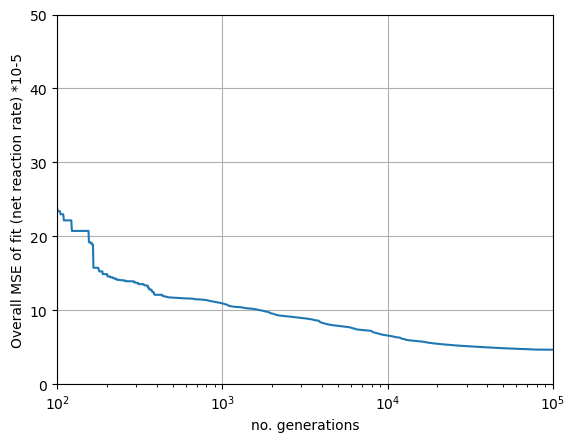

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.383340669084474
1.3362635804266492
0.6110574730042572
-4.092045367907366
0.45803158318258225
2.195832922950088e-07
0.3630468578289176
-4.416099823838789
0.2952976494813098
3.86106235009815
2.7469084000392927
2.8281299165363674
7.525176963054837e-07
0.11267903465486792
2.977054431088527
5.71770860410434e-07
0.48232437824294644
-10.874737638919546
1.7075170002896285
1.5420908547588292
-9.204559296519502
0.8997507914878102
2.7802268358969093
0.0011207123043165024
3.1628925712792184
3.054952613249221
1.0493693242351398
6.442168599850787
-9.101671427303017
2.425976928694076
1.4501803525794124
3.0813924636419756
-4.368937033407226
0.5589552194019419
0.9905967440101358
-1.3010298523562902


In [37]:
res.X

array([-1.03833407e+01,  1.33626358e+00,  6.11057473e-01, -4.09204537e+00,
        4.58031583e-01,  2.19583292e-07,  3.63046858e-01, -4.41609982e+00,
        2.95297649e-01,  3.86106235e+00,  2.74690840e+00,  2.82812992e+00,
        7.52517696e-07,  1.12679035e-01,  2.97705443e+00,  5.71770860e-07,
        4.82324378e-01, -1.08747376e+01,  1.70751700e+00,  1.54209085e+00,
       -9.20455930e+00,  8.99750791e-01,  2.78022684e+00,  1.12071230e-03,
        3.16289257e+00,  3.05495261e+00,  1.04936932e+00,  6.44216860e+00,
       -9.10167143e+00,  2.42597693e+00,  1.45018035e+00,  3.08139246e+00,
       -4.36893703e+00,  5.58955219e-01,  9.90596744e-01, -1.30102985e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.383340669084474
1.6: 1.3362635804266492
0.9: 0.6110574730042572
-4.3: -4.092045367907366
0.5: 0.45803158318258225
0.003: 2.195832922950088e-07
0.4: 0.3630468578289176
-7.9: -4.416099823838789
0.7: 0.2952976494813098
7.2: 3.86106235009815
5.7: 2.7469084000392927
5.7: 2.8281299165363674
0.8: 7.525176963054837e-07
0.03: 0.11267903465486792
3.1: 2.977054431088527
6.000000000000001e-09: 5.71770860410434e-07
0.1: 0.48232437824294644
-12.0: -10.874737638919546
1.9: 1.7075170002896285
1.6: 1.5420908547588292
-11.6: -9.204559296519502
1.2: 0.8997507914878102
4.0: 2.7802268358969093
0.01: 0.0011207123043165024
4.2: 3.1628925712792184
5.4: 3.054952613249221
2.2: 1.0493693242351398
11.8: 6.442168599850787
-12.0: -9.101671427303017
3.3: 2.425976928694076
1.8: 1.4501803525794124
4.2: 3.0813924636419756
-4.0: -4.368937033407226
0.5: 0.5589552194019419
1.0: 0.9905967440101358
coeff fit: 0.9040170409551456
r: 0.9507981073577847
